<img src="https://pages.cnpem.br/workshopbioimagens/wp-content/uploads/sites/166/2023/06/logo-ilum-2048x382.png" alt="logos" style="width: 1000px; height: auto; ">

## <font color=blue><center> Clareyamar X Tarrasque
### <font color=gold><center> Rede Neural MLP para previsão de pH
    
<center><b> Disciplina: </b> Redes Neurais e Algoritmos Genéticos <br>
<center><b> Professor: </b> Daniel Cassar <br>
<center><b> Semestre: </b> 2025.1 <br>
<center><b> Alunos(as): </b> Gabriel Martins Sousa, Maria Clara Macedo Lelis e Yasmin Barboza Shimizu <br>
<center><b> RM: </b> 24036, 24004 e 240XX <br>
    
 <font color=darkred><center>**Inluminans Ignotus**☀️🌊

## 🎯 Objetivo
**Identificar** e **otimizar** os hiperparâmetros de uma rede neural do tipo MLP para resolver um problema de regressão ou de classificação de interesse científico. Testar ao menos **100 diferentes arquiteturas** de rede durante a otimização de hiperparâmetros. Os dados para treinar o modelo são dados tabulados oriundos de um dataset obtido na Internet.

---
## ✨ Introdução

Como projeto final da disciplina de **Redes Neurais e Algoritmos Genéticos**, ministrada pelo Prof. Dr. Daniel R. Cassar, o grupo formado pelos discentes Gabriel Martins, Maria Clara Lelis e Yasmin Shimizu, autoentitulados *"Divisão Clareyamar"*, desenvolveu uma **Rede Neural (RN) do tipo MLP** para regressão utilizando o módulo `Pytorch`, a fim de prever o pH de amostras de água a partir de quantidades de diversos componentes químicos presentes nas amostras. Além disso, otimizamos os hiperparâmetros da rede MLP através do módulo `optuna`, que testa diferentes arquiteturas da rede, compara as métricas de performance dessas diferentes arquiteturas e retorna ao usuário os hiperparêmetros do modelo com a menor função de perda. 

Utilizamos no projeto o dataset [***Water Quality** Data [Telangana Groundwater]*](https://www.kaggle.com/datasets/sivapriyagarladinne/telangana-post-monsoon-ground-water-quality-data), obtido na plataforma *Kaggle*, um site de hospedagem de diversos datasets muito utilizado para obter dados para o treinamento de modelos de Machine Learning (ML). Os dados foram coletados do Telangana Open Data portal, do estado de Telangana, na India. Esses dados contêm amostras de água testadas de vários distritos. O conjunto que utilizamos é referente ao ano de 2018, e contém 26 colunas, como: número de série (sno), Distrito, Vila, Latitude, Longitude, Produtos Químicos (como Ca, Mg, CO3 etc.), Dureza total da água, Total de sólidos dissolvidos, e as variáveis-alvo do dataset 'Classificação' e 'Classificação1'. Para a nossa aplicação de previsão do pH, iremos utilizar apenas as colunas:
* `TDS`: concentração de sólidos totais dissolvidos (*Total Dissolved Solids*), influenciada tanto pela formação rochosa das nascentes quanto pela poluição humana;
* `CO3`, `HCO3`, `Cl`, `F`, `NO3`, `SO4`, `Na`, `K`, `Ca`, `Mg`: concentração dos respectivos elementos presentes nas amostras analisadas;
* `RSC meq/L`: concentração carbonato de sódio residual (*Residual Sodium Carbonate*), o excesso de carbonatos (CO3^2-) e bicarbonatos (HCO3^-) em relação a íons de cálcio (Ca²⁺) e magnésio (Mg²⁺); e
* `pH`: concentração dos íons de hidrogênio em água --- o *target* previsto em nosso problema.


Separamos os dados em treino e teste, para verificar a performance do modelo que iremos aplicar. Porém, para a validação das diferentes arquiteturas testadas no processo de otimização, dividimos os dados de treino em treino e validação. Em seguida, testamos o melhor modelo encontrado nos dados de teste, e obtivemos sua métrica de performance. Ao final, obtivemos a curva de aprendizado do modelo, e comparamos os valores previstos com os reais. Além disso, classificamos os valores de pH entre: valores ideais para uso humano, valores abaixo do ideal e valores acima do ideal, segundo um documento da Organização Mundial da Saúde [1].


---

## 🛠️ Desenvolvimento

O primeiro passo para a realização do trabalho é garantir que todas as bibliotecas a serem utilizadas estejam instaladas. Isso é feito na célula a seguir. Em seguida, definimos a métrica que será utilizada para a avaliação do modelo, que, neste caso, é o RMSE (raiz do erro quadrático médio). Essa métrica é definida na célula 2.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
import optuna
from optuna import create_study
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calcula_RMSE(y_verdadeiro, y_previsto):

    RMSE = mean_squared_error(y_verdadeiro, y_previsto, squared=False)

    return RMSE

### Importação e tratamento de dados

Em seguida, podemos carregar o arquivo com os dados a serem utilizados no treinamento do modelo, utilizando a biblioteca `pandas`. Nem todas as colunas do dataset escolhido serão aproveitadas neste trabalho, pois algumas não possuem valores numéricos ou não influenciam diretamente no valor do pH. Por isso, é criado um novo dataframe contendo apenas as colunas relevantes para a análise. Em seguida, removemos possíveis valores ausentes (NaN) para garantir que não ocorram erros durante as etapas de treinamento e avaliação do modelo.

In [3]:
df1 = pd.read_csv("ground_water_quality_2018_post.csv")
print(df1.columns)

Index(['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis', 'gwl',
       'season', 'pH', 'E.C', 'TDS', 'CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
       'Na', 'K', 'Ca', 'Mg', 'T.H', 'SAR', 'Classification', 'RSC  meq  / L',
       'Classification.1'],
      dtype='object')


In [4]:
df = df1.reindex(['TDS','CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
       'Na', 'K', 'Ca', 'Mg', 'RSC  meq  / L','pH'], axis=1)
df.dropna()
df

,TDS,CO3,HCO3,Cl,F,NO3,SO4,Na,K,Ca,Mg,RSC meq / L,pH
0,476.80,0,220.000000,60,0.44,42.276818,46.0,49.000000,4.0,48,38.896,-1.198684,8.28
1,589.44,0,230.000000,80,0.56,100.659091,68.0,42.000000,5.0,56,63.206,-3.397862,8.29
2,326.40,0,200.000000,30,0.66,41.471545,44.0,45.000000,2.0,24,38.896,-0.398684,7.69
3,270.08,0,160.000000,10,0.58,10.669864,35.0,27.000000,1.0,32,19.448,0.000658,8.09
4,1485.44,0,300.000000,340,2.56,128.843636,280.0,298.000000,5.0,56,92.378,-4.396875,8.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1248.00,0,440.904409,220,1.12,19.709050,17.0,148.257707,2.0,160,63.206,-4.379774,6.95
370,1491.20,0,519.811959,270,1.80,1.993050,37.0,175.275418,28.0,120,111.826,-4.799978,7.45
371,816.00,0,283.834542,90,2.80,29.231400,11.0,147.248057,3.0,64,38.896,-0.721993,7.26
372,3481.60,0,438.306255,1500,0.78,167.194750,43.0,597.854463,6.0,424,92.378,-20.030750,7.27


Podemos fazer uma visualização inicial dos valores de pH presente do dataset. Segundo a OMS, a faixa de pH de água ideal para o consumo humano é entre 6,5 e 8,5. Sendo assim, dividimos o pH das amostras de acordo com a viabilidade para consumo humano: ideal, abaixo do ideal e acima do ideal. Podemos perceber que grande a maioria dos dados está na faixa de pH ideal, sem nenhuma amostra abaixo e pouquíssimas acima. Futuramente, podemos observar se a previsão seguirá uma distribuição proporcional. 

É importante ressaltar que o pH não é o único fator que torna a água potável, e a classificação aqui realizada foi feita a fins de análise dos resultados e possíveis aplicações na análise de potabilidade.

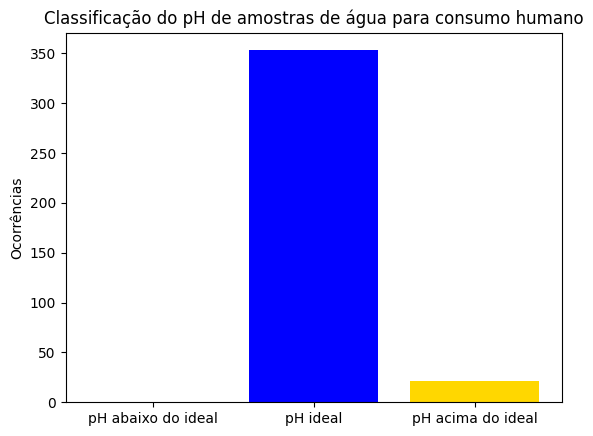

In [5]:
pH_list = list(df["pH"])

pH_abaixo = []
pH_ideal =[]
pH_acima = []

for pH in pH_list:
    if pH < 6.5:
        pH_abaixo.append(pH)
    elif pH <= 8.5:
        pH_ideal.append(pH)
    else: 
        pH_acima.append(pH)
        
pH_frac = [len(pH_abaixo), len(pH_ideal), len(pH_acima)]
plt.bar(["pH abaixo do ideal", "pH ideal", "pH acima do ideal"], pH_frac, color = ["darkred", "blue", "gold"])

plt.title("Classificação do pH de amostras de água para consumo humano")
plt.ylabel("Ocorrências")
plt.show()

Agora que temos os dados podemos fazer um Split de treino, validação e teste. A parcela de dados de treino será utilizado para treinamento do teste de hiperparâmetros quanto no treinamento final do modelo. A parcela de validação será utilizada para fazer a checagem do desempenho de cada conjunto de hiperparâmetros. Já a parcela de teste será utilizada para fazer as previsões no modelo final. 
Nessa etapa definimos o tamanho do teste e o tamanho da validação e fazemos a separação dos dados. Aqui também é definida uma semente aleatória que garante que sempre que utilizarmos esse notebook com essa semente os dados serão iguais.

In [6]:
NUM_EPOCAS = 100
TAMANHO_VAL = 0.1
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 120625

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino_val = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

atr_treino_val = df_treino_val[['TDS','CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
       'Na', 'K', 'Ca', 'Mg', 'RSC  meq  / L']]
target_treino_val = df_treino_val["pH"]

atr_teste = df_teste[['TDS','CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
       'Na', 'K', 'Ca', 'Mg', 'RSC  meq  / L']]
target_teste = df_teste["pH"]

Agora que os dados foram separados em diferentes dataframes, é necessário transformá-los em tensores, pois o PyTorch não realiza operações diretamente com dataframes do pandas.
Para evitar a perda dos dados originais, são feitas cópias dos dataframes, que então são convertidas em tensores.

In [7]:
target_teste_t = target_teste.copy()
target_treino_val_t = target_treino_val.copy()

atr_teste_t = atr_teste.copy()
atr_treino_val_t = atr_treino_val.copy()

target_teste_t = torch.tensor(target_teste_t.to_numpy(), dtype=torch.float32)
target_treino_val_t = torch.tensor(target_treino_val_t.to_numpy(), dtype=torch.float32)

target_teste_t = target_teste_t.view(-1, 1)
target_treino_val_t = target_treino_val_t.view(-1, 1)

atr_teste_t = torch.tensor(atr_teste_t.to_numpy(), dtype=torch.float32)
atr_treino_val_t = torch.tensor(atr_treino_val_t.to_numpy(), dtype=torch.float32)

In [8]:
indices = df_treino_val.index
indices_treino, indices_val = train_test_split(indices, test_size=TAMANHO_VAL, random_state=SEMENTE_ALEATORIA)

df_treino = df_treino_val.loc[indices_treino]
df_val = df_treino_val.loc[indices_val]

atr_treino = df_treino[['TDS','CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
   'Na', 'K', 'Ca', 'Mg', 'RSC  meq  / L']]
target_treino = df_treino["pH"]

atr_val = df_val[['TDS','CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
       'Na', 'K', 'Ca', 'Mg', 'RSC  meq  / L']]
target_val = df_val["pH"]

target_val_t = target_val.copy()
target_treino_t = target_treino.copy()
atr_treino_t = atr_treino.copy()
atr_val_t = atr_val.copy()

target_val_t = torch.tensor(target_val_t.to_numpy(), dtype=torch.float32)
target_treino_t = torch.tensor(target_treino_t.to_numpy(), dtype=torch.float32)
target_val_t = target_val_t.view(-1, 1)
target_treino_t = target_treino_t.view(-1, 1)
atr_val_t = torch.tensor(atr_val_t.to_numpy(), dtype=torch.float32)
atr_treino_t = torch.tensor(atr_treino_t.to_numpy(), dtype=torch.float32)

### Definindo a rede MLP

Agora podemos definir a nossa função de perda que guiará o modelo indicando o quanto ele está errando. A nossa função de perda é a do erro quadrático médio (MSE).

In [9]:
fn_perda = nn.MSELoss()

O próximo passo é construir o nosso modelo com o Pytorch. A primeira classe, `MLP`, herda de `nn.Module` e representa a estrutura da rede. Ao ser inicializada, ela recebe uma lista com o número de neurônios em cada camada (neuronios) e uma função de ativação (func_act). Com base nisso, a rede é construída dinamicamente: as camadas ocultas são adicionadas usando `nn.Linear` seguidas da função de ativação, e, ao final, é adicionada a camada de saída. A sequência de camadas é armazenada no módulo `nn.Sequential`, o que facilita a execução do forward pass (passagem dos dados pela rede) com a função `forward()`.

A segunda classe, `TREINO_MLP`, herda da `MLP` e adiciona funcionalidades para treinamento da rede. Ela define um otimizador (SGD com taxa de aprendizado lr) e utiliza a função de perda MSELoss (Erro Quadrático Médio). Existem dois métodos principais: `treinador()`, que realiza o treinamento apenas com dados de treino, e `treinador_val()`, que além do treino, calcula o erro também em um conjunto de validação a cada época. Ambos os métodos realizam a predição (y_pred), cálculo da perda, retropropagação do erro (backward()) e atualização dos pesos (step()), salvando os valores das perdas em listas que podem ser usadas posteriormente para análise da curva de aprendizado. 

In [10]:
class MLP(nn.Module):
    def __init__(self, neuronios, func_act):
        super().__init__()
        self.neuronios = neuronios
        self.func_act = func_act
        
        layers = []
        #camadas ocultas
        for i in range(len(neuronios) - 2):
            layers.append(nn.Linear(neuronios[i], neuronios[i+1]))
            layers.append(func_act())
        #camada de saída
        layers.append(nn.Linear(neuronios[-2],neuronios[-1]))
        self.camadas = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.camadas(x)
        return x
    
class TREINO_MLP(MLP):
    def __init__(self, neuronios, func_act, lr):
        super().__init__(neuronios, func_act)
        self.lr = lr
        
        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []
        
    def treinador(self, x, y_true, num_epocas):
        self.otimizador = optim.SGD(self.parameters(), lr=self.lr)
        fn_perda = nn.MSELoss()
        
        self.train()
        
        for epoca in range(num_epocas):
            # forward pass
            y_pred = self(x)

            # zero grad
            self.otimizador.zero_grad()

            # loss
            loss = fn_perda(y_true, y_pred)
            self.curva_aprendizado_treino.append(loss.data)

            # backpropagation
            loss.backward()

            # atualiza parâmetros
            self.otimizador.step()

            # mostra resultado (opcional)
            print(epoca, loss.data)
            
    def treinador_val(self, x, y_true, x_val, y_val, num_epocas):
        self.otimizador = optim.SGD(self.parameters(), lr=self.lr)
        fn_perda = nn.MSELoss()
        
        self.train()
        
        for epoca in range(num_epocas):
            # forward pass
            y_pred = self(x)

            # zero grad
            self.otimizador.zero_grad()

            # loss
            loss = fn_perda(y_true, y_pred)
            self.curva_aprendizado_treino.append(loss.data)

            # backpropagation
            loss.backward()

            # atualiza parâmetros
            self.otimizador.step()

            # mostra resultado (opcional)
            print(epoca, loss.data)
            
            # VALIDAÇÃO
            self.eval()
            with torch.no_grad():
                y_pred_val = self(x_val)

            loss_val = fn_perda(y_val, y_pred_val)
            self.curva_aprendizado_val.append(loss_val.data)

### Otimização de Hiperparâmetros

Em seguida é definida a `funcao_objetivo` que é utilizada em conjunto com a biblioteca Optuna para otimização de hiperparâmetros. Ela recebe uma tentativa (trial), os dados de treino e validação (atributos e alvos), o número de épocas de treinamento (NUM_EPOCAS) e uma função que retorna o modelo a ser treinado (funcao_model). Dentro da função, o modelo é criado a partir dos parâmetros definidos pelo trial, treinado com os dados de treino, e depois avaliado com os dados de validação sem calcular gradientes (torch.no_grad()). A métrica usada para retorno é o RMSE (raiz do erro quadrático médio), calculada entre os valores reais e os preditos. Se o valor de RMSE for inválido (NaN ou infinito), a tentativa é descartada usando TrialPruned, indicando ao Optuna que aquela configuração não é promissora. Caso ocorra qualquer outro erro durante o processo, a tentativa também é descartada e uma mensagem é exibida.

In [11]:
def funcao_objetivo(trial, atr_treino_t,target_treino_t, atr_val_t,target_val_t,NUM_EPOCAS,funcao_model):
    """Recebe um número de tentativas (trial), os atributos e targets de teste (X e y), o número de folds da validação cruzada e o modelo que se deseja treinar.
    Retorna, como métrica calculada, o RMSE do modelo."""
    try:
        modelo = funcao_model(trial)
        modelo.treinador(atr_treino_t,target_treino_t,NUM_EPOCAS)
        modelo.eval()
        with torch.no_grad():
            y_pred = modelo(atr_val_t)

        RMSE = mean_squared_error(target_val_t, y_pred, squared=False)
        
        if np.isnan(RMSE) or np.isinf(RMSE):
            raise optuna.exceptions.TrialPruned()
             
        return RMSE
    
    except Exception as e:
        print("Trial descartada!")
        raise optuna.exceptions.TrialPruned()
             

Dando continuidade, a função `cria_instancia_tarrasque` define a arquitetura e os hiperparâmetros da MLP que será testada em cada tentativa do Optuna. Ela usa o objeto trial para sortear o número de camadas ocultas (entre 2 e 50) e a quantidade de neurônios em cada uma (entre 2 e 100), montando uma lista com os tamanhos das camadas, começando com 12 neurônios na entrada e 1 na saída.

Além disso, sorteia-se a função de ativação entre Sigmoid, ReLU, LeakyReLU, PReLU, e Tanh, e a taxa de aprendizado (lr) entre 0,0001 e 0,1. A função `getattr` recupera a classe da função de ativação escolhida, e uma instância do modelo `TREINO_MLP` é criada com esses parâmetros. Esse modelo será retornado para ser treinado e avaliado pela função funcao_objetivo, permitindo ao Optuna comparar diferentes configurações.

In [12]:
def cria_instancia_tarrasque(trial):
    """Recebe um trial para sortear diferentes combinações de hiperparâmetros para o modelo k-nn."""
    
    num_ocultas=trial.suggest_int("num_ocultas",2,50)
    num_entrada=12
    num_saida=1
    
    neuronios=[num_entrada]
    for i in range(num_ocultas):
        n=trial.suggest_int(f"neuronios_c{i+1}",2,100)
        neuronios.append(n)
    neuronios.append(num_saida)

    parametros = {
        "neuronios":neuronios,
        
        "func_act":trial.suggest_categorical("func_act",['Sigmoid','ReLU','LeakyReLU','PReLU','Tanh']),
        
        "lr":trial.suggest_float("lr",1e-4,1e-1,log=True)
    }
    
    func_actv=getattr(nn,parametros["func_act"])
    MLP=TREINO_MLP(parametros["neuronios"],func_actv,parametros["lr"])

    return MLP

Em seguida criamos o estudo que irá armazenar os testes de hiperparâmetros realizados. Também é criada uma função de objetivo parcial que será utilizada para facilitar o uso da função objetivo dentro do otimizador.

In [13]:
NOME_DO_ESTUDO = "Tarrasque"
objeto_de_estudo_tarrasque = create_study(
    direction="minimize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,)

[I 2025-06-13 00:34:15,164] A new study created in RDB with name: Tarrasque


In [14]:
def funcao_objetivo_parcial_tarrasque(trial):
    return funcao_objetivo(trial,atr_treino_t, target_treino_t,atr_val_t, target_val_t, NUM_EPOCAS,cria_instancia_tarrasque)

In [15]:
NUM_TENTATIVAS = 1000
objeto_de_estudo_tarrasque.optimize(funcao_objetivo_parcial_tarrasque, n_trials=NUM_TENTATIVAS)

0 tensor(65.0016)
1 tensor(53.2779)
2 tensor(43.6268)
3 tensor(34.9870)
4 tensor(26.3649)
5 tensor(16.4296)
6 tensor(5.1138)
7 tensor(0.3202)
8 tensor(0.3555)
9 tensor(0.3307)
10 tensor(0.3674)
11 tensor(0.3358)
12 tensor(0.3708)
13 tensor(0.3340)
14 tensor(0.3650)
15 tensor(0.3271)
16 tensor(0.3525)
17 tensor(0.3163)
18 tensor(0.3358)
19 tensor(0.3035)
20 tensor(0.3176)
21 tensor(0.2902)
22 tensor(0.2999)
23 tensor(0.2773)
24 tensor(0.2836)
25 tensor(0.2657)
26 tensor(0.2694)
27 tensor(0.2552)
28 tensor(0.2572)
29 tensor(0.2462)
30 tensor(0.2471)
31 tensor(0.2387)
32 tensor(0.2389)
33 tensor(0.2326)
34 tensor(0.2323)
35 tensor(0.2276)
36 tensor(0.2271)
37 tensor(0.2235)
38 tensor(0.2229)
39 tensor(0.2202)
40 tensor(0.2196)
41 tensor(0.2176)
42 tensor(0.2170)
43 tensor(0.2153)
44 tensor(0.2148)
45 tensor(0.2135)
46 tensor(0.2130)
47 tensor(0.2120)
48 tensor(0.2116)
49 tensor(0.2108)
50 tensor(0.2104)
51 tensor(0.2097)
52 tensor(0.2094)
53 tensor(0.2088)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 00:34:18,414] Trial 0 finished with value: 0.5642364621162415 and parameters: {'num_ocultas': 14, 'neuronios_c1': 16, 'neuronios_c2': 46, 'neuronios_c3': 46, 'neuronios_c4': 14, 'neuronios_c5': 92, 'neuronios_c6': 56, 'neuronios_c7': 72, 'neuronios_c8': 27, 'neuronios_c9': 88, 'neuronios_c10': 32, 'neuronios_c11': 75, 'neuronios_c12': 71, 'neuronios_c13': 71, 'neuronios_c14': 11, 'func_act': 'LeakyReLU', 'lr': 0.04553653561270259}. Best is trial 0 with value: 0.5642364621162415.


0 tensor(63.0212)
1 tensor(34.2198)
2 tensor(12.4089)
3 tensor(20629.0801)
4 tensor(1.1091e+18)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor

[I 2025-06-13 00:34:19,444] Trial 1 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(59.8638)
1 tensor(59.4913)
2 tensor(59.1232)
3 tensor(58.7578)
4 tensor(58.3980)
5 tensor(58.0414)
6 tensor(57.6868)
7 tensor(57.3355)
8 tensor(56.9873)
9 tensor(56.6404)
10 tensor(56.2947)
11 tensor(55.9501)
12 tensor(55.6065)
13 tensor(55.2637)
14 tensor(54.9215)
15 tensor(54.5800)
16 tensor(54.2469)
17 tensor(53.9158)
18 tensor(53.5847)
19 tensor(53.2534)
20 tensor(52.9218)
21 tensor(52.5897)
22 tensor(52.2571)
23 tensor(51.9238)
24 tensor(51.5896)
25 tensor(51.2545)
26 tensor(50.9183)
27 tensor(50.5810)
28 tensor(50.2424)
29 tensor(49.9022)
30 tensor(49.5604)
31 tensor(49.2168)
32 tensor(48.8713)
33 tensor(48.5239)
34 tensor(48.1760)
35 tensor(47.8318)
36 tensor(47.4852)
37 tensor(47.1359)
38 tensor(46.7840)
39 tensor(46.4291)
40 tensor(46.0713)
41 tensor(45.7103)
42 tensor(45.3461)
43 tensor(44.9786)
44 tensor(44.6075)
45 tensor(44.2325)
46 tensor(43.8537)
47 tensor(43.4708)
48 te

[I 2025-06-13 00:34:23,014] Trial 2 finished with value: 3.862349271774292 and parameters: {'num_ocultas': 36, 'neuronios_c1': 7, 'neuronios_c2': 17, 'neuronios_c3': 20, 'neuronios_c4': 8, 'neuronios_c5': 8, 'neuronios_c6': 20, 'neuronios_c7': 66, 'neuronios_c8': 73, 'neuronios_c9': 91, 'neuronios_c10': 41, 'neuronios_c11': 53, 'neuronios_c12': 72, 'neuronios_c13': 25, 'neuronios_c14': 70, 'neuronios_c15': 85, 'neuronios_c16': 68, 'neuronios_c17': 40, 'neuronios_c18': 21, 'neuronios_c19': 48, 'neuronios_c20': 62, 'neuronios_c21': 48, 'neuronios_c22': 99, 'neuronios_c23': 67, 'neuronios_c24': 30, 'neuronios_c25': 94, 'neuronios_c26': 41, 'neuronios_c27': 92, 'neuronios_c28': 75, 'neuronios_c29': 23, 'neuronios_c30': 41, 'neuronios_c31': 78, 'neuronios_c32': 26, 'neuronios_c33': 59, 'neuronios_c34': 75, 'neuronios_c35': 62, 'neuronios_c36': 18, 'func_act': 'ReLU', 'lr': 0.0010836860223479526}. Best is trial 0 with value: 0.5642364621162415.


0 tensor(62.5465)
1 tensor(31.0297)
2 tensor(0.2469)
3 tensor(0.5129)
4 tensor(2.5789)
5 tensor(12.0325)
6 tensor(33.7243)
7 tensor(15.7322)
8 tensor(1.9106)
9 tensor(0.4225)
10 tensor(0.3216)
11 tensor(0.2450)
12 tensor(0.2250)
13 tensor(0.2147)
14 tensor(0.2111)
15 tensor(0.2096)
16 tensor(0.2090)
17 tensor(0.2087)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.208

[I 2025-06-13 00:34:28,699] Trial 3 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 50, 'neuronios_c1': 68, 'neuronios_c2': 17, 'neuronios_c3': 20, 'neuronios_c4': 52, 'neuronios_c5': 13, 'neuronios_c6': 99, 'neuronios_c7': 17, 'neuronios_c8': 7, 'neuronios_c9': 59, 'neuronios_c10': 62, 'neuronios_c11': 30, 'neuronios_c12': 29, 'neuronios_c13': 28, 'neuronios_c14': 45, 'neuronios_c15': 39, 'neuronios_c16': 40, 'neuronios_c17': 74, 'neuronios_c18': 15, 'neuronios_c19': 87, 'neuronios_c20': 56, 'neuronios_c21': 77, 'neuronios_c22': 85, 'neuronios_c23': 36, 'neuronios_c24': 70, 'neuronios_c25': 43, 'neuronios_c26': 88, 'neuronios_c27': 5, 'neuronios_c28': 19, 'neuronios_c29': 67, 'neuronios_c30': 81, 'neuronios_c31': 71, 'neuronios_c32': 71, 'neuronios_c33': 48, 'neuronios_c34': 36, 'neuronios_c35': 10, 'neuronios_c36': 92, 'neuronios_c37': 47, 'neuronios_c38': 82, 'neuronios_c39': 71, 'neuronios_c40': 79, 'neuronios_c41': 9, 'neuronios_c42': 48, 'neuronios_c43': 

97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.7054)
1 tensor(43.0664)
2 tensor(22.8882)
3 tensor(0.3111)
4 tensor(0.8780)
5 tensor(4.5240)
6 tensor(8.5829)
7 tensor(24.7001)
8 tensor(9.4563)
9 tensor(0.4172)
10 tensor(0.2847)
11 tensor(0.2560)
12 tensor(0.2295)
13 tensor(0.2205)
14 tensor(0.2143)
15 tensor(0.2117)
16 tensor(0.2101)
17 tensor(0.2094)
18 tensor(0.2090)
19 tensor(0.2088)
20 tensor(0.2087)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085

[I 2025-06-13 00:34:32,194] Trial 4 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 35, 'neuronios_c1': 80, 'neuronios_c2': 85, 'neuronios_c3': 9, 'neuronios_c4': 34, 'neuronios_c5': 15, 'neuronios_c6': 65, 'neuronios_c7': 64, 'neuronios_c8': 25, 'neuronios_c9': 48, 'neuronios_c10': 38, 'neuronios_c11': 43, 'neuronios_c12': 69, 'neuronios_c13': 21, 'neuronios_c14': 22, 'neuronios_c15': 42, 'neuronios_c16': 50, 'neuronios_c17': 48, 'neuronios_c18': 34, 'neuronios_c19': 62, 'neuronios_c20': 17, 'neuronios_c21': 31, 'neuronios_c22': 72, 'neuronios_c23': 45, 'neuronios_c24': 65, 'neuronios_c25': 7, 'neuronios_c26': 98, 'neuronios_c27': 49, 'neuronios_c28': 14, 'neuronios_c29': 9, 'neuronios_c30': 27, 'neuronios_c31': 14, 'neuronios_c32': 61, 'neuronios_c33': 14, 'neuronios_c34': 29, 'neuronios_c35': 35, 'func_act': 'LeakyReLU', 'lr': 0.05842334164912875}. Best is trial 4 with value: 0.4481625556945801.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.6123)
1 tensor(59.0899)
2 tensor(56.7067)
3 tensor(54.3674)
4 tensor(52.0587)
5 tensor(49.6874)
6 tensor(47.2179)
7 tensor(44.5740)
8 tensor(41.6883)
9 tensor(38.4912)
10 tensor(34.8695)
11 tensor(30.6941)
12 tensor(25.8604)
13 tensor(20.3417)
14 tensor(14.2662)
15 tensor(8.2773)
16 tensor(3.5221)
17 tensor(1.0025)
18 tensor(0.3002)
19 tensor(0.2139)
20 tensor(0.2088)
21 tensor(0.2086)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 te

[I 2025-06-13 00:34:37,894] Trial 5 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 43, 'neuronios_c1': 14, 'neuronios_c2': 97, 'neuronios_c3': 14, 'neuronios_c4': 39, 'neuronios_c5': 76, 'neuronios_c6': 11, 'neuronios_c7': 17, 'neuronios_c8': 55, 'neuronios_c9': 40, 'neuronios_c10': 80, 'neuronios_c11': 100, 'neuronios_c12': 43, 'neuronios_c13': 30, 'neuronios_c14': 61, 'neuronios_c15': 77, 'neuronios_c16': 11, 'neuronios_c17': 37, 'neuronios_c18': 67, 'neuronios_c19': 60, 'neuronios_c20': 20, 'neuronios_c21': 32, 'neuronios_c22': 83, 'neuronios_c23': 79, 'neuronios_c24': 80, 'neuronios_c25': 28, 'neuronios_c26': 86, 'neuronios_c27': 36, 'neuronios_c28': 72, 'neuronios_c29': 64, 'neuronios_c30': 19, 'neuronios_c31': 87, 'neuronios_c32': 26, 'neuronios_c33': 96, 'neuronios_c34': 62, 'neuronios_c35': 12, 'neuronios_c36': 100, 'neuronios_c37': 99, 'neuronios_c38': 84, 'neuronios_c39': 10, 'neuronios_c40': 26, 'neuronios_c41': 85, 'neuronios_c42': 56, 'neuronios_c4

97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.6070)
1 tensor(43.0433)
2 tensor(23.8509)
3 tensor(2.5132)
4 tensor(4.1927)
5 tensor(12.8229)
6 tensor(0.4325)
7 tensor(0.3474)
8 tensor(0.3443)
9 tensor(0.2963)
10 tensor(0.2902)
11 tensor(0.2635)
12 tensor(0.2577)
13 tensor(0.2427)
14 tensor(0.2382)
15 tensor(0.2298)
16 tensor(0.2266)
17 tensor(0.2216)
18 tensor(0.2195)
19 tensor(0.2166)
20 tensor(0.2152)
21 tensor(0.2135)
22 tensor(0.2126)
23 tensor(0.2116)
24 tensor(0.2110)
25 tensor(0.2104)
26 tensor(0.2100)
27 tensor(0.2097)
28 tensor(0.2095)
29 tensor(0.2092)
30 tensor(0.2091)
31 tensor(0.2090)
32 tensor(0.2089)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085

[I 2025-06-13 00:34:40,894] Trial 6 finished with value: 0.44816315174102783 and parameters: {'num_ocultas': 20, 'neuronios_c1': 89, 'neuronios_c2': 58, 'neuronios_c3': 60, 'neuronios_c4': 96, 'neuronios_c5': 40, 'neuronios_c6': 18, 'neuronios_c7': 83, 'neuronios_c8': 97, 'neuronios_c9': 90, 'neuronios_c10': 83, 'neuronios_c11': 16, 'neuronios_c12': 2, 'neuronios_c13': 91, 'neuronios_c14': 27, 'neuronios_c15': 60, 'neuronios_c16': 30, 'neuronios_c17': 87, 'neuronios_c18': 62, 'neuronios_c19': 45, 'neuronios_c20': 71, 'func_act': 'LeakyReLU', 'lr': 0.058696383382815305}. Best is trial 4 with value: 0.4481625556945801.


94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.7593)
1 tensor(34.0958)
2 tensor(1.4052e+12)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59

[I 2025-06-13 00:34:42,094] Trial 7 pruned. 


79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.1833)
1 tensor(60.6524)
2 tensor(58.2110)
3 tensor(55.7853)
4 tensor(53.3210)
5 tensor(50.7684)
6 tensor(48.0754)
7 tensor(45.1904)
8 tensor(42.0624)
9 tensor(38.6341)
10 tensor(34.8605)
11 tensor(30.7060)
12 tensor(26.1762)
13 tensor(21.3635)
14 tensor(16.4108)
15 tensor(11.5990)
16 tensor(7.2828)
17 tensor(3.9369)
18 tensor(1.8024)
19 tensor(0.7543)
20 tensor(0.3607)
21 tensor(0.2448)
22 tensor(0.2164)
23 tensor(0.2102)
24 tensor(0.2089)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2

[I 2025-06-13 00:34:47,314] Trial 8 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 44, 'neuronios_c1': 45, 'neuronios_c2': 14, 'neuronios_c3': 89, 'neuronios_c4': 43, 'neuronios_c5': 10, 'neuronios_c6': 93, 'neuronios_c7': 16, 'neuronios_c8': 65, 'neuronios_c9': 75, 'neuronios_c10': 90, 'neuronios_c11': 25, 'neuronios_c12': 51, 'neuronios_c13': 10, 'neuronios_c14': 25, 'neuronios_c15': 80, 'neuronios_c16': 77, 'neuronios_c17': 99, 'neuronios_c18': 49, 'neuronios_c19': 89, 'neuronios_c20': 48, 'neuronios_c21': 42, 'neuronios_c22': 55, 'neuronios_c23': 99, 'neuronios_c24': 99, 'neuronios_c25': 90, 'neuronios_c26': 15, 'neuronios_c27': 59, 'neuronios_c28': 16, 'neuronios_c29': 29, 'neuronios_c30': 20, 'neuronios_c31': 54, 'neuronios_c32': 27, 'neuronios_c33': 92, 'neuronios_c34': 63, 'neuronios_c35': 17, 'neuronios_c36': 95, 'neuronios_c37': 56, 'neuronios_c38': 31, 'neuronios_c39': 16, 'neuronios_c40': 21, 'neuronios_c41': 62, 'neuronios_c42': 18, 'neuronios_c43

98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.9272)
1 tensor(63.8788)
2 tensor(63.8304)
3 tensor(63.7820)
4 tensor(63.7336)
5 tensor(63.6852)
6 tensor(63.6368)
7 tensor(63.5885)
8 tensor(63.5402)
9 tensor(63.4918)
10 tensor(63.4435)
11 tensor(63.3952)
12 tensor(63.3470)
13 tensor(63.2987)
14 tensor(63.2504)
15 tensor(63.2022)
16 tensor(63.1539)
17 tensor(63.1057)
18 tensor(63.0575)
19 tensor(63.0092)
20 tensor(62.9610)
21 tensor(62.9128)
22 tensor(62.8646)
23 tensor(62.8164)
24 tensor(62.7682)
25 tensor(62.7200)
26 tensor(62.6718)
27 tensor(62.6237)
28 tensor(62.5755)
29 tensor(62.5273)
30 tensor(62.4791)
31 tensor(62.4310)
32 tensor(62.3828)
33 tensor(62.3346)
34 tensor(62.2865)
35 tensor(62.2383)
36 tensor(62.1901)
37 tensor(62.1419)
38 tensor(62.0938)
39 tensor(62.0456)
40 tensor(61.9974)
41 tensor(61.9492)
42 tensor(61.9010)
43 tensor(61.8528)
44 tensor(61.8046)
45 tensor(61.7564)
46 tensor(61.7082)
47 tensor(61.6600)
48 tensor(61.6117)
49 tensor(61.5635)
50 tensor(61.5152)
51 te

[I 2025-06-13 00:34:52,274] Trial 9 finished with value: 7.753885269165039 and parameters: {'num_ocultas': 46, 'neuronios_c1': 81, 'neuronios_c2': 44, 'neuronios_c3': 49, 'neuronios_c4': 90, 'neuronios_c5': 52, 'neuronios_c6': 10, 'neuronios_c7': 70, 'neuronios_c8': 17, 'neuronios_c9': 8, 'neuronios_c10': 13, 'neuronios_c11': 68, 'neuronios_c12': 90, 'neuronios_c13': 64, 'neuronios_c14': 11, 'neuronios_c15': 19, 'neuronios_c16': 77, 'neuronios_c17': 13, 'neuronios_c18': 47, 'neuronios_c19': 54, 'neuronios_c20': 52, 'neuronios_c21': 63, 'neuronios_c22': 50, 'neuronios_c23': 45, 'neuronios_c24': 38, 'neuronios_c25': 5, 'neuronios_c26': 26, 'neuronios_c27': 29, 'neuronios_c28': 73, 'neuronios_c29': 62, 'neuronios_c30': 76, 'neuronios_c31': 25, 'neuronios_c32': 93, 'neuronios_c33': 14, 'neuronios_c34': 47, 'neuronios_c35': 31, 'neuronios_c36': 51, 'neuronios_c37': 56, 'neuronios_c38': 41, 'neuronios_c39': 73, 'neuronios_c40': 37, 'neuronios_c41': 86, 'neuronios_c42': 25, 'neuronios_c43': 4

98 tensor(59.2337)
99 tensor(59.1867)
0 tensor(61.0082)
1 tensor(45.4197)
2 tensor(29.4828)
3 tensor(14.3582)
4 tensor(4.7373)
5 tensor(1.1940)
6 tensor(0.3747)
7 tensor(0.2331)
8 tensor(0.2120)
9 tensor(0.2090)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.20

[I 2025-06-13 00:34:55,427] Trial 10 finished with value: 0.44816258549690247 and parameters: {'num_ocultas': 30, 'neuronios_c1': 50, 'neuronios_c2': 99, 'neuronios_c3': 98, 'neuronios_c4': 26, 'neuronios_c5': 59, 'neuronios_c6': 73, 'neuronios_c7': 42, 'neuronios_c8': 36, 'neuronios_c9': 47, 'neuronios_c10': 58, 'neuronios_c11': 2, 'neuronios_c12': 100, 'neuronios_c13': 5, 'neuronios_c14': 95, 'neuronios_c15': 10, 'neuronios_c16': 94, 'neuronios_c17': 59, 'neuronios_c18': 89, 'neuronios_c19': 7, 'neuronios_c20': 2, 'neuronios_c21': 10, 'neuronios_c22': 9, 'neuronios_c23': 12, 'neuronios_c24': 3, 'neuronios_c25': 2, 'neuronios_c26': 64, 'neuronios_c27': 69, 'neuronios_c28': 36, 'neuronios_c29': 6, 'neuronios_c30': 47, 'func_act': 'Tanh', 'lr': 0.014124743679500224}. Best is trial 4 with value: 0.4481625556945801.


94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(68.5657)
1 tensor(19.7024)
2 tensor(5.2396)
3 tensor(1.2709)
4 tensor(0.4016)
5 tensor(0.2409)
6 tensor(0.2138)
7 tensor(0.2094)
8 tensor(0.2087)
9 tensor(0.2086)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)


[I 2025-06-13 00:35:00,185] Trial 11 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 36, 'neuronios_c1': 29, 'neuronios_c2': 100, 'neuronios_c3': 2, 'neuronios_c4': 34, 'neuronios_c5': 78, 'neuronios_c6': 40, 'neuronios_c7': 2, 'neuronios_c8': 47, 'neuronios_c9': 40, 'neuronios_c10': 70, 'neuronios_c11': 95, 'neuronios_c12': 38, 'neuronios_c13': 39, 'neuronios_c14': 61, 'neuronios_c15': 54, 'neuronios_c16': 2, 'neuronios_c17': 35, 'neuronios_c18': 84, 'neuronios_c19': 66, 'neuronios_c20': 13, 'neuronios_c21': 20, 'neuronios_c22': 70, 'neuronios_c23': 73, 'neuronios_c24': 74, 'neuronios_c25': 32, 'neuronios_c26': 94, 'neuronios_c27': 38, 'neuronios_c28': 55, 'neuronios_c29': 99, 'neuronios_c30': 2, 'neuronios_c31': 5, 'neuronios_c32': 54, 'neuronios_c33': 15, 'neuronios_c34': 3, 'neuronios_c35': 98, 'neuronios_c36': 67, 'func_act': 'Sigmoid', 'lr': 0.011314383406908154}. Best is trial 4 with value: 0.4481625556945801.


0 tensor(62.1975)
1 tensor(61.2837)
2 tensor(60.3833)
3 tensor(59.5027)
4 tensor(58.6240)
5 tensor(57.7496)
6 tensor(56.8809)
7 tensor(56.0027)
8 tensor(55.1143)
9 tensor(54.2142)
10 tensor(53.2986)
11 tensor(52.3593)
12 tensor(51.3857)
13 tensor(50.3755)
14 tensor(49.3286)
15 tensor(48.2405)
16 tensor(47.1086)
17 tensor(45.9220)
18 tensor(44.6753)
19 tensor(43.3609)
20 tensor(41.9671)
21 tensor(40.4879)
22 tensor(38.9134)
23 tensor(37.2323)
24 tensor(35.4351)
25 tensor(33.5101)
26 tensor(31.4468)
27 tensor(29.2371)
28 tensor(26.8765)
29 tensor(24.3594)
30 tensor(21.6931)
31 tensor(18.9034)
32 tensor(16.0229)
33 tensor(13.1227)
34 tensor(10.2849)
35 tensor(7.6512)
36 tensor(5.3537)
37 tensor(3.4939)
38 tensor(2.1303)
39 tensor(1.2347)
40 tensor(0.7097)
41 tensor(0.4345)
42 tensor(0.3039)
43 tensor(0.2469)
44 tensor(0.2234)
45 tensor(0.2142)
46 tensor(0.2107)
47 tensor(0.2093)
48 tensor(0.2088)
49 tensor(0.2087)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2085)
53 tensor(0.2085)
54 

[I 2025-06-13 00:35:05,454] Trial 12 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 38, 'neuronios_c1': 69, 'neuronios_c2': 79, 'neuronios_c3': 34, 'neuronios_c4': 59, 'neuronios_c5': 74, 'neuronios_c6': 38, 'neuronios_c7': 33, 'neuronios_c8': 59, 'neuronios_c9': 33, 'neuronios_c10': 42, 'neuronios_c11': 100, 'neuronios_c12': 65, 'neuronios_c13': 46, 'neuronios_c14': 47, 'neuronios_c15': 99, 'neuronios_c16': 11, 'neuronios_c17': 21, 'neuronios_c18': 34, 'neuronios_c19': 26, 'neuronios_c20': 25, 'neuronios_c21': 31, 'neuronios_c22': 72, 'neuronios_c23': 90, 'neuronios_c24': 71, 'neuronios_c25': 22, 'neuronios_c26': 72, 'neuronios_c27': 27, 'neuronios_c28': 97, 'neuronios_c29': 47, 'neuronios_c30': 22, 'neuronios_c31': 97, 'neuronios_c32': 5, 'neuronios_c33': 98, 'neuronios_c34': 23, 'neuronios_c35': 45, 'neuronios_c36': 57, 'neuronios_c37': 95, 'neuronios_c38': 99, 'func_act': 'PReLU', 'lr': 0.002250525742691464}. Best is trial 4 with value: 0.4481625556945801.

96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(67.8267)
1 tensor(60.6922)
2 tensor(54.0004)
3 tensor(47.2736)
4 tensor(40.7741)
5 tensor(34.8623)
6 tensor(29.6531)
7 tensor(25.0722)
8 tensor(20.9966)
9 tensor(17.3404)
10 tensor(14.0975)
11 tensor(11.3135)
12 tensor(9.0095)
13 tensor(7.1518)
14 tensor(5.6747)
15 tensor(4.5079)
16 tensor(3.5890)
17 tensor(2.8662)
18 tensor(2.2978)
19 tensor(1.8511)
20 tensor(1.5000)
21 tensor(1.2239)
22 tensor(1.0070)
23 tensor(0.8364)
24 tensor(0.7022)
25 tensor(0.5968)
26 tensor(0.5139)
27 tensor(0.4487)
28 tensor(0.3974)
29 tensor(0.3571)
30 tensor(0.3254)
31 tensor(0.3004)
32 tensor(0.2808)
33 tensor(0.2654)
34 tensor(0.2533)
35 tensor(0.2437)
36 tensor(0.2362)
37 tensor(0.2303)
38 tensor(0.2257)
39 tensor(0.2220)
40 tensor(0.2191)
41 tensor(0.2169)
42 tensor(0.2151)
43 tensor(0.2137)
44 tensor(0.2126)
45 tensor(0.2117)
46 tensor(0.2111)
47 tensor(0.2105)
48 tensor(0.2101)
49 tensor(0.2098)
50 tensor(0.2095)
51 tenso

[I 2025-06-13 00:35:08,622] Trial 13 finished with value: 0.4481737017631531 and parameters: {'num_ocultas': 28, 'neuronios_c1': 40, 'neuronios_c2': 82, 'neuronios_c3': 32, 'neuronios_c4': 28, 'neuronios_c5': 68, 'neuronios_c6': 78, 'neuronios_c7': 28, 'neuronios_c8': 40, 'neuronios_c9': 62, 'neuronios_c10': 100, 'neuronios_c11': 47, 'neuronios_c12': 28, 'neuronios_c13': 21, 'neuronios_c14': 81, 'neuronios_c15': 35, 'neuronios_c16': 24, 'neuronios_c17': 55, 'neuronios_c18': 69, 'neuronios_c19': 72, 'neuronios_c20': 30, 'neuronios_c21': 95, 'neuronios_c22': 45, 'neuronios_c23': 62, 'neuronios_c24': 98, 'neuronios_c25': 66, 'neuronios_c26': 97, 'neuronios_c27': 49, 'neuronios_c28': 2, 'func_act': 'Tanh', 'lr': 0.018777823812849825}. Best is trial 4 with value: 0.4481625556945801.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.8407)
1 tensor(58.7423)
2 tensor(55.7991)
3 tensor(52.9991)
4 tensor(50.3320)
5 tensor(47.7887)
6 tensor(45.3611)
7 tensor(43.0423)
8 tensor(40.8259)
9 tensor(38.7065)
10 tensor(36.6792)
11 tensor(34.7394)
12 tensor(32.8833)
13 tensor(31.1073)
14 tensor(29.4081)
15 tensor(27.7827)
16 tensor(26.2284)
17 tensor(24.7427)
18 tensor(23.3232)
19 tensor(21.9678)
20 tensor(20.6742)
21 tensor(19.4407)
22 tensor(18.2653)
23 tensor(17.1461)
24 tensor(16.0815)
25 tensor(15.0698)
26 tensor(14.1093)
27 tensor(13.1984)
28 tensor(12.3355)
29 tensor(11.5190)
30 tensor(10.7473)
31 tensor(10.0189)
32 tensor(9.3322)
33 tensor(8.6856)
34 tensor(8.0775)
35 tensor(7.5064)
36 tensor(6.9706)
37 tensor(6.4688)
38 tensor(5.9992)
39 tensor(5.5603)
40 tensor(5.1507)
41 tensor(4.7688)
42 tensor(4.4132)
43 tensor(4.0825)
44 tensor(3.7751)
45 tensor(3.4899)
46 tensor(3.2255)
47 tensor(2.9805)
48 tensor(2.7539)
49 ten

[I 2025-06-13 00:35:14,637] Trial 14 finished with value: 0.48763129115104675 and parameters: {'num_ocultas': 40, 'neuronios_c1': 66, 'neuronios_c2': 82, 'neuronios_c3': 32, 'neuronios_c4': 77, 'neuronios_c5': 97, 'neuronios_c6': 36, 'neuronios_c7': 54, 'neuronios_c8': 77, 'neuronios_c9': 23, 'neuronios_c10': 75, 'neuronios_c11': 46, 'neuronios_c12': 55, 'neuronios_c13': 36, 'neuronios_c14': 34, 'neuronios_c15': 69, 'neuronios_c16': 53, 'neuronios_c17': 33, 'neuronios_c18': 2, 'neuronios_c19': 70, 'neuronios_c20': 31, 'neuronios_c21': 29, 'neuronios_c22': 99, 'neuronios_c23': 24, 'neuronios_c24': 55, 'neuronios_c25': 23, 'neuronios_c26': 76, 'neuronios_c27': 74, 'neuronios_c28': 55, 'neuronios_c29': 85, 'neuronios_c30': 25, 'neuronios_c31': 35, 'neuronios_c32': 48, 'neuronios_c33': 46, 'neuronios_c34': 97, 'neuronios_c35': 2, 'neuronios_c36': 4, 'neuronios_c37': 98, 'neuronios_c38': 69, 'neuronios_c39': 3, 'neuronios_c40': 6, 'func_act': 'Sigmoid', 'lr': 0.004927257088980382}. Best is 

98 tensor(0.2318)
99 tensor(0.2296)
0 tensor(62.3038)
1 tensor(56.4703)
2 tensor(51.2065)
3 tensor(46.0636)
4 tensor(40.6895)
5 tensor(34.3616)
6 tensor(25.0296)
7 tensor(10.1271)
8 tensor(2.1398)
9 tensor(9.1145)
10 tensor(1.5200)
11 tensor(5.6366)
12 tensor(2.8458)
13 tensor(9.5446)
14 tensor(0.2201)
15 tensor(0.2385)
16 tensor(0.2785)
17 tensor(0.3979)
18 tensor(0.5960)
19 tensor(1.3315)
20 tensor(1.6482)
21 tensor(4.4279)
22 tensor(1.1838)
23 tensor(2.7182)
24 tensor(1.3047)
25 tensor(2.8242)
26 tensor(1.0613)
27 tensor(2.0361)
28 tensor(0.9599)
29 tensor(1.6839)
30 tensor(0.8417)
31 tensor(1.3504)
32 tensor(0.7377)
33 tensor(1.0917)
34 tensor(0.6466)
35 tensor(0.8901)
36 tensor(0.5683)
37 tensor(0.7340)
38 tensor(0.5030)
39 tensor(0.6155)
40 tensor(0.4501)
41 tensor(0.5274)
42 tensor(0.4046)
43 tensor(0.4560)
44 tensor(0.3668)
45 tensor(0.4003)
46 tensor(0.3356)
47 tensor(0.3571)
48 tensor(0.3102)
49 tensor(0.3237)
50 tensor(0.2896)
51 tensor(0.2978)
52 tensor(0.2730)
53 tensor(0.

[I 2025-06-13 00:35:17,134] Trial 15 finished with value: 0.4463626444339752 and parameters: {'num_ocultas': 21, 'neuronios_c1': 27, 'neuronios_c2': 88, 'neuronios_c3': 70, 'neuronios_c4': 43, 'neuronios_c5': 37, 'neuronios_c6': 3, 'neuronios_c7': 54, 'neuronios_c8': 29, 'neuronios_c9': 57, 'neuronios_c10': 31, 'neuronios_c11': 79, 'neuronios_c12': 13, 'neuronios_c13': 57, 'neuronios_c14': 2, 'neuronios_c15': 39, 'neuronios_c16': 53, 'neuronios_c17': 2, 'neuronios_c18': 74, 'neuronios_c19': 32, 'neuronios_c20': 90, 'neuronios_c21': 13, 'func_act': 'LeakyReLU', 'lr': 0.02232642534268166}. Best is trial 15 with value: 0.4463626444339752.


93 tensor(0.2090)
94 tensor(0.2090)
95 tensor(0.2089)
96 tensor(0.2089)
97 tensor(0.2088)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(62.0239)
1 tensor(50.4251)
2 tensor(37.5426)
3 tensor(14.6942)
4 tensor(7.7027)
5 tensor(29.9491)
6 tensor(11.4513)
7 tensor(1.4450)
8 tensor(4.4157)
9 tensor(3.7891)
10 tensor(11.2432)
11 tensor(0.3504)
12 tensor(0.5392)
13 tensor(0.7522)
14 tensor(1.5561)
15 tensor(1.6984)
16 tensor(3.9819)
17 tensor(1.8229)
18 tensor(3.9998)
19 tensor(1.4670)
20 tensor(2.8745)
21 tensor(1.3482)
22 tensor(2.4461)
23 tensor(1.1753)
24 tensor(1.9637)
25 tensor(1.0221)
26 tensor(1.5822)
27 tensor(0.8899)
28 tensor(1.2857)
29 tensor(0.7756)
30 tensor(1.0532)
31 tensor(0.6779)
32 tensor(0.8710)
33 tensor(0.5969)
34 tensor(0.7312)
35 tensor(0.5269)
36 tensor(0.6186)
37 tensor(0.4685)
38 tensor(0.5304)
39 tensor(0.4200)
40 tensor(0.4614)
41 tensor(0.3801)
42 tensor(0.4073)
43 tensor(0.3474)
44 tensor(0.3649)
45 tensor(0.3206)
46 tensor(0.3316)
47 tensor(0.2989)
48 tensor(0.3

[I 2025-06-13 00:35:19,383] Trial 16 finished with value: 0.45058515667915344 and parameters: {'num_ocultas': 20, 'neuronios_c1': 31, 'neuronios_c2': 72, 'neuronios_c3': 75, 'neuronios_c4': 70, 'neuronios_c5': 30, 'neuronios_c6': 52, 'neuronios_c7': 57, 'neuronios_c8': 25, 'neuronios_c9': 68, 'neuronios_c10': 3, 'neuronios_c11': 79, 'neuronios_c12': 2, 'neuronios_c13': 57, 'neuronios_c14': 2, 'neuronios_c15': 36, 'neuronios_c16': 58, 'neuronios_c17': 3, 'neuronios_c18': 99, 'neuronios_c19': 31, 'neuronios_c20': 99, 'func_act': 'LeakyReLU', 'lr': 0.02464168156054735}. Best is trial 15 with value: 0.4463626444339752.


96 tensor(0.2089)
97 tensor(0.2089)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(87.6643)
1 tensor(3.4587e+15)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(na

[I 2025-06-13 00:35:19,790] Trial 17 pruned. 


0 tensor(55.0025)
1 tensor(36.1864)
2 tensor(21.9160)
3 tensor(7.6084)
4 tensor(1.6229)
5 tensor(5.6841)
6 tensor(0.7136)
7 tensor(1.4969)
8 tensor(1.1781)
9 tensor(2.4545)
10 tensor(0.8077)
11 tensor(1.2892)
12 tensor(0.6664)
13 tensor(0.9180)
14 tensor(0.5364)
15 tensor(0.6551)
16 tensor(0.4365)
17 tensor(0.4881)
18 tensor(0.3640)
19 tensor(0.3837)
20 tensor(0.3131)
21 tensor(0.3186)
22 tensor(0.2781)
23 tensor(0.2779)
24 tensor(0.2545)
25 tensor(0.2524)
26 tensor(0.2387)
27 tensor(0.2363)
28 tensor(0.2282)
29 tensor(0.2262)
30 tensor(0.2214)
31 tensor(0.2198)
32 tensor(0.2169)
33 tensor(0.2157)
34 tensor(0.2139)
35 tensor(0.2131)
36 tensor(0.2120)
37 tensor(0.2115)
38 tensor(0.2108)
39 tensor(0.2104)
40 tensor(0.2100)
41 tensor(0.2097)
42 tensor(0.2095)
43 tensor(0.2093)
44 tensor(0.2091)
45 tensor(0.2090)
46 tensor(0.2089)
47 tensor(0.2089)
48 tensor(0.2088)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2086)

[I 2025-06-13 00:35:22,429] Trial 18 finished with value: 0.44815534353256226 and parameters: {'num_ocultas': 21, 'neuronios_c1': 57, 'neuronios_c2': 90, 'neuronios_c3': 65, 'neuronios_c4': 19, 'neuronios_c5': 41, 'neuronios_c6': 27, 'neuronios_c7': 82, 'neuronios_c8': 29, 'neuronios_c9': 75, 'neuronios_c10': 25, 'neuronios_c11': 63, 'neuronios_c12': 20, 'neuronios_c13': 83, 'neuronios_c14': 2, 'neuronios_c15': 26, 'neuronios_c16': 43, 'neuronios_c17': 72, 'neuronios_c18': 32, 'neuronios_c19': 28, 'neuronios_c20': 100, 'neuronios_c21': 3, 'func_act': 'LeakyReLU', 'lr': 0.09206017390268262}. Best is trial 15 with value: 0.4463626444339752.


93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(53.1180)
1 tensor(26.5718)
2 tensor(0.5257)
3 tensor(2.4886)
4 tensor(11.0763)
5 tensor(0.3737)
6 tensor(0.3351)
7 tensor(0.2805)
8 tensor(0.2610)
9 tensor(0.2400)
10 tensor(0.2308)
11 tensor(0.2223)
12 tensor(0.2181)
13 tensor(0.2146)
14 tensor(0.2126)
15 tensor(0.2112)
16 tensor(0.2103)
17 tensor(0.2097)
18 tensor(0.2093)
19 tensor(0.2090)
20 tensor(0.2089)
21 tensor(0.2088)
22 tensor(0.2087)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)

[I 2025-06-13 00:35:25,199] Trial 19 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 22, 'neuronios_c1': 58, 'neuronios_c2': 71, 'neuronios_c3': 66, 'neuronios_c4': 21, 'neuronios_c5': 42, 'neuronios_c6': 3, 'neuronios_c7': 87, 'neuronios_c8': 37, 'neuronios_c9': 76, 'neuronios_c10': 26, 'neuronios_c11': 64, 'neuronios_c12': 17, 'neuronios_c13': 83, 'neuronios_c14': 8, 'neuronios_c15': 21, 'neuronios_c16': 40, 'neuronios_c17': 69, 'neuronios_c18': 78, 'neuronios_c19': 12, 'neuronios_c20': 98, 'neuronios_c21': 2, 'neuronios_c22': 4, 'func_act': 'LeakyReLU', 'lr': 0.0801146097597347}. Best is trial 15 with value: 0.4463626444339752.


0 tensor(60.3002)
1 tensor(32.9822)
2 tensor(0.2778)
3 tensor(2.1109)
4 tensor(21.3039)
5 tensor(1.2044)
6 tensor(2.8008)
7 tensor(9.1186)
8 tensor(0.2467)
9 tensor(0.2418)
10 tensor(0.2324)
11 tensor(0.2289)
12 tensor(0.2235)
13 tensor(0.2210)
14 tensor(0.2178)
15 tensor(0.2162)
16 tensor(0.2143)
17 tensor(0.2132)
18 tensor(0.2121)
19 tensor(0.2114)
20 tensor(0.2107)
21 tensor(0.2103)
22 tensor(0.2099)
23 tensor(0.2096)
24 tensor(0.2094)
25 tensor(0.2092)
26 tensor(0.2091)
27 tensor(0.2090)
28 tensor(0.2089)
29 tensor(0.2088)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085)

[I 2025-06-13 00:35:27,425] Trial 20 finished with value: 0.4481582045555115 and parameters: {'num_ocultas': 15, 'neuronios_c1': 39, 'neuronios_c2': 91, 'neuronios_c3': 80, 'neuronios_c4': 45, 'neuronios_c5': 29, 'neuronios_c6': 30, 'neuronios_c7': 83, 'neuronios_c8': 45, 'neuronios_c9': 100, 'neuronios_c10': 52, 'neuronios_c11': 86, 'neuronios_c12': 13, 'neuronios_c13': 79, 'neuronios_c14': 36, 'neuronios_c15': 19, 'func_act': 'LeakyReLU', 'lr': 0.09548820295289827}. Best is trial 15 with value: 0.4463626444339752.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.0258)
1 tensor(31.4008)
2 tensor(0.2761)
3 tensor(1.0773)
4 tensor(10.8376)
5 tensor(35.0595)
6 tensor(19.0559)
7 tensor(7.2785)
8 tensor(0.5109)
9 tensor(0.2640)
10 tensor(0.2307)
11 tensor(0.2148)
12 tensor(0.2107)
13 tensor(0.2092)
14 tensor(0.2088)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.208

[I 2025-06-13 00:35:29,744] Trial 21 finished with value: 0.4481639564037323 and parameters: {'num_ocultas': 16, 'neuronios_c1': 37, 'neuronios_c2': 90, 'neuronios_c3': 80, 'neuronios_c4': 47, 'neuronios_c5': 25, 'neuronios_c6': 27, 'neuronios_c7': 83, 'neuronios_c8': 48, 'neuronios_c9': 96, 'neuronios_c10': 52, 'neuronios_c11': 86, 'neuronios_c12': 16, 'neuronios_c13': 74, 'neuronios_c14': 37, 'neuronios_c15': 24, 'neuronios_c16': 40, 'func_act': 'LeakyReLU', 'lr': 0.09830382216458963}. Best is trial 15 with value: 0.4463626444339752.


90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(53.8031)
1 tensor(44.2066)
2 tensor(33.1198)
3 tensor(15.9916)
4 tensor(0.2355)
5 tensor(0.3069)
6 tensor(0.5267)
7 tensor(1.4260)
8 tensor(2.8651)
9 tensor(9.5356)
10 tensor(0.7803)
11 tensor(1.5664)
12 tensor(1.5545)
13 tensor(3.3601)
14 tensor(1.6303)
15 tensor(3.1438)
16 tensor(1.3277)
17 tensor(2.2331)
18 tensor(1.1179)
19 tensor(1.6851)
20 tensor(0.9190)
21 tensor(1.2454)
22 tensor(0.7609)
23 tensor(0.9589)
24 tensor(0.6411)
25 tensor(0.7644)
26 tensor(0.5479)
27 tensor(0.6247)
28 tensor(0.4756)
29 tensor(0.5223)
30 tensor(0.4186)
31 tensor(0.4470)
32 tensor(0.3731)
33 tensor(0.3894)
34 tensor(0.3370)
35 tensor(0.3458)
36 tensor(0.3088)
37 tensor(0.3130)
38 tensor(0.2865)
39 tensor(0.2881)
40 tensor(0.2691)
41 tensor(0.2691)
42 tensor(0.2555)
43 tensor(0.2547)
44 tensor(0.2450)
45 tensor(0.2440

[I 2025-06-13 00:35:33,029] Trial 22 finished with value: 0.4474685788154602 and parameters: {'num_ocultas': 26, 'neuronios_c1': 58, 'neuronios_c2': 91, 'neuronios_c3': 65, 'neuronios_c4': 54, 'neuronios_c5': 42, 'neuronios_c6': 27, 'neuronios_c7': 97, 'neuronios_c8': 30, 'neuronios_c9': 78, 'neuronios_c10': 24, 'neuronios_c11': 58, 'neuronios_c12': 15, 'neuronios_c13': 100, 'neuronios_c14': 15, 'neuronios_c15': 5, 'neuronios_c16': 100, 'neuronios_c17': 72, 'neuronios_c18': 38, 'neuronios_c19': 25, 'neuronios_c20': 84, 'neuronios_c21': 11, 'neuronios_c22': 23, 'neuronios_c23': 6, 'neuronios_c24': 6, 'neuronios_c25': 70, 'neuronios_c26': 3, 'func_act': 'LeakyReLU', 'lr': 0.03554591844282253}. Best is trial 15 with value: 0.4463626444339752.


0 tensor(59.8962)
1 tensor(35.1725)
2 tensor(10.4172)
3 tensor(0.8555)
4 tensor(1.4301)
5 tensor(1.1781)
6 tensor(1.9630)
7 tensor(1.2250)
8 tensor(1.8622)
9 tensor(1.0156)
10 tensor(1.3569)
11 tensor(0.7860)
12 tensor(0.9359)
13 tensor(0.6011)
14 tensor(0.6509)
15 tensor(0.4671)
16 tensor(0.4791)
17 tensor(0.3770)
18 tensor(0.3749)
19 tensor(0.3174)
20 tensor(0.3112)
21 tensor(0.2785)
22 tensor(0.2722)
23 tensor(0.2533)
24 tensor(0.2481)
25 tensor(0.2370)
26 tensor(0.2332)
27 tensor(0.2267)
28 tensor(0.2239)
29 tensor(0.2200)
30 tensor(0.2182)
31 tensor(0.2158)
32 tensor(0.2146)
33 tensor(0.2131)
34 tensor(0.2123)
35 tensor(0.2114)
36 tensor(0.2109)
37 tensor(0.2104)
38 tensor(0.2100)
39 tensor(0.2097)
40 tensor(0.2095)
41 tensor(0.2093)
42 tensor(0.2091)
43 tensor(0.2090)
44 tensor(0.2089)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2086)

[I 2025-06-13 00:35:36,015] Trial 23 finished with value: 0.44816669821739197 and parameters: {'num_ocultas': 25, 'neuronios_c1': 58, 'neuronios_c2': 73, 'neuronios_c3': 63, 'neuronios_c4': 2, 'neuronios_c5': 45, 'neuronios_c6': 22, 'neuronios_c7': 100, 'neuronios_c8': 18, 'neuronios_c9': 78, 'neuronios_c10': 21, 'neuronios_c11': 61, 'neuronios_c12': 27, 'neuronios_c13': 100, 'neuronios_c14': 15, 'neuronios_c15': 5, 'neuronios_c16': 98, 'neuronios_c17': 75, 'neuronios_c18': 33, 'neuronios_c19': 28, 'neuronios_c20': 84, 'neuronios_c21': 11, 'neuronios_c22': 24, 'neuronios_c23': 4, 'neuronios_c24': 8, 'neuronios_c25': 72, 'func_act': 'LeakyReLU', 'lr': 0.03305450894211196}. Best is trial 15 with value: 0.4463626444339752.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.6665)
1 tensor(51.3114)
2 tensor(38.2135)
3 tensor(20.9585)
4 tensor(2.6995)
5 tensor(1.9357)
6 tensor(4.3059)
7 tensor(1.1283)
8 tensor(1.7858)
9 tensor(0.9465)
10 tensor(1.3147)
11 tensor(0.7549)
12 tensor(0.9388)
13 tensor(0.6002)
14 tensor(0.6862)
15 tensor(0.4837)
16 tensor(0.5198)
17 tensor(0.3993)
18 tensor(0.4116)
19 tensor(0.3396)
20 tensor(0.3413)
21 tensor(0.2980)
22 tensor(0.2956)
23 tensor(0.2693)
24 tensor(0.2658)
25 tensor(0.2496)
26 tensor(0.2462)
27 tensor(0.2363)
28 tensor(0.2334)
29 tensor(0.2272)
30 tensor(0.2250)
31 tensor(0.2211)
32 tensor(0.2194)
33 tensor(0.2169)
34 tensor(0.2158)
35 tensor(0.2142)
36 tensor(0.2133)
37 tensor(0.2123)
38 tensor(0.2117)
39 tensor(0.2111)
40 tensor(0.2107)
41 tensor(0.2102)
42 tensor(0.2099)
43 tensor(0.2097)
44 tensor(0.2095)
45 tensor(0.2093)
46 tensor(0.2092)
47 tensor(0.2090)
48 tensor(0.2090)
49 tensor(0.2089)
50 tensor(0.2088)
51 tensor(0.2088)
52 tensor(0.2087)
53 tensor(0.2087

[I 2025-06-13 00:35:39,758] Trial 24 finished with value: 0.4481773376464844 and parameters: {'num_ocultas': 32, 'neuronios_c1': 56, 'neuronios_c2': 91, 'neuronios_c3': 71, 'neuronios_c4': 56, 'neuronios_c5': 56, 'neuronios_c6': 4, 'neuronios_c7': 93, 'neuronios_c8': 32, 'neuronios_c9': 61, 'neuronios_c10': 9, 'neuronios_c11': 57, 'neuronios_c12': 11, 'neuronios_c13': 100, 'neuronios_c14': 3, 'neuronios_c15': 30, 'neuronios_c16': 83, 'neuronios_c17': 84, 'neuronios_c18': 58, 'neuronios_c19': 38, 'neuronios_c20': 86, 'neuronios_c21': 4, 'neuronios_c22': 29, 'neuronios_c23': 24, 'neuronios_c24': 20, 'neuronios_c25': 64, 'neuronios_c26': 3, 'neuronios_c27': 96, 'neuronios_c28': 91, 'neuronios_c29': 44, 'neuronios_c30': 93, 'neuronios_c31': 53, 'neuronios_c32': 80, 'func_act': 'LeakyReLU', 'lr': 0.033491941982337764}. Best is trial 15 with value: 0.4463626444339752.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.3284)
1 tensor(53.1190)
2 tensor(41.7453)
3 tensor(26.1312)
4 tensor(8.5467)
5 tensor(0.5740)
6 tensor(0.2103)
7 tensor(0.2086)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085

[I 2025-06-13 00:35:42,357] Trial 25 finished with value: 0.448162317276001 and parameters: {'num_ocultas': 25, 'neuronios_c1': 49, 'neuronios_c2': 65, 'neuronios_c3': 55, 'neuronios_c4': 70, 'neuronios_c5': 35, 'neuronios_c6': 47, 'neuronios_c7': 76, 'neuronios_c8': 17, 'neuronios_c9': 80, 'neuronios_c10': 30, 'neuronios_c11': 71, 'neuronios_c12': 22, 'neuronios_c13': 89, 'neuronios_c14': 18, 'neuronios_c15': 10, 'neuronios_c16': 64, 'neuronios_c17': 61, 'neuronios_c18': 41, 'neuronios_c19': 17, 'neuronios_c20': 81, 'neuronios_c21': 17, 'neuronios_c22': 25, 'neuronios_c23': 26, 'neuronios_c24': 43, 'neuronios_c25': 80, 'func_act': 'Tanh', 'lr': 0.01659541465762018}. Best is trial 15 with value: 0.4463626444339752.


0 tensor(65.7621)
1 tensor(19.1117)
2 tensor(4.9549)
3 tensor(1.1565)
4 tensor(0.3673)
5 tensor(0.2327)
6 tensor(0.2121)
7 tensor(0.2090)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085)


[I 2025-06-13 00:35:45,364] Trial 26 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 24, 'neuronios_c1': 20, 'neuronios_c2': 77, 'neuronios_c3': 42, 'neuronios_c4': 21, 'neuronios_c5': 46, 'neuronios_c6': 11, 'neuronios_c7': 91, 'neuronios_c8': 30, 'neuronios_c9': 71, 'neuronios_c10': 23, 'neuronios_c11': 82, 'neuronios_c12': 37, 'neuronios_c13': 56, 'neuronios_c14': 2, 'neuronios_c15': 46, 'neuronios_c16': 26, 'neuronios_c17': 86, 'neuronios_c18': 22, 'neuronios_c19': 20, 'neuronios_c20': 91, 'neuronios_c21': 19, 'neuronios_c22': 38, 'neuronios_c23': 3, 'neuronios_c24': 18, 'func_act': 'Sigmoid', 'lr': 0.04075952098884778}. Best is trial 15 with value: 0.4463626444339752.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.2759)
1 tensor(53.6510)
2 tensor(41.5321)
3 tensor(22.9451)
4 tensor(3.3639)
5 tensor(0.6331)
6 tensor(0.5071)
7 tensor(0.3251)
8 tensor(0.2804)
9 tensor(0.2415)
10 tensor(0.2274)
11 tensor(0.2178)
12 tensor(0.2136)
13 tensor(0.2111)
14 tensor(0.2099)
15 tensor(0.2093)
16 tensor(0.2089)
17 tensor(0.2087)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085

[I 2025-06-13 00:35:47,438] Trial 27 finished with value: 0.44815120100975037 and parameters: {'num_ocultas': 17, 'neuronios_c1': 63, 'neuronios_c2': 89, 'neuronios_c3': 56, 'neuronios_c4': 36, 'neuronios_c5': 63, 'neuronios_c6': 28, 'neuronios_c7': 41, 'neuronios_c8': 20, 'neuronios_c9': 65, 'neuronios_c10': 34, 'neuronios_c11': 38, 'neuronios_c12': 5, 'neuronios_c13': 90, 'neuronios_c14': 18, 'neuronios_c15': 5, 'neuronios_c16': 90, 'neuronios_c17': 63, 'func_act': 'LeakyReLU', 'lr': 0.020874884576587354}. Best is trial 15 with value: 0.4463626444339752.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.2557)
1 tensor(185293.7812)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)

[I 2025-06-13 00:35:48,474] Trial 28 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.7868)
1 tensor(47.3832)
2 tensor(34.1160)
3 tensor(20.5672)
4 tensor(8.2032)
5 tensor(1.1425)
6 tensor(0.2327)
7 tensor(0.2185)
8 tensor(0.2144)
9 tensor(0.2127)
10 tensor(0.2116)
11 tensor(0.2106)
12 tensor(0.2098)
13 tensor(0.2091)
14 tensor(0.2086)
15 tensor(0.2082)
16 tensor(0.2079)
17 tensor(0.2076)
18 tensor(0.2074)
19 tensor(0.2071)
20 tensor(0.2069)
21 tensor(0.2067)
22 tensor(0.2065)
23 tensor(0.2063)
24 tensor(0.2061)
25 tensor(0.2058)
26 tensor(0.2056)
27 tensor(0.2054)
28 tensor(0.2052)
29 tensor(0.2050)
30 tensor(0.2048)
31 tensor(0.2046)
32 tensor(0.2045)
33 tensor(0.2043)
34 tensor(0.2041)
35 tensor(0.2039)
36 tensor(0.2037)
37 tensor(0.2036)
38 tensor(0.2034)
39 tensor(0.2032)
40 tensor(0.2030)
41 tensor(0.2028)
42 tensor(0.2027)
43 tensor(0.2025)
44 tensor(0.2023

[I 2025-06-13 00:35:50,507] Trial 29 finished with value: 0.46328550577163696 and parameters: {'num_ocultas': 13, 'neuronios_c1': 72, 'neuronios_c2': 85, 'neuronios_c3': 55, 'neuronios_c4': 83, 'neuronios_c5': 65, 'neuronios_c6': 33, 'neuronios_c7': 41, 'neuronios_c8': 16, 'neuronios_c9': 53, 'neuronios_c10': 35, 'neuronios_c11': 37, 'neuronios_c12': 8, 'neuronios_c13': 66, 'func_act': 'LeakyReLU', 'lr': 0.022196250155469548}. Best is trial 15 with value: 0.4463626444339752.


0 tensor(60.0825)
1 tensor(50.5152)
2 tensor(36.3926)
3 tensor(14.7319)
4 tensor(0.5064)
5 tensor(0.2818)
6 tensor(0.2369)
7 tensor(0.2174)
8 tensor(0.2117)
9 tensor(0.2096)
10 tensor(0.2090)
11 tensor(0.2087)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2086

[I 2025-06-13 00:35:52,608] Trial 30 finished with value: 0.4481774866580963 and parameters: {'num_ocultas': 17, 'neuronios_c1': 64, 'neuronios_c2': 51, 'neuronios_c3': 40, 'neuronios_c4': 39, 'neuronios_c5': 84, 'neuronios_c6': 14, 'neuronios_c7': 45, 'neuronios_c8': 42, 'neuronios_c9': 65, 'neuronios_c10': 46, 'neuronios_c11': 38, 'neuronios_c12': 7, 'neuronios_c13': 91, 'neuronios_c14': 28, 'neuronios_c15': 2, 'neuronios_c16': 90, 'neuronios_c17': 49, 'func_act': 'LeakyReLU', 'lr': 0.015219412125549678}. Best is trial 15 with value: 0.4463626444339752.


92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(56.0298)
1 tensor(46.4835)
2 tensor(38.7212)
3 tensor(32.2609)
4 tensor(26.8843)
5 tensor(22.4096)
6 tensor(18.6855)
7 tensor(15.5861)
8 tensor(13.0066)
9 tensor(10.8598)
10 tensor(9.0731)
11 tensor(7.5862)
12 tensor(6.3486)
13 tensor(5.3186)
14 tensor(4.4615)
15 tensor(3.7481)
16 tensor(3.1543)
17 tensor(2.6602)
18 tensor(2.2489)
19 tensor(1.9067)
20 tensor(1.6218)
21 tensor(1.3848)
22 tensor(1.1874)
23 tensor(1.0232)
24 tensor(0.8866)
25 tensor(0.7728)
26 tensor(0.6782)
27 tensor(0.5994)
28 tensor(0.5338)
29 tensor(0.4793)
30 tensor(0.4339)
31 tensor(0.3961)
32 tensor(0.3646)
33 tensor(0.3384)
34 tensor(0.3166)
35 tensor(0.2985)
36 tensor(0.2834)
37 tensor(0.2709)
38 tensor(0.2604)
39 tensor(0.2517)
40 tensor(0.2445)
41 tensor(0.2384)
42 tensor(0.2334)
43 tensor(0.2293)
44 tensor(0.2258)
45 tensor(0.2229)
46 tensor(0.2205)
47 tensor(

[I 2025-06-13 00:35:55,133] Trial 31 finished with value: 0.44827374815940857 and parameters: {'num_ocultas': 19, 'neuronios_c1': 55, 'neuronios_c2': 90, 'neuronios_c3': 69, 'neuronios_c4': 17, 'neuronios_c5': 37, 'neuronios_c6': 25, 'neuronios_c7': 60, 'neuronios_c8': 19, 'neuronios_c9': 55, 'neuronios_c10': 15, 'neuronios_c11': 58, 'neuronios_c12': 22, 'neuronios_c13': 84, 'neuronios_c14': 18, 'neuronios_c15': 10, 'neuronios_c16': 88, 'neuronios_c17': 66, 'neuronios_c18': 54, 'neuronios_c19': 3, 'func_act': 'LeakyReLU', 'lr': 0.04385860514866545}. Best is trial 15 with value: 0.4463626444339752.


96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.0279)
1 tensor(48.0557)
2 tensor(30.1532)
3 tensor(3.9476)
4 tensor(13486.3184)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
6

[I 2025-06-13 00:35:56,690] Trial 32 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.7236)
1 tensor(35.8731)
2 tensor(13.6423)
3 tensor(0.4543)
4 tensor(0.3486)
5 tensor(0.3385)
6 tensor(0.2866)
7 tensor(0.2762)
8 tensor(0.2505)
9 tensor(0.2430)
10 tensor(0.2307)
11 tensor(0.2260)
12 tensor(0.2200)
13 tensor(0.2173)
14 tensor(0.2144)
15 tensor(0.2129)
16 tensor(0.2115)
17 tensor(0.2107)
18 tensor(0.2100)
19 tensor(0.2096)
20 tensor(0.2093)
21 tensor(0.2091)
22 tensor(0.2089)
23 tensor(0.2088)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0

[I 2025-06-13 00:35:59,548] Trial 33 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 28, 'neuronios_c1': 61, 'neuronios_c2': 65, 'neuronios_c3': 74, 'neuronios_c4': 50, 'neuronios_c5': 46, 'neuronios_c6': 60, 'neuronios_c7': 33, 'neuronios_c8': 12, 'neuronios_c9': 70, 'neuronios_c10': 35, 'neuronios_c11': 52, 'neuronios_c12': 10, 'neuronios_c13': 94, 'neuronios_c14': 10, 'neuronios_c15': 26, 'neuronios_c16': 100, 'neuronios_c17': 78, 'neuronios_c18': 42, 'neuronios_c19': 41, 'neuronios_c20': 75, 'neuronios_c21': 5, 'neuronios_c22': 13, 'neuronios_c23': 59, 'neuronios_c24': 24, 'neuronios_c25': 54, 'neuronios_c26': 41, 'neuronios_c27': 5, 'neuronios_c28': 39, 'func_act': 'ReLU', 'lr': 0.039267845308634905}. Best is trial 15 with value: 0.4463626444339752.


0 tensor(60.7933)
1 tensor(52.2863)
2 tensor(43.8063)
3 tensor(34.5764)
4 tensor(24.4203)
5 tensor(14.1439)
6 tensor(5.8223)
7 tensor(1.3526)
8 tensor(0.2816)
9 tensor(0.2095)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 00:36:02,476] Trial 34 finished with value: 0.44816267490386963 and parameters: {'num_ocultas': 22, 'neuronios_c1': 74, 'neuronios_c2': 5, 'neuronios_c3': 50, 'neuronios_c4': 11, 'neuronios_c5': 26, 'neuronios_c6': 30, 'neuronios_c7': 94, 'neuronios_c8': 32, 'neuronios_c9': 72, 'neuronios_c10': 28, 'neuronios_c11': 74, 'neuronios_c12': 34, 'neuronios_c13': 78, 'neuronios_c14': 8, 'neuronios_c15': 12, 'neuronios_c16': 73, 'neuronios_c17': 66, 'neuronios_c18': 26, 'neuronios_c19': 37, 'neuronios_c20': 91, 'neuronios_c21': 20, 'neuronios_c22': 18, 'func_act': 'LeakyReLU', 'lr': 0.027807161481569892}. Best is trial 15 with value: 0.4463626444339752.


93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(69.3665)
1 tensor(55.1874)
2 tensor(44.8097)
3 tensor(36.3909)
4 tensor(29.5613)
5 tensor(24.0207)
6 tensor(19.5260)
7 tensor(15.8797)
8 tensor(12.9217)
9 tensor(10.5220)
10 tensor(8.5752)
11 tensor(6.9960)
12 tensor(5.7148)
13 tensor(4.6754)
14 tensor(3.8323)
15 tensor(3.1483)
16 tensor(2.5934)
17 tensor(2.1432)
18 tensor(1.7780)
19 tensor(1.4818)
20 tensor(1.2415)
21 tensor(1.0465)
22 tensor(0.8883)
23 tensor(0.7600)
24 tensor(0.6559)
25 tensor(0.5715)
26 tensor(0.5030)
27 tensor(0.4474)
28 tensor(0.4023)
29 tensor(0.3657)
30 tensor(0.3361)
31 tensor(0.3120)
32 tensor(0.2925)
33 tensor(0.2766)
34 tensor(0.2638)
35 tensor(0.2533)
36 tensor(0.2449)
37 tensor(0.2380)
38 tensor(0.2325)
39 tensor(0.2280)
40 tensor(0.2243)
41 tensor(0.2213)
42 tensor(0.2189)
43 tensor(0.2169)
44 tensor(0.2154)
45 tensor(0.2141)
46 tensor(0.2130)
47 tensor(0.2122)
48 tensor(

[I 2025-06-13 00:36:05,797] Trial 35 finished with value: 0.4481965899467468 and parameters: {'num_ocultas': 32, 'neuronios_c1': 5, 'neuronios_c2': 85, 'neuronios_c3': 63, 'neuronios_c4': 54, 'neuronios_c5': 50, 'neuronios_c6': 20, 'neuronios_c7': 46, 'neuronios_c8': 24, 'neuronios_c9': 84, 'neuronios_c10': 8, 'neuronios_c11': 76, 'neuronios_c12': 3, 'neuronios_c13': 68, 'neuronios_c14': 21, 'neuronios_c15': 50, 'neuronios_c16': 83, 'neuronios_c17': 79, 'neuronios_c18': 13, 'neuronios_c19': 21, 'neuronios_c20': 66, 'neuronios_c21': 40, 'neuronios_c22': 36, 'neuronios_c23': 16, 'neuronios_c24': 53, 'neuronios_c25': 47, 'neuronios_c26': 24, 'neuronios_c27': 82, 'neuronios_c28': 36, 'neuronios_c29': 99, 'neuronios_c30': 63, 'neuronios_c31': 36, 'neuronios_c32': 3, 'func_act': 'ReLU', 'lr': 0.04965486760488256}. Best is trial 15 with value: 0.4463626444339752.


0 tensor(63.8927)
1 tensor(56.7262)
2 tensor(49.4916)
3 tensor(41.1190)
4 tensor(30.4064)
5 tensor(16.3333)
6 tensor(2.6729)
7 tensor(0.5554)
8 tensor(0.5212)
9 tensor(0.3464)
10 tensor(0.3190)
11 tensor(0.2661)
12 tensor(0.2514)
13 tensor(0.2329)
14 tensor(0.2258)
15 tensor(0.2188)
16 tensor(0.2156)
17 tensor(0.2129)
18 tensor(0.2115)
19 tensor(0.2104)
20 tensor(0.2097)
21 tensor(0.2093)
22 tensor(0.2090)
23 tensor(0.2088)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 00:36:08,033] Trial 36 finished with value: 0.44815322756767273 and parameters: {'num_ocultas': 18, 'neuronios_c1': 14, 'neuronios_c2': 77, 'neuronios_c3': 67, 'neuronios_c4': 36, 'neuronios_c5': 35, 'neuronios_c6': 16, 'neuronios_c7': 80, 'neuronios_c8': 4, 'neuronios_c9': 56, 'neuronios_c10': 45, 'neuronios_c11': 54, 'neuronios_c12': 15, 'neuronios_c13': 86, 'neuronios_c14': 14, 'neuronios_c15': 16, 'neuronios_c16': 50, 'neuronios_c17': 99, 'neuronios_c18': 74, 'func_act': 'LeakyReLU', 'lr': 0.022064051928517136}. Best is trial 15 with value: 0.4463626444339752.


0 tensor(62.9644)
1 tensor(57.5796)
2 tensor(52.1898)
3 tensor(44.8981)
4 tensor(33.5735)
5 tensor(16.3875)
6 tensor(1.0644)
7 tensor(0.5916)
8 tensor(0.5887)
9 tensor(0.4170)
10 tensor(0.4025)
11 tensor(0.3264)
12 tensor(0.3132)
13 tensor(0.2764)
14 tensor(0.2667)
15 tensor(0.2479)
16 tensor(0.2413)
17 tensor(0.2314)
18 tensor(0.2272)
19 tensor(0.2219)
20 tensor(0.2193)
21 tensor(0.2163)
22 tensor(0.2147)
23 tensor(0.2131)
24 tensor(0.2121)
25 tensor(0.2112)
26 tensor(0.2106)
27 tensor(0.2101)
28 tensor(0.2097)
29 tensor(0.2094)
30 tensor(0.2092)
31 tensor(0.2091)
32 tensor(0.2089)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 00:36:10,114] Trial 37 finished with value: 0.4481606185436249 and parameters: {'num_ocultas': 18, 'neuronios_c1': 12, 'neuronios_c2': 76, 'neuronios_c3': 92, 'neuronios_c4': 38, 'neuronios_c5': 24, 'neuronios_c6': 6, 'neuronios_c7': 65, 'neuronios_c8': 2, 'neuronios_c9': 57, 'neuronios_c10': 46, 'neuronios_c11': 23, 'neuronios_c12': 11, 'neuronios_c13': 97, 'neuronios_c14': 12, 'neuronios_c15': 2, 'neuronios_c16': 63, 'neuronios_c17': 98, 'neuronios_c18': 76, 'func_act': 'LeakyReLU', 'lr': 0.009652252129625949}. Best is trial 15 with value: 0.4463626444339752.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.7994)
1 tensor(24.9141)
2 tensor(2.3868)
3 tensor(0.2519)
4 tensor(0.2115)
5 tensor(0.2079)
6 tensor(0.2077)
7 tensor(0.2076)
8 tensor(0.2076)
9 tensor(0.2075)
10 tensor(0.2075)
11 tensor(0.2075)
12 tensor(0.2075)
13 tensor(0.2075)
14 tensor(0.2075)
15 tensor(0.2075)
16 tensor(0.2074)
17 tensor(0.2074)
18 tensor(0.2074)
19 tensor(0.2074)
20 tensor(0.2074)
21 tensor(0.2074)
22 tensor(0.2074)
23 tensor(0.2074)
24 tensor(0.2073)
25 tensor(0.2073)
26 tensor(0.2073)
27 tensor(0.2073)
28 tensor(0.2073)
29 tensor(0.2073)
30 tensor(0.2073)
31 tensor(0.2073)
32 tensor(0.2072)
33 tensor(0.2072)
34 tensor(0.2072)
35 tensor(0.2072)
36 tensor(0.2072)
37 tensor(0.2072)
38 tensor(0.2072)
39 tensor(0.2072)
40 tensor(0.2071)
41 tensor(0.2071)
42 tensor(0.2071)
43 tensor(0.2071)
44 tensor(0.2071)
45 tensor(0.2071)
46 tensor(0.2071)
47 tensor(0.2070)
48 tensor(0.2070)
49 tensor(0.2070)
50 tensor(0.2070)


[I 2025-06-13 00:36:11,135] Trial 38 finished with value: 0.4468490183353424 and parameters: {'num_ocultas': 7, 'neuronios_c1': 22, 'neuronios_c2': 96, 'neuronios_c3': 78, 'neuronios_c4': 35, 'neuronios_c5': 2, 'neuronios_c6': 15, 'neuronios_c7': 99, 'func_act': 'Tanh', 'lr': 0.020298653463972985}. Best is trial 15 with value: 0.4463626444339752.


97 tensor(0.2063)
98 tensor(0.2063)
99 tensor(0.2063)
0 tensor(58.5607)
1 tensor(41.5695)
2 tensor(27.4736)
3 tensor(16.0933)
4 tensor(8.1277)
5 tensor(3.5579)
6 tensor(1.4312)
7 tensor(0.6081)
8 tensor(0.3297)
9 tensor(0.2436)
10 tensor(0.2182)
11 tensor(0.2109)
12 tensor(0.2089)
13 tensor(0.2083)
14 tensor(0.2081)
15 tensor(0.2080)
16 tensor(0.2080)
17 tensor(0.2079)
18 tensor(0.2078)
19 tensor(0.2078)
20 tensor(0.2077)
21 tensor(0.2076)
22 tensor(0.2075)
23 tensor(0.2073)
24 tensor(0.2073)
25 tensor(0.2073)
26 tensor(0.2072)
27 tensor(0.2072)
28 tensor(0.2072)
29 tensor(0.2071)
30 tensor(0.2071)
31 tensor(0.2071)
32 tensor(0.2071)
33 tensor(0.2071)
34 tensor(0.2071)
35 tensor(0.2071)
36 tensor(0.2070)
37 tensor(0.2070)
38 tensor(0.2070)
39 tensor(0.2069)
40 tensor(0.2069)
41 tensor(0.2069)
42 tensor(0.2068)
43 tensor(0.2068)
44 tensor(0.2067)
45 tensor(0.2067)
46 tensor(0.2068)
47 tensor(0.2068)
48 tensor(0.2067)
49 tensor(0.2067)
50 tensor(0.2067)
51 tensor(0.2067)
52 tensor(0.2067

[I 2025-06-13 00:36:12,125] Trial 39 finished with value: 0.44531282782554626 and parameters: {'num_ocultas': 7, 'neuronios_c1': 21, 'neuronios_c2': 97, 'neuronios_c3': 77, 'neuronios_c4': 44, 'neuronios_c5': 3, 'neuronios_c6': 9, 'neuronios_c7': 97, 'func_act': 'Tanh', 'lr': 0.00805740468238472}. Best is trial 39 with value: 0.44531282782554626.


0 tensor(54.0158)
1 tensor(51.0075)
2 tensor(47.9716)
3 tensor(44.9365)
4 tensor(41.9447)
5 tensor(39.0387)
6 tensor(36.2504)
7 tensor(33.6020)
8 tensor(31.1024)
9 tensor(28.7567)
10 tensor(26.5630)
11 tensor(24.5165)
12 tensor(22.6118)
13 tensor(20.8426)
14 tensor(19.2019)
15 tensor(17.6825)
16 tensor(16.2774)
17 tensor(14.9798)
18 tensor(13.7825)
19 tensor(12.6785)
20 tensor(11.6614)
21 tensor(10.7251)
22 tensor(9.8635)
23 tensor(9.0710)
24 tensor(8.3424)
25 tensor(7.6729)
26 tensor(7.0577)
27 tensor(6.4926)
28 tensor(5.9737)
29 tensor(5.4973)
30 tensor(5.0600)
31 tensor(4.6586)
32 tensor(4.2903)
33 tensor(3.9522)
34 tensor(3.6421)
35 tensor(3.3576)
36 tensor(3.0965)
37 tensor(2.8571)
38 tensor(2.6374)
39 tensor(2.4360)
40 tensor(2.2512)
41 tensor(2.0817)
42 tensor(1.9262)
43 tensor(1.7837)
44 tensor(1.6529)
45 tensor(1.5330)
46 tensor(1.4231)
47 tensor(1.3222)
48 tensor(1.2298)
49 tensor(1.1450)
50 tensor(1.0672)
51 tensor(0.9959)
52 tensor(0.9305)
53 tensor(0.8705)
54 tensor(0.8156

[I 2025-06-13 00:36:12,853] Trial 40 finished with value: 0.47503089904785156 and parameters: {'num_ocultas': 6, 'neuronios_c1': 23, 'neuronios_c2': 95, 'neuronios_c3': 80, 'neuronios_c4': 51, 'neuronios_c5': 2, 'neuronios_c6': 2, 'func_act': 'Tanh', 'lr': 0.007070962938735382}. Best is trial 39 with value: 0.44531282782554626.


0 tensor(61.0503)
1 tensor(42.0317)
2 tensor(20.0811)
3 tensor(3.6774)
4 tensor(0.3186)
5 tensor(0.2083)
6 tensor(0.2076)
7 tensor(0.2075)
8 tensor(0.2075)
9 tensor(0.2075)
10 tensor(0.2075)
11 tensor(0.2075)
12 tensor(0.2075)
13 tensor(0.2075)
14 tensor(0.2075)
15 tensor(0.2075)
16 tensor(0.2075)
17 tensor(0.2075)
18 tensor(0.2074)
19 tensor(0.2074)
20 tensor(0.2074)
21 tensor(0.2074)
22 tensor(0.2074)
23 tensor(0.2074)
24 tensor(0.2074)
25 tensor(0.2074)
26 tensor(0.2074)
27 tensor(0.2074)
28 tensor(0.2074)
29 tensor(0.2074)
30 tensor(0.2074)
31 tensor(0.2074)
32 tensor(0.2074)
33 tensor(0.2074)
34 tensor(0.2074)
35 tensor(0.2074)
36 tensor(0.2074)
37 tensor(0.2074)
38 tensor(0.2074)
39 tensor(0.2074)
40 tensor(0.2074)
41 tensor(0.2074)
42 tensor(0.2074)
43 tensor(0.2074)
44 tensor(0.2074)
45 tensor(0.2074)
46 tensor(0.2073)
47 tensor(0.2073)
48 tensor(0.2073)
49 tensor(0.2073)
50 tensor(0.2073)
51 tensor(0.2073)
52 tensor(0.2073)
53 tensor(0.2073)
54 tensor(0.2073)
55 tensor(0.2073)

[I 2025-06-13 00:36:14,074] Trial 41 finished with value: 0.4459919035434723 and parameters: {'num_ocultas': 8, 'neuronios_c1': 19, 'neuronios_c2': 96, 'neuronios_c3': 76, 'neuronios_c4': 43, 'neuronios_c5': 4, 'neuronios_c6': 8, 'neuronios_c7': 98, 'neuronios_c8': 53, 'func_act': 'Tanh', 'lr': 0.01345554858233201}. Best is trial 39 with value: 0.44531282782554626.


80 tensor(0.2072)
81 tensor(0.2072)
82 tensor(0.2072)
83 tensor(0.2072)
84 tensor(0.2072)
85 tensor(0.2072)
86 tensor(0.2072)
87 tensor(0.2072)
88 tensor(0.2072)
89 tensor(0.2072)
90 tensor(0.2072)
91 tensor(0.2072)
92 tensor(0.2072)
93 tensor(0.2072)
94 tensor(0.2072)
95 tensor(0.2072)
96 tensor(0.2071)
97 tensor(0.2071)
98 tensor(0.2071)
99 tensor(0.2071)
0 tensor(63.8254)
1 tensor(38.3493)
2 tensor(20.9434)
3 tensor(8.9157)
4 tensor(2.7876)
5 tensor(0.7461)
6 tensor(0.2944)
7 tensor(0.2195)
8 tensor(0.2088)
9 tensor(0.2074)
10 tensor(0.2071)
11 tensor(0.2070)
12 tensor(0.2070)
13 tensor(0.2069)
14 tensor(0.2068)
15 tensor(0.2067)
16 tensor(0.2066)
17 tensor(0.2066)
18 tensor(0.2065)
19 tensor(0.2065)
20 tensor(0.2064)
21 tensor(0.2064)
22 tensor(0.2063)
23 tensor(0.2063)
24 tensor(0.2062)
25 tensor(0.2062)
26 tensor(0.2061)
27 tensor(0.2060)
28 tensor(0.2059)
29 tensor(0.2059)
30 tensor(0.2058)
31 tensor(0.2058)
32 tensor(0.2057)
33 tensor(0.2056)
34 tensor(0.2056)
35 tensor(0.2055)

[I 2025-06-13 00:36:15,108] Trial 42 finished with value: 0.4404013156890869 and parameters: {'num_ocultas': 7, 'neuronios_c1': 19, 'neuronios_c2': 100, 'neuronios_c3': 86, 'neuronios_c4': 42, 'neuronios_c5': 2, 'neuronios_c6': 9, 'neuronios_c7': 100, 'func_act': 'Tanh', 'lr': 0.01315331252830191}. Best is trial 42 with value: 0.4404013156890869.


0 tensor(61.3210)
1 tensor(37.8856)
2 tensor(13.4552)
3 tensor(1.0581)
4 tensor(0.2067)
5 tensor(0.2064)
6 tensor(0.2062)
7 tensor(0.2060)
8 tensor(0.2058)
9 tensor(0.2057)
10 tensor(0.2056)
11 tensor(0.2054)
12 tensor(0.2053)
13 tensor(0.2051)
14 tensor(0.2050)
15 tensor(0.2048)
16 tensor(0.2047)
17 tensor(0.2045)
18 tensor(0.2043)
19 tensor(0.2042)
20 tensor(0.2040)
21 tensor(0.2039)
22 tensor(0.2037)
23 tensor(0.2036)
24 tensor(0.2034)
25 tensor(0.2032)
26 tensor(0.2031)
27 tensor(0.2029)
28 tensor(0.2028)
29 tensor(0.2026)
30 tensor(0.2024)
31 tensor(0.2023)
32 tensor(0.2021)
33 tensor(0.2019)
34 tensor(0.2018)
35 tensor(0.2016)
36 tensor(0.2014)
37 tensor(0.2012)
38 tensor(0.2010)
39 tensor(0.2009)
40 tensor(0.2007)
41 tensor(0.2005)
42 tensor(0.2003)
43 tensor(0.2001)
44 tensor(0.1999)
45 tensor(0.1998)
46 tensor(0.1996)
47 tensor(0.1994)
48 tensor(0.1992)
49 tensor(0.1990)
50 tensor(0.1988)
51 tensor(0.1986)
52 tensor(0.1984)
53 tensor(0.1982)
54 tensor(0.1980)
55 tensor(0.1978)

[I 2025-06-13 00:36:16,309] Trial 43 finished with value: 0.4327794313430786 and parameters: {'num_ocultas': 8, 'neuronios_c1': 9, 'neuronios_c2': 99, 'neuronios_c3': 99, 'neuronios_c4': 42, 'neuronios_c5': 2, 'neuronios_c6': 8, 'neuronios_c7': 100, 'neuronios_c8': 88, 'func_act': 'Tanh', 'lr': 0.01235904803198082}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(64.2967)
1 tensor(57.7508)
2 tensor(51.2406)
3 tensor(43.9619)
4 tensor(36.1667)
5 tensor(28.5871)
6 tensor(21.9497)
7 tensor(16.6002)
8 tensor(12.4784)
9 tensor(9.3542)
10 tensor(6.9960)
11 tensor(5.2191)
12 tensor(3.8845)
13 tensor(2.8880)
14 tensor(2.1499)
15 tensor(1.6080)
16 tensor(1.2132)
17 tensor(0.9275)
18 tensor(0.7218)
19 tensor(0.5742)
20 tensor(0.4688)
21 tensor(0.3935)
22 tensor(0.3399)
23 tensor(0.3018)
24 tensor(0.2747)
25 tensor(0.2555)
26 tensor(0.2418)
27 tensor(0.2321)
28 tensor(0.2253)
29 tensor(0.2204)
30 tensor(0.2170)
31 tensor(0.2145)
32 tensor(0.2128)
33 tensor(0.2116)
34 tensor(0.2107)
35 tensor(0.2101)
36 tensor(0.2096)
37 tensor(0.2093)
38 tensor(0.2091)
39 tensor(0.2090)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0

[I 2025-06-13 00:36:17,492] Trial 44 finished with value: 0.4485098421573639 and parameters: {'num_ocultas': 9, 'neuronios_c1': 9, 'neuronios_c2': 99, 'neuronios_c3': 100, 'neuronios_c4': 42, 'neuronios_c5': 17, 'neuronios_c6': 9, 'neuronios_c7': 90, 'neuronios_c8': 100, 'neuronios_c9': 5, 'func_act': 'Tanh', 'lr': 0.01330879319962684}. Best is trial 43 with value: 0.4327794313430786.


tensor(0.2086)
81 tensor(0.2086)
82 tensor(0.2086)
83 tensor(0.2086)
84 tensor(0.2086)
85 tensor(0.2086)
86 tensor(0.2086)
87 tensor(0.2086)
88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.4234)
1 tensor(53.1323)
2 tensor(38.8205)
3 tensor(21.6027)
4 tensor(7.8231)
5 tensor(1.9302)
6 tensor(0.4966)
7 tensor(0.2501)
8 tensor(0.2142)
9 tensor(0.2093)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
3

[I 2025-06-13 00:36:18,105] Trial 45 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 4, 'neuronios_c1': 2, 'neuronios_c2': 99, 'neuronios_c3': 93, 'neuronios_c4': 47, 'func_act': 'Tanh', 'lr': 0.008941914429610247}. Best is trial 43 with value: 0.4327794313430786.


59 tensor(0.2085)
60 tensor(0.2085)
61 tensor(0.2085)
62 tensor(0.2085)
63 tensor(0.2085)
64 tensor(0.2085)
65 tensor(0.2085)
66 tensor(0.2085)
67 tensor(0.2085)
68 tensor(0.2085)
69 tensor(0.2085)
70 tensor(0.2085)
71 tensor(0.2085)
72 tensor(0.2085)
73 tensor(0.2085)
74 tensor(0.2085)
75 tensor(0.2085)
76 tensor(0.2085)
77 tensor(0.2085)
78 tensor(0.2085)
79 tensor(0.2085)
80 tensor(0.2085)
81 tensor(0.2085)
82 tensor(0.2085)
83 tensor(0.2085)
84 tensor(0.2085)
85 tensor(0.2085)
86 tensor(0.2085)
87 tensor(0.2085)
88 tensor(0.2085)
89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.4891)
1 tensor(55.6169)
2 tensor(50.9818)
3 tensor(46.1692)
4 tensor(40.9142)
5 tensor(35.0815)
6 tensor(28.7252)
7 tensor(22.1640)
8 tensor(15.9500)
9 tensor(10.6682)
10 tensor(6.6663)
11 tensor(3.9442)
12 tensor(2.2561)
13 tensor(1.2844)
14 tensor(

[I 2025-06-13 00:36:19,368] Trial 46 finished with value: 0.44840142130851746 and parameters: {'num_ocultas': 10, 'neuronios_c1': 16, 'neuronios_c2': 95, 'neuronios_c3': 85, 'neuronios_c4': 30, 'neuronios_c5': 8, 'neuronios_c6': 7, 'neuronios_c7': 88, 'neuronios_c8': 88, 'neuronios_c9': 14, 'neuronios_c10': 66, 'func_act': 'Tanh', 'lr': 0.004831500014746071}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(66.1730)
1 tensor(14.5401)
2 tensor(0.9345)
3 tensor(0.2402)
4 tensor(0.2380)
5 tensor(0.2362)
6 tensor(0.2326)
7 tensor(0.2320)
8 tensor(0.2320)
9 tensor(0.2310)
10 tensor(0.2262)
11 tensor(0.2249)
12 tensor(0.2246)
13 tensor(0.2247)
14 tensor(0.2244)
15 tensor(0.2243)
16 tensor(0.2242)
17 tensor(0.2241)
18 tensor(0.2239)
19 tensor(0.2238)
20 tensor(0.2237)
21 tensor(0.2236)
22 tensor(0.2235)
23 tensor(0.2234)
24 tensor(0.2233)
25 tensor(0.2232)
26 tensor(0.2231)
27 tensor(0.2229)
28 tensor(0.2224)
29 tensor(0.2223)
30 tensor(0.2222)
31 tensor(0.2221)
32 tensor(0.2220)
33 tensor(0.2219)
34 tensor(0.2218)
35 tensor(0.2217)
36 tensor(0.2217)
37 tensor(0.2216)
38 tensor(0.2215)
39 tensor(0.2214)
40 tensor(0.2213)
41 tensor(0.2212)
42 tensor(0.2212)
43 tensor(0.2211)
44 tensor(0.2210)
45 tensor(0.2209)
46 tensor(0.2208)
47 tensor(0.2208)
48 tensor(0.2207)
49 tensor(0.2206)
50 tensor(0.2205)
51 tensor(0.2204)
52 tensor(0.2204)
53 tensor(0.2203)
54 tensor(0.2202)
55 tensor(0.2201)


[I 2025-06-13 00:36:19,889] Trial 47 finished with value: 0.46133023500442505 and parameters: {'num_ocultas': 2, 'neuronios_c1': 31, 'neuronios_c2': 85, 'func_act': 'Tanh', 'lr': 0.011674464796973205}. Best is trial 43 with value: 0.4327794313430786.


77 tensor(0.2186)
78 tensor(0.2185)
79 tensor(0.2184)
80 tensor(0.2184)
81 tensor(0.2183)
82 tensor(0.2182)
83 tensor(0.2182)
84 tensor(0.2181)
85 tensor(0.2180)
86 tensor(0.2180)
87 tensor(0.2179)
88 tensor(0.2179)
89 tensor(0.2178)
90 tensor(0.2177)
91 tensor(0.2177)
92 tensor(0.2176)
93 tensor(0.2175)
94 tensor(0.2175)
95 tensor(0.2174)
96 tensor(0.2174)
97 tensor(0.2173)
98 tensor(0.2172)
99 tensor(0.2172)
0 tensor(60.3406)
1 tensor(52.8199)
2 tensor(44.4193)
3 tensor(34.1292)
4 tensor(22.3047)
5 tensor(11.4719)
6 tensor(4.4938)
7 tensor(1.4561)
8 tensor(0.5093)
9 tensor(0.2750)
10 tensor(0.2241)
11 tensor(0.2137)
12 tensor(0.2116)
13 tensor(0.2111)
14 tensor(0.2110)
15 tensor(0.2110)
16 tensor(0.2110)
17 tensor(0.2110)
18 tensor(0.2110)
19 tensor(0.2110)
20 tensor(0.2109)
21 tensor(0.2109)
22 tensor(0.2109)
23 tensor(0.2109)
24 tensor(0.2109)
25 tensor(0.2109)
26 tensor(0.2109)
27 tensor(0.2109)
28 tensor(0.2109)
29 tensor(0.2108)
30 tensor(0.2108)
31 tensor(0.2108)
32 tensor(0.21

[I 2025-06-13 00:36:20,906] Trial 48 finished with value: 0.44926297664642334 and parameters: {'num_ocultas': 8, 'neuronios_c1': 17, 'neuronios_c2': 82, 'neuronios_c3': 90, 'neuronios_c4': 59, 'neuronios_c5': 8, 'neuronios_c6': 13, 'neuronios_c7': 95, 'neuronios_c8': 79, 'func_act': 'Tanh', 'lr': 0.007146854792641134}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(62.6674)
1 tensor(53.8569)
2 tensor(44.8982)
3 tensor(32.9489)
4 tensor(16.6912)
5 tensor(2.6947)
6 tensor(0.2109)
7 tensor(0.2093)
8 tensor(0.2092)
9 tensor(0.2092)
10 tensor(0.2092)
11 tensor(0.2092)
12 tensor(0.2092)
13 tensor(0.2092)
14 tensor(0.2092)
15 tensor(0.2092)
16 tensor(0.2092)
17 tensor(0.2092)
18 tensor(0.2092)
19 tensor(0.2092)
20 tensor(0.2092)
21 tensor(0.2092)
22 tensor(0.2091)
23 tensor(0.2091)
24 tensor(0.2091)
25 tensor(0.2091)
26 tensor(0.2091)
27 tensor(0.2091)
28 tensor(0.2091)
29 tensor(0.2091)
30 tensor(0.2091)
31 tensor(0.2091)
32 tensor(0.2091)
33 tensor(0.2091)
34 tensor(0.2091)
35 tensor(0.2091)
36 tensor(0.2091)
37 tensor(0.2090)
38 tensor(0.2090)
39 tensor(0.2090)
40 tensor(0.2090)
41 tensor(0.2090)
42 tensor(0.2090)
43 tensor(0.2090)
44 tensor(0.2090)
45 tensor(0.2090)
46 tensor(0.2090)
47 tensor(0.2090)
48 tensor(0.2090)
49 tensor(0.2090)
50 tensor(0.2090)
51 tensor(0.2090)
52 tensor(0.2090)
53 tensor(0.2089)
54 tensor(0.2089)
55 tensor(0.208

[I 2025-06-13 00:36:22,466] Trial 49 finished with value: 0.4482417404651642 and parameters: {'num_ocultas': 12, 'neuronios_c1': 10, 'neuronios_c2': 100, 'neuronios_c3': 84, 'neuronios_c4': 42, 'neuronios_c5': 11, 'neuronios_c6': 8, 'neuronios_c7': 99, 'neuronios_c8': 68, 'neuronios_c9': 30, 'neuronios_c10': 58, 'neuronios_c11': 92, 'neuronios_c12': 76, 'func_act': 'Tanh', 'lr': 0.014609687960975701}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(61.4935)
1 tensor(56.7427)
2 tensor(51.7746)
3 tensor(46.1518)
4 tensor(39.6003)
5 tensor(32.5404)
6 tensor(25.4827)
7 tensor(19.0587)
8 tensor(13.7064)
9 tensor(9.5611)
10 tensor(6.5312)
11 tensor(4.4031)
12 tensor(2.9522)
13 tensor(1.9840)
14 tensor(1.3483)
15 tensor(0.9358)
16 tensor(0.6706)
17 tensor(0.5011)
18 tensor(0.3934)
19 tensor(0.3253)
20 tensor(0.2824)
21 tensor(0.2553)
22 tensor(0.2383)
23 tensor(0.2277)
24 tensor(0.2210)
25 tensor(0.2168)
26 tensor(0.2141)
27 tensor(0.2125)
28 tensor(0.2114)
29 tensor(0.2108)
30 tensor(0.2104)
31 tensor(0.2101)
32 tensor(0.2100)
33 tensor(0.2099)
34 tensor(0.2098)
35 tensor(0.2098)
36 tensor(0.2098)
37 tensor(0.2097)
38 tensor(0.2097)
39 tensor(0.2097)
40 tensor(0.2097)
41 tensor(0.2097)
42 tensor(0.2097)
43 tensor(0.2097)
44 tensor(0.2097)
45 tensor(0.2097)
46 tensor(0.2097)
47 tensor(0.2097)
48 tensor(0.2097)
49 tensor(0.2097)
50 tensor(0.2097)
51 tensor(0.2097)
52 tensor(0.2097)
53 tensor(0.2097)
54 tensor(0.2097)
55 tensor(0

[I 2025-06-13 00:36:23,263] Trial 50 finished with value: 0.45216843485832214 and parameters: {'num_ocultas': 4, 'neuronios_c1': 35, 'neuronios_c2': 86, 'neuronios_c3': 95, 'neuronios_c4': 31, 'func_act': 'Tanh', 'lr': 0.003671724826827588}. Best is trial 43 with value: 0.4327794313430786.


85 tensor(0.2097)
86 tensor(0.2097)
87 tensor(0.2097)
88 tensor(0.2097)
89 tensor(0.2097)
90 tensor(0.2097)
91 tensor(0.2097)
92 tensor(0.2097)
93 tensor(0.2097)
94 tensor(0.2097)
95 tensor(0.2097)
96 tensor(0.2097)
97 tensor(0.2097)
98 tensor(0.2097)
99 tensor(0.2097)
0 tensor(62.2582)
1 tensor(43.3516)
2 tensor(19.6690)
3 tensor(1.6868)
4 tensor(0.2261)
5 tensor(0.2109)
6 tensor(0.2102)
7 tensor(0.2101)
8 tensor(0.2100)
9 tensor(0.2100)
10 tensor(0.2100)
11 tensor(0.2099)
12 tensor(0.2099)
13 tensor(0.2098)
14 tensor(0.2098)
15 tensor(0.2097)
16 tensor(0.2097)
17 tensor(0.2097)
18 tensor(0.2096)
19 tensor(0.2096)
20 tensor(0.2095)
21 tensor(0.2095)
22 tensor(0.2095)
23 tensor(0.2094)
24 tensor(0.2094)
25 tensor(0.2093)
26 tensor(0.2093)
27 tensor(0.2092)
28 tensor(0.2092)
29 tensor(0.2091)
30 tensor(0.2091)
31 tensor(0.2091)
32 tensor(0.2090)
33 tensor(0.2090)
34 tensor(0.2089)
35 tensor(0.2089)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2087)
40 tensor(0.2087)

[I 2025-06-13 00:36:24,480] Trial 51 finished with value: 0.446225106716156 and parameters: {'num_ocultas': 8, 'neuronios_c1': 23, 'neuronios_c2': 96, 'neuronios_c3': 77, 'neuronios_c4': 42, 'neuronios_c5': 2, 'neuronios_c6': 17, 'neuronios_c7': 100, 'neuronios_c8': 55, 'func_act': 'Tanh', 'lr': 0.017816066994312936}. Best is trial 43 with value: 0.4327794313430786.


84 tensor(0.2069)
85 tensor(0.2069)
86 tensor(0.2068)
87 tensor(0.2068)
88 tensor(0.2067)
89 tensor(0.2066)
90 tensor(0.2066)
91 tensor(0.2066)
92 tensor(0.2065)
93 tensor(0.2065)
94 tensor(0.2064)
95 tensor(0.2064)
96 tensor(0.2063)
97 tensor(0.2062)
98 tensor(0.2062)
99 tensor(0.2061)
0 tensor(60.7383)
1 tensor(54.2729)
2 tensor(47.6869)
3 tensor(39.9628)
4 tensor(30.7203)
5 tensor(20.9116)
6 tensor(12.7510)
7 tensor(7.3555)
8 tensor(4.1828)
9 tensor(2.3990)
10 tensor(1.4125)
11 tensor(0.8699)
12 tensor(0.5719)
13 tensor(0.4082)
14 tensor(0.3183)
15 tensor(0.2688)
16 tensor(0.2416)
17 tensor(0.2267)
18 tensor(0.2185)
19 tensor(0.2139)
20 tensor(0.2114)
21 tensor(0.2101)
22 tensor(0.2093)
23 tensor(0.2089)
24 tensor(0.2087)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2

[I 2025-06-13 00:36:25,873] Trial 52 finished with value: 0.44805362820625305 and parameters: {'num_ocultas': 11, 'neuronios_c1': 25, 'neuronios_c2': 96, 'neuronios_c3': 87, 'neuronios_c4': 48, 'neuronios_c5': 6, 'neuronios_c6': 19, 'neuronios_c7': 100, 'neuronios_c8': 56, 'neuronios_c9': 46, 'neuronios_c10': 86, 'neuronios_c11': 9, 'func_act': 'Tanh', 'lr': 0.012573468141139705}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(60.0132)
1 tensor(43.1139)
2 tensor(18.9693)
3 tensor(1.8399)
4 tensor(0.2163)
5 tensor(0.2122)
6 tensor(0.2122)
7 tensor(0.2121)
8 tensor(0.2121)
9 tensor(0.2121)
10 tensor(0.2121)
11 tensor(0.2121)
12 tensor(0.2121)
13 tensor(0.2121)
14 tensor(0.2121)
15 tensor(0.2121)
16 tensor(0.2121)
17 tensor(0.2121)
18 tensor(0.2121)
19 tensor(0.2120)
20 tensor(0.2120)
21 tensor(0.2120)
22 tensor(0.2120)
23 tensor(0.2120)
24 tensor(0.2120)
25 tensor(0.2120)
26 tensor(0.2120)
27 tensor(0.2120)
28 tensor(0.2120)
29 tensor(0.2120)
30 tensor(0.2120)
31 tensor(0.2120)
32 tensor(0.2120)
33 tensor(0.2120)
34 tensor(0.2120)
35 tensor(0.2119)
36 tensor(0.2119)
37 tensor(0.2119)
38 tensor(0.2119)
39 tensor(0.2119)
40 tensor(0.2119)
41 tensor(0.2119)
42 tensor(0.2119)
43 tensor(0.2119)
44 tensor(0.2119)
45 tensor(0.2119)
46 tensor(0.2119)
47 tensor(0.2119)
48 tensor(0.2119)
49 tensor(0.2119)
50 tensor(0.2119)
51 tensor(0.2118)
52 tensor(0.2118)
53 tensor(0.2118)
54 tensor(0.2118)
55 tensor(0.2118)

[I 2025-06-13 00:36:26,556] Trial 53 finished with value: 0.4478148818016052 and parameters: {'num_ocultas': 4, 'neuronios_c1': 19, 'neuronios_c2': 95, 'neuronios_c3': 74, 'neuronios_c4': 41, 'func_act': 'Tanh', 'lr': 0.016300694363024816}. Best is trial 43 with value: 0.4327794313430786.


57 tensor(0.2118)
58 tensor(0.2118)
59 tensor(0.2118)
60 tensor(0.2118)
61 tensor(0.2118)
62 tensor(0.2118)
63 tensor(0.2118)
64 tensor(0.2118)
65 tensor(0.2118)
66 tensor(0.2118)
67 tensor(0.2118)
68 tensor(0.2118)
69 tensor(0.2117)
70 tensor(0.2117)
71 tensor(0.2117)
72 tensor(0.2117)
73 tensor(0.2117)
74 tensor(0.2117)
75 tensor(0.2117)
76 tensor(0.2117)
77 tensor(0.2117)
78 tensor(0.2117)
79 tensor(0.2117)
80 tensor(0.2117)
81 tensor(0.2117)
82 tensor(0.2117)
83 tensor(0.2117)
84 tensor(0.2117)
85 tensor(0.2117)
86 tensor(0.2117)
87 tensor(0.2117)
88 tensor(0.2116)
89 tensor(0.2116)
90 tensor(0.2116)
91 tensor(0.2116)
92 tensor(0.2116)
93 tensor(0.2116)
94 tensor(0.2116)
95 tensor(0.2116)
96 tensor(0.2116)
97 tensor(0.2116)
98 tensor(0.2116)
99 tensor(0.2116)
0 tensor(61.1616)
1 tensor(58.1322)
2 tensor(55.1983)
3 tensor(52.2886)
4 tensor(49.3216)
5 tensor(46.2078)
6 tensor(42.8439)
7 tensor(39.1002)
8 tensor(34.9117)
9 tensor(30.1611)
10 tensor(24.7467)
11 tensor(18.6796)
12 tenso

[I 2025-06-13 00:36:28,391] Trial 54 finished with value: 0.4489080309867859 and parameters: {'num_ocultas': 14, 'neuronios_c1': 27, 'neuronios_c2': 42, 'neuronios_c3': 96, 'neuronios_c4': 44, 'neuronios_c5': 14, 'neuronios_c6': 11, 'neuronios_c7': 89, 'neuronios_c8': 62, 'neuronios_c9': 36, 'neuronios_c10': 95, 'neuronios_c11': 28, 'neuronios_c12': 59, 'neuronios_c13': 48, 'neuronios_c14': 56, 'func_act': 'PReLU', 'lr': 0.008320599992529104}. Best is trial 43 with value: 0.4327794313430786.


92 tensor(0.2106)
93 tensor(0.2105)
94 tensor(0.2104)
95 tensor(0.2102)
96 tensor(0.2101)
97 tensor(0.2099)
98 tensor(0.2098)
99 tensor(0.2097)
0 tensor(61.9844)
1 tensor(51.7708)
2 tensor(41.8338)
3 tensor(31.2317)
4 tensor(20.6781)
5 tensor(11.7596)
6 tensor(5.6890)
7 tensor(2.4139)
8 tensor(0.9848)
9 tensor(0.4581)
10 tensor(0.2852)
11 tensor(0.2323)
12 tensor(0.2168)
13 tensor(0.2123)
14 tensor(0.2110)
15 tensor(0.2106)
16 tensor(0.2105)
17 tensor(0.2104)
18 tensor(0.2104)
19 tensor(0.2104)
20 tensor(0.2103)
21 tensor(0.2103)
22 tensor(0.2103)
23 tensor(0.2103)
24 tensor(0.2102)
25 tensor(0.2102)
26 tensor(0.2102)
27 tensor(0.2101)
28 tensor(0.2101)
29 tensor(0.2101)
30 tensor(0.2101)
31 tensor(0.2101)
32 tensor(0.2100)
33 tensor(0.2100)
34 tensor(0.2100)
35 tensor(0.2100)
36 tensor(0.2099)
37 tensor(0.2099)
38 tensor(0.2099)
39 tensor(0.2098)
40 tensor(0.2098)
41 tensor(0.2098)
42 tensor(0.2098)
43 tensor(0.2098)
44 tensor(0.2098)
45 tensor(0.2097)
46 tensor(0.2097)
47 tensor(0.20

[I 2025-06-13 00:36:29,518] Trial 55 finished with value: 0.44576671719551086 and parameters: {'num_ocultas': 8, 'neuronios_c1': 31, 'neuronios_c2': 100, 'neuronios_c3': 76, 'neuronios_c4': 25, 'neuronios_c5': 21, 'neuronios_c6': 3, 'neuronios_c7': 94, 'neuronios_c8': 90, 'func_act': 'Tanh', 'lr': 0.00613426509596689}. Best is trial 43 with value: 0.4327794313430786.


92 tensor(0.2090)
93 tensor(0.2090)
94 tensor(0.2090)
95 tensor(0.2090)
96 tensor(0.2089)
97 tensor(0.2089)
98 tensor(0.2089)
99 tensor(0.2089)
0 tensor(61.1145)
1 tensor(57.3750)
2 tensor(53.6544)
3 tensor(49.6704)
4 tensor(45.2070)
5 tensor(40.1316)
6 tensor(34.4656)
7 tensor(28.4568)
8 tensor(22.5525)
9 tensor(17.2223)
10 tensor(12.7659)
11 tensor(9.2593)
12 tensor(6.6205)
13 tensor(4.6967)
14 tensor(3.3246)
15 tensor(2.3601)
16 tensor(1.6888)
17 tensor(1.2244)
18 tensor(0.9046)
19 tensor(0.6849)
20 tensor(0.5343)
21 tensor(0.4311)
22 tensor(0.3606)
23 tensor(0.3124)
24 tensor(0.2794)
25 tensor(0.2569)
26 tensor(0.2416)
27 tensor(0.2311)
28 tensor(0.2239)
29 tensor(0.2190)
30 tensor(0.2157)
31 tensor(0.2134)
32 tensor(0.2119)
33 tensor(0.2108)
34 tensor(0.2101)
35 tensor(0.2096)
36 tensor(0.2093)
37 tensor(0.2090)
38 tensor(0.2089)
39 tensor(0.2088)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor

[I 2025-06-13 00:36:30,674] Trial 56 finished with value: 0.4481627941131592 and parameters: {'num_ocultas': 9, 'neuronios_c1': 5, 'neuronios_c2': 99, 'neuronios_c3': 77, 'neuronios_c4': 24, 'neuronios_c5': 19, 'neuronios_c6': 17, 'neuronios_c7': 94, 'neuronios_c8': 88, 'neuronios_c9': 15, 'func_act': 'Tanh', 'lr': 0.005988325238546192}. Best is trial 43 with value: 0.4327794313430786.


90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(65.5941)
1 tensor(55.0830)
2 tensor(45.3074)
3 tensor(36.1471)
4 tensor(28.6217)
5 tensor(22.6199)
6 tensor(17.8265)
7 tensor(13.9793)
8 tensor(10.8984)
9 tensor(8.4548)
10 tensor(6.5384)
11 tensor(5.0508)
12 tensor(3.9045)
13 tensor(3.0255)
14 tensor(2.3536)
15 tensor(1.8410)
16 tensor(1.4504)
17 tensor(1.1530)
18 tensor(0.9267)
19 tensor(0.7545)
20 tensor(0.6237)
21 tensor(0.5241)
22 tensor(0.4485)
23 tensor(0.3910)
24 tensor(0.3473)
25 tensor(0.3140)
26 tensor(0.2888)
27 tensor(0.2696)
28 tensor(0.2550)
29 tensor(0.2440)
30 tensor(0.2355)
31 tensor(0.2291)
32 tensor(0.2243)
33 tensor(0.2206)
34 tensor(0.2178)
35 tensor(0.2156)
36 tensor(0.2140)
37 tensor(0.2128)
38 tensor(0.2119)
39 tensor(0.2111)
40 tensor(0.2106)
41 tensor(0.2102)
42 tensor(0.2099)
43 tensor(0.2096)
44 tensor(0.2095)
45 tensor(0

[I 2025-06-13 00:36:31,486] Trial 57 finished with value: 0.44845902919769287 and parameters: {'num_ocultas': 5, 'neuronios_c1': 33, 'neuronios_c2': 94, 'neuronios_c3': 83, 'neuronios_c4': 33, 'neuronios_c5': 5, 'func_act': 'Tanh', 'lr': 0.010681545736879293}. Best is trial 43 with value: 0.4327794313430786.


89 tensor(0.2088)
90 tensor(0.2088)
91 tensor(0.2088)
92 tensor(0.2088)
93 tensor(0.2088)
94 tensor(0.2088)
95 tensor(0.2088)
96 tensor(0.2088)
97 tensor(0.2088)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(63.6080)
1 tensor(57.4761)
2 tensor(51.3539)
3 tensor(44.3544)
4 tensor(35.8472)
5 tensor(25.6455)
6 tensor(14.8395)
7 tensor(6.2229)
8 tensor(1.8398)
9 tensor(0.5152)
10 tensor(0.2570)
11 tensor(0.2186)
12 tensor(0.2135)
13 tensor(0.2129)
14 tensor(0.2128)
15 tensor(0.2128)
16 tensor(0.2127)
17 tensor(0.2127)
18 tensor(0.2127)
19 tensor(0.2127)
20 tensor(0.2127)
21 tensor(0.2127)
22 tensor(0.2127)
23 tensor(0.2127)
24 tensor(0.2127)
25 tensor(0.2127)
26 tensor(0.2127)
27 tensor(0.2126)
28 tensor(0.2126)
29 tensor(0.2126)
30 tensor(0.2126)
31 tensor(0.2126)
32 tensor(0.2126)
33 tensor(0.2126)
34 tensor(0.2126)
35 tensor(0.2126)
36 tensor(0.2126)
37 tensor(0.2126)
38 tensor(0.2126)
39 tensor(0.2126)
40 tensor(0.2125)
41 tensor(0.2125)
42 tensor(0.2125)
43 tensor(0.2125)
44 tensor(0.2

[I 2025-06-13 00:36:32,743] Trial 58 finished with value: 0.4535579979419708 and parameters: {'num_ocultas': 8, 'neuronios_c1': 14, 'neuronios_c2': 82, 'neuronios_c3': 89, 'neuronios_c4': 24, 'neuronios_c5': 12, 'neuronios_c6': 22, 'neuronios_c7': 86, 'neuronios_c8': 92, 'func_act': 'Tanh', 'lr': 0.007940612998255691}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(60.2566)
1 tensor(59.1518)
2 tensor(58.0808)
3 tensor(57.0333)
4 tensor(56.0005)
5 tensor(54.9743)
6 tensor(53.9472)
7 tensor(52.9120)
8 tensor(51.8619)
9 tensor(50.7903)
10 tensor(49.6901)
11 tensor(48.5545)
12 tensor(47.3760)
13 tensor(46.1472)
14 tensor(44.8604)
15 tensor(43.5080)
16 tensor(42.0818)
17 tensor(40.5743)
18 tensor(38.9782)
19 tensor(37.2873)
20 tensor(35.4974)
21 tensor(33.6069)
22 tensor(31.6182)
23 tensor(29.5389)
24 tensor(27.3826)
25 tensor(25.1704)
26 tensor(22.9309)
27 tensor(20.6975)
28 tensor(18.5070)
29 tensor(16.3963)
30 tensor(14.3993)
31 tensor(12.5435)
32 tensor(10.8475)
33 tensor(9.3210)
34 tensor(7.9660)
35 tensor(6.7775)
36 tensor(5.7457)
37 tensor(4.8577)
38 tensor(4.0990)
39 tensor(3.4549)
40 tensor(2.9108)
41 tensor(2.4532)
42 tensor(2.0698)
43 tensor(1.7494)
44 tensor(1.4825)
45 tensor(1.2606)
46 tensor(1.0764)
47 tensor(0.9239)
48 tensor(0.7977)
49 tensor(0.6934)
50 tensor(0.6074)
51 tensor(0.5365)
52 tensor(0.4780)
53 tensor(0.4299)
54 te

[I 2025-06-13 00:36:34,044] Trial 59 finished with value: 0.4491027593612671 and parameters: {'num_ocultas': 11, 'neuronios_c1': 18, 'neuronios_c2': 100, 'neuronios_c3': 72, 'neuronios_c4': 60, 'neuronios_c5': 21, 'neuronios_c6': 7, 'neuronios_c7': 95, 'neuronios_c8': 72, 'neuronios_c9': 27, 'neuronios_c10': 70, 'neuronios_c11': 19, 'func_act': 'Tanh', 'lr': 0.0025913742695536836}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(58.3061)
1 tensor(35.5352)
2 tensor(21.4543)
3 tensor(12.7233)
4 tensor(7.4081)
5 tensor(4.2569)
6 tensor(2.4395)
7 tensor(1.4173)
8 tensor(0.8545)
9 tensor(0.5499)
10 tensor(0.3872)
11 tensor(0.3012)
12 tensor(0.2560)
13 tensor(0.2325)
14 tensor(0.2202)
15 tensor(0.2139)
16 tensor(0.2106)
17 tensor(0.2089)
18 tensor(0.2080)
19 tensor(0.2075)
20 tensor(0.2073)
21 tensor(0.2071)
22 tensor(0.2071)
23 tensor(0.2070)
24 tensor(0.2070)
25 tensor(0.2069)
26 tensor(0.2069)
27 tensor(0.2069)
28 tensor(0.2069)
29 tensor(0.2069)
30 tensor(0.2069)
31 tensor(0.2068)
32 tensor(0.2068)
33 tensor(0.2068)
34 tensor(0.2068)
35 tensor(0.2068)
36 tensor(0.2068)
37 tensor(0.2068)
38 tensor(0.2068)
39 tensor(0.2068)
40 tensor(0.2067)
41 tensor(0.2067)
42 tensor(0.2067)
43 tensor(0.2067)
44 tensor(0.2067)
45 tensor(0.2067)
46 tensor(0.2067)
47 tensor(0.2067)
48 tensor(0.2067)
49 tensor(0.2067)
50 tensor(0.2067)
51 tensor(0.2067)
52 tensor(0.2066)
53 tensor(0.2066)
54 tensor(0.2066)
55 tensor(0.2066

[I 2025-06-13 00:36:34,817] Trial 60 finished with value: 0.44541773200035095 and parameters: {'num_ocultas': 3, 'neuronios_c1': 22, 'neuronios_c2': 93, 'neuronios_c3': 82, 'func_act': 'Sigmoid', 'lr': 0.004806962579852264}. Best is trial 43 with value: 0.4327794313430786.


81 tensor(0.2064)
82 tensor(0.2064)
83 tensor(0.2064)
84 tensor(0.2064)
85 tensor(0.2064)
86 tensor(0.2064)
87 tensor(0.2064)
88 tensor(0.2064)
89 tensor(0.2064)
90 tensor(0.2064)
91 tensor(0.2063)
92 tensor(0.2063)
93 tensor(0.2063)
94 tensor(0.2063)
95 tensor(0.2063)
96 tensor(0.2063)
97 tensor(0.2063)
98 tensor(0.2063)
99 tensor(0.2063)
0 tensor(65.6245)
1 tensor(34.9845)
2 tensor(18.2507)
3 tensor(9.2023)
4 tensor(4.5796)
5 tensor(2.2773)
6 tensor(1.1768)
7 tensor(0.6594)
8 tensor(0.4201)
9 tensor(0.3085)
10 tensor(0.2575)
11 tensor(0.2346)
12 tensor(0.2242)
13 tensor(0.2192)
14 tensor(0.2165)
15 tensor(0.2151)
16 tensor(0.2147)
17 tensor(0.2144)
18 tensor(0.2142)
19 tensor(0.2141)
20 tensor(0.2140)
21 tensor(0.2139)
22 tensor(0.2138)
23 tensor(0.2137)
24 tensor(0.2136)
25 tensor(0.2135)
26 tensor(0.2134)
27 tensor(0.2134)
28 tensor(0.2133)
29 tensor(0.2133)
30 tensor(0.2132)
31 tensor(0.2132)
32 tensor(0.2131)
33 tensor(0.2131)
34 tensor(0.2130)
35 tensor(0.2130)
36 tensor(0.2130)

[I 2025-06-13 00:36:35,368] Trial 61 finished with value: 0.4536204934120178 and parameters: {'num_ocultas': 2, 'neuronios_c1': 22, 'neuronios_c2': 93, 'func_act': 'Sigmoid', 'lr': 0.005565325017602524}. Best is trial 43 with value: 0.4327794313430786.


tensor(0.2116)
61 tensor(0.2115)
62 tensor(0.2113)
63 tensor(0.2112)
64 tensor(0.2111)
65 tensor(0.2110)
66 tensor(0.2109)
67 tensor(0.2108)
68 tensor(0.2107)
69 tensor(0.2106)
70 tensor(0.2105)
71 tensor(0.2105)
72 tensor(0.2104)
73 tensor(0.2103)
74 tensor(0.2103)
75 tensor(0.2102)
76 tensor(0.2102)
77 tensor(0.2101)
78 tensor(0.2100)
79 tensor(0.2099)
80 tensor(0.2098)
81 tensor(0.2096)
82 tensor(0.2095)
83 tensor(0.2093)
84 tensor(0.2092)
85 tensor(0.2092)
86 tensor(0.2091)
87 tensor(0.2090)
88 tensor(0.2089)
89 tensor(0.2088)
90 tensor(0.2086)
91 tensor(0.2085)
92 tensor(0.2084)
93 tensor(0.2083)
94 tensor(0.2082)
95 tensor(0.2082)
96 tensor(0.2081)
97 tensor(0.2081)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(69.5408)
1 tensor(18.4726)
2 tensor(4.5212)
3 tensor(1.0395)
4 tensor(0.3470)
5 tensor(0.2299)
6 tensor(0.2117)
7 tensor(0.2090)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 

[I 2025-06-13 00:36:36,508] Trial 62 finished with value: 0.4481625258922577 and parameters: {'num_ocultas': 7, 'neuronios_c1': 28, 'neuronios_c2': 97, 'neuronios_c3': 82, 'neuronios_c4': 55, 'neuronios_c5': 2, 'neuronios_c6': 84, 'neuronios_c7': 77, 'func_act': 'Sigmoid', 'lr': 0.011745519964613963}. Best is trial 43 with value: 0.4327794313430786.


80 tensor(0.2085)
81 tensor(0.2085)
82 tensor(0.2085)
83 tensor(0.2085)
84 tensor(0.2085)
85 tensor(0.2085)
86 tensor(0.2085)
87 tensor(0.2085)
88 tensor(0.2085)
89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.5223)
1 tensor(54.7108)
2 tensor(50.2317)
3 tensor(46.0134)
4 tensor(42.0104)
5 tensor(38.1966)
6 tensor(34.5612)
7 tensor(31.1040)
8 tensor(27.8316)
9 tensor(24.7543)
10 tensor(21.8830)
11 tensor(19.2271)
12 tensor(16.7929)
13 tensor(14.5827)
14 tensor(12.5942)
15 tensor(10.8214)
16 tensor(9.2545)
17 tensor(7.8809)
18 tensor(6.6859)
19 tensor(5.6537)
20 tensor(4.7680)
21 tensor(4.0125)
22 tensor(3.3717)
23 tensor(2.8309)
24 tensor(2.3766)
25 tensor(1.9965)
26 tensor(1.6797)
27 tensor(1.4165)
28 tensor(1.1986)
29 tensor(1.0186)
30 tensor(0.8704)
31 tensor(0.7485)
32 tensor(0.6485)
33 tensor(0.5667)
34 tensor(0.4997)
35 t

[I 2025-06-13 00:36:37,385] Trial 63 finished with value: 0.4482174515724182 and parameters: {'num_ocultas': 5, 'neuronios_c1': 10, 'neuronios_c2': 87, 'neuronios_c3': 100, 'neuronios_c4': 65, 'neuronios_c5': 14, 'func_act': 'Sigmoid', 'lr': 0.004325610702630736}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(64.1417)
1 tensor(42.6628)
2 tensor(24.0718)
3 tensor(9.3009)
4 tensor(2.5648)
5 tensor(0.6706)
6 tensor(0.2903)
7 tensor(0.2255)
8 tensor(0.2152)
9 tensor(0.2136)
10 tensor(0.2134)
11 tensor(0.2133)
12 tensor(0.2132)
13 tensor(0.2132)
14 tensor(0.2131)
15 tensor(0.2130)
16 tensor(0.2130)
17 tensor(0.2129)
18 tensor(0.2128)
19 tensor(0.2127)
20 tensor(0.2127)
21 tensor(0.2127)
22 tensor(0.2126)
23 tensor(0.2126)
24 tensor(0.2126)
25 tensor(0.2126)
26 tensor(0.2126)
27 tensor(0.2125)
28 tensor(0.2125)
29 tensor(0.2125)
30 tensor(0.2125)
31 tensor(0.2125)
32 tensor(0.2124)
33 tensor(0.2124)
34 tensor(0.2124)
35 tensor(0.2124)
36 tensor(0.2124)
37 tensor(0.2124)
38 tensor(0.2123)
39 tensor(0.2123)
40 tensor(0.2123)
41 tensor(0.2123)
42 tensor(0.2123)
43 tensor(0.2123)
44 tensor(0.2123)
45 tensor(0.2122)
46 tensor(0.2122)
47 tensor(0.2122)
48 tensor(0.2122)
49 tensor(0.2122)
50 tensor(0.2122)
51 tensor(0.2122)
52 tensor(0.2121)
53 tensor(0.2121)
54 tensor(0.2121)
55 tensor(0.2118)

[I 2025-06-13 00:36:38,043] Trial 64 finished with value: 0.4505039155483246 and parameters: {'num_ocultas': 3, 'neuronios_c1': 43, 'neuronios_c2': 93, 'neuronios_c3': 77, 'func_act': 'Tanh', 'lr': 0.00643785913103231}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(67.5954)
1 tensor(55.6999)
2 tensor(45.8600)
3 tensor(37.6038)
4 tensor(30.6354)
5 tensor(24.7575)
6 tensor(19.8265)
7 tensor(15.7268)
8 tensor(12.3564)
9 tensor(9.6201)
10 tensor(7.4275)
11 tensor(5.6935)
12 tensor(4.3394)
13 tensor(3.2946)
14 tensor(2.4972)
15 tensor(1.8948)
16 tensor(1.4437)
17 tensor(1.1087)
18 tensor(0.8616)
19 tensor(0.6805)
20 tensor(0.5485)
21 tensor(0.4527)
22 tensor(0.3835)
23 tensor(0.3336)
24 tensor(0.2978)
25 tensor(0.2721)
26 tensor(0.2538)
27 tensor(0.2407)
28 tensor(0.2314)
29 tensor(0.2248)
30 tensor(0.2200)
31 tensor(0.2167)
32 tensor(0.2143)
33 tensor(0.2126)
34 tensor(0.2114)
35 tensor(0.2106)
36 tensor(0.2100)
37 tensor(0.2096)
38 tensor(0.2093)
39 tensor(0.2091)
40 tensor(0.2089)
41 tensor(0.2088)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0

[I 2025-06-13 00:36:39,363] Trial 65 finished with value: 0.4481627941131592 and parameters: {'num_ocultas': 9, 'neuronios_c1': 24, 'neuronios_c2': 88, 'neuronios_c3': 87, 'neuronios_c4': 26, 'neuronios_c5': 6, 'neuronios_c6': 2, 'neuronios_c7': 92, 'neuronios_c8': 80, 'neuronios_c9': 43, 'func_act': 'Sigmoid', 'lr': 0.00396376289772047}. Best is trial 43 with value: 0.4327794313430786.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.5511)
1 tensor(56.9521)
2 tensor(52.3921)
3 tensor(47.5992)
4 tensor(42.3093)
5 tensor(36.0802)
6 tensor(28.3453)
7 tensor(18.6937)
8 tensor(8.2657)
9 tensor(1.4087)
10 tensor(0.2173)
11 tensor(0.2166)
12 tensor(0.2163)
13 tensor(0.2161)
14 tensor(0.2159)
15 tensor(0.2157)
16 tensor(0.2155)
17 tensor(0.2153)
18 tensor(0.2151)
19 tensor(0.2149)
20 tensor(0.2147)
21 tensor(0.2145)
22 tensor(0.2144)
23 tensor(0.2142)
24 tensor(0.2140)
25 tensor(0.2139)
26 tensor(0.2137)
27 tensor(0.2135)
28 tensor(0.2134)
29 tensor(0.2132)
30 tensor(0.2131)
31 tensor(0.2130)
32 tensor(0.2128)
33 tensor(0.2127)
34 tensor(0.2125)
35 tensor(0.2124)
36 tensor(0.2122)
37 tensor(0.2121)
38 tensor(0.2119)
39 tensor(0.2117)
40 tensor(0.2115)
41 tensor(0.2113)
42 tensor(0.2111)
43 tensor(0.2108)
44 tensor(0.2106)
45 tensor(0.2104)
46 tensor(0.2102)
47 tensor(0.

[I 2025-06-13 00:36:41,203] Trial 66 finished with value: 0.44309622049331665 and parameters: {'num_ocultas': 14, 'neuronios_c1': 20, 'neuronios_c2': 80, 'neuronios_c3': 96, 'neuronios_c4': 15, 'neuronios_c5': 16, 'neuronios_c6': 14, 'neuronios_c7': 86, 'neuronios_c8': 51, 'neuronios_c9': 92, 'neuronios_c10': 77, 'neuronios_c11': 3, 'neuronios_c12': 83, 'neuronios_c13': 13, 'neuronios_c14': 76, 'func_act': 'PReLU', 'lr': 0.008276434871743591}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(62.1856)
1 tensor(58.2662)
2 tensor(54.3598)
3 tensor(50.2698)
4 tensor(45.7454)
5 tensor(40.4757)
6 tensor(34.0911)
7 tensor(26.4057)
8 tensor(17.4793)
9 tensor(8.3016)
10 tensor(1.6394)
11 tensor(1.4850)
12 tensor(2.0036)
13 tensor(0.3910)
14 tensor(0.3224)
15 tensor(0.3074)
16 tensor(0.2957)
17 tensor(0.2860)
18 tensor(0.2778)
19 tensor(0.2709)
20 tensor(0.2649)
21 tensor(0.2596)
22 tensor(0.2550)
23 tensor(0.2511)
24 tensor(0.2475)
25 tensor(0.2444)
26 tensor(0.2417)
27 tensor(0.2393)
28 tensor(0.2372)
29 tensor(0.2353)
30 tensor(0.2335)
31 tensor(0.2319)
32 tensor(0.2305)
33 tensor(0.2292)
34 tensor(0.2280)
35 tensor(0.2269)
36 tensor(0.2259)
37 tensor(0.2250)
38 tensor(0.2241)
39 tensor(0.2234)
40 tensor(0.2226)
41 tensor(0.2220)
42 tensor(0.2213)
43 tensor(0.2208)
44 tensor(0.2202)
45 tensor(0.2197)
46 tensor(0.2192)
47 tensor(0.2188)
48 tensor(0.2184)
49 tensor(0.2180)
50 tensor(0.2176)
51 tensor(0.2172)
52 tensor(0.2169)
53 tensor(0.2165)
54 tensor(0.2162)
55 tensor(0

[I 2025-06-13 00:36:43,147] Trial 67 finished with value: 0.4468180239200592 and parameters: {'num_ocultas': 14, 'neuronios_c1': 30, 'neuronios_c2': 91, 'neuronios_c3': 96, 'neuronios_c4': 7, 'neuronios_c5': 10, 'neuronios_c6': 11, 'neuronios_c7': 85, 'neuronios_c8': 93, 'neuronios_c9': 95, 'neuronios_c10': 78, 'neuronios_c11': 3, 'neuronios_c12': 81, 'neuronios_c13': 13, 'neuronios_c14': 79, 'func_act': 'PReLU', 'lr': 0.005196666166178048}. Best is trial 43 with value: 0.4327794313430786.


93 tensor(0.2090)
94 tensor(0.2089)
95 tensor(0.2088)
96 tensor(0.2087)
97 tensor(0.2085)
98 tensor(0.2084)
99 tensor(0.2083)
0 tensor(85.3673)
1 tensor(87.9808)
2 tensor(1.1581e+10)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)

[I 2025-06-13 00:36:44,044] Trial 68 pruned. 


74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.6382)
1 tensor(58.9086)
2 tensor(56.9573)
3 tensor(53.3515)
4 tensor(40.4997)
5 tensor(109.8654)
6 tensor(60.0095)
7 tensor(57.9335)
8 tensor(56.4511)
9 tensor(55.0552)
10 tensor(53.6986)
11 tensor(52.4139)
12 tensor(51.1541)
13 tensor(49.7109)
14 tensor(47.7558)
15 tensor(44.2575)
16 tensor(34.0263)
17 tensor(31.7340)
18 tensor(50.1254)
19 tensor(49.0288)
20 tensor(48.0041)
21 tensor(47.0069)
22 tensor(46.0308)
23 tensor(45.0769)
24 tensor(44.1263)
25 tensor(43.1746)
26 tensor(42.2174)
27 tensor(41.2532)
28 tensor(40.2794)
29 tensor(39.2940)
30 tensor(38.2921)
31 tensor(37

[I 2025-06-13 00:36:45,563] Trial 69 finished with value: 0.4545113742351532 and parameters: {'num_ocultas': 10, 'neuronios_c1': 15, 'neuronios_c2': 81, 'neuronios_c3': 94, 'neuronios_c4': 16, 'neuronios_c5': 21, 'neuronios_c6': 14, 'neuronios_c7': 96, 'neuronios_c8': 83, 'neuronios_c9': 90, 'neuronios_c10': 91, 'func_act': 'PReLU', 'lr': 0.0033653185003672944}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(62.3836)
1 tensor(58.0763)
2 tensor(54.0461)
3 tensor(50.1463)
4 tensor(46.2766)
5 tensor(42.3624)
6 tensor(38.4005)
7 tensor(34.3834)
8 tensor(30.3251)
9 tensor(26.2650)
10 tensor(22.2693)
11 tensor(18.4182)
12 tensor(14.8031)
13 tensor(11.5161)
14 tensor(8.6377)
15 tensor(6.2264)
16 tensor(4.3038)
17 tensor(2.8585)
18 tensor(1.8369)
19 tensor(1.1592)
20 tensor(0.7371)
21 tensor(0.4899)
22 tensor(0.3533)
23 tensor(0.2818)
24 tensor(0.2461)
25 tensor(0.2290)
26 tensor(0.2208)
27 tensor(0.2169)
28 tensor(0.2150)
29 tensor(0.2140)
30 tensor(0.2133)
31 tensor(0.2129)
32 tensor(0.2126)
33 tensor(0.2124)
34 tensor(0.2121)
35 tensor(0.2119)
36 tensor(0.2117)
37 tensor(0.2116)
38 tensor(0.2114)
39 tensor(0.2112)
40 tensor(0.2111)
41 tensor(0.2110)
42 tensor(0.2108)
43 tensor(0.2107)
44 tensor(0.2106)
45 tensor(0.2105)
46 tensor(0.2104)
47 tensor(0.2102)
48 tensor(0.2101)
49 tensor(0.2100)
50 tensor(0.2099)
51 tensor(0.2098)
52 tensor(0.2097)
53 tensor(0.2096)
54 tensor(0.2095)
55 ten

[I 2025-06-13 00:36:47,234] Trial 70 finished with value: 0.4413868188858032 and parameters: {'num_ocultas': 12, 'neuronios_c1': 20, 'neuronios_c2': 100, 'neuronios_c3': 24, 'neuronios_c4': 3, 'neuronios_c5': 6, 'neuronios_c6': 6, 'neuronios_c7': 91, 'neuronios_c8': 68, 'neuronios_c9': 87, 'neuronios_c10': 83, 'neuronios_c11': 14, 'neuronios_c12': 97, 'func_act': 'PReLU', 'lr': 0.007088745912872008}. Best is trial 43 with value: 0.4327794313430786.


96 tensor(0.2003)
97 tensor(0.2000)
98 tensor(0.1996)
99 tensor(0.1993)
0 tensor(65.4560)
1 tensor(60.9189)
2 tensor(56.2694)
3 tensor(51.3402)
4 tensor(45.6682)
5 tensor(39.0750)
6 tensor(31.5096)
7 tensor(23.2067)
8 tensor(14.8533)
9 tensor(7.5769)
10 tensor(2.5253)
11 tensor(0.6635)
12 tensor(0.5638)
13 tensor(0.4907)
14 tensor(0.4360)
15 tensor(0.3942)
16 tensor(0.3614)
17 tensor(0.3351)
18 tensor(0.3140)
19 tensor(0.2970)
20 tensor(0.2832)
21 tensor(0.2718)
22 tensor(0.2625)
23 tensor(0.2547)
24 tensor(0.2480)
25 tensor(0.2423)
26 tensor(0.2373)
27 tensor(0.2329)
28 tensor(0.2290)
29 tensor(0.2256)
30 tensor(0.2227)
31 tensor(0.2201)
32 tensor(0.2178)
33 tensor(0.2158)
34 tensor(0.2141)
35 tensor(0.2125)
36 tensor(0.2110)
37 tensor(0.2097)
38 tensor(0.2086)
39 tensor(0.2075)
40 tensor(0.2065)
41 tensor(0.2057)
42 tensor(0.2048)
43 tensor(0.2041)
44 tensor(0.2034)
45 tensor(0.2027)
46 tensor(0.2022)
47 tensor(0.2016)
48 tensor(0.2012)
49 tensor(0.2007)
50 tensor(0.2003)
51 tensor(0

[I 2025-06-13 00:36:48,753] Trial 71 finished with value: 0.43935033679008484 and parameters: {'num_ocultas': 13, 'neuronios_c1': 21, 'neuronios_c2': 98, 'neuronios_c3': 20, 'neuronios_c4': 4, 'neuronios_c5': 5, 'neuronios_c6': 5, 'neuronios_c7': 69, 'neuronios_c8': 51, 'neuronios_c9': 100, 'neuronios_c10': 83, 'neuronios_c11': 10, 'neuronios_c12': 96, 'neuronios_c13': 2, 'func_act': 'PReLU', 'lr': 0.007008512784922967}. Best is trial 43 with value: 0.4327794313430786.


90 tensor(0.1948)
91 tensor(0.1947)
92 tensor(0.1946)
93 tensor(0.1946)
94 tensor(0.1945)
95 tensor(0.1945)
96 tensor(0.1944)
97 tensor(0.1944)
98 tensor(0.1943)
99 tensor(0.1943)
0 tensor(56.1808)
1 tensor(53.6126)
2 tensor(51.1666)
3 tensor(48.7934)
4 tensor(46.3895)
5 tensor(43.8721)
6 tensor(41.1671)
7 tensor(38.1815)
8 tensor(34.7804)
9 tensor(30.8438)
10 tensor(26.2498)
11 tensor(20.9360)
12 tensor(15.0308)
13 tensor(9.0962)
14 tensor(4.2064)
15 tensor(1.3700)
16 tensor(0.4005)
17 tensor(0.2272)
18 tensor(0.2099)
19 tensor(0.2086)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tens

[I 2025-06-13 00:36:55,394] Trial 72 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 50, 'neuronios_c1': 7, 'neuronios_c2': 98, 'neuronios_c3': 24, 'neuronios_c4': 4, 'neuronios_c5': 9, 'neuronios_c6': 5, 'neuronios_c7': 71, 'neuronios_c8': 72, 'neuronios_c9': 100, 'neuronios_c10': 83, 'neuronios_c11': 12, 'neuronios_c12': 100, 'neuronios_c13': 4, 'neuronios_c14': 97, 'neuronios_c15': 96, 'neuronios_c16': 13, 'neuronios_c17': 26, 'neuronios_c18': 95, 'neuronios_c19': 80, 'neuronios_c20': 39, 'neuronios_c21': 63, 'neuronios_c22': 62, 'neuronios_c23': 83, 'neuronios_c24': 90, 'neuronios_c25': 82, 'neuronios_c26': 55, 'neuronios_c27': 18, 'neuronios_c28': 87, 'neuronios_c29': 85, 'neuronios_c30': 62, 'neuronios_c31': 59, 'neuronios_c32': 100, 'neuronios_c33': 71, 'neuronios_c34': 98, 'neuronios_c35': 74, 'neuronios_c36': 31, 'neuronios_c37': 6, 'neuronios_c38': 4, 'neuronios_c39': 100, 'neuronios_c40': 95, 'neuronios_c41': 5, 'neuronios_c42': 99, 'neuronios_c43': 9

96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.8543)
1 tensor(58.8586)
2 tensor(56.1348)
3 tensor(53.5929)
4 tensor(50.9266)
5 tensor(48.0106)
6 tensor(44.7079)
7 tensor(40.8330)
8 tensor(36.4514)
9 tensor(31.5018)
10 tensor(26.0347)
11 tensor(20.2492)
12 tensor(14.5340)
13 tensor(9.4161)
14 tensor(5.4037)
15 tensor(2.7384)
16 tensor(1.2696)
17 tensor(0.5984)
18 tensor(0.3383)
19 tensor(0.2494)
20 tensor(0.2216)
21 tensor(0.2133)
22 tensor(0.2109)
23 tensor(0.2102)
24 tensor(0.2100)
25 tensor(0.2099)
26 tensor(0.2099)
27 tensor(0.2099)
28 tensor(0.2099)
29 tensor(0.2098)
30 tensor(0.2098)
31 tensor(0.2098)
32 tensor(0.2098)
33 tensor(0.2098)
34 tensor(0.2098)
35 tensor(0.2097)
36 tensor(0.2097)
37 tensor(0.2097)
38 tensor(0.2097)
39 tensor(0.2097)
40 tensor(0.2097)
41 tensor(0.2097)
42 tensor(0.2096)
43 tensor(0.2096)
44 tensor(0.2096)
45 tensor(0.2096)
46 tensor(0.2096)
47 tensor(0.2096)
48 tensor(0.2095)
49 tensor(0.2095)
50 tensor(0.2095)
51 tens

[I 2025-06-13 00:36:56,983] Trial 73 finished with value: 0.44801029562950134 and parameters: {'num_ocultas': 13, 'neuronios_c1': 12, 'neuronios_c2': 69, 'neuronios_c3': 21, 'neuronios_c4': 7, 'neuronios_c5': 13, 'neuronios_c6': 2, 'neuronios_c7': 79, 'neuronios_c8': 60, 'neuronios_c9': 87, 'neuronios_c10': 100, 'neuronios_c11': 8, 'neuronios_c12': 92, 'neuronios_c13': 15, 'func_act': 'PReLU', 'lr': 0.005991756804829248}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(61.5528)
1 tensor(58.9524)
2 tensor(56.4508)
3 tensor(53.9384)
4 tensor(51.4419)
5 tensor(48.8778)
6 tensor(46.1857)
7 tensor(43.2997)
8 tensor(40.1235)
9 tensor(36.5116)
10 tensor(32.4269)
11 tensor(27.7541)
12 tensor(22.4048)
13 tensor(16.4353)
14 tensor(10.2684)
15 tensor(4.8838)
16 tensor(1.5267)
17 tensor(0.3789)
18 tensor(0.2215)
19 tensor(0.2138)
20 tensor(0.2135)
21 tensor(0.2134)
22 tensor(0.2134)
23 tensor(0.2133)
24 tensor(0.2132)
25 tensor(0.2131)
26 tensor(0.2131)
27 tensor(0.2130)
28 tensor(0.2129)
29 tensor(0.2129)
30 tensor(0.2128)
31 tensor(0.2127)
32 tensor(0.2127)
33 tensor(0.2126)
34 tensor(0.2126)
35 tensor(0.2125)
36 tensor(0.2124)
37 tensor(0.2124)
38 tensor(0.2123)
39 tensor(0.2123)
40 tensor(0.2122)
41 tensor(0.2122)
42 tensor(0.2121)
43 tensor(0.2121)
44 tensor(0.2120)
45 tensor(0.2120)
46 tensor(0.2119)
47 tensor(0.2119)
48 tensor(0.2118)
49 tensor(0.2118)
50 tensor(0.2117)
51 tensor(0.2117)
52 tensor(0.2116)
53 tensor(0.2116)
54 tensor(0.2115)
55 te

[I 2025-06-13 00:36:59,058] Trial 74 finished with value: 0.44950467348098755 and parameters: {'num_ocultas': 16, 'neuronios_c1': 20, 'neuronios_c2': 92, 'neuronios_c3': 12, 'neuronios_c4': 11, 'neuronios_c5': 7, 'neuronios_c6': 12, 'neuronios_c7': 90, 'neuronios_c8': 68, 'neuronios_c9': 94, 'neuronios_c10': 74, 'neuronios_c11': 18, 'neuronios_c12': 88, 'neuronios_c13': 30, 'neuronios_c14': 72, 'neuronios_c15': 90, 'neuronios_c16': 22, 'func_act': 'PReLU', 'lr': 0.008277193682449764}. Best is trial 43 with value: 0.4327794313430786.


95 tensor(0.2102)
96 tensor(0.2102)
97 tensor(0.2101)
98 tensor(0.2101)
99 tensor(0.2101)
0 tensor(64.4724)
1 tensor(62.2825)
2 tensor(58.8757)
3 tensor(47.2675)
4 tensor(615.4075)
5 tensor(1.4000e+18)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tens

[I 2025-06-13 00:37:00,553] Trial 75 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.3308)
1 tensor(56.2618)
2 tensor(51.7546)
3 tensor(46.5809)
4 tensor(40.3402)
5 tensor(32.6532)
6 tensor(23.3516)
7 tensor(13.1004)
8 tensor(4.1209)
9 tensor(1.0586)
10 tensor(1.7057)
11 tensor(0.2891)
12 tensor(0.2568)
13 tensor(0.2487)
14 tensor(0.2428)
15 tensor(0.2382)
16 tensor(0.2345)
17 tensor(0.2315)
18 tensor(0.2291)
19 tensor(0.2272)
20 tensor(0.2255)
21 tensor(0.2239)
22 tensor(0.2223)
23 tensor(0.2206)
24 tensor(0.2188)
25 tensor(0.2171)
26 tensor(0.2156)
27 tensor(0.2144)
28 tensor(0.2136)
29 tensor(0.2129)
30 tensor(0.2123)
31 tensor(0.2117)
32 tensor(0.2112)
33 tensor(0.2106)
34 tensor(0.2101)
35 tensor(0.2096)
36 tensor(0.2091)
37 tensor(0.2086)
38 tensor(0.2081)
39 tensor(0.2076)
40 tensor(0.2072)
41 tensor(0.2068)
42 

[I 2025-06-13 00:37:02,468] Trial 76 finished with value: 0.4651814103126526 and parameters: {'num_ocultas': 13, 'neuronios_c1': 34, 'neuronios_c2': 88, 'neuronios_c3': 35, 'neuronios_c4': 13, 'neuronios_c5': 10, 'neuronios_c6': 10, 'neuronios_c7': 92, 'neuronios_c8': 75, 'neuronios_c9': 85, 'neuronios_c10': 62, 'neuronios_c11': 14, 'neuronios_c12': 84, 'neuronios_c13': 9, 'func_act': 'PReLU', 'lr': 0.01041034432582613}. Best is trial 43 with value: 0.4327794313430786.


95 tensor(0.1859)
96 tensor(0.1844)
97 tensor(0.1845)
98 tensor(0.1887)
99 tensor(0.1901)
0 tensor(64.5903)
1 tensor(63.2179)
2 tensor(61.9116)
3 tensor(60.6437)
4 tensor(59.3880)
5 tensor(58.1302)
6 tensor(56.8571)
7 tensor(55.5719)
8 tensor(54.2481)
9 tensor(52.8870)
10 tensor(51.4689)
11 tensor(49.9884)
12 tensor(48.4277)
13 tensor(46.7713)
14 tensor(44.9975)
15 tensor(43.0870)
16 tensor(41.0352)
17 tensor(38.8073)
18 tensor(36.3869)
19 tensor(33.7408)
20 tensor(30.8322)
21 tensor(27.6945)
22 tensor(24.2948)
23 tensor(20.6731)
24 tensor(16.8578)
25 tensor(12.9949)
26 tensor(9.2875)
27 tensor(6.0229)
28 tensor(3.4558)
29 tensor(1.7535)
30 tensor(0.8332)
31 tensor(0.4287)
32 tensor(0.2816)
33 tensor(0.2356)
34 tensor(0.2225)
35 tensor(0.2189)
36 tensor(0.2178)
37 tensor(0.2175)
38 tensor(0.2173)
39 tensor(0.2171)
40 tensor(0.2170)
41 tensor(0.2169)
42 tensor(0.2167)
43 tensor(0.2166)
44 tensor(0.2165)
45 tensor(0.2164)
46 tensor(0.2163)
47 tensor(0.2162)
48 tensor(0.2161)
49 tensor(0.

[I 2025-06-13 00:37:04,158] Trial 77 finished with value: 0.45142456889152527 and parameters: {'num_ocultas': 15, 'neuronios_c1': 39, 'neuronios_c2': 53, 'neuronios_c3': 2, 'neuronios_c4': 100, 'neuronios_c5': 4, 'neuronios_c6': 69, 'neuronios_c7': 80, 'neuronios_c8': 82, 'neuronios_c9': 98, 'neuronios_c10': 79, 'neuronios_c11': 5, 'neuronios_c12': 93, 'neuronios_c13': 15, 'neuronios_c14': 83, 'neuronios_c15': 63, 'func_act': 'ReLU', 'lr': 0.0031022056882783586}. Best is trial 43 with value: 0.4327794313430786.


97 tensor(0.2128)
98 tensor(0.2127)
99 tensor(0.2127)
0 tensor(64.5992)
1 tensor(18.8135)
2 tensor(56.8509)
3 tensor(104.8787)
4 tensor(3210.1677)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)


[I 2025-06-13 00:37:04,855] Trial 78 pruned. 


58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(nan)
67 tensor(nan)
68 tensor(nan)
69 tensor(nan)
70 tensor(nan)
71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(58.2034)
1 tensor(25.1239)
2 tensor(10.8337)
3 tensor(4.6866)
4 tensor(2.0757)
5 tensor(0.9807)
6 tensor(0.5260)
7 tensor(0.3385)
8 tensor(0.2616)
9 tensor(0.2302)
10 tensor(0.2174)
11 tensor(0.2121)
12 tensor(0.2100)
13 tensor(0.2091)
14 tensor(0.2088)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2085)

[I 2025-06-13 00:37:06,031] Trial 79 finished with value: 0.44816258549690247 and parameters: {'num_ocultas': 7, 'neuronios_c1': 12, 'neuronios_c2': 97, 'neuronios_c3': 92, 'neuronios_c4': 9, 'neuronios_c5': 28, 'neuronios_c6': 19, 'neuronios_c7': 96, 'func_act': 'Sigmoid', 'lr': 0.006882355062694545}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(269.6456)
1 tensor(1.8720e+17)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tenso

[I 2025-06-13 00:37:06,583] Trial 80 pruned. 


70 tensor(nan)
71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.8744)
1 tensor(52.8004)
2 tensor(39.6321)
3 tensor(19.8895)
4 tensor(2.5639)
5 tensor(0.2163)
6 tensor(0.2072)
7 tensor(0.2068)
8 tensor(0.2067)
9 tensor(0.2066)
10 tensor(0.2066)
11 tensor(0.2066)
12 tensor(0.2065)
13 tensor(0.2065)
14 tensor(0.2065)
15 tensor(0.2064)
16 tensor(0.2064)
17 tensor(0.2064)
18 tensor(0.2064)
19 tensor(0.2063)
20 tensor(0.2063)
21 tensor(0.2063)
22 tensor(0.2062)
23 tensor(0.2062)
24 tensor(0.2062)
25 tensor(0.2061)
26 tensor(0.2061)
27 tensor(0.2060)
28 tensor(0.2060)
29 tensor(0.2060

[I 2025-06-13 00:37:07,803] Trial 81 finished with value: 0.4439423084259033 and parameters: {'num_ocultas': 10, 'neuronios_c1': 17, 'neuronios_c2': 97, 'neuronios_c3': 81, 'neuronios_c4': 20, 'neuronios_c5': 4, 'neuronios_c6': 9, 'neuronios_c7': 97, 'neuronios_c8': 51, 'neuronios_c9': 90, 'neuronios_c10': 95, 'func_act': 'Tanh', 'lr': 0.013270162200012151}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(61.7275)
1 tensor(52.9059)
2 tensor(372.6972)
3 tensor(67.4464)
4 tensor(62.1044)
5 tensor(53.1720)
6 tensor(49.3146)
7 tensor(45.4398)
8 tensor(41.3824)
9 tensor(36.9690)
10 tensor(32.0067)
11 tensor(26.2485)
12 tensor(19.6126)
13 tensor(12.2961)
14 tensor(5.3898)
15 tensor(1.1656)
16 tensor(0.2263)
17 tensor(0.2086)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 te

[I 2025-06-13 00:37:09,138] Trial 82 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 10, 'neuronios_c1': 15, 'neuronios_c2': 100, 'neuronios_c3': 81, 'neuronios_c4': 16, 'neuronios_c5': 5, 'neuronios_c6': 13, 'neuronios_c7': 88, 'neuronios_c8': 51, 'neuronios_c9': 90, 'neuronios_c10': 94, 'func_act': 'ReLU', 'lr': 0.014887744325442123}. Best is trial 43 with value: 0.4327794313430786.


0 tensor(61.8087)
1 tensor(57.6650)
2 tensor(53.6936)
3 tensor(49.7269)
4 tensor(45.6241)
5 tensor(41.2653)
6 tensor(36.5759)
7 tensor(31.4742)
8 tensor(25.9024)
9 tensor(19.8012)
10 tensor(12.6452)
11 tensor(2.4427)
12 tensor(7.1875)
13 tensor(13.9655)
14 tensor(9.0221)
15 tensor(5.0184)
16 tensor(2.3313)
17 tensor(0.9329)
18 tensor(0.3984)
19 tensor(0.2481)
20 tensor(0.2149)
21 tensor(0.2085)
22 tensor(0.2074)
23 tensor(0.2071)
24 tensor(0.2070)
25 tensor(0.2069)
26 tensor(0.2069)
27 tensor(0.2068)
28 tensor(0.2067)
29 tensor(0.2066)
30 tensor(0.2065)
31 tensor(0.2065)
32 tensor(0.2064)
33 tensor(0.2062)
34 tensor(0.2061)
35 tensor(0.2060)
36 tensor(0.2059)
37 tensor(0.2058)
38 tensor(0.2057)
39 tensor(0.2056)
40 tensor(0.2054)
41 tensor(0.2053)
42 tensor(0.2051)
43 tensor(0.2050)
44 tensor(0.2048)
45 tensor(0.2047)
46 tensor(0.2045)
47 tensor(0.2043)
48 tensor(0.2041)
49 tensor(0.2039)
50 tensor(0.2036)
51 tensor(0.2034)
52 tensor(0.2031)
53 tensor(0.2028)
54 tensor(0.2025)
55 tenso

[I 2025-06-13 00:37:10,848] Trial 83 finished with value: 0.4253747761249542 and parameters: {'num_ocultas': 12, 'neuronios_c1': 21, 'neuronios_c2': 93, 'neuronios_c3': 86, 'neuronios_c4': 9, 'neuronios_c5': 15, 'neuronios_c6': 9, 'neuronios_c7': 93, 'neuronios_c8': 45, 'neuronios_c9': 81, 'neuronios_c10': 82, 'neuronios_c11': 22, 'neuronios_c12': 70, 'func_act': 'PReLU', 'lr': 0.008398519441909537}. Best is trial 83 with value: 0.4253747761249542.


91 tensor(0.1841)
92 tensor(0.1835)
93 tensor(0.1829)
94 tensor(0.1823)
95 tensor(0.1816)
96 tensor(0.1810)
97 tensor(0.1804)
98 tensor(0.1798)
99 tensor(0.1791)
0 tensor(61.5809)
1 tensor(57.8323)
2 tensor(53.8962)
3 tensor(48.0269)
4 tensor(20.8938)
5 tensor(248054.4844)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(

[I 2025-06-13 00:37:12,713] Trial 84 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.7282)
1 tensor(59.3844)
2 tensor(56.4770)
3 tensor(53.7117)
4 tensor(51.0809)
5 tensor(48.5775)
6 tensor(46.1946)
7 tensor(43.9258)
8 tensor(41.7651)
9 tensor(39.7064)
10 tensor(37.7443)
11 tensor(35.8731)
12 tensor(34.0875)
13 tensor(32.3820)
14 tensor(30.7511)
15 tensor(29.1894)
16 tensor(27.6912)
17 tensor(26.2505)
18 tensor(24.8599)
19 tensor(23.5108)
20 tensor(22.1964)
21 tensor(20.9057)
22 tensor(19.6249)
23 tensor(18.3372)
24 tensor(17.0196)
25 tensor(15.6407)
26 tensor(14.1597)
27 tensor(12.5148)
28 tensor(10.6353)
29 tensor(8.4442)
30 tensor(5.9238)
31 tensor(3.2828)
32 tensor(1.1777)
33 tensor(0.3039)
34 tensor(0.2092)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 ten

[I 2025-06-13 00:37:17,988] Trial 85 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 48, 'neuronios_c1': 22, 'neuronios_c2': 79, 'neuronios_c3': 29, 'neuronios_c4': 19, 'neuronios_c5': 15, 'neuronios_c6': 9, 'neuronios_c7': 97, 'neuronios_c8': 50, 'neuronios_c9': 81, 'neuronios_c10': 74, 'neuronios_c11': 11, 'neuronios_c12': 77, 'neuronios_c13': 24, 'neuronios_c14': 91, 'neuronios_c15': 77, 'neuronios_c16': 34, 'neuronios_c17': 41, 'neuronios_c18': 2, 'neuronios_c19': 51, 'neuronios_c20': 2, 'neuronios_c21': 99, 'neuronios_c22': 88, 'neuronios_c23': 51, 'neuronios_c24': 83, 'neuronios_c25': 15, 'neuronios_c26': 45, 'neuronios_c27': 64, 'neuronios_c28': 46, 'neuronios_c29': 31, 'neuronios_c30': 100, 'neuronios_c31': 98, 'neuronios_c32': 40, 'neuronios_c33': 34, 'neuronios_c34': 5, 'neuronios_c35': 98, 'neuronios_c36': 78, 'neuronios_c37': 4, 'neuronios_c38': 2, 'neuronios_c39': 38, 'neuronios_c40': 61, 'neuronios_c41': 38, 'neuronios_c42': 99, 'neuronios_c43': 95

0 tensor(55.1372)
1 tensor(117833.4297)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)


[I 2025-06-13 00:37:18,663] Trial 86 pruned. 


61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(nan)
67 tensor(nan)
68 tensor(nan)
69 tensor(nan)
70 tensor(nan)
71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.0084)
1 tensor(54.7820)
2 tensor(48.5726)
3 tensor(40.9438)
4 tensor(17.5752)
5 tensor(4932420.)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tens

[I 2025-06-13 00:37:20,243] Trial 87 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.3155)
1 tensor(37.3667)
2 tensor(20.9439)
3 tensor(10.0518)
4 tensor(4.2095)
5 tensor(1.6534)
6 tensor(0.6906)
7 tensor(0.3617)
8 tensor(0.2558)
9 tensor(0.2229)
10 tensor(0.2129)
11 tensor(0.2098)
12 tensor(0.2089)
13 tensor(0.2087)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 t

[I 2025-06-13 00:37:22,403] Trial 88 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 16, 'neuronios_c1': 21, 'neuronios_c2': 22, 'neuronios_c3': 89, 'neuronios_c4': 22, 'neuronios_c5': 10, 'neuronios_c6': 9, 'neuronios_c7': 91, 'neuronios_c8': 47, 'neuronios_c9': 92, 'neuronios_c10': 89, 'neuronios_c11': 16, 'neuronios_c12': 95, 'neuronios_c13': 36, 'neuronios_c14': 66, 'neuronios_c15': 85, 'neuronios_c16': 17, 'func_act': 'Sigmoid', 'lr': 0.018159150522996177}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.1407)
1 tensor(59.6488)
2 tensor(55.3239)
3 tensor(50.8187)
4 tensor(45.8196)
5 tensor(39.9328)
6 tensor(32.5738)
7 tensor(22.8828)
8 tensor(10.5903)
9 tensor(0.7615)
10 tensor(0.7218)
11 tensor(1.1495)
12 tensor(0.4783)
13 tensor(0.4636)
14 tensor(0.3206)
15 tensor(0.2975)
16 tensor(0.2549)
17 tensor(0.2425)
18 tensor(0.2282)
19 tensor(0.2226)
20 tensor(0.2175)
21 tensor(0.2151)
22 tensor(0.2132)
23 tensor(0.2122)
24 tensor(0.2114)
25 tensor(0.2110)
26 tensor(0.2106)
27 tensor(0.2104)
28 tensor(0.2102)
29 tensor(0.2101)
30 tensor(0.2099)
31 tensor(0.2098)
32 tensor(0.2097)
33 tensor(0.2096)
34 tensor(0.2095)
35 tensor(0.2094)
36 tensor(0.2094)
37 tensor(0.2093)
38 tensor(0.2092)
39 tensor(0.2091)
40 tensor(0.2090)
41 tensor(0.2089)
42 tensor(0.2088)
43 tensor(0.2087)
44 tensor(0.2086)
45 tensor(0.2085)
46 tensor(0.2084)
47 tensor(0.2083)
48 tensor(0.2082)
49 tensor(0.2081)
50 tensor(0.2080)
51 tensor(0.2079)
52 tensor(0.2077)
53 tensor(0

[I 2025-06-13 00:37:24,573] Trial 89 finished with value: 0.4459891617298126 and parameters: {'num_ocultas': 15, 'neuronios_c1': 25, 'neuronios_c2': 91, 'neuronios_c3': 42, 'neuronios_c4': 2, 'neuronios_c5': 16, 'neuronios_c6': 5, 'neuronios_c7': 8, 'neuronios_c8': 59, 'neuronios_c9': 96, 'neuronios_c10': 71, 'neuronios_c11': 5, 'neuronios_c12': 86, 'neuronios_c13': 42, 'neuronios_c14': 43, 'neuronios_c15': 67, 'func_act': 'PReLU', 'lr': 0.011431749009061598}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.5314)
1 tensor(59.6383)
2 tensor(57.7995)
3 tensor(55.9902)
4 tensor(54.1844)
5 tensor(52.3520)
6 tensor(50.4704)
7 tensor(48.5310)
8 tensor(46.4986)
9 tensor(44.3424)
10 tensor(42.0566)
11 tensor(39.6133)
12 tensor(36.9885)
13 tensor(34.1649)
14 tensor(31.1229)
15 tensor(27.8698)
16 tensor(24.4215)
17 tensor(20.8281)
18 tensor(17.1612)
19 tensor(13.5647)
20 tensor(10.1963)
21 tensor(7.2281)
22 tensor(4.8040)
23 tensor(2.9930)
24 tensor(1.7651)
25 tensor(1.0136)
26 tensor(0.5971)
27 tensor(0.3856)
28 tensor(0.2857)
29 tensor(0.2411)
30 tensor(0.2220)
31 tensor(0.2140)
32 tensor(0.2107)
33 tensor(0.2094)
34 tensor(0.2089)
35 tensor(0.2087)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)

[I 2025-06-13 00:37:29,936] Trial 90 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 40, 'neuronios_c1': 17, 'neuronios_c2': 97, 'neuronios_c3': 48, 'neuronios_c4': 9, 'neuronios_c5': 2, 'neuronios_c6': 16, 'neuronios_c7': 83, 'neuronios_c8': 42, 'neuronios_c9': 100, 'neuronios_c10': 83, 'neuronios_c11': 7, 'neuronios_c12': 96, 'neuronios_c13': 3, 'neuronios_c14': 88, 'neuronios_c15': 74, 'neuronios_c16': 5, 'neuronios_c17': 13, 'neuronios_c18': 10, 'neuronios_c19': 79, 'neuronios_c20': 43, 'neuronios_c21': 78, 'neuronios_c22': 60, 'neuronios_c23': 35, 'neuronios_c24': 61, 'neuronios_c25': 38, 'neuronios_c26': 30, 'neuronios_c27': 17, 'neuronios_c28': 63, 'neuronios_c29': 79, 'neuronios_c30': 60, 'neuronios_c31': 40, 'neuronios_c32': 79, 'neuronios_c33': 79, 'neuronios_c34': 80, 'neuronios_c35': 73, 'neuronios_c36': 38, 'neuronios_c37': 35, 'neuronios_c38': 25, 'neuronios_c39': 41, 'neuronios_c40': 62, 'func_act': 'PReLU', 'lr': 0.004716042320179763}. Best is t

98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(65.2933)
1 tensor(56.3775)
2 tensor(47.5645)
3 tensor(36.5672)
4 tensor(24.0056)
5 tensor(12.8321)
6 tensor(5.5688)
7 tensor(2.0850)
8 tensor(0.7794)
9 tensor(0.3675)
10 tensor(0.2506)
11 tensor(0.2194)
12 tensor(0.2113)
13 tensor(0.2093)
14 tensor(0.2087)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.20

[I 2025-06-13 00:37:31,061] Trial 91 finished with value: 0.4480236768722534 and parameters: {'num_ocultas': 9, 'neuronios_c1': 29, 'neuronios_c2': 93, 'neuronios_c3': 79, 'neuronios_c4': 14, 'neuronios_c5': 6, 'neuronios_c6': 2, 'neuronios_c7': 93, 'neuronios_c8': 35, 'neuronios_c9': 81, 'func_act': 'Tanh', 'lr': 0.006401607511853536}. Best is trial 83 with value: 0.4253747761249542.


96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(62.8529)
1 tensor(51.6360)
2 tensor(41.9413)
3 tensor(32.9997)
4 tensor(24.5567)
5 tensor(16.7601)
6 tensor(10.1232)
7 tensor(5.2599)
8 tensor(2.3806)
9 tensor(1.0109)
10 tensor(0.4733)
11 tensor(0.2892)
12 tensor(0.2314)
13 tensor(0.2141)
14 tensor(0.2091)
15 tensor(0.2076)
16 tensor(0.2072)
17 tensor(0.2070)
18 tensor(0.2070)
19 tensor(0.2069)
20 tensor(0.2069)
21 tensor(0.2068)
22 tensor(0.2067)
23 tensor(0.2066)
24 tensor(0.2065)
25 tensor(0.2063)
26 tensor(0.2062)
27 tensor(0.2061)
28 tensor(0.2060)
29 tensor(0.2060)
30 tensor(0.2059)
31 tensor(0.2057)
32 tensor(0.2057)
33 tensor(0.2057)
34 tensor(0.2056)
35 tensor(0.2056)
36 tensor(0.2056)
37 tensor(0.2056)
38 tensor(0.2056)
39 tensor(0.2056)
40 tensor(0.2055)
41 tensor(0.2055)
42 tensor(0.2055)
43 tensor(0.2055)
44 tensor(0.2055)
45 tensor(0.2055)
46 tensor(0.2055)
47 tensor(0.2054)
48 tensor(0.2054)
49 tensor(0.2054)
50 tensor(0.2054)
51 tensor(0.2

[I 2025-06-13 00:37:32,056] Trial 92 finished with value: 0.43789589405059814 and parameters: {'num_ocultas': 7, 'neuronios_c1': 32, 'neuronios_c2': 95, 'neuronios_c3': 83, 'neuronios_c4': 38, 'neuronios_c5': 19, 'neuronios_c6': 6, 'neuronios_c7': 96, 'func_act': 'Tanh', 'lr': 0.008392787076476272}. Best is trial 83 with value: 0.4253747761249542.


99 tensor(0.2045)
0 tensor(63.5063)
1 tensor(58.7705)
2 tensor(54.1965)
3 tensor(49.0655)
4 tensor(42.6906)
5 tensor(34.3093)
6 tensor(23.6080)
7 tensor(12.3140)
8 tensor(4.3667)
9 tensor(1.1466)
10 tensor(0.3663)
11 tensor(0.2314)
12 tensor(0.2117)
13 tensor(0.2091)
14 tensor(0.2087)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 tensor(0.2087)
53 tensor(0.2087)
54 tensor(0.

[I 2025-06-13 00:37:33,308] Trial 93 finished with value: 0.44813594222068787 and parameters: {'num_ocultas': 10, 'neuronios_c1': 14, 'neuronios_c2': 90, 'neuronios_c3': 83, 'neuronios_c4': 39, 'neuronios_c5': 12, 'neuronios_c6': 12, 'neuronios_c7': 97, 'neuronios_c8': 57, 'neuronios_c9': 75, 'neuronios_c10': 65, 'func_act': 'Tanh', 'lr': 0.007895106144709268}. Best is trial 83 with value: 0.4253747761249542.


83 tensor(0.2087)
84 tensor(0.2087)
85 tensor(0.2087)
86 tensor(0.2087)
87 tensor(0.2087)
88 tensor(0.2087)
89 tensor(0.2087)
90 tensor(0.2087)
91 tensor(0.2087)
92 tensor(0.2087)
93 tensor(0.2087)
94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(59.7511)
1 tensor(40.9589)
2 tensor(25.7687)
3 tensor(12.9473)
4 tensor(4.4128)
5 tensor(0.9971)
6 tensor(0.2953)
7 tensor(0.2175)
8 tensor(0.2113)
9 tensor(0.2104)
10 tensor(0.2103)
11 tensor(0.2101)
12 tensor(0.2100)
13 tensor(0.2099)
14 tensor(0.2097)
15 tensor(0.2095)
16 tensor(0.2094)
17 tensor(0.2093)
18 tensor(0.2091)
19 tensor(0.2090)
20 tensor(0.2089)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2087)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2083)
29 tensor(0.2081)
30 tensor(0.2080)
31 tensor(0.2079)
32 tensor(0.2078)
33 tensor(0.2077)
34 tensor(0.2077)
35 tensor(0.2077)
36 tensor(0.2077)
37 tensor(0.2076)
38 tensor(0.2076

[I 2025-06-13 00:37:34,337] Trial 94 finished with value: 0.4497779309749603 and parameters: {'num_ocultas': 7, 'neuronios_c1': 19, 'neuronios_c2': 95, 'neuronios_c3': 98, 'neuronios_c4': 46, 'neuronios_c5': 19, 'neuronios_c6': 7, 'neuronios_c7': 87, 'func_act': 'Tanh', 'lr': 0.01386002556662379}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2037)
96 tensor(0.2037)
97 tensor(0.2041)
98 tensor(0.2048)
99 tensor(0.2035)
0 tensor(62.6688)
1 tensor(35.1701)
2 tensor(12.4957)
3 tensor(1.7309)
4 tensor(0.2623)
5 tensor(0.2120)
6 tensor(0.2113)
7 tensor(0.2112)
8 tensor(0.2112)
9 tensor(0.2112)
10 tensor(0.2112)
11 tensor(0.2112)
12 tensor(0.2112)
13 tensor(0.2112)
14 tensor(0.2112)
15 tensor(0.2112)
16 tensor(0.2112)
17 tensor(0.2112)
18 tensor(0.2112)
19 tensor(0.2112)
20 tensor(0.2112)
21 tensor(0.2111)
22 tensor(0.2111)
23 tensor(0.2111)
24 tensor(0.2111)
25 tensor(0.2111)
26 tensor(0.2111)
27 tensor(0.2111)
28 tensor(0.2111)
29 tensor(0.2111)
30 tensor(0.2111)
31 tensor(0.2111)
32 tensor(0.2111)
33 tensor(0.2111)
34 tensor(0.2111)
35 tensor(0.2111)
36 tensor(0.2111)
37 tensor(0.2111)
38 tensor(0.2111)
39 tensor(0.2111)
40 tensor(0.2111)
41 tensor(0.2111)
42 tensor(0.2110)
43 tensor(0.2110)
44 tensor(0.2110)
45 tensor(0.2110)
46 tensor(0.2110)
47 tensor(0.2110)
48 tensor(0.2110)
49 tensor(0.2110)
50 tensor(0.2110)

[I 2025-06-13 00:37:34,917] Trial 95 finished with value: 0.4474465250968933 and parameters: {'num_ocultas': 3, 'neuronios_c1': 24, 'neuronios_c2': 98, 'neuronios_c3': 91, 'func_act': 'Tanh', 'lr': 0.009139928777705707}. Best is trial 83 with value: 0.4253747761249542.


62 tensor(0.2109)
63 tensor(0.2109)
64 tensor(0.2109)
65 tensor(0.2109)
66 tensor(0.2109)
67 tensor(0.2109)
68 tensor(0.2109)
69 tensor(0.2109)
70 tensor(0.2109)
71 tensor(0.2109)
72 tensor(0.2109)
73 tensor(0.2109)
74 tensor(0.2109)
75 tensor(0.2109)
76 tensor(0.2109)
77 tensor(0.2109)
78 tensor(0.2108)
79 tensor(0.2108)
80 tensor(0.2108)
81 tensor(0.2108)
82 tensor(0.2108)
83 tensor(0.2108)
84 tensor(0.2108)
85 tensor(0.2108)
86 tensor(0.2108)
87 tensor(0.2108)
88 tensor(0.2108)
89 tensor(0.2107)
90 tensor(0.2107)
91 tensor(0.2107)
92 tensor(0.2107)
93 tensor(0.2107)
94 tensor(0.2107)
95 tensor(0.2107)
96 tensor(0.2107)
97 tensor(0.2107)
98 tensor(0.2107)
99 tensor(0.2107)
0 tensor(61.4412)
1 tensor(55.3489)
2 tensor(48.8419)
3 tensor(40.3828)
4 tensor(28.8063)
5 tensor(15.6620)
6 tensor(6.2358)
7 tensor(2.1196)
8 tensor(0.7642)
9 tensor(0.3646)
10 tensor(0.2518)
11 tensor(0.2205)
12 tensor(0.2119)
13 tensor(0.2096)
14 tensor(0.2089)
15 tensor(0.2088)
16 tensor(0.2087)
17 tensor(0.20

[I 2025-06-13 00:37:36,083] Trial 96 finished with value: 0.4478428065776825 and parameters: {'num_ocultas': 11, 'neuronios_c1': 16, 'neuronios_c2': 38, 'neuronios_c3': 87, 'neuronios_c4': 49, 'neuronios_c5': 8, 'neuronios_c6': 5, 'neuronios_c7': 98, 'neuronios_c8': 46, 'neuronios_c9': 85, 'neuronios_c10': 98, 'neuronios_c11': 25, 'func_act': 'Tanh', 'lr': 0.010328785754908412}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(72.8079)
1 tensor(67.9458)
2 tensor(63.4297)
3 tensor(59.1826)
4 tensor(55.1491)
5 tensor(51.2925)
6 tensor(47.5910)
7 tensor(44.0348)
8 tensor(40.6233)
9 tensor(37.3616)
10 tensor(34.2580)
11 tensor(31.3212)
12 tensor(28.5583)
13 tensor(25.9738)
14 tensor(23.5687)
15 tensor(21.3414)
16 tensor(19.2871)
17 tensor(17.3992)
18 tensor(15.6698)
19 tensor(14.0900)
20 tensor(12.6505)
21 tensor(11.3419)
22 tensor(10.1549)
23 tensor(9.0804)
24 tensor(8.1098)
25 tensor(7.2349)
26 tensor(6.4477)
27 tensor(5.7409)
28 tensor(5.1074)
29 tensor(4.5409)
30 tensor(4.0350)
31 tensor(3.5842)
32 tensor(3.1832)
33 tensor(2.8270)
34 tensor(2.5111)
35 tensor(2.2314)
36 tensor(1.9841)
37 tensor(1.7657)
38 tensor(1.5732)
39 tensor(1.4036)
40 tensor(1.2543)
41 tensor(1.1232)
42 tensor(1.0080)
43 tensor(0.9069)
44 tensor(0.8183)
45 tensor(0.7407)
46 tensor(0.6728)
47 tensor(0.6134)
48 tensor(0.5615)
49 tensor(0.516

[I 2025-06-13 00:37:37,043] Trial 97 finished with value: 0.45056164264678955 and parameters: {'num_ocultas': 5, 'neuronios_c1': 26, 'neuronios_c2': 84, 'neuronios_c3': 72, 'neuronios_c4': 19, 'neuronios_c5': 4, 'func_act': 'Sigmoid', 'lr': 0.007258737398556532}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(64.3938)
1 tensor(49.2016)
2 tensor(34.3731)
3 tensor(19.2603)
4 tensor(8.6869)
5 tensor(3.4337)
6 tensor(1.3271)
7 tensor(0.5769)
8 tensor(0.3264)
9 tensor(0.2457)
10 tensor(0.2201)
11 tensor(0.2121)
12 tensor(0.2096)
13 tensor(0.2089)
14 tensor(0.2086)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085

[I 2025-06-13 00:37:38,763] Trial 98 finished with value: 0.4481622576713562 and parameters: {'num_ocultas': 13, 'neuronios_c1': 13, 'neuronios_c2': 94, 'neuronios_c3': 94, 'neuronios_c4': 33, 'neuronios_c5': 14, 'neuronios_c6': 11, 'neuronios_c7': 90, 'neuronios_c8': 63, 'neuronios_c9': 77, 'neuronios_c10': 91, 'neuronios_c11': 2, 'neuronios_c12': 81, 'neuronios_c13': 19, 'func_act': 'Tanh', 'lr': 0.012400955577802394}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.8318)
1 tensor(60.2719)
2 tensor(57.5847)
3 tensor(52.7320)
4 tensor(30.4931)
5 tensor(11358.5605)
6 tensor(inf)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)

[I 2025-06-13 00:37:39,877] Trial 99 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(70.8729)
1 tensor(59.2943)
2 tensor(254754.2500)
3 tensor(6.6097e+25)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor

[I 2025-06-13 00:37:40,863] Trial 100 pruned. 


0 tensor(61.5789)
1 tensor(53.1359)
2 tensor(45.1864)
3 tensor(36.6975)
4 tensor(27.6284)
5 tensor(18.7151)
6 tensor(11.1466)
7 tensor(5.7831)
8 tensor(2.6787)
9 tensor(1.1831)
10 tensor(0.5619)
11 tensor(0.3296)
12 tensor(0.2493)
13 tensor(0.2228)
14 tensor(0.2142)
15 tensor(0.2115)
16 tensor(0.2106)
17 tensor(0.2102)
18 tensor(0.2101)
19 tensor(0.2101)
20 tensor(0.2100)
21 tensor(0.2100)
22 tensor(0.2099)
23 tensor(0.2099)
24 tensor(0.2099)
25 tensor(0.2099)
26 tensor(0.2098)
27 tensor(0.2098)
28 tensor(0.2098)
29 tensor(0.2097)
30 tensor(0.2097)
31 tensor(0.2097)
32 tensor(0.2096)
33 tensor(0.2096)
34 tensor(0.2096)
35 tensor(0.2095)
36 tensor(0.2095)
37 tensor(0.2095)
38 tensor(0.2094)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2092)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2091)
47 tensor(0.2091)
48 tensor(0.2091)
49 tensor(0.2091)
50 tensor(0.2090)
51 tensor(0.2090)
52 tensor(0.2090)
53 tensor(0.2090)
54 tensor(0.2089)
55 tensor(0.2

[I 2025-06-13 00:37:41,945] Trial 101 finished with value: 0.4439929127693176 and parameters: {'num_ocultas': 8, 'neuronios_c1': 31, 'neuronios_c2': 98, 'neuronios_c3': 68, 'neuronios_c4': 28, 'neuronios_c5': 20, 'neuronios_c6': 4, 'neuronios_c7': 94, 'neuronios_c8': 86, 'func_act': 'Tanh', 'lr': 0.006100765598878587}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2079)
98 tensor(0.2078)
99 tensor(0.2078)
0 tensor(62.9754)
1 tensor(45.4059)
2 tensor(30.2911)
3 tensor(17.0726)
4 tensor(7.4954)
5 tensor(2.5939)
6 tensor(0.8524)
7 tensor(0.3674)
8 tensor(0.2494)
9 tensor(0.2222)
10 tensor(0.2160)
11 tensor(0.2145)
12 tensor(0.2140)
13 tensor(0.2138)
14 tensor(0.2137)
15 tensor(0.2136)
16 tensor(0.2135)
17 tensor(0.2135)
18 tensor(0.2134)
19 tensor(0.2134)
20 tensor(0.2133)
21 tensor(0.2133)
22 tensor(0.2133)
23 tensor(0.2132)
24 tensor(0.2132)
25 tensor(0.2131)
26 tensor(0.2130)
27 tensor(0.2130)
28 tensor(0.2129)
29 tensor(0.2129)
30 tensor(0.2129)
31 tensor(0.2128)
32 tensor(0.2128)
33 tensor(0.2127)
34 tensor(0.2127)
35 tensor(0.2126)
36 tensor(0.2126)
37 tensor(0.2126)
38 tensor(0.2125)
39 tensor(0.2125)
40 tensor(0.2125)
41 tensor(0.2125)
42 tensor(0.2125)
43 tensor(0.2124)
44 tensor(0.2124)
45 tensor(0.2124)
46 tensor(0.2124)
47 tensor(0.2124)
48 tensor(0.2124)
49 tensor(0.2124)
50 tensor(0.2123)
51 tensor(0.2123)
52 tensor(0.2123

[I 2025-06-13 00:37:43,063] Trial 102 finished with value: 0.4527053236961365 and parameters: {'num_ocultas': 7, 'neuronios_c1': 32, 'neuronios_c2': 98, 'neuronios_c3': 61, 'neuronios_c4': 37, 'neuronios_c5': 87, 'neuronios_c6': 4, 'neuronios_c7': 100, 'func_act': 'Tanh', 'lr': 0.008175311238418153}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2119)
95 tensor(0.2119)
96 tensor(0.2119)
97 tensor(0.2119)
98 tensor(0.2119)
99 tensor(0.2119)
0 tensor(60.6272)
1 tensor(56.6017)
2 tensor(52.7457)
3 tensor(48.8671)
4 tensor(44.8201)
5 tensor(40.4833)
6 tensor(35.7572)
7 tensor(30.5808)
8 tensor(24.9748)
9 tensor(19.1115)
10 tensor(13.3811)
11 tensor(8.3615)
12 tensor(4.5897)
13 tensor(2.2371)
14 tensor(1.0283)
15 tensor(0.5061)
16 tensor(0.3087)
17 tensor(0.2407)
18 tensor(0.2185)
19 tensor(0.2116)
20 tensor(0.2094)
21 tensor(0.2088)
22 tensor(0.2086)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor

[I 2025-06-13 00:37:45,096] Trial 103 finished with value: 0.44813618063926697 and parameters: {'num_ocultas': 14, 'neuronios_c1': 28, 'neuronios_c2': 95, 'neuronios_c3': 53, 'neuronios_c4': 28, 'neuronios_c5': 100, 'neuronios_c6': 7, 'neuronios_c7': 93, 'neuronios_c8': 95, 'neuronios_c9': 66, 'neuronios_c10': 78, 'neuronios_c11': 43, 'neuronios_c12': 100, 'neuronios_c13': 27, 'neuronios_c14': 100, 'func_act': 'Tanh', 'lr': 0.005929597691731298}. Best is trial 83 with value: 0.4253747761249542.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(67.3954)
1 tensor(55.1332)
2 tensor(41.9841)
3 tensor(25.0021)
4 tensor(10.4153)
5 tensor(3.2121)
6 tensor(0.9310)
7 tensor(0.3678)
8 tensor(0.2442)
9 tensor(0.2185)
10 tensor(0.2132)
11 tensor(0.2122)
12 tensor(0.2119)
13 tensor(0.2119)
14 tensor(0.2119)
15 tensor(0.2119)
16 tensor(0.2119)
17 tensor(0.2119)
18 tensor(0.2119)
19 tensor(0.2119)
20 tensor(0.2119)
21 tensor(0.2119)
22 tensor(0.2119)
23 tensor(0.2119)
24 tensor(0.2119)
25 tensor(0.2119)
26 tensor(0.2119)
27 tensor(0.2119)
28 tensor(0.2118)
29 tensor(0.2118)
30 tensor(0.2118)
31 tensor(0.2118)
32 tensor(0.2118)
33 tensor(0.2118)
34 tensor(0.2118)
35 tensor(0.2118)
36 tensor(0.2118)
37 tensor(0.2118)
38 tensor(0.2118)
39 tensor(0.2118)
40 tensor(0.2118)
41 tensor(0.2118)
42 tensor(0.2118)
43 tensor(0.2118)
44 tensor(0.2118)
45 tensor(0.2118)
46 tensor(0.2118)
47 tensor(0.211

[I 2025-06-13 00:37:45,777] Trial 104 finished with value: 0.447742760181427 and parameters: {'num_ocultas': 4, 'neuronios_c1': 21, 'neuronios_c2': 98, 'neuronios_c3': 69, 'neuronios_c4': 34, 'func_act': 'Tanh', 'lr': 0.009414343129622775}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(63.6397)
1 tensor(58.1899)
2 tensor(52.9448)
3 tensor(47.0476)
4 tensor(39.8470)
5 tensor(31.0325)
6 tensor(21.5527)
7 tensor(13.6707)
8 tensor(8.4264)
9 tensor(5.1964)
10 tensor(3.2246)
11 tensor(2.0224)
12 tensor(1.2927)
13 tensor(0.8527)
14 tensor(0.5893)
15 tensor(0.4325)
16 tensor(0.3398)
17 tensor(0.2852)
18 tensor(0.2531)
19 tensor(0.2344)
20 tensor(0.2234)
21 tensor(0.2170)
22 tensor(0.2133)
23 tensor(0.2112)
24 tensor(0.2099)
25 tensor(0.2092)
26 tensor(0.2088)
27 tensor(0.2085)
28 tensor(0.2084)
29 tensor(0.2083)
30 tensor(0.2082)
31 tensor(0.2082)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2082)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(0.2081)
51 tensor(0.2081)
52 tensor(0.2081)
53 tensor(0.2081)
54 tensor(0.2081)
55 tensor(0.

[I 2025-06-13 00:37:47,194] Trial 105 finished with value: 0.44793015718460083 and parameters: {'num_ocultas': 11, 'neuronios_c1': 36, 'neuronios_c2': 92, 'neuronios_c3': 88, 'neuronios_c4': 40, 'neuronios_c5': 6, 'neuronios_c6': 18, 'neuronios_c7': 100, 'neuronios_c8': 100, 'neuronios_c9': 82, 'neuronios_c10': 86, 'neuronios_c11': 13, 'func_act': 'Tanh', 'lr': 0.010940797993953073}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2081)
96 tensor(0.2081)
97 tensor(0.2081)
98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(61.7134)
1 tensor(56.0246)
2 tensor(50.4910)
3 tensor(44.4269)
4 tensor(37.4211)
5 tensor(29.3216)
6 tensor(20.4479)
7 tensor(11.9213)
8 tensor(5.4423)
9 tensor(1.9379)
10 tensor(0.6450)
11 tensor(0.3004)
12 tensor(0.2262)
13 tensor(0.2120)
14 tensor(0.2094)
15 tensor(0.2089)
16 tensor(0.2088)
17 tensor(0.2088)
18 tensor(0.2088)
19 tensor(0.2088)
20 tensor(0.2088)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2084)
40 tensor(0.2083)
41 tensor(0.2083)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2082)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(0.

[I 2025-06-13 00:37:48,385] Trial 106 finished with value: 0.4454057216644287 and parameters: {'num_ocultas': 8, 'neuronios_c1': 18, 'neuronios_c2': 100, 'neuronios_c3': 74, 'neuronios_c4': 32, 'neuronios_c5': 23, 'neuronios_c6': 9, 'neuronios_c7': 96, 'neuronios_c8': 85, 'func_act': 'Tanh', 'lr': 0.006834841486921953}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.8710)
1 tensor(46.5929)
2 tensor(29.8645)
3 tensor(10.7007)
4 tensor(0.8058)
5 tensor(0.2124)
6 tensor(0.2087)
7 tensor(0.2086)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085

[I 2025-06-13 00:37:49,449] Trial 107 finished with value: 0.4499634802341461 and parameters: {'num_ocultas': 8, 'neuronios_c1': 9, 'neuronios_c2': 100, 'neuronios_c3': 72, 'neuronios_c4': 32, 'neuronios_c5': 26, 'neuronios_c6': 10, 'neuronios_c7': 96, 'neuronios_c8': 83, 'func_act': 'Tanh', 'lr': 0.014029309537598412}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.6546)
1 tensor(57.7855)
2 tensor(54.1487)
3 tensor(50.4656)
4 tensor(46.4991)
5 tensor(42.0079)
6 tensor(36.7366)
7 tensor(30.4768)
8 tensor(23.2782)
9 tensor(15.7966)
10 tensor(9.2981)
11 tensor(4.7909)
12 tensor(2.2611)
13 tensor(1.0535)
14 tensor(0.5373)
15 tensor(0.3319)
16 tensor(0.2537)
17 tensor(0.2248)
18 tensor(0.2143)
19 tensor(0.2105)
20 tensor(0.2091)
21 tensor(0.2086)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2083)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2083)
39 tensor(0.2083)
40 tensor(0.2083)
41 tensor(0.2083)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2083)
45 tensor(0.2083)
46 tensor(0.2083)
47 tensor(0.2083)
48 tensor(0.2083)
49 tensor(0.2083)
50 tensor(0.2083)
51 tensor(0.2083)
52 tensor(0.2083)
53 tensor(0.2083)
54 tensor(0.2083)
55 tensor(

[I 2025-06-13 00:37:51,013] Trial 108 finished with value: 0.44834181666374207 and parameters: {'num_ocultas': 12, 'neuronios_c1': 18, 'neuronios_c2': 96, 'neuronios_c3': 75, 'neuronios_c4': 22, 'neuronios_c5': 23, 'neuronios_c6': 8, 'neuronios_c7': 95, 'neuronios_c8': 86, 'neuronios_c9': 86, 'neuronios_c10': 93, 'neuronios_c11': 33, 'neuronios_c12': 47, 'func_act': 'Tanh', 'lr': 0.007050474233005627}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(62.2684)
1 tensor(55.9664)
2 tensor(49.6131)
3 tensor(41.5118)
4 tensor(30.3235)
5 tensor(16.7294)
6 tensor(5.8184)
7 tensor(1.2859)
8 tensor(0.3414)
9 tensor(0.2213)
10 tensor(0.2094)
11 tensor(0.2083)
12 tensor(0.2082)
13 tensor(0.2082)
14 tensor(0.2082)
15 tensor(0.2081)
16 tensor(0.2081)
17 tensor(0.2081)
18 tensor(0.2081)
19 tensor(0.2081)
20 tensor(0.2081)
21 tensor(0.2081)
22 tensor(0.2081)
23 tensor(0.2081)
24 tensor(0.2081)
25 tensor(0.2080)
26 tensor(0.2080)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2080)
30 tensor(0.2080)
31 tensor(0.2080)
32 tensor(0.2080)
33 tensor(0.2080)
34 tensor(0.2080)
35 tensor(0.2080)
36 tensor(0.2080)
37 tensor(0.2080)
38 tensor(0.2080)
39 tensor(0.2079)
40 tensor(0.2079)
41 tensor(0.2079)
42 tensor(0.2079)
43 tensor(0.2079)
44 tensor(0.2079)
45 tensor(0.2079)
46 tensor(0.2079)
47 tensor(0.2079)
48 tensor(0.2079)
49 tensor(0.2079)
50 tensor(0.2079)
51 tensor(0.2079)
52 tensor(0.2079)
53 tensor(0.2078)
54 tensor(0.2078)
55 tensor(0.20

[I 2025-06-13 00:37:52,277] Trial 109 finished with value: 0.44732552766799927 and parameters: {'num_ocultas': 10, 'neuronios_c1': 24, 'neuronios_c2': 98, 'neuronios_c3': 6, 'neuronios_c4': 30, 'neuronios_c5': 18, 'neuronios_c6': 4, 'neuronios_c7': 91, 'neuronios_c8': 42, 'neuronios_c9': 73, 'neuronios_c10': 76, 'func_act': 'Tanh', 'lr': 0.008731492387424742}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(64.7264)
1 tensor(57.3092)
2 tensor(50.0027)
3 tensor(41.2783)
4 tensor(29.7338)
5 tensor(15.2773)
6 tensor(3.5974)
7 tensor(0.3631)
8 tensor(0.2094)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 00:37:54,353] Trial 110 finished with value: 0.4481792449951172 and parameters: {'num_ocultas': 18, 'neuronios_c1': 48, 'neuronios_c2': 3, 'neuronios_c3': 67, 'neuronios_c4': 37, 'neuronios_c5': 21, 'neuronios_c6': 13, 'neuronios_c7': 98, 'neuronios_c8': 86, 'neuronios_c9': 90, 'neuronios_c10': 81, 'neuronios_c11': 18, 'neuronios_c12': 66, 'neuronios_c13': 8, 'neuronios_c14': 71, 'neuronios_c15': 84, 'neuronios_c16': 70, 'neuronios_c17': 43, 'neuronios_c18': 86, 'func_act': 'Tanh', 'lr': 0.01220476839215917}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.9443)
1 tensor(57.9758)
2 tensor(55.0872)
3 tensor(52.1750)
4 tensor(49.1482)
5 tensor(45.9207)
6 tensor(42.4009)
7 tensor(38.4931)
8 tensor(34.1010)
9 tensor(29.1502)
10 tensor(23.6497)
11 tensor(17.7916)
12 tensor(12.0513)
13 tensor(7.1492)
14 tensor(3.6860)
15 tensor(1.7143)
16 tensor(0.7885)
17 tensor(0.4145)
18 tensor(0.2781)
19 tensor(0.2314)
20 tensor(0.2159)
21 tensor(0.2109)
22 tensor(0.2092)
23 tensor(0.2087)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2081)
34 tensor(0.2080)
35 tensor(0.2079)
36 tensor(0.2079)
37 tensor(0.2079)
38 tensor(0.2079)
39 tensor(0.2079)
40 tensor(0.2078)
41 tensor(0.2078)
42 tensor(0.2077)
43 tensor(0.2066)
44 tensor(0.2002)
45 tensor(0.1969)
46 tensor(0.1967)
47 tensor(0.1960)
48 tensor(0.1955)
49 tensor(0.1926)
50 tensor(0.1900)
51 tensor(0.1886)
52 tens

[I 2025-06-13 00:37:55,565] Trial 111 finished with value: 0.43619805574417114 and parameters: {'num_ocultas': 9, 'neuronios_c1': 22, 'neuronios_c2': 94, 'neuronios_c3': 80, 'neuronios_c4': 45, 'neuronios_c5': 71, 'neuronios_c6': 57, 'neuronios_c7': 89, 'neuronios_c8': 49, 'neuronios_c9': 94, 'func_act': 'Tanh', 'lr': 0.004970911513543935}. Best is trial 83 with value: 0.4253747761249542.


83 tensor(0.1836)
84 tensor(0.1834)
85 tensor(0.1832)
86 tensor(0.1830)
87 tensor(0.1830)
88 tensor(0.1849)
89 tensor(0.1878)
90 tensor(0.1864)
91 tensor(0.1822)
92 tensor(0.1828)
93 tensor(0.1821)
94 tensor(0.1855)
95 tensor(0.1815)
96 tensor(0.1822)
97 tensor(0.1873)
98 tensor(0.1814)
99 tensor(0.1832)
0 tensor(62.8096)
1 tensor(58.8588)
2 tensor(54.9952)
3 tensor(50.9728)
4 tensor(46.5805)
5 tensor(41.6042)
6 tensor(35.8210)
7 tensor(29.0463)
8 tensor(21.3115)
9 tensor(13.2508)
10 tensor(6.4037)
11 tensor(2.3082)
12 tensor(0.7265)
13 tensor(0.3123)
14 tensor(0.2288)
15 tensor(0.2140)
16 tensor(0.2115)
17 tensor(0.2111)
18 tensor(0.2110)
19 tensor(0.2110)
20 tensor(0.2110)
21 tensor(0.2110)
22 tensor(0.2110)
23 tensor(0.2110)
24 tensor(0.2110)
25 tensor(0.2110)
26 tensor(0.2110)
27 tensor(0.2110)
28 tensor(0.2110)
29 tensor(0.2110)
30 tensor(0.2109)
31 tensor(0.2109)
32 tensor(0.2109)
33 tensor(0.2109)
34 tensor(0.2109)
35 tensor(0.2109)
36 tensor(0.2109)
37 tensor(0.2109)
38 tensor(

[I 2025-06-13 00:37:56,993] Trial 112 finished with value: 0.4510512351989746 and parameters: {'num_ocultas': 9, 'neuronios_c1': 19, 'neuronios_c2': 95, 'neuronios_c3': 79, 'neuronios_c4': 46, 'neuronios_c5': 73, 'neuronios_c6': 58, 'neuronios_c7': 89, 'neuronios_c8': 49, 'neuronios_c9': 92, 'func_act': 'Tanh', 'lr': 0.006368586030795461}. Best is trial 83 with value: 0.4253747761249542.


87 tensor(0.2106)
88 tensor(0.2106)
89 tensor(0.2106)
90 tensor(0.2106)
91 tensor(0.2106)
92 tensor(0.2106)
93 tensor(0.2106)
94 tensor(0.2106)
95 tensor(0.2106)
96 tensor(0.2106)
97 tensor(0.2106)
98 tensor(0.2106)
99 tensor(0.2106)
0 tensor(63.0052)
1 tensor(56.8446)
2 tensor(50.6430)
3 tensor(43.4922)
4 tensor(35.0970)
5 tensor(25.9053)
6 tensor(17.1119)
7 tensor(10.0426)
8 tensor(5.3075)
9 tensor(2.6123)
10 tensor(1.2639)
11 tensor(0.6494)
12 tensor(0.3867)
13 tensor(0.2790)
14 tensor(0.2360)
15 tensor(0.2192)
16 tensor(0.2126)
17 tensor(0.2101)
18 tensor(0.2091)
19 tensor(0.2088)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.

[I 2025-06-13 00:37:58,073] Trial 113 finished with value: 0.4483449459075928 and parameters: {'num_ocultas': 8, 'neuronios_c1': 16, 'neuronios_c2': 100, 'neuronios_c3': 74, 'neuronios_c4': 45, 'neuronios_c5': 2, 'neuronios_c6': 53, 'neuronios_c7': 85, 'neuronios_c8': 53, 'func_act': 'Tanh', 'lr': 0.0054960689388695695}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(64.4790)
1 tensor(60.8499)
2 tensor(57.2935)
3 tensor(53.5524)
4 tensor(49.3528)
5 tensor(44.4068)
6 tensor(38.4105)
7 tensor(31.1491)
8 tensor(23.0430)
9 tensor(15.1638)
10 tensor(8.7662)
11 tensor(4.5231)
12 tensor(2.1716)
13 tensor(1.0374)
14 tensor(0.5418)
15 tensor(0.3390)
16 tensor(0.2595)
17 tensor(0.2292)
18 tensor(0.2178)
19 tensor(0.2135)
20 tensor(0.2120)
21 tensor(0.2114)
22 tensor(0.2112)
23 tensor(0.2111)
24 tensor(0.2111)
25 tensor(0.2110)
26 tensor(0.2110)
27 tensor(0.2110)
28 tensor(0.2110)
29 tensor(0.2110)
30 tensor(0.2110)
31 tensor(0.2110)
32 tensor(0.2110)
33 tensor(0.2110)
34 tensor(0.2110)
35 tensor(0.2110)
36 tensor(0.2110)
37 tensor(0.2110)
38 tensor(0.2110)
39 tensor(0.2110)
40 tensor(0.2110)
41 tensor(0.2110)
42 tensor(0.2110)
43 tensor(0.2110)
44 tensor(0.2110)
45 tensor(0.2110)
46 tensor(0.2110)
47 tensor(0.2110)
48 tensor(0.2110)
49 tensor(0.2110)
50 tensor(0.2110)
51 tensor(0.2110)
52 tensor(0.2110)
53 tensor(

[I 2025-06-13 00:37:59,157] Trial 114 finished with value: 0.44861045479774475 and parameters: {'num_ocultas': 7, 'neuronios_c1': 27, 'neuronios_c2': 91, 'neuronios_c3': 85, 'neuronios_c4': 28, 'neuronios_c5': 66, 'neuronios_c6': 60, 'neuronios_c7': 93, 'func_act': 'Tanh', 'lr': 0.004154090375038058}. Best is trial 83 with value: 0.4253747761249542.


93 tensor(0.2107)
94 tensor(0.2107)
95 tensor(0.2107)
96 tensor(0.2107)
97 tensor(0.2107)
98 tensor(0.2107)
99 tensor(0.2106)
0 tensor(61.5919)
1 tensor(57.6938)
2 tensor(53.8225)
3 tensor(49.6718)
4 tensor(44.9550)
5 tensor(39.3654)
6 tensor(32.6013)
7 tensor(24.5448)
8 tensor(15.7359)
9 tensor(7.8721)
10 tensor(2.9193)
11 tensor(0.9062)
12 tensor(0.3545)
13 tensor(0.2376)
14 tensor(0.2159)
15 tensor(0.2121)
16 tensor(0.2114)
17 tensor(0.2113)
18 tensor(0.2112)
19 tensor(0.2112)
20 tensor(0.2111)
21 tensor(0.2111)
22 tensor(0.2110)
23 tensor(0.2110)
24 tensor(0.2110)
25 tensor(0.2109)
26 tensor(0.2109)
27 tensor(0.2109)
28 tensor(0.2108)
29 tensor(0.2108)
30 tensor(0.2107)
31 tensor(0.2107)
32 tensor(0.2107)
33 tensor(0.2106)
34 tensor(0.2106)
35 tensor(0.2106)
36 tensor(0.2105)
37 tensor(0.2105)
38 tensor(0.2104)
39 tensor(0.2104)
40 tensor(0.2103)
41 tensor(0.2103)
42 tensor(0.2103)
43 tensor(0.2102)
44 tensor(0.2102)
45 tensor(0.2102)
46 tensor(0.2101)
47 tensor(0.2101)
48 tensor(0

[I 2025-06-13 00:38:00,713] Trial 115 finished with value: 0.44854241609573364 and parameters: {'num_ocultas': 10, 'neuronios_c1': 23, 'neuronios_c2': 97, 'neuronios_c3': 78, 'neuronios_c4': 17, 'neuronios_c5': 7, 'neuronios_c6': 54, 'neuronios_c7': 97, 'neuronios_c8': 44, 'neuronios_c9': 79, 'neuronios_c10': 68, 'func_act': 'Tanh', 'lr': 0.007752751074599563}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2081)
95 tensor(0.2081)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2079)
0 tensor(61.9209)
1 tensor(56.6476)
2 tensor(51.7629)
3 tensor(46.5254)
4 tensor(40.3658)
5 tensor(32.8106)
6 tensor(23.7927)
7 tensor(14.3723)
8 tensor(6.8357)
9 tensor(2.6260)
10 tensor(0.9454)
11 tensor(0.4110)
12 tensor(0.2612)
13 tensor(0.2219)
14 tensor(0.2118)
15 tensor(0.2093)
16 tensor(0.2087)
17 tensor(0.2086)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.

[I 2025-06-13 00:38:02,493] Trial 116 finished with value: 0.4471471309661865 and parameters: {'num_ocultas': 13, 'neuronios_c1': 30, 'neuronios_c2': 94, 'neuronios_c3': 97, 'neuronios_c4': 41, 'neuronios_c5': 78, 'neuronios_c6': 65, 'neuronios_c7': 88, 'neuronios_c8': 57, 'neuronios_c9': 94, 'neuronios_c10': 97, 'neuronios_c11': 25, 'neuronios_c12': 61, 'neuronios_c13': 35, 'func_act': 'Tanh', 'lr': 0.010348838368118498}. Best is trial 83 with value: 0.4253747761249542.


tensor(0.2084)
90 tensor(0.2084)
91 tensor(0.2084)
92 tensor(0.2084)
93 tensor(0.2084)
94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(61.2275)
1 tensor(3542.7615)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(

[I 2025-06-13 00:38:03,405] Trial 117 pruned. 


76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.7384)
1 tensor(63.4960)
2 tensor(61.2807)
3 tensor(59.0209)
4 tensor(56.6444)
5 tensor(54.0731)
6 tensor(51.2219)
7 tensor(48.0022)
8 tensor(44.3381)
9 tensor(40.2002)
10 tensor(35.6523)
11 tensor(30.8838)
12 tensor(26.1777)
13 tensor(21.8118)
14 tensor(17.9654)
15 tensor(14.6974)
16 tensor(11.9828)
17 tensor(9.7565)
18 tensor(7.9434)
19 tensor(6.4720)
20 tensor(5.2800)
21 tensor(4.3151)
22 tensor(3.5342)
23 tensor(2.9022)
24 tensor(2.3907)
25 tensor(1.9764)
26 tensor(1.6410)
27 tensor(1.3693)
28 tensor(1.1492)
29 tensor(0.9709)
30 tensor(0.8263)
31 tensor(0.7092)
32 tensor(0.6143)
33 tensor(0.5374)
34 

[I 2025-06-13 00:38:04,799] Trial 118 finished with value: 0.4482574164867401 and parameters: {'num_ocultas': 11, 'neuronios_c1': 4, 'neuronios_c2': 100, 'neuronios_c3': 100, 'neuronios_c4': 7, 'neuronios_c5': 15, 'neuronios_c6': 11, 'neuronios_c7': 94, 'neuronios_c8': 39, 'neuronios_c9': 98, 'neuronios_c10': 59, 'neuronios_c11': 10, 'func_act': 'Tanh', 'lr': 0.004824306150597749}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.1545)
1 tensor(47.9254)
2 tensor(9266.2607)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(na

[I 2025-06-13 00:38:06,078] Trial 119 pruned. 


0 tensor(61.6447)
1 tensor(51.1947)
2 tensor(40.7572)
3 tensor(27.6561)
4 tensor(12.5033)
5 tensor(2.3594)
6 tensor(0.2783)
7 tensor(0.2090)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.208

[I 2025-06-13 00:38:07,963] Trial 120 finished with value: 0.4481746256351471 and parameters: {'num_ocultas': 14, 'neuronios_c1': 42, 'neuronios_c2': 74, 'neuronios_c3': 18, 'neuronios_c4': 35, 'neuronios_c5': 4, 'neuronios_c6': 4, 'neuronios_c7': 98, 'neuronios_c8': 75, 'neuronios_c9': 84, 'neuronios_c10': 88, 'neuronios_c11': 15, 'neuronios_c12': 74, 'neuronios_c13': 20, 'neuronios_c14': 56, 'func_act': 'Tanh', 'lr': 0.01593056034558973}. Best is trial 83 with value: 0.4253747761249542.


99 tensor(0.2086)
0 tensor(68.3310)
1 tensor(61.0203)
2 tensor(54.5387)
3 tensor(48.7172)
4 tensor(43.4393)
5 tensor(38.6250)
6 tensor(34.2197)
7 tensor(30.1863)
8 tensor(26.4993)
9 tensor(23.1406)
10 tensor(20.0960)
11 tensor(17.3529)
12 tensor(14.8984)
13 tensor(12.7187)
14 tensor(10.7982)
15 tensor(9.1197)
16 tensor(7.6644)
17 tensor(6.4127)
18 tensor(5.3442)
19 tensor(4.4389)
20 tensor(3.6771)
21 tensor(3.0404)
22 tensor(2.5113)
23 tensor(2.0743)
24 tensor(1.7151)
25 tensor(1.4213)
26 tensor(1.1821)
27 tensor(0.9882)
28 tensor(0.8314)
29 tensor(0.7051)
30 tensor(0.6037)
31 tensor(0.5225)
32 tensor(0.4576)
33 tensor(0.4058)
34 tensor(0.3646)
35 tensor(0.3319)
36 tensor(0.3060)
37 tensor(0.2854)
38 tensor(0.2691)
39 tensor(0.2563)
40 tensor(0.2461)
41 tensor(0.2381)
42 tensor(0.2318)
43 tensor(0.2268)
44 tensor(0.2229)
45 tensor(0.2198)
46 tensor(0.2174)
47 tensor(0.2155)
48 tensor(0.2140)
49 tensor(0.2128)
50 tensor(0.2119)
51 tensor(0.2112)
52 tensor(0.2106)
53 tensor(0.2102)
54 te

[I 2025-06-13 00:38:08,923] Trial 121 finished with value: 0.448149174451828 and parameters: {'num_ocultas': 5, 'neuronios_c1': 22, 'neuronios_c2': 92, 'neuronios_c3': 81, 'neuronios_c4': 39, 'neuronios_c5': 19, 'func_act': 'Sigmoid', 'lr': 0.004697426258187012}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(17.5322)
1 tensor(196424.7344)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64

[I 2025-06-13 00:38:09,713] Trial 122 pruned. 


84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.7010)
1 tensor(56.2714)
2 tensor(51.1428)
3 tensor(46.0616)
4 tensor(40.8893)
5 tensor(35.5904)
6 tensor(30.2258)
7 tensor(24.9415)
8 tensor(19.9389)
9 tensor(15.4205)
10 tensor(11.5456)
11 tensor(8.3857)
12 tensor(5.9328)
13 tensor(4.1099)
14 tensor(2.8066)
15 tensor(1.9049)
16 tensor(1.2981)
17 tensor(0.8991)
18 tensor(0.6415)
19 tensor(0.4776)
20 tensor(0.3747)
21 tensor(0.3106)
22 tensor(0.2710)
23 tensor(0.2467)
24 tensor(0.2318)
25 tensor(0.2228)
26 tensor(0.2173)
27 tensor(0.2139)
28 tensor(0.2119)
29 tensor(0.2107)
30 tensor(0.2100)
31 tensor(0.2095)
32 tensor(0.2092)
33 tensor(0.2091)
34 tensor(0.2090)
35 tensor(0.2089)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 

[I 2025-06-13 00:38:10,643] Trial 123 finished with value: 0.44759854674339294 and parameters: {'num_ocultas': 7, 'neuronios_c1': 18, 'neuronios_c2': 97, 'neuronios_c3': 84, 'neuronios_c4': 3, 'neuronios_c5': 12, 'neuronios_c6': 9, 'neuronios_c7': 91, 'func_act': 'Tanh', 'lr': 0.00383355679181706}. Best is trial 83 with value: 0.4253747761249542.


76 tensor(0.2088)
77 tensor(0.2088)
78 tensor(0.2088)
79 tensor(0.2088)
80 tensor(0.2088)
81 tensor(0.2088)
82 tensor(0.2088)
83 tensor(0.2088)
84 tensor(0.2088)
85 tensor(0.2088)
86 tensor(0.2088)
87 tensor(0.2087)
88 tensor(0.2087)
89 tensor(0.2087)
90 tensor(0.2087)
91 tensor(0.2087)
92 tensor(0.2087)
93 tensor(0.2087)
94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(66.9486)
1 tensor(31.8691)
2 tensor(14.9993)
3 tensor(6.8662)
4 tensor(3.0920)
5 tensor(1.4178)
6 tensor(0.7036)
7 tensor(0.4078)
8 tensor(0.2878)
9 tensor(0.2399)
10 tensor(0.2209)
11 tensor(0.2134)
12 tensor(0.2104)
13 tensor(0.2093)
14 tensor(0.2088)
15 tensor(0.2087)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)

[I 2025-06-13 00:38:11,895] Trial 124 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 8, 'neuronios_c1': 25, 'neuronios_c2': 86, 'neuronios_c3': 92, 'neuronios_c4': 26, 'neuronios_c5': 8, 'neuronios_c6': 16, 'neuronios_c7': 82, 'neuronios_c8': 97, 'func_act': 'Sigmoid', 'lr': 0.006185745820017579}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.1121)
1 tensor(56.4381)
2 tensor(35.8102)
3 tensor(104990.8203)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)


[I 2025-06-13 00:38:13,397] Trial 125 pruned. 


0 tensor(60.9858)
1 tensor(54.6149)
2 tensor(48.5917)
3 tensor(42.2961)
4 tensor(35.2880)
5 tensor(27.2629)
6 tensor(18.3653)
7 tensor(9.8778)
8 tensor(3.9618)
9 tensor(1.2628)
10 tensor(0.4399)
11 tensor(0.2522)
12 tensor(0.2160)
13 tensor(0.2096)
14 tensor(0.2085)
15 tensor(0.2083)
16 tensor(0.2083)
17 tensor(0.2083)
18 tensor(0.2083)
19 tensor(0.2083)
20 tensor(0.2083)
21 tensor(0.2083)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2083)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2082)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(0.2082)
51 tensor(0.2082)
52 tensor(0.2082)
53 tensor(0.2082)
54 tensor(0.2082)
55 tensor(0.2

[I 2025-06-13 00:38:15,276] Trial 126 finished with value: 0.44825324416160583 and parameters: {'num_ocultas': 12, 'neuronios_c1': 16, 'neuronios_c2': 98, 'neuronios_c3': 86, 'neuronios_c4': 36, 'neuronios_c5': 4, 'neuronios_c6': 2, 'neuronios_c7': 100, 'neuronios_c8': 91, 'neuronios_c9': 69, 'neuronios_c10': 63, 'neuronios_c11': 22, 'neuronios_c12': 83, 'func_act': 'Tanh', 'lr': 0.008427385742243523}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2082)
96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2082)
99 tensor(0.2082)
0 tensor(62.8419)
1 tensor(56.3847)
2 tensor(50.2890)
3 tensor(43.4823)
4 tensor(35.9808)
5 tensor(28.4142)
6 tensor(21.5574)
7 tensor(15.9437)
8 tensor(11.6331)
9 tensor(8.4442)
10 tensor(6.1264)
11 tensor(4.4548)
12 tensor(3.2533)
13 tensor(2.3912)
14 tensor(1.7731)
15 tensor(1.3300)
16 tensor(1.0124)
17 tensor(0.7848)
18 tensor(0.6217)
19 tensor(0.5047)
20 tensor(0.4209)
21 tensor(0.3608)
22 tensor(0.3178)
23 tensor(0.2869)
24 tensor(0.2648)
25 tensor(0.2489)
26 tensor(0.2375)
27 tensor(0.2294)
28 tensor(0.2235)
29 tensor(0.2193)
30 tensor(0.2163)
31 tensor(0.2142)
32 tensor(0.2126)
33 tensor(0.2115)
34 tensor(0.2107)
35 tensor(0.2102)
36 tensor(0.2097)
37 tensor(0.2094)
38 tensor(0.2092)
39 tensor(0.2091)
40 tensor(0.2090)
41 tensor(0.2089)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0

[I 2025-06-13 00:38:16,333] Trial 127 finished with value: 0.4486740529537201 and parameters: {'num_ocultas': 6, 'neuronios_c1': 11, 'neuronios_c2': 100, 'neuronios_c3': 89, 'neuronios_c4': 86, 'neuronios_c5': 10, 'neuronios_c6': 6, 'func_act': 'Tanh', 'lr': 0.010885653753368545}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(250.9512)
1 tensor(3.4257e+13)
2 tensor(2.7851e+35)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan

[I 2025-06-13 00:38:16,945] Trial 128 pruned. 


63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(nan)
67 tensor(nan)
68 tensor(nan)
69 tensor(nan)
70 tensor(nan)
71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.4642)
1 tensor(62.0091)
2 tensor(55.8828)
3 tensor(25.3998)
4 tensor(13520.0166)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor

[I 2025-06-13 00:38:18,408] Trial 129 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(56.1718)
1 tensor(55.1515)
2 tensor(54.1593)
3 tensor(53.1899)
4 tensor(52.2381)
5 tensor(51.2993)
6 tensor(50.3687)
7 tensor(49.4421)
8 tensor(48.5153)
9 tensor(47.5845)
10 tensor(46.6460)
11 tensor(45.6966)
12 tensor(44.7334)
13 tensor(43.7540)
14 tensor(42.7567)
15 tensor(41.7404)
16 tensor(40.7047)
17 tensor(39.6501)
18 tensor(38.5779)
19 tensor(37.4903)
20 tensor(36.3900)
21 tensor(35.2803)
22 tensor(34.1651)
23 tensor(33.0484)
24 tensor(31.9345)
25 tensor(30.8273)
26 tensor(29.7310)
27 tensor(28.6492)
28 tensor(27.5855)
29 tensor(26.5428)
30 tensor(25.5237)
31 tensor(24.5305)
32 tensor(23.5650)
33 tensor(22.6283)
34 tensor(21.7214)
35 tensor(20.8449)
36 tensor(19.9991)
37 tensor(19.1839)
38 tensor(18.3990)
39 tensor(17.6441)
40 tensor(16.9186)
41 tensor(16.2216)

[I 2025-06-13 00:38:22,455] Trial 130 finished with value: 1.2766574621200562 and parameters: {'num_ocultas': 33, 'neuronios_c1': 14, 'neuronios_c2': 93, 'neuronios_c3': 22, 'neuronios_c4': 21, 'neuronios_c5': 83, 'neuronios_c6': 64, 'neuronios_c7': 93, 'neuronios_c8': 61, 'neuronios_c9': 91, 'neuronios_c10': 81, 'neuronios_c11': 43, 'neuronios_c12': 90, 'neuronios_c13': 32, 'neuronios_c14': 76, 'neuronios_c15': 54, 'neuronios_c16': 46, 'neuronios_c17': 29, 'neuronios_c18': 19, 'neuronios_c19': 99, 'neuronios_c20': 65, 'neuronios_c21': 61, 'neuronios_c22': 38, 'neuronios_c23': 99, 'neuronios_c24': 38, 'neuronios_c25': 54, 'neuronios_c26': 58, 'neuronios_c27': 84, 'neuronios_c28': 28, 'neuronios_c29': 18, 'neuronios_c30': 7, 'neuronios_c31': 68, 'neuronios_c32': 14, 'neuronios_c33': 2, 'func_act': 'Tanh', 'lr': 0.0035000692531439413}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(1.6666)
98 tensor(1.6057)
99 tensor(1.5473)
0 tensor(63.6951)
1 tensor(54.5681)
2 tensor(45.6153)
3 tensor(35.6720)
4 tensor(24.9255)
5 tensor(14.8110)
6 tensor(7.2569)
7 tensor(2.9701)
8 tensor(1.1212)
9 tensor(0.4772)
10 tensor(0.2820)
11 tensor(0.2277)
12 tensor(0.2132)
13 tensor(0.2093)
14 tensor(0.2081)
15 tensor(0.2077)
16 tensor(0.2075)
17 tensor(0.2074)
18 tensor(0.2072)
19 tensor(0.2068)
20 tensor(0.2067)
21 tensor(0.2066)
22 tensor(0.2066)
23 tensor(0.2066)
24 tensor(0.2065)
25 tensor(0.2065)
26 tensor(0.2064)
27 tensor(0.2064)
28 tensor(0.2063)
29 tensor(0.2062)
30 tensor(0.2060)
31 tensor(0.2058)
32 tensor(0.2057)
33 tensor(0.2057)
34 tensor(0.2057)
35 tensor(0.2056)
36 tensor(0.2056)
37 tensor(0.2056)
38 tensor(0.2055)
39 tensor(0.2055)
40 tensor(0.2055)
41 tensor(0.2055)
42 tensor(0.2054)
43 tensor(0.2054)
44 tensor(0.2054)
45 tensor(0.2054)
46 tensor(0.2053)
47 tensor(0.2053)
48 tensor(0.2053)
49 tensor(0.2052)
50 tensor(0.2052)
51 tensor(0.2052)
52 tensor(0.20

[I 2025-06-13 00:38:23,863] Trial 131 finished with value: 0.44732865691185 and parameters: {'num_ocultas': 8, 'neuronios_c1': 32, 'neuronios_c2': 100, 'neuronios_c3': 76, 'neuronios_c4': 25, 'neuronios_c5': 25, 'neuronios_c6': 4, 'neuronios_c7': 95, 'neuronios_c8': 89, 'func_act': 'Tanh', 'lr': 0.005780718925015706}. Best is trial 83 with value: 0.4253747761249542.


92 tensor(0.2042)
93 tensor(0.2041)
94 tensor(0.2041)
95 tensor(0.2041)
96 tensor(0.2041)
97 tensor(0.2040)
98 tensor(0.2040)
99 tensor(0.2040)
0 tensor(60.6560)
1 tensor(54.7124)
2 tensor(49.1444)
3 tensor(42.7975)
4 tensor(35.3384)
5 tensor(27.3963)
6 tensor(19.9203)
7 tensor(13.7116)
8 tensor(9.0536)
9 tensor(5.8085)
10 tensor(3.6688)
11 tensor(2.3093)
12 tensor(1.4673)
13 tensor(0.9557)
14 tensor(0.6490)
15 tensor(0.4669)
16 tensor(0.3597)
17 tensor(0.2967)
18 tensor(0.2600)
19 tensor(0.2386)
20 tensor(0.2262)
21 tensor(0.2189)
22 tensor(0.2147)
23 tensor(0.2123)
24 tensor(0.2109)
25 tensor(0.2101)
26 tensor(0.2096)
27 tensor(0.2093)
28 tensor(0.2092)
29 tensor(0.2091)
30 tensor(0.2090)
31 tensor(0.2090)
32 tensor(0.2090)
33 tensor(0.2090)
34 tensor(0.2090)
35 tensor(0.2090)
36 tensor(0.2090)
37 tensor(0.2090)
38 tensor(0.2090)
39 tensor(0.2090)
40 tensor(0.2090)
41 tensor(0.2090)
42 tensor(0.2090)
43 tensor(0.2090)
44 tensor(0.2090)
45 tensor(0.2090)
46 tensor(0.2090)
47 tensor(0.

[I 2025-06-13 00:38:24,843] Trial 132 finished with value: 0.4486435353755951 and parameters: {'num_ocultas': 5, 'neuronios_c1': 30, 'neuronios_c2': 98, 'neuronios_c3': 73, 'neuronios_c4': 17, 'neuronios_c5': 20, 'func_act': 'Tanh', 'lr': 0.00680590678322139}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.4945)
1 tensor(57.4017)
2 tensor(53.4876)
3 tensor(49.2082)
4 tensor(44.0010)
5 tensor(37.1161)
6 tensor(27.8332)
7 tensor(16.8793)
8 tensor(7.7856)
9 tensor(2.9601)
10 tensor(1.0967)
11 tensor(0.4797)
12 tensor(0.2890)
13 tensor(0.2321)
14 tensor(0.2153)
15 tensor(0.2105)
16 tensor(0.2091)
17 tensor(0.2086)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0.2084)
50 tensor(0.2084)
51 tensor(0.2084)
52 tensor(0.2084)
53 tensor(0.2084)
54 tensor(0.2084)
55 tensor(0.

[I 2025-06-13 00:38:26,778] Trial 133 finished with value: 0.44824323058128357 and parameters: {'num_ocultas': 11, 'neuronios_c1': 18, 'neuronios_c2': 96, 'neuronios_c3': 78, 'neuronios_c4': 31, 'neuronios_c5': 23, 'neuronios_c6': 3, 'neuronios_c7': 92, 'neuronios_c8': 86, 'neuronios_c9': 100, 'neuronios_c10': 85, 'neuronios_c11': 34, 'func_act': 'Tanh', 'lr': 0.00855567745918738}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(63.0734)
1 tensor(54.8888)
2 tensor(47.1211)
3 tensor(39.2944)
4 tensor(31.1664)
5 tensor(22.9002)
6 tensor(15.1287)
7 tensor(8.7822)
8 tensor(4.4943)
9 tensor(2.1092)
10 tensor(0.9797)
11 tensor(0.5034)
12 tensor(0.3174)
13 tensor(0.2481)
14 tensor(0.2231)
15 tensor(0.2142)
16 tensor(0.2110)
17 tensor(0.2099)
18 tensor(0.2095)
19 tensor(0.2094)
20 tensor(0.2093)
21 tensor(0.2093)
22 tensor(0.2093)
23 tensor(0.2093)
24 tensor(0.2093)
25 tensor(0.2093)
26 tensor(0.2092)
27 tensor(0.2092)
28 tensor(0.2092)
29 tensor(0.2092)
30 tensor(0.2092)
31 tensor(0.2092)
32 tensor(0.2092)
33 tensor(0.2092)
34 tensor(0.2092)
35 tensor(0.2092)
36 tensor(0.2092)
37 tensor(0.2092)
38 tensor(0.2092)
39 tensor(0.2092)
40 tensor(0.2092)
41 tensor(0.2092)
42 tensor(0.2092)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2092)
47 tensor(0.2092)
48 tensor(0.2092)
49 tensor(0.2092)
50 tensor(0.2092)
51 tensor(0.2092)
52 tensor(0.2

[I 2025-06-13 00:38:27,963] Trial 134 finished with value: 0.44498780369758606 and parameters: {'num_ocultas': 7, 'neuronios_c1': 34, 'neuronios_c2': 98, 'neuronios_c3': 80, 'neuronios_c4': 28, 'neuronios_c5': 16, 'neuronios_c6': 10, 'neuronios_c7': 97, 'func_act': 'Tanh', 'lr': 0.0062776005560898325}. Best is trial 83 with value: 0.4253747761249542.


89 tensor(0.2088)
90 tensor(0.2088)
91 tensor(0.2088)
92 tensor(0.2086)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(64.9564)
1 tensor(45.7688)
2 tensor(29.6896)
3 tensor(14.3385)
4 tensor(3.9933)
5 tensor(0.6384)
6 tensor(0.2328)
7 tensor(0.2121)
8 tensor(0.2113)
9 tensor(0.2112)
10 tensor(0.2112)
11 tensor(0.2111)
12 tensor(0.2111)
13 tensor(0.2110)
14 tensor(0.2110)
15 tensor(0.2109)
16 tensor(0.2109)
17 tensor(0.2108)
18 tensor(0.2108)
19 tensor(0.2108)
20 tensor(0.2107)
21 tensor(0.2106)
22 tensor(0.2106)
23 tensor(0.2105)
24 tensor(0.2105)
25 tensor(0.2104)
26 tensor(0.2104)
27 tensor(0.2103)
28 tensor(0.2103)
29 tensor(0.2102)
30 tensor(0.2102)
31 tensor(0.2101)
32 tensor(0.2101)
33 tensor(0.2100)
34 tensor(0.2100)
35 tensor(0.2099)
36 tensor(0.2099)
37 tensor(0.2098)
38 tensor(0.2098)
39 tensor(0.2097)
40 tensor(0.2097)
41 tensor(0.2096)
42 tensor(0.2096)
43 tensor(0.2095)
44 tensor(0.2095

[I 2025-06-13 00:38:29,113] Trial 135 finished with value: 0.44546234607696533 and parameters: {'num_ocultas': 7, 'neuronios_c1': 34, 'neuronios_c2': 92, 'neuronios_c3': 80, 'neuronios_c4': 9, 'neuronios_c5': 16, 'neuronios_c6': 11, 'neuronios_c7': 98, 'func_act': 'Tanh', 'lr': 0.013243572891823548}. Best is trial 83 with value: 0.4253747761249542.


87 tensor(0.2073)
88 tensor(0.2072)
89 tensor(0.2072)
90 tensor(0.2071)
91 tensor(0.2071)
92 tensor(0.2070)
93 tensor(0.2070)
94 tensor(0.2069)
95 tensor(0.2069)
96 tensor(0.2068)
97 tensor(0.2068)
98 tensor(0.2068)
99 tensor(0.2067)
0 tensor(61.6069)
1 tensor(58.8679)
2 tensor(56.2070)
3 tensor(53.5760)
4 tensor(50.8830)
5 tensor(48.0228)
6 tensor(44.9205)
7 tensor(41.4904)
8 tensor(37.5429)
9 tensor(32.9437)
10 tensor(27.4614)
11 tensor(20.8849)
12 tensor(13.3171)
13 tensor(5.9161)
14 tensor(1.2516)
15 tensor(0.2297)
16 tensor(0.2093)
17 tensor(0.2093)
18 tensor(0.2093)
19 tensor(0.2093)
20 tensor(0.2093)
21 tensor(0.2092)
22 tensor(0.2092)
23 tensor(0.2092)
24 tensor(0.2092)
25 tensor(0.2092)
26 tensor(0.2092)
27 tensor(0.2092)
28 tensor(0.2092)
29 tensor(0.2092)
30 tensor(0.2092)
31 tensor(0.2092)
32 tensor(0.2092)
33 tensor(0.2092)
34 tensor(0.2092)
35 tensor(0.2092)
36 tensor(0.2091)
37 tensor(0.2091)
38 tensor(0.2091)
39 tensor(0.2091)
40 tensor(0.2091)
41 tensor(0.2091)
42 tens

[I 2025-06-13 00:38:31,649] Trial 136 finished with value: 0.44819390773773193 and parameters: {'num_ocultas': 15, 'neuronios_c1': 21, 'neuronios_c2': 98, 'neuronios_c3': 81, 'neuronios_c4': 15, 'neuronios_c5': 13, 'neuronios_c6': 9, 'neuronios_c7': 89, 'neuronios_c8': 55, 'neuronios_c9': 95, 'neuronios_c10': 90, 'neuronios_c11': 5, 'neuronios_c12': 97, 'neuronios_c13': 62, 'neuronios_c14': 65, 'neuronios_c15': 91, 'func_act': 'PReLU', 'lr': 0.007238900785210498}. Best is trial 83 with value: 0.4253747761249542.


91 tensor(0.2088)
92 tensor(0.2088)
93 tensor(0.2088)
94 tensor(0.2088)
95 tensor(0.2088)
96 tensor(0.2088)
97 tensor(0.2088)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(59.7484)
1 tensor(14.2327)
2 tensor(3.1782)
3 tensor(0.7503)
4 tensor(0.2989)
5 tensor(0.2235)
6 tensor(0.2116)
7 tensor(0.2097)
8 tensor(0.2094)
9 tensor(0.2093)
10 tensor(0.2093)
11 tensor(0.2093)
12 tensor(0.2093)
13 tensor(0.2093)
14 tensor(0.2093)
15 tensor(0.2093)
16 tensor(0.2093)
17 tensor(0.2093)
18 tensor(0.2093)
19 tensor(0.2093)
20 tensor(0.2093)
21 tensor(0.2092)
22 tensor(0.2092)
23 tensor(0.2092)
24 tensor(0.2092)
25 tensor(0.2092)
26 tensor(0.2092)
27 tensor(0.2092)
28 tensor(0.2092)
29 tensor(0.2092)
30 tensor(0.2092)
31 tensor(0.2091)
32 tensor(0.2091)
33 tensor(0.2091)
34 tensor(0.2091)
35 tensor(0.2091)
36 tensor(0.2091)
37 tensor(0.2091)
38 tensor(0.2091)
39 tensor(0.2091)
40 tensor(0.2091)
41 tensor(0.2091)
42 tensor(0.2091)
43 tensor(0.2091)
44 tensor(0.2091)
45 tensor(0.2091)
46 tensor(0.2091)


[I 2025-06-13 00:38:32,513] Trial 137 finished with value: 0.44788554310798645 and parameters: {'num_ocultas': 3, 'neuronios_c1': 25, 'neuronios_c2': 96, 'neuronios_c3': 95, 'func_act': 'Sigmoid', 'lr': 0.009366572926852067}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(64.9023)
1 tensor(60.1199)
2 tensor(55.7893)
3 tensor(51.2046)
4 tensor(45.8458)
5 tensor(39.2313)
6 tensor(31.0392)
7 tensor(21.5766)
8 tensor(12.3576)
9 tensor(5.5703)
10 tensor(2.0391)
11 tensor(0.7183)
12 tensor(0.3342)
13 tensor(0.2389)
14 tensor(0.2170)
15 tensor(0.2122)
16 tensor(0.2111)
17 tensor(0.2108)
18 tensor(0.2107)
19 tensor(0.2106)
20 tensor(0.2106)
21 tensor(0.2106)
22 tensor(0.2106)
23 tensor(0.2105)
24 tensor(0.2105)
25 tensor(0.2105)
26 tensor(0.2103)
27 tensor(0.2102)
28 tensor(0.2102)
29 tensor(0.2102)
30 tensor(0.2102)
31 tensor(0.2102)
32 tensor(0.2102)
33 tensor(0.2102)
34 tensor(0.2102)
35 tensor(0.2102)
36 tensor(0.2101)
37 tensor(0.2101)
38 tensor(0.2101)
39 tensor(0.2101)
40 tensor(0.2101)
41 tensor(0.2101)
42 tensor(0.2101)
43 tensor(0.2101)
44 tensor(0.2101)
45 tensor(0.2101)
46 tensor(0.2100)
47 tensor(0.2100)
48 tensor(0.2100)
49 tensor(0.2100)
50 tensor(0.2100)
51 tensor(0.2100)
52 tensor(0.2100)
53 tensor(0.2100)
54 tensor(0.2100)
55 tensor(0

[I 2025-06-13 00:38:33,903] Trial 138 finished with value: 0.4504748582839966 and parameters: {'num_ocultas': 9, 'neuronios_c1': 28, 'neuronios_c2': 88, 'neuronios_c3': 64, 'neuronios_c4': 23, 'neuronios_c5': 6, 'neuronios_c6': 15, 'neuronios_c7': 96, 'neuronios_c8': 79, 'neuronios_c9': 73, 'func_act': 'Tanh', 'lr': 0.006464690510324016}. Best is trial 83 with value: 0.4253747761249542.


93 tensor(0.2097)
94 tensor(0.2097)
95 tensor(0.2097)
96 tensor(0.2096)
97 tensor(0.2096)
98 tensor(0.2096)
99 tensor(0.2096)
0 tensor(62.3113)
1 tensor(59.4368)
2 tensor(56.5227)
3 tensor(53.4142)
4 tensor(49.9626)
5 tensor(46.0227)
6 tensor(41.4726)
7 tensor(36.2619)
8 tensor(30.4827)
9 tensor(24.4240)
10 tensor(18.5408)
11 tensor(13.3134)
12 tensor(9.0731)
13 tensor(5.9141)
14 tensor(3.7289)
15 tensor(2.3069)
16 tensor(1.4256)
17 tensor(0.8997)
18 tensor(0.5947)
19 tensor(0.4217)
20 tensor(0.3252)
21 tensor(0.2719)
22 tensor(0.2428)
23 tensor(0.2270)
24 tensor(0.2185)
25 tensor(0.2139)
26 tensor(0.2114)
27 tensor(0.2101)
28 tensor(0.2094)
29 tensor(0.2090)
30 tensor(0.2088)
31 tensor(0.2087)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tenso

[I 2025-06-13 00:38:35,313] Trial 139 finished with value: 0.4487329125404358 and parameters: {'num_ocultas': 10, 'neuronios_c1': 23, 'neuronios_c2': 94, 'neuronios_c3': 87, 'neuronios_c4': 27, 'neuronios_c5': 2, 'neuronios_c6': 6, 'neuronios_c7': 100, 'neuronios_c8': 65, 'neuronios_c9': 50, 'neuronios_c10': 56, 'func_act': 'Tanh', 'lr': 0.003987220303864841}. Best is trial 83 with value: 0.4253747761249542.


93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.7632)
1 tensor(58.6784)
2 tensor(54.6041)
3 tensor(50.3553)
4 tensor(45.7809)
5 tensor(40.5705)
6 tensor(34.4554)
7 tensor(27.2968)
8 tensor(19.1071)
9 tensor(10.6597)
10 tensor(3.8717)
11 tensor(0.7269)
12 tensor(0.2221)
13 tensor(0.2086)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(

[I 2025-06-13 00:38:38,632] Trial 140 finished with value: 0.44816237688064575 and parameters: {'num_ocultas': 23, 'neuronios_c1': 41, 'neuronios_c2': 98, 'neuronios_c3': 85, 'neuronios_c4': 12, 'neuronios_c5': 9, 'neuronios_c6': 13, 'neuronios_c7': 53, 'neuronios_c8': 59, 'neuronios_c9': 83, 'neuronios_c10': 76, 'neuronios_c11': 29, 'neuronios_c12': 78, 'neuronios_c13': 40, 'neuronios_c14': 50, 'neuronios_c15': 61, 'neuronios_c16': 34, 'neuronios_c17': 93, 'neuronios_c18': 62, 'neuronios_c19': 90, 'neuronios_c20': 57, 'neuronios_c21': 86, 'neuronios_c22': 92, 'neuronios_c23': 84, 'func_act': 'PReLU', 'lr': 0.011519290813035135}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.9221)
1 tensor(45.2748)
2 tensor(29.5175)
3 tensor(13.8613)
4 tensor(3.5362)
5 tensor(0.5523)
6 tensor(0.2286)
7 tensor(0.2116)
8 tensor(0.2107)
9 tensor(0.2105)
10 tensor(0.2103)
11 tensor(0.2103)
12 tensor(0.2102)
13 tensor(0.2102)
14 tensor(0.2102)
15 tensor(0.2101)
16 tensor(0.2101)
17 tensor(0.2101)
18 tensor(0.2100)
19 tensor(0.2100)
20 tensor(0.2100)
21 tensor(0.2099)
22 tensor(0.2099)
23 tensor(0.2099)
24 tensor(0.2098)
25 tensor(0.2098)
26 tensor(0.2098)
27 tensor(0.2097)
28 tensor(0.2097)
29 tensor(0.2097)
30 tensor(0.2097)
31 tensor(0.2096)
32 tensor(0.2096)
33 tensor(0.2096)
34 tensor(0.2095)
35 tensor(0.2095)
36 tensor(0.2095)
37 tensor(0.2095)
38 tensor(0.2094)
39 tensor(0.2094)
40 tensor(0.2094)
41 tensor(0.2094)
42 tensor(0.2093)
43 tensor(0.2093)
44 tensor(0.2093)
45 tensor(0.2093)
46 tensor(0.2092)
47 tensor(0.2092)
48 tensor(0.2092)
49 tensor(0.2092)
50 tensor(0.2091

[I 2025-06-13 00:38:39,870] Trial 141 finished with value: 0.4477286636829376 and parameters: {'num_ocultas': 7, 'neuronios_c1': 19, 'neuronios_c2': 91, 'neuronios_c3': 80, 'neuronios_c4': 6, 'neuronios_c5': 17, 'neuronios_c6': 10, 'neuronios_c7': 98, 'func_act': 'Tanh', 'lr': 0.012980871752176234}. Best is trial 83 with value: 0.4253747761249542.


87 tensor(0.2082)
88 tensor(0.2082)
89 tensor(0.2082)
90 tensor(0.2082)
91 tensor(0.2082)
92 tensor(0.2081)
93 tensor(0.2081)
94 tensor(0.2081)
95 tensor(0.2081)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(61.7567)
1 tensor(55.7083)
2 tensor(49.7923)
3 tensor(43.1150)
4 tensor(35.7914)
5 tensor(28.4181)
6 tensor(21.6252)
7 tensor(15.8343)
8 tensor(11.2228)
9 tensor(7.7583)
10 tensor(5.2737)
11 tensor(3.5536)
12 tensor(2.3921)
13 tensor(1.6217)
14 tensor(1.1172)
15 tensor(0.7900)
16 tensor(0.5792)
17 tensor(0.4441)
18 tensor(0.3579)
19 tensor(0.3031)
20 tensor(0.2683)
21 tensor(0.2463)
22 tensor(0.2323)
23 tensor(0.2235)
24 tensor(0.2180)
25 tensor(0.2145)
26 tensor(0.2123)
27 tensor(0.2109)
28 tensor(0.2100)
29 tensor(0.2094)
30 tensor(0.2091)
31 tensor(0.2088)
32 tensor(0.2087)
33 tensor(0.2086)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0

[I 2025-06-13 00:38:41,153] Trial 142 finished with value: 0.4488527476787567 and parameters: {'num_ocultas': 6, 'neuronios_c1': 38, 'neuronios_c2': 93, 'neuronios_c3': 77, 'neuronios_c4': 9, 'neuronios_c5': 15, 'neuronios_c6': 11, 'func_act': 'Tanh', 'lr': 0.009995892263263516}. Best is trial 83 with value: 0.4253747761249542.


tensor(0.2082)
88 tensor(0.2082)
89 tensor(0.2082)
90 tensor(0.2082)
91 tensor(0.2082)
92 tensor(0.2082)
93 tensor(0.2082)
94 tensor(0.2082)
95 tensor(0.2082)
96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2082)
99 tensor(0.2082)
0 tensor(62.7857)
1 tensor(42.4093)
2 tensor(23.0393)
3 tensor(10.0239)
4 tensor(3.6866)
5 tensor(1.2898)
6 tensor(0.5196)
7 tensor(0.2947)
8 tensor(0.2324)
9 tensor(0.2155)
10 tensor(0.2110)
11 tensor(0.2098)
12 tensor(0.2095)
13 tensor(0.2094)
14 tensor(0.2094)
15 tensor(0.2093)
16 tensor(0.2093)
17 tensor(0.2093)
18 tensor(0.2093)
19 tensor(0.2093)
20 tensor(0.2093)
21 tensor(0.2093)
22 tensor(0.2093)
23 tensor(0.2093)
24 tensor(0.2093)
25 tensor(0.2093)
26 tensor(0.2093)
27 tensor(0.2093)
28 tensor(0.2093)
29 tensor(0.2093)
30 tensor(0.2093)
31 tensor(0.2093)
32 tensor(0.2093)
33 tensor(0.2093)
34 tensor(0.2093)
35 tensor(0.2093)
36 tensor(0.2093)
37 tensor(0.2093)
38 tensor(0.2093)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2093)
4

[I 2025-06-13 00:38:42,073] Trial 143 finished with value: 0.4485831558704376 and parameters: {'num_ocultas': 5, 'neuronios_c1': 36, 'neuronios_c2': 96, 'neuronios_c3': 83, 'neuronios_c4': 4, 'neuronios_c5': 16, 'func_act': 'Tanh', 'lr': 0.02014937205459849}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(65.9985)
1 tensor(51.5842)
2 tensor(36.5696)
3 tensor(18.6477)
4 tensor(5.6174)
5 tensor(1.0829)
6 tensor(0.3033)
7 tensor(0.2170)
8 tensor(0.2091)
9 tensor(0.2084)
10 tensor(0.2083)
11 tensor(0.2083)
12 tensor(0.2082)
13 tensor(0.2082)
14 tensor(0.2082)
15 tensor(0.2082)
16 tensor(0.2082)
17 tensor(0.2082)
18 tensor(0.2081)
19 tensor(0.2081)
20 tensor(0.2081)
21 tensor(0.2081)
22 tensor(0.2081)
23 tensor(0.2081)
24 tensor(0.2081)
25 tensor(0.2081)
26 tensor(0.2081)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2080)
30 tensor(0.2080)
31 tensor(0.2080)
32 tensor(0.2080)
33 tensor(0.2080)
34 tensor(0.2080)
35 tensor(0.2079)
36 tensor(0.2079)
37 tensor(0.2079)
38 tensor(0.2079)
39 tensor(0.2079)
40 tensor(0.2079)
41 tensor(0.2079)
42 tensor(0.2079)
43 tensor(0.2079)
44 tensor(0.2078)
45 tensor(0.2078)
46 tensor(0.2078)
47 tensor(0.2078)
48 tensor(0.2078)
49 tensor(0.2078)
50 tensor(0.2078)
51 tensor(0.2078)
52 tensor(0.2078)
53 tensor(0.2078)
54 tensor(0.2077)
55 tensor(0.2077

[I 2025-06-13 00:38:43,352] Trial 144 finished with value: 0.44828924536705017 and parameters: {'num_ocultas': 8, 'neuronios_c1': 45, 'neuronios_c2': 100, 'neuronios_c3': 80, 'neuronios_c4': 8, 'neuronios_c5': 4, 'neuronios_c6': 8, 'neuronios_c7': 97, 'neuronios_c8': 34, 'func_act': 'Tanh', 'lr': 0.01500631177487717}. Best is trial 83 with value: 0.4253747761249542.


84 tensor(0.2074)
85 tensor(0.2074)
86 tensor(0.2074)
87 tensor(0.2074)
88 tensor(0.2074)
89 tensor(0.2074)
90 tensor(0.2073)
91 tensor(0.2073)
92 tensor(0.2073)
93 tensor(0.2073)
94 tensor(0.2073)
95 tensor(0.2073)
96 tensor(0.2073)
97 tensor(0.2073)
98 tensor(0.2073)
99 tensor(0.2072)
0 tensor(62.2265)
1 tensor(58.5012)
2 tensor(54.8395)
3 tensor(50.9370)
4 tensor(46.5077)
5 tensor(41.2532)
6 tensor(34.9245)
7 tensor(27.5532)
8 tensor(19.8141)
9 tensor(12.9524)
10 tensor(7.8802)
11 tensor(4.6037)
12 tensor(2.6478)
13 tensor(1.5328)
14 tensor(0.9161)
15 tensor(0.5822)
16 tensor(0.4041)
17 tensor(0.3103)
18 tensor(0.2612)
19 tensor(0.2357)
20 tensor(0.2225)
21 tensor(0.2157)
22 tensor(0.2121)
23 tensor(0.2103)
24 tensor(0.2094)
25 tensor(0.2089)
26 tensor(0.2087)
27 tensor(0.2086)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(

[I 2025-06-13 00:38:45,090] Trial 145 finished with value: 0.44799700379371643 and parameters: {'num_ocultas': 11, 'neuronios_c1': 35, 'neuronios_c2': 91, 'neuronios_c3': 10, 'neuronios_c4': 38, 'neuronios_c5': 11, 'neuronios_c6': 96, 'neuronios_c7': 92, 'neuronios_c8': 48, 'neuronios_c9': 88, 'neuronios_c10': 100, 'neuronios_c11': 21, 'func_act': 'Tanh', 'lr': 0.0076973618918746945}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(61.7497)
1 tensor(54.7031)
2 tensor(47.1113)
3 tensor(38.7417)
4 tensor(29.9291)
5 tensor(21.4650)
6 tensor(14.1757)
7 tensor(8.6105)
8 tensor(4.8526)
9 tensor(2.5902)
10 tensor(1.3572)
11 tensor(0.7371)
12 tensor(0.4437)
13 tensor(0.3108)
14 tensor(0.2525)
15 tensor(0.2273)
16 tensor(0.2167)
17 tensor(0.2122)
18 tensor(0.2103)
19 tensor(0.2095)
20 tensor(0.2091)
21 tensor(0.2090)
22 tensor(0.2089)
23 tensor(0.2089)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2088)
50 tensor(0.2

[I 2025-06-13 00:38:46,213] Trial 146 finished with value: 0.44762542843818665 and parameters: {'num_ocultas': 7, 'neuronios_c1': 33, 'neuronios_c2': 95, 'neuronios_c3': 37, 'neuronios_c4': 11, 'neuronios_c5': 8, 'neuronios_c6': 21, 'neuronios_c7': 94, 'func_act': 'Tanh', 'lr': 0.0051330098885054}. Best is trial 83 with value: 0.4253747761249542.


tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(63.2749)
1 tensor(53.3364)
2 tensor(44.5672)
3 tensor(36.0672)
4 tensor(27.7507)
5 tensor(19.8959)
6 tensor(13.0014)
7 tensor(7.5184)
8 tensor(3.8085)
9 tensor(1.7168)
10 tensor(0.7470)
11 tensor(0.3769)
12 tensor(0.2573)
13 tensor(0.2230)
14 tensor(0.2139)
15 tensor(0.2115)
16 tensor(0.2109)
17 tensor(0.2106)
18 tensor(0.2105)
19 tensor(0.2104)
20 tensor(0.2103)
21 tensor(0.2102)
22 tensor(0.2102)
23 tensor(0.2101)
24 tensor(0.2100)
25 tensor(0.2099)
26 tensor(0.2098)
27 tensor(0.2098)
28 tensor(0.2097)
29 tensor(0.2096)
30 tensor(0.2095)
31 tensor(0.2095)
32 tensor(0.2094)
33 tensor(0.2093)
34 tensor(0.2093)
35 tensor(0.2092)
36 tensor(0.2091)
37 tensor(0.2091)
38 tensor(0.2090)
39 tensor(0.2089)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2087)
43 tensor(0.2086)
44 tensor(0.2086

[I 2025-06-13 00:38:48,247] Trial 147 finished with value: 0.44338127970695496 and parameters: {'num_ocultas': 12, 'neuronios_c1': 15, 'neuronios_c2': 98, 'neuronios_c3': 26, 'neuronios_c4': 20, 'neuronios_c5': 49, 'neuronios_c6': 6, 'neuronios_c7': 98, 'neuronios_c8': 44, 'neuronios_c9': 92, 'neuronios_c10': 67, 'neuronios_c11': 7, 'neuronios_c12': 88, 'func_act': 'PReLU', 'lr': 0.01355548434354505}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2035)
99 tensor(0.2034)
0 tensor(61.0377)
1 tensor(54.6129)
2 tensor(48.6323)
3 tensor(42.7804)
4 tensor(36.9174)
5 tensor(30.8811)
6 tensor(24.7173)
7 tensor(18.5987)
8 tensor(12.8738)
9 tensor(7.9488)
10 tensor(4.2212)
11 tensor(1.8851)
12 tensor(0.7547)
13 tensor(0.3498)
14 tensor(0.2412)
15 tensor(0.2179)
16 tensor(0.2134)
17 tensor(0.2124)
18 tensor(0.2120)
19 tensor(0.2117)
20 tensor(0.2115)
21 tensor(0.2112)
22 tensor(0.2109)
23 tensor(0.2107)
24 tensor(0.2104)
25 tensor(0.2101)
26 tensor(0.2099)
27 tensor(0.2096)
28 tensor(0.2093)
29 tensor(0.2091)
30 tensor(0.2088)
31 tensor(0.2085)
32 tensor(0.2082)
33 tensor(0.2080)
34 tensor(0.2077)
35 tensor(0.2074)
36 tensor(0.2071)
37 tensor(0.2068)
38 tensor(0.2066)
39 tensor(0.2063)
40 tensor(0.2060)
41 tensor(0.2058)
42 tensor(0.2055)
43 tensor(0.2052)
44 tensor(0.2049)
45 tensor(0.2047)
46 tensor(0.2044)
47 tensor(0.2041)
48 tensor(0.2038)
49 tensor(0.2036)
50 tensor(0.2033)
51 tensor(0.2030)
52 tensor(0.2028)
53 tensor(0

[I 2025-06-13 00:38:50,523] Trial 148 finished with value: 0.4366982579231262 and parameters: {'num_ocultas': 12, 'neuronios_c1': 16, 'neuronios_c2': 98, 'neuronios_c3': 22, 'neuronios_c4': 41, 'neuronios_c5': 49, 'neuronios_c6': 5, 'neuronios_c7': 96, 'neuronios_c8': 45, 'neuronios_c9': 93, 'neuronios_c10': 69, 'neuronios_c11': 8, 'neuronios_c12': 87, 'func_act': 'PReLU', 'lr': 0.008737877432391274}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.2222)
1 tensor(53.0824)
2 tensor(44.6885)
3 tensor(31.6676)
4 tensor(1041.5458)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan

[I 2025-06-13 00:38:52,710] Trial 149 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.8185)
1 tensor(59.8783)
2 tensor(55.7166)
3 tensor(51.1139)
4 tensor(44.8911)
5 tensor(35.3992)
6 tensor(20.5942)
7 tensor(3.8344)
8 tensor(0.5989)
9 tensor(0.5312)
10 tensor(0.3510)
11 tensor(0.3144)
12 tensor(0.2631)
13 tensor(0.2465)
14 tensor(0.2297)
15 tensor(0.2227)
16 tensor(0.2168)
17 tensor(0.2139)
18 tensor(0.2117)
19 tensor(0.2106)
20 tensor(0.2098)
21 tensor(0.2093)
22 tensor(0.2090)
23 tensor(0.2088)
24 tensor(0.2086)
25 tensor(0.2085)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2082)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2081)
35 tensor(0.2081)
36 tensor(0.2080)
37 tensor(0.2080)
38 tensor(0.2080)
39 tensor(0.2079)
40 tensor(0.2079)
41 tensor(0.2079)
42 tensor(0.2078)
43 tensor(0.2078)
44 tensor(0.2077)
45 tensor(0.2077)
46 tens

[I 2025-06-13 00:38:54,696] Trial 150 finished with value: 0.44589439034461975 and parameters: {'num_ocultas': 14, 'neuronios_c1': 8, 'neuronios_c2': 100, 'neuronios_c3': 23, 'neuronios_c4': 18, 'neuronios_c5': 43, 'neuronios_c6': 2, 'neuronios_c7': 90, 'neuronios_c8': 38, 'neuronios_c9': 92, 'neuronios_c10': 73, 'neuronios_c11': 2, 'neuronios_c12': 90, 'neuronios_c13': 52, 'neuronios_c14': 42, 'func_act': 'PReLU', 'lr': 0.009000002637621076}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(63.3237)
1 tensor(61.4577)
2 tensor(59.7282)
3 tensor(58.0783)
4 tensor(56.4457)
5 tensor(54.5433)
6 tensor(52.6750)
7 tensor(50.8064)
8 tensor(48.8975)
9 tensor(46.9080)
10 tensor(44.7918)
11 tensor(42.4933)
12 tensor(39.9380)
13 tensor(36.9893)
14 tensor(33.3408)
15 tensor(27.8686)
16 tensor(12.9573)
17 tensor(1553.3339)
18 tensor(inf)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 ten

[I 2025-06-13 00:38:56,112] Trial 151 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(59.8288)
1 tensor(46.1847)
2 tensor(13945.2783)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63

[I 2025-06-13 00:38:57,641] Trial 152 pruned. 


0 tensor(58.8046)
1 tensor(50.2112)
2 tensor(39.8456)
3 tensor(56.0382)
4 tensor(23148.9414)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(na

[I 2025-06-13 00:38:59,721] Trial 153 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(67.3764)
1 tensor(65.4364)
2 tensor(63.5424)
3 tensor(61.6609)
4 tensor(59.4570)
5 tensor(57.2660)
6 tensor(55.0261)
7 tensor(52.6750)
8 tensor(50.1482)
9 tensor(47.3689)
10 tensor(44.2335)
11 tensor(40.6212)
12 tensor(36.3812)
13 tensor(31.3269)
14 tensor(25.1605)
15 tensor(17.0871)
16 tensor(4.4915)
17 tensor(74.7632)
18 tensor(44.7302)
19 tensor(42.6796)
20 tensor(40.4396)
21 tensor(37.9199)
22 tensor(35.0260)
23 tensor(31.7057)
24 tensor(27.8998)
25 tensor(23.5713)
26 tensor(18.7942)
27 tensor(13.8089)
28 tensor(9.0458)
29 tensor(5.0375)
30 tensor(2.2152)
31 tensor(0.7552)
32 tensor(0.4537)
33 tensor(0.4116)
34 tensor(0.3786)
35 tensor(0.3523)
36 tensor(0.3313)
37 tensor(0.3143)
38 tensor(0.3004)
39 tensor(0.2891)
40 tensor(0.2797)
41 tensor(0.2719)
42 tensor(0.2653)
43 tensor(0.2596)
44 tenso

[I 2025-06-13 00:39:01,641] Trial 154 finished with value: 0.4525769352912903 and parameters: {'num_ocultas': 13, 'neuronios_c1': 20, 'neuronios_c2': 69, 'neuronios_c3': 24, 'neuronios_c4': 29, 'neuronios_c5': 71, 'neuronios_c6': 80, 'neuronios_c7': 93, 'neuronios_c8': 55, 'neuronios_c9': 86, 'neuronios_c10': 67, 'neuronios_c11': 6, 'neuronios_c12': 69, 'neuronios_c13': 2, 'func_act': 'PReLU', 'lr': 0.0067281538990211975}. Best is trial 83 with value: 0.4253747761249542.


99 tensor(0.2113)
0 tensor(60.0714)
1 tensor(57.6302)
2 tensor(55.2385)
3 tensor(52.6319)
4 tensor(50.1040)
5 tensor(47.5878)
6 tensor(45.0162)
7 tensor(42.3198)
8 tensor(39.4168)
9 tensor(36.2131)
10 tensor(32.5977)
11 tensor(28.4461)
12 tensor(23.6778)
13 tensor(18.3117)
14 tensor(12.6060)
15 tensor(7.2290)
16 tensor(3.1641)
17 tensor(1.0182)
18 tensor(0.3411)
19 tensor(0.2224)
20 tensor(0.2097)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 te

[I 2025-06-13 00:39:05,270] Trial 155 finished with value: 0.44816267490386963 and parameters: {'num_ocultas': 28, 'neuronios_c1': 10, 'neuronios_c2': 98, 'neuronios_c3': 30, 'neuronios_c4': 39, 'neuronios_c5': 54, 'neuronios_c6': 12, 'neuronios_c7': 100, 'neuronios_c8': 47, 'neuronios_c9': 94, 'neuronios_c10': 84, 'neuronios_c11': 14, 'neuronios_c12': 92, 'neuronios_c13': 24, 'neuronios_c14': 86, 'neuronios_c15': 48, 'neuronios_c16': 34, 'neuronios_c17': 11, 'neuronios_c18': 27, 'neuronios_c19': 98, 'neuronios_c20': 39, 'neuronios_c21': 51, 'neuronios_c22': 79, 'neuronios_c23': 38, 'neuronios_c24': 46, 'neuronios_c25': 96, 'neuronios_c26': 14, 'neuronios_c27': 57, 'neuronios_c28': 6, 'func_act': 'PReLU', 'lr': 0.009808833438626685}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.7228)
1 tensor(60.2074)
2 tensor(58.6958)
3 tensor(57.1600)
4 tensor(55.5423)
5 tensor(53.7306)
6 tensor(51.4162)
7 tensor(47.3788)
8 tensor(33.9642)
9 tensor(374.7804)
10 tensor(3.7108e+19)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)

[I 2025-06-13 00:39:06,711] Trial 156 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.1966)
1 tensor(57.6120)
2 tensor(54.0993)
3 tensor(50.4725)
4 tensor(46.5464)
5 tensor(42.0838)
6 tensor(36.8551)
7 tensor(30.5426)
8 tensor(23.0552)
9 tensor(14.7086)
10 tensor(6.8563)
11 tensor(1.8460)
12 tensor(0.3369)
13 tensor(0.2107)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2

[I 2025-06-13 00:39:08,890] Trial 157 finished with value: 0.44820836186408997 and parameters: {'num_ocultas': 16, 'neuronios_c1': 18, 'neuronios_c2': 94, 'neuronios_c3': 13, 'neuronios_c4': 46, 'neuronios_c5': 5, 'neuronios_c6': 56, 'neuronios_c7': 97, 'neuronios_c8': 50, 'neuronios_c9': 100, 'neuronios_c10': 62, 'neuronios_c11': 25, 'neuronios_c12': 97, 'neuronios_c13': 12, 'neuronios_c14': 56, 'neuronios_c15': 44, 'neuronios_c16': 57, 'func_act': 'PReLU', 'lr': 0.008578286712061706}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(60.2331)
1 tensor(6.5760)
2 tensor(0.6640)
3 tensor(0.2299)
4 tensor(0.2094)
5 tensor(0.2086)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
5

[I 2025-06-13 00:39:10,343] Trial 158 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 9, 'neuronios_c1': 15, 'neuronios_c2': 96, 'neuronios_c3': 16, 'neuronios_c4': 42, 'neuronios_c5': 3, 'neuronios_c6': 6, 'neuronios_c7': 94, 'neuronios_c8': 93, 'neuronios_c9': 90, 'func_act': 'Sigmoid', 'lr': 0.013461335633420638}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.2161)
1 tensor(57.9310)
2 tensor(54.8076)
3 tensor(51.7554)
4 tensor(48.6962)
5 tensor(45.5678)
6 tensor(42.3025)
7 tensor(38.8143)
8 tensor(35.0224)
9 tensor(30.8580)
10 tensor(26.2696)
11 tensor(21.2603)
12 tensor(15.9349)
13 tensor(10.6339)
14 tensor(5.9449)
15 tensor(2.6169)
16 tensor(0.9056)
17 tensor(0.3407)
18 tensor(0.2263)
19 tensor(0.2106)
20 tensor(0.2088)
21 tensor(0.2087)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 ten

[I 2025-06-13 00:39:12,606] Trial 159 finished with value: 0.44821444153785706 and parameters: {'num_ocultas': 17, 'neuronios_c1': 86, 'neuronios_c2': 98, 'neuronios_c3': 90, 'neuronios_c4': 36, 'neuronios_c5': 37, 'neuronios_c6': 8, 'neuronios_c7': 89, 'neuronios_c8': 44, 'neuronios_c9': 83, 'neuronios_c10': 70, 'neuronios_c11': 4, 'neuronios_c12': 85, 'neuronios_c13': 45, 'neuronios_c14': 61, 'neuronios_c15': 56, 'neuronios_c16': 78, 'neuronios_c17': 21, 'func_act': 'ReLU', 'lr': 0.011617285173578872}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(63.9867)
1 tensor(62.1047)
2 tensor(60.2210)
3 tensor(57.4698)
4 tensor(51.0357)
5 tensor(22.9531)
6 tensor(1435.6993)
7 tensor(3.2422e+32)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan

[I 2025-06-13 00:39:14,071] Trial 160 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.5495)
1 tensor(44.4116)
2 tensor(26.6567)
3 tensor(9.7206)
4 tensor(1.4486)
5 tensor(0.2550)
6 tensor(0.2128)
7 tensor(0.2122)
8 tensor(0.2121)
9 tensor(0.2120)
10 tensor(0.2119)
11 tensor(0.2119)
12 tensor(0.2118)
13 tensor(0.2118)
14 tensor(0.2117)
15 tensor(0.2116)
16 tensor(0.2115)
17 tensor(0.2114)
18 tensor(0.2114)
19 tensor(0.2114)
20 tensor(0.2114)
21 tensor(0.2113)
22 tensor(0.2113)
23 tensor(0.2112)
24 tensor(0.2111)
25 tensor(0.2110)
26 tensor(0.2108)
27 tensor(0.2104)
28 tensor(0.2101)
29 tensor(0.2100)
30 tensor(0.2100)
31 tensor(0.2100)
32 tensor(0.2100)
33 tensor(0.2099)
34 tensor(0.2099)
35 tensor(0.2099)
36 tensor(0.2099)
37 tensor(0.2099)
38 tensor(0.2099)
39 tensor(0.2099)
40 tensor(0.2099)
41 tensor(0.2099)
42 tensor(0.2099)
43 tensor(0.2098)
44

[I 2025-06-13 00:39:15,302] Trial 161 finished with value: 0.45158109068870544 and parameters: {'num_ocultas': 7, 'neuronios_c1': 20, 'neuronios_c2': 92, 'neuronios_c3': 82, 'neuronios_c4': 14, 'neuronios_c5': 22, 'neuronios_c6': 10, 'neuronios_c7': 98, 'func_act': 'Tanh', 'lr': 0.013386487457741285}. Best is trial 83 with value: 0.4253747761249542.


84 tensor(0.2094)
85 tensor(0.2094)
86 tensor(0.2094)
87 tensor(0.2094)
88 tensor(0.2094)
89 tensor(0.2094)
90 tensor(0.2094)
91 tensor(0.2094)
92 tensor(0.2094)
93 tensor(0.2094)
94 tensor(0.2094)
95 tensor(0.2094)
96 tensor(0.2094)
97 tensor(0.2094)
98 tensor(0.2094)
99 tensor(0.2094)
0 tensor(62.1257)
1 tensor(47.4615)
2 tensor(29.9073)
3 tensor(10.5616)
4 tensor(1.5647)
5 tensor(0.2808)
6 tensor(0.2113)
7 tensor(0.2089)
8 tensor(0.2088)
9 tensor(0.2088)
10 tensor(0.2088)
11 tensor(0.2088)
12 tensor(0.2088)
13 tensor(0.2088)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2088)
18 tensor(0.2088)
19 tensor(0.2088)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087

[I 2025-06-13 00:39:16,504] Trial 162 finished with value: 0.44778117537498474 and parameters: {'num_ocultas': 8, 'neuronios_c1': 16, 'neuronios_c2': 53, 'neuronios_c3': 78, 'neuronios_c4': 2, 'neuronios_c5': 13, 'neuronios_c6': 12, 'neuronios_c7': 98, 'neuronios_c8': 40, 'func_act': 'Tanh', 'lr': 0.014733805148980386}. Best is trial 83 with value: 0.4253747761249542.


82 tensor(0.2085)
83 tensor(0.2085)
84 tensor(0.2085)
85 tensor(0.2085)
86 tensor(0.2085)
87 tensor(0.2085)
88 tensor(0.2085)
89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.6773)
1 tensor(56.4677)
2 tensor(49.6669)
3 tensor(41.7947)
4 tensor(32.5836)
5 tensor(23.0386)
6 tensor(14.8394)
7 tensor(8.8811)
8 tensor(5.0618)
9 tensor(2.8150)
10 tensor(1.5695)
11 tensor(0.9053)
12 tensor(0.5605)
13 tensor(0.3847)
14 tensor(0.2961)
15 tensor(0.2518)
16 tensor(0.2298)
17 tensor(0.2189)
18 tensor(0.2135)
19 tensor(0.2108)
20 tensor(0.2095)
21 tensor(0.2089)
22 tensor(0.2086)
23 tensor(0.2084)
24 tensor(0.2083)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2082)
28 tensor(0.2082)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2082)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2081)
36 tensor(0.2080)
37 tensor(0.2

[I 2025-06-13 00:39:17,464] Trial 163 finished with value: 0.44800785183906555 and parameters: {'num_ocultas': 6, 'neuronios_c1': 23, 'neuronios_c2': 97, 'neuronios_c3': 84, 'neuronios_c4': 6, 'neuronios_c5': 40, 'neuronios_c6': 15, 'func_act': 'Tanh', 'lr': 0.010506781974835459}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(65.8384)
1 tensor(57.8559)
2 tensor(50.3064)
3 tensor(41.6763)
4 tensor(31.3404)
5 tensor(19.8854)
6 tensor(9.7159)
7 tensor(3.4683)
8 tensor(1.0125)
9 tensor(0.3677)
10 tensor(0.2389)
11 tensor(0.2169)
12 tensor(0.2133)
13 tensor(0.2127)
14 tensor(0.2126)
15 tensor(0.2125)
16 tensor(0.2125)
17 tensor(0.2125)
18 tensor(0.2125)
19 tensor(0.2124)
20 tensor(0.2124)
21 tensor(0.2124)
22 tensor(0.2124)
23 tensor(0.2123)
24 tensor(0.2123)
25 tensor(0.2123)
26 tensor(0.2123)
27 tensor(0.2123)
28 tensor(0.2122)
29 tensor(0.2122)
30 tensor(0.2122)
31 tensor(0.2122)
32 tensor(0.2122)
33 tensor(0.2122)
34 tensor(0.2121)
35 tensor(0.2121)
36 tensor(0.2121)
37 tensor(0.2121)
38 tensor(0.2121)
39 tensor(0.2121)
40 tensor(0.2121)
41 tensor(0.2120)
42 tensor(0.2120)
43 tensor(0.2120)
44 tensor(0.2120)
45 tensor(0.2120)
46 tensor(0.2120)
47 tensor(0.2120)
48 tensor(0.2119)
49 tensor(0.2119)
50 tensor(0.2119)
51 tensor(0.2119)
52 tensor(0.2119)
53 tensor(0.2119)
54 tensor(0.2119)
55 tensor(0.21

[I 2025-06-13 00:39:18,773] Trial 164 finished with value: 0.44575437903404236 and parameters: {'num_ocultas': 8, 'neuronios_c1': 12, 'neuronios_c2': 90, 'neuronios_c3': 75, 'neuronios_c4': 10, 'neuronios_c5': 19, 'neuronios_c6': 10, 'neuronios_c7': 96, 'neuronios_c8': 81, 'func_act': 'Tanh', 'lr': 0.0073969035560712965}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2113)
99 tensor(0.2113)
0 tensor(60.6976)
1 tensor(43.6677)
2 tensor(16.8549)
3 tensor(1.4505)
4 tensor(0.2155)
5 tensor(0.2074)
6 tensor(0.2074)
7 tensor(0.2073)
8 tensor(0.2072)
9 tensor(0.2071)
10 tensor(0.2071)
11 tensor(0.2070)
12 tensor(0.2070)
13 tensor(0.2070)
14 tensor(0.2069)
15 tensor(0.2069)
16 tensor(0.2069)
17 tensor(0.2068)
18 tensor(0.2068)
19 tensor(0.2067)
20 tensor(0.2067)
21 tensor(0.2067)
22 tensor(0.2066)
23 tensor(0.2066)
24 tensor(0.2066)
25 tensor(0.2065)
26 tensor(0.2065)
27 tensor(0.2065)
28 tensor(0.2064)
29 tensor(0.2064)
30 tensor(0.2064)
31 tensor(0.2063)
32 tensor(0.2063)
33 tensor(0.2063)
34 tensor(0.2062)
35 tensor(0.2062)
36 tensor(0.2062)
37 tensor(0.2061)
38 tensor(0.2061)
39 tensor(0.2061)
40 tensor(0.2060)
41 tensor(0.2060)
42 tensor(0.2060)
43 tensor(0.2059)
44 tensor(0.2059)
45 tensor(0.2059)
46 tensor(0.2058)
47 tensor(0.2058)
48 tensor(0.2058)
49 tensor(0.2057)
50 tensor(0.2057)
51 tensor(0.2057)
52 tensor(0.2056)
53 tensor(0.2056)

[I 2025-06-13 00:39:19,541] Trial 165 finished with value: 0.4448564648628235 and parameters: {'num_ocultas': 4, 'neuronios_c1': 29, 'neuronios_c2': 95, 'neuronios_c3': 24, 'neuronios_c4': 31, 'func_act': 'Tanh', 'lr': 0.02331542441734012}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2046)
95 tensor(0.2045)
96 tensor(0.2045)
97 tensor(0.2045)
98 tensor(0.2044)
99 tensor(0.2044)
0 tensor(167.8886)
1 tensor(1.8774e+13)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 te

[I 2025-06-13 00:39:20,440] Trial 166 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.7917)
1 tensor(29.5628)
2 tensor(2.4490)
3 tensor(0.2301)
4 tensor(0.2106)
5 tensor(0.2103)
6 tensor(0.2102)
7 tensor(0.2101)
8 tensor(0.2101)
9 tensor(0.2099)
10 tensor(0.2094)
11 tensor(0.2094)
12 tensor(0.2094)
13 tensor(0.2094)
14 tensor(0.2094)
15 tensor(0.2094)
16 tensor(0.2094)
17 tensor(0.2094)
18 tensor(0.2094)
19 tensor(0.2094)
20 tensor(0.2094)
21 tensor(0.2094)
22 tensor(0.2094)
23 tensor(0.2094)
24 tensor(0.2094)
25 tensor(0.2094)
26 tensor(0.2094)
27 tensor(0.2094)
28 tensor(0.2094)
29 tensor(0.2094)
30 tensor(0.2094)
31 tensor(0.2093)
32 tensor(0.2093)
33 tensor(0.2093)
34 tensor(0.2093)
35 tensor(0.2093)
36 tensor(0.2093)
37 tensor(0.2093)
38 tensor(0.2093)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor

[I 2025-06-13 00:39:21,156] Trial 167 finished with value: 0.4487721621990204 and parameters: {'num_ocultas': 3, 'neuronios_c1': 26, 'neuronios_c2': 95, 'neuronios_c3': 20, 'func_act': 'Tanh', 'lr': 0.025493615914315093}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2093)
99 tensor(0.2093)
0 tensor(65.5144)
1 tensor(14.2073)
2 tensor(2.5181)
3 tensor(0.4423)
4 tensor(0.2258)
5 tensor(0.2100)
6 tensor(0.2090)
7 tensor(0.2089)
8 tensor(0.2089)
9 tensor(0.2089)
10 tensor(0.2088)
11 tensor(0.2088)
12 tensor(0.2088)
13 tensor(0.2088)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2088)
18 tensor(0.2088)
19 tensor(0.2088)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 tensor(0.2087)
53 tensor(0.2087)


[I 2025-06-13 00:39:21,992] Trial 168 finished with value: 0.4480547308921814 and parameters: {'num_ocultas': 4, 'neuronios_c1': 20, 'neuronios_c2': 96, 'neuronios_c3': 21, 'neuronios_c4': 29, 'func_act': 'Sigmoid', 'lr': 0.031852569005924425}. Best is trial 83 with value: 0.4253747761249542.


85 tensor(0.2087)
86 tensor(0.2086)
87 tensor(0.2086)
88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(60.4865)
1 tensor(57.5018)
2 tensor(54.5340)
3 tensor(51.5203)
4 tensor(48.3898)
5 tensor(45.0881)
6 tensor(41.5011)
7 tensor(37.5824)
8 tensor(33.2807)
9 tensor(28.5863)
10 tensor(23.5107)
11 tensor(18.1803)
12 tensor(12.8809)
13 tensor(8.0474)
14 tensor(4.2552)
15 tensor(1.8706)
16 tensor(0.7378)
17 tensor(0.3418)
18 tensor(0.2374)
19 tensor(0.2150)
20 tensor(0.2107)
21 tensor(0.2099)
22 tensor(0.2098)
23 tensor(0.2097)
24 tensor(0.2097)
25 tensor(0.2097)
26 tensor(0.2097)
27 tensor(0.2096)
28 tensor(0.2096)
29 tensor(0.2096)
30 tensor(0.2096)
31 tensor(0.2096)
32 tensor(0.2095)
33 tensor(0.2095)
34 tensor(0.2095)
35 tensor(0.2095)
36 tensor(0.2095)
37 tensor(0.2095)
38 tensor(0.2094)
39 tensor(0.2094)
40 tens

[I 2025-06-13 00:39:24,020] Trial 169 finished with value: 0.4467943608760834 and parameters: {'num_ocultas': 14, 'neuronios_c1': 17, 'neuronios_c2': 98, 'neuronios_c3': 59, 'neuronios_c4': 34, 'neuronios_c5': 6, 'neuronios_c6': 42, 'neuronios_c7': 91, 'neuronios_c8': 36, 'neuronios_c9': 98, 'neuronios_c10': 80, 'neuronios_c11': 11, 'neuronios_c12': 74, 'neuronios_c13': 18, 'neuronios_c14': 75, 'func_act': 'PReLU', 'lr': 0.005580717629148308}. Best is trial 83 with value: 0.4253747761249542.


91 tensor(0.2084)
92 tensor(0.2084)
93 tensor(0.2083)
94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2082)
99 tensor(0.2082)
0 tensor(61.5575)
1 tensor(53.3225)
2 tensor(45.6144)
3 tensor(37.2082)
4 tensor(27.2942)
5 tensor(16.1934)
6 tensor(6.8053)
7 tensor(1.9835)
8 tensor(0.5449)
9 tensor(0.2604)
10 tensor(0.2158)
11 tensor(0.2095)
12 tensor(0.2086)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.20

[I 2025-06-13 00:39:25,630] Trial 170 finished with value: 0.4481564164161682 and parameters: {'num_ocultas': 12, 'neuronios_c1': 22, 'neuronios_c2': 100, 'neuronios_c3': 27, 'neuronios_c4': 37, 'neuronios_c5': 61, 'neuronios_c6': 2, 'neuronios_c7': 92, 'neuronios_c8': 54, 'neuronios_c9': 76, 'neuronios_c10': 88, 'neuronios_c11': 14, 'neuronios_c12': 94, 'func_act': 'Tanh', 'lr': 0.00863543206350385}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.9123)
1 tensor(51.9518)
2 tensor(39.7967)
3 tensor(22.3991)
4 tensor(5.4053)
5 tensor(0.3111)
6 tensor(0.2083)
7 tensor(0.2079)
8 tensor(0.2078)
9 tensor(0.2078)
10 tensor(0.2077)
11 tensor(0.2077)
12 tensor(0.2076)
13 tensor(0.2076)
14 tensor(0.2076)
15 tensor(0.2075)
16 tensor(0.2075)
17 tensor(0.2075)
18 tensor(0.2074)
19 tensor(0.2074)
20 tensor(0.2074)
21 tensor(0.2073)
22 tensor(0.2073)
23 tensor(0.2073)
24 tensor(0.2073)
25 tensor(0.2071)
26 tensor(0.2071)
27 tensor(0.2070)
28 tensor(0.2068)
29 tensor(0.2067)
30 tensor(0.2067)
31 tensor(0.2067)
32 tensor(0.2067)
33 tensor(0.2066)
34 tensor(0.2066)
35 tensor(0.2066)
36 tensor(0.2065)
37 tensor(0.2065)
38 tensor(0.2065)
39 tensor(0.2064)
40 tensor(0.2064)
41 tensor(0.2064)
42 tensor(0.2064)
43 tensor(0.2063)
44 tensor(0.2063)
45 tensor(0.2062)
46 tensor(0.2062)
47 tensor(0.2062)
48 tensor(0.2061)
49 tensor(0.2061)
50 tensor(0.2061)
51 tensor(0.2060)
52 tensor(0.2060)
53 tensor(0.2060)
54 tensor(0.2059)
55 tensor(0.2059

[I 2025-06-13 00:39:26,838] Trial 171 finished with value: 0.44586795568466187 and parameters: {'num_ocultas': 9, 'neuronios_c1': 33, 'neuronios_c2': 93, 'neuronios_c3': 22, 'neuronios_c4': 24, 'neuronios_c5': 18, 'neuronios_c6': 7, 'neuronios_c7': 100, 'neuronios_c8': 57, 'neuronios_c9': 95, 'func_act': 'Tanh', 'lr': 0.012127283601858304}. Best is trial 83 with value: 0.4253747761249542.


85 tensor(0.2050)
86 tensor(0.2050)
87 tensor(0.2049)
88 tensor(0.2049)
89 tensor(0.2049)
90 tensor(0.2048)
91 tensor(0.2048)
92 tensor(0.2048)
93 tensor(0.2047)
94 tensor(0.2047)
95 tensor(0.2047)
96 tensor(0.2046)
97 tensor(0.2046)
98 tensor(0.2046)
99 tensor(0.2045)
0 tensor(59.5412)
1 tensor(49.5172)
2 tensor(41.8890)
3 tensor(34.5375)
4 tensor(27.2088)
5 tensor(20.2179)
6 tensor(14.1676)
7 tensor(9.5036)
8 tensor(6.2152)
9 tensor(4.0170)
10 tensor(2.5943)
11 tensor(1.6912)
12 tensor(1.1248)
13 tensor(0.7727)
14 tensor(0.5550)
15 tensor(0.4209)
16 tensor(0.3385)
17 tensor(0.2881)
18 tensor(0.2572)
19 tensor(0.2383)
20 tensor(0.2268)
21 tensor(0.2198)
22 tensor(0.2155)
23 tensor(0.2129)
24 tensor(0.2113)
25 tensor(0.2103)
26 tensor(0.2097)
27 tensor(0.2094)
28 tensor(0.2091)
29 tensor(0.2090)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2

[I 2025-06-13 00:39:27,770] Trial 172 finished with value: 0.4474349319934845 and parameters: {'num_ocultas': 6, 'neuronios_c1': 31, 'neuronios_c2': 96, 'neuronios_c3': 100, 'neuronios_c4': 43, 'neuronios_c5': 2, 'neuronios_c6': 5, 'func_act': 'Tanh', 'lr': 0.01920242459266438}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.5652)
1 tensor(54.3143)
2 tensor(45.9307)
3 tensor(35.5304)
4 tensor(24.5547)
5 tensor(14.9718)
6 tensor(8.1909)
7 tensor(4.1628)
8 tensor(2.0519)
9 tensor(1.0346)
10 tensor(0.5707)
11 tensor(0.3668)
12 tensor(0.2793)
13 tensor(0.2422)
14 tensor(0.2266)
15 tensor(0.2201)
16 tensor(0.2174)
17 tensor(0.2163)
18 tensor(0.2158)
19 tensor(0.2156)
20 tensor(0.2155)
21 tensor(0.2154)
22 tensor(0.2154)
23 tensor(0.2153)
24 tensor(0.2153)
25 tensor(0.2153)
26 tensor(0.2153)
27 tensor(0.2152)
28 tensor(0.2152)
29 tensor(0.2151)
30 tensor(0.2151)
31 tensor(0.2150)
32 tensor(0.2149)
33 tensor(0.2148)
34 tensor(0.2148)
35 tensor(0.2147)
36 tensor(0.2147)
37 tensor(0.2146)
38 tensor(0.2146)
39 tensor(0.2146)
40 tensor(0.2145)
41 tensor(0.2145)
42 tensor(0.2145)
43 tensor(0.2144)
44 tensor(0.2144)
45 tensor(0.2144)
46 tensor(0.2144)
47 tensor(0.2142)
48 tensor(0.2142)
49 tensor(0.2142)
50 tensor(0.2142)
51 tensor(0.2141)
52 tensor(0.2141)
53 tensor(0.2141)
54 tensor(0.2141)
55 tensor(0.21

[I 2025-06-13 00:39:28,624] Trial 173 finished with value: 0.4476124048233032 and parameters: {'num_ocultas': 5, 'neuronios_c1': 34, 'neuronios_c2': 94, 'neuronios_c3': 81, 'neuronios_c4': 26, 'neuronios_c5': 34, 'func_act': 'Tanh', 'lr': 0.007072684609278606}. Best is trial 83 with value: 0.4253747761249542.


82 tensor(0.2130)
83 tensor(0.2130)
84 tensor(0.2130)
85 tensor(0.2130)
86 tensor(0.2129)
87 tensor(0.2129)
88 tensor(0.2129)
89 tensor(0.2129)
90 tensor(0.2128)
91 tensor(0.2128)
92 tensor(0.2128)
93 tensor(0.2128)
94 tensor(0.2128)
95 tensor(0.2128)
96 tensor(0.2127)
97 tensor(0.2127)
98 tensor(0.2127)
99 tensor(0.2127)
0 tensor(60.9264)
1 tensor(58.0499)
2 tensor(55.2629)
3 tensor(52.4120)
4 tensor(49.3564)
5 tensor(45.9469)
6 tensor(42.0183)
7 tensor(37.4067)
8 tensor(32.0165)
9 tensor(25.9591)
10 tensor(19.6951)
11 tensor(13.9528)
12 tensor(9.3370)
13 tensor(6.0161)
14 tensor(3.8035)
15 tensor(2.3962)
16 tensor(1.5255)
17 tensor(0.9957)
18 tensor(0.6767)
19 tensor(0.4860)
20 tensor(0.3726)
21 tensor(0.3054)
22 tensor(0.2656)
23 tensor(0.2421)
24 tensor(0.2283)
25 tensor(0.2202)
26 tensor(0.2154)
27 tensor(0.2125)
28 tensor(0.2109)
29 tensor(0.2099)
30 tensor(0.2093)
31 tensor(0.2090)
32 tensor(0.2088)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2085)
36 tensor(0.2085)
37 tenso

[I 2025-06-13 00:39:30,076] Trial 174 finished with value: 0.4474797546863556 and parameters: {'num_ocultas': 11, 'neuronios_c1': 27, 'neuronios_c2': 92, 'neuronios_c3': 69, 'neuronios_c4': 47, 'neuronios_c5': 11, 'neuronios_c6': 8, 'neuronios_c7': 95, 'neuronios_c8': 95, 'neuronios_c9': 81, 'neuronios_c10': 75, 'neuronios_c11': 19, 'func_act': 'Tanh', 'lr': 0.006215506714605529}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(55.4159)
1 tensor(1.0885)
2 tensor(1.6667)
3 tensor(2.2017)
4 tensor(3.2770)
5 tensor(3.4018)
6 tensor(4.4021)
7 tensor(3.2049)
8 tensor(3.4214)
9 tensor(2.0207)
10 tensor(1.8440)
11 tensor(1.1141)
12 tensor(0.9372)
13 tensor(0.6335)
14 tensor(0.5294)
15 tensor(0.4085)
16 tensor(0.3567)
17 tensor(0.3084)
18 tensor(0.2844)
19 tensor(0.2649)
20 tensor(0.2542)
21 tensor(0.2460)
22 tensor(0.2412)
23 tensor(0.2378)
24 tensor(0.2356)
25 tensor(0.2339)
26 tensor(0.2329)
27 tensor(0.2320)
28 tensor(0.2314)
29 tensor(0.2309)
30 tensor(0.2305)
31 tensor(0.2301)
32 tensor(0.2298)
33 tensor(0.2295)
34 tensor(0.2292)
35 tensor(0.2290)
36 tensor(0.2287)
37 tensor(0.2284)
38 tensor(0.2282)
39 tensor(0.2279)
40 tensor(0.2277)
41 tensor(0.2275)
42 tensor(0.2272)
43 tensor(0.2270)
44 tensor(0.2268)
45 tensor(0.2266)
46 tensor(0.2263)
47 tensor(0.2261)
48 tensor(0.2259)
49 tensor(0.2257)
5

[I 2025-06-13 00:39:30,610] Trial 175 finished with value: 0.44927436113357544 and parameters: {'num_ocultas': 2, 'neuronios_c1': 24, 'neuronios_c2': 98, 'func_act': 'Tanh', 'lr': 0.024086763912363664}. Best is trial 83 with value: 0.4253747761249542.


71 tensor(0.2217)
72 tensor(0.2215)
73 tensor(0.2213)
74 tensor(0.2212)
75 tensor(0.2210)
76 tensor(0.2209)
77 tensor(0.2207)
78 tensor(0.2206)
79 tensor(0.2204)
80 tensor(0.2203)
81 tensor(0.2201)
82 tensor(0.2200)
83 tensor(0.2199)
84 tensor(0.2197)
85 tensor(0.2196)
86 tensor(0.2195)
87 tensor(0.2193)
88 tensor(0.2192)
89 tensor(0.2191)
90 tensor(0.2189)
91 tensor(0.2188)
92 tensor(0.2187)
93 tensor(0.2186)
94 tensor(0.2184)
95 tensor(0.2183)
96 tensor(0.2182)
97 tensor(0.2181)
98 tensor(0.2180)
99 tensor(0.2179)
0 tensor(61.2577)
1 tensor(48.1299)
2 tensor(35.9788)
3 tensor(23.1987)
4 tensor(11.2591)
5 tensor(3.6315)
6 tensor(0.8760)
7 tensor(0.3029)
8 tensor(0.2205)
9 tensor(0.2106)
10 tensor(0.2095)
11 tensor(0.2093)
12 tensor(0.2093)
13 tensor(0.2093)
14 tensor(0.2093)
15 tensor(0.2093)
16 tensor(0.2093)
17 tensor(0.2093)
18 tensor(0.2093)
19 tensor(0.2093)
20 tensor(0.2093)
21 tensor(0.2093)
22 tensor(0.2093)
23 tensor(0.2093)
24 tensor(0.2093)
25 tensor(0.2093)
26 tensor(0.209

[I 2025-06-13 00:39:31,741] Trial 176 finished with value: 0.4505452811717987 and parameters: {'num_ocultas': 7, 'neuronios_c1': 21, 'neuronios_c2': 88, 'neuronios_c3': 87, 'neuronios_c4': 13, 'neuronios_c5': 15, 'neuronios_c6': 11, 'neuronios_c7': 98, 'func_act': 'Tanh', 'lr': 0.009904402028145614}. Best is trial 83 with value: 0.4253747761249542.


85 tensor(0.2092)
86 tensor(0.2092)
87 tensor(0.2092)
88 tensor(0.2092)
89 tensor(0.2092)
90 tensor(0.2092)
91 tensor(0.2092)
92 tensor(0.2092)
93 tensor(0.2092)
94 tensor(0.2092)
95 tensor(0.2092)
96 tensor(0.2091)
97 tensor(0.2091)
98 tensor(0.2091)
99 tensor(0.2091)
0 tensor(63.8606)
1 tensor(46.5848)
2 tensor(35239144.)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 ten

[I 2025-06-13 00:39:32,740] Trial 177 pruned. 


0 tensor(61.4363)
1 tensor(43.2527)
2 tensor(2354147.2500)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 

[I 2025-06-13 00:39:34,046] Trial 178 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.6134)
1 tensor(57.1081)
2 tensor(51.5524)
3 tensor(44.6930)
4 tensor(35.3825)
5 tensor(23.2148)
6 tensor(10.8417)
7 tensor(3.2289)
8 tensor(0.7489)
9 tensor(0.2809)
10 tensor(0.2172)
11 tensor(0.2097)
12 tensor(0.2089)
13 tensor(0.2088)
14 tensor(0.2087)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
5

[I 2025-06-13 00:39:35,426] Trial 179 finished with value: 0.4488731324672699 and parameters: {'num_ocultas': 10, 'neuronios_c1': 14, 'neuronios_c2': 90, 'neuronios_c3': 45, 'neuronios_c4': 20, 'neuronios_c5': 47, 'neuronios_c6': 4, 'neuronios_c7': 93, 'neuronios_c8': 84, 'neuronios_c9': 86, 'neuronios_c10': 65, 'func_act': 'Tanh', 'lr': 0.008111894215353965}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.9172)
1 tensor(49.8693)
2 tensor(36.4927)
3 tensor(19.5980)
4 tensor(5.1754)
5 tensor(0.5143)
6 tensor(0.2116)
7 tensor(0.2087)
8 tensor(0.2087)
9 tensor(0.2087)
10 tensor(0.2087)
11 tensor(0.2087)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086

[I 2025-06-13 00:39:36,963] Trial 180 finished with value: 0.4483669400215149 and parameters: {'num_ocultas': 13, 'neuronios_c1': 18, 'neuronios_c2': 96, 'neuronios_c3': 85, 'neuronios_c4': 7, 'neuronios_c5': 7, 'neuronios_c6': 7, 'neuronios_c7': 85, 'neuronios_c8': 44, 'neuronios_c9': 93, 'neuronios_c10': 91, 'neuronios_c11': 7, 'neuronios_c12': 88, 'neuronios_c13': 60, 'func_act': 'Tanh', 'lr': 0.01306687539948251}. Best is trial 83 with value: 0.4253747761249542.


92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.3160)
1 tensor(56.3884)
2 tensor(50.7068)
3 tensor(44.3279)
4 tensor(36.6777)
5 tensor(27.6036)
6 tensor(17.8465)
7 tensor(9.3078)
8 tensor(3.8203)
9 tensor(1.3313)
10 tensor(0.4990)
11 tensor(0.2742)
12 tensor(0.2206)
13 tensor(0.2086)
14 tensor(0.2060)
15 tensor(0.2055)
16 tensor(0.2053)
17 tensor(0.2053)
18 tensor(0.2053)
19 tensor(0.2053)
20 tensor(0.2052)
21 tensor(0.2052)
22 tensor(0.2052)
23 tensor(0.2052)
24 tensor(0.2052)
25 tensor(0.2052)
26 tensor(0.2052)
27 tensor(0.2051)
28 tensor(0.2051)
29 tensor(0.2051)
30 tensor(0.2051)
31 tensor(0.2051)
32 tensor(0.2051)
33 tensor(0.2051)
34 tensor(0.2051)
35 tensor(0.2050)
36 tensor(0.2050)
37 tensor(0.2050)
38 tensor(0.2050)
39 tensor(0.2050)
40 tensor(0.2050)
41 tensor(0.2050)
42 tensor(0.2049)
43 tensor(0.2049)
44 tensor(0.2049)
45 tensor(0.2049)
46 tensor(0.2049)
47 tensor(0.2

[I 2025-06-13 00:39:38,292] Trial 181 finished with value: 0.4401041865348816 and parameters: {'num_ocultas': 8, 'neuronios_c1': 12, 'neuronios_c2': 91, 'neuronios_c3': 74, 'neuronios_c4': 10, 'neuronios_c5': 22, 'neuronios_c6': 10, 'neuronios_c7': 96, 'neuronios_c8': 77, 'func_act': 'Tanh', 'lr': 0.007040879874726409}. Best is trial 83 with value: 0.4253747761249542.


99 tensor(0.2038)
0 tensor(64.7631)
1 tensor(61.1189)
2 tensor(57.4825)
3 tensor(53.6193)
4 tensor(49.4107)
5 tensor(44.8036)
6 tensor(39.8549)
7 tensor(34.7201)
8 tensor(29.5958)
9 tensor(24.7070)
10 tensor(20.2285)
11 tensor(16.2866)
12 tensor(12.9257)
13 tensor(10.1388)
14 tensor(7.8802)
15 tensor(6.0835)
16 tensor(4.6753)
17 tensor(3.5848)
18 tensor(2.7484)
19 tensor(2.1113)
20 tensor(1.6297)
21 tensor(1.2673)
22 tensor(0.9957)
23 tensor(0.7927)
24 tensor(0.6415)
25 tensor(0.5290)
26 tensor(0.4455)
27 tensor(0.3837)
28 tensor(0.3379)
29 tensor(0.3040)
30 tensor(0.2790)
31 tensor(0.2605)
32 tensor(0.2469)
33 tensor(0.2369)
34 tensor(0.2295)
35 tensor(0.2240)
36 tensor(0.2200)
37 tensor(0.2170)
38 tensor(0.2148)
39 tensor(0.2132)
40 tensor(0.2120)
41 tensor(0.2112)
42 tensor(0.2105)
43 tensor(0.2101)
44 tensor(0.2097)
45 tensor(0.2095)
46 tensor(0.2093)
47 tensor(0.2091)
48 tensor(0.2090)
49 tensor(0.2090)
50 tensor(0.2089)
51 tensor(0.2089)
52 tensor(0.2088)
53 tensor(0.2088)
54 ten

[I 2025-06-13 00:39:39,099] Trial 182 finished with value: 0.44974493980407715 and parameters: {'num_ocultas': 6, 'neuronios_c1': 11, 'neuronios_c2': 94, 'neuronios_c3': 71, 'neuronios_c4': 9, 'neuronios_c5': 21, 'neuronios_c6': 12, 'func_act': 'Tanh', 'lr': 0.005718965957462803}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(67.2882)
1 tensor(59.4738)
2 tensor(52.3907)
3 tensor(44.7305)
4 tensor(36.5991)
5 tensor(28.5576)
6 tensor(21.2664)
7 tensor(15.1723)
8 tensor(10.4391)
9 tensor(6.9825)
10 tensor(4.5787)
11 tensor(2.9702)
12 tensor(1.9257)
13 tensor(1.2630)
14 tensor(0.8499)
15 tensor(0.5959)
16 tensor(0.4412)
17 tensor(0.3478)
18 tensor(0.2917)
19 tensor(0.2582)
20 tensor(0.2382)
21 tensor(0.2264)
22 tensor(0.2193)
23 tensor(0.2152)
24 tensor(0.2127)
25 tensor(0.2113)
26 tensor(0.2104)
27 tensor(0.2099)
28 tensor(0.2096)
29 tensor(0.2094)
30 tensor(0.2093)
31 tensor(0.2092)
32 tensor(0.2091)
33 tensor(0.2091)
34 tensor(0.2091)
35 tensor(0.2091)
36 tensor(0.2091)
37 tensor(0.2091)
38 tensor(0.2091)
39 tensor(0.2091)
40 tensor(0.2091)
41 tensor(0.2091)
42 tensor(0.2091)
43 tensor(0.2091)
44 tensor(0.2091)
45 tensor(0.2091)
46 tensor(0.2091)
47 tensor(0.2091)
48 tensor(0.2091)
49 tensor(0

[I 2025-06-13 00:39:40,002] Trial 183 finished with value: 0.4490399956703186 and parameters: {'num_ocultas': 5, 'neuronios_c1': 17, 'neuronios_c2': 92, 'neuronios_c3': 74, 'neuronios_c4': 12, 'neuronios_c5': 19, 'func_act': 'Tanh', 'lr': 0.007231726789543745}. Best is trial 83 with value: 0.4253747761249542.


84 tensor(0.2091)
85 tensor(0.2091)
86 tensor(0.2091)
87 tensor(0.2091)
88 tensor(0.2091)
89 tensor(0.2091)
90 tensor(0.2091)
91 tensor(0.2091)
92 tensor(0.2091)
93 tensor(0.2091)
94 tensor(0.2091)
95 tensor(0.2091)
96 tensor(0.2091)
97 tensor(0.2091)
98 tensor(0.2091)
99 tensor(0.2091)
0 tensor(60.8214)
1 tensor(57.8604)
2 tensor(54.9518)
3 tensor(51.9324)
4 tensor(48.6563)
5 tensor(44.9755)
6 tensor(40.7312)
7 tensor(35.7882)
8 tensor(30.0708)
9 tensor(23.6889)
10 tensor(17.0723)
11 tensor(11.0383)
12 tensor(6.3400)
13 tensor(3.2826)
14 tensor(1.6022)
15 tensor(0.7943)
16 tensor(0.4430)
17 tensor(0.3003)
18 tensor(0.2450)
19 tensor(0.2241)
20 tensor(0.2163)
21 tensor(0.2135)
22 tensor(0.2124)
23 tensor(0.2120)
24 tensor(0.2119)
25 tensor(0.2118)
26 tensor(0.2118)
27 tensor(0.2118)
28 tensor(0.2118)
29 tensor(0.2118)
30 tensor(0.2118)
31 tensor(0.2117)
32 tensor(0.2117)
33 tensor(0.2117)
34 tensor(0.2117)
35 tensor(0.2117)
36 tensor(0.2117)
37 tensor(0.2117)
38 tensor(0.2117)
39 tenso

[I 2025-06-13 00:39:41,120] Trial 184 finished with value: 0.4584086239337921 and parameters: {'num_ocultas': 8, 'neuronios_c1': 13, 'neuronios_c2': 97, 'neuronios_c3': 80, 'neuronios_c4': 16, 'neuronios_c5': 18, 'neuronios_c6': 62, 'neuronios_c7': 98, 'neuronios_c8': 76, 'func_act': 'Tanh', 'lr': 0.004487959401686568}. Best is trial 83 with value: 0.4253747761249542.


88 tensor(0.2114)
89 tensor(0.2114)
90 tensor(0.2114)
91 tensor(0.2114)
92 tensor(0.2114)
93 tensor(0.2114)
94 tensor(0.2114)
95 tensor(0.2114)
96 tensor(0.2114)
97 tensor(0.2114)
98 tensor(0.2114)
99 tensor(0.2114)
0 tensor(64.1427)
1 tensor(56.5717)
2 tensor(48.4734)
3 tensor(37.4289)
4 tensor(22.2184)
5 tensor(7.2218)
6 tensor(0.9494)
7 tensor(0.2297)
8 tensor(0.2071)
9 tensor(0.2066)
10 tensor(0.2064)
11 tensor(0.2063)
12 tensor(0.2061)
13 tensor(0.2060)
14 tensor(0.2060)
15 tensor(0.2059)
16 tensor(0.2058)
17 tensor(0.2058)
18 tensor(0.2057)
19 tensor(0.2056)
20 tensor(0.2055)
21 tensor(0.2053)
22 tensor(0.2052)
23 tensor(0.2051)
24 tensor(0.2050)
25 tensor(0.2049)
26 tensor(0.2048)
27 tensor(0.2047)
28 tensor(0.2046)
29 tensor(0.2045)
30 tensor(0.2044)
31 tensor(0.2043)
32 tensor(0.2043)
33 tensor(0.2042)
34 tensor(0.2041)
35 tensor(0.2040)
36 tensor(0.2040)
37 tensor(0.2039)
38 tensor(0.2037)
39 tensor(0.2035)
40 tensor(0.2034)
41 tensor(0.2033)
42 tensor(0.2032)
43 tensor(0.203

[I 2025-06-13 00:39:42,305] Trial 185 finished with value: 0.4337708652019501 and parameters: {'num_ocultas': 9, 'neuronios_c1': 19, 'neuronios_c2': 86, 'neuronios_c3': 76, 'neuronios_c4': 41, 'neuronios_c5': 16, 'neuronios_c6': 9, 'neuronios_c7': 100, 'neuronios_c8': 85, 'neuronios_c9': 88, 'func_act': 'Tanh', 'lr': 0.009524733670260485}. Best is trial 83 with value: 0.4253747761249542.


83 tensor(0.1985)
84 tensor(0.1984)
85 tensor(0.1983)
86 tensor(0.1982)
87 tensor(0.1981)
88 tensor(0.1980)
89 tensor(0.1979)
90 tensor(0.1978)
91 tensor(0.1977)
92 tensor(0.1976)
93 tensor(0.1975)
94 tensor(0.1974)
95 tensor(0.1973)
96 tensor(0.1972)
97 tensor(0.1971)
98 tensor(0.1970)
99 tensor(0.1969)
0 tensor(58.6357)
1 tensor(56.1869)
2 tensor(53.9253)
3 tensor(51.6979)
4 tensor(48.9777)
5 tensor(43.7434)
6 tensor(13.0960)
7 tensor(587.1996)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(n

[I 2025-06-13 00:39:43,872] Trial 186 pruned. 


84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.5815)
1 tensor(55.7895)
2 tensor(49.9537)
3 tensor(42.8335)
4 tensor(33.5349)
5 tensor(22.1290)
6 tensor(11.0407)
7 tensor(3.9100)
8 tensor(1.1033)
9 tensor(0.3793)
10 tensor(0.2374)
11 tensor(0.2130)
12 tensor(0.2090)
13 tensor(0.2083)
14 tensor(0.2082)
15 tensor(0.2081)
16 tensor(0.2081)
17 tensor(0.2080)
18 tensor(0.2080)
19 tensor(0.2080)
20 tensor(0.2080)
21 tensor(0.2079)
22 tensor(0.2078)
23 tensor(0.2077)
24 tensor(0.2077)
25 tensor(0.2077)
26 tensor(0.2077)
27 tensor(0.2077)
28 tensor(0.2077)
29 tensor(0.2076)
30 tensor(0.2076)
31 tensor(0.2076)
32 tensor(0.2076)
33 tensor(0.2075)
34 tensor(0.2075)
35 tensor(0.2075)
36 tensor(0.2075)
37 tensor(0.2074)
38 tensor(0.2074)
39 tensor(0.2074)
40 tensor(0.2073)
41 tens

[I 2025-06-13 00:39:45,261] Trial 187 finished with value: 0.44948217272758484 and parameters: {'num_ocultas': 9, 'neuronios_c1': 19, 'neuronios_c2': 80, 'neuronios_c3': 73, 'neuronios_c4': 44, 'neuronios_c5': 13, 'neuronios_c6': 5, 'neuronios_c7': 94, 'neuronios_c8': 85, 'neuronios_c9': 84, 'func_act': 'Tanh', 'lr': 0.006800977474696484}. Best is trial 83 with value: 0.4253747761249542.


93 tensor(0.2062)
94 tensor(0.2062)
95 tensor(0.2062)
96 tensor(0.2062)
97 tensor(0.2062)
98 tensor(0.2062)
99 tensor(0.2062)
0 tensor(59.9515)
1 tensor(56.9842)
2 tensor(54.0148)
3 tensor(50.6424)
4 tensor(44.9840)
5 tensor(15.1714)
6 tensor(88068.8281)
7 tensor(3.7015e+17)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 ten

[I 2025-06-13 00:39:46,752] Trial 188 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.1870)
1 tensor(54.0728)
2 tensor(47.2365)
3 tensor(38.2280)
4 tensor(25.7273)
5 tensor(11.0897)
6 tensor(1.8797)
7 tensor(0.2513)
8 tensor(0.2097)
9 tensor(0.2095)
10 tensor(0.2095)
11 tensor(0.2095)
12 tensor(0.2095)
13 tensor(0.2095)
14 tensor(0.2095)
15 tensor(0.2094)
16 tensor(0.2094)
17 tensor(0.2094)
18 tensor(0.2094)
19 tensor(0.2094)
20 tensor(0.2094)
21 tensor(0.2094)
22 tensor(0.2094)
23 tensor(0.2093)
24 tensor(0.2093)
25 tensor(0.2093)
26 tensor(0.2093)
27 tensor(0.2093)
28 tensor(0.2093)
29 tensor(0.2093)
30 tensor(0.2092)
31 tensor(0.2092)
32 tensor(0.2092)
33 tensor(0.2092)
34 tensor(0.2092)
35 tensor(0.2092)
36 tensor(0.2092)
37 tensor(0.2092)
38 tensor(0.2092)
39 tensor(0.2091)
40 tensor(0.2091)
41 tensor(0.2091)
42 tensor(0.2091)
43 tensor(0.2091)
44 tensor(0.2091)
45 tensor(0

[I 2025-06-13 00:39:48,275] Trial 189 finished with value: 0.4495343863964081 and parameters: {'num_ocultas': 10, 'neuronios_c1': 21, 'neuronios_c2': 30, 'neuronios_c3': 68, 'neuronios_c4': 38, 'neuronios_c5': 9, 'neuronios_c6': 9, 'neuronios_c7': 95, 'neuronios_c8': 88, 'neuronios_c9': 92, 'neuronios_c10': 97, 'func_act': 'Tanh', 'lr': 0.009768381176410431}. Best is trial 83 with value: 0.4253747761249542.


85 tensor(0.2080)
86 tensor(0.2080)
87 tensor(0.2079)
88 tensor(0.2079)
89 tensor(0.2079)
90 tensor(0.2078)
91 tensor(0.2077)
92 tensor(0.2077)
93 tensor(0.2077)
94 tensor(0.2077)
95 tensor(0.2076)
96 tensor(0.2076)
97 tensor(0.2075)
98 tensor(0.2075)
99 tensor(0.2074)
0 tensor(68.0153)
1 tensor(49.4158)
2 tensor(14747.7783)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 te

[I 2025-06-13 00:39:49,292] Trial 190 pruned. 


0 tensor(63.6665)
1 tensor(50.1747)
2 tensor(37.4326)
3 tensor(23.7930)
4 tensor(10.7763)
5 tensor(2.8952)
6 tensor(0.5794)
7 tensor(0.2445)
8 tensor(0.2140)
9 tensor(0.2116)
10 tensor(0.2113)
11 tensor(0.2110)
12 tensor(0.2108)
13 tensor(0.2108)
14 tensor(0.2107)
15 tensor(0.2106)
16 tensor(0.2106)
17 tensor(0.2105)
18 tensor(0.2104)
19 tensor(0.2103)
20 tensor(0.2103)
21 tensor(0.2102)
22 tensor(0.2102)
23 tensor(0.2101)
24 tensor(0.2101)
25 tensor(0.2100)
26 tensor(0.2100)
27 tensor(0.2099)
28 tensor(0.2099)
29 tensor(0.2098)
30 tensor(0.2098)
31 tensor(0.2098)
32 tensor(0.2097)
33 tensor(0.2096)
34 tensor(0.2096)
35 tensor(0.2095)
36 tensor(0.2094)
37 tensor(0.2094)
38 tensor(0.2094)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2092)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2091)
47 tensor(0.2091)
48 tensor(0.2091)
49 tensor(0.2090)
50 tensor(0.2090)
51 tensor(0.2090)
52 tensor(0.2089)
53 tensor(0.2089)
54 tensor(0.2088)
55 tensor(0.208

[I 2025-06-13 00:39:50,271] Trial 191 finished with value: 0.44918951392173767 and parameters: {'num_ocultas': 7, 'neuronios_c1': 24, 'neuronios_c2': 95, 'neuronios_c3': 83, 'neuronios_c4': 45, 'neuronios_c5': 17, 'neuronios_c6': 11, 'neuronios_c7': 100, 'func_act': 'Tanh', 'lr': 0.011041422712113669}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.7683)
1 tensor(50.6086)
2 tensor(37.1475)
3 tensor(16.9969)
4 tensor(1.3951)
5 tensor(0.2399)
6 tensor(0.2117)
7 tensor(0.2094)
8 tensor(0.2091)
9 tensor(0.2089)
10 tensor(0.2087)
11 tensor(0.2084)
12 tensor(0.2080)
13 tensor(0.2078)
14 tensor(0.2075)
15 tensor(0.2074)
16 tensor(0.2072)
17 tensor(0.2070)
18 tensor(0.2068)
19 tensor(0.2066)
20 tensor(0.2065)
21 tensor(0.2064)
22 tensor(0.2055)
23 tensor(0.2052)
24 tensor(0.2047)
25 tensor(0.2036)
26 tensor(0.2029)
27 tensor(0.2019)
28 tensor(0.2005)
29 tensor(0.2003)
30 tensor(0.2002)
31 tensor(0.2001)
32 tensor(0.1999)
33 tensor(0.1998)
34 tensor(0.1997)
35 tensor(0.1996)
36 tensor(0.1994)
37 tensor(0.1993)
38 tensor(0.1992)
39 tensor(0.1991)
40 tensor(0.1990)
41 tensor(0.1988)
42 tensor(0.1987)
43 tensor(0.1986)
44 tensor(0.1985)
45 tensor(0.1983)
46 tensor(0.1982)
47 tensor(0.1981)
48 tensor(0.1980)
49 tensor(0.1978)
50 tensor(0.1977)
51 tensor(0.1976)
52 tensor(0.1975)
53 tensor(0.1973)
54 tensor(0.1972)
55 tensor(0.1971

[I 2025-06-13 00:39:51,470] Trial 192 finished with value: 0.43249940872192383 and parameters: {'num_ocultas': 9, 'neuronios_c1': 19, 'neuronios_c2': 89, 'neuronios_c3': 80, 'neuronios_c4': 31, 'neuronios_c5': 16, 'neuronios_c6': 8, 'neuronios_c7': 97, 'neuronios_c8': 81, 'neuronios_c9': 88, 'func_act': 'Tanh', 'lr': 0.014374548627474221}. Best is trial 83 with value: 0.4253747761249542.


tensor(0.1940)
79 tensor(0.1939)
80 tensor(0.1937)
81 tensor(0.1936)
82 tensor(0.1935)
83 tensor(0.1933)
84 tensor(0.1932)
85 tensor(0.1930)
86 tensor(0.1929)
87 tensor(0.1927)
88 tensor(0.1926)
89 tensor(0.1924)
90 tensor(0.1923)
91 tensor(0.1921)
92 tensor(0.1920)
93 tensor(0.1918)
94 tensor(0.1917)
95 tensor(0.1915)
96 tensor(0.1914)
97 tensor(0.1912)
98 tensor(0.1911)
99 tensor(0.1909)
0 tensor(64.3607)
1 tensor(46.1256)
2 tensor(22.1504)
3 tensor(1.3662)
4 tensor(0.2905)
5 tensor(0.2190)
6 tensor(0.2080)
7 tensor(0.2066)
8 tensor(0.2064)
9 tensor(0.2061)
10 tensor(0.2060)
11 tensor(0.2060)
12 tensor(0.2060)
13 tensor(0.2059)
14 tensor(0.2059)
15 tensor(0.2059)
16 tensor(0.2059)
17 tensor(0.2059)
18 tensor(0.2059)
19 tensor(0.2059)
20 tensor(0.2059)
21 tensor(0.2059)
22 tensor(0.2059)
23 tensor(0.2059)
24 tensor(0.2059)
25 tensor(0.2059)
26 tensor(0.2059)
27 tensor(0.2059)
28 tensor(0.2058)
29 tensor(0.2058)
30 tensor(0.2058)
31 tensor(0.2058)
32 tensor(0.2058)
33 tensor(0.2058)
34

[I 2025-06-13 00:39:52,847] Trial 193 finished with value: 0.44601139426231384 and parameters: {'num_ocultas': 9, 'neuronios_c1': 19, 'neuronios_c2': 89, 'neuronios_c3': 79, 'neuronios_c4': 31, 'neuronios_c5': 20, 'neuronios_c6': 3, 'neuronios_c7': 92, 'neuronios_c8': 82, 'neuronios_c9': 88, 'func_act': 'Tanh', 'lr': 0.015256461067308266}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2054)
99 tensor(0.2053)
0 tensor(60.7951)
1 tensor(55.2590)
2 tensor(49.0930)
3 tensor(41.1067)
4 tensor(30.0202)
5 tensor(16.0421)
6 tensor(4.6445)
7 tensor(0.7155)
8 tensor(0.2391)
9 tensor(0.2120)
10 tensor(0.2108)
11 tensor(0.2108)
12 tensor(0.2107)
13 tensor(0.2107)
14 tensor(0.2107)
15 tensor(0.2107)
16 tensor(0.2107)
17 tensor(0.2106)
18 tensor(0.2106)
19 tensor(0.2106)
20 tensor(0.2106)
21 tensor(0.2106)
22 tensor(0.2106)
23 tensor(0.2105)
24 tensor(0.2105)
25 tensor(0.2105)
26 tensor(0.2105)
27 tensor(0.2105)
28 tensor(0.2105)
29 tensor(0.2105)
30 tensor(0.2105)
31 tensor(0.2105)
32 tensor(0.2105)
33 tensor(0.2105)
34 tensor(0.2105)
35 tensor(0.2105)
36 tensor(0.2105)
37 tensor(0.2104)
38 tensor(0.2104)
39 tensor(0.2104)
40 tensor(0.2104)
41 tensor(0.2104)
42 tensor(0.2104)
43 tensor(0.2104)
44 tensor(0.2104)
45 tensor(0.2104)
46 tensor(0.2104)
47 tensor(0.2104)
48 tensor(0.2104)
49 tensor(0.2104)
50 tensor(0.2104)
51 tensor(0.2104)
52 tensor(0.2103)
53 tensor(0.21

[I 2025-06-13 00:39:54,094] Trial 194 finished with value: 0.449341356754303 and parameters: {'num_ocultas': 10, 'neuronios_c1': 22, 'neuronios_c2': 100, 'neuronios_c3': 24, 'neuronios_c4': 29, 'neuronios_c5': 14, 'neuronios_c6': 8, 'neuronios_c7': 96, 'neuronios_c8': 84, 'neuronios_c9': 98, 'neuronios_c10': 82, 'func_act': 'Tanh', 'lr': 0.008828540817206123}. Best is trial 83 with value: 0.4253747761249542.


89 tensor(0.2098)
90 tensor(0.2098)
91 tensor(0.2098)
92 tensor(0.2098)
93 tensor(0.2098)
94 tensor(0.2098)
95 tensor(0.2098)
96 tensor(0.2098)
97 tensor(0.2098)
98 tensor(0.2098)
99 tensor(0.2098)
0 tensor(61.8753)
1 tensor(59.1281)
2 tensor(56.5414)
3 tensor(53.9800)
4 tensor(51.3357)
5 tensor(48.5104)
6 tensor(45.4077)
7 tensor(41.9347)
8 tensor(38.0143)
9 tensor(33.6173)
10 tensor(28.8102)
11 tensor(23.8007)
12 tensor(18.9248)
13 tensor(14.5435)
14 tensor(10.8900)
15 tensor(8.0182)
16 tensor(5.8489)
17 tensor(4.2507)
18 tensor(3.0911)
19 tensor(2.2570)
20 tensor(1.6607)
21 tensor(1.2361)
22 tensor(0.9346)
23 tensor(0.7210)
24 tensor(0.5699)
25 tensor(0.4632)
26 tensor(0.3879)
27 tensor(0.3349)
28 tensor(0.2975)
29 tensor(0.2711)
30 tensor(0.2526)
31 tensor(0.2396)
32 tensor(0.2304)
33 tensor(0.2240)
34 tensor(0.2195)
35 tensor(0.2163)
36 tensor(0.2140)
37 tensor(0.2125)
38 tensor(0.2114)
39 tensor(0.2106)
40 tensor(0.2101)
41 tensor(0.2097)
42 tensor(0.2094)
43 tensor(0.2092)
44 te

[I 2025-06-13 00:39:55,542] Trial 195 finished with value: 0.44819608330726624 and parameters: {'num_ocultas': 11, 'neuronios_c1': 16, 'neuronios_c2': 87, 'neuronios_c3': 32, 'neuronios_c4': 32, 'neuronios_c5': 51, 'neuronios_c6': 7, 'neuronios_c7': 38, 'neuronios_c8': 73, 'neuronios_c9': 85, 'neuronios_c10': 86, 'neuronios_c11': 16, 'func_act': 'Tanh', 'lr': 0.005166473388683859}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(50.7296)
1 tensor(12.4980)
2 tensor(2.7183)
3 tensor(0.6238)
4 tensor(0.2689)
5 tensor(0.2168)
6 tensor(0.2096)
7 tensor(0.2087)
8 tensor(0.2086)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)


[I 2025-06-13 00:39:56,840] Trial 196 finished with value: 0.4481625258922577 and parameters: {'num_ocultas': 8, 'neuronios_c1': 20, 'neuronios_c2': 94, 'neuronios_c3': 72, 'neuronios_c4': 42, 'neuronios_c5': 79, 'neuronios_c6': 2, 'neuronios_c7': 94, 'neuronios_c8': 80, 'func_act': 'Sigmoid', 'lr': 0.011460472941884332}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.0860)
1 tensor(54.2542)
2 tensor(47.7925)
3 tensor(39.4712)
4 tensor(28.5738)
5 tensor(16.2665)
6 tensor(6.4600)
7 tensor(1.7840)
8 tensor(0.4857)
9 tensor(0.2478)
10 tensor(0.2134)
11 tensor(0.2089)
12 tensor(0.2083)
13 tensor(0.2082)
14 tensor(0.2082)
15 tensor(0.2082)
16 tensor(0.2081)
17 tensor(0.2081)
18 tensor(0.2081)
19 tensor(0.2081)
20 tensor(0.2081)
21 tensor(0.2081)
22 tensor(0.2080)
23 tensor(0.2080)
24 tensor(0.2080)
25 tensor(0.2080)
26 tensor(0.2080)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2079)
30 tensor(0.2079)
31 tensor(0.2079)
32 tensor(0.2079)
33 tensor(0.2079)
34 tensor(0.2079)
35 tensor(0.2079)
36 tensor(0.2078)
37 tensor(0.2078)
38 tensor(0.2078)
39 tensor(0.2078)
40 tensor(0.2078)
41 tensor(0.2078)
42 tensor(0.2077)
43 tensor(0.2077)
44 tensor(0.2077)
45 tensor(0.2077)
46 tensor(0.2077)
47 tensor(0.2077)
48 tensor(0.2077)
49 tensor(0.2076)
50 tensor(0.2076)
51 tensor(0.2076)
52 tensor(0.2076)
53 tensor(0.20

[I 2025-06-13 00:39:58,120] Trial 197 finished with value: 0.4474655091762543 and parameters: {'num_ocultas': 9, 'neuronios_c1': 14, 'neuronios_c2': 91, 'neuronios_c3': 76, 'neuronios_c4': 27, 'neuronios_c5': 3, 'neuronios_c6': 68, 'neuronios_c7': 98, 'neuronios_c8': 91, 'neuronios_c9': 95, 'func_act': 'Tanh', 'lr': 0.006478069723426164}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2069)
98 tensor(0.2069)
99 tensor(0.2068)
0 tensor(63.3278)
1 tensor(60.0482)
2 tensor(56.8856)
3 tensor(53.6049)
4 tensor(49.7483)
5 tensor(43.3772)
6 tensor(15.9895)
7 tensor(33106.2656)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 ten

[I 2025-06-13 00:39:59,747] Trial 198 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.1332)
1 tensor(56.8615)
2 tensor(48.1841)
3 tensor(36.3910)
4 tensor(22.0113)
5 tensor(9.9204)
6 tensor(3.5267)
7 tensor(1.1697)
8 tensor(0.4639)
9 tensor(0.2735)
10 tensor(0.2247)
11 tensor(0.2125)
12 tensor(0.2095)
13 tensor(0.2088)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 

[I 2025-06-13 00:40:01,554] Trial 199 finished with value: 0.44816914200782776 and parameters: {'num_ocultas': 15, 'neuronios_c1': 18, 'neuronios_c2': 98, 'neuronios_c3': 93, 'neuronios_c4': 24, 'neuronios_c5': 27, 'neuronios_c6': 6, 'neuronios_c7': 63, 'neuronios_c8': 48, 'neuronios_c9': 92, 'neuronios_c10': 69, 'neuronios_c11': 2, 'neuronios_c12': 98, 'neuronios_c13': 73, 'neuronios_c14': 29, 'neuronios_c15': 32, 'func_act': 'Tanh', 'lr': 0.009873785269619594}. Best is trial 83 with value: 0.4253747761249542.


88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.2714)
1 tensor(44.1538)
2 tensor(16.5384)
3 tensor(4.2969)
4 tensor(8.2952)
5 tensor(3.3410)
6 tensor(4.5474)
7 tensor(1.9304)
8 tensor(1.9859)
9 tensor(1.0201)
10 tensor(0.8989)
11 tensor(0.5588)
12 tensor(0.4730)
13 tensor(0.3530)
14 tensor(0.3100)
15 tensor(0.2668)
16 tensor(0.2477)
17 tensor(0.2318)
18 tensor(0.2238)
19 tensor(0.2179)
20 tensor(0.2146)
21 tensor(0.2124)
22 tensor(0.2110)
23 tensor(0.2102)
24 tensor(0.2096)
25 tensor(0.2093)
26 tensor(0.2091)
27 tensor(0.2090)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)

[I 2025-06-13 00:40:02,902] Trial 200 finished with value: 0.4480227828025818 and parameters: {'num_ocultas': 10, 'neuronios_c1': 23, 'neuronios_c2': 84, 'neuronios_c3': 79, 'neuronios_c4': 18, 'neuronios_c5': 7, 'neuronios_c6': 10, 'neuronios_c7': 92, 'neuronios_c8': 78, 'neuronios_c9': 81, 'neuronios_c10': 92, 'func_act': 'Tanh', 'lr': 0.02952241244910736}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.8699)
1 tensor(45.5107)
2 tensor(29.9486)
3 tensor(14.4194)
4 tensor(3.9874)
5 tensor(0.6619)
6 tensor(0.2355)
7 tensor(0.2092)
8 tensor(0.2080)
9 tensor(0.2079)
10 tensor(0.2079)
11 tensor(0.2078)
12 tensor(0.2078)
13 tensor(0.2078)
14 tensor(0.2078)
15 tensor(0.2077)
16 tensor(0.2077)
17 tensor(0.2077)
18 tensor(0.2077)
19 tensor(0.2076)
20 tensor(0.2076)
21 tensor(0.2076)
22 tensor(0.2076)
23 tensor(0.2076)
24 tensor(0.2075)
25 tensor(0.2075)
26 tensor(0.2075)
27 tensor(0.2075)
28 tensor(0.2075)
29 tensor(0.2074)
30 tensor(0.2074)
31 tensor(0.2074)
32 tensor(0.2074)
33 tensor(0.2073)
34 tensor(0.2073)
35 tensor(0.2073)
36 tensor(0.2073)
37 tensor(0.2073)
38 tensor(0.2072)
39 tensor(0.2072)
40 tensor(0.2072)
41 tensor(0.2072)
42 tensor(0.2072)
43 tensor(0.2071)
44 tensor(0.2071)
45 tensor(0.2071)
46 tensor(0.2071)
47 tensor(0.2071)
48 tensor(0.2070)
49 tensor(0.2070)
50 tensor(0.2070)
51 tensor(0.2070)
52 tensor(0.2069)
53 tensor(0.2069)
54 tensor(0.2069)
55 tensor(0.2069

[I 2025-06-13 00:40:03,880] Trial 201 finished with value: 0.4485577940940857 and parameters: {'num_ocultas': 7, 'neuronios_c1': 31, 'neuronios_c2': 92, 'neuronios_c3': 81, 'neuronios_c4': 5, 'neuronios_c5': 17, 'neuronios_c6': 13, 'neuronios_c7': 98, 'func_act': 'Tanh', 'lr': 0.013448718094720072}. Best is trial 83 with value: 0.4253747761249542.


69 tensor(0.2065)
70 tensor(0.2065)
71 tensor(0.2065)
72 tensor(0.2064)
73 tensor(0.2064)
74 tensor(0.2064)
75 tensor(0.2064)
76 tensor(0.2063)
77 tensor(0.2063)
78 tensor(0.2063)
79 tensor(0.2063)
80 tensor(0.2062)
81 tensor(0.2062)
82 tensor(0.2062)
83 tensor(0.2062)
84 tensor(0.2061)
85 tensor(0.2061)
86 tensor(0.2061)
87 tensor(0.2061)
88 tensor(0.2060)
89 tensor(0.2060)
90 tensor(0.2060)
91 tensor(0.2060)
92 tensor(0.2059)
93 tensor(0.2059)
94 tensor(0.2059)
95 tensor(0.2059)
96 tensor(0.2058)
97 tensor(0.2058)
98 tensor(0.2058)
99 tensor(0.2057)
0 tensor(64.9735)
1 tensor(54.1403)
2 tensor(42.8875)
3 tensor(28.2547)
4 tensor(12.6946)
5 tensor(3.1218)
6 tensor(0.5419)
7 tensor(0.2361)
8 tensor(0.2142)
9 tensor(0.2128)
10 tensor(0.2126)
11 tensor(0.2124)
12 tensor(0.2120)
13 tensor(0.2118)
14 tensor(0.2115)
15 tensor(0.2112)
16 tensor(0.2110)
17 tensor(0.2107)
18 tensor(0.2103)
19 tensor(0.2101)
20 tensor(0.2100)
21 tensor(0.2097)
22 tensor(0.2095)
23 tensor(0.2093)
24 tensor(0.209

[I 2025-06-13 00:40:05,080] Trial 202 finished with value: 0.44349974393844604 and parameters: {'num_ocultas': 8, 'neuronios_c1': 21, 'neuronios_c2': 95, 'neuronios_c3': 84, 'neuronios_c4': 15, 'neuronios_c5': 15, 'neuronios_c6': 10, 'neuronios_c7': 100, 'neuronios_c8': 46, 'func_act': 'Tanh', 'lr': 0.0126345436444923}. Best is trial 83 with value: 0.4253747761249542.


81 tensor(0.2048)
82 tensor(0.2047)
83 tensor(0.2046)
84 tensor(0.2045)
85 tensor(0.2045)
86 tensor(0.2044)
87 tensor(0.2043)
88 tensor(0.2042)
89 tensor(0.2041)
90 tensor(0.2041)
91 tensor(0.2040)
92 tensor(0.2039)
93 tensor(0.2038)
94 tensor(0.2038)
95 tensor(0.2037)
96 tensor(0.2036)
97 tensor(0.2035)
98 tensor(0.2034)
99 tensor(0.2034)
0 tensor(61.8452)
1 tensor(46.2233)
2 tensor(27.0616)
3 tensor(6.8267)
4 tensor(0.4144)
5 tensor(0.2093)
6 tensor(0.2093)
7 tensor(0.2093)
8 tensor(0.2092)
9 tensor(0.2092)
10 tensor(0.2091)
11 tensor(0.2090)
12 tensor(0.2089)
13 tensor(0.2088)
14 tensor(0.2087)
15 tensor(0.2086)
16 tensor(0.2085)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2083)
20 tensor(0.2083)
21 tensor(0.2083)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2083)
25 tensor(0.2082)
26 tensor(0.2082)
27 tensor(0.2082)
28 tensor(0.2082)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2081)
32 tensor(0.2078)
33 tensor(0.2060)
34 tensor(0.2059)
35 tensor(0.2059)
36 tensor(0.2051)

[I 2025-06-13 00:40:06,125] Trial 203 finished with value: 0.43950164318084717 and parameters: {'num_ocultas': 8, 'neuronios_c1': 21, 'neuronios_c2': 95, 'neuronios_c3': 86, 'neuronios_c4': 22, 'neuronios_c5': 11, 'neuronios_c6': 9, 'neuronios_c7': 100, 'neuronios_c8': 46, 'func_act': 'Tanh', 'lr': 0.016860402278158885}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(62.6341)
1 tensor(44.6546)
2 tensor(24.5218)
3 tensor(5.1930)
4 tensor(0.2700)
5 tensor(0.2092)
6 tensor(0.2088)
7 tensor(0.2088)
8 tensor(0.2086)
9 tensor(0.2083)
10 tensor(0.2082)
11 tensor(0.2081)
12 tensor(0.2081)
13 tensor(0.2080)
14 tensor(0.2079)
15 tensor(0.2079)
16 tensor(0.2078)
17 tensor(0.2078)
18 tensor(0.2077)
19 tensor(0.2077)
20 tensor(0.2076)
21 tensor(0.2076)
22 tensor(0.2076)
23 tensor(0.2075)
24 tensor(0.2075)
25 tensor(0.2075)
26 tensor(0.2074)
27 tensor(0.2074)
28 tensor(0.2074)
29 tensor(0.2073)
30 tensor(0.2073)
31 tensor(0.2073)
32 tensor(0.2073)
33 tensor(0.2072)
34 tensor(0.2072)
35 tensor(0.2072)
36 tensor(0.2071)
37 tensor(0.2071)
38 tensor(0.2071)
39 tensor(0.2070)
40 tensor(0.2070)
41 tensor(0.2070)
42 tensor(0.2069)
43 tensor(0.2069)
44 tensor(0.2069)
45 tensor(0.2068)
46 tensor(0.2068)
47 tensor(0.2068)
48 tensor(0.2067)
49 tensor(0.2067)
50 tensor(0.2067)
51 tensor(0.2066)
52 tensor(0.2066)
53 tensor(0.2066)
54 tensor(0.2065)
55 tensor(0.2065)

[I 2025-06-13 00:40:07,405] Trial 204 finished with value: 0.4463385045528412 and parameters: {'num_ocultas': 8, 'neuronios_c1': 20, 'neuronios_c2': 96, 'neuronios_c3': 88, 'neuronios_c4': 21, 'neuronios_c5': 12, 'neuronios_c6': 8, 'neuronios_c7': 100, 'neuronios_c8': 47, 'func_act': 'Tanh', 'lr': 0.01898525133711834}. Best is trial 83 with value: 0.4253747761249542.


96 tensor(0.2049)
97 tensor(0.2049)
98 tensor(0.2048)
99 tensor(0.2048)
0 tensor(60.3711)
1 tensor(48.8794)
2 tensor(35.1113)
3 tensor(16.3868)
4 tensor(1.9678)
5 tensor(0.2167)
6 tensor(0.2095)
7 tensor(0.2091)
8 tensor(0.2091)
9 tensor(0.2091)
10 tensor(0.2090)
11 tensor(0.2090)
12 tensor(0.2090)
13 tensor(0.2090)
14 tensor(0.2090)
15 tensor(0.2089)
16 tensor(0.2089)
17 tensor(0.2089)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2085)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2082)
45 tensor(0.2081)
46 tensor(0.2081)
47 tensor(0.2081)
48 tensor(0.2081)
49 tensor(0.2081)
50 tensor(0.2081)
51 tensor(0.2081

[I 2025-06-13 00:40:08,740] Trial 205 finished with value: 0.4512324035167694 and parameters: {'num_ocultas': 9, 'neuronios_c1': 17, 'neuronios_c2': 100, 'neuronios_c3': 85, 'neuronios_c4': 18, 'neuronios_c5': 14, 'neuronios_c6': 10, 'neuronios_c7': 100, 'neuronios_c8': 46, 'neuronios_c9': 78, 'func_act': 'Tanh', 'lr': 0.01618363162824869}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2075)
99 tensor(0.2074)
0 tensor(62.7453)
1 tensor(55.3821)
2 tensor(48.0591)
3 tensor(40.1497)
4 tensor(32.3311)
5 tensor(25.3695)
6 tensor(19.5891)
7 tensor(14.9692)
8 tensor(11.3508)
9 tensor(8.5565)
10 tensor(6.4225)
11 tensor(4.8092)
12 tensor(3.6005)
13 tensor(2.7015)
14 tensor(2.0367)
15 tensor(1.5469)
16 tensor(1.1870)
17 tensor(0.9232)
18 tensor(0.7302)
19 tensor(0.5891)
20 tensor(0.4861)
21 tensor(0.4109)
22 tensor(0.3560)
23 tensor(0.3160)
24 tensor(0.2869)
25 tensor(0.2656)
26 tensor(0.2502)
27 tensor(0.2389)
28 tensor(0.2307)
29 tensor(0.2247)
30 tensor(0.2203)
31 tensor(0.2171)
32 tensor(0.2148)
33 tensor(0.2132)
34 tensor(0.2119)
35 tensor(0.2110)
36 tensor(0.2104)
37 tensor(0.2099)
38 tensor(0.2096)
39 tensor(0.2093)
40 tensor(0.2091)
41 tensor(0.2090)
42 tensor(0.2089)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0

[I 2025-06-13 00:40:09,635] Trial 206 finished with value: 0.44837841391563416 and parameters: {'num_ocultas': 6, 'neuronios_c1': 25, 'neuronios_c2': 95, 'neuronios_c3': 86, 'neuronios_c4': 22, 'neuronios_c5': 10, 'neuronios_c6': 5, 'func_act': 'Tanh', 'lr': 0.012285319626781492}. Best is trial 83 with value: 0.4253747761249542.


90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.8174)
1 tensor(50.3290)
2 tensor(37.4178)
3 tensor(20.8571)
4 tensor(6.6082)
5 tensor(1.1191)
6 tensor(0.2805)
7 tensor(0.2146)
8 tensor(0.2106)
9 tensor(0.2102)
10 tensor(0.2100)
11 tensor(0.2100)
12 tensor(0.2099)
13 tensor(0.2099)
14 tensor(0.2099)
15 tensor(0.2098)
16 tensor(0.2098)
17 tensor(0.2098)
18 tensor(0.2097)
19 tensor(0.2097)
20 tensor(0.2097)
21 tensor(0.2097)
22 tensor(0.2097)
23 tensor(0.2097)
24 tensor(0.2096)
25 tensor(0.2096)
26 tensor(0.2096)
27 tensor(0.2096)
28 tensor(0.2096)
29 tensor(0.2096)
30 tensor(0.2096)
31 tensor(0.2095)
32 tensor(0.2095)
33 tensor(0.2095)
34 tensor(0.2095)
35 tensor(0.2095)
36 tensor(0.2095)
37 tensor(0.2094)
38 tensor(0.2094)
39 tensor(0.2094)
40 tensor(0.2094)
41 tensor(0.2094)
42 tensor(0.2094)
43 tensor(0.2093)
44 tensor(0.2093)
45 tensor(0.2093

[I 2025-06-13 00:40:10,711] Trial 207 finished with value: 0.4475772976875305 and parameters: {'num_ocultas': 8, 'neuronios_c1': 21, 'neuronios_c2': 98, 'neuronios_c3': 83, 'neuronios_c4': 25, 'neuronios_c5': 20, 'neuronios_c6': 8, 'neuronios_c7': 96, 'neuronios_c8': 43, 'func_act': 'Tanh', 'lr': 0.014461537676754085}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2072)
98 tensor(0.2072)
99 tensor(0.2072)
0 tensor(62.8247)
1 tensor(50.7735)
2 tensor(37.2200)
3 tensor(20.0909)
4 tensor(5.6382)
5 tensor(0.6768)
6 tensor(0.2213)
7 tensor(0.2101)
8 tensor(0.2100)
9 tensor(0.2099)
10 tensor(0.2099)
11 tensor(0.2097)
12 tensor(0.2097)
13 tensor(0.2097)
14 tensor(0.2096)
15 tensor(0.2096)
16 tensor(0.2096)
17 tensor(0.2095)
18 tensor(0.2094)
19 tensor(0.2094)
20 tensor(0.2094)
21 tensor(0.2094)
22 tensor(0.2093)
23 tensor(0.2091)
24 tensor(0.2089)
25 tensor(0.2088)
26 tensor(0.2087)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2083)
39 tensor(0.2083)
40 tensor(0.2083)
41 tensor(0.2083)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2082)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(0.2081)
51 tensor(0.2081)
52 tensor(0.2081

[I 2025-06-13 00:40:11,801] Trial 208 finished with value: 0.44695132970809937 and parameters: {'num_ocultas': 8, 'neuronios_c1': 12, 'neuronios_c2': 94, 'neuronios_c3': 89, 'neuronios_c4': 15, 'neuronios_c5': 4, 'neuronios_c6': 12, 'neuronios_c7': 98, 'neuronios_c8': 83, 'func_act': 'Tanh', 'lr': 0.010920273865721298}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(64.6729)
1 tensor(53.9331)
2 tensor(42.8989)
3 tensor(27.7789)
4 tensor(9.8516)
5 tensor(0.7733)
6 tensor(0.2091)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085

[I 2025-06-13 00:40:15,167] Trial 209 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 30, 'neuronios_c1': 19, 'neuronios_c2': 96, 'neuronios_c3': 75, 'neuronios_c4': 27, 'neuronios_c5': 15, 'neuronios_c6': 6, 'neuronios_c7': 94, 'neuronios_c8': 48, 'neuronios_c9': 87, 'neuronios_c10': 78, 'neuronios_c11': 12, 'neuronios_c12': 82, 'neuronios_c13': 52, 'neuronios_c14': 91, 'neuronios_c15': 39, 'neuronios_c16': 8, 'neuronios_c17': 53, 'neuronios_c18': 10, 'neuronios_c19': 58, 'neuronios_c20': 8, 'neuronios_c21': 70, 'neuronios_c22': 100, 'neuronios_c23': 70, 'neuronios_c24': 14, 'neuronios_c25': 59, 'neuronios_c26': 79, 'neuronios_c27': 100, 'neuronios_c28': 26, 'neuronios_c29': 42, 'neuronios_c30': 41, 'func_act': 'Tanh', 'lr': 0.021169117380749943}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.5306)
1 tensor(55.4683)
2 tensor(45.7550)
3 tensor(31.0329)
4 tensor(12.0145)
5 tensor(2.1325)
6 tensor(0.4143)
7 tensor(0.2272)
8 tensor(0.2100)
9 tensor(0.2085)
10 tensor(0.2084)
11 tensor(0.2084)
12 tensor(0.2084)
13 tensor(0.2084)
14 tensor(0.2084)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2084)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2083)
39 tensor(0.2083)
40 tensor(0.2083)
41 tensor(0.2083)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2083)
45 tensor(0.2083)
46 tensor(0.2083)
47 tensor(0.2083)
48 tensor(0.2083)
49 tensor(0.2083)
50 tensor(0.2083)
51 tensor(0.2083)
52 tensor(0.2083)
53 tensor(0.208

[I 2025-06-13 00:40:16,500] Trial 210 finished with value: 0.44822055101394653 and parameters: {'num_ocultas': 11, 'neuronios_c1': 15, 'neuronios_c2': 99, 'neuronios_c3': 22, 'neuronios_c4': 35, 'neuronios_c5': 2, 'neuronios_c6': 4, 'neuronios_c7': 97, 'neuronios_c8': 50, 'neuronios_c9': 94, 'neuronios_c10': 84, 'neuronios_c11': 23, 'func_act': 'Tanh', 'lr': 0.01754734248202851}. Best is trial 83 with value: 0.4253747761249542.


80 tensor(0.2083)
81 tensor(0.2083)
82 tensor(0.2083)
83 tensor(0.2083)
84 tensor(0.2083)
85 tensor(0.2083)
86 tensor(0.2083)
87 tensor(0.2083)
88 tensor(0.2083)
89 tensor(0.2083)
90 tensor(0.2083)
91 tensor(0.2083)
92 tensor(0.2083)
93 tensor(0.2082)
94 tensor(0.2082)
95 tensor(0.2082)
96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2082)
99 tensor(0.2082)
0 tensor(102.1104)
1 tensor(6.7929e+09)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tenso

[I 2025-06-13 00:40:17,160] Trial 211 pruned. 


tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(nan)
67 tensor(nan)
68 tensor(nan)
69 tensor(nan)
70 tensor(nan)
71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.8914)
1 tensor(58.6772)
2 tensor(54.8944)
3 tensor(51.0520)
4 tensor(46.9086)
5 tensor(42.2742)
6 tensor(37.0272)
7 tensor(31.2754)
8 tensor(25.4142)
9 tensor(19.9761)
10 tensor(15.3405)
11 tensor(11.6116)
12 tensor(8.7156)
13 tensor(6.5126)
14 tensor(4.8585)
15 tensor(3.6269)
16 tensor(2.7152)
17

[I 2025-06-13 00:40:18,022] Trial 212 finished with value: 0.4498603940010071 and parameters: {'num_ocultas': 6, 'neuronios_c1': 23, 'neuronios_c2': 46, 'neuronios_c3': 77, 'neuronios_c4': 20, 'neuronios_c5': 6, 'neuronios_c6': 9, 'func_act': 'Tanh', 'lr': 0.0083424290091125}. Best is trial 83 with value: 0.4253747761249542.


86 tensor(0.2086)
87 tensor(0.2086)
88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.1843)
1 tensor(47.9023)
2 tensor(29.5053)
3 tensor(5.8945)
4 tensor(0.2139)
5 tensor(0.2083)
6 tensor(0.2080)
7 tensor(0.2079)
8 tensor(0.2079)
9 tensor(0.2078)
10 tensor(0.2078)
11 tensor(0.2078)
12 tensor(0.2078)
13 tensor(0.2078)
14 tensor(0.2078)
15 tensor(0.2078)
16 tensor(0.2078)
17 tensor(0.2078)
18 tensor(0.2078)
19 tensor(0.2078)
20 tensor(0.2078)
21 tensor(0.2078)
22 tensor(0.2078)
23 tensor(0.2078)
24 tensor(0.2078)
25 tensor(0.2078)
26 tensor(0.2078)
27 tensor(0.2078)
28 tensor(0.2078)
29 tensor(0.2078)
30 tensor(0.2078)
31 tensor(0.2078)
32 tensor(0.2077)
33 tensor(0.2077)
34 tensor(0.2077)
35 tensor(0.2077)
36 tensor(0.2077)
37 tensor(0.2077)
38 tensor(0.2077)
39 tensor(0.2077)
40 tensor(0.2077)
41 tensor(0.2077)

[I 2025-06-13 00:40:19,245] Trial 213 finished with value: 0.44821131229400635 and parameters: {'num_ocultas': 9, 'neuronios_c1': 19, 'neuronios_c2': 93, 'neuronios_c3': 85, 'neuronios_c4': 77, 'neuronios_c5': 12, 'neuronios_c6': 10, 'neuronios_c7': 100, 'neuronios_c8': 45, 'neuronios_c9': 39, 'func_act': 'Tanh', 'lr': 0.02446076474743872}. Best is trial 83 with value: 0.4253747761249542.


84 tensor(0.2076)
85 tensor(0.2076)
86 tensor(0.2076)
87 tensor(0.2076)
88 tensor(0.2076)
89 tensor(0.2076)
90 tensor(0.2076)
91 tensor(0.2076)
92 tensor(0.2075)
93 tensor(0.2075)
94 tensor(0.2075)
95 tensor(0.2075)
96 tensor(0.2075)
97 tensor(0.2075)
98 tensor(0.2075)
99 tensor(0.2075)
0 tensor(62.6568)
1 tensor(59.4588)
2 tensor(56.2335)
3 tensor(52.8820)
4 tensor(49.1609)
5 tensor(44.8891)
6 tensor(39.8083)
7 tensor(33.8455)
8 tensor(27.0992)
9 tensor(19.8834)
10 tensor(12.8727)
11 tensor(7.0128)
12 tensor(3.0641)
13 tensor(1.0749)
14 tensor(0.4116)
15 tensor(0.2969)
16 tensor(0.2824)
17 tensor(0.2754)
18 tensor(0.2694)
19 tensor(0.2642)
20 tensor(0.2596)
21 tensor(0.2555)
22 tensor(0.2519)
23 tensor(0.2486)
24 tensor(0.2456)
25 tensor(0.2429)
26 tensor(0.2406)
27 tensor(0.2385)
28 tensor(0.2366)
29 tensor(0.2350)
30 tensor(0.2335)
31 tensor(0.2323)
32 tensor(0.2312)
33 tensor(0.2302)
34 tensor(0.2293)
35 tensor(0.2285)
36 tensor(0.2277)
37 tensor(0.2270)
38 tensor(0.2263)
39 tensor

[I 2025-06-13 00:40:20,964] Trial 214 finished with value: 0.4500277042388916 and parameters: {'num_ocultas': 13, 'neuronios_c1': 17, 'neuronios_c2': 96, 'neuronios_c3': 91, 'neuronios_c4': 23, 'neuronios_c5': 17, 'neuronios_c6': 16, 'neuronios_c7': 95, 'neuronios_c8': 41, 'neuronios_c9': 100, 'neuronios_c10': 95, 'neuronios_c11': 4, 'neuronios_c12': 69, 'neuronios_c13': 33, 'func_act': 'PReLU', 'lr': 0.005873754631343484}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2129)
95 tensor(0.2128)
96 tensor(0.2127)
97 tensor(0.2126)
98 tensor(0.2125)
99 tensor(0.2124)
0 tensor(56.0824)
1 tensor(11.2992)
2 tensor(2.1848)
3 tensor(0.5184)
4 tensor(0.2538)
5 tensor(0.2149)
6 tensor(0.2094)
7 tensor(0.2087)
8 tensor(0.2086)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)


[I 2025-06-13 00:40:34,020] Trial 215 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 44, 'neuronios_c1': 26, 'neuronios_c2': 98, 'neuronios_c3': 81, 'neuronios_c4': 43, 'neuronios_c5': 53, 'neuronios_c6': 7, 'neuronios_c7': 98, 'neuronios_c8': 71, 'neuronios_c9': 89, 'neuronios_c10': 71, 'neuronios_c11': 27, 'neuronios_c12': 79, 'neuronios_c13': 27, 'neuronios_c14': 65, 'neuronios_c15': 71, 'neuronios_c16': 16, 'neuronios_c17': 91, 'neuronios_c18': 49, 'neuronios_c19': 46, 'neuronios_c20': 73, 'neuronios_c21': 86, 'neuronios_c22': 4, 'neuronios_c23': 56, 'neuronios_c24': 31, 'neuronios_c25': 78, 'neuronios_c26': 69, 'neuronios_c27': 42, 'neuronios_c28': 83, 'neuronios_c29': 56, 'neuronios_c30': 80, 'neuronios_c31': 2, 'neuronios_c32': 39, 'neuronios_c33': 33, 'neuronios_c34': 17, 'neuronios_c35': 78, 'neuronios_c36': 10, 'neuronios_c37': 73, 'neuronios_c38': 55, 'neuronios_c39': 99, 'neuronios_c40': 100, 'neuronios_c41': 42, 'neuronios_c42': 66, 'neuronios_c43'

98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.5477)
1 tensor(53.3126)
2 tensor(45.7868)
3 tensor(38.3828)
4 tensor(30.8862)
5 tensor(23.4095)
6 tensor(16.3774)
7 tensor(10.3958)
8 tensor(5.9554)
9 tensor(3.1199)
10 tensor(1.5523)
11 tensor(0.7853)
12 tensor(0.4433)
13 tensor(0.3005)
14 tensor(0.2436)
15 tensor(0.2214)
16 tensor(0.2130)
17 tensor(0.2098)
18 tensor(0.2085)
19 tensor(0.2081)
20 tensor(0.2079)
21 tensor(0.2078)
22 tensor(0.2078)
23 tensor(0.2077)
24 tensor(0.2077)
25 tensor(0.2077)
26 tensor(0.2077)
27 tensor(0.2077)
28 tensor(0.2076)
29 tensor(0.2076)
30 tensor(0.2076)
31 tensor(0.2076)
32 tensor(0.2076)
33 tensor(0.2075)
34 tensor(0.2075)
35 tensor(0.2075)
36 tensor(0.2075)
37 tensor(0.2075)
38 tensor(0.2074)
39 tensor(0.2074)
40 tensor(0.2074)
41 tensor(0.2074)
42 tensor(0.2074)
43 tensor(0.2073)
44 tensor(0.2073)
45 tensor(0.2073)
46 tensor(0.2073)
47 tensor(0.2072)
48 tensor(0.2072)
49 tensor(0.2072)
50 tensor(0.2072)
51 tensor(0.2072)
52 tensor(0.2071)
53 tensor(0.

[I 2025-06-13 00:40:34,985] Trial 216 finished with value: 0.44917601346969604 and parameters: {'num_ocultas': 7, 'neuronios_c1': 21, 'neuronios_c2': 94, 'neuronios_c3': 79, 'neuronios_c4': 14, 'neuronios_c5': 9, 'neuronios_c6': 12, 'neuronios_c7': 91, 'func_act': 'Tanh', 'lr': 0.006787194731769177}. Best is trial 83 with value: 0.4253747761249542.


75 tensor(0.2066)
76 tensor(0.2066)
77 tensor(0.2066)
78 tensor(0.2066)
79 tensor(0.2065)
80 tensor(0.2065)
81 tensor(0.2065)
82 tensor(0.2065)
83 tensor(0.2064)
84 tensor(0.2064)
85 tensor(0.2064)
86 tensor(0.2064)
87 tensor(0.2063)
88 tensor(0.2063)
89 tensor(0.2063)
90 tensor(0.2063)
91 tensor(0.2062)
92 tensor(0.2062)
93 tensor(0.2062)
94 tensor(0.2062)
95 tensor(0.2061)
96 tensor(0.2061)
97 tensor(0.2061)
98 tensor(0.2061)
99 tensor(0.2061)
0 tensor(62.9073)
1 tensor(53.9343)
2 tensor(42.7350)
3 tensor(25.1111)
4 tensor(5.2397)
5 tensor(0.2084)
6 tensor(0.2083)
7 tensor(0.2082)
8 tensor(0.2082)
9 tensor(0.2082)
10 tensor(0.2082)
11 tensor(0.2082)
12 tensor(0.2082)
13 tensor(0.2081)
14 tensor(0.2081)
15 tensor(0.2081)
16 tensor(0.2081)
17 tensor(0.2080)
18 tensor(0.2080)
19 tensor(0.2080)
20 tensor(0.2079)
21 tensor(0.2079)
22 tensor(0.2079)
23 tensor(0.2078)
24 tensor(0.2078)
25 tensor(0.2078)
26 tensor(0.2078)
27 tensor(0.2077)
28 tensor(0.2077)
29 tensor(0.2077)
30 tensor(0.2076

[I 2025-06-13 00:40:36,247] Trial 217 finished with value: 0.447328120470047 and parameters: {'num_ocultas': 10, 'neuronios_c1': 19, 'neuronios_c2': 91, 'neuronios_c3': 19, 'neuronios_c4': 40, 'neuronios_c5': 22, 'neuronios_c6': 4, 'neuronios_c7': 66, 'neuronios_c8': 81, 'neuronios_c9': 97, 'neuronios_c10': 64, 'func_act': 'Tanh', 'lr': 0.014537373592299063}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(62.5552)
1 tensor(61.5072)
2 tensor(60.6177)
3 tensor(59.6753)
4 tensor(58.4344)
5 tensor(56.5535)
6 tensor(53.4801)
7 tensor(48.2931)
8 tensor(39.7465)
9 tensor(27.3029)
10 tensor(16.8430)
11 tensor(16.0687)
12 tensor(15.8187)
13 tensor(15.5466)
14 tensor(15.3403)
15 tensor(15.1351)
16 tensor(14.9470)
17 tensor(14.7636)
18 tensor(14.5857)
19 tensor(14.4151)
20 tensor(14.2544)
21 tensor(14.0967)
22 tensor(13.9399)
23 tensor(13.7851)
24 tensor(13.6320)
25 tensor(13.4798)
26 tensor(13.3292)
27 tensor(13.1804)
28 tensor(13.0315)
29 tensor(12.8835)
30 tensor(12.7361)
31 tensor(12.5882)
32 tensor(12.4421)
33 tensor(12.2969)
34 tensor(12.1526)
35 tensor(12.0105)
36 tensor(11.8706)
37 tensor(11.7331)
38 tensor(11.5993)
39 tensor(11.4685)
40 tensor(11.3419)
41 tensor(11.2187)
42 tensor(11.1024)
43 tensor(10.9952)
44 tensor(10.9081)
45 tensor(10.8462)
46 tensor(10.8850)
47 tensor(11.0308)
48 tensor(11.8093)
49 tensor(12.7139)
50 tensor(17.3515)
51 tensor(14.7884)
52 tensor(22.3717)
53 

[I 2025-06-13 00:40:37,573] Trial 218 finished with value: 3.561537981033325 and parameters: {'num_ocultas': 8, 'neuronios_c1': 23, 'neuronios_c2': 97, 'neuronios_c3': 87, 'neuronios_c4': 47, 'neuronios_c5': 19, 'neuronios_c6': 6, 'neuronios_c7': 94, 'neuronios_c8': 85, 'func_act': 'PReLU', 'lr': 0.0004235307520739172}. Best is trial 83 with value: 0.4253747761249542.


93 tensor(10.5577)
94 tensor(11.8506)
95 tensor(10.4856)
96 tensor(11.7655)
97 tensor(10.4199)
98 tensor(11.6951)
99 tensor(10.3555)
0 tensor(79.1959)
1 tensor(18819066.)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(na

[I 2025-06-13 00:40:38,374] Trial 219 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.1453)
1 tensor(56.6537)
2 tensor(51.5494)
3 tensor(46.1864)
4 tensor(40.0315)
5 tensor(32.5375)
6 tensor(23.3388)
7 tensor(13.2021)
8 tensor(5.0797)
9 tensor(1.3130)
10 tensor(0.3730)
11 tensor(0.2281)
12 tensor(0.2109)
13 tensor(0.2091)
14 tensor(0.2089)
15 tensor(0.2089)
16 tensor(0.2089)
17 tensor(0.2089)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2089)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 

[I 2025-06-13 00:40:39,898] Trial 220 finished with value: 0.4488263428211212 and parameters: {'num_ocultas': 12, 'neuronios_c1': 52, 'neuronios_c2': 94, 'neuronios_c3': 25, 'neuronios_c4': 2, 'neuronios_c5': 5, 'neuronios_c6': 8, 'neuronios_c7': 88, 'neuronios_c8': 87, 'neuronios_c9': 84, 'neuronios_c10': 89, 'neuronios_c11': 31, 'neuronios_c12': 91, 'func_act': 'Tanh', 'lr': 0.008459018218248052}. Best is trial 83 with value: 0.4253747761249542.


84 tensor(0.2086)
85 tensor(0.2086)
86 tensor(0.2086)
87 tensor(0.2086)
88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.7158)
1 tensor(54.8124)
2 tensor(47.0263)
3 tensor(38.2701)
4 tensor(28.8410)
5 tensor(19.9026)
6 tensor(12.6763)
7 tensor(7.6036)
8 tensor(4.4001)
9 tensor(2.5129)
10 tensor(1.4512)
11 tensor(0.8703)
12 tensor(0.5581)
13 tensor(0.3921)
14 tensor(0.3046)
15 tensor(0.2587)
16 tensor(0.2348)
17 tensor(0.2223)
18 tensor(0.2157)
19 tensor(0.2124)
20 tensor(0.2106)
21 tensor(0.2097)
22 tensor(0.2092)
23 tensor(0.2090)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2

[I 2025-06-13 00:40:40,710] Trial 221 finished with value: 0.45051130652427673 and parameters: {'num_ocultas': 6, 'neuronios_c1': 35, 'neuronios_c2': 91, 'neuronios_c3': 80, 'neuronios_c4': 10, 'neuronios_c5': 16, 'neuronios_c6': 11, 'func_act': 'Tanh', 'lr': 0.013005813808679325}. Best is trial 83 with value: 0.4253747761249542.


96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(64.6491)
1 tensor(46.0231)
2 tensor(30.1481)
3 tensor(14.5716)
4 tensor(3.3953)
5 tensor(0.3442)
6 tensor(0.2097)
7 tensor(0.2093)
8 tensor(0.2092)
9 tensor(0.2090)
10 tensor(0.2089)
11 tensor(0.2088)
12 tensor(0.2087)
13 tensor(0.2086)
14 tensor(0.2085)
15 tensor(0.2083)
16 tensor(0.2082)
17 tensor(0.2081)
18 tensor(0.2080)
19 tensor(0.2079)
20 tensor(0.2078)
21 tensor(0.2078)
22 tensor(0.2077)
23 tensor(0.2076)
24 tensor(0.2075)
25 tensor(0.2074)
26 tensor(0.2074)
27 tensor(0.2073)
28 tensor(0.2072)
29 tensor(0.2071)
30 tensor(0.2070)
31 tensor(0.2070)
32 tensor(0.2069)
33 tensor(0.2068)
34 tensor(0.2067)
35 tensor(0.2066)
36 tensor(0.2066)
37 tensor(0.2065)
38 tensor(0.2064)
39 tensor(0.2063)
40 tensor(0.2062)
41 tensor(0.2061)
42 tensor(0.2060)
43 tensor(0.2059)
44 tensor(0.2058)
45 tensor(0.2056)
46 tensor(0.2052)
47 tensor(0.2050)
48 tensor(0.2049)
49 tensor(0.2048)
50 tensor(0.2047)
51 tensor(0.2046

[I 2025-06-13 00:40:41,670] Trial 222 finished with value: 0.4358021020889282 and parameters: {'num_ocultas': 7, 'neuronios_c1': 28, 'neuronios_c2': 92, 'neuronios_c3': 84, 'neuronios_c4': 7, 'neuronios_c5': 14, 'neuronios_c6': 10, 'neuronios_c7': 98, 'func_act': 'Tanh', 'lr': 0.01747771893577706}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(66.7774)
1 tensor(44.8127)
2 tensor(22.9485)
3 tensor(4.9121)
4 tensor(0.3170)
5 tensor(0.2080)
6 tensor(0.2079)
7 tensor(0.2079)
8 tensor(0.2079)
9 tensor(0.2078)
10 tensor(0.2078)
11 tensor(0.2078)
12 tensor(0.2078)
13 tensor(0.2078)
14 tensor(0.2078)
15 tensor(0.2077)
16 tensor(0.2077)
17 tensor(0.2077)
18 tensor(0.2077)
19 tensor(0.2077)
20 tensor(0.2077)
21 tensor(0.2077)
22 tensor(0.2076)
23 tensor(0.2076)
24 tensor(0.2076)
25 tensor(0.2076)
26 tensor(0.2076)
27 tensor(0.2076)
28 tensor(0.2076)
29 tensor(0.2075)
30 tensor(0.2075)
31 tensor(0.2075)
32 tensor(0.2075)
33 tensor(0.2075)
34 tensor(0.2075)
35 tensor(0.2075)
36 tensor(0.2074)
37 tensor(0.2073)
38 tensor(0.2072)
39 tensor(0.2071)
40 tensor(0.2070)
41 tensor(0.2070)
42 tensor(0.2070)
43 tensor(0.2070)
44 tensor(0.2070)
45 tensor(0.2069)
46 tensor(0.2069)
47 tensor(0.2069)
48 tensor(0.2069)
49 tensor(0.2069)
50 tensor(0.2068)
51 tensor(0.2068)
52 tensor(0.2067)
53 tensor(0.2067)
54 tensor(0.2066)
55 tensor(0.2066)

[I 2025-06-13 00:40:42,636] Trial 223 finished with value: 0.4454044997692108 and parameters: {'num_ocultas': 7, 'neuronios_c1': 28, 'neuronios_c2': 96, 'neuronios_c3': 85, 'neuronios_c4': 7, 'neuronios_c5': 11, 'neuronios_c6': 14, 'neuronios_c7': 96, 'func_act': 'Tanh', 'lr': 0.016155941724276646}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(63.2301)
1 tensor(40.4671)
2 tensor(19.4396)
3 tensor(3.8363)
4 tensor(0.3007)
5 tensor(0.2091)
6 tensor(0.2089)
7 tensor(0.2088)
8 tensor(0.2086)
9 tensor(0.2085)
10 tensor(0.2083)
11 tensor(0.2082)
12 tensor(0.2081)
13 tensor(0.2080)
14 tensor(0.2080)
15 tensor(0.2079)
16 tensor(0.2079)
17 tensor(0.2078)
18 tensor(0.2078)
19 tensor(0.2078)
20 tensor(0.2078)
21 tensor(0.2077)
22 tensor(0.2077)
23 tensor(0.2077)
24 tensor(0.2077)
25 tensor(0.2077)
26 tensor(0.2076)
27 tensor(0.2076)
28 tensor(0.2076)
29 tensor(0.2076)
30 tensor(0.2076)
31 tensor(0.2075)
32 tensor(0.2075)
33 tensor(0.2075)
34 tensor(0.2075)
35 tensor(0.2075)
36 tensor(0.2075)
37 tensor(0.2074)
38 tensor(0.2074)
39 tensor(0.2074)
40 tensor(0.2074)
41 tensor(0.2074)
42 tensor(0.2074)
43 tensor(0.2073)
44 tensor(0.2073)
45 tensor(0.2073)
46 tensor(0.2073)
47 tensor(0.2073)
48 tensor(0.2072)
49 tensor(0.2072)
50 tensor(0.2072)
51 tensor(0.2072)
52 tensor(0.2072)
53 tensor(0.2071)
54 tensor(0.2071)
55 tensor(0.2071)

[I 2025-06-13 00:40:43,810] Trial 224 finished with value: 0.4453285038471222 and parameters: {'num_ocultas': 7, 'neuronios_c1': 30, 'neuronios_c2': 96, 'neuronios_c3': 84, 'neuronios_c4': 7, 'neuronios_c5': 12, 'neuronios_c6': 13, 'neuronios_c7': 96, 'func_act': 'Tanh', 'lr': 0.017340605526932607}. Best is trial 83 with value: 0.4253747761249542.


84 tensor(0.2059)
85 tensor(0.2058)
86 tensor(0.2058)
87 tensor(0.2058)
88 tensor(0.2058)
89 tensor(0.2058)
90 tensor(0.2057)
91 tensor(0.2057)
92 tensor(0.2057)
93 tensor(0.2057)
94 tensor(0.2057)
95 tensor(0.2057)
96 tensor(0.2056)
97 tensor(0.2056)
98 tensor(0.2056)
99 tensor(0.2056)
0 tensor(63.0336)
1 tensor(42.7379)
2 tensor(21.2527)
3 tensor(3.8355)
4 tensor(0.2264)
5 tensor(0.2091)
6 tensor(0.2089)
7 tensor(0.2088)
8 tensor(0.2088)
9 tensor(0.2088)
10 tensor(0.2088)
11 tensor(0.2088)
12 tensor(0.2088)
13 tensor(0.2088)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)

[I 2025-06-13 00:40:44,935] Trial 225 finished with value: 0.4573282301425934 and parameters: {'num_ocultas': 7, 'neuronios_c1': 29, 'neuronios_c2': 96, 'neuronios_c3': 85, 'neuronios_c4': 7, 'neuronios_c5': 13, 'neuronios_c6': 15, 'neuronios_c7': 98, 'func_act': 'Tanh', 'lr': 0.017693642348465117}. Best is trial 83 with value: 0.4253747761249542.


92 tensor(0.2077)
93 tensor(0.2077)
94 tensor(0.2077)
95 tensor(0.2077)
96 tensor(0.2077)
97 tensor(0.2077)
98 tensor(0.2077)
99 tensor(0.2077)
0 tensor(65.2973)
1 tensor(41.0623)
2 tensor(16.7303)
3 tensor(1.3118)
4 tensor(0.2371)
5 tensor(0.2122)
6 tensor(0.2102)
7 tensor(0.2100)
8 tensor(0.2100)
9 tensor(0.2100)
10 tensor(0.2100)
11 tensor(0.2100)
12 tensor(0.2100)
13 tensor(0.2100)
14 tensor(0.2100)
15 tensor(0.2100)
16 tensor(0.2100)
17 tensor(0.2100)
18 tensor(0.2100)
19 tensor(0.2100)
20 tensor(0.2100)
21 tensor(0.2100)
22 tensor(0.2100)
23 tensor(0.2100)
24 tensor(0.2099)
25 tensor(0.2099)
26 tensor(0.2099)
27 tensor(0.2099)
28 tensor(0.2099)
29 tensor(0.2099)
30 tensor(0.2099)
31 tensor(0.2099)
32 tensor(0.2099)
33 tensor(0.2099)
34 tensor(0.2099)
35 tensor(0.2099)
36 tensor(0.2099)
37 tensor(0.2099)
38 tensor(0.2099)
39 tensor(0.2099)
40 tensor(0.2099)
41 tensor(0.2099)
42 tensor(0.2099)
43 tensor(0.2099)
44 tensor(0.2099)
45 tensor(0.2099)
46 tensor(0.2099)
47 tensor(0.2099)

[I 2025-06-13 00:40:45,842] Trial 226 finished with value: 0.44838324189186096 and parameters: {'num_ocultas': 7, 'neuronios_c1': 28, 'neuronios_c2': 95, 'neuronios_c3': 83, 'neuronios_c4': 5, 'neuronios_c5': 11, 'neuronios_c6': 13, 'neuronios_c7': 96, 'func_act': 'Tanh', 'lr': 0.021637018026790793}. Best is trial 83 with value: 0.4253747761249542.


88 tensor(0.2095)
89 tensor(0.2095)
90 tensor(0.2095)
91 tensor(0.2095)
92 tensor(0.2095)
93 tensor(0.2095)
94 tensor(0.2095)
95 tensor(0.2095)
96 tensor(0.2095)
97 tensor(0.2095)
98 tensor(0.2095)
99 tensor(0.2095)
0 tensor(62.4557)
1 tensor(47.7787)
2 tensor(28.7264)
3 tensor(6.5191)
4 tensor(0.2257)
5 tensor(0.2098)
6 tensor(0.2093)
7 tensor(0.2092)
8 tensor(0.2091)
9 tensor(0.2091)
10 tensor(0.2090)
11 tensor(0.2090)
12 tensor(0.2090)
13 tensor(0.2089)
14 tensor(0.2089)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2081)

[I 2025-06-13 00:40:47,040] Trial 227 finished with value: 0.44635993242263794 and parameters: {'num_ocultas': 8, 'neuronios_c1': 32, 'neuronios_c2': 93, 'neuronios_c3': 87, 'neuronios_c4': 8, 'neuronios_c5': 9, 'neuronios_c6': 10, 'neuronios_c7': 100, 'neuronios_c8': 53, 'func_act': 'Tanh', 'lr': 0.017263829631354057}. Best is trial 83 with value: 0.4253747761249542.


tensor(0.2069)
90 tensor(0.2068)
91 tensor(0.2068)
92 tensor(0.2068)
93 tensor(0.2067)
94 tensor(0.2067)
95 tensor(0.2067)
96 tensor(0.2066)
97 tensor(0.2066)
98 tensor(0.2066)
99 tensor(0.2066)
0 tensor(61.4397)
1 tensor(52.0669)
2 tensor(40.5557)
3 tensor(22.6831)
4 tensor(3.7017)
5 tensor(0.2335)
6 tensor(0.2104)
7 tensor(0.2085)
8 tensor(0.2083)
9 tensor(0.2083)
10 tensor(0.2082)
11 tensor(0.2081)
12 tensor(0.2081)
13 tensor(0.2081)
14 tensor(0.2080)
15 tensor(0.2080)
16 tensor(0.2079)
17 tensor(0.2079)
18 tensor(0.2079)
19 tensor(0.2078)
20 tensor(0.2078)
21 tensor(0.2077)
22 tensor(0.2077)
23 tensor(0.2077)
24 tensor(0.2076)
25 tensor(0.2076)
26 tensor(0.2075)
27 tensor(0.2075)
28 tensor(0.2075)
29 tensor(0.2074)
30 tensor(0.2074)
31 tensor(0.2073)
32 tensor(0.2073)
33 tensor(0.2073)
34 tensor(0.2072)
35 tensor(0.2072)
36 tensor(0.2071)
37 tensor(0.2071)
38 tensor(0.2070)
39 tensor(0.2070)
40 tensor(0.2070)
41 tensor(0.2069)
42 tensor(0.2069)
43 tensor(0.2069)
44 tensor(0.2068)
4

[I 2025-06-13 00:40:48,230] Trial 228 finished with value: 0.4433455467224121 and parameters: {'num_ocultas': 10, 'neuronios_c1': 30, 'neuronios_c2': 98, 'neuronios_c3': 84, 'neuronios_c4': 6, 'neuronios_c5': 14, 'neuronios_c6': 13, 'neuronios_c7': 97, 'neuronios_c8': 49, 'neuronios_c9': 93, 'neuronios_c10': 75, 'func_act': 'Tanh', 'lr': 0.015346024265247227}. Best is trial 83 with value: 0.4253747761249542.


93 tensor(0.2046)
94 tensor(0.2045)
95 tensor(0.2045)
96 tensor(0.2044)
97 tensor(0.2044)
98 tensor(0.2043)
99 tensor(0.2043)
0 tensor(64.2024)
1 tensor(52.7284)
2 tensor(38.1959)
3 tensor(13.1301)
4 tensor(0.4296)
5 tensor(0.3005)
6 tensor(0.2397)
7 tensor(0.2209)
8 tensor(0.2134)
9 tensor(0.2108)
10 tensor(0.2098)
11 tensor(0.2094)
12 tensor(0.2093)
13 tensor(0.2092)
14 tensor(0.2092)
15 tensor(0.2092)
16 tensor(0.2092)
17 tensor(0.2092)
18 tensor(0.2091)
19 tensor(0.2091)
20 tensor(0.2091)
21 tensor(0.2091)
22 tensor(0.2091)
23 tensor(0.2091)
24 tensor(0.2091)
25 tensor(0.2091)
26 tensor(0.2091)
27 tensor(0.2091)
28 tensor(0.2091)
29 tensor(0.2090)
30 tensor(0.2090)
31 tensor(0.2090)
32 tensor(0.2090)
33 tensor(0.2090)
34 tensor(0.2090)
35 tensor(0.2090)
36 tensor(0.2090)
37 tensor(0.2090)
38 tensor(0.2090)
39 tensor(0.2090)
40 tensor(0.2090)
41 tensor(0.2089)
42 tensor(0.2089)
43 tensor(0.2089)
44 tensor(0.2089)
45 tensor(0.2089)
46 tensor(0.2089)
47 tensor(0.2089)
48 tensor(0.2089

[I 2025-06-13 00:40:49,650] Trial 229 finished with value: 0.44805729389190674 and parameters: {'num_ocultas': 10, 'neuronios_c1': 32, 'neuronios_c2': 98, 'neuronios_c3': 89, 'neuronios_c4': 4, 'neuronios_c5': 14, 'neuronios_c6': 88, 'neuronios_c7': 98, 'neuronios_c8': 51, 'neuronios_c9': 93, 'neuronios_c10': 75, 'func_act': 'Tanh', 'lr': 0.01939025177809366}. Best is trial 83 with value: 0.4253747761249542.


92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.4758)
1 tensor(49.8210)
2 tensor(33.7881)
3 tensor(12.5860)
4 tensor(0.7409)
5 tensor(0.2201)
6 tensor(0.2094)
7 tensor(0.2088)
8 tensor(0.2087)
9 tensor(0.2087)
10 tensor(0.2087)
11 tensor(0.2087)
12 tensor(0.2087)
13 tensor(0.2087)
14 tensor(0.2087)
15 tensor(0.2087)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085

[I 2025-06-13 00:40:50,925] Trial 230 finished with value: 0.44753497838974 and parameters: {'num_ocultas': 9, 'neuronios_c1': 30, 'neuronios_c2': 90, 'neuronios_c3': 95, 'neuronios_c4': 11, 'neuronios_c5': 44, 'neuronios_c6': 9, 'neuronios_c7': 93, 'neuronios_c8': 46, 'neuronios_c9': 90, 'func_act': 'Tanh', 'lr': 0.015325309067979445}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(55.7432)
1 tensor(46.0275)
2 tensor(35.3071)
3 tensor(24.0691)
4 tensor(14.5487)
5 tensor(8.0322)
6 tensor(4.1943)
7 tensor(2.1455)
8 tensor(1.1191)
9 tensor(0.6268)
10 tensor(0.3975)
11 tensor(0.2930)
12 tensor(0.2459)
13 tensor(0.2250)
14 tensor(0.2157)
15 tensor(0.2116)
16 tensor(0.2098)
17 tensor(0.2090)
18 tensor(0.2087)
19 tensor(0.2085)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2082)
25 tensor(0.2082)
26 tensor(0.2081)
27 tensor(0.2081)
28 tensor(0.2081)
29 tensor(0.2081)
30 tensor(0.2081)
31 tensor(0.2081)
32 tensor(0.2081)
33 tensor(0.2081)
34 tensor(0.2081)
35 tensor(0.2081)
36 tensor(0.2081)
37 tensor(0.2081)
38 tensor(0.2081)
39 tensor(0.2081)
40 tensor(0.2081)
41 tensor(0.2080)
42 tensor(0.2080)
43 tensor(0.2080)
44 tensor(0.2080)
45 tensor(0.2080)
46 tensor(0.2080)
47 tensor(0.2080)
48 tensor(0.2080)
49 tensor(0.2080)
50 tensor(0.2080)
51 tensor(0.2080)
52 tensor(0.2080)
53 tensor(0.2080)
54 tensor(0.2080)
55 tensor(0.208

[I 2025-06-13 00:40:51,740] Trial 231 finished with value: 0.44840770959854126 and parameters: {'num_ocultas': 6, 'neuronios_c1': 27, 'neuronios_c2': 97, 'neuronios_c3': 84, 'neuronios_c4': 6, 'neuronios_c5': 12, 'neuronios_c6': 13, 'func_act': 'Tanh', 'lr': 0.016237679423403168}. Best is trial 83 with value: 0.4253747761249542.


87 tensor(0.2077)
88 tensor(0.2077)
89 tensor(0.2077)
90 tensor(0.2077)
91 tensor(0.2077)
92 tensor(0.2077)
93 tensor(0.2077)
94 tensor(0.2077)
95 tensor(0.2077)
96 tensor(0.2077)
97 tensor(0.2077)
98 tensor(0.2076)
99 tensor(0.2076)
0 tensor(60.4805)
1 tensor(53.1178)
2 tensor(45.5810)
3 tensor(36.4837)
4 tensor(26.1194)
5 tensor(16.9068)
6 tensor(10.5978)
7 tensor(6.6804)
8 tensor(4.2594)
9 tensor(2.7519)
10 tensor(1.8082)
11 tensor(1.2155)
12 tensor(0.8426)
13 tensor(0.6078)
14 tensor(0.4599)
15 tensor(0.3668)
16 tensor(0.3081)
17 tensor(0.2712)
18 tensor(0.2480)
19 tensor(0.2333)
20 tensor(0.2241)
21 tensor(0.2184)
22 tensor(0.2147)
23 tensor(0.2124)
24 tensor(0.2110)
25 tensor(0.2101)
26 tensor(0.2095)
27 tensor(0.2092)
28 tensor(0.2090)
29 tensor(0.2088)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2

[I 2025-06-13 00:40:53,200] Trial 232 finished with value: 0.44816067814826965 and parameters: {'num_ocultas': 11, 'neuronios_c1': 28, 'neuronios_c2': 98, 'neuronios_c3': 86, 'neuronios_c4': 7, 'neuronios_c5': 14, 'neuronios_c6': 16, 'neuronios_c7': 96, 'neuronios_c8': 49, 'neuronios_c9': 96, 'neuronios_c10': 82, 'neuronios_c11': 7, 'func_act': 'Tanh', 'lr': 0.014451508697328417}. Best is trial 83 with value: 0.4253747761249542.


97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(63.2477)
1 tensor(44.3026)
2 tensor(15.5908)
3 tensor(0.2133)
4 tensor(0.2096)
5 tensor(0.2088)
6 tensor(0.2087)
7 tensor(0.2086)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2084)
11 tensor(0.2084)
12 tensor(0.2083)
13 tensor(0.2083)
14 tensor(0.2083)
15 tensor(0.2082)
16 tensor(0.2082)
17 tensor(0.2082)
18 tensor(0.2081)
19 tensor(0.2081)
20 tensor(0.2081)
21 tensor(0.2081)
22 tensor(0.2081)
23 tensor(0.2080)
24 tensor(0.2080)
25 tensor(0.2080)
26 tensor(0.2080)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2079)
30 tensor(0.2079)
31 tensor(0.2079)
32 tensor(0.2079)
33 tensor(0.2079)
34 tensor(0.2079)
35 tensor(0.2078)
36 tensor(0.2078)
37 tensor(0.2078)
38 tensor(0.2078)
39 tensor(0.2078)
40 tensor(0.2078)
41 tensor(0.2078)
42 tensor(0.2077)
43 tensor(0.2077)
44 tensor(0.2077)
45 tensor(0.2077)
46 tensor(0.2077)
47 tensor(0.2077)
48 tensor(0.2077)
49 tensor(0.2077)
50 tensor(0.2076)
51 tensor(0.2076)
52 tensor(0.2076)

[I 2025-06-13 00:40:54,420] Trial 233 finished with value: 0.4478857219219208 and parameters: {'num_ocultas': 9, 'neuronios_c1': 30, 'neuronios_c2': 95, 'neuronios_c3': 82, 'neuronios_c4': 3, 'neuronios_c5': 18, 'neuronios_c6': 14, 'neuronios_c7': 98, 'neuronios_c8': 38, 'neuronios_c9': 59, 'func_act': 'Tanh', 'lr': 0.023508342358418196}. Best is trial 83 with value: 0.4253747761249542.


84 tensor(0.2072)
85 tensor(0.2071)
86 tensor(0.2071)
87 tensor(0.2071)
88 tensor(0.2071)
89 tensor(0.2071)
90 tensor(0.2071)
91 tensor(0.2070)
92 tensor(0.2070)
93 tensor(0.2070)
94 tensor(0.2070)
95 tensor(0.2070)
96 tensor(0.2070)
97 tensor(0.2070)
98 tensor(0.2069)
99 tensor(0.2069)
0 tensor(61.6587)
1 tensor(22.8602)
2 tensor(0.2130)
3 tensor(0.2110)
4 tensor(0.2099)
5 tensor(0.2092)
6 tensor(0.2089)
7 tensor(0.2087)
8 tensor(0.2086)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2084)
12 tensor(0.2082)
13 tensor(0.2081)
14 tensor(0.2080)
15 tensor(0.2079)
16 tensor(0.2079)
17 tensor(0.2078)
18 tensor(0.2078)
19 tensor(0.2077)
20 tensor(0.2077)
21 tensor(0.2077)
22 tensor(0.2076)
23 tensor(0.2076)
24 tensor(0.2076)
25 tensor(0.2076)
26 tensor(0.2075)
27 tensor(0.2075)
28 tensor(0.2074)
29 tensor(0.2074)
30 tensor(0.2073)
31 tensor(0.2072)
32 tensor(0.2071)
33 tensor(0.2071)
34 tensor(0.2070)
35 tensor(0.2070)
36 tensor(0.2069)
37 tensor(0.2069)
38 tensor(0.2068)
39 tensor(0.2068)


[I 2025-06-13 00:40:55,447] Trial 234 finished with value: 0.446302592754364 and parameters: {'num_ocultas': 7, 'neuronios_c1': 26, 'neuronios_c2': 96, 'neuronios_c3': 84, 'neuronios_c4': 8, 'neuronios_c5': 11, 'neuronios_c6': 18, 'neuronios_c7': 100, 'func_act': 'Tanh', 'lr': 0.02757640579618374}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(60.6416)
1 tensor(51.8773)
2 tensor(42.9160)
3 tensor(32.6463)
4 tensor(22.1832)
5 tensor(13.5762)
6 tensor(7.7953)
7 tensor(4.3840)
8 tensor(2.4839)
9 tensor(1.4456)
10 tensor(0.8811)
11 tensor(0.5744)
12 tensor(0.4077)
13 tensor(0.3170)
14 tensor(0.2677)
15 tensor(0.2408)
16 tensor(0.2262)
17 tensor(0.2182)
18 tensor(0.2139)
19 tensor(0.2115)
20 tensor(0.2102)
21 tensor(0.2095)
22 tensor(0.2091)
23 tensor(0.2089)
24 tensor(0.2088)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.20

[I 2025-06-13 00:40:56,840] Trial 235 finished with value: 0.44832339882850647 and parameters: {'num_ocultas': 13, 'neuronios_c1': 25, 'neuronios_c2': 93, 'neuronios_c3': 23, 'neuronios_c4': 5, 'neuronios_c5': 8, 'neuronios_c6': 7, 'neuronios_c7': 95, 'neuronios_c8': 44, 'neuronios_c9': 87, 'neuronios_c10': 79, 'neuronios_c11': 17, 'neuronios_c12': 75, 'neuronios_c13': 6, 'func_act': 'Tanh', 'lr': 0.01822530328497602}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.6182)
1 tensor(51.0002)
2 tensor(38.3932)
3 tensor(22.3465)
4 tensor(7.7589)
5 tensor(1.3613)
6 tensor(0.2947)
7 tensor(0.2146)
8 tensor(0.2105)
9 tensor(0.2103)
10 tensor(0.2103)
11 tensor(0.2101)
12 tensor(0.2101)
13 tensor(0.2101)
14 tensor(0.2101)
15 tensor(0.2100)
16 tensor(0.2100)
17 tensor(0.2100)
18 tensor(0.2100)
19 tensor(0.2100)
20 tensor(0.2099)
21 tensor(0.2099)
22 tensor(0.2099)
23 tensor(0.2098)
24 tensor(0.2098)
25 tensor(0.2097)
26 tensor(0.2097)
27 tensor(0.2096)
28 tensor(0.2096)
29 tensor(0.2096)
30 tensor(0.2096)
31 tensor(0.2095)
32 tensor(0.2095)
33 tensor(0.2095)
34 tensor(0.2095)
35 tensor(0.2094)
36 tensor(0.2094)
37 tensor(0.2094)
38 tensor(0.2094)
39 tensor(0.2094)
40 tensor(0.2094)
41 tensor(0.2093)
42 tensor(0.2093)
43 tensor(0.2093)
44 tensor(0.2093)
45 tensor(0.2093)
46 tensor(0.2093)
47 tensor(0.2093)
48 tensor(0.2092)
49 tensor(0.2092)
50 tensor(0.2092)
51 tensor(0.2092)
52 tensor(0.2092)
53 tensor(0.2092

[I 2025-06-13 00:40:57,845] Trial 236 finished with value: 0.44724228978157043 and parameters: {'num_ocultas': 8, 'neuronios_c1': 32, 'neuronios_c2': 98, 'neuronios_c3': 87, 'neuronios_c4': 10, 'neuronios_c5': 16, 'neuronios_c6': 11, 'neuronios_c7': 97, 'neuronios_c8': 48, 'func_act': 'Tanh', 'lr': 0.011889927015252585}. Best is trial 83 with value: 0.4253747761249542.


70 tensor(0.2090)
71 tensor(0.2090)
72 tensor(0.2089)
73 tensor(0.2089)
74 tensor(0.2089)
75 tensor(0.2089)
76 tensor(0.2089)
77 tensor(0.2088)
78 tensor(0.2088)
79 tensor(0.2087)
80 tensor(0.2087)
81 tensor(0.2087)
82 tensor(0.2087)
83 tensor(0.2087)
84 tensor(0.2087)
85 tensor(0.2086)
86 tensor(0.2086)
87 tensor(0.2086)
88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(61.9023)
1 tensor(53.1297)
2 tensor(133.6825)
3 tensor(5.3164e+23)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)


[I 2025-06-13 00:40:59,290] Trial 237 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.9501)
1 tensor(54.2425)
2 tensor(43.1189)
3 tensor(28.0484)
4 tensor(12.9625)
5 tensor(4.4477)
6 tensor(1.4168)
7 tensor(0.5323)
8 tensor(0.2932)
9 tensor(0.2307)
10 tensor(0.2145)
11 tensor(0.2104)
12 tensor(0.2093)
13 tensor(0.2091)
14 tensor(0.2090)
15 tensor(0.2090)
16 tensor(0.2090)
17 tensor(0.2090)
18 tensor(0.2090)
19 tensor(0.2090)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2089)
24 tensor(0.2089)
25 tensor(0.2089)
26 tensor(0.2089)
27 tensor(0.2089)
28 tensor(0.2089)
29 tensor(0.2089)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2089)
33 tensor(0.2089)
34 tensor(0.2089)
35 tensor(0.2089)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2089)
42 tensor(0.2089)
43 tensor(0.2089)


[I 2025-06-13 00:41:00,415] Trial 238 finished with value: 0.44787463545799255 and parameters: {'num_ocultas': 9, 'neuronios_c1': 27, 'neuronios_c2': 96, 'neuronios_c3': 78, 'neuronios_c4': 7, 'neuronios_c5': 69, 'neuronios_c6': 12, 'neuronios_c7': 99, 'neuronios_c8': 54, 'neuronios_c9': 18, 'func_act': 'Tanh', 'lr': 0.014019691961316557}. Best is trial 83 with value: 0.4253747761249542.


99 tensor(0.2088)
0 tensor(60.9090)
1 tensor(28.4355)
2 tensor(7.1028)
3 tensor(0.3408)
4 tensor(0.2102)
5 tensor(0.2085)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2083)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2081)
44 tensor(0.2080)
45 tensor(0.2080)
46 tensor(0.2080)
47 tensor(0.2080)
48 tensor(0.2080)
49 tensor(0.2080)
50 tensor(0.2079)
51 tensor(0.2079)
52 tensor(0.2079)
53 tensor(0.2079)
54 tensor(0.2079)


[I 2025-06-13 00:41:01,410] Trial 239 finished with value: 0.4474996328353882 and parameters: {'num_ocultas': 7, 'neuronios_c1': 24, 'neuronios_c2': 94, 'neuronios_c3': 82, 'neuronios_c4': 2, 'neuronios_c5': 13, 'neuronios_c6': 6, 'neuronios_c7': 96, 'func_act': 'Tanh', 'lr': 0.021927251335730865}. Best is trial 83 with value: 0.4253747761249542.


72 tensor(0.2078)
73 tensor(0.2078)
74 tensor(0.2078)
75 tensor(0.2078)
76 tensor(0.2078)
77 tensor(0.2078)
78 tensor(0.2078)
79 tensor(0.2078)
80 tensor(0.2078)
81 tensor(0.2078)
82 tensor(0.2078)
83 tensor(0.2077)
84 tensor(0.2077)
85 tensor(0.2077)
86 tensor(0.2077)
87 tensor(0.2077)
88 tensor(0.2077)
89 tensor(0.2077)
90 tensor(0.2077)
91 tensor(0.2077)
92 tensor(0.2076)
93 tensor(0.2076)
94 tensor(0.2076)
95 tensor(0.2076)
96 tensor(0.2076)
97 tensor(0.2076)
98 tensor(0.2076)
99 tensor(0.2076)
0 tensor(63.9360)
1 tensor(60.3321)
2 tensor(56.9944)
3 tensor(53.7365)
4 tensor(50.3438)
5 tensor(46.6801)
6 tensor(42.4303)
7 tensor(36.5196)
8 tensor(15.2492)
9 tensor(207378.1250)
10 tensor(4.5810e+19)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 te

[I 2025-06-13 00:41:02,710] Trial 240 pruned. 


79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.2757)
1 tensor(51.0333)
2 tensor(40.4186)
3 tensor(27.7998)
4 tensor(14.4023)
5 tensor(4.7243)
6 tensor(1.0003)
7 tensor(0.2955)
8 tensor(0.2170)
9 tensor(0.2103)
10 tensor(0.2097)
11 tensor(0.2097)
12 tensor(0.2097)
13 tensor(0.2097)
14 tensor(0.2097)
15 tensor(0.2097)
16 tensor(0.2097)
17 tensor(0.2097)
18 tensor(0.2097)
19 tensor(0.2097)
20 tensor(0.2097)
21 tensor(0.2097)
22 tensor(0.2097)
23 tensor(0.2096)
24 tensor(0.2096)
25 tensor(0.2096)
26 tensor(0.2092)
27 tensor(0.2092)
28 tensor(0.2092)
29 tensor(0.2092)
30 tensor(0.2092)
31 tensor(0.2092)
32 tensor(0.2092)
33 tensor(0.2092)
34 tensor(0.2092)
35 tensor(0.2092)
36 tensor(0.2092)
37 ten

[I 2025-06-13 00:41:03,970] Trial 241 finished with value: 0.4520317018032074 and parameters: {'num_ocultas': 8, 'neuronios_c1': 18, 'neuronios_c2': 100, 'neuronios_c3': 52, 'neuronios_c4': 43, 'neuronios_c5': 18, 'neuronios_c6': 9, 'neuronios_c7': 97, 'neuronios_c8': 76, 'func_act': 'Tanh', 'lr': 0.009390073187183896}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(60.7904)
1 tensor(52.3869)
2 tensor(44.0543)
3 tensor(34.5027)
4 tensor(23.7659)
5 tensor(13.3477)
6 tensor(5.6924)
7 tensor(1.8526)
8 tensor(0.5767)
9 tensor(0.2774)
10 tensor(0.2213)
11 tensor(0.2119)
12 tensor(0.2104)
13 tensor(0.2102)
14 tensor(0.2101)
15 tensor(0.2100)
16 tensor(0.2097)
17 tensor(0.2097)
18 tensor(0.2097)
19 tensor(0.2097)
20 tensor(0.2097)
21 tensor(0.2096)
22 tensor(0.2096)
23 tensor(0.2096)
24 tensor(0.2096)
25 tensor(0.2096)
26 tensor(0.2096)
27 tensor(0.2095)
28 tensor(0.2095)
29 tensor(0.2090)
30 tensor(0.2090)
31 tensor(0.2090)
32 tensor(0.2090)
33 tensor(0.2089)
34 tensor(0.2089)
35 tensor(0.2089)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2088)
50 tensor(0.2088)
51 tensor(0.2087)
52 tensor(0.2087)
53 tensor(0.2087)
54 tensor(0.2087)
55 tensor(0.20

[I 2025-06-13 00:41:05,110] Trial 242 finished with value: 0.449110746383667 and parameters: {'num_ocultas': 8, 'neuronios_c1': 20, 'neuronios_c2': 98, 'neuronios_c3': 80, 'neuronios_c4': 41, 'neuronios_c5': 16, 'neuronios_c6': 8, 'neuronios_c7': 95, 'neuronios_c8': 89, 'func_act': 'Tanh', 'lr': 0.007739385426618114}. Best is trial 83 with value: 0.4253747761249542.


96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2082)
99 tensor(0.2081)
0 tensor(63.4285)
1 tensor(48.3820)
2 tensor(27.9835)
3 tensor(3.8413)
4 tensor(0.4826)
5 tensor(0.2852)
6 tensor(0.2242)
7 tensor(0.2121)
8 tensor(0.2090)
9 tensor(0.2083)
10 tensor(0.2081)
11 tensor(0.2080)
12 tensor(0.2080)
13 tensor(0.2080)
14 tensor(0.2080)
15 tensor(0.2080)
16 tensor(0.2079)
17 tensor(0.2079)
18 tensor(0.2079)
19 tensor(0.2079)
20 tensor(0.2079)
21 tensor(0.2078)
22 tensor(0.2077)
23 tensor(0.2077)
24 tensor(0.2077)
25 tensor(0.2077)
26 tensor(0.2077)
27 tensor(0.2077)
28 tensor(0.2077)
29 tensor(0.2076)
30 tensor(0.2076)
31 tensor(0.2076)
32 tensor(0.2076)
33 tensor(0.2076)
34 tensor(0.2076)
35 tensor(0.2076)
36 tensor(0.2076)
37 tensor(0.2076)
38 tensor(0.2076)
39 tensor(0.2075)
40 tensor(0.2075)
41 tensor(0.2075)
42 tensor(0.2075)
43 tensor(0.2075)
44 tensor(0.2075)
45 tensor(0.2075)
46 tensor(0.2075)
47 tensor(0.2075)
48 tensor(0.2075)
49 tensor(0.2074)
50 tensor(0.2074)
51 tensor(0.2074)

[I 2025-06-13 00:41:06,356] Trial 243 finished with value: 0.4465256333351135 and parameters: {'num_ocultas': 9, 'neuronios_c1': 15, 'neuronios_c2': 100, 'neuronios_c3': 73, 'neuronios_c4': 5, 'neuronios_c5': 5, 'neuronios_c6': 11, 'neuronios_c7': 100, 'neuronios_c8': 43, 'neuronios_c9': 91, 'func_act': 'Tanh', 'lr': 0.018729999362324275}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2070)
96 tensor(0.2070)
97 tensor(0.2070)
98 tensor(0.2070)
99 tensor(0.2070)
0 tensor(62.6143)
1 tensor(56.8766)
2 tensor(51.0250)
3 tensor(44.5954)
4 tensor(37.7683)
5 tensor(30.9429)
6 tensor(24.5570)
7 tensor(18.9569)
8 tensor(14.3144)
9 tensor(10.6391)
10 tensor(7.8262)
11 tensor(5.7219)
12 tensor(4.1714)
13 tensor(3.0407)
14 tensor(2.2228)
15 tensor(1.6350)
16 tensor(1.2151)
17 tensor(0.9166)
18 tensor(0.7052)
19 tensor(0.5562)
20 tensor(0.4515)
21 tensor(0.3780)
22 tensor(0.3266)
23 tensor(0.2906)
24 tensor(0.2656)
25 tensor(0.2481)
26 tensor(0.2360)
27 tensor(0.2275)
28 tensor(0.2216)
29 tensor(0.2175)
30 tensor(0.2147)
31 tensor(0.2127)
32 tensor(0.2114)
33 tensor(0.2104)
34 tensor(0.2097)
35 tensor(0.2093)
36 tensor(0.2090)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2085)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2083)
45 tensor(0.2083)
46 tensor(0.2083)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(

[I 2025-06-13 00:41:07,240] Trial 244 finished with value: 0.4476030766963959 and parameters: {'num_ocultas': 6, 'neuronios_c1': 34, 'neuronios_c2': 97, 'neuronios_c3': 84, 'neuronios_c4': 9, 'neuronios_c5': 20, 'neuronios_c6': 6, 'func_act': 'Tanh', 'lr': 0.012537656068703806}. Best is trial 83 with value: 0.4253747761249542.


80 tensor(0.2082)
81 tensor(0.2082)
82 tensor(0.2082)
83 tensor(0.2082)
84 tensor(0.2082)
85 tensor(0.2082)
86 tensor(0.2082)
87 tensor(0.2082)
88 tensor(0.2082)
89 tensor(0.2082)
90 tensor(0.2082)
91 tensor(0.2082)
92 tensor(0.2082)
93 tensor(0.2082)
94 tensor(0.2082)
95 tensor(0.2082)
96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(63.2898)
1 tensor(40.3987)
2 tensor(14.7860)
3 tensor(2.1874)
4 tensor(7.9406)
5 tensor(1.9402)
6 tensor(4.3502)
7 tensor(1.4394)
8 tensor(2.3004)
9 tensor(1.0103)
10 tensor(1.2824)
11 tensor(0.6966)
12 tensor(0.7610)
13 tensor(0.4926)
14 tensor(0.4932)
15 tensor(0.3691)
16 tensor(0.3560)
17 tensor(0.2976)
18 tensor(0.2853)
19 tensor(0.2573)
20 tensor(0.2487)
21 tensor(0.2350)
22 tensor(0.2296)
23 tensor(0.2228)
24 tensor(0.2196)
25 tensor(0.2162)
26 tensor(0.2144)
27 tensor(0.2126)
28 tensor(0.2116)
29 tensor(0.2107)
30 tensor(0.2102)
31 tensor(0.2097)
32 tensor(0.2094)
33 tensor(0.2092)
34 tensor(0.2090)
35 tensor(0.2089)

[I 2025-06-13 00:41:12,171] Trial 245 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 38, 'neuronios_c1': 18, 'neuronios_c2': 96, 'neuronios_c3': 77, 'neuronios_c4': 45, 'neuronios_c5': 14, 'neuronios_c6': 55, 'neuronios_c7': 97, 'neuronios_c8': 82, 'neuronios_c9': 94, 'neuronios_c10': 60, 'neuronios_c11': 40, 'neuronios_c12': 87, 'neuronios_c13': 11, 'neuronios_c14': 49, 'neuronios_c15': 80, 'neuronios_c16': 2, 'neuronios_c17': 47, 'neuronios_c18': 92, 'neuronios_c19': 78, 'neuronios_c20': 60, 'neuronios_c21': 55, 'neuronios_c22': 57, 'neuronios_c23': 90, 'neuronios_c24': 86, 'neuronios_c25': 13, 'neuronios_c26': 33, 'neuronios_c27': 15, 'neuronios_c28': 100, 'neuronios_c29': 74, 'neuronios_c30': 33, 'neuronios_c31': 21, 'neuronios_c32': 64, 'neuronios_c33': 66, 'neuronios_c34': 44, 'neuronios_c35': 52, 'neuronios_c36': 31, 'neuronios_c37': 26, 'neuronios_c38': 58, 'func_act': 'PReLU', 'lr': 0.06282290061589418}. Best is trial 83 with value: 0.4253747761249542.

97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.7268)
1 tensor(50.3394)
2 tensor(42.1151)
3 tensor(34.5194)
4 tensor(27.4146)
5 tensor(20.8804)
6 tensor(15.1086)
7 tensor(10.3072)
8 tensor(6.6093)
9 tensor(3.9959)
10 tensor(2.3084)
11 tensor(1.3091)
12 tensor(0.7606)
13 tensor(0.4773)
14 tensor(0.3376)
15 tensor(0.2711)
16 tensor(0.2402)
17 tensor(0.2261)
18 tensor(0.2196)
19 tensor(0.2166)
20 tensor(0.2153)
21 tensor(0.2146)
22 tensor(0.2142)
23 tensor(0.2140)
24 tensor(0.2139)
25 tensor(0.2138)
26 tensor(0.2137)
27 tensor(0.2136)
28 tensor(0.2135)
29 tensor(0.2135)
30 tensor(0.2134)
31 tensor(0.2133)
32 tensor(0.2133)
33 tensor(0.2132)
34 tensor(0.2132)
35 tensor(0.2131)
36 tensor(0.2130)
37 tensor(0.2129)
38 tensor(0.2128)
39 tensor(0.2128)
40 tensor(0.2127)
41 tensor(0.2127)
42 tensor(0.2126)
43 tensor(0.2126)
44 tensor(0.2125)
45 tensor(0.2125)
46 tensor(0.2124)
47 tensor(0.2124)
48 tensor(0.2123)
49 tensor(0.2123)
50 tensor(0.2122)
51 tensor(0.2121)
52 tensor(0.

[I 2025-06-13 00:41:13,220] Trial 246 finished with value: 0.4498823285102844 and parameters: {'num_ocultas': 7, 'neuronios_c1': 31, 'neuronios_c2': 99, 'neuronios_c3': 88, 'neuronios_c4': 33, 'neuronios_c5': 4, 'neuronios_c6': 10, 'neuronios_c7': 94, 'func_act': 'Tanh', 'lr': 0.006775745025692945}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.2096)
99 tensor(0.2095)
0 tensor(61.4785)
1 tensor(49.5172)
2 tensor(34.3918)
3 tensor(14.4546)
4 tensor(1.9993)
5 tensor(0.2386)
6 tensor(0.2096)
7 tensor(0.2095)
8 tensor(0.2094)
9 tensor(0.2093)
10 tensor(0.2092)
11 tensor(0.2091)
12 tensor(0.2091)
13 tensor(0.2090)
14 tensor(0.2089)
15 tensor(0.2089)
16 tensor(0.2088)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2086)
20 tensor(0.2085)
21 tensor(0.2084)
22 tensor(0.2083)
23 tensor(0.2082)
24 tensor(0.2082)
25 tensor(0.2081)
26 tensor(0.2080)
27 tensor(0.2080)
28 tensor(0.2079)
29 tensor(0.2079)
30 tensor(0.2078)
31 tensor(0.2078)
32 tensor(0.2078)
33 tensor(0.2078)
34 tensor(0.2077)
35 tensor(0.2077)
36 tensor(0.2077)
37 tensor(0.2076)
38 tensor(0.2076)
39 tensor(0.2076)
40 tensor(0.2075)
41 tensor(0.2075)
42 tensor(0.2075)
43 tensor(0.2074)
44 tensor(0.2074)
45 tensor(0.2074)
46 tensor(0.2073)
47 tensor(0.2073)
48 tensor(0.2073)
49 tensor(0.2072)
50 tensor(0.2072)
51 tensor(0.2072)
52 tensor(0.2071)
53 tensor(0.2071

[I 2025-06-13 00:41:14,346] Trial 247 finished with value: 0.4471271336078644 and parameters: {'num_ocultas': 8, 'neuronios_c1': 22, 'neuronios_c2': 95, 'neuronios_c3': 99, 'neuronios_c4': 30, 'neuronios_c5': 11, 'neuronios_c6': 13, 'neuronios_c7': 98, 'neuronios_c8': 50, 'func_act': 'Tanh', 'lr': 0.015984782367563434}. Best is trial 83 with value: 0.4253747761249542.


94 tensor(0.2055)
95 tensor(0.2055)
96 tensor(0.2054)
97 tensor(0.2054)
98 tensor(0.2054)
99 tensor(0.2053)
0 tensor(64.0358)
1 tensor(58.5553)
2 tensor(52.9415)
3 tensor(46.1666)
4 tensor(37.1925)
5 tensor(25.3632)
6 tensor(12.4674)
7 tensor(3.6720)
8 tensor(0.7312)
9 tensor(0.2591)
10 tensor(0.2132)
11 tensor(0.2096)
12 tensor(0.2093)
13 tensor(0.2093)
14 tensor(0.2093)
15 tensor(0.2092)
16 tensor(0.2090)
17 tensor(0.2090)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2089)
24 tensor(0.2089)
25 tensor(0.2089)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2

[I 2025-06-13 00:41:15,670] Trial 248 finished with value: 0.4471171200275421 and parameters: {'num_ocultas': 10, 'neuronios_c1': 10, 'neuronios_c2': 98, 'neuronios_c3': 80, 'neuronios_c4': 19, 'neuronios_c5': 93, 'neuronios_c6': 8, 'neuronios_c7': 90, 'neuronios_c8': 41, 'neuronios_c9': 100, 'neuronios_c10': 66, 'func_act': 'Tanh', 'lr': 0.009003239961349215}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(65.4019)
1 tensor(57.6189)
2 tensor(50.6213)
3 tensor(43.8252)
4 tensor(36.9168)
5 tensor(29.7643)
6 tensor(22.3685)
7 tensor(14.9390)
8 tensor(7.8223)
9 tensor(1.7095)
10 tensor(4.6858)
11 tensor(7.2155)
12 tensor(3.2403)
13 tensor(1.1316)
14 tensor(0.3938)
15 tensor(0.2353)
16 tensor(0.2131)
17 tensor(0.2106)
18 tensor(0.2103)
19 tensor(0.2101)
20 tensor(0.2100)
21 tensor(0.2099)
22 tensor(0.2098)
23 tensor(0.2097)
24 tensor(0.2096)
25 tensor(0.2095)
26 tensor(0.2093)
27 tensor(0.2092)
28 tensor(0.2091)
29 tensor(0.2090)
30 tensor(0.2089)
31 tensor(0.2088)
32 tensor(0.2087)
33 tensor(0.2086)
34 tensor(0.2084)
35 tensor(0.2083)
36 tensor(0.2082)
37 tensor(0.2080)
38 tensor(0.2079)
39 tensor(0.2077)
40 tensor(0.2075)
41 tensor(0.2073)
42 tensor(0.2071)
43 tensor(0.2070)
44 tensor(0.2068)
45 tensor(0.2066)
46 tensor(0.2064)
47 tensor(0.2062)
48 tensor(0.2059)
49 tensor(0.2057)
50 tensor(0.2055)
51 tensor(0.2053)
52 tensor(0.2051)
53 tensor(0.2049)
54 tensor(0.2047)
55 tensor(0.

[I 2025-06-13 00:41:17,353] Trial 249 finished with value: 0.43023836612701416 and parameters: {'num_ocultas': 12, 'neuronios_c1': 13, 'neuronios_c2': 88, 'neuronios_c3': 75, 'neuronios_c4': 6, 'neuronios_c5': 17, 'neuronios_c6': 5, 'neuronios_c7': 96, 'neuronios_c8': 85, 'neuronios_c9': 85, 'neuronios_c10': 87, 'neuronios_c11': 14, 'neuronios_c12': 94, 'func_act': 'PReLU', 'lr': 0.010197471814489966}. Best is trial 83 with value: 0.4253747761249542.


98 tensor(0.1838)
99 tensor(0.1831)
0 tensor(61.8018)
1 tensor(58.2340)
2 tensor(54.7189)
3 tensor(51.0995)
4 tensor(47.1969)
5 tensor(42.7493)
6 tensor(37.4895)
7 tensor(31.1422)
8 tensor(23.3996)
9 tensor(14.3473)
10 tensor(5.6556)
11 tensor(0.8433)
12 tensor(0.2163)
13 tensor(0.2156)
14 tensor(0.2150)
15 tensor(0.2145)
16 tensor(0.2140)
17 tensor(0.2135)
18 tensor(0.2131)
19 tensor(0.2127)
20 tensor(0.2124)
21 tensor(0.2121)
22 tensor(0.2119)
23 tensor(0.2117)
24 tensor(0.2115)
25 tensor(0.2113)
26 tensor(0.2111)
27 tensor(0.2110)
28 tensor(0.2108)
29 tensor(0.2107)
30 tensor(0.2106)
31 tensor(0.2105)
32 tensor(0.2104)
33 tensor(0.2103)
34 tensor(0.2102)
35 tensor(0.2101)
36 tensor(0.2101)
37 tensor(0.2100)
38 tensor(0.2099)
39 tensor(0.2099)
40 tensor(0.2098)
41 tensor(0.2097)
42 tensor(0.2097)
43 tensor(0.2097)
44 tensor(0.2096)
45 tensor(0.2096)
46 tensor(0.2095)
47 tensor(0.2095)
48 tensor(0.2095)
49 tensor(0.2095)
50 tensor(0.2094)
51 tensor(0.2094)
52 tensor(0.2094)
53 tensor(

[I 2025-06-13 00:41:19,325] Trial 250 finished with value: 0.4473145306110382 and parameters: {'num_ocultas': 14, 'neuronios_c1': 12, 'neuronios_c2': 87, 'neuronios_c3': 97, 'neuronios_c4': 6, 'neuronios_c5': 16, 'neuronios_c6': 4, 'neuronios_c7': 93, 'neuronios_c8': 58, 'neuronios_c9': 86, 'neuronios_c10': 87, 'neuronios_c11': 13, 'neuronios_c12': 100, 'neuronios_c13': 22, 'neuronios_c14': 54, 'func_act': 'PReLU', 'lr': 0.010101263948639092}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2088)
96 tensor(0.2088)
97 tensor(0.2088)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(63.5553)
1 tensor(54.0179)
2 tensor(45.4573)
3 tensor(36.7613)
4 tensor(27.3760)
5 tensor(16.4836)
6 tensor(6.7801)
7 tensor(18.4032)
8 tensor(10.8191)
9 tensor(5.1321)
10 tensor(1.8646)
11 tensor(0.5844)
12 tensor(0.2681)
13 tensor(0.2172)
14 tensor(0.2110)
15 tensor(0.2103)
16 tensor(0.2102)
17 tensor(0.2101)
18 tensor(0.2101)
19 tensor(0.2100)
20 tensor(0.2100)
21 tensor(0.2099)
22 tensor(0.2099)
23 tensor(0.2098)
24 tensor(0.2098)
25 tensor(0.2098)
26 tensor(0.2097)
27 tensor(0.2097)
28 tensor(0.2096)
29 tensor(0.2096)
30 tensor(0.2096)
31 tensor(0.2095)
32 tensor(0.2095)
33 tensor(0.2094)
34 tensor(0.2094)
35 tensor(0.2094)
36 tensor(0.2094)
37 tensor(0.2093)
38 tensor(0.2093)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2092)
42 tensor(0.2092)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2091)
47 tensor(0.2091)
48 tensor(0.2091)
49 tensor(0.2091)
50 tensor(0.

[I 2025-06-13 00:41:21,102] Trial 251 finished with value: 0.4483966827392578 and parameters: {'num_ocultas': 12, 'neuronios_c1': 13, 'neuronios_c2': 92, 'neuronios_c3': 91, 'neuronios_c4': 8, 'neuronios_c5': 49, 'neuronios_c6': 6, 'neuronios_c7': 100, 'neuronios_c8': 92, 'neuronios_c9': 80, 'neuronios_c10': 85, 'neuronios_c11': 10, 'neuronios_c12': 93, 'func_act': 'PReLU', 'lr': 0.013632790160247878}. Best is trial 83 with value: 0.4253747761249542.


91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(59.7246)
1 tensor(55.8917)
2 tensor(52.0158)
3 tensor(47.8705)
4 tensor(43.1233)
5 tensor(37.4229)
6 tensor(29.4788)
7 tensor(7.6735)
8 tensor(20389.7793)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)


[I 2025-06-13 00:41:22,816] Trial 252 pruned. 


tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.9456)
1 tensor(60.9199)
2 tensor(57.1363)
3 tensor(53.4808)
4 tensor(49.5662)
5 tensor(45.4138)
6 tensor(40.6337)
7 tensor(33.1081)
8 tensor(23.2199)
9 tensor(42.7073)
10 tensor(34.8729)
11 tensor(168626.2344)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan

[I 2025-06-13 00:41:24,265] Trial 253 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.4252)
1 tensor(56.3022)
2 tensor(52.2741)
3 tensor(48.1264)
4 tensor(43.5243)
5 tensor(38.1743)
6 tensor(31.6851)
7 tensor(23.5983)
8 tensor(13.9803)
9 tensor(4.9709)
10 tensor(0.5946)
11 tensor(0.2166)
12 tensor(0.2150)
13 tensor(0.2146)
14 tensor(0.2144)
15 tensor(0.2141)
16 tensor(0.2139)
17 tensor(0.2136)
18 tensor(0.2134)
19 tensor(0.2133)
20 tensor(0.2131)
21 tensor(0.2129)
22 tensor(0.2128)
23 tensor(0.2126)
24 tensor(0.2125)
25 tensor(0.2123)
26 tensor(0.2122)
27 tensor(0.2121)
28 tensor(0.2120)
29 tensor(0.2119)
30 tensor(0.2118)
31 tensor(0.2117)
32 tensor(0.2116)
33 tensor(0.2115)
34 tensor(0.2114)
35 tensor(0.2113)
36 tensor(0.2112)
37 tensor(0.2112)
38 tensor(0.2111)
39 tensor(0.2110)
40 tensor(0.2109)
41 tensor(0.2109)
42 tensor(0.2108)
43 tensor(0.2107)
44 tensor(0.2106)
45 tensor(0.2106)
46 te

[I 2025-06-13 00:41:26,280] Trial 254 finished with value: 0.44770464301109314 and parameters: {'num_ocultas': 14, 'neuronios_c1': 24, 'neuronios_c2': 94, 'neuronios_c3': 85, 'neuronios_c4': 10, 'neuronios_c5': 9, 'neuronios_c6': 7, 'neuronios_c7': 99, 'neuronios_c8': 63, 'neuronios_c9': 83, 'neuronios_c10': 98, 'neuronios_c11': 6, 'neuronios_c12': 90, 'neuronios_c13': 18, 'neuronios_c14': 39, 'func_act': 'PReLU', 'lr': 0.0099923666706675}. Best is trial 83 with value: 0.4253747761249542.


95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2082)
0 tensor(60.3705)
1 tensor(44.9598)
2 tensor(25.7127)
3 tensor(115822.0781)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)


[I 2025-06-13 00:41:27,936] Trial 255 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(99.7424)
1 tensor(437309.0312)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 te

[I 2025-06-13 00:41:28,830] Trial 256 pruned. 


75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.3286)
1 tensor(36.3613)
2 tensor(0.2266)
3 tensor(0.3125)
4 tensor(0.7929)
5 tensor(3.4831)
6 tensor(12.7362)
7 tensor(35.0608)
8 tensor(0.9162)
9 tensor(1.2658)
10 tensor(2.2090)
11 tensor(2.3333)
12 tensor(3.6665)
13 tensor(2.4213)
14 tensor(3.0545)
15 tensor(1.6701)
16 tensor(1.7243)
17 tensor(1.0070)
18 tensor(0.9211)
19 tensor(0.6073)
20 tensor(0.5310)
21 tensor(0.3987)
22 tensor(0.3528)
23 tensor(0.2970)
24 tensor(0.2729)
25 tensor(0.2491)
26 tensor(0.2372)
27 tensor(0.2269)
28 tensor(0.2212)
29 tensor(0.2167)
30 tensor(0.2141)
31 tensor(0.2121)
32 tensor(0.2109)
33 tensor(0.2100)
3

[I 2025-06-13 00:41:30,466] Trial 257 finished with value: 0.44628092646598816 and parameters: {'num_ocultas': 10, 'neuronios_c1': 20, 'neuronios_c2': 89, 'neuronios_c3': 81, 'neuronios_c4': 22, 'neuronios_c5': 17, 'neuronios_c6': 5, 'neuronios_c7': 92, 'neuronios_c8': 45, 'neuronios_c9': 91, 'neuronios_c10': 79, 'func_act': 'Tanh', 'lr': 0.043703258616949445}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(61.5558)
1 tensor(34.1853)
2 tensor(0.3542)
3 tensor(0.6933)
4 tensor(1.6086)
5 tensor(4.8323)
6 tensor(8.0637)
7 tensor(19.7352)
8 tensor(2.0124)
9 tensor(2.6856)
10 tensor(1.7905)
11 tensor(2.0881)
12 tensor(1.3156)
13 tensor(1.3546)
14 tensor(0.8843)
15 tensor(0.8352)
16 tensor(0.5893)
17 tensor(0.5343)
18 tensor(0.4134)
19 tensor(0.3742)
20 tensor(0.3159)
21 tensor(0.2920)
22 tensor(0.2639)
23 tensor(0.2504)
24 tensor(0.2369)
25 tensor(0.2296)
26 tensor(0.2229)
27 tensor(0.2191)
28 tensor(0.2158)
29 tensor(0.2138)
30 tensor(0.2122)
31 tensor(0.2112)
32 tensor(0.2104)
33 tensor(0.2099)
34 tensor(0.2095)
35 tensor(0.2092)
36 tensor(0.2090)
37 tensor(0.2089)
38 tensor(0.2088)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085)

[I 2025-06-13 00:41:31,670] Trial 258 finished with value: 0.4481818377971649 and parameters: {'num_ocultas': 9, 'neuronios_c1': 8, 'neuronios_c2': 96, 'neuronios_c3': 75, 'neuronios_c4': 8, 'neuronios_c5': 2, 'neuronios_c6': 15, 'neuronios_c7': 98, 'neuronios_c8': 74, 'neuronios_c9': 95, 'func_act': 'Tanh', 'lr': 0.034485937044682606}. Best is trial 83 with value: 0.4253747761249542.


83 tensor(0.2085)
84 tensor(0.2085)
85 tensor(0.2085)
86 tensor(0.2085)
87 tensor(0.2085)
88 tensor(0.2085)
89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.5272)
1 tensor(57.4238)
2 tensor(51.9574)
3 tensor(46.7921)
4 tensor(41.7363)
5 tensor(36.6996)
6 tensor(31.6698)
7 tensor(26.6881)
8 tensor(21.8352)
9 tensor(17.2359)
10 tensor(13.0182)
11 tensor(9.2685)
12 tensor(5.9745)
13 tensor(2.9683)
14 tensor(1.1169)
15 tensor(1.1552)
16 tensor(1.1006)
17 tensor(1.5511)
18 tensor(0.6089)
19 tensor(0.5033)
20 tensor(0.4599)
21 tensor(0.4212)
22 tensor(0.3931)
23 tensor(0.3701)
24 tensor(0.3508)
25 tensor(0.3343)
26 tensor(0.3201)
27 tensor(0.3077)
28 tensor(0.2970)
29 tensor(0.2877)
30 tensor(0.2796)
31 tensor(0.2726)
32 tensor(0.2663)
33 tensor(0.2605)
34 tensor(0.2553)
35 tensor(0.2508)
36 tensor(0.2469)
37 tensor(0.2434)
38 tensor

[I 2025-06-13 00:41:33,385] Trial 259 finished with value: 0.44509726762771606 and parameters: {'num_ocultas': 12, 'neuronios_c1': 26, 'neuronios_c2': 93, 'neuronios_c3': 83, 'neuronios_c4': 39, 'neuronios_c5': 12, 'neuronios_c6': 8, 'neuronios_c7': 97, 'neuronios_c8': 87, 'neuronios_c9': 89, 'neuronios_c10': 84, 'neuronios_c11': 8, 'neuronios_c12': 84, 'func_act': 'LeakyReLU', 'lr': 0.008901385318845463}. Best is trial 83 with value: 0.4253747761249542.


92 tensor(0.2068)
93 tensor(0.2066)
94 tensor(0.2065)
95 tensor(0.2063)
96 tensor(0.2062)
97 tensor(0.2060)
98 tensor(0.2058)
99 tensor(0.2057)
0 tensor(62.9657)
1 tensor(60.5637)
2 tensor(58.3746)
3 tensor(56.3282)
4 tensor(54.3360)
5 tensor(52.3882)
6 tensor(50.4461)
7 tensor(48.4894)
8 tensor(46.5058)
9 tensor(44.4670)
10 tensor(42.3135)
11 tensor(40.0192)
12 tensor(37.4917)
13 tensor(34.6257)
14 tensor(31.2885)
15 tensor(27.3939)
16 tensor(22.7736)
17 tensor(17.3794)
18 tensor(11.5146)
19 tensor(6.0098)
20 tensor(2.1783)
21 tensor(0.5383)
22 tensor(0.2341)
23 tensor(0.2097)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
4

[I 2025-06-13 00:41:36,048] Trial 260 finished with value: 0.44818052649497986 and parameters: {'num_ocultas': 20, 'neuronios_c1': 25, 'neuronios_c2': 90, 'neuronios_c3': 79, 'neuronios_c4': 41, 'neuronios_c5': 15, 'neuronios_c6': 8, 'neuronios_c7': 78, 'neuronios_c8': 87, 'neuronios_c9': 89, 'neuronios_c10': 83, 'neuronios_c11': 3, 'neuronios_c12': 84, 'neuronios_c13': 39, 'neuronios_c14': 83, 'neuronios_c15': 97, 'neuronios_c16': 64, 'neuronios_c17': 8, 'neuronios_c18': 81, 'neuronios_c19': 11, 'neuronios_c20': 20, 'func_act': 'LeakyReLU', 'lr': 0.007823689361745005}. Best is trial 83 with value: 0.4253747761249542.


93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.2767)
1 tensor(56.7843)
2 tensor(51.6261)
3 tensor(46.5874)
4 tensor(41.5404)
5 tensor(36.4145)
6 tensor(31.2000)
7 tensor(25.9186)
8 tensor(20.6782)
9 tensor(15.6106)
10 tensor(10.9220)
11 tensor(6.7835)
12 tensor(3.3408)
13 tensor(0.9869)
14 tensor(0.9078)
15 tensor(1.0961)
16 tensor(0.5516)
17 tensor(0.5006)
18 tensor(0.4445)
19 tensor(0.4080)
20 tensor(0.3784)
21 tensor(0.3558)
22 tensor(0.3371)
23 tensor(0.3211)
24 tensor(0.3076)
25 tensor(0.2959)
26 tensor(0.2857)
27 tensor(0.2768)
28 tensor(0.2693)
29 tensor(0.2627)
30 tensor(0.2571)
31 tensor(0.2521)
32 tensor(0.2477)
33 tensor(0.2438)
34 tensor(0.2403)
35 tensor(0.2372)
36 tensor(0.2344)
37 tensor(0.2319)
38 tensor(0.2296)
39 tensor(0.2275)
40 tensor(0.2256)
41 tensor(0.2239)
42 tensor(0.2223)
43 tensor(0.2208)
44 tensor(0.2194)
45 tensor(0.2182)
46 tensor(0.2170)
47 tensor(0.2159)
48 tensor

[I 2025-06-13 00:41:37,924] Trial 261 finished with value: 0.44749948382377625 and parameters: {'num_ocultas': 12, 'neuronios_c1': 21, 'neuronios_c2': 93, 'neuronios_c3': 83, 'neuronios_c4': 39, 'neuronios_c5': 19, 'neuronios_c6': 5, 'neuronios_c7': 100, 'neuronios_c8': 90, 'neuronios_c9': 87, 'neuronios_c10': 87, 'neuronios_c11': 9, 'neuronios_c12': 88, 'func_act': 'LeakyReLU', 'lr': 0.008355419726849484}. Best is trial 83 with value: 0.4253747761249542.


tensor(0.1970)
99 tensor(0.1969)
0 tensor(60.1224)
1 tensor(57.8244)
2 tensor(55.6067)
3 tensor(53.4527)
4 tensor(51.3320)
5 tensor(49.1656)
6 tensor(46.3782)
7 tensor(36.0433)
8 tensor(1998.8258)
9 tensor(2.7447e+20)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62

[I 2025-06-13 00:41:39,393] Trial 262 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.8554)
1 tensor(59.2021)
2 tensor(56.6460)
3 tensor(54.1139)
4 tensor(51.5572)
5 tensor(48.9316)
6 tensor(46.2131)
7 tensor(43.3772)
8 tensor(40.4105)
9 tensor(37.2960)
10 tensor(34.0919)
11 tensor(30.7470)
12 tensor(27.2470)
13 tensor(23.5889)
14 tensor(19.8729)
15 tensor(16.1550)
16 tensor(12.5454)
17 tensor(9.1926)
18 tensor(6.2582)
19 tensor(3.9055)
20 tensor(2.2277)
21 tensor(1.1850)
22 tensor(0.6276)
23 tensor(0.3709)
24 tensor(0.2669)
25 tensor(0.2287)
26 tensor(0.2154)
27 tensor(0.2111)
28 tensor(0.2097)
29 tensor(0.2092)
30 tensor(0.2090)
31 tensor(0.2090)
32 tensor(0.2090)
33 tensor(0.2090)
34 tensor(0.2090)
35 tensor(0.2089)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2089)
42 tensor(0.2089)
43 ten

[I 2025-06-13 00:41:41,304] Trial 263 finished with value: 0.44732600450515747 and parameters: {'num_ocultas': 14, 'neuronios_c1': 26, 'neuronios_c2': 94, 'neuronios_c3': 81, 'neuronios_c4': 42, 'neuronios_c5': 12, 'neuronios_c6': 10, 'neuronios_c7': 94, 'neuronios_c8': 83, 'neuronios_c9': 91, 'neuronios_c10': 76, 'neuronios_c11': 20, 'neuronios_c12': 83, 'neuronios_c13': 15, 'neuronios_c14': 45, 'func_act': 'LeakyReLU', 'lr': 0.0064496939489870715}. Best is trial 83 with value: 0.4253747761249542.


0 tensor(62.3485)
1 tensor(38.1348)
2 tensor(2.6424)
3 tensor(1611.4022)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 

[I 2025-06-13 00:41:43,025] Trial 264 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.4567)
1 tensor(52.1897)
2 tensor(42.9531)
3 tensor(33.9978)
4 tensor(25.1100)
5 tensor(16.4251)
6 tensor(8.1822)
7 tensor(1.3094)
8 tensor(3.0126)
9 tensor(1.8052)
10 tensor(3.6371)
11 tensor(1.1407)
12 tensor(0.3573)
13 tensor(0.2237)
14 tensor(0.2099)
15 tensor(0.2082)
16 tensor(0.2075)
17 tensor(0.2068)
18 tensor(0.2063)
19 tensor(0.2058)
20 tensor(0.2054)
21 tensor(0.2050)
22 tensor(0.2046)
23 tensor(0.2042)
24 tensor(0.2038)
25 tensor(0.2034)
26 tensor(0.2029)
27 tensor(0.2025)
28 tensor(0.2021)
29 tensor(0.2017)
30 tensor(0.2012)
31 tensor(0.2009)
32 tensor(0.2005)
33 tensor(0.2001)
34 tensor(0.1996)
35 tensor(0.1992)
36 tensor(0.1988)
37 tensor(0.1984)
38 tensor(0.1980)
39 tensor(0.1975)
40 tensor(0.1970)
41 tensor(0.1966)
42 tensor(0.1961)
43 tensor(0.1956)
44 tensor(0.1950)
45 tensor(0.1945)
46 tensor(0.1939)
47 te

[I 2025-06-13 00:41:44,955] Trial 265 finished with value: 0.4204920828342438 and parameters: {'num_ocultas': 12, 'neuronios_c1': 18, 'neuronios_c2': 98, 'neuronios_c3': 15, 'neuronios_c4': 36, 'neuronios_c5': 89, 'neuronios_c6': 7, 'neuronios_c7': 91, 'neuronios_c8': 94, 'neuronios_c9': 89, 'neuronios_c10': 94, 'neuronios_c11': 7, 'neuronios_c12': 94, 'func_act': 'PReLU', 'lr': 0.010837390800748008}. Best is trial 265 with value: 0.4204920828342438.


94 tensor(0.1529)
95 tensor(0.1519)
96 tensor(0.1510)
97 tensor(0.1501)
98 tensor(0.1493)
99 tensor(0.1483)
0 tensor(60.7515)
1 tensor(51.2678)
2 tensor(42.8716)
3 tensor(34.4868)
4 tensor(24.8264)
5 tensor(7.5139)
6 tensor(21.1289)
7 tensor(14.3119)
8 tensor(8.7358)
9 tensor(4.6818)
10 tensor(2.1865)
11 tensor(0.9401)
12 tensor(0.4375)
13 tensor(0.2717)
14 tensor(0.2248)
15 tensor(0.2127)
16 tensor(0.2098)
17 tensor(0.2091)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2083)
46 tensor(0.2083)
47 tensor(0.2083)
48 tensor(0.2083)
49 tensor(0.2

[I 2025-06-13 00:41:46,975] Trial 266 finished with value: 0.4457567632198334 and parameters: {'num_ocultas': 12, 'neuronios_c1': 17, 'neuronios_c2': 66, 'neuronios_c3': 23, 'neuronios_c4': 38, 'neuronios_c5': 96, 'neuronios_c6': 7, 'neuronios_c7': 90, 'neuronios_c8': 94, 'neuronios_c9': 89, 'neuronios_c10': 92, 'neuronios_c11': 7, 'neuronios_c12': 94, 'func_act': 'PReLU', 'lr': 0.011522691598509258}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(62.1070)
1 tensor(58.1709)
2 tensor(54.4548)
3 tensor(50.5051)
4 tensor(46.1150)
5 tensor(40.9673)
6 tensor(34.8442)
7 tensor(27.5983)
8 tensor(19.4506)
9 tensor(11.3067)
10 tensor(4.8042)
11 tensor(1.2889)
12 tensor(0.3169)
13 tensor(0.2501)
14 tensor(0.2435)
15 tensor(0.2384)
16 tensor(0.2344)
17 tensor(0.2312)
18 tensor(0.2285)
19 tensor(0.2263)
20 tensor(0.2244)
21 tensor(0.2228)
22 tensor(0.2215)
23 tensor(0.2204)
24 tensor(0.2195)
25 tensor(0.2186)
26 tensor(0.2179)
27 tensor(0.2173)
28 tensor(0.2167)
29 tensor(0.2162)
30 tensor(0.2158)
31 tensor(0.2154)
32 tensor(0.2150)
33 tensor(0.2147)
34 tensor(0.2143)
35 tensor(0.2140)
36 tensor(0.2137)
37 tensor(0.2135)
38 tensor(0.2132)
39 tensor(0.2130)
40 tensor(0.2127)
41 tensor(0.2125)
42 tensor(0.2123)
43 tensor(0.2121)
44 tensor(0.2118)
45 tensor(0.2116)
46 tensor(0.2114)
47 tensor(0.2112)
48 tensor(0.2110)
49 tensor(0.2109)
50 tensor(0.2107)
51 tensor(0.2105)
52 tensor(0.2103)
53 tensor(0.2101)
54 tensor(0.2099)
55 tensor(

[I 2025-06-13 00:41:48,832] Trial 267 finished with value: 0.44785502552986145 and parameters: {'num_ocultas': 13, 'neuronios_c1': 20, 'neuronios_c2': 98, 'neuronios_c3': 8, 'neuronios_c4': 36, 'neuronios_c5': 100, 'neuronios_c6': 4, 'neuronios_c7': 92, 'neuronios_c8': 27, 'neuronios_c9': 85, 'neuronios_c10': 95, 'neuronios_c11': 11, 'neuronios_c12': 90, 'neuronios_c13': 55, 'func_act': 'PReLU', 'lr': 0.009040368194818512}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(61.0418)
1 tensor(57.6475)
2 tensor(53.8061)
3 tensor(41.4066)
4 tensor(43609.6016)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(na

[I 2025-06-13 00:41:50,207] Trial 268 pruned. 


0 tensor(61.9616)
1 tensor(59.0368)
2 tensor(55.6337)
3 tensor(49.1782)
4 tensor(13.6485)
5 tensor(1946.5873)
6 tensor(inf)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor

[I 2025-06-13 00:41:51,453] Trial 269 pruned. 


81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.0020)
1 tensor(38.1869)
2 tensor(21.6093)
3 tensor(10.4777)
4 tensor(4.0886)
5 tensor(1.2998)
6 tensor(0.4385)
7 tensor(0.2488)
8 tensor(0.2163)
9 tensor(0.2114)
10 tensor(0.2106)
11 tensor(0.2104)
12 tensor(0.2102)
13 tensor(0.2101)
14 tensor(0.2099)
15 tensor(0.2098)
16 tensor(0.2096)
17 tensor(0.2094)
18 tensor(0.2092)
19 tensor(0.2090)
20 tensor(0.2087)
21 tensor(0.2085)
22 tensor(0.2082)
23 tensor(0.2080)
24 tensor(0.2077)
25 tensor(0.2075)
26 tensor(0.2073)
27 tensor(0.2071)
28 tensor(0.2068)
29 tensor(0.2066)
30 tensor(0.2064)
31 tensor(0.2063)
32 tensor(0.2061)
33 tensor(0.2059)
34 tensor(0.2058)
35 tensor(0.2056)
36 tensor(0.2055)
37 tensor(0.2054)
38 tensor(0.2052)
3

[I 2025-06-13 00:41:53,262] Trial 270 finished with value: 0.4426291882991791 and parameters: {'num_ocultas': 12, 'neuronios_c1': 18, 'neuronios_c2': 100, 'neuronios_c3': 12, 'neuronios_c4': 43, 'neuronios_c5': 89, 'neuronios_c6': 9, 'neuronios_c7': 94, 'neuronios_c8': 92, 'neuronios_c9': 83, 'neuronios_c10': 88, 'neuronios_c11': 2, 'neuronios_c12': 95, 'func_act': 'PReLU', 'lr': 0.011227251547198011}. Best is trial 265 with value: 0.4204920828342438.


98 tensor(0.1995)
99 tensor(0.1994)
0 tensor(62.6949)
1 tensor(49.0323)
2 tensor(37.2713)
3 tensor(25.9149)
4 tensor(14.8529)
5 tensor(5.1102)
6 tensor(1.4188)
7 tensor(3.4867)
8 tensor(0.6290)
9 tensor(0.2313)
10 tensor(0.2232)
11 tensor(0.2215)
12 tensor(0.2200)
13 tensor(0.2185)
14 tensor(0.2172)
15 tensor(0.2161)
16 tensor(0.2152)
17 tensor(0.2145)
18 tensor(0.2138)
19 tensor(0.2133)
20 tensor(0.2128)
21 tensor(0.2123)
22 tensor(0.2119)
23 tensor(0.2115)
24 tensor(0.2111)
25 tensor(0.2107)
26 tensor(0.2104)
27 tensor(0.2100)
28 tensor(0.2096)
29 tensor(0.2092)
30 tensor(0.2088)
31 tensor(0.2085)
32 tensor(0.2081)
33 tensor(0.2077)
34 tensor(0.2074)
35 tensor(0.2070)
36 tensor(0.2067)
37 tensor(0.2063)
38 tensor(0.2060)
39 tensor(0.2056)
40 tensor(0.2053)
41 tensor(0.2049)
42 tensor(0.2045)
43 tensor(0.2042)
44 tensor(0.2038)
45 tensor(0.2034)
46 tensor(0.2031)
47 tensor(0.2027)
48 tensor(0.2023)
49 tensor(0.2019)
50 tensor(0.2015)
51 tensor(0.2012)
52 tensor(0.2008)
53 tensor(0.200

[I 2025-06-13 00:41:55,090] Trial 271 finished with value: 0.42466795444488525 and parameters: {'num_ocultas': 12, 'neuronios_c1': 18, 'neuronios_c2': 100, 'neuronios_c3': 14, 'neuronios_c4': 43, 'neuronios_c5': 85, 'neuronios_c6': 57, 'neuronios_c7': 88, 'neuronios_c8': 96, 'neuronios_c9': 82, 'neuronios_c10': 94, 'neuronios_c11': 4, 'neuronios_c12': 96, 'func_act': 'PReLU', 'lr': 0.011335658739433898}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(63.5072)
1 tensor(35.7689)
2 tensor(10.2074)
3 tensor(102.1936)
4 tensor(1.1468e+11)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(n

[I 2025-06-13 00:41:56,524] Trial 272 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.2206)
1 tensor(57.7974)
2 tensor(52.7286)
3 tensor(47.4936)
4 tensor(41.7507)
5 tensor(35.1076)
6 tensor(27.1706)
7 tensor(17.6242)
8 tensor(7.2284)
9 tensor(0.6875)
10 tensor(0.2643)
11 tensor(0.2305)
12 tensor(0.2176)
13 tensor(0.2147)
14 tensor(0.2137)
15 tensor(0.2134)
16 tensor(0.2132)
17 tensor(0.2130)
18 tensor(0.2129)
19 tensor(0.2128)
20 tensor(0.2126)
21 tensor(0.2125)
22 tensor(0.2124)
23 tensor(0.2123)
24 tensor(0.2122)
25 tensor(0.2121)
26 tensor(0.2120)
27 tensor(0.2119)
28 tensor(0.2118)
29 tensor(0.2117)
30 tensor(0.2116)
31 tensor(0.2115)
32 tensor(0.2114)
33 tensor(0.2114)
34 tensor(0.2113)
35 tensor(0.2112)
36 tensor(0.2111)
37 tensor(0.2110)
38 tensor(0.2110)
39 tensor(0.2109)
40 tensor(0.2108)
41 tensor(0.2108)
42 tensor(0.2107)
43 tensor(0.2106)
44 tensor(0.2106)
45 tensor(0.2105)
46 tensor(0.2105)
47 tensor(0.2104)
48 tensor(0.2103)
49 tensor(0.2103)
50 tensor

[I 2025-06-13 00:41:58,570] Trial 273 finished with value: 0.44874823093414307 and parameters: {'num_ocultas': 15, 'neuronios_c1': 16, 'neuronios_c2': 100, 'neuronios_c3': 10, 'neuronios_c4': 17, 'neuronios_c5': 77, 'neuronios_c6': 57, 'neuronios_c7': 90, 'neuronios_c8': 97, 'neuronios_c9': 74, 'neuronios_c10': 97, 'neuronios_c11': 4, 'neuronios_c12': 99, 'neuronios_c13': 79, 'neuronios_c14': 30, 'neuronios_c15': 91, 'func_act': 'PReLU', 'lr': 0.011112414712093534}. Best is trial 265 with value: 0.4204920828342438.


93 tensor(0.2088)
94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(60.9652)
1 tensor(56.8476)
2 tensor(49.5799)
3 tensor(166.9755)
4 tensor(1.0733e+22)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 te

[I 2025-06-13 00:42:00,240] Trial 274 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.4476)
1 tensor(55.9516)
2 tensor(49.6427)
3 tensor(43.0305)
4 tensor(35.7299)
5 tensor(27.3177)
6 tensor(17.9584)
7 tensor(8.5264)
8 tensor(1.9533)
9 tensor(0.2409)
10 tensor(0.2134)
11 tensor(0.2129)
12 tensor(0.2127)
13 tensor(0.2126)
14 tensor(0.2124)
15 tensor(0.2123)
16 tensor(0.2122)
17 tensor(0.2121)
18 tensor(0.2120)
19 tensor(0.2118)
20 tensor(0.2117)
21 tensor(0.2116)
22 tensor(0.2115)
23 tensor(0.2114)
24 tensor(0.2113)
25 tensor(0.2112)
26 tensor(0.2111)
27 tensor(0.2110)
28 tensor(0.2109)
29 tensor(0.2109)
30 tensor(0.2108)
31 tensor(0.2107)
32 tensor(0.2106)
33 tensor(0.2105)
34 tensor(0.2104)
35 tensor(0.2104)
36 tensor(0.2103)
37 tensor(0.2102)
38 tensor(0.2101)
39 tensor(0.2101)
40 tensor(0.2100)
41 tensor(0.2099)
42 tensor(0.2099)
43 tensor(0.2098)
44 tensor(0.2097)
45 tensor(

[I 2025-06-13 00:42:02,212] Trial 275 finished with value: 0.44781333208084106 and parameters: {'num_ocultas': 14, 'neuronios_c1': 19, 'neuronios_c2': 100, 'neuronios_c3': 15, 'neuronios_c4': 47, 'neuronios_c5': 87, 'neuronios_c6': 60, 'neuronios_c7': 84, 'neuronios_c8': 94, 'neuronios_c9': 76, 'neuronios_c10': 95, 'neuronios_c11': 10, 'neuronios_c12': 92, 'neuronios_c13': 5, 'neuronios_c14': 34, 'func_act': 'PReLU', 'lr': 0.010557793900957079}. Best is trial 265 with value: 0.4204920828342438.


94 tensor(0.2078)
95 tensor(0.2078)
96 tensor(0.2077)
97 tensor(0.2077)
98 tensor(0.2077)
99 tensor(0.2077)
0 tensor(61.4976)
1 tensor(56.5811)
2 tensor(51.7423)
3 tensor(46.2694)
4 tensor(39.1414)
5 tensor(25.4942)
6 tensor(6085.9058)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58

[I 2025-06-13 00:42:03,925] Trial 276 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.2443)
1 tensor(59.4918)
2 tensor(55.1475)
3 tensor(49.8245)
4 tensor(32.1497)
5 tensor(685250.5000)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 t

[I 2025-06-13 00:42:05,551] Trial 277 pruned. 


tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.8849)
1 tensor(60.1049)
2 tensor(56.3810)
3 tensor(52.2613)
4 tensor(43.9679)
5 tensor(292.8617)
6 tensor(2.4116e+32)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 

[I 2025-06-13 00:42:06,995] Trial 278 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2730)
1 tensor(58.6025)
2 tensor(55.1063)
3 tensor(51.1860)
4 tensor(46.5251)
5 tensor(40.7627)
6 tensor(33.5221)
7 tensor(24.9631)
8 tensor(15.9536)
9 tensor(7.9794)
10 tensor(2.7582)
11 tensor(0.6765)
12 tensor(0.2971)
13 tensor(0.2705)
14 tensor(0.2637)
15 tensor(0.2583)
16 tensor(0.2538)
17 tensor(0.2500)
18 tensor(0.2466)
19 tensor(0.2438)
20 tensor(0.2413)
21 tensor(0.2391)
22 tensor(0.2371)
23 tensor(0.2353)
24 tensor(0.2338)
25 tensor(0.2324)
26 tensor(0.2312)
27 tensor(0.2300)
28 tensor(0.2289)
29 tensor(0.2280)
30 tensor(0.2271)
31 tensor(0.2263)
32 tensor(0.2255)
33 tensor(0.2248)
34 tensor(0.2241)
35 tensor(0.2234)
36 tensor(0.2228)
37 tensor(0.2223)
38 tensor(0.2217)
39 tensor(0.2212)
40 tensor(0.2207)
41 tensor(0.2202)
42 tensor(0.2198)
43 tensor(0.2194)
44 tensor(0.2190)
45 tensor(0.2186)
46 te

[I 2025-06-13 00:42:08,783] Trial 279 finished with value: 0.447120726108551 and parameters: {'num_ocultas': 13, 'neuronios_c1': 19, 'neuronios_c2': 97, 'neuronios_c3': 16, 'neuronios_c4': 34, 'neuronios_c5': 90, 'neuronios_c6': 6, 'neuronios_c7': 100, 'neuronios_c8': 46, 'neuronios_c9': 86, 'neuronios_c10': 86, 'neuronios_c11': 2, 'neuronios_c12': 94, 'neuronios_c13': 69, 'func_act': 'PReLU', 'lr': 0.005434791181690949}. Best is trial 265 with value: 0.4204920828342438.


85 tensor(0.2085)
86 tensor(0.2083)
87 tensor(0.2081)
88 tensor(0.2080)
89 tensor(0.2078)
90 tensor(0.2077)
91 tensor(0.2075)
92 tensor(0.2074)
93 tensor(0.2072)
94 tensor(0.2071)
95 tensor(0.2069)
96 tensor(0.2068)
97 tensor(0.2066)
98 tensor(0.2065)
99 tensor(0.2064)
0 tensor(64.1924)
1 tensor(55.5058)
2 tensor(533.9519)
3 tensor(1.1139e+33)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)


[I 2025-06-13 00:42:10,130] Trial 280 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(57.5305)
1 tensor(49.2659)
2 tensor(34.2719)
3 tensor(3899220.)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)


[I 2025-06-13 00:42:11,539] Trial 281 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.9698)
1 tensor(49.6604)
2 tensor(38.2356)
3 tensor(27.7507)
4 tensor(18.2437)
5 tensor(10.3681)
6 tensor(4.8532)
7 tensor(1.8388)
8 tensor(0.6378)
9 tensor(0.2977)
10 tensor(0.2259)
11 tensor(0.2134)
12 tensor(0.2114)
13 tensor(0.2110)
14 tensor(0.2109)
15 tensor(0.2108)
16 tensor(0.2107)
17 tensor(0.2106)
18 tensor(0.2106)
19 tensor(0.2105)
20 tensor(0.2104)
21 tensor(0.2104)
22 tensor(0.2103)
23 tensor(0.2102)
24 tensor(0.2101)
25 tensor(0.2101)
26 tensor(0.2100)
27 tensor(0.2099)
28 tensor(0.2099)
29 tensor(0.2098)
30 tensor(0.2097)
31 tensor(0.2097)
32 tensor(0.2096)
33 tensor(0.2095)
34 tensor(0.2095)
35 tensor(0.2094)
36 tensor(0.2094)
37 tensor(0.2093)
38 tensor(0.2092)
39 tensor(0.2092)
40 tensor(0.2091)
41 tensor(0.2090)
42 tensor(0.2090)
43 tensor(0.2089)
44 tensor(0.2089)
45 tensor(0.2088)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2086)
49 tensor(0.20

[I 2025-06-13 00:42:13,081] Trial 282 finished with value: 0.4457169473171234 and parameters: {'num_ocultas': 12, 'neuronios_c1': 21, 'neuronios_c2': 75, 'neuronios_c3': 12, 'neuronios_c4': 19, 'neuronios_c5': 85, 'neuronios_c6': 4, 'neuronios_c7': 95, 'neuronios_c8': 49, 'neuronios_c9': 96, 'neuronios_c10': 78, 'neuronios_c11': 4, 'neuronios_c12': 89, 'func_act': 'PReLU', 'lr': 0.012108511357254327}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(63.8310)
1 tensor(60.0519)
2 tensor(49.5678)
3 tensor(17.9023)
4 tensor(57.1880)
5 tensor(47.9928)
6 tensor(14.8847)
7 tensor(35.6833)
8 tensor(61.3204)
9 tensor(60.4920)
10 tensor(59.6932)
11 tensor(58.9128)
12 tensor(58.1444)
13 tensor(57.3876)
14 tensor(56.6363)
15 tensor(55.8875)
16 tensor(55.1391)
17 tensor(54.3893)
18 tensor(53.6360)
19 tensor(52.8767)
20 tensor(52.1084)
21 tensor(51.3268)
22 tensor(50.5260)
23 tensor(49.6989)
24 tensor(48.8355)
25 tensor(47.9202)
26 tensor(46.9263)
27 tensor(45.8052)
28 tensor(44.4556)
29 tensor(42.6414)
30 tensor(39.7063)
31 tensor(33.1928)
32 tensor(14.2781)
33 tensor(106.3793)
34 tensor(49.6988)
35 tensor(48.9539)
36 tensor(48.2347)
37 tensor(47.5381)
38 tensor(46.8619)
39 tensor(46.2096)
40 tensor(45.5843)
41 tensor(44.9796)
42 tensor(44.3889)
43 tensor(43.8099)
44 tensor(43.2446)
45 tensor(42.6845)
46 tensor(42.1275)
47 tensor(41.5720)
48 tensor(41.0169)
49 tensor(40.4607)
50 tensor(39.9021)
51 tensor(39.3394)
52 tensor(38.7716)
53

[I 2025-06-13 00:42:14,631] Trial 283 finished with value: 1.5408004522323608 and parameters: {'num_ocultas': 10, 'neuronios_c1': 15, 'neuronios_c2': 98, 'neuronios_c3': 27, 'neuronios_c4': 37, 'neuronios_c5': 90, 'neuronios_c6': 11, 'neuronios_c7': 83, 'neuronios_c8': 92, 'neuronios_c9': 93, 'neuronios_c10': 69, 'func_act': 'PReLU', 'lr': 0.002502575392293727}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(61.9628)
1 tensor(46.0275)
2 tensor(69347.0703)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 te

[I 2025-06-13 00:42:15,920] Trial 284 pruned. 


0 tensor(63.0872)
1 tensor(59.1544)
2 tensor(55.5019)
3 tensor(52.0000)
4 tensor(48.5808)
5 tensor(45.1655)
6 tensor(41.7155)
7 tensor(38.2068)
8 tensor(34.6337)
9 tensor(31.0608)
10 tensor(27.4715)
11 tensor(23.8934)
12 tensor(20.3526)
13 tensor(16.8823)
14 tensor(13.5711)
15 tensor(10.4892)
16 tensor(7.7256)
17 tensor(5.3890)
18 tensor(3.5501)
19 tensor(2.2152)
20 tensor(1.3162)
21 tensor(0.7741)
22 tensor(0.4777)
23 tensor(0.3294)
24 tensor(0.2604)
25 tensor(0.2300)
26 tensor(0.2173)
27 tensor(0.2121)
28 tensor(0.2100)
29 tensor(0.2092)
30 tensor(0.2088)
31 tensor(0.2087)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2084)
49 tensor(0.2084)
50 tensor(0.2084)
51 tensor(0.2084)
52 tensor(0.2084)
53 tensor(0.2084)
54 tensor(0.2084)
55 t

[I 2025-06-13 00:42:17,581] Trial 285 finished with value: 0.44788098335266113 and parameters: {'num_ocultas': 14, 'neuronios_c1': 12, 'neuronios_c2': 100, 'neuronios_c3': 21, 'neuronios_c4': 31, 'neuronios_c5': 89, 'neuronios_c6': 9, 'neuronios_c7': 5, 'neuronios_c8': 47, 'neuronios_c9': 85, 'neuronios_c10': 83, 'neuronios_c11': 13, 'neuronios_c12': 86, 'neuronios_c13': 10, 'neuronios_c14': 94, 'func_act': 'ReLU', 'lr': 0.006218434816528397}. Best is trial 265 with value: 0.4204920828342438.


98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(60.0006)
1 tensor(46.8877)
2 tensor(29.1625)
3 tensor(2.7726)
4 tensor(11.9104)
5 tensor(36.2429)
6 tensor(24.7056)
7 tensor(11.1393)
8 tensor(1.0567)
9 tensor(0.3509)
10 tensor(0.2837)
11 tensor(0.2333)
12 tensor(0.2198)
13 tensor(0.2128)
14 tensor(0.2104)
15 tensor(0.2093)
16 tensor(0.2088)
17 tensor(0.2087)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2

[I 2025-06-13 00:42:21,108] Trial 286 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 26, 'neuronios_c1': 23, 'neuronios_c2': 83, 'neuronios_c3': 24, 'neuronios_c4': 57, 'neuronios_c5': 15, 'neuronios_c6': 39, 'neuronios_c7': 89, 'neuronios_c8': 67, 'neuronios_c9': 80, 'neuronios_c10': 96, 'neuronios_c11': 7, 'neuronios_c12': 97, 'neuronios_c13': 22, 'neuronios_c14': 78, 'neuronios_c15': 65, 'neuronios_c16': 29, 'neuronios_c17': 22, 'neuronios_c18': 66, 'neuronios_c19': 93, 'neuronios_c20': 53, 'neuronios_c21': 41, 'neuronios_c22': 45, 'neuronios_c23': 15, 'neuronios_c24': 28, 'neuronios_c25': 89, 'neuronios_c26': 18, 'func_act': 'PReLU', 'lr': 0.03708339296653524}. Best is trial 265 with value: 0.4204920828342438.


99 tensor(0.2085)
0 tensor(64.4989)
1 tensor(60.1063)
2 tensor(55.6377)
3 tensor(48.8230)
4 tensor(41.9178)
5 tensor(56.7109)
6 tensor(4933.1968)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64

[I 2025-06-13 00:42:22,500] Trial 287 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.4403)
1 tensor(58.5413)
2 tensor(55.7171)
3 tensor(52.8549)
4 tensor(49.8269)
5 tensor(46.5201)
6 tensor(42.7313)
7 tensor(38.3839)
8 tensor(33.2874)
9 tensor(27.3131)
10 tensor(20.4158)
11 tensor(12.9827)
12 tensor(6.1861)
13 tensor(1.8039)
14 tensor(0.3636)
15 tensor(0.2184)
16 tensor(0.2156)
17 tensor(0.2153)
18 tensor(0.2151)
19 tensor(0.2148)
20 tensor(0.2146)
21 tensor(0.2144)
22 tensor(0.2141)
23 tensor(0.2139)
24 tensor(0.2137)
25 tensor(0.2136)
26 tensor(0.2134)
27 tensor(0.2132)
28 tensor(0.2131)
29 tensor(0.2129)
30 tensor(0.2128)
31 tensor(0.2126)
32 tensor(0.2125)
33 tensor(0.2124)
34 tensor(0.2122)
35 tensor(0.2121)
36 tensor(0.2120)
37 tensor(0.2119)
38 tensor(0.2118)
39 tensor(0.2117)
40 tensor(0.2116)
41 tensor(0.2115)
42 tensor(0.2114)
43 tensor(0.2113)
44 tensor(0.2112)
45 tensor(0.2111)
46

[I 2025-06-13 00:42:24,172] Trial 288 finished with value: 0.44797736406326294 and parameters: {'num_ocultas': 15, 'neuronios_c1': 17, 'neuronios_c2': 87, 'neuronios_c3': 14, 'neuronios_c4': 23, 'neuronios_c5': 68, 'neuronios_c6': 2, 'neuronios_c7': 100, 'neuronios_c8': 21, 'neuronios_c9': 98, 'neuronios_c10': 80, 'neuronios_c11': 18, 'neuronios_c12': 92, 'neuronios_c13': 16, 'neuronios_c14': 69, 'neuronios_c15': 42, 'func_act': 'PReLU', 'lr': 0.008477147656926138}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(62.9353)
1 tensor(56.3575)
2 tensor(50.5412)
3 tensor(45.2229)
4 tensor(40.2584)
5 tensor(35.5682)
6 tensor(31.1120)
7 tensor(26.8776)
8 tensor(22.8744)
9 tensor(19.1289)
10 tensor(15.6805)
11 tensor(12.5735)
12 tensor(9.8483)
13 tensor(7.5316)
14 tensor(5.6281)
15 tensor(4.1187)
16 tensor(2.9630)
17 tensor(2.1071)
18 tensor(1.4922)
19 tensor(1.0620)
20 tensor(0.7681)
21 tensor(0.5711)
22 tensor(0.4412)
23 tensor(0.3567)
24 tensor(0.3024)
25 tensor(0.2677)
26 tensor(0.2457)
27 tensor(0.2319)
28 tensor(0.2233)
29 tensor(0.2179)
30 tensor(0.2145)
31 tensor(0.2124)
32 tensor(0.2111)
33 tensor(0.2102)
34 tensor(0.2098)
35 tensor(0.2094)
36 tensor(0.2093)
37 tensor(0.2091)
38 tensor(0.2091)
39 tensor(0.2090)
40 tensor(0.2090)
41 tensor(0.2090)
42 tensor(0.2090)
43 tensor(0.2090)
44 tensor(0.2089)
45 tensor(0.2089)
46 tensor(0.2089)
47 tensor(0.2089)
48 tensor(0.2089)
49 tensor(0.2089)
50 tensor(0.2089)
51 tensor(0.2089)
52 tensor(0.2089)
53 tensor(0.2089)
54 tensor(0.2089)
55 tenso

[I 2025-06-13 00:42:25,498] Trial 289 finished with value: 0.44883546233177185 and parameters: {'num_ocultas': 12, 'neuronios_c1': 14, 'neuronios_c2': 97, 'neuronios_c3': 18, 'neuronios_c4': 95, 'neuronios_c5': 21, 'neuronios_c6': 12, 'neuronios_c7': 56, 'neuronios_c8': 51, 'neuronios_c9': 92, 'neuronios_c10': 87, 'neuronios_c11': 6, 'neuronios_c12': 100, 'func_act': 'Tanh', 'lr': 0.004316160755585166}. Best is trial 265 with value: 0.4204920828342438.


99 tensor(0.2089)
0 tensor(62.4008)
1 tensor(55.6247)
2 tensor(64.2342)
3 tensor(19654.1133)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan

[I 2025-06-13 00:42:26,633] Trial 290 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.8671)
1 tensor(55.9202)
2 tensor(48.7119)
3 tensor(40.0571)
4 tensor(29.6622)
5 tensor(18.5661)
6 tensor(9.2229)
7 tensor(3.6006)
8 tensor(1.2295)
9 tensor(0.4743)
10 tensor(0.2724)
11 tensor(0.2232)
12 tensor(0.2118)
13 tensor(0.2092)
14 tensor(0.2086)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.20

[I 2025-06-13 00:42:28,110] Trial 291 finished with value: 0.44820186495780945 and parameters: {'num_ocultas': 13, 'neuronios_c1': 23, 'neuronios_c2': 99, 'neuronios_c3': 16, 'neuronios_c4': 45, 'neuronios_c5': 19, 'neuronios_c6': 48, 'neuronios_c7': 86, 'neuronios_c8': 80, 'neuronios_c9': 83, 'neuronios_c10': 94, 'neuronios_c11': 15, 'neuronios_c12': 95, 'neuronios_c13': 31, 'func_act': 'Tanh', 'lr': 0.010960246060481566}. Best is trial 265 with value: 0.4204920828342438.


89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.0860)
1 tensor(52.4134)
2 tensor(42.7438)
3 tensor(27.3913)
4 tensor(7.4045)
5 tensor(0.3391)
6 tensor(0.2124)
7 tensor(0.2121)
8 tensor(0.2119)
9 tensor(0.2118)
10 tensor(0.2118)
11 tensor(0.2117)
12 tensor(0.2116)
13 tensor(0.2115)
14 tensor(0.2114)
15 tensor(0.2114)
16 tensor(0.2113)
17 tensor(0.2113)
18 tensor(0.2113)
19 tensor(0.2113)
20 tensor(0.2112)
21 tensor(0.2112)
22 tensor(0.2112)
23 tensor(0.2112)
24 tensor(0.2111)
25 tensor(0.2111)
26 tensor(0.2111)
27 tensor(0.2111)
28 tensor(0.2110)
29 tensor(0.2110)
30 tensor(0.2110)
31 tensor(0.2110)
32 tensor(0.2109)
33 tensor(0.2109)
34 tensor(0.2109)
35 tensor(0.2109)
36 tensor(0.2109)
37 tensor(0.2109)
38 tensor(0.2108)
39 tensor(0.2108)
40 tensor(0.2108)
41 tensor(0.2108)
42 tensor(0.2108)
43 tensor(0.2108)
44 tensor(0.2108

[I 2025-06-13 00:42:29,080] Trial 292 finished with value: 0.44653722643852234 and parameters: {'num_ocultas': 8, 'neuronios_c1': 17, 'neuronios_c2': 95, 'neuronios_c3': 5, 'neuronios_c4': 49, 'neuronios_c5': 88, 'neuronios_c6': 74, 'neuronios_c7': 96, 'neuronios_c8': 45, 'func_act': 'Tanh', 'lr': 0.016145299731544317}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(64.8734)
1 tensor(55.3979)
2 tensor(439.5844)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tens

[I 2025-06-13 00:42:30,331] Trial 293 pruned. 


0 tensor(62.5706)
1 tensor(45.6064)
2 tensor(32.8268)
3 tensor(23.1557)
4 tensor(15.9242)
5 tensor(10.6518)
6 tensor(6.9371)
7 tensor(4.4180)
8 tensor(2.7734)
9 tensor(1.7364)
10 tensor(1.1019)
11 tensor(0.7232)
12 tensor(0.5016)
13 tensor(0.3739)
14 tensor(0.3013)
15 tensor(0.2603)
16 tensor(0.2374)
17 tensor(0.2246)
18 tensor(0.2175)
19 tensor(0.2136)
20 tensor(0.2114)
21 tensor(0.2102)
22 tensor(0.2096)
23 tensor(0.2092)
24 tensor(0.2090)
25 tensor(0.2089)
26 tensor(0.2089)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2088)
50 tensor(0.2088)
51 tensor(0.2088)
52 tensor(0.2088)
53 tensor(0.2088)
54 tensor(0.2088)
55 tensor(0.20

[I 2025-06-13 00:42:31,946] Trial 294 finished with value: 0.4483477771282196 and parameters: {'num_ocultas': 12, 'neuronios_c1': 21, 'neuronios_c2': 98, 'neuronios_c3': 62, 'neuronios_c4': 40, 'neuronios_c5': 73, 'neuronios_c6': 6, 'neuronios_c7': 93, 'neuronios_c8': 54, 'neuronios_c9': 71, 'neuronios_c10': 73, 'neuronios_c11': 2, 'neuronios_c12': 98, 'func_act': 'Tanh', 'lr': 0.005127051945752124}. Best is trial 265 with value: 0.4204920828342438.


96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(63.3090)
1 tensor(52.3808)
2 tensor(2377.5972)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor

[I 2025-06-13 00:42:33,232] Trial 295 pruned. 


0 tensor(65.1721)
1 tensor(60.0808)
2 tensor(54.7823)
3 tensor(48.7429)
4 tensor(41.5621)
5 tensor(33.2663)
6 tensor(24.7825)
7 tensor(17.5621)
8 tensor(12.2515)
9 tensor(8.5678)
10 tensor(6.0344)
11 tensor(4.2832)
12 tensor(3.0655)
13 tensor(2.2147)
14 tensor(1.6185)
15 tensor(1.1999)
16 tensor(0.9057)
17 tensor(0.6988)
18 tensor(0.5533)
19 tensor(0.4510)
20 tensor(0.3791)
21 tensor(0.3286)
22 tensor(0.2931)
23 tensor(0.2682)
24 tensor(0.2507)
25 tensor(0.2384)
26 tensor(0.2298)
27 tensor(0.2238)
28 tensor(0.2195)
29 tensor(0.2165)
30 tensor(0.2145)
31 tensor(0.2130)
32 tensor(0.2120)
33 tensor(0.2113)
34 tensor(0.2108)
35 tensor(0.2104)
36 tensor(0.2102)
37 tensor(0.2100)
38 tensor(0.2099)
39 tensor(0.2098)
40 tensor(0.2097)
41 tensor(0.2097)
42 tensor(0.2096)
43 tensor(0.2096)
44 tensor(0.2096)
45 tensor(0.2096)
46 tensor(0.2096)
47 tensor(0.2096)
48 tensor(0.2096)
49 tensor(0.2095)
50 tensor(0.2095)
51 tensor(0.2095)
52 tensor(0.2095)
53 tensor(0.2095)
54 tensor(0.2095)
55 tensor(0

[I 2025-06-13 00:42:34,562] Trial 296 finished with value: 0.4481448531150818 and parameters: {'num_ocultas': 11, 'neuronios_c1': 6, 'neuronios_c2': 51, 'neuronios_c3': 96, 'neuronios_c4': 27, 'neuronios_c5': 94, 'neuronios_c6': 10, 'neuronios_c7': 96, 'neuronios_c8': 49, 'neuronios_c9': 93, 'neuronios_c10': 85, 'neuronios_c11': 9, 'func_act': 'Tanh', 'lr': 0.008552665226494593}. Best is trial 265 with value: 0.4204920828342438.


96 tensor(0.2095)
97 tensor(0.2095)
98 tensor(0.2095)
99 tensor(0.2095)
0 tensor(59.5517)
1 tensor(57.2299)
2 tensor(55.0506)
3 tensor(52.9034)
4 tensor(50.7170)
5 tensor(48.4558)
6 tensor(46.1083)
7 tensor(43.6801)
8 tensor(41.1845)
9 tensor(38.6442)
10 tensor(36.0898)
11 tensor(33.5437)
12 tensor(31.0289)
13 tensor(28.5689)
14 tensor(26.1868)
15 tensor(23.9007)
16 tensor(21.7257)
17 tensor(19.6740)
18 tensor(17.7540)
19 tensor(15.9702)
20 tensor(14.3240)
21 tensor(12.8146)
22 tensor(11.4381)
23 tensor(10.1891)
24 tensor(9.0608)
25 tensor(8.0457)
26 tensor(7.1356)
27 tensor(6.3224)
28 tensor(5.5976)
29 tensor(4.9534)
30 tensor(4.3819)
31 tensor(3.8759)
32 tensor(3.4288)
33 tensor(3.0341)
34 tensor(2.6863)
35 tensor(2.3801)
36 tensor(2.1108)
37 tensor(1.8742)
38 tensor(1.6664)
39 tensor(1.4842)
40 tensor(1.3243)
41 tensor(1.1843)
42 tensor(1.0616)
43 tensor(0.9541)
44 tensor(0.8601)
45 tensor(0.7778)
46 tensor(0.7059)
47 tensor(0.6430)
48 tensor(0.5880)
49 tensor(0.5399)
50 tensor(0.49

[I 2025-06-13 00:42:35,409] Trial 297 finished with value: 0.45163723826408386 and parameters: {'num_ocultas': 6, 'neuronios_c1': 33, 'neuronios_c2': 96, 'neuronios_c3': 100, 'neuronios_c4': 4, 'neuronios_c5': 14, 'neuronios_c6': 8, 'func_act': 'Tanh', 'lr': 0.0037242031097998655}. Best is trial 265 with value: 0.4204920828342438.


81 tensor(0.2133)
82 tensor(0.2127)
83 tensor(0.2123)
84 tensor(0.2119)
85 tensor(0.2115)
86 tensor(0.2112)
87 tensor(0.2109)
88 tensor(0.2107)
89 tensor(0.2105)
90 tensor(0.2103)
91 tensor(0.2102)
92 tensor(0.2100)
93 tensor(0.2099)
94 tensor(0.2098)
95 tensor(0.2097)
96 tensor(0.2096)
97 tensor(0.2096)
98 tensor(0.2095)
99 tensor(0.2095)
0 tensor(59.8993)
1 tensor(44.8100)
2 tensor(774956.5000)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tens

[I 2025-06-13 00:42:37,077] Trial 298 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.3918)
1 tensor(54.7831)
2 tensor(48.0625)
3 tensor(40.6940)
4 tensor(32.7570)
5 tensor(24.7983)
6 tensor(17.5628)
7 tensor(11.6492)
8 tensor(7.2880)
9 tensor(4.3539)
10 tensor(2.5272)
11 tensor(1.4591)
12 tensor(0.8644)
13 tensor(0.5454)
14 tensor(0.3789)
15 tensor(0.2937)
16 tensor(0.2507)
17 tensor(0.2293)
18 tensor(0.2187)
19 tensor(0.2135)
20 tensor(0.2109)
21 tensor(0.2096)
22 tensor(0.2090)
23 tensor(0.2087)
24 tensor(0.2086)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor

[I 2025-06-13 00:42:38,519] Trial 299 finished with value: 0.4478260576725006 and parameters: {'num_ocultas': 13, 'neuronios_c1': 11, 'neuronios_c2': 94, 'neuronios_c3': 30, 'neuronios_c4': 11, 'neuronios_c5': 84, 'neuronios_c6': 11, 'neuronios_c7': 98, 'neuronios_c8': 91, 'neuronios_c9': 99, 'neuronios_c10': 43, 'neuronios_c11': 4, 'neuronios_c12': 92, 'neuronios_c13': 36, 'func_act': 'Tanh', 'lr': 0.0060685215928069445}. Best is trial 265 with value: 0.4204920828342438.


88 tensor(0.2084)
89 tensor(0.2084)
90 tensor(0.2084)
91 tensor(0.2084)
92 tensor(0.2084)
93 tensor(0.2084)
94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(62.4772)
1 tensor(44.4081)
2 tensor(25.7454)
3 tensor(6.7973)
4 tensor(0.3093)
5 tensor(0.2133)
6 tensor(0.2109)
7 tensor(0.2107)
8 tensor(0.2105)
9 tensor(0.2104)
10 tensor(0.2103)
11 tensor(0.2102)
12 tensor(0.2101)
13 tensor(0.2100)
14 tensor(0.2099)
15 tensor(0.2098)
16 tensor(0.2098)
17 tensor(0.2097)
18 tensor(0.2096)
19 tensor(0.2096)
20 tensor(0.2095)
21 tensor(0.2095)
22 tensor(0.2095)
23 tensor(0.2094)
24 tensor(0.2094)
25 tensor(0.2093)
26 tensor(0.2093)
27 tensor(0.2093)
28 tensor(0.2092)
29 tensor(0.2092)
30 tensor(0.2091)
31 tensor(0.2091)
32 tensor(0.2091)
33 tensor(0.2090)
34 tensor(0.2090)
35 tensor(0.2090)
36 tensor(0.2090)
37 tensor(0.2089)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)

[I 2025-06-13 00:42:39,581] Trial 300 finished with value: 0.4475173056125641 and parameters: {'num_ocultas': 8, 'neuronios_c1': 65, 'neuronios_c2': 97, 'neuronios_c3': 4, 'neuronios_c4': 35, 'neuronios_c5': 4, 'neuronios_c6': 6, 'neuronios_c7': 95, 'neuronios_c8': 96, 'func_act': 'Tanh', 'lr': 0.014202306691596164}. Best is trial 265 with value: 0.4204920828342438.


0 tensor(61.3440)
1 tensor(51.2299)
2 tensor(847.3365)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tens

[I 2025-06-13 00:42:40,831] Trial 301 pruned. 


0 tensor(59.9043)
1 tensor(59.8658)
2 tensor(59.8274)
3 tensor(59.7889)
4 tensor(59.7505)
5 tensor(59.7121)
6 tensor(59.6737)
7 tensor(59.6353)
8 tensor(59.5970)
9 tensor(59.5586)
10 tensor(59.5203)
11 tensor(59.4819)
12 tensor(59.4436)
13 tensor(59.4053)
14 tensor(59.3670)
15 tensor(59.3287)
16 tensor(59.2905)
17 tensor(59.2522)
18 tensor(59.2140)
19 tensor(59.1757)
20 tensor(59.1375)
21 tensor(59.0993)
22 tensor(59.0611)
23 tensor(59.0229)
24 tensor(58.9847)
25 tensor(58.9465)
26 tensor(58.9083)
27 tensor(58.8702)
28 tensor(58.8320)
29 tensor(58.7939)
30 tensor(58.7557)
31 tensor(58.7176)
32 tensor(58.6795)
33 tensor(58.6414)
34 tensor(58.6033)
35 tensor(58.5652)
36 tensor(58.5271)
37 tensor(58.4890)
38 tensor(58.4509)
39 tensor(58.4128)
40 tensor(58.3747)
41 tensor(58.3367)
42 tensor(58.2986)
43 tensor(58.2605)
44 tensor(58.2225)
45 tensor(58.1844)
46 tensor(58.1464)
47 tensor(58.1083)
48 tensor(58.0703)
49 tensor(58.0322)
50 tensor(57.9942)
51 tensor(57.9562)
52 tensor(57.9181)
53 

[I 2025-06-13 00:42:42,781] Trial 302 finished with value: 7.553333282470703 and parameters: {'num_ocultas': 16, 'neuronios_c1': 17, 'neuronios_c2': 91, 'neuronios_c3': 75, 'neuronios_c4': 39, 'neuronios_c5': 17, 'neuronios_c6': 9, 'neuronios_c7': 98, 'neuronios_c8': 47, 'neuronios_c9': 96, 'neuronios_c10': 71, 'neuronios_c11': 12, 'neuronios_c12': 87, 'neuronios_c13': 13, 'neuronios_c14': 59, 'neuronios_c15': 35, 'neuronios_c16': 46, 'func_act': 'ReLU', 'lr': 0.00010362985285961955}. Best is trial 265 with value: 0.4204920828342438.


99 tensor(56.1336)
0 tensor(61.7134)
1 tensor(54.9182)
2 tensor(48.5192)
3 tensor(41.5911)
4 tensor(33.7211)
5 tensor(24.9945)
6 tensor(16.1803)
7 tensor(8.6624)
8 tensor(3.6983)
9 tensor(1.3158)
10 tensor(0.4909)
11 tensor(0.2698)
12 tensor(0.2192)
13 tensor(0.2086)
14 tensor(0.2065)
15 tensor(0.2061)
16 tensor(0.2061)
17 tensor(0.2061)
18 tensor(0.2060)
19 tensor(0.2057)
20 tensor(0.2056)
21 tensor(0.2056)
22 tensor(0.2054)
23 tensor(0.2043)
24 tensor(0.2041)
25 tensor(0.2041)
26 tensor(0.2040)
27 tensor(0.2039)
28 tensor(0.2039)
29 tensor(0.2039)
30 tensor(0.2039)
31 tensor(0.2039)
32 tensor(0.2038)
33 tensor(0.2038)
34 tensor(0.2036)
35 tensor(0.2036)
36 tensor(0.2036)
37 tensor(0.2037)
38 tensor(0.2037)
39 tensor(0.2037)
40 tensor(0.2036)
41 tensor(0.2035)
42 tensor(0.2034)
43 tensor(0.2034)
44 tensor(0.2034)
45 tensor(0.2034)
46 tensor(0.2034)
47 tensor(0.2034)
48 tensor(0.2033)
49 tensor(0.2033)
50 tensor(0.2033)
51 tensor(0.2032)
52 tensor(0.2032)
53 tensor(0.2032)
54 tensor(0.

[I 2025-06-13 00:42:43,930] Trial 303 finished with value: 0.44596657156944275 and parameters: {'num_ocultas': 8, 'neuronios_c1': 13, 'neuronios_c2': 100, 'neuronios_c3': 79, 'neuronios_c4': 29, 'neuronios_c5': 19, 'neuronios_c6': 12, 'neuronios_c7': 94, 'neuronios_c8': 83, 'func_act': 'Tanh', 'lr': 0.007601814995111682}. Best is trial 265 with value: 0.4204920828342438.


82 tensor(0.2024)
83 tensor(0.2024)
84 tensor(0.2024)
85 tensor(0.2024)
86 tensor(0.2023)
87 tensor(0.2023)
88 tensor(0.2023)
89 tensor(0.2023)
90 tensor(0.2022)
91 tensor(0.2022)
92 tensor(0.2022)
93 tensor(0.2021)
94 tensor(0.2021)
95 tensor(0.2021)
96 tensor(0.2021)
97 tensor(0.2020)
98 tensor(0.2020)
99 tensor(0.2020)
0 tensor(59.9313)
1 tensor(403924.3438)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)

[I 2025-06-13 00:42:44,671] Trial 304 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.7252)
1 tensor(53.5455)
2 tensor(43.8697)
3 tensor(30.3184)
4 tensor(10.9572)
5 tensor(0.2099)
6 tensor(0.2085)
7 tensor(0.2081)
8 tensor(0.2080)
9 tensor(0.2079)
10 tensor(0.2079)
11 tensor(0.2079)
12 tensor(0.2079)
13 tensor(0.2078)
14 tensor(0.2078)
15 tensor(0.2078)
16 tensor(0.2078)
17 tensor(0.2078)
18 tensor(0.2077)
19 tensor(0.2077)
20 tensor(0.2077)
21 tensor(0.2077)
22 tensor(0.2076)
23 tensor(0.2076)
24 tensor(0.2076)
25 tensor(0.2076)
26 tensor(0.2076)
27 tensor(0.2075)
28 tensor(0.2075)
29 tensor(0.2075)
30 tensor(0.2075)
31 tensor(0.2074)
32 tensor(0.2074)
33 tensor(0.2074)
34 tensor(0.2073)
35 tensor(0.2073)
36 tensor(0.2073)
37 tensor(0.2073)
38 tensor(0.2072)
39 tensor(0.2072)
40 tensor(0.2072)
41 tensor(0.2071)
42 tensor(0.2071)
43 tensor(0.2071)
44 tensor(0.2071)
45 tensor(0.2070)
46 tensor

[I 2025-06-13 00:42:46,089] Trial 305 finished with value: 0.443347692489624 and parameters: {'num_ocultas': 12, 'neuronios_c1': 9, 'neuronios_c2': 95, 'neuronios_c3': 86, 'neuronios_c4': 46, 'neuronios_c5': 9, 'neuronios_c6': 8, 'neuronios_c7': 96, 'neuronios_c8': 51, 'neuronios_c9': 82, 'neuronios_c10': 91, 'neuronios_c11': 55, 'neuronios_c12': 82, 'func_act': 'Tanh', 'lr': 0.016978360402813343}. Best is trial 265 with value: 0.4204920828342438.


95 tensor(0.2043)
96 tensor(0.2043)
97 tensor(0.2042)
98 tensor(0.2042)
99 tensor(0.2041)
0 tensor(60.8685)
1 tensor(50.4905)
2 tensor(39.2901)
3 tensor(23.1980)
4 tensor(4.5159)
5 tensor(0.3514)
6 tensor(0.2460)
7 tensor(0.2161)
8 tensor(0.2103)
9 tensor(0.2089)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085

[I 2025-06-13 00:42:47,551] Trial 306 finished with value: 0.44811636209487915 and parameters: {'num_ocultas': 12, 'neuronios_c1': 6, 'neuronios_c2': 95, 'neuronios_c3': 91, 'neuronios_c4': 45, 'neuronios_c5': 98, 'neuronios_c6': 7, 'neuronios_c7': 15, 'neuronios_c8': 51, 'neuronios_c9': 81, 'neuronios_c10': 91, 'neuronios_c11': 67, 'neuronios_c12': 81, 'func_act': 'Tanh', 'lr': 0.017968541092116066}. Best is trial 265 with value: 0.4204920828342438.


89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.0459)
1 tensor(54.1504)
2 tensor(49.1021)
3 tensor(43.5917)
4 tensor(37.2814)
5 tensor(29.7520)
6 tensor(20.6612)
7 tensor(10.0210)
8 tensor(1.4211)
9 tensor(4.1873)
10 tensor(0.3924)
11 tensor(0.2703)
12 tensor(0.2515)
13 tensor(0.2423)
14 tensor(0.2377)
15 tensor(0.2343)
16 tensor(0.2315)
17 tensor(0.2291)
18 tensor(0.2269)
19 tensor(0.2250)
20 tensor(0.2232)
21 tensor(0.2216)
22 tensor(0.2201)
23 tensor(0.2187)
24 tensor(0.2174)
25 tensor(0.2162)
26 tensor(0.2152)
27 tensor(0.2142)
28 tensor(0.2133)
29 tensor(0.2124)
30 tensor(0.2116)
31 tensor(0.2108)
32 tensor(0.2101)
33 tensor(0.2093)
34 tensor(0.2085)
35 tensor(0.2076)
36 tensor(0.2068)
37 tensor(0.2061)
38 tensor(0.2054)
39 tensor(0.2048)
40 tensor(0.2042)
41 tensor(0.2036)
42 tensor(0.2030)
43 tensor(0.2024)
44 tensor(0.

[I 2025-06-13 00:42:49,581] Trial 307 finished with value: 0.4105413854122162 and parameters: {'num_ocultas': 13, 'neuronios_c1': 13, 'neuronios_c2': 90, 'neuronios_c3': 86, 'neuronios_c4': 50, 'neuronios_c5': 56, 'neuronios_c6': 33, 'neuronios_c7': 72, 'neuronios_c8': 53, 'neuronios_c9': 85, 'neuronios_c10': 88, 'neuronios_c11': 45, 'neuronios_c12': 79, 'neuronios_c13': 25, 'func_act': 'PReLU', 'lr': 0.015810933208995858}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.5472)
1 tensor(56.3288)
2 tensor(49.7531)
3 tensor(43.1185)
4 tensor(36.0686)
5 tensor(28.5497)
6 tensor(20.6540)
7 tensor(12.8720)
8 tensor(6.1580)
9 tensor(1.8021)
10 tensor(0.3578)
11 tensor(0.2879)
12 tensor(0.2719)
13 tensor(0.2617)
14 tensor(0.2539)
15 tensor(0.2477)
16 tensor(0.2426)
17 tensor(0.2383)
18 tensor(0.2347)
19 tensor(0.2317)
20 tensor(0.2292)
21 tensor(0.2271)
22 tensor(0.2252)
23 tensor(0.2235)
24 tensor(0.2220)
25 tensor(0.2207)
26 tensor(0.2195)
27 tensor(0.2184)
28 tensor(0.2174)
29 tensor(0.2165)
30 tensor(0.2157)
31 tensor(0.2149)
32 tensor(0.2142)
33 tensor(0.2136)
34 tensor(0.2130)
35 tensor(0.2125)
36 tensor(0.2121)
37 tensor(0.2117)
38 tensor(0.2113)
39 tensor(0.2109)
40 tensor(0.2106)
41 tensor(0.2103)
42 tensor(0.2100)
43 tensor(0.2097)
44 tensor(0.2094)
45 tensor(0.2091)
46 tensor(0.2088)
47 tensor(0.2086)
48 tensor(0.2083)
49 tensor(0.2081)
50 tensor(0.2078)
51 tensor(0.2076)
52 tensor(0.2073)
53 tensor(0.2071)
54 tensor(0.2069)
55 tensor(0.

[I 2025-06-13 00:42:51,469] Trial 308 finished with value: 0.44370943307876587 and parameters: {'num_ocultas': 14, 'neuronios_c1': 9, 'neuronios_c2': 91, 'neuronios_c3': 88, 'neuronios_c4': 48, 'neuronios_c5': 6, 'neuronios_c6': 24, 'neuronios_c7': 88, 'neuronios_c8': 53, 'neuronios_c9': 85, 'neuronios_c10': 87, 'neuronios_c11': 55, 'neuronios_c12': 77, 'neuronios_c13': 9, 'neuronios_c14': 53, 'func_act': 'PReLU', 'lr': 0.014923241104812813}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2026)
99 tensor(0.2025)
0 tensor(62.7349)
1 tensor(54.3055)
2 tensor(46.4667)
3 tensor(38.4751)
4 tensor(30.2408)
5 tensor(22.0106)
6 tensor(14.3996)
7 tensor(8.1084)
8 tensor(3.8512)
9 tensor(1.5619)
10 tensor(0.6137)
11 tensor(0.3103)
12 tensor(0.2318)
13 tensor(0.2142)
14 tensor(0.2105)
15 tensor(0.2098)
16 tensor(0.2096)
17 tensor(0.2096)
18 tensor(0.2095)
19 tensor(0.2095)
20 tensor(0.2095)
21 tensor(0.2095)
22 tensor(0.2095)
23 tensor(0.2095)
24 tensor(0.2095)
25 tensor(0.2095)
26 tensor(0.2095)
27 tensor(0.2094)
28 tensor(0.2094)
29 tensor(0.2094)
30 tensor(0.2094)
31 tensor(0.2094)
32 tensor(0.2094)
33 tensor(0.2094)
34 tensor(0.2094)
35 tensor(0.2094)
36 tensor(0.2094)
37 tensor(0.2093)
38 tensor(0.2093)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2093)
43 tensor(0.2093)
44 tensor(0.2093)
45 tensor(0.2093)
46 tensor(0.2093)
47 tensor(0.2093)
48 tensor(0.2093)
49 tensor(0.2092)
50 tensor(0.2092)
51 tensor(0.2092)
52 tensor(0.2092)
53 tensor(0.2

[I 2025-06-13 00:42:53,310] Trial 309 finished with value: 0.44833117723464966 and parameters: {'num_ocultas': 14, 'neuronios_c1': 9, 'neuronios_c2': 90, 'neuronios_c3': 88, 'neuronios_c4': 49, 'neuronios_c5': 9, 'neuronios_c6': 9, 'neuronios_c7': 70, 'neuronios_c8': 52, 'neuronios_c9': 85, 'neuronios_c10': 92, 'neuronios_c11': 61, 'neuronios_c12': 77, 'neuronios_c13': 9, 'neuronios_c14': 67, 'func_act': 'PReLU', 'lr': 0.014946730348320985}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2089)
99 tensor(0.2089)
0 tensor(60.6446)
1 tensor(47.7274)
2 tensor(32.5107)
3 tensor(11.9901)
4 tensor(0.2128)
5 tensor(0.2126)
6 tensor(0.2123)
7 tensor(0.2121)
8 tensor(0.2118)
9 tensor(0.2116)
10 tensor(0.2114)
11 tensor(0.2112)
12 tensor(0.2110)
13 tensor(0.2108)
14 tensor(0.2106)
15 tensor(0.2104)
16 tensor(0.2102)
17 tensor(0.2101)
18 tensor(0.2099)
19 tensor(0.2098)
20 tensor(0.2097)
21 tensor(0.2096)
22 tensor(0.2095)
23 tensor(0.2094)
24 tensor(0.2093)
25 tensor(0.2092)
26 tensor(0.2091)
27 tensor(0.2090)
28 tensor(0.2090)
29 tensor(0.2089)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2087)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2084)
38 tensor(0.2083)
39 tensor(0.2083)
40 tensor(0.2082)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2080)
44 tensor(0.2080)
45 tensor(0.2079)
46 tensor(0.2078)
47 tensor(0.2078)
48 tensor(0.2077)
49 tensor(0.2076)
50 tensor(0.2076)
51 tensor(0.2075)
52 tensor(0.2074)
53 tensor(0.2074

[I 2025-06-13 00:42:55,253] Trial 310 finished with value: 0.44056564569473267 and parameters: {'num_ocultas': 15, 'neuronios_c1': 8, 'neuronios_c2': 87, 'neuronios_c3': 86, 'neuronios_c4': 47, 'neuronios_c5': 6, 'neuronios_c6': 27, 'neuronios_c7': 68, 'neuronios_c8': 55, 'neuronios_c9': 84, 'neuronios_c10': 87, 'neuronios_c11': 47, 'neuronios_c12': 78, 'neuronios_c13': 2, 'neuronios_c14': 32, 'neuronios_c15': 100, 'func_act': 'PReLU', 'lr': 0.016054937456932695}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2019)
95 tensor(0.2016)
96 tensor(0.2014)
97 tensor(0.2011)
98 tensor(0.2009)
99 tensor(0.2006)
0 tensor(62.6766)
1 tensor(51.2149)
2 tensor(37.6038)
3 tensor(19.7176)
4 tensor(3.4738)
5 tensor(0.2633)
6 tensor(0.2226)
7 tensor(0.2116)
8 tensor(0.2094)
9 tensor(0.2090)
10 tensor(0.2089)
11 tensor(0.2088)
12 tensor(0.2088)
13 tensor(0.2088)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2088)
18 tensor(0.2088)
19 tensor(0.2088)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087

[I 2025-06-13 00:42:57,180] Trial 311 finished with value: 0.448183536529541 and parameters: {'num_ocultas': 15, 'neuronios_c1': 5, 'neuronios_c2': 88, 'neuronios_c3': 90, 'neuronios_c4': 52, 'neuronios_c5': 38, 'neuronios_c6': 25, 'neuronios_c7': 72, 'neuronios_c8': 54, 'neuronios_c9': 82, 'neuronios_c10': 88, 'neuronios_c11': 55, 'neuronios_c12': 79, 'neuronios_c13': 2, 'neuronios_c14': 22, 'neuronios_c15': 57, 'func_act': 'PReLU', 'lr': 0.01623295838806006}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(60.5244)
1 tensor(54.0563)
2 tensor(48.1044)
3 tensor(41.6802)
4 tensor(33.9094)
5 tensor(23.4598)
6 tensor(9.6967)
7 tensor(0.2378)
8 tensor(0.2412)
9 tensor(0.2518)
10 tensor(0.2557)
11 tensor(0.2719)
12 tensor(0.2757)
13 tensor(0.3001)
14 tensor(0.3023)
15 tensor(0.3384)
16 tensor(0.3361)
17 tensor(0.3877)
18 tensor(0.3759)
19 tensor(0.4463)
20 tensor(0.4185)
21 tensor(0.5093)
22 tensor(0.4590)
23 tensor(0.5682)
24 tensor(0.4917)
25 tensor(0.6135)
26 tensor(0.5116)
27 tensor(0.6381)
28 tensor(0.5179)
29 tensor(0.6405)
30 tensor(0.5115)
31 tensor(0.6234)
32 tensor(0.4954)
33 tensor(0.5927)
34 tensor(0.4733)
35 tensor(0.5547)
36 tensor(0.4482)
37 tensor(0.5145)
38 tensor(0.4223)
39 tensor(0.4750)
40 tensor(0.3969)
41 tensor(0.4379)
42 tensor(0.3730)
43 tensor(0.4044)
44 tensor(0.3511)
45 tensor(0.3748)
46 tensor(0.3314)
47 tensor(0.3491)
48 tensor(0.3139)
49 tensor(0.32

[I 2025-06-13 00:42:59,639] Trial 312 finished with value: 0.4444893002510071 and parameters: {'num_ocultas': 17, 'neuronios_c1': 7, 'neuronios_c2': 87, 'neuronios_c3': 87, 'neuronios_c4': 47, 'neuronios_c5': 55, 'neuronios_c6': 35, 'neuronios_c7': 89, 'neuronios_c8': 61, 'neuronios_c9': 86, 'neuronios_c10': 86, 'neuronios_c11': 46, 'neuronios_c12': 73, 'neuronios_c13': 5, 'neuronios_c14': 26, 'neuronios_c15': 81, 'neuronios_c16': 58, 'neuronios_c17': 36, 'func_act': 'PReLU', 'lr': 0.019195264898124197}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2109)
93 tensor(0.2107)
94 tensor(0.2105)
95 tensor(0.2103)
96 tensor(0.2101)
97 tensor(0.2100)
98 tensor(0.2099)
99 tensor(0.2098)
0 tensor(62.1102)
1 tensor(54.1106)
2 tensor(46.4210)
3 tensor(38.2561)
4 tensor(28.9374)
5 tensor(18.4146)
6 tensor(7.9807)
7 tensor(1.3806)
8 tensor(0.2168)
9 tensor(0.2164)
10 tensor(0.2161)
11 tensor(0.2158)
12 tensor(0.2155)
13 tensor(0.2152)
14 tensor(0.2149)
15 tensor(0.2147)
16 tensor(0.2144)
17 tensor(0.2142)
18 tensor(0.2139)
19 tensor(0.2137)
20 tensor(0.2135)
21 tensor(0.2133)
22 tensor(0.2130)
23 tensor(0.2128)
24 tensor(0.2126)
25 tensor(0.2124)
26 tensor(0.2123)
27 tensor(0.2121)
28 tensor(0.2119)
29 tensor(0.2117)
30 tensor(0.2116)
31 tensor(0.2114)
32 tensor(0.2113)
33 tensor(0.2111)
34 tensor(0.2110)
35 tensor(0.2108)
36 tensor(0.2107)
37 tensor(0.2106)
38 tensor(0.2104)
39 tensor(0.2103)
40 tensor(0.2101)
41 tensor(0.2100)
42 tensor(0.2099)
43 tensor(0.2098)
44 tensor(0.2097)
45 tensor(0.2096)
46 tensor(0.2094)
47 tensor(0.20

[I 2025-06-13 00:43:01,670] Trial 313 finished with value: 0.4451092481613159 and parameters: {'num_ocultas': 14, 'neuronios_c1': 8, 'neuronios_c2': 90, 'neuronios_c3': 86, 'neuronios_c4': 51, 'neuronios_c5': 62, 'neuronios_c6': 31, 'neuronios_c7': 68, 'neuronios_c8': 57, 'neuronios_c9': 84, 'neuronios_c10': 84, 'neuronios_c11': 56, 'neuronios_c12': 82, 'neuronios_c13': 8, 'neuronios_c14': 32, 'func_act': 'PReLU', 'lr': 0.01640166541655361}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2056)
94 tensor(0.2056)
95 tensor(0.2055)
96 tensor(0.2054)
97 tensor(0.2053)
98 tensor(0.2052)
99 tensor(0.2052)
0 tensor(60.9152)
1 tensor(60.0805)
2 tensor(59.2541)
3 tensor(58.4346)
4 tensor(57.6261)
5 tensor(56.8248)
6 tensor(56.0257)
7 tensor(55.2275)
8 tensor(54.4292)
9 tensor(53.6294)
10 tensor(52.8271)
11 tensor(52.0211)
12 tensor(51.2103)
13 tensor(50.3927)
14 tensor(49.5642)
15 tensor(48.7255)
16 tensor(47.8789)
17 tensor(47.0254)
18 tensor(46.1654)
19 tensor(45.2942)
20 tensor(44.4110)
21 tensor(43.5150)
22 tensor(42.6084)
23 tensor(41.6873)
24 tensor(40.7508)
25 tensor(39.7981)
26 tensor(38.8289)
27 tensor(37.8443)
28 tensor(36.8432)
29 tensor(35.8185)
30 tensor(34.7745)
31 tensor(33.7110)
32 tensor(32.6248)
33 tensor(31.5168)
34 tensor(30.3890)
35 tensor(29.2413)
36 tensor(28.0742)
37 tensor(26.8855)
38 tensor(25.6676)
39 tensor(24.4317)
40 tensor(23.1766)
41 tensor(21.9097)
42 tensor(20.6339)
43 tensor(19.3537)
44 tensor(18.0689)
45 tensor(16.7860)
46 tensor(

[I 2025-06-13 00:43:03,629] Trial 314 finished with value: 0.4959200918674469 and parameters: {'num_ocultas': 14, 'neuronios_c1': 3, 'neuronios_c2': 85, 'neuronios_c3': 92, 'neuronios_c4': 49, 'neuronios_c5': 58, 'neuronios_c6': 23, 'neuronios_c7': 81, 'neuronios_c8': 55, 'neuronios_c9': 80, 'neuronios_c10': 89, 'neuronios_c11': 50, 'neuronios_c12': 79, 'neuronios_c13': 13, 'neuronios_c14': 40, 'func_act': 'PReLU', 'lr': 0.0018864031058568704}. Best is trial 307 with value: 0.4105413854122162.


89 tensor(0.2697)
90 tensor(0.2676)
91 tensor(0.2657)
92 tensor(0.2639)
93 tensor(0.2622)
94 tensor(0.2606)
95 tensor(0.2590)
96 tensor(0.2576)
97 tensor(0.2562)
98 tensor(0.2548)
99 tensor(0.2536)
0 tensor(62.7885)
1 tensor(57.5322)
2 tensor(52.3586)
3 tensor(46.5980)
4 tensor(39.8005)
5 tensor(31.6325)
6 tensor(21.9888)
7 tensor(11.8050)
8 tensor(3.8560)
9 tensor(0.6091)
10 tensor(0.2151)
11 tensor(0.2090)
12 tensor(0.2090)
13 tensor(0.2090)
14 tensor(0.2090)
15 tensor(0.2089)
16 tensor(0.2089)
17 tensor(0.2089)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2089)
24 tensor(0.2089)
25 tensor(0.2089)
26 tensor(0.2089)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.

[I 2025-06-13 00:43:05,650] Trial 315 finished with value: 0.44812339544296265 and parameters: {'num_ocultas': 15, 'neuronios_c1': 10, 'neuronios_c2': 88, 'neuronios_c3': 89, 'neuronios_c4': 48, 'neuronios_c5': 7, 'neuronios_c6': 20, 'neuronios_c7': 65, 'neuronios_c8': 49, 'neuronios_c9': 88, 'neuronios_c10': 80, 'neuronios_c11': 48, 'neuronios_c12': 85, 'neuronios_c13': 16, 'neuronios_c14': 63, 'neuronios_c15': 74, 'func_act': 'PReLU', 'lr': 0.013432895314705349}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(71.9277)
1 tensor(65.8956)
2 tensor(61.8407)
3 tensor(58.1016)
4 tensor(54.5568)
5 tensor(51.1815)
6 tensor(47.9468)
7 tensor(44.8169)
8 tensor(41.7468)
9 tensor(38.6681)
10 tensor(35.4754)
11 tensor(31.9949)
12 tensor(27.9335)
13 tensor(22.8186)
14 tensor(16.0092)
15 tensor(7.5009)
16 tensor(0.9331)
17 tensor(0.3139)
18 tensor(0.2704)
19 tensor(0.2393)
20 tensor(0.2307)
21 tensor(0.2264)
22 tensor(0.2244)
23 tensor(0.2232)
24 tensor(0.2222)
25 tensor(0.2214)
26 tensor(0.2207)
27 tensor(0.2201)
28 tensor(0.2195)
29 tensor(0.2190)
30 tensor(0.2185)
31 tensor(0.2180)
32 tensor(0.2175)
33 tensor(0.2171)
34 tensor(0.2167)
35 tensor(0.2163)
36 tensor(0.2159)
37 tensor(0.2155)
38 tensor(0.2152)
39 tensor(0.2148)
40 tensor(0.2145)
41 tensor(0.2141)
42 tensor(0.2138)
43 tensor(0.2135)
44 tensor(0.2132)
45 tensor(0.2129)
46 tensor(0.2126)
47 te

[I 2025-06-13 00:43:07,633] Trial 316 finished with value: 0.43752044439315796 and parameters: {'num_ocultas': 13, 'neuronios_c1': 61, 'neuronios_c2': 85, 'neuronios_c3': 86, 'neuronios_c4': 46, 'neuronios_c5': 81, 'neuronios_c6': 24, 'neuronios_c7': 72, 'neuronios_c8': 53, 'neuronios_c9': 82, 'neuronios_c10': 83, 'neuronios_c11': 52, 'neuronios_c12': 76, 'neuronios_c13': 4, 'func_act': 'PReLU', 'lr': 0.014907246553693892}. Best is trial 307 with value: 0.4105413854122162.


89 tensor(0.1965)
90 tensor(0.1961)
91 tensor(0.1958)
92 tensor(0.1954)
93 tensor(0.1950)
94 tensor(0.1946)
95 tensor(0.1942)
96 tensor(0.1938)
97 tensor(0.1934)
98 tensor(0.1930)
99 tensor(0.1926)
0 tensor(59.0812)
1 tensor(53.3352)
2 tensor(47.8534)
3 tensor(41.8517)
4 tensor(34.7679)
5 tensor(25.8029)
6 tensor(13.5339)
7 tensor(27.2635)
8 tensor(36.5731)
9 tensor(31.9052)
10 tensor(26.8342)
11 tensor(21.3515)
12 tensor(15.6790)
13 tensor(10.1850)
14 tensor(5.5090)
15 tensor(2.3123)
16 tensor(0.7690)
17 tensor(0.3073)
18 tensor(0.2258)
19 tensor(0.2162)
20 tensor(0.2150)
21 tensor(0.2146)
22 tensor(0.2143)
23 tensor(0.2141)
24 tensor(0.2138)
25 tensor(0.2135)
26 tensor(0.2133)
27 tensor(0.2131)
28 tensor(0.2129)
29 tensor(0.2126)
30 tensor(0.2125)
31 tensor(0.2123)
32 tensor(0.2121)
33 tensor(0.2120)
34 tensor(0.2118)
35 tensor(0.2117)
36 tensor(0.2115)
37 tensor(0.2114)
38 tensor(0.2112)
39 tensor(0.2111)
40 tensor(0.2110)
41 tensor(0.2108)
42 tensor(0.2107)
43 tensor(0.2106)
44 ten

[I 2025-06-13 00:43:09,489] Trial 317 finished with value: 0.4386037588119507 and parameters: {'num_ocultas': 13, 'neuronios_c1': 59, 'neuronios_c2': 85, 'neuronios_c3': 86, 'neuronios_c4': 44, 'neuronios_c5': 71, 'neuronios_c6': 18, 'neuronios_c7': 72, 'neuronios_c8': 48, 'neuronios_c9': 78, 'neuronios_c10': 83, 'neuronios_c11': 51, 'neuronios_c12': 76, 'neuronios_c13': 4, 'func_act': 'PReLU', 'lr': 0.018394995526637165}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.1947)
98 tensor(0.1940)
99 tensor(0.1933)
0 tensor(60.8811)
1 tensor(55.2259)
2 tensor(49.4952)
3 tensor(43.9429)
4 tensor(37.7465)
5 tensor(29.0180)
6 tensor(13.6564)
7 tensor(36.2567)
8 tensor(32.0461)
9 tensor(27.7142)
10 tensor(23.0915)
11 tensor(18.1524)
12 tensor(12.9825)
13 tensor(7.9878)
14 tensor(3.9041)
15 tensor(1.3978)
16 tensor(0.4358)
17 tensor(0.2356)
18 tensor(0.2126)
19 tensor(0.2108)
20 tensor(0.2106)
21 tensor(0.2105)
22 tensor(0.2105)
23 tensor(0.2104)
24 tensor(0.2104)
25 tensor(0.2103)
26 tensor(0.2103)
27 tensor(0.2102)
28 tensor(0.2102)
29 tensor(0.2101)
30 tensor(0.2101)
31 tensor(0.2100)
32 tensor(0.2100)
33 tensor(0.2100)
34 tensor(0.2099)
35 tensor(0.2099)
36 tensor(0.2098)
37 tensor(0.2098)
38 tensor(0.2097)
39 tensor(0.2097)
40 tensor(0.2097)
41 tensor(0.2096)
42 tensor(0.2096)
43 tensor(0.2095)
44 tensor(0.2095)
45 tensor(0.2094)
46 tensor(0.2094)
47 tensor(0.2093)
48 tensor(0.2093)
49 tensor(0.2092)
50 tensor(0.2092)
51 tensor(0.2091)
52 tens

[I 2025-06-13 00:43:11,389] Trial 318 finished with value: 0.44606852531433105 and parameters: {'num_ocultas': 13, 'neuronios_c1': 51, 'neuronios_c2': 81, 'neuronios_c3': 85, 'neuronios_c4': 46, 'neuronios_c5': 85, 'neuronios_c6': 29, 'neuronios_c7': 75, 'neuronios_c8': 50, 'neuronios_c9': 77, 'neuronios_c10': 82, 'neuronios_c11': 59, 'neuronios_c12': 71, 'neuronios_c13': 4, 'func_act': 'PReLU', 'lr': 0.020921508595504016}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2069)
94 tensor(0.2069)
95 tensor(0.2068)
96 tensor(0.2067)
97 tensor(0.2066)
98 tensor(0.2065)
99 tensor(0.2064)
0 tensor(56.7209)
1 tensor(29.5178)
2 tensor(4.7599)
3 tensor(25.9984)
4 tensor(11.3330)
5 tensor(0.9403)
6 tensor(0.5565)
7 tensor(0.6503)
8 tensor(0.4199)
9 tensor(0.4317)
10 tensor(0.3251)
11 tensor(0.3170)
12 tensor(0.2701)
13 tensor(0.2611)
14 tensor(0.2402)
15 tensor(0.2340)
16 tensor(0.2246)
17 tensor(0.2210)
18 tensor(0.2167)
19 tensor(0.2146)
20 tensor(0.2125)
21 tensor(0.2115)
22 tensor(0.2106)
23 tensor(0.2101)
24 tensor(0.2096)
25 tensor(0.2092)
26 tensor(0.2089)
27 tensor(0.2087)
28 tensor(0.2084)
29 tensor(0.2082)
30 tensor(0.2080)
31 tensor(0.2077)
32 tensor(0.2073)
33 tensor(0.2071)
34 tensor(0.2069)
35 tensor(0.2067)
36 tensor(0.2064)
37 tensor(0.2062)
38 tensor(0.2058)
39 tensor(0.2056)
40 tensor(0.2053)
41 tensor(0.2051)
42 tensor(0.2048)
43 tensor(0.2046)
44 tensor(0.2044)
45 tensor(0.2042)
46 tensor(0.2040)
47 tensor(0.2038)
48 tensor(0.2036

[I 2025-06-13 00:43:13,270] Trial 319 finished with value: 0.44991785287857056 and parameters: {'num_ocultas': 13, 'neuronios_c1': 12, 'neuronios_c2': 83, 'neuronios_c3': 86, 'neuronios_c4': 45, 'neuronios_c5': 65, 'neuronios_c6': 21, 'neuronios_c7': 76, 'neuronios_c8': 56, 'neuronios_c9': 82, 'neuronios_c10': 78, 'neuronios_c11': 52, 'neuronios_c12': 77, 'neuronios_c13': 3, 'func_act': 'PReLU', 'lr': 0.09828157153082775}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2168)
97 tensor(0.2192)
98 tensor(0.2192)
99 tensor(0.2225)
0 tensor(62.4445)
1 tensor(55.8228)
2 tensor(49.7557)
3 tensor(43.0475)
4 tensor(32.2517)
5 tensor(696.6829)
6 tensor(inf)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan

[I 2025-06-13 00:43:15,099] Trial 320 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(66.9776)
1 tensor(61.2978)
2 tensor(56.0676)
3 tensor(50.7644)
4 tensor(45.0228)
5 tensor(38.2169)
6 tensor(28.3515)
7 tensor(14.4334)
8 tensor(36.7201)
9 tensor(30.9848)
10 tensor(24.4652)
11 tensor(17.2318)
12 tensor(9.8545)
13 tensor(3.8664)
14 tensor(0.8801)
15 tensor(0.2494)
16 tensor(0.2119)
17 tensor(0.2112)
18 tensor(0.2111)
19 tensor(0.2111)
20 tensor(0.2110)
21 tensor(0.2109)
22 tensor(0.2109)
23 tensor(0.2108)
24 tensor(0.2107)
25 tensor(0.2107)
26 tensor(0.2106)
27 tensor(0.2105)
28 tensor(0.2105)
29 tensor(0.2104)
30 tensor(0.2104)
31 tensor(0.2103)
32 tensor(0.2102)
33 tensor(0.2102)
34 tensor(0.2101)
35 tensor(0.2100)
36 tensor(0.2100)
37 tensor(0.2099)
38 tensor(0.2098)
39 tensor(0.2098)
40 tensor(0.2097)
41 tensor(0.2096)
42 tensor(0.2095)
43 tensor(0.2095)
44 tensor(0.2094)
45 tensor(0.2094)
46 tensor(0.2093)
47 tensor(0.2092)
48 tensor(0.2092)
49 tensor(0.2091)
50 tensor(0.2091)
51 tensor(0.2090)

[I 2025-06-13 00:43:17,199] Trial 321 finished with value: 0.44681817293167114 and parameters: {'num_ocultas': 13, 'neuronios_c1': 63, 'neuronios_c2': 85, 'neuronios_c3': 89, 'neuronios_c4': 46, 'neuronios_c5': 81, 'neuronios_c6': 19, 'neuronios_c7': 68, 'neuronios_c8': 50, 'neuronios_c9': 81, 'neuronios_c10': 82, 'neuronios_c11': 40, 'neuronios_c12': 80, 'neuronios_c13': 7, 'func_act': 'PReLU', 'lr': 0.018415072413401463}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2072)
94 tensor(0.2071)
95 tensor(0.2071)
96 tensor(0.2070)
97 tensor(0.2070)
98 tensor(0.2069)
99 tensor(0.2069)
0 tensor(60.2827)
1 tensor(53.9878)
2 tensor(47.1713)
3 tensor(36.9394)
4 tensor(22.1900)
5 tensor(5.4304)
6 tensor(0.3194)
7 tensor(0.2754)
8 tensor(0.2373)
9 tensor(0.2246)
10 tensor(0.2164)
11 tensor(0.2130)
12 tensor(0.2110)
13 tensor(0.2101)
14 tensor(0.2097)
15 tensor(0.2094)
16 tensor(0.2093)
17 tensor(0.2092)
18 tensor(0.2092)
19 tensor(0.2092)
20 tensor(0.2092)
21 tensor(0.2091)
22 tensor(0.2091)
23 tensor(0.2091)
24 tensor(0.2091)
25 tensor(0.2091)
26 tensor(0.2091)
27 tensor(0.2090)
28 tensor(0.2090)
29 tensor(0.2090)
30 tensor(0.2090)
31 tensor(0.2090)
32 tensor(0.2090)
33 tensor(0.2089)
34 tensor(0.2089)
35 tensor(0.2089)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.208

[I 2025-06-13 00:43:19,500] Trial 322 finished with value: 0.44729480147361755 and parameters: {'num_ocultas': 16, 'neuronios_c1': 60, 'neuronios_c2': 80, 'neuronios_c3': 85, 'neuronios_c4': 44, 'neuronios_c5': 87, 'neuronios_c6': 17, 'neuronios_c7': 66, 'neuronios_c8': 52, 'neuronios_c9': 82, 'neuronios_c10': 86, 'neuronios_c11': 47, 'neuronios_c12': 83, 'neuronios_c13': 11, 'neuronios_c14': 8, 'neuronios_c15': 93, 'neuronios_c16': 20, 'func_act': 'PReLU', 'lr': 0.015948382738694783}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2079)
0 tensor(61.6108)
1 tensor(53.3388)
2 tensor(45.2280)
3 tensor(35.8067)
4 tensor(23.6108)
5 tensor(3.8274)
6 tensor(2835.5015)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 

[I 2025-06-13 00:43:21,249] Trial 323 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(73.5012)
1 tensor(68.5085)
2 tensor(63.5989)
3 tensor(58.3228)
4 tensor(52.2842)
5 tensor(44.9148)
6 tensor(35.3352)
7 tensor(21.7901)
8 tensor(7.3182)
9 tensor(23.4530)
10 tensor(11.9703)
11 tensor(3.2486)
12 tensor(0.3582)
13 tensor(0.2089)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2081)
40 tensor(0.2081)
41 tensor(0.2081)
42 tensor(0.2080)
43 tensor(0.2080)
44 tensor(

[I 2025-06-13 00:43:23,273] Trial 324 finished with value: 0.4417460560798645 and parameters: {'num_ocultas': 13, 'neuronios_c1': 65, 'neuronios_c2': 86, 'neuronios_c3': 93, 'neuronios_c4': 43, 'neuronios_c5': 71, 'neuronios_c6': 32, 'neuronios_c7': 71, 'neuronios_c8': 44, 'neuronios_c9': 87, 'neuronios_c10': 90, 'neuronios_c11': 44, 'neuronios_c12': 88, 'neuronios_c13': 2, 'func_act': 'PReLU', 'lr': 0.013614214734403754}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(67.2416)
1 tensor(54.6038)
2 tensor(44.0089)
3 tensor(33.7425)
4 tensor(23.7339)
5 tensor(14.6950)
6 tensor(7.6926)
7 tensor(3.3348)
8 tensor(1.2520)
9 tensor(0.4945)
10 tensor(0.2770)
11 tensor(0.2242)
12 tensor(0.2127)
13 tensor(0.2102)
14 tensor(0.2097)
15 tensor(0.2096)
16 tensor(0.2096)
17 tensor(0.2096)
18 tensor(0.2096)
19 tensor(0.2096)
20 tensor(0.2096)
21 tensor(0.2096)
22 tensor(0.2096)
23 tensor(0.2096)
24 tensor(0.2096)
25 tensor(0.2096)
26 tensor(0.2095)
27 tensor(0.2095)
28 tensor(0.2095)
29 tensor(0.2095)
30 tensor(0.2095)
31 tensor(0.2095)
32 tensor(0.2095)
33 tensor(0.2095)
34 tensor(0.2095)
35 tensor(0.2095)
36 tensor(0.2095)
37 tensor(0.2095)
38 tensor(0.2095)
39 tensor(0.2095)
40 tensor(0.2095)
41 tensor(0.2095)
42 tensor(0.2095)
43 tensor(0.2094)
44 tensor(0.2094)
45 tensor(0.2094)
46 tensor(0.2094)
47 tensor(0.2094)
48 tensor(0.2094)
49 tensor(0.2094)
50 tensor(0.2094)
51 tensor(0.2094)
52 tensor(0.2094)
53 tensor(0.2094)
54 tensor(0.2094)
55 tensor(0.20

[I 2025-06-13 00:43:25,202] Trial 325 finished with value: 0.44868430495262146 and parameters: {'num_ocultas': 14, 'neuronios_c1': 63, 'neuronios_c2': 86, 'neuronios_c3': 98, 'neuronios_c4': 44, 'neuronios_c5': 70, 'neuronios_c6': 34, 'neuronios_c7': 74, 'neuronios_c8': 47, 'neuronios_c9': 87, 'neuronios_c10': 90, 'neuronios_c11': 52, 'neuronios_c12': 94, 'neuronios_c13': 2, 'neuronios_c14': 23, 'func_act': 'PReLU', 'lr': 0.016561703624790366}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2092)
95 tensor(0.2092)
96 tensor(0.2092)
97 tensor(0.2092)
98 tensor(0.2092)
99 tensor(0.2092)
0 tensor(58.4839)
1 tensor(55.2001)
2 tensor(52.5828)
3 tensor(50.0850)
4 tensor(47.5548)
5 tensor(45.1280)
6 tensor(42.7683)
7 tensor(40.4420)
8 tensor(38.1130)
9 tensor(35.7399)
10 tensor(33.2716)
11 tensor(30.6526)
12 tensor(27.8176)
13 tensor(24.6901)
14 tensor(21.1876)
15 tensor(17.2057)
16 tensor(12.6457)
17 tensor(7.1183)
18 tensor(2.0388)
19 tensor(5.1624)
20 tensor(1.5338)
21 tensor(1.0608)
22 tensor(1.7028)
23 tensor(0.4561)
24 tensor(0.3407)
25 tensor(0.3196)
26 tensor(0.3046)
27 tensor(0.2928)
28 tensor(0.2829)
29 tensor(0.2746)
30 tensor(0.2675)
31 tensor(0.2615)
32 tensor(0.2564)
33 tensor(0.2519)
34 tensor(0.2480)
35 tensor(0.2445)
36 tensor(0.2415)
37 tensor(0.2389)
38 tensor(0.2365)
39 tensor(0.2344)
40 tensor(0.2325)
41 tensor(0.2308)
42 tensor(0.2293)
43 tensor(0.2279)
44 tensor(0.2267)
45 tensor(0.2255)
46 tensor(0.2245)
47 tensor(0.2234)
48 tensor(0.2225)
49 

[I 2025-06-13 00:43:27,111] Trial 326 finished with value: 0.43576741218566895 and parameters: {'num_ocultas': 13, 'neuronios_c1': 67, 'neuronios_c2': 85, 'neuronios_c3': 96, 'neuronios_c4': 42, 'neuronios_c5': 82, 'neuronios_c6': 25, 'neuronios_c7': 71, 'neuronios_c8': 53, 'neuronios_c9': 84, 'neuronios_c10': 88, 'neuronios_c11': 41, 'neuronios_c12': 75, 'neuronios_c13': 6, 'func_act': 'PReLU', 'lr': 0.011633006290551424}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2013)
96 tensor(0.2011)
97 tensor(0.2008)
98 tensor(0.2005)
99 tensor(0.2002)
0 tensor(61.8966)
1 tensor(55.6483)
2 tensor(49.7584)
3 tensor(43.3193)
4 tensor(35.7333)
5 tensor(26.7350)
6 tensor(16.7679)
7 tensor(7.6608)
8 tensor(2.0943)
9 tensor(0.4045)
10 tensor(0.2227)
11 tensor(0.2164)
12 tensor(0.2160)
13 tensor(0.2158)
14 tensor(0.2155)
15 tensor(0.2152)
16 tensor(0.2149)
17 tensor(0.2147)
18 tensor(0.2144)
19 tensor(0.2142)
20 tensor(0.2140)
21 tensor(0.2138)
22 tensor(0.2137)
23 tensor(0.2135)
24 tensor(0.2134)
25 tensor(0.2133)
26 tensor(0.2131)
27 tensor(0.2130)
28 tensor(0.2129)
29 tensor(0.2128)
30 tensor(0.2128)
31 tensor(0.2127)
32 tensor(0.2126)
33 tensor(0.2125)
34 tensor(0.2124)
35 tensor(0.2124)
36 tensor(0.2123)
37 tensor(0.2122)
38 tensor(0.2122)
39 tensor(0.2121)
40 tensor(0.2120)
41 tensor(0.2120)
42 tensor(0.2119)
43 tensor(0.2119)
44 tensor(0.2118)
45 tensor(0.2118)
46 tensor(0.2117)
47 tensor(0.2117)
48 tensor(0.2116)
49 tensor(0.2116)
50 tensor(0.2

[I 2025-06-13 00:43:29,189] Trial 327 finished with value: 0.4494055211544037 and parameters: {'num_ocultas': 15, 'neuronios_c1': 62, 'neuronios_c2': 82, 'neuronios_c3': 94, 'neuronios_c4': 42, 'neuronios_c5': 78, 'neuronios_c6': 25, 'neuronios_c7': 70, 'neuronios_c8': 54, 'neuronios_c9': 85, 'neuronios_c10': 88, 'neuronios_c11': 41, 'neuronios_c12': 69, 'neuronios_c13': 5, 'neuronios_c14': 36, 'neuronios_c15': 99, 'func_act': 'PReLU', 'lr': 0.0112775750288656}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(69.4622)
1 tensor(66.2443)
2 tensor(63.3972)
3 tensor(60.6655)
4 tensor(58.0370)
5 tensor(55.3300)
6 tensor(52.3994)
7 tensor(49.3210)
8 tensor(45.8873)
9 tensor(41.5340)
10 tensor(32.8958)
11 tensor(67.4002)
12 tensor(50.2813)
13 tensor(45.7045)
14 tensor(43.1230)
15 tensor(40.4866)
16 tensor(37.4131)
17 tensor(33.3509)
18 tensor(27.0061)
19 tensor(10.6913)
20 tensor(34680.5820)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tenso

[I 2025-06-13 00:43:31,263] Trial 328 pruned. 


Trial descartada!
0 tensor(62.5002)
1 tensor(57.8560)
2 tensor(53.3657)
3 tensor(48.5088)
4 tensor(42.9130)
5 tensor(36.3084)
6 tensor(28.5029)
7 tensor(19.6744)
8 tensor(10.8276)
9 tensor(4.0199)
10 tensor(0.8586)
11 tensor(0.2533)
12 tensor(0.2233)
13 tensor(0.2225)
14 tensor(0.2220)
15 tensor(0.2215)
16 tensor(0.2210)
17 tensor(0.2206)
18 tensor(0.2201)
19 tensor(0.2197)
20 tensor(0.2193)
21 tensor(0.2190)
22 tensor(0.2186)
23 tensor(0.2183)
24 tensor(0.2179)
25 tensor(0.2176)
26 tensor(0.2173)
27 tensor(0.2170)
28 tensor(0.2168)
29 tensor(0.2165)
30 tensor(0.2162)
31 tensor(0.2160)
32 tensor(0.2157)
33 tensor(0.2155)
34 tensor(0.2153)
35 tensor(0.2151)
36 tensor(0.2149)
37 tensor(0.2147)
38 tensor(0.2145)
39 tensor(0.2143)
40 tensor(0.2141)
41 tensor(0.2140)
42 tensor(0.2138)
43 tensor(0.2136)
44 tensor(0.2134)
45 tensor(0.2133)
46 tensor(0.2131)
47 tensor(0.2130)
48 tensor(0.2128)
49 tensor(0.2127)
50 tensor(0.2125)
51 tensor(0.2124)
52 tensor(0.2123)
53 tensor(0.2121)
54 tensor(0

[I 2025-06-13 00:43:33,729] Trial 329 finished with value: 0.4476061165332794 and parameters: {'num_ocultas': 15, 'neuronios_c1': 67, 'neuronios_c2': 84, 'neuronios_c3': 93, 'neuronios_c4': 43, 'neuronios_c5': 67, 'neuronios_c6': 28, 'neuronios_c7': 71, 'neuronios_c8': 45, 'neuronios_c9': 84, 'neuronios_c10': 93, 'neuronios_c11': 42, 'neuronios_c12': 67, 'neuronios_c13': 12, 'neuronios_c14': 73, 'neuronios_c15': 88, 'func_act': 'PReLU', 'lr': 0.010519033218044302}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2082)
0 tensor(59.8251)
1 tensor(56.5797)
2 tensor(53.5051)
3 tensor(50.5705)
4 tensor(47.7471)
5 tensor(45.0040)
6 tensor(42.3065)
7 tensor(39.6156)
8 tensor(36.8728)
9 tensor(33.9403)
10 tensor(30.8348)
11 tensor(27.4553)
12 tensor(23.7001)
13 tensor(19.4862)
14 tensor(14.7583)
15 tensor(9.5673)
16 tensor(4.0847)
17 tensor(2.0004)
18 tensor(4.5476)
19 tensor(1.7742)
20 tensor(0.5558)
21 tensor(0.2554)
22 tensor(0.2157)
23 tensor(0.2123)
24 tensor(0.2119)
25 tensor(0.2118)
26 tensor(0.2117)
27 tensor(0.2116)
28 tensor(0.2115)
29 tensor(0.2114)
30 tensor(0.2113)
31 tensor(0.2112)
32 tensor(0.2111)
33 tensor(0.2110)
34 tensor(0.2109)
35 tensor(0.2108)
36 tensor(0.2107)
37 tensor(0.2106)
38 tensor(0.2105)
39 tensor(0.2104)
40 tensor(0.2103)
41 tensor(0.2103)
42 tensor(0.2102)
43 tensor(0.2101)
44 tensor(0.2100)
45 tensor(0.2099)
46 tensor(0.2098)
47 tensor(0.2097)
48 tensor(0.2097)
49 tensor(0.2096)
50 te

[I 2025-06-13 00:43:35,734] Trial 330 finished with value: 0.44410666823387146 and parameters: {'num_ocultas': 13, 'neuronios_c1': 67, 'neuronios_c2': 86, 'neuronios_c3': 96, 'neuronios_c4': 40, 'neuronios_c5': 70, 'neuronios_c6': 14, 'neuronios_c7': 72, 'neuronios_c8': 55, 'neuronios_c9': 75, 'neuronios_c10': 86, 'neuronios_c11': 47, 'neuronios_c12': 63, 'neuronios_c13': 6, 'func_act': 'PReLU', 'lr': 0.013174180160039429}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(67.8981)
1 tensor(64.9790)
2 tensor(62.2707)
3 tensor(59.8293)
4 tensor(57.4795)
5 tensor(55.2397)
6 tensor(53.0621)
7 tensor(50.9213)
8 tensor(48.7437)
9 tensor(46.5941)
10 tensor(44.4584)
11 tensor(42.3116)
12 tensor(40.1240)
13 tensor(37.8589)
14 tensor(35.4690)
15 tensor(32.8932)
16 tensor(30.0489)
17 tensor(26.7950)
18 tensor(23.0270)
19 tensor(18.6140)
20 tensor(13.4979)
21 tensor(7.8849)
22 tensor(2.6543)
23 tensor(0.9329)
24 tensor(1.1565)
25 tensor(0.4792)
26 tensor(0.4218)
27 tensor(0.3678)
28 tensor(0.3391)
29 tensor(0.3187)
30 tensor(0.3031)
31 tensor(0.2906)
32 tensor(0.2804)
33 tensor(0.2719)
34 tensor(0.2647)
35 tensor(0.2587)
36 tensor(0.2537)
37 tensor(0.2494)
38 tensor(0.2457)
39 tensor(0.2425)
40 tensor(0.2397)
41 tensor(0.2372)
42 tensor(0.2350)
43 tensor(0.2330)
44 tensor(0.2313)
45 tensor(0.2297)
46 tensor(0.2283)
47 tensor(0.2270)
48 tensor(0.2258)
49 tensor(0.2247)
50 tensor(0.2237)
51 tensor(0.2228)
52 tensor(0.2219)
53 tensor(0.2211)
54 tensor(0.2204)

[I 2025-06-13 00:43:38,070] Trial 331 finished with value: 0.4436395466327667 and parameters: {'num_ocultas': 14, 'neuronios_c1': 71, 'neuronios_c2': 87, 'neuronios_c3': 95, 'neuronios_c4': 43, 'neuronios_c5': 76, 'neuronios_c6': 26, 'neuronios_c7': 68, 'neuronios_c8': 98, 'neuronios_c9': 86, 'neuronios_c10': 83, 'neuronios_c11': 37, 'neuronios_c12': 89, 'neuronios_c13': 14, 'neuronios_c14': 5, 'func_act': 'PReLU', 'lr': 0.0093595510808035}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2044)
98 tensor(0.2042)
99 tensor(0.2039)
0 tensor(63.2195)
1 tensor(58.4360)
2 tensor(53.7238)
3 tensor(48.7126)
4 tensor(42.9343)
5 tensor(35.7561)
6 tensor(26.6873)
7 tensor(15.7473)
8 tensor(5.2176)
9 tensor(0.4358)
10 tensor(0.2191)
11 tensor(0.2112)
12 tensor(0.2103)
13 tensor(0.2102)
14 tensor(0.2102)
15 tensor(0.2101)
16 tensor(0.2101)
17 tensor(0.2101)
18 tensor(0.2100)
19 tensor(0.2100)
20 tensor(0.2099)
21 tensor(0.2099)
22 tensor(0.2099)
23 tensor(0.2098)
24 tensor(0.2098)
25 tensor(0.2098)
26 tensor(0.2097)
27 tensor(0.2097)
28 tensor(0.2097)
29 tensor(0.2096)
30 tensor(0.2096)
31 tensor(0.2096)
32 tensor(0.2096)
33 tensor(0.2095)
34 tensor(0.2095)
35 tensor(0.2095)
36 tensor(0.2094)
37 tensor(0.2094)
38 tensor(0.2094)
39 tensor(0.2094)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2093)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2092)
47 tensor(0.2091)
48 tensor(0.2091)
49 tensor(0.2091)
50 tensor(0.2091)
51 tensor(0.2090)
52 tensor(0.

[I 2025-06-13 00:43:40,334] Trial 332 finished with value: 0.4473304748535156 and parameters: {'num_ocultas': 16, 'neuronios_c1': 54, 'neuronios_c2': 84, 'neuronios_c3': 96, 'neuronios_c4': 44, 'neuronios_c5': 82, 'neuronios_c6': 33, 'neuronios_c7': 71, 'neuronios_c8': 93, 'neuronios_c9': 78, 'neuronios_c10': 77, 'neuronios_c11': 49, 'neuronios_c12': 74, 'neuronios_c13': 10, 'neuronios_c14': 46, 'neuronios_c15': 70, 'neuronios_c16': 96, 'func_act': 'PReLU', 'lr': 0.011988851505751645}. Best is trial 307 with value: 0.4105413854122162.


89 tensor(0.2081)
90 tensor(0.2081)
91 tensor(0.2081)
92 tensor(0.2080)
93 tensor(0.2080)
94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2079)
98 tensor(0.2079)
99 tensor(0.2079)
0 tensor(73.9891)
1 tensor(67.5914)
2 tensor(61.2659)
3 tensor(54.1694)
4 tensor(45.1989)
5 tensor(31.7222)
6 tensor(22.9912)
7 tensor(48.7971)
8 tensor(42.2231)
9 tensor(34.5340)
10 tensor(25.5874)
11 tensor(15.9422)
12 tensor(7.2042)
13 tensor(1.8516)
14 tensor(0.3288)
15 tensor(0.2126)
16 tensor(0.2110)
17 tensor(0.2109)
18 tensor(0.2108)
19 tensor(0.2106)
20 tensor(0.2105)
21 tensor(0.2104)
22 tensor(0.2102)
23 tensor(0.2101)
24 tensor(0.2100)
25 tensor(0.2098)
26 tensor(0.2097)
27 tensor(0.2096)
28 tensor(0.2095)
29 tensor(0.2093)
30 tensor(0.2092)
31 tensor(0.2090)
32 tensor(0.2089)
33 tensor(0.2087)
34 tensor(0.2086)
35 tensor(0.2085)
36 tensor(0.2083)
37 tensor(0.2082)
38 tensor(0.2081)
39 tensor(0.2080)
40 tensor(0.2079)
41 tensor(0.2078)
42 tensor(0.2077)
43 tensor(0.2076)
44 tenso

[I 2025-06-13 00:43:42,109] Trial 333 finished with value: 0.4447200298309326 and parameters: {'num_ocultas': 13, 'neuronios_c1': 64, 'neuronios_c2': 88, 'neuronios_c3': 93, 'neuronios_c4': 41, 'neuronios_c5': 81, 'neuronios_c6': 26, 'neuronios_c7': 73, 'neuronios_c8': 53, 'neuronios_c9': 90, 'neuronios_c10': 80, 'neuronios_c11': 45, 'neuronios_c12': 76, 'neuronios_c13': 2, 'func_act': 'PReLU', 'lr': 0.014409161974533432}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.0239)
1 tensor(59.3201)
2 tensor(56.9816)
3 tensor(54.6848)
4 tensor(52.3729)
5 tensor(50.0263)
6 tensor(47.6100)
7 tensor(45.0881)
8 tensor(42.4176)
9 tensor(39.5568)
10 tensor(36.4414)
11 tensor(33.0283)
12 tensor(29.2628)
13 tensor(25.0955)
14 tensor(20.5035)
15 tensor(15.5789)
16 tensor(10.5781)
17 tensor(5.9958)
18 tensor(2.5900)
19 tensor(0.8288)
20 tensor(0.2971)
21 tensor(0.2157)
22 tensor(0.2090)
23 tensor(0.2086)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 

[I 2025-06-13 00:43:48,069] Trial 334 finished with value: 0.44816258549690247 and parameters: {'num_ocultas': 47, 'neuronios_c1': 66, 'neuronios_c2': 82, 'neuronios_c3': 98, 'neuronios_c4': 38, 'neuronios_c5': 85, 'neuronios_c6': 23, 'neuronios_c7': 75, 'neuronios_c8': 49, 'neuronios_c9': 88, 'neuronios_c10': 88, 'neuronios_c11': 51, 'neuronios_c12': 96, 'neuronios_c13': 4, 'neuronios_c14': 59, 'neuronios_c15': 51, 'neuronios_c16': 73, 'neuronios_c17': 31, 'neuronios_c18': 54, 'neuronios_c19': 84, 'neuronios_c20': 47, 'neuronios_c21': 75, 'neuronios_c22': 64, 'neuronios_c23': 31, 'neuronios_c24': 58, 'neuronios_c25': 100, 'neuronios_c26': 50, 'neuronios_c27': 80, 'neuronios_c28': 63, 'neuronios_c29': 2, 'neuronios_c30': 71, 'neuronios_c31': 44, 'neuronios_c32': 92, 'neuronios_c33': 79, 'neuronios_c34': 83, 'neuronios_c35': 85, 'neuronios_c36': 74, 'neuronios_c37': 74, 'neuronios_c38': 17, 'neuronios_c39': 66, 'neuronios_c40': 45, 'neuronios_c41': 100, 'neuronios_c42': 5, 'neuronios_c4

99 tensor(0.2085)
0 tensor(64.2153)
1 tensor(59.8104)
2 tensor(55.5829)
3 tensor(51.2486)
4 tensor(46.5845)
5 tensor(41.4268)
6 tensor(35.5874)
7 tensor(28.9513)
8 tensor(21.5621)
9 tensor(13.9136)
10 tensor(7.1016)
11 tensor(2.5464)
12 tensor(0.6498)
13 tensor(0.2509)
14 tensor(0.2110)
15 tensor(0.2087)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(

[I 2025-06-13 00:43:51,919] Trial 335 finished with value: 0.44816118478775024 and parameters: {'num_ocultas': 22, 'neuronios_c1': 60, 'neuronios_c2': 89, 'neuronios_c3': 91, 'neuronios_c4': 46, 'neuronios_c5': 89, 'neuronios_c6': 42, 'neuronios_c7': 70, 'neuronios_c8': 48, 'neuronios_c9': 80, 'neuronios_c10': 19, 'neuronios_c11': 39, 'neuronios_c12': 85, 'neuronios_c13': 19, 'neuronios_c14': 100, 'neuronios_c15': 29, 'neuronios_c16': 85, 'neuronios_c17': 56, 'neuronios_c18': 70, 'neuronios_c19': 56, 'neuronios_c20': 29, 'neuronios_c21': 47, 'neuronios_c22': 79, 'func_act': 'PReLU', 'lr': 0.010699582544064548}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.0919)
1 tensor(59.2542)
2 tensor(50.7354)
3 tensor(306.3599)
4 tensor(8.7837e+35)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62

[I 2025-06-13 00:43:53,449] Trial 336 pruned. 


82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(58.7297)
1 tensor(56.1523)
2 tensor(53.8404)
3 tensor(51.6169)
4 tensor(49.3717)
5 tensor(47.0766)
6 tensor(44.6969)
7 tensor(42.1836)
8 tensor(39.4819)
9 tensor(36.5107)
10 tensor(33.1253)
11 tensor(28.9502)
12 tensor(22.2351)
13 tensor(5.7570)
14 tensor(14.3040)
15 tensor(156.6178)
16 tensor(1030.5187)
17 tensor(inf)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tens

[I 2025-06-13 00:43:55,130] Trial 337 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.9220)
1 tensor(58.1665)
2 tensor(52.1691)
3 tensor(37.8277)
4 tensor(47951.8867)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor

[I 2025-06-13 00:43:56,559] Trial 338 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.9167)
1 tensor(58.8686)
2 tensor(54.2927)
3 tensor(49.5644)
4 tensor(44.2302)
5 tensor(37.4477)
6 tensor(23.5737)
7 tensor(6527.4194)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan

[I 2025-06-13 00:43:58,485] Trial 339 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2358)
1 tensor(50.3463)
2 tensor(37.4786)
3 tensor(21.3605)
4 tensor(4.3873)
5 tensor(2.4076)
6 tensor(5.7521)
7 tensor(0.2400)
8 tensor(0.2266)
9 tensor(0.2168)
10 tensor(0.2128)
11 tensor(0.2104)
12 tensor(0.2092)
13 tensor(0.2086)
14 tensor(0.2082)
15 tensor(0.2080)
16 tensor(0.2079)
17 tensor(0.2078)
18 tensor(0.2078)
19 tensor(0.2077)
20 tensor(0.2077)
21 tensor(0.2077)
22 tensor(0.2076)
23 tensor(0.2076)
24 tensor(0.2076)
25 tensor(0.2075)
26 tensor(0.2075)
27 tensor(0.2074)
28 tensor(0.2074)
29 tensor(0.2074)
30 tensor(0.2073)
31 tensor(0.2073)
32 tensor(0.2072)
33 tensor(0.2072)
34 tensor(0.2071)
35 tensor(0.2071)
36 tensor(0.2070)
37 tensor(0.2070)
38 tensor(0.2069)
39 tensor(0.2069)
40 tensor(0.2068)
41 tensor(0.2068)
42 tensor(0.2067)
43 tensor(0.2067)
44 tensor(0.2066)
45 tensor(0.2066)
46 tensor(0.2065)
47 tensor(0.2065)
48 tensor(0.2064)
4

[I 2025-06-13 00:44:00,629] Trial 340 finished with value: 0.4387094974517822 and parameters: {'num_ocultas': 14, 'neuronios_c1': 58, 'neuronios_c2': 88, 'neuronios_c3': 97, 'neuronios_c4': 5, 'neuronios_c5': 74, 'neuronios_c6': 58, 'neuronios_c7': 72, 'neuronios_c8': 57, 'neuronios_c9': 86, 'neuronios_c10': 87, 'neuronios_c11': 58, 'neuronios_c12': 98, 'neuronios_c13': 17, 'neuronios_c14': 83, 'func_act': 'PReLU', 'lr': 0.023741564543761168}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.1993)
98 tensor(0.1989)
99 tensor(0.1986)
0 tensor(61.0773)
1 tensor(51.0209)
2 tensor(40.1398)
3 tensor(25.2997)
4 tensor(6.9462)
5 tensor(0.7792)
6 tensor(1.1533)
7 tensor(0.8231)
8 tensor(1.1481)
9 tensor(0.7664)
10 tensor(0.9990)
11 tensor(0.6725)
12 tensor(0.8200)
13 tensor(0.5770)
14 tensor(0.6646)
15 tensor(0.4936)
16 tensor(0.5426)
17 tensor(0.4255)
18 tensor(0.4510)
19 tensor(0.3718)
20 tensor(0.3836)
21 tensor(0.3303)
22 tensor(0.3347)
23 tensor(0.2988)
24 tensor(0.2994)
25 tensor(0.2752)
26 tensor(0.2739)
27 tensor(0.2575)
28 tensor(0.2556)
29 tensor(0.2445)
30 tensor(0.2424)
31 tensor(0.2348)
32 tensor(0.2329)
33 tensor(0.2277)
34 tensor(0.2261)
35 tensor(0.2225)
36 tensor(0.2212)
37 tensor(0.2187)
38 tensor(0.2177)
39 tensor(0.2159)
40 tensor(0.2151)
41 tensor(0.2139)
42 tensor(0.2133)
43 tensor(0.2124)
44 tensor(0.2119)
45 tensor(0.2113)
46 tensor(0.2110)
47 tensor(0.2105)
48 tensor(0.2102)
49 tensor(0.2099)
50 tensor(0.2097)
51 tensor(0.2095)
52 tensor(0.2093

[I 2025-06-13 00:44:02,653] Trial 341 finished with value: 0.44672343134880066 and parameters: {'num_ocultas': 15, 'neuronios_c1': 64, 'neuronios_c2': 83, 'neuronios_c3': 96, 'neuronios_c4': 4, 'neuronios_c5': 74, 'neuronios_c6': 57, 'neuronios_c7': 77, 'neuronios_c8': 58, 'neuronios_c9': 67, 'neuronios_c10': 88, 'neuronios_c11': 49, 'neuronios_c12': 93, 'neuronios_c13': 16, 'neuronios_c14': 81, 'neuronios_c15': 83, 'func_act': 'PReLU', 'lr': 0.023789613805822184}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2072)
93 tensor(0.2072)
94 tensor(0.2071)
95 tensor(0.2071)
96 tensor(0.2070)
97 tensor(0.2070)
98 tensor(0.2069)
99 tensor(0.2069)
0 tensor(63.5545)
1 tensor(45.4178)
2 tensor(29.0338)
3 tensor(12.7294)
4 tensor(1.9003)
5 tensor(0.3393)
6 tensor(0.2847)
7 tensor(0.2357)
8 tensor(0.2244)
9 tensor(0.2192)
10 tensor(0.2172)
11 tensor(0.2162)
12 tensor(0.2155)
13 tensor(0.2150)
14 tensor(0.2145)
15 tensor(0.2140)
16 tensor(0.2136)
17 tensor(0.2132)
18 tensor(0.2128)
19 tensor(0.2125)
20 tensor(0.2121)
21 tensor(0.2118)
22 tensor(0.2114)
23 tensor(0.2111)
24 tensor(0.2109)
25 tensor(0.2106)
26 tensor(0.2104)
27 tensor(0.2102)
28 tensor(0.2100)
29 tensor(0.2098)
30 tensor(0.2096)
31 tensor(0.2094)
32 tensor(0.2092)
33 tensor(0.2090)
34 tensor(0.2089)
35 tensor(0.2087)
36 tensor(0.2085)
37 tensor(0.2084)
38 tensor(0.2082)
39 tensor(0.2080)
40 tensor(0.2079)
41 tensor(0.2077)
42 tensor(0.2076)
43 tensor(0.2074)
44 tensor(0.2073)
45 tensor(0.2071)
46 tensor(0.2070)
47 tensor(0.2068

[I 2025-06-13 00:44:04,862] Trial 342 finished with value: 0.43511760234832764 and parameters: {'num_ocultas': 14, 'neuronios_c1': 95, 'neuronios_c2': 88, 'neuronios_c3': 98, 'neuronios_c4': 39, 'neuronios_c5': 75, 'neuronios_c6': 57, 'neuronios_c7': 63, 'neuronios_c8': 63, 'neuronios_c9': 86, 'neuronios_c10': 86, 'neuronios_c11': 59, 'neuronios_c12': 98, 'neuronios_c13': 11, 'neuronios_c14': 86, 'func_act': 'PReLU', 'lr': 0.030444035541859545}. Best is trial 307 with value: 0.4105413854122162.


89 tensor(0.1966)
90 tensor(0.1962)
91 tensor(0.1957)
92 tensor(0.1953)
93 tensor(0.1948)
94 tensor(0.1943)
95 tensor(0.1938)
96 tensor(0.1933)
97 tensor(0.1928)
98 tensor(0.1922)
99 tensor(0.1916)
0 tensor(63.3359)
1 tensor(52.4036)
2 tensor(40.0426)
3 tensor(22.1460)
4 tensor(2.5436)
5 tensor(1.5327)
6 tensor(2.6335)
7 tensor(1.3503)
8 tensor(2.0872)
9 tensor(1.1249)
10 tensor(1.5772)
11 tensor(0.9260)
12 tensor(1.1956)
13 tensor(0.7618)
14 tensor(0.9184)
15 tensor(0.6311)
16 tensor(0.7197)
17 tensor(0.5289)
18 tensor(0.5771)
19 tensor(0.4500)
20 tensor(0.4744)
21 tensor(0.3896)
22 tensor(0.4008)
23 tensor(0.3439)
24 tensor(0.3479)
25 tensor(0.3094)
26 tensor(0.3097)
27 tensor(0.2835)
28 tensor(0.2821)
29 tensor(0.2642)
30 tensor(0.2620)
31 tensor(0.2497)
32 tensor(0.2475)
33 tensor(0.2389)
34 tensor(0.2369)
35 tensor(0.2309)
36 tensor(0.2292)
37 tensor(0.2250)
38 tensor(0.2235)
39 tensor(0.2206)
40 tensor(0.2194)
41 tensor(0.2173)
42 tensor(0.2163)
43 tensor(0.2149)
44 tensor(0.2141

[I 2025-06-13 00:44:07,384] Trial 343 finished with value: 0.4473054111003876 and parameters: {'num_ocultas': 15, 'neuronios_c1': 96, 'neuronios_c2': 87, 'neuronios_c3': 11, 'neuronios_c4': 39, 'neuronios_c5': 79, 'neuronios_c6': 63, 'neuronios_c7': 72, 'neuronios_c8': 57, 'neuronios_c9': 86, 'neuronios_c10': 96, 'neuronios_c11': 64, 'neuronios_c12': 99, 'neuronios_c13': 11, 'neuronios_c14': 88, 'neuronios_c15': 76, 'func_act': 'PReLU', 'lr': 0.025750108311352864}. Best is trial 307 with value: 0.4105413854122162.


88 tensor(0.2074)
89 tensor(0.2073)
90 tensor(0.2073)
91 tensor(0.2073)
92 tensor(0.2073)
93 tensor(0.2073)
94 tensor(0.2072)
95 tensor(0.2072)
96 tensor(0.2072)
97 tensor(0.2072)
98 tensor(0.2072)
99 tensor(0.2071)
0 tensor(61.5673)
1 tensor(15.5559)
2 tensor(0.6409)
3 tensor(0.9313)
4 tensor(0.8024)
5 tensor(1.1056)
6 tensor(0.7904)
7 tensor(0.9674)
8 tensor(0.6482)
9 tensor(0.6957)
10 tensor(0.4888)
11 tensor(0.4819)
12 tensor(0.3715)
13 tensor(0.3534)
14 tensor(0.2981)
15 tensor(0.2830)
16 tensor(0.2562)
17 tensor(0.2464)
18 tensor(0.2334)
19 tensor(0.2276)
20 tensor(0.2214)
21 tensor(0.2182)
22 tensor(0.2151)
23 tensor(0.2134)
24 tensor(0.2119)
25 tensor(0.2110)
26 tensor(0.2103)
27 tensor(0.2098)
28 tensor(0.2094)
29 tensor(0.2091)
30 tensor(0.2089)
31 tensor(0.2088)
32 tensor(0.2086)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2084)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2081)


[I 2025-06-13 00:44:09,570] Trial 344 finished with value: 0.4460395574569702 and parameters: {'num_ocultas': 14, 'neuronios_c1': 83, 'neuronios_c2': 88, 'neuronios_c3': 100, 'neuronios_c4': 38, 'neuronios_c5': 74, 'neuronios_c6': 59, 'neuronios_c7': 69, 'neuronios_c8': 64, 'neuronios_c9': 83, 'neuronios_c10': 91, 'neuronios_c11': 58, 'neuronios_c12': 97, 'neuronios_c13': 6, 'neuronios_c14': 96, 'func_act': 'PReLU', 'lr': 0.051593199665986855}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2052)
97 tensor(0.2051)
98 tensor(0.2050)
99 tensor(0.2049)
0 tensor(62.4390)
1 tensor(53.6664)
2 tensor(45.2135)
3 tensor(35.8194)
4 tensor(25.0677)
5 tensor(13.2301)
6 tensor(3.2827)
7 tensor(0.2124)
8 tensor(0.2103)
9 tensor(0.2093)
10 tensor(0.2089)
11 tensor(0.2087)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.20

[I 2025-06-13 00:44:12,187] Trial 345 finished with value: 0.44811972975730896 and parameters: {'num_ocultas': 18, 'neuronios_c1': 60, 'neuronios_c2': 89, 'neuronios_c3': 97, 'neuronios_c4': 42, 'neuronios_c5': 72, 'neuronios_c6': 57, 'neuronios_c7': 65, 'neuronios_c8': 59, 'neuronios_c9': 79, 'neuronios_c10': 86, 'neuronios_c11': 53, 'neuronios_c12': 95, 'neuronios_c13': 4, 'neuronios_c14': 92, 'neuronios_c15': 100, 'neuronios_c16': 79, 'neuronios_c17': 17, 'neuronios_c18': 7, 'func_act': 'PReLU', 'lr': 0.03095923003590249}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.8190)
1 tensor(51.1101)
2 tensor(39.6238)
3 tensor(26.4903)
4 tensor(12.2512)
5 tensor(1.8609)
6 tensor(0.2960)
7 tensor(0.2517)
8 tensor(0.2250)
9 tensor(0.2181)
10 tensor(0.2151)
11 tensor(0.2139)
12 tensor(0.2133)
13 tensor(0.2129)
14 tensor(0.2125)
15 tensor(0.2122)
16 tensor(0.2119)
17 tensor(0.2117)
18 tensor(0.2114)
19 tensor(0.2111)
20 tensor(0.2108)
21 tensor(0.2106)
22 tensor(0.2103)
23 tensor(0.2101)
24 tensor(0.2098)
25 tensor(0.2096)
26 tensor(0.2093)
27 tensor(0.2091)
28 tensor(0.2089)
29 tensor(0.2086)
30 tensor(0.2084)
31 tensor(0.2082)
32 tensor(0.2079)
33 tensor(0.2077)
34 tensor(0.2075)
35 tensor(0.2072)
36 tensor(0.2070)
37 tensor(0.2067)
38 tensor(0.2065)
39 tensor(0.2062)
40 tensor(0.2060)
41 tensor(0.2057)
42 tensor(0.2054)
43 tensor(0.2051)
44 tensor(0.2048)
45 tensor(0.2045)
46 tensor(0.2043)
47 tensor(0.2040)
48 tensor(0.2037)
49 tensor(0.2034)
50 tensor(0.2030)
51 tensor(0.2027)
52 tensor(0.2023)
53 tensor(0.2020)
54 tensor(0.2016)
55 tensor(0.201

[I 2025-06-13 00:44:14,491] Trial 346 finished with value: 0.4384870231151581 and parameters: {'num_ocultas': 14, 'neuronios_c1': 57, 'neuronios_c2': 86, 'neuronios_c3': 98, 'neuronios_c4': 45, 'neuronios_c5': 75, 'neuronios_c6': 56, 'neuronios_c7': 64, 'neuronios_c8': 67, 'neuronios_c9': 86, 'neuronios_c10': 93, 'neuronios_c11': 62, 'neuronios_c12': 100, 'neuronios_c13': 25, 'neuronios_c14': 85, 'func_act': 'PReLU', 'lr': 0.030476981224579737}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.1910)
94 tensor(0.1909)
95 tensor(0.1907)
96 tensor(0.1906)
97 tensor(0.1904)
98 tensor(0.1903)
99 tensor(0.1901)
0 tensor(65.1342)
1 tensor(51.0998)
2 tensor(37.9296)
3 tensor(21.9893)
4 tensor(5.3956)
5 tensor(0.9882)
6 tensor(1.9352)
7 tensor(0.5385)
8 tensor(0.5123)
9 tensor(0.3366)
10 tensor(0.3101)
11 tensor(0.2596)
12 tensor(0.2456)
13 tensor(0.2292)
14 tensor(0.2228)
15 tensor(0.2171)
16 tensor(0.2144)
17 tensor(0.2123)
18 tensor(0.2111)
19 tensor(0.2103)
20 tensor(0.2097)
21 tensor(0.2094)
22 tensor(0.2091)
23 tensor(0.2089)
24 tensor(0.2087)
25 tensor(0.2086)
26 tensor(0.2084)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2082)
30 tensor(0.2081)
31 tensor(0.2080)
32 tensor(0.2080)
33 tensor(0.2079)
34 tensor(0.2078)
35 tensor(0.2078)
36 tensor(0.2077)
37 tensor(0.2076)
38 tensor(0.2076)
39 tensor(0.2075)
40 tensor(0.2074)
41 tensor(0.2073)
42 tensor(0.2072)
43 tensor(0.2072)
44 tensor(0.2071)
45 tensor(0.2070)
46 tensor(0.2069)
47 tensor(0.2068)
48 tensor(0.2066

[I 2025-06-13 00:44:16,902] Trial 347 finished with value: 0.43182116746902466 and parameters: {'num_ocultas': 14, 'neuronios_c1': 80, 'neuronios_c2': 87, 'neuronios_c3': 99, 'neuronios_c4': 48, 'neuronios_c5': 75, 'neuronios_c6': 54, 'neuronios_c7': 63, 'neuronios_c8': 62, 'neuronios_c9': 87, 'neuronios_c10': 95, 'neuronios_c11': 59, 'neuronios_c12': 100, 'neuronios_c13': 25, 'neuronios_c14': 85, 'func_act': 'PReLU', 'lr': 0.03153078212829286}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.1919)
96 tensor(0.1913)
97 tensor(0.1907)
98 tensor(0.1901)
99 tensor(0.1895)
0 tensor(63.0884)
1 tensor(49.4780)
2 tensor(36.1934)
3 tensor(19.8174)
4 tensor(3.4273)
5 tensor(0.9882)
6 tensor(1.4282)
7 tensor(0.7026)
8 tensor(0.8187)
9 tensor(0.5086)
10 tensor(0.5353)
11 tensor(0.3895)
12 tensor(0.3891)
13 tensor(0.3170)
14 tensor(0.3098)
15 tensor(0.2730)
16 tensor(0.2658)
17 tensor(0.2466)
18 tensor(0.2410)
19 tensor(0.2307)
20 tensor(0.2268)
21 tensor(0.2211)
22 tensor(0.2185)
23 tensor(0.2152)
24 tensor(0.2135)
25 tensor(0.2115)
26 tensor(0.2104)
27 tensor(0.2092)
28 tensor(0.2084)
29 tensor(0.2076)
30 tensor(0.2071)
31 tensor(0.2066)
32 tensor(0.2062)
33 tensor(0.2059)
34 tensor(0.2056)
35 tensor(0.2053)
36 tensor(0.2050)
37 tensor(0.2048)
38 tensor(0.2046)
39 tensor(0.2043)
40 tensor(0.2041)
41 tensor(0.2039)
42 tensor(0.2037)
43 tensor(0.2034)
44 tensor(0.2032)
45 tensor(0.2030)
46 tensor(0.2028)
47 tensor(0.2025)
48 tensor(0.2023)
49 tensor(0.2020)
50 tensor(0.2018

[I 2025-06-13 00:44:19,023] Trial 348 finished with value: 0.679439127445221 and parameters: {'num_ocultas': 14, 'neuronios_c1': 77, 'neuronios_c2': 85, 'neuronios_c3': 100, 'neuronios_c4': 47, 'neuronios_c5': 77, 'neuronios_c6': 57, 'neuronios_c7': 64, 'neuronios_c8': 69, 'neuronios_c9': 85, 'neuronios_c10': 97, 'neuronios_c11': 66, 'neuronios_c12': 100, 'neuronios_c13': 25, 'neuronios_c14': 86, 'func_act': 'PReLU', 'lr': 0.03022028029541382}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.3506)
98 tensor(0.4060)
99 tensor(0.3650)
0 tensor(62.0995)
1 tensor(44.9020)
2 tensor(27.2112)
3 tensor(7.2192)
4 tensor(1.0237)
5 tensor(1.9221)
6 tensor(1.1167)
7 tensor(1.8120)
8 tensor(0.8564)
9 tensor(1.1253)
10 tensor(0.6214)
11 tensor(0.7003)
12 tensor(0.4567)
13 tensor(0.4685)
14 tensor(0.3519)
15 tensor(0.3450)
16 tensor(0.2896)
17 tensor(0.2806)
18 tensor(0.2537)
19 tensor(0.2466)
20 tensor(0.2334)
21 tensor(0.2288)
22 tensor(0.2222)
23 tensor(0.2193)
24 tensor(0.2160)
25 tensor(0.2143)
26 tensor(0.2126)
27 tensor(0.2117)
28 tensor(0.2108)
29 tensor(0.2102)
30 tensor(0.2098)
31 tensor(0.2095)
32 tensor(0.2092)
33 tensor(0.2091)
34 tensor(0.2089)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)

[I 2025-06-13 00:44:21,689] Trial 349 finished with value: 0.4481646716594696 and parameters: {'num_ocultas': 17, 'neuronios_c1': 93, 'neuronios_c2': 89, 'neuronios_c3': 99, 'neuronios_c4': 47, 'neuronios_c5': 75, 'neuronios_c6': 55, 'neuronios_c7': 67, 'neuronios_c8': 67, 'neuronios_c9': 89, 'neuronios_c10': 94, 'neuronios_c11': 61, 'neuronios_c12': 98, 'neuronios_c13': 27, 'neuronios_c14': 98, 'neuronios_c15': 87, 'neuronios_c16': 37, 'neuronios_c17': 81, 'func_act': 'PReLU', 'lr': 0.040787718791155364}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.3248)
1 tensor(43.3255)
2 tensor(24.1960)
3 tensor(4.2141)
4 tensor(2.0493)
5 tensor(4.6144)
6 tensor(1.1246)
7 tensor(1.8076)
8 tensor(0.9415)
9 tensor(1.3249)
10 tensor(0.7422)
11 tensor(0.9267)
12 tensor(0.5813)
13 tensor(0.6594)
14 tensor(0.4624)
15 tensor(0.4913)
16 tensor(0.3789)
17 tensor(0.3861)
18 tensor(0.3216)
19 tensor(0.3203)
20 tensor(0.2830)
21 tensor(0.2791)
22 tensor(0.2573)
23 tensor(0.2532)
24 tensor(0.2404)
25 tensor(0.2369)
26 tensor(0.2293)
27 tensor(0.2266)
28 tensor(0.2220)
29 tensor(0.2201)
30 tensor(0.2173)
31 tensor(0.2160)
32 tensor(0.2143)
33 tensor(0.2133)
34 tensor(0.2123)
35 tensor(0.2117)
36 tensor(0.2110)
37 tensor(0.2106)
38 tensor(0.2102)
39 tensor(0.2099)
40 tensor(0.2096)
41 tensor(0.2094)
42 tensor(0.2093)
43 tensor(0.2092)
44 tensor(0.2090)
45 tensor(0.2090)
46 tensor(0.2089)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 tensor(0.2087)
53 tensor(0.2086)

[I 2025-06-13 00:44:24,262] Trial 350 finished with value: 0.4477812647819519 and parameters: {'num_ocultas': 16, 'neuronios_c1': 80, 'neuronios_c2': 87, 'neuronios_c3': 97, 'neuronios_c4': 51, 'neuronios_c5': 80, 'neuronios_c6': 52, 'neuronios_c7': 59, 'neuronios_c8': 62, 'neuronios_c9': 87, 'neuronios_c10': 95, 'neuronios_c11': 62, 'neuronios_c12': 98, 'neuronios_c13': 22, 'neuronios_c14': 88, 'neuronios_c15': 14, 'neuronios_c16': 94, 'func_act': 'PReLU', 'lr': 0.028781602002492888}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.7469)
1 tensor(49.0563)
2 tensor(33.6690)
3 tensor(11.5300)
4 tensor(1.5209)
5 tensor(4.1447)
6 tensor(2.5317)
7 tensor(5.8645)
8 tensor(1.4306)
9 tensor(2.4157)
10 tensor(1.2993)
11 tensor(1.9878)
12 tensor(1.0967)
13 tensor(1.5284)
14 tensor(0.9102)
15 tensor(1.1718)
16 tensor(0.7537)
17 tensor(0.9085)
18 tensor(0.6291)
19 tensor(0.7195)
20 tensor(0.5310)
21 tensor(0.5818)
22 tensor(0.4547)
23 tensor(0.4821)
24 tensor(0.3960)
25 tensor(0.4099)
26 tensor(0.3508)
27 tensor(0.3569)
28 tensor(0.3163)
29 tensor(0.3180)
30 tensor(0.2900)
31 tensor(0.2895)
32 tensor(0.2700)
33 tensor(0.2685)
34 tensor(0.2548)
35 tensor(0.2530)
36 tensor(0.2434)
37 tensor(0.2415)
38 tensor(0.2347)
39 tensor(0.2330)
40 tensor(0.2282)
41 tensor(0.2267)
42 tensor(0.2233)
43 tensor(0.2220)
44 tensor(0.2196)
45 tensor(0.2185)
46 tensor(0.2168)
47 tensor(0.2159)
48 tensor(0.2147)
49 tensor(0.2140)
50 tensor(0.2131)
51 tensor(0.2126)
52 tensor(0.2119)
53 tensor(0.2115)
54 tensor(0.2110)
55 tensor(0.2107

[I 2025-06-13 00:44:26,851] Trial 351 finished with value: 0.4474063217639923 and parameters: {'num_ocultas': 15, 'neuronios_c1': 56, 'neuronios_c2': 90, 'neuronios_c3': 97, 'neuronios_c4': 49, 'neuronios_c5': 76, 'neuronios_c6': 53, 'neuronios_c7': 68, 'neuronios_c8': 61, 'neuronios_c9': 81, 'neuronios_c10': 50, 'neuronios_c11': 58, 'neuronios_c12': 100, 'neuronios_c13': 20, 'neuronios_c14': 80, 'neuronios_c15': 95, 'func_act': 'PReLU', 'lr': 0.03250457753669144}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2081)
94 tensor(0.2081)
95 tensor(0.2081)
96 tensor(0.2081)
97 tensor(0.2081)
98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(64.4240)
1 tensor(47.9005)
2 tensor(31.5889)
3 tensor(12.3133)
4 tensor(0.2441)
5 tensor(0.2535)
6 tensor(0.2758)
7 tensor(0.2917)
8 tensor(0.3378)
9 tensor(0.3509)
10 tensor(0.4274)
11 tensor(0.4179)
12 tensor(0.5199)
13 tensor(0.4685)
14 tensor(0.5751)
15 tensor(0.4814)
16 tensor(0.5711)
17 tensor(0.4599)
18 tensor(0.5216)
19 tensor(0.4167)
20 tensor(0.4511)
21 tensor(0.3692)
22 tensor(0.3845)
23 tensor(0.3265)
24 tensor(0.3310)
25 tensor(0.2922)
26 tensor(0.2913)
27 tensor(0.2665)
28 tensor(0.2634)
29 tensor(0.2479)
30 tensor(0.2447)
31 tensor(0.2350)
32 tensor(0.2322)
33 tensor(0.2261)
34 tensor(0.2240)
35 tensor(0.2202)
36 tensor(0.2186)
37 tensor(0.2161)
38 tensor(0.2150)
39 tensor(0.2134)
40 tensor(0.2126)
41 tensor(0.2116)
42 tensor(0.2110)
43 tensor(0.2103)
44 tensor(0.2099)
45 tensor(0.2094)
46 tensor(0.2092)
47 tensor(0.2088)
48 tensor(0.2086

[I 2025-06-13 00:44:28,970] Trial 352 finished with value: 0.4452928304672241 and parameters: {'num_ocultas': 14, 'neuronios_c1': 55, 'neuronios_c2': 91, 'neuronios_c3': 98, 'neuronios_c4': 53, 'neuronios_c5': 75, 'neuronios_c6': 56, 'neuronios_c7': 63, 'neuronios_c8': 65, 'neuronios_c9': 84, 'neuronios_c10': 92, 'neuronios_c11': 69, 'neuronios_c12': 96, 'neuronios_c13': 18, 'neuronios_c14': 84, 'func_act': 'ReLU', 'lr': 0.03880337125051083}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.1930)
1 tensor(50.1328)
2 tensor(38.0686)
3 tensor(22.0166)
4 tensor(3.3159)
5 tensor(2.1316)
6 tensor(4.7356)
7 tensor(1.3936)
8 tensor(2.4261)
9 tensor(1.2137)
10 tensor(1.8793)
11 tensor(1.0019)
12 tensor(1.3958)
13 tensor(0.8205)
14 tensor(1.0479)
15 tensor(0.6746)
16 tensor(0.8029)
17 tensor(0.5604)
18 tensor(0.6308)
19 tensor(0.4724)
20 tensor(0.5094)
21 tensor(0.4056)
22 tensor(0.4238)
23 tensor(0.3550)
24 tensor(0.3628)
25 tensor(0.3171)
26 tensor(0.3193)
27 tensor(0.2887)
28 tensor(0.2882)
29 tensor(0.2676)
30 tensor(0.2660)
31 tensor(0.2520)
32 tensor(0.2500)
33 tensor(0.2405)
34 tensor(0.2385)
35 tensor(0.2320)
36 tensor(0.2302)
37 tensor(0.2257)
38 tensor(0.2242)
39 tensor(0.2211)
40 tensor(0.2199)
41 tensor(0.2178)
42 tensor(0.2168)
43 tensor(0.2153)
44 tensor(0.2145)
45 tensor(0.2135)
46 tensor(0.2129)
47 tensor(0.2122)
48 tensor(0.2117)
49 tensor(0.2112)
50 tensor(0.2109)
51 tensor(0.2105)
52 tensor(0.2102)
53 tensor(0.2100)
54 tensor(0.2098)
55 tensor(0.2096

[I 2025-06-13 00:44:31,089] Trial 353 finished with value: 0.4482892155647278 and parameters: {'num_ocultas': 15, 'neuronios_c1': 56, 'neuronios_c2': 7, 'neuronios_c3': 99, 'neuronios_c4': 2, 'neuronios_c5': 76, 'neuronios_c6': 55, 'neuronios_c7': 63, 'neuronios_c8': 62, 'neuronios_c9': 90, 'neuronios_c10': 98, 'neuronios_c11': 64, 'neuronios_c12': 98, 'neuronios_c13': 33, 'neuronios_c14': 93, 'neuronios_c15': 21, 'func_act': 'PReLU', 'lr': 0.035379029072238784}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(59.5892)
1 tensor(51.2506)
2 tensor(42.7527)
3 tensor(32.3199)
4 tensor(18.7144)
5 tensor(3.9091)
6 tensor(0.6940)
7 tensor(0.8167)
8 tensor(0.5298)
9 tensor(0.5805)
10 tensor(0.4273)
11 tensor(0.4470)
12 tensor(0.3592)
13 tensor(0.3650)
14 tensor(0.3127)
15 tensor(0.3126)
16 tensor(0.2808)
17 tensor(0.2785)
18 tensor(0.2587)
19 tensor(0.2559)
20 tensor(0.2435)
21 tensor(0.2408)
22 tensor(0.2328)
23 tensor(0.2306)
24 tensor(0.2255)
25 tensor(0.2237)
26 tensor(0.2203)
27 tensor(0.2190)
28 tensor(0.2168)
29 tensor(0.2158)
30 tensor(0.2143)
31 tensor(0.2136)
32 tensor(0.2126)
33 tensor(0.2121)
34 tensor(0.2114)
35 tensor(0.2111)
36 tensor(0.2106)
37 tensor(0.2103)
38 tensor(0.2100)
39 tensor(0.2098)
40 tensor(0.2096)
41 tensor(0.2095)
42 tensor(0.2094)
43 tensor(0.2093)
44 tensor(0.2092)
45 tensor(0.2091)
46 tensor(0.2090)
47 tensor(0.2090)
48 tensor(0.2089)
49 tensor(0.2089)
50 tensor(0.2089)
51 tensor(0.2088)
52 tensor(0.2088)
53 tensor(0.2088)
54 tensor(0.2088)
55 tensor(0.208

[I 2025-06-13 00:44:33,869] Trial 354 finished with value: 0.4480743706226349 and parameters: {'num_ocultas': 16, 'neuronios_c1': 58, 'neuronios_c2': 86, 'neuronios_c3': 100, 'neuronios_c4': 46, 'neuronios_c5': 78, 'neuronios_c6': 61, 'neuronios_c7': 57, 'neuronios_c8': 71, 'neuronios_c9': 86, 'neuronios_c10': 94, 'neuronios_c11': 60, 'neuronios_c12': 94, 'neuronios_c13': 29, 'neuronios_c14': 78, 'neuronios_c15': 79, 'neuronios_c16': 28, 'func_act': 'PReLU', 'lr': 0.026530239351060705}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(64.7414)
1 tensor(57.4731)
2 tensor(51.1970)
3 tensor(44.8563)
4 tensor(37.6390)
5 tensor(27.1186)
6 tensor(253.2394)
7 tensor(inf)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 ten

[I 2025-06-13 00:44:36,045] Trial 355 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2942)
1 tensor(49.8864)
2 tensor(36.3543)
3 tensor(18.1482)
4 tensor(1.3688)
5 tensor(0.9212)
6 tensor(1.2897)
7 tensor(0.8342)
8 tensor(1.0914)
9 tensor(0.7208)
10 tensor(0.8824)
11 tensor(0.6114)
12 tensor(0.7058)
13 tensor(0.5179)
14 tensor(0.5696)
15 tensor(0.4424)
16 tensor(0.4687)
17 tensor(0.3829)
18 tensor(0.3944)
19 tensor(0.3372)
20 tensor(0.3407)
21 tensor(0.3028)
22 tensor(0.3025)
23 tensor(0.2773)
24 tensor(0.2754)
25 tensor(0.2586)
26 tensor(0.2562)
27 tensor(0.2448)
28 tensor(0.2425)
29 tensor(0.2348)
30 tensor(0.2327)
31 tensor(0.2275)
32 tensor(0.2258)
33 tensor(0.2223)
34 tensor(0.2209)
35 tensor(0.2184)
36 tensor(0.2174)
37 tensor(0.2157)
38 tensor(0.2148)
39 tensor(0.2137)
40 tensor(0.2131)
41 tensor(0.2122)
42 tensor(0.2118)
43 tensor(0.2112)
44 tensor(0.2109)
45 tensor(0.2105)
46 tensor(0.2102)
47 tensor(0.2099)
48 tensor(0.2097)
4

[I 2025-06-13 00:44:39,689] Trial 356 finished with value: 0.4482288360595703 and parameters: {'num_ocultas': 24, 'neuronios_c1': 53, 'neuronios_c2': 89, 'neuronios_c3': 95, 'neuronios_c4': 37, 'neuronios_c5': 73, 'neuronios_c6': 58, 'neuronios_c7': 64, 'neuronios_c8': 64, 'neuronios_c9': 88, 'neuronios_c10': 89, 'neuronios_c11': 57, 'neuronios_c12': 31, 'neuronios_c13': 14, 'neuronios_c14': 74, 'neuronios_c15': 60, 'neuronios_c16': 53, 'neuronios_c17': 44, 'neuronios_c18': 44, 'neuronios_c19': 63, 'neuronios_c20': 13, 'neuronios_c21': 27, 'neuronios_c22': 32, 'neuronios_c23': 65, 'neuronios_c24': 91, 'func_act': 'PReLU', 'lr': 0.029385800591713827}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.7194)
1 tensor(49.1355)
2 tensor(36.4424)
3 tensor(21.2397)
4 tensor(5.6758)
5 tensor(0.2709)
6 tensor(0.2556)
7 tensor(0.2346)
8 tensor(0.2272)
9 tensor(0.2194)
10 tensor(0.2160)
11 tensor(0.2131)
12 tensor(0.2116)
13 tensor(0.2104)
14 tensor(0.2098)
15 tensor(0.2093)
16 tensor(0.2091)
17 tensor(0.2089)
18 tensor(0.2088)
19 tensor(0.2087)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085

[I 2025-06-13 00:44:44,489] Trial 357 finished with value: 0.4481625258922577 and parameters: {'num_ocultas': 34, 'neuronios_c1': 58, 'neuronios_c2': 88, 'neuronios_c3': 100, 'neuronios_c4': 48, 'neuronios_c5': 79, 'neuronios_c6': 50, 'neuronios_c7': 52, 'neuronios_c8': 67, 'neuronios_c9': 83, 'neuronios_c10': 86, 'neuronios_c11': 71, 'neuronios_c12': 92, 'neuronios_c13': 23, 'neuronios_c14': 85, 'neuronios_c15': 38, 'neuronios_c16': 44, 'neuronios_c17': 91, 'neuronios_c18': 100, 'neuronios_c19': 71, 'neuronios_c20': 77, 'neuronios_c21': 37, 'neuronios_c22': 94, 'neuronios_c23': 46, 'neuronios_c24': 64, 'neuronios_c25': 41, 'neuronios_c26': 62, 'neuronios_c27': 28, 'neuronios_c28': 45, 'neuronios_c29': 35, 'neuronios_c30': 53, 'neuronios_c31': 84, 'neuronios_c32': 79, 'neuronios_c33': 29, 'neuronios_c34': 70, 'func_act': 'PReLU', 'lr': 0.03216432853178085}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.6277)
1 tensor(1.5936)
2 tensor(0.2234)
3 tensor(0.2087)
4 tensor(0.2085)
5 tensor(0.2085)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
5

[I 2025-06-13 00:44:47,049] Trial 358 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 14, 'neuronios_c1': 57, 'neuronios_c2': 87, 'neuronios_c3': 90, 'neuronios_c4': 40, 'neuronios_c5': 73, 'neuronios_c6': 53, 'neuronios_c7': 61, 'neuronios_c8': 56, 'neuronios_c9': 91, 'neuronios_c10': 7, 'neuronios_c11': 63, 'neuronios_c12': 97, 'neuronios_c13': 17, 'neuronios_c14': 69, 'func_act': 'Sigmoid', 'lr': 0.02301528938685451}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(66.4329)
1 tensor(50.6937)
2 tensor(31.3178)
3 tensor(1.8979)
4 tensor(1024.5656)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)

[I 2025-06-13 00:44:49,044] Trial 359 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.1036)
1 tensor(52.9338)
2 tensor(42.2467)
3 tensor(28.5342)
4 tensor(10.5765)
5 tensor(0.2637)
6 tensor(0.2942)
7 tensor(0.3145)
8 tensor(0.3775)
9 tensor(0.4033)
10 tensor(0.5279)
11 tensor(0.5400)
12 tensor(0.7647)
13 tensor(0.7088)
14 tensor(1.0569)
15 tensor(0.8501)
16 tensor(1.2830)
17 tensor(0.9016)
18 tensor(1.3273)
19 tensor(0.8659)
20 tensor(1.2156)
21 tensor(0.7845)
22 tensor(1.0413)
23 tensor(0.6921)
24 tensor(0.8693)
25 tensor(0.6042)
26 tensor(0.7214)
27 tensor(0.5271)
28 tensor(0.6022)
29 tensor(0.4622)
30 tensor(0.5089)
31 tensor(0.4089)
32 tensor(0.4370)
33 tensor(0.3658)
34 tensor(0.3820)
35 tensor(0.3314)
36 tensor(0.3401)
37 tensor(0.3041)
38 tensor(0.3083)
39 tensor(0.2827)
40 tensor(0.2842)
41 tensor(0.2659)
42 tensor(0.2659)
43 tensor(0.2528)
44 tensor(0.2521)
45 tensor(0.2427)
46 tensor

[I 2025-06-13 00:44:51,475] Trial 360 finished with value: 0.44856005907058716 and parameters: {'num_ocultas': 16, 'neuronios_c1': 88, 'neuronios_c2': 82, 'neuronios_c3': 17, 'neuronios_c4': 5, 'neuronios_c5': 82, 'neuronios_c6': 54, 'neuronios_c7': 73, 'neuronios_c8': 68, 'neuronios_c9': 86, 'neuronios_c10': 92, 'neuronios_c11': 93, 'neuronios_c12': 57, 'neuronios_c13': 20, 'neuronios_c14': 89, 'neuronios_c15': 64, 'neuronios_c16': 61, 'func_act': 'PReLU', 'lr': 0.026115104658062632}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.4713)
1 tensor(39.1836)
2 tensor(17.2756)
3 tensor(0.9693)
4 tensor(0.8637)
5 tensor(1.3821)
6 tensor(0.8141)
7 tensor(1.0388)
8 tensor(0.6220)
9 tensor(0.6956)
10 tensor(0.4655)
11 tensor(0.4766)
12 tensor(0.3609)
13 tensor(0.3539)
14 tensor(0.2966)
15 tensor(0.2870)
16 tensor(0.2585)
17 tensor(0.2508)
18 tensor(0.2364)
19 tensor(0.2312)
20 tensor(0.2239)
21 tensor(0.2206)
22 tensor(0.2168)
23 tensor(0.2148)
24 tensor(0.2127)
25 tensor(0.2116)
26 tensor(0.2105)
27 tensor(0.2097)
28 tensor(0.2091)
29 tensor(0.2087)
30 tensor(0.2083)
31 tensor(0.2080)
32 tensor(0.2078)
33 tensor(0.2076)
34 tensor(0.2074)
35 tensor(0.2073)
36 tensor(0.2071)
37 tensor(0.2070)
38 tensor(0.2069)
39 tensor(0.2067)
40 tensor(0.2066)
41 tensor(0.2065)
42 tensor(0.2063)
43 tensor(0.2062)
44 tensor(0.2060)
45 tensor(0.2059)
46 tensor(0.2057)
47 tensor(0.2055)
48 tensor(0.2053)
49 tensor(0.2051)
50 tensor(0.2049)
51 tensor(0.2047)
52 tensor(0.2044)
53 tensor(0.2041)
54 tensor(0.2038)
55 tensor(0.2034)

[I 2025-06-13 00:44:53,911] Trial 361 finished with value: 0.4256437420845032 and parameters: {'num_ocultas': 14, 'neuronios_c1': 73, 'neuronios_c2': 92, 'neuronios_c3': 94, 'neuronios_c4': 40, 'neuronios_c5': 4, 'neuronios_c6': 58, 'neuronios_c7': 69, 'neuronios_c8': 60, 'neuronios_c9': 79, 'neuronios_c10': 83, 'neuronios_c11': 53, 'neuronios_c12': 96, 'neuronios_c13': 8, 'neuronios_c14': 81, 'func_act': 'PReLU', 'lr': 0.035480841592630014}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.6604)
1 tensor(45.7385)
2 tensor(16.5169)
3 tensor(15.2649)
4 tensor(44.9068)
5 tensor(33.3069)
6 tensor(17.0838)
7 tensor(1.1549)
8 tensor(0.9179)
9 tensor(1.3628)
10 tensor(0.9695)
11 tensor(1.4099)
12 tensor(0.9426)
13 tensor(1.3205)
14 tensor(0.8721)
15 tensor(1.1693)
16 tensor(0.7867)
17 tensor(1.0093)
18 tensor(0.7019)
19 tensor(0.8638)
20 tensor(0.6242)
21 tensor(0.7398)
22 tensor(0.5558)
23 tensor(0.6372)
24 tensor(0.4970)
25 tensor(0.5535)
26 tensor(0.4471)
27 tensor(0.4858)
28 tensor(0.4052)
29 tensor(0.4313)
30 tensor(0.3703)
31 tensor(0.3875)
32 tensor(0.3412)
33 tensor(0.3524)
34 tensor(0.3172)
35 tensor(0.3242)
36 tensor(0.2974)
37 tensor(0.3015)
38 tensor(0.2811)
39 tensor(0.2833)
40 tensor(0.2678)
41 tensor(0.2687)
42 tensor(0.2568)
43 tensor(0.2570)
44 tensor(0.2479)
45 tensor(0.2476)
46 tensor(0.2405)
47 tensor(0.2400)
48 tensor(0.2346)
49 tensor(0.2339)
50 tensor(0.2297)
51 tensor(0.2290)
52 tensor(0.2257)
53 tensor(0.2250)
54 tensor(0.2225)
55 tensor(0.2

[I 2025-06-13 00:44:56,442] Trial 362 finished with value: 0.4466874301433563 and parameters: {'num_ocultas': 15, 'neuronios_c1': 95, 'neuronios_c2': 92, 'neuronios_c3': 95, 'neuronios_c4': 37, 'neuronios_c5': 33, 'neuronios_c6': 58, 'neuronios_c7': 70, 'neuronios_c8': 59, 'neuronios_c9': 78, 'neuronios_c10': 82, 'neuronios_c11': 53, 'neuronios_c12': 78, 'neuronios_c13': 8, 'neuronios_c14': 82, 'neuronios_c15': 73, 'func_act': 'PReLU', 'lr': 0.03651942495357143}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2087)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.3543)
1 tensor(45.9926)
2 tensor(29.9653)
3 tensor(12.3041)
4 tensor(0.4904)
5 tensor(1.0968)
6 tensor(2.7741)
7 tensor(0.2900)
8 tensor(0.2434)
9 tensor(0.2187)
10 tensor(0.2124)
11 tensor(0.2099)
12 tensor(0.2091)
13 tensor(0.2088)
14 tensor(0.2087)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086

[I 2025-06-13 00:44:58,559] Trial 363 finished with value: 0.44799575209617615 and parameters: {'num_ocultas': 14, 'neuronios_c1': 75, 'neuronios_c2': 90, 'neuronios_c3': 94, 'neuronios_c4': 40, 'neuronios_c5': 3, 'neuronios_c6': 55, 'neuronios_c7': 67, 'neuronios_c8': 60, 'neuronios_c9': 73, 'neuronios_c10': 95, 'neuronios_c11': 55, 'neuronios_c12': 91, 'neuronios_c13': 12, 'neuronios_c14': 90, 'func_act': 'PReLU', 'lr': 0.03371544119625518}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.4941)
1 tensor(54.1683)
2 tensor(46.0599)
3 tensor(37.3385)
4 tensor(25.8298)
5 tensor(9.0700)
6 tensor(2.1904)
7 tensor(8.0481)
8 tensor(1.1389)
9 tensor(3.1280)
10 tensor(2.1944)
11 tensor(5.8130)
12 tensor(0.7522)
13 tensor(1.3455)
14 tensor(1.0323)
15 tensor(1.8803)
16 tensor(1.0054)
17 tensor(1.6763)
18 tensor(0.8558)
19 tensor(1.2758)
20 tensor(0.7148)
21 tensor(0.9641)
22 tensor(0.5969)
23 tensor(0.7404)
24 tensor(0.5034)
25 tensor(0.5840)
26 tensor(0.4296)
27 tensor(0.4730)
28 tensor(0.3728)
29 tensor(0.3949)
30 tensor(0.3299)
31 tensor(0.3401)
32 tensor(0.2977)
33 tensor(0.3016)
34 tensor(0.2737)
35 tensor(0.2744)
36 tensor(0.2561)
37 tensor(0.2553)
38 tensor(0.2431)
39 tensor(0.2417)
40 tensor(0.2336)
41 tensor(0.2321)
42 tensor(0.2267)
43 tensor(0.2253)
44 tensor(0.2216)
45 tensor(0.2205)
46 tensor(0.2180)
47 tensor(0.2171)
48 tensor(0.2154)
49 tensor(0.2146)
50 tensor(0.2135)
51 tensor(0.2129)
52 tensor(0.2121)
53 tensor(0.2117)
54 tensor(0.2111)
55 tensor(0.210

[I 2025-06-13 00:45:01,165] Trial 364 finished with value: 0.44797104597091675 and parameters: {'num_ocultas': 17, 'neuronios_c1': 73, 'neuronios_c2': 91, 'neuronios_c3': 97, 'neuronios_c4': 41, 'neuronios_c5': 69, 'neuronios_c6': 58, 'neuronios_c7': 65, 'neuronios_c8': 63, 'neuronios_c9': 80, 'neuronios_c10': 87, 'neuronios_c11': 54, 'neuronios_c12': 95, 'neuronios_c13': 6, 'neuronios_c14': 77, 'neuronios_c15': 67, 'neuronios_c16': 67, 'neuronios_c17': 6, 'func_act': 'PReLU', 'lr': 0.02745887692212216}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.0410)
1 tensor(43.2506)
2 tensor(14.5717)
3 tensor(21.2042)
4 tensor(45.6930)
5 tensor(37.1732)
6 tensor(30.2959)
7 tensor(23.2805)
8 tensor(14.6968)
9 tensor(3.8184)
10 tensor(1.8907)
11 tensor(5.7912)
12 tensor(0.2126)
13 tensor(0.2145)
14 tensor(0.2166)
15 tensor(0.2207)
16 tensor(0.2249)
17 tensor(0.2337)
18 tensor(0.2410)
19 tensor(0.2599)
20 tensor(0.2712)
21 tensor(0.3103)
22 tensor(0.3222)
23 tensor(0.3978)
24 tensor(0.3947)
25 tensor(0.5216)
26 tensor(0.4624)
27 tensor(0.6262)
28 tensor(0.4895)
29 tensor(0.6468)
30 tensor(0.4703)
31 tensor(0.5873)
32 tensor(0.4278)
33 tensor(0.4996)
34 tensor(0.3800)
35 tensor(0.4205)
36 tensor(0.3381)
37 tensor(0.3589)
38 tensor(0.3043)
39 tensor(0.3137)
40 tensor(0.2783)
41 tensor(0.2817)
42 tensor(0.2588)
43 tensor(0.2593)
44 tensor(0.2445)
45 tensor(0.2438)
46 tensor(0.2341)
47 tensor(0.2330)
48 tensor(0.2267)
49 tensor(0.2255)
50 tensor(0.2214)
51 tensor(0.2203)
52 tensor(0.2176)
53 tensor(0.2167)
54 tensor(0.2149)
55 tensor(0

[I 2025-06-13 00:45:03,389] Trial 365 finished with value: 0.44785276055336 and parameters: {'num_ocultas': 15, 'neuronios_c1': 78, 'neuronios_c2': 35, 'neuronios_c3': 98, 'neuronios_c4': 39, 'neuronios_c5': 72, 'neuronios_c6': 60, 'neuronios_c7': 69, 'neuronios_c8': 100, 'neuronios_c9': 84, 'neuronios_c10': 90, 'neuronios_c11': 59, 'neuronios_c12': 100, 'neuronios_c13': 9, 'neuronios_c14': 95, 'neuronios_c15': 52, 'func_act': 'PReLU', 'lr': 0.04221706037506211}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(57.2507)
1 tensor(51.7149)
2 tensor(46.5280)
3 tensor(41.2340)
4 tensor(35.0165)
5 tensor(27.8764)
6 tensor(19.4572)
7 tensor(9.9579)
8 tensor(2.0058)
9 tensor(0.6189)
10 tensor(0.8339)
11 tensor(0.2568)
12 tensor(0.2324)
13 tensor(0.2238)
14 tensor(0.2215)
15 tensor(0.2203)
16 tensor(0.2195)
17 tensor(0.2187)
18 tensor(0.2180)
19 tensor(0.2174)
20 tensor(0.2167)
21 tensor(0.2162)
22 tensor(0.2156)
23 tensor(0.2151)
24 tensor(0.2146)
25 tensor(0.2141)
26 tensor(0.2136)
27 tensor(0.2132)
28 tensor(0.2127)
29 tensor(0.2123)
30 tensor(0.2119)
31 tensor(0.2115)
32 tensor(0.2111)
33 tensor(0.2107)
34 tensor(0.2103)
35 tensor(0.2100)
36 tensor(0.2096)
37 tensor(0.2092)
38 tensor(0.2089)
39 tensor(0.2085)
40 tensor(0.2082)
41 tensor(0.2078)
42 tensor(0.2074)
43 tensor(0.2071)
44 tensor(0.2067)
45 tensor(0.2064)
46 tensor(0.2061)
47 tensor(0.2058)
48 tensor(0.2055)
49 tensor(0.2

[I 2025-06-13 00:45:05,245] Trial 366 finished with value: 0.44039133191108704 and parameters: {'num_ocultas': 13, 'neuronios_c1': 61, 'neuronios_c2': 85, 'neuronios_c3': 55, 'neuronios_c4': 44, 'neuronios_c5': 2, 'neuronios_c6': 56, 'neuronios_c7': 50, 'neuronios_c8': 57, 'neuronios_c9': 78, 'neuronios_c10': 84, 'neuronios_c11': 51, 'neuronios_c12': 75, 'neuronios_c13': 5, 'func_act': 'PReLU', 'lr': 0.020500151110266786}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.4913)
1 tensor(49.7650)
2 tensor(33.6257)
3 tensor(1686790.6250)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)

[I 2025-06-13 00:45:06,949] Trial 367 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(59.0799)
1 tensor(53.2055)
2 tensor(46.9218)
3 tensor(39.8692)
4 tensor(27.8540)
5 tensor(18054.0840)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 te

[I 2025-06-13 00:45:08,459] Trial 368 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.3871)
1 tensor(49.2564)
2 tensor(168.4564)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 t

[I 2025-06-13 00:45:10,043] Trial 369 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(54.9380)
1 tensor(49.5258)
2 tensor(44.2840)
3 tensor(38.2874)
4 tensor(31.6948)
5 tensor(23.6691)
6 tensor(11.1914)
7 tensor(2623.2139)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan

[I 2025-06-13 00:45:11,769] Trial 370 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.1197)
1 tensor(62.7717)
2 tensor(62.4262)
3 tensor(62.0830)
4 tensor(61.7418)
5 tensor(61.4026)
6 tensor(61.0653)
7 tensor(60.7298)
8 tensor(60.3962)
9 tensor(60.0643)
10 tensor(59.7342)
11 tensor(59.4056)
12 tensor(59.0787)
13 tensor(58.7533)
14 tensor(58.4295)
15 tensor(58.1070)
16 tensor(57.7860)
17 tensor(57.4663)
18 tensor(57.1478)
19 tensor(56.8305)
20 tensor(56.5144)
21 tensor(56.1998)
22 tensor(55.8862)
23 tensor(55.5737)
24 tensor(55.2621)
25 tensor(54.9516)
26 tensor(54.6421)
27 tensor(54.3336)
28 tensor(54.0259)
29 tensor(53.7192)
30 tensor(53.4134)
31 tensor(53.1083)
32 tensor(52.8041)
33 tensor(52.5008)
34 tensor(52.1981)
35 tensor(51.8962)
36 tensor(51.5950)
37 tensor(51.2945)
38 tensor(50.9946)
39 tensor(50.6954)
40 tensor(50.3967)
41 tensor(50.0986)
42 tensor(49.8

[I 2025-06-13 00:45:13,660] Trial 371 finished with value: 5.793679237365723 and parameters: {'num_ocultas': 14, 'neuronios_c1': 72, 'neuronios_c2': 56, 'neuronios_c3': 82, 'neuronios_c4': 44, 'neuronios_c5': 5, 'neuronios_c6': 54, 'neuronios_c7': 51, 'neuronios_c8': 53, 'neuronios_c9': 72, 'neuronios_c10': 92, 'neuronios_c11': 50, 'neuronios_c12': 97, 'neuronios_c13': 7, 'neuronios_c14': 98, 'func_act': 'PReLU', 'lr': 0.00035151633231499693}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(33.1309)
0 tensor(61.4535)
1 tensor(48.1852)
2 tensor(11.3482)
3 tensor(3.4365e+09)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(na

[I 2025-06-13 00:45:15,279] Trial 372 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.6775)
1 tensor(54.2476)
2 tensor(48.6498)
3 tensor(43.5834)
4 tensor(38.9262)
5 tensor(34.5561)
6 tensor(30.3245)
7 tensor(26.0290)
8 tensor(21.3353)
9 tensor(15.0501)
10 tensor(26.8077)
11 tensor(27.1887)
12 tensor(20.8318)
13 tensor(18.6822)
14 tensor(16.7405)
15 tensor(14.9714)
16 tensor(13.3446)
17 tensor(11.8311)
18 tensor(10.4036)
19 tensor(9.0365)
20 tensor(7.7085)
21 tensor(6.4059)
22 tensor(5.1293)
23 tensor(3.9026)
24 tensor(2.7753)
25 tensor(1.8170)
26 tensor(1.0934)
27 tensor(0.6304)
28 tensor(0.3816)
29 tensor(0.2706)
30 tensor(0.2286)
31 tensor(0.2145)
32 tensor(0.2103)
33 tensor(0.2090)
34 tensor(0.2087)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 t

[I 2025-06-13 00:45:16,860] Trial 373 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 13, 'neuronios_c1': 50, 'neuronios_c2': 88, 'neuronios_c3': 97, 'neuronios_c4': 64, 'neuronios_c5': 2, 'neuronios_c6': 56, 'neuronios_c7': 76, 'neuronios_c8': 84, 'neuronios_c9': 77, 'neuronios_c10': 85, 'neuronios_c11': 58, 'neuronios_c12': 90, 'neuronios_c13': 11, 'func_act': 'ReLU', 'lr': 0.026068244210634334}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2085)
0 tensor(63.5013)
1 tensor(53.3696)
2 tensor(43.3504)
3 tensor(29.9565)
4 tensor(73.1252)
5 tensor(1.2330e+18)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 te

[I 2025-06-13 00:45:18,569] Trial 374 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.3577)
1 tensor(47.8673)
2 tensor(33.3464)
3 tensor(17.6256)
4 tensor(4.0835)
5 tensor(0.2115)
6 tensor(0.2095)
7 tensor(0.2088)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tens

[I 2025-06-13 00:45:22,449] Trial 375 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 30, 'neuronios_c1': 91, 'neuronios_c2': 84, 'neuronios_c3': 70, 'neuronios_c4': 44, 'neuronios_c5': 74, 'neuronios_c6': 59, 'neuronios_c7': 55, 'neuronios_c8': 61, 'neuronios_c9': 88, 'neuronios_c10': 56, 'neuronios_c11': 51, 'neuronios_c12': 98, 'neuronios_c13': 17, 'neuronios_c14': 71, 'neuronios_c15': 9, 'neuronios_c16': 9, 'neuronios_c17': 57, 'neuronios_c18': 62, 'neuronios_c19': 2, 'neuronios_c20': 37, 'neuronios_c21': 90, 'neuronios_c22': 67, 'neuronios_c23': 76, 'neuronios_c24': 77, 'neuronios_c25': 34, 'neuronios_c26': 35, 'neuronios_c27': 91, 'neuronios_c28': 64, 'neuronios_c29': 15, 'neuronios_c30': 93, 'func_act': 'PReLU', 'lr': 0.029900404972491773}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(57.0179)
1 tensor(41.8095)
2 tensor(30.6409)
3 tensor(22.4266)
4 tensor(16.3888)
5 tensor(11.9595)
6 tensor(8.7190)
7 tensor(6.3555)
8 tensor(4.6372)
9 tensor(3.3917)
10 tensor(2.4917)
11 tensor(1.8431)
12 tensor(1.3768)
13 tensor(1.0423)
14 tensor(0.8028)
15 tensor(0.6317)
16 tensor(0.5095)
17 tensor(0.4225)
18 tensor(0.3605)
19 tensor(0.3164)
20 tensor(0.2851)
21 tensor(0.2628)
22 tensor(0.2470)
23 tensor(0.2358)
24 tensor(0.2279)
25 tensor(0.2222)
26 tensor(0.2182)
27 tensor(0.2154)
28 tensor(0.2134)
29 tensor(0.2120)
30 tensor(0.2110)
31 tensor(0.2103)
32 tensor(0.2098)
33 tensor(0.2094)
34 tensor(0.2092)
35 tensor(0.2090)
36 tensor(0.2089)
37 tensor(0.2088)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.20

[I 2025-06-13 00:45:25,239] Trial 376 finished with value: 0.4481627643108368 and parameters: {'num_ocultas': 14, 'neuronios_c1': 84, 'neuronios_c2': 92, 'neuronios_c3': 53, 'neuronios_c4': 37, 'neuronios_c5': 81, 'neuronios_c6': 57, 'neuronios_c7': 53, 'neuronios_c8': 55, 'neuronios_c9': 79, 'neuronios_c10': 93, 'neuronios_c11': 59, 'neuronios_c12': 93, 'neuronios_c13': 26, 'neuronios_c14': 86, 'func_act': 'Sigmoid', 'lr': 0.0032270214783471514}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.4242)
1 tensor(43.1554)
2 tensor(20.0139)
3 tensor(1.9067)
4 tensor(10.7497)
5 tensor(4.2067)
6 tensor(14.8653)
7 tensor(0.5945)
8 tensor(0.5499)
9 tensor(0.7347)
10 tensor(0.6144)
11 tensor(0.8125)
12 tensor(0.6224)
13 tensor(0.7903)
14 tensor(0.5795)
15 tensor(0.6951)
16 tensor(0.5102)
17 tensor(0.5762)
18 tensor(0.4387)
19 tensor(0.4706)
20 tensor(0.3778)
21 tensor(0.3905)
22 tensor(0.3292)
23 tensor(0.3318)
24 tensor(0.2927)
25 tensor(0.2910)
26 tensor(0.2665)
27 tensor(0.2633)
28 tensor(0.2480)
29 tensor(0.2448)
30 tensor(0.2352)
31 tensor(0.2325)
32 tensor(0.2265)
33 tensor(0.2244)
34 tensor(0.2206)
35 tensor(0.2190)
36 tensor(0.2166)
37 tensor(0.2155)
38 tensor(0.2139)
39 tensor(0.2131)
40 tensor(0.2121)
41 tensor(0.2116)
42 tensor(0.2109)
43 tensor(0.2105)
44 tensor(0.2101)
45 tensor(0.2099)
46 tensor(0.2096)
47 tensor(0.2094)
48 tensor(0.2092)
49 tensor(0.2091)
50 tensor(0.2090)
51 tensor(0.2089)
52 tensor(0.2089)
53 tensor(0.2088)
54 tensor(0.2087)
55 tensor(0.208

[I 2025-06-13 00:45:30,436] Trial 377 finished with value: 0.44814416766166687 and parameters: {'num_ocultas': 42, 'neuronios_c1': 100, 'neuronios_c2': 86, 'neuronios_c3': 96, 'neuronios_c4': 42, 'neuronios_c5': 4, 'neuronios_c6': 52, 'neuronios_c7': 46, 'neuronios_c8': 52, 'neuronios_c9': 91, 'neuronios_c10': 87, 'neuronios_c11': 98, 'neuronios_c12': 96, 'neuronios_c13': 30, 'neuronios_c14': 79, 'neuronios_c15': 17, 'neuronios_c16': 73, 'neuronios_c17': 17, 'neuronios_c18': 16, 'neuronios_c19': 51, 'neuronios_c20': 69, 'neuronios_c21': 58, 'neuronios_c22': 49, 'neuronios_c23': 53, 'neuronios_c24': 12, 'neuronios_c25': 46, 'neuronios_c26': 47, 'neuronios_c27': 74, 'neuronios_c28': 81, 'neuronios_c29': 53, 'neuronios_c30': 13, 'neuronios_c31': 67, 'neuronios_c32': 17, 'neuronios_c33': 84, 'neuronios_c34': 55, 'neuronios_c35': 31, 'neuronios_c36': 48, 'neuronios_c37': 19, 'neuronios_c38': 40, 'neuronios_c39': 32, 'neuronios_c40': 78, 'neuronios_c41': 25, 'neuronios_c42': 74, 'func_act': 

0 tensor(62.7073)
1 tensor(56.0929)
2 tensor(50.1729)
3 tensor(44.1817)
4 tensor(37.7029)
5 tensor(30.4019)
6 tensor(21.9538)
7 tensor(11.6826)
8 tensor(17.9829)
9 tensor(25.6619)
10 tensor(18.2222)
11 tensor(12.0160)
12 tensor(7.0186)
13 tensor(3.5652)
14 tensor(1.6063)
15 tensor(0.7054)
16 tensor(0.3639)
17 tensor(0.2531)
18 tensor(0.2208)
19 tensor(0.2120)
20 tensor(0.2096)
21 tensor(0.2090)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2083)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2081)
48 tensor(0.2080)
49 tensor(0.2079)
50 tensor(0.2078)
51 tensor(0.2077)
52 tensor(0.2076)
53 tensor(0.2075)
54 tensor(0.2074)
55 tenso

[I 2025-06-13 00:45:32,260] Trial 378 finished with value: 0.44292882084846497 and parameters: {'num_ocultas': 12, 'neuronios_c1': 55, 'neuronios_c2': 89, 'neuronios_c3': 33, 'neuronios_c4': 50, 'neuronios_c5': 77, 'neuronios_c6': 55, 'neuronios_c7': 48, 'neuronios_c8': 58, 'neuronios_c9': 74, 'neuronios_c10': 96, 'neuronios_c11': 57, 'neuronios_c12': 76, 'func_act': 'PReLU', 'lr': 0.020308994852145663}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.1935)
99 tensor(0.1933)
0 tensor(63.9781)
1 tensor(1304.0652)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 t

[I 2025-06-13 00:45:33,213] Trial 379 pruned. 


74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.0012)
1 tensor(50.1920)
2 tensor(257.6276)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 t

[I 2025-06-13 00:45:35,232] Trial 380 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.2816)
1 tensor(28.3061)
2 tensor(7.9038)
3 tensor(0.4609)
4 tensor(0.2194)
5 tensor(0.2110)
6 tensor(0.2101)
7 tensor(0.2100)
8 tensor(0.2099)
9 tensor(0.2098)
10 tensor(0.2098)
11 tensor(0.2097)
12 tensor(0.2096)
13 tensor(0.2096)
14 tensor(0.2095)
15 tensor(0.2094)
16 tensor(0.2094)
17 tensor(0.2093)
18 tensor(0.2093)
19 tensor(0.2092)
20 tensor(0.2092)
21 tensor(0.2092)
22 tensor(0.2091)
23 tensor(0.2091)
24 tensor(0.2091)
25 tensor(0.2091)
26 tensor(0.2090)
27 tensor(0.2090)
28 tensor(0.2090)
29 tensor(0.2090)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2089)
33 tensor(0.2089)
34 tensor(0.2089)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2086)
47 tensor

[I 2025-06-13 00:45:37,248] Trial 381 finished with value: 0.4479105472564697 and parameters: {'num_ocultas': 14, 'neuronios_c1': 58, 'neuronios_c2': 88, 'neuronios_c3': 76, 'neuronios_c4': 42, 'neuronios_c5': 61, 'neuronios_c6': 64, 'neuronios_c7': 70, 'neuronios_c8': 86, 'neuronios_c9': 85, 'neuronios_c10': 90, 'neuronios_c11': 51, 'neuronios_c12': 73, 'neuronios_c13': 5, 'neuronios_c14': 75, 'func_act': 'PReLU', 'lr': 0.03333628812450409}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2082)
95 tensor(0.2081)
96 tensor(0.2081)
97 tensor(0.2081)
98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(60.6947)
1 tensor(58.8617)
2 tensor(57.0606)
3 tensor(55.1714)
4 tensor(53.0370)
5 tensor(50.1459)
6 tensor(44.1893)
7 tensor(18.5625)
8 tensor(2560.8242)
9 tensor(inf)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor

[I 2025-06-13 00:45:38,779] Trial 382 pruned. 


84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.4728)
1 tensor(310105.3750)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 te

[I 2025-06-13 00:45:39,779] Trial 383 pruned. 


0 tensor(65.7188)
1 tensor(58.2436)
2 tensor(51.2476)
3 tensor(44.1691)
4 tensor(36.6172)
5 tensor(27.4762)
6 tensor(15.5333)
7 tensor(1.9767)
8 tensor(80.4545)
9 tensor(1.9027e+20)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tenso

[I 2025-06-13 00:45:41,662] Trial 384 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(59.4380)
1 tensor(225.8660)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tenso

[I 2025-06-13 00:45:43,061] Trial 385 pruned. 


tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.0756)
1 tensor(51.2002)
2 tensor(42.5123)
3 tensor(32.8626)
4 tensor(21.9314)
5 tensor(10.6585)
6 tensor(2.3635)
7 tensor(0.3179)
8 tensor(0.2925)
9 tensor(0.2696)
10 tensor(0.2572)
11 tensor(0.2489)
12 tensor(0.2430)
13 tensor(0.2383)
14 tensor(0.2345)
15 tensor(0.2314)
16 tensor(0.2288)
17 tensor(0.2266)
18 tensor(0.2248)
19 tensor(0.2233)
20 tensor(0.2219)
21 tensor(0.2207)
22 tensor(0.2196)
23 tensor(0.2186)
24 tensor(0.2177)
25 tensor(0.2168)
26 tensor(0.2160)
27 tensor(0.2153)
28 tensor(0.2146)
29 tensor(0.2139)
30 tensor(0.2133)
31 tensor(0.2126)
32 tensor(0.2120)
33 tensor(0.2114)
34 tensor(0.2108)
35 tensor(0.2102)
36 tensor(0.2096)
37 tensor(0.2091)
38 tensor(0.2086)
39 tensor(0.2081)
40 tensor(0.2076)
41 tensor(0.2070)
42 tensor(0.2065)
43 tensor(0.2060)
44 tensor(0.2055)
45 tensor(0.20

[I 2025-06-13 00:45:45,198] Trial 386 finished with value: 0.43846654891967773 and parameters: {'num_ocultas': 14, 'neuronios_c1': 52, 'neuronios_c2': 93, 'neuronios_c3': 98, 'neuronios_c4': 43, 'neuronios_c5': 57, 'neuronios_c6': 61, 'neuronios_c7': 73, 'neuronios_c8': 51, 'neuronios_c9': 81, 'neuronios_c10': 92, 'neuronios_c11': 88, 'neuronios_c12': 80, 'neuronios_c13': 13, 'neuronios_c14': 69, 'func_act': 'PReLU', 'lr': 0.018571846611348156}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.1897)
99 tensor(0.1895)
0 tensor(62.7827)
1 tensor(55.4386)
2 tensor(48.2717)
3 tensor(40.1238)
4 tensor(29.9068)
5 tensor(16.7180)
6 tensor(3.4198)
7 tensor(0.4191)
8 tensor(0.3676)
9 tensor(0.2784)
10 tensor(0.2562)
11 tensor(0.2329)
12 tensor(0.2244)
13 tensor(0.2175)
14 tensor(0.2145)
15 tensor(0.2123)
16 tensor(0.2112)
17 tensor(0.2105)
18 tensor(0.2102)
19 tensor(0.2099)
20 tensor(0.2098)
21 tensor(0.2097)
22 tensor(0.2096)
23 tensor(0.2096)
24 tensor(0.2096)
25 tensor(0.2095)
26 tensor(0.2095)
27 tensor(0.2095)
28 tensor(0.2095)
29 tensor(0.2095)
30 tensor(0.2095)
31 tensor(0.2094)
32 tensor(0.2094)
33 tensor(0.2094)
34 tensor(0.2094)
35 tensor(0.2094)
36 tensor(0.2094)
37 tensor(0.2094)
38 tensor(0.2093)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2093)
43 tensor(0.2093)
44 tensor(0.2093)
45 tensor(0.2093)
46 tensor(0.2092)
47 tensor(0.2092)
48 tensor(0.2092)
49 tensor(0.2092)
50 tensor(0.2092)
51 tensor(0.2092)
52 tensor(0.2092)
53 tensor(0.20

[I 2025-06-13 00:45:47,792] Trial 387 finished with value: 0.44848233461380005 and parameters: {'num_ocultas': 16, 'neuronios_c1': 56, 'neuronios_c2': 77, 'neuronios_c3': 98, 'neuronios_c4': 44, 'neuronios_c5': 75, 'neuronios_c6': 63, 'neuronios_c7': 72, 'neuronios_c8': 54, 'neuronios_c9': 81, 'neuronios_c10': 94, 'neuronios_c11': 89, 'neuronios_c12': 75, 'neuronios_c13': 13, 'neuronios_c14': 68, 'neuronios_c15': 42, 'neuronios_c16': 49, 'func_act': 'PReLU', 'lr': 0.01960427966074562}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(60.3197)
1 tensor(47.5790)
2 tensor(35.5283)
3 tensor(23.5174)
4 tensor(12.5448)
5 tensor(4.5566)
6 tensor(0.9201)
7 tensor(0.2461)
8 tensor(0.2216)
9 tensor(0.2207)
10 tensor(0.2199)
11 tensor(0.2192)
12 tensor(0.2186)
13 tensor(0.2180)
14 tensor(0.2175)
15 tensor(0.2170)
16 tensor(0.2165)
17 tensor(0.2161)
18 tensor(0.2157)
19 tensor(0.2154)
20 tensor(0.2150)
21 tensor(0.2147)
22 tensor(0.2145)
23 tensor(0.2142)
24 tensor(0.2140)
25 tensor(0.2137)
26 tensor(0.2135)
27 tensor(0.2133)
28 tensor(0.2131)
29 tensor(0.2129)
30 tensor(0.2127)
31 tensor(0.2126)
32 tensor(0.2124)
33 tensor(0.2122)
34 tensor(0.2121)
35 tensor(0.2119)
36 tensor(0.2117)
37 tensor(0.2116)
38 tensor(0.2115)
39 tensor(0.2113)
40 tensor(0.2112)
41 tensor(0.2111)
42 tensor(0.2109)
43 tensor(0.2108)
44 tensor(0.2107)
45 tensor(0.2106)
46 tensor(0.2104)
47 tensor(0.2103)
48 tensor(0.2102)
49 tensor(0.2101)
50 tensor(0.2100)
51 tensor(0.2099)
52 tensor(0.2098)
53 tensor(0.2097)
54 tensor(0.2096)
55 tensor(0.209

[I 2025-06-13 00:45:50,343] Trial 388 finished with value: 0.4447404742240906 and parameters: {'num_ocultas': 14, 'neuronios_c1': 54, 'neuronios_c2': 92, 'neuronios_c3': 100, 'neuronios_c4': 40, 'neuronios_c5': 57, 'neuronios_c6': 61, 'neuronios_c7': 77, 'neuronios_c8': 51, 'neuronios_c9': 79, 'neuronios_c10': 91, 'neuronios_c11': 78, 'neuronios_c12': 81, 'neuronios_c13': 10, 'neuronios_c14': 82, 'func_act': 'PReLU', 'lr': 0.018405310048587618}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2063)
91 tensor(0.2062)
92 tensor(0.2061)
93 tensor(0.2060)
94 tensor(0.2059)
95 tensor(0.2058)
96 tensor(0.2057)
97 tensor(0.2056)
98 tensor(0.2056)
99 tensor(0.2055)
0 tensor(60.7298)
1 tensor(52.2851)
2 tensor(44.6292)
3 tensor(34.9502)
4 tensor(21.1720)
5 tensor(5.1649)
6 tensor(0.3630)
7 tensor(0.3111)
8 tensor(0.2538)
9 tensor(0.2359)
10 tensor(0.2218)
11 tensor(0.2161)
12 tensor(0.2123)
13 tensor(0.2106)
14 tensor(0.2095)
15 tensor(0.2090)
16 tensor(0.2087)
17 tensor(0.2086)
18 tensor(0.2085)
19 tensor(0.2084)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2083)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2082)
45 tensor(0.208

[I 2025-06-13 00:45:52,694] Trial 389 finished with value: 0.447518527507782 and parameters: {'num_ocultas': 15, 'neuronios_c1': 43, 'neuronios_c2': 90, 'neuronios_c3': 96, 'neuronios_c4': 51, 'neuronios_c5': 56, 'neuronios_c6': 62, 'neuronios_c7': 70, 'neuronios_c8': 50, 'neuronios_c9': 83, 'neuronios_c10': 88, 'neuronios_c11': 82, 'neuronios_c12': 80, 'neuronios_c13': 7, 'neuronios_c14': 63, 'neuronios_c15': 27, 'func_act': 'PReLU', 'lr': 0.025103915225147287}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2077)
97 tensor(0.2077)
98 tensor(0.2077)
99 tensor(0.2077)
0 tensor(63.4250)
1 tensor(55.7871)
2 tensor(48.5022)
3 tensor(39.3439)
4 tensor(14.0208)
5 tensor(40909600.)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(na

[I 2025-06-13 00:45:54,585] Trial 390 pruned. 


0 tensor(62.6790)
1 tensor(61.6405)
2 tensor(60.6205)
3 tensor(59.6153)
4 tensor(58.6227)
5 tensor(57.6410)
6 tensor(56.6680)
7 tensor(55.7015)
8 tensor(54.7397)
9 tensor(53.7802)
10 tensor(52.8209)
11 tensor(51.8594)
12 tensor(50.8952)
13 tensor(49.9272)
14 tensor(48.9543)
15 tensor(47.9752)
16 tensor(46.9887)
17 tensor(45.9936)
18 tensor(44.9891)
19 tensor(43.9752)
20 tensor(42.9545)
21 tensor(41.9252)
22 tensor(40.8834)
23 tensor(39.8309)
24 tensor(38.7657)
25 tensor(37.6860)
26 tensor(36.5915)
27 tensor(35.4819)
28 tensor(34.3572)
29 tensor(33.2191)
30 tensor(32.0656)
31 tensor(30.8969)
32 tensor(29.7134)
33 tensor(28.5155)
34 tensor(27.3039)
35 tensor(26.0788)
36 tensor(24.8414)
37 tensor(23.5942)
38 tensor(22.3392)
39 tensor(21.0790)
40 tensor(19.8161)
41 tensor(18.5533)
42 tensor(17.2935)
43 tensor(16.0402)
44 tensor(14.7959)
45 tensor(13.5631)
46 tensor(12.3483)
47 tensor(11.1557)
48 tensor(9.9894)
49 tensor(8.8541)
50 tensor(7.7548)
51 tensor(6.6974)
52 tensor(5.6887)
53 tenso

[I 2025-06-13 00:45:56,908] Trial 391 finished with value: 0.5955132246017456 and parameters: {'num_ocultas': 14, 'neuronios_c1': 59, 'neuronios_c2': 88, 'neuronios_c3': 98, 'neuronios_c4': 42, 'neuronios_c5': 59, 'neuronios_c6': 60, 'neuronios_c7': 37, 'neuronios_c8': 48, 'neuronios_c9': 81, 'neuronios_c10': 85, 'neuronios_c11': 73, 'neuronios_c12': 98, 'neuronios_c13': 20, 'neuronios_c14': 92, 'func_act': 'PReLU', 'lr': 0.001830382898661844}. Best is trial 307 with value: 0.4105413854122162.


87 tensor(0.4261)
88 tensor(0.4188)
89 tensor(0.4118)
90 tensor(0.4051)
91 tensor(0.3987)
92 tensor(0.3926)
93 tensor(0.3867)
94 tensor(0.3811)
95 tensor(0.3758)
96 tensor(0.3707)
97 tensor(0.3658)
98 tensor(0.3611)
99 tensor(0.3566)
0 tensor(60.8547)
1 tensor(46.9076)
2 tensor(25.5056)
3 tensor(1.7964)
4 tensor(12.7758)
5 tensor(17.7822)
6 tensor(42.5093)
7 tensor(32.7901)
8 tensor(22.6508)
9 tensor(12.2523)
10 tensor(3.6112)
11 tensor(0.2344)
12 tensor(0.2158)
13 tensor(0.2113)
14 tensor(0.2094)
15 tensor(0.2088)
16 tensor(0.2086)
17 tensor(0.2085)
18 tensor(0.2084)
19 tensor(0.2084)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0

[I 2025-06-13 00:45:59,418] Trial 392 finished with value: 0.4479483366012573 and parameters: {'num_ocultas': 16, 'neuronios_c1': 79, 'neuronios_c2': 85, 'neuronios_c3': 95, 'neuronios_c4': 48, 'neuronios_c5': 54, 'neuronios_c6': 45, 'neuronios_c7': 61, 'neuronios_c8': 81, 'neuronios_c9': 87, 'neuronios_c10': 92, 'neuronios_c11': 31, 'neuronios_c12': 94, 'neuronios_c13': 3, 'neuronios_c14': 72, 'neuronios_c15': 33, 'neuronios_c16': 93, 'func_act': 'PReLU', 'lr': 0.028864082792197408}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.9796)
1 tensor(49.2326)
2 tensor(31.9496)
3 tensor(2.1680)
4 tensor(1401.9614)
5 tensor(2.7338e+16)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tens

[I 2025-06-13 00:46:01,099] Trial 393 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.4975)
1 tensor(55.3063)
2 tensor(47.6034)
3 tensor(37.3549)
4 tensor(22.5156)
5 tensor(3.1771)
6 tensor(10.3095)
7 tensor(0.5667)
8 tensor(0.2963)
9 tensor(0.2525)
10 tensor(0.2252)
11 tensor(0.2172)
12 tensor(0.2134)
13 tensor(0.2118)
14 tensor(0.2108)
15 tensor(0.2101)
16 tensor(0.2094)
17 tensor(0.2087)
18 tensor(0.2079)
19 tensor(0.2074)
20 tensor(0.2070)
21 tensor(0.2067)
22 tensor(0.2066)
23 tensor(0.2064)
24 tensor(0.2063)
25 tensor(0.2061)
26 tensor(0.2060)
27 tensor(0.2058)
28 tensor(0.2057)
29 tensor(0.2055)
30 tensor(0.2054)
31 tensor(0.2052)
32 tensor(0.2051)
33 tensor(0.2049)
34 tensor(0.2047)
35 tensor(0.2046)
36 tensor(0.2044)
37 tensor(0.2042)
38 tensor(0.2041)
39 tensor(0.2039)
40 tensor(0.2037)
41 tensor(0.2035)
42 tensor(0.2033)
43 tensor(0.2032)
44 tensor(0.2030)
45 tensor(0.2028)
46 tensor(0.2026)
47 tensor(0.2024)
48 tensor(0.2021)
49 tensor(0.2019)
50 tensor(0.2017)
51 tenso

[I 2025-06-13 00:46:03,102] Trial 394 finished with value: 0.41739168763160706 and parameters: {'num_ocultas': 13, 'neuronios_c1': 52, 'neuronios_c2': 89, 'neuronios_c3': 100, 'neuronios_c4': 7, 'neuronios_c5': 66, 'neuronios_c6': 58, 'neuronios_c7': 69, 'neuronios_c8': 88, 'neuronios_c9': 76, 'neuronios_c10': 96, 'neuronios_c11': 9, 'neuronios_c12': 86, 'neuronios_c13': 12, 'func_act': 'PReLU', 'lr': 0.017325869558126282}. Best is trial 307 with value: 0.4105413854122162.


87 tensor(0.1960)
88 tensor(0.1918)
89 tensor(0.1978)
90 tensor(0.1915)
91 tensor(0.1978)
92 tensor(0.1914)
93 tensor(0.2002)
94 tensor(0.1909)
95 tensor(0.1985)
96 tensor(0.1913)
97 tensor(0.2039)
98 tensor(0.1905)
99 tensor(0.1966)
0 tensor(61.5721)
1 tensor(55.4682)
2 tensor(49.6343)
3 tensor(43.0601)
4 tensor(34.6733)
5 tensor(23.1804)
6 tensor(8.7836)
7 tensor(0.2499)
8 tensor(0.2374)
9 tensor(0.2334)
10 tensor(0.2264)
11 tensor(0.2236)
12 tensor(0.2196)
13 tensor(0.2178)
14 tensor(0.2154)
15 tensor(0.2142)
16 tensor(0.2129)
17 tensor(0.2121)
18 tensor(0.2113)
19 tensor(0.2108)
20 tensor(0.2103)
21 tensor(0.2099)
22 tensor(0.2096)
23 tensor(0.2094)
24 tensor(0.2092)
25 tensor(0.2090)
26 tensor(0.2089)
27 tensor(0.2087)
28 tensor(0.2086)
29 tensor(0.2085)
30 tensor(0.2084)
31 tensor(0.2083)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2081)
35 tensor(0.2080)
36 tensor(0.2079)
37 tensor(0.2079)
38 tensor(0.2078)
39 tensor(0.2077)
40 tensor(0.2076)
41 tensor(0.2076)
42 tensor(0.20

[I 2025-06-13 00:46:05,414] Trial 395 finished with value: 0.43960103392601013 and parameters: {'num_ocultas': 15, 'neuronios_c1': 47, 'neuronios_c2': 90, 'neuronios_c3': 98, 'neuronios_c4': 7, 'neuronios_c5': 61, 'neuronios_c6': 58, 'neuronios_c7': 68, 'neuronios_c8': 88, 'neuronios_c9': 70, 'neuronios_c10': 96, 'neuronios_c11': 10, 'neuronios_c12': 87, 'neuronios_c13': 16, 'neuronios_c14': 80, 'neuronios_c15': 24, 'func_act': 'PReLU', 'lr': 0.017854407599010885}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.1986)
94 tensor(0.1984)
95 tensor(0.1982)
96 tensor(0.1981)
97 tensor(0.1979)
98 tensor(0.1977)
99 tensor(0.1975)
0 tensor(62.8662)
1 tensor(56.5610)
2 tensor(50.9981)
3 tensor(45.0007)
4 tensor(37.5236)
5 tensor(28.0830)
6 tensor(16.2205)
7 tensor(4.4868)
8 tensor(0.2108)
9 tensor(0.2095)
10 tensor(0.2091)
11 tensor(0.2090)
12 tensor(0.2089)
13 tensor(0.2089)
14 tensor(0.2089)
15 tensor(0.2089)
16 tensor(0.2089)
17 tensor(0.2089)
18 tensor(0.2089)
19 tensor(0.2088)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2

[I 2025-06-13 00:46:07,719] Trial 396 finished with value: 0.44747936725616455 and parameters: {'num_ocultas': 15, 'neuronios_c1': 52, 'neuronios_c2': 89, 'neuronios_c3': 100, 'neuronios_c4': 8, 'neuronios_c5': 60, 'neuronios_c6': 58, 'neuronios_c7': 69, 'neuronios_c8': 89, 'neuronios_c9': 71, 'neuronios_c10': 97, 'neuronios_c11': 9, 'neuronios_c12': 86, 'neuronios_c13': 18, 'neuronios_c14': 80, 'neuronios_c15': 24, 'func_act': 'PReLU', 'lr': 0.01700301523154232}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2080)
93 tensor(0.2080)
94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2079)
97 tensor(0.2079)
98 tensor(0.2079)
99 tensor(0.2079)
0 tensor(61.9720)
1 tensor(55.6461)
2 tensor(49.4157)
3 tensor(42.3523)
4 tensor(33.5863)
5 tensor(22.4449)
6 tensor(9.3088)
7 tensor(0.7109)
8 tensor(0.2915)
9 tensor(0.2435)
10 tensor(0.2186)
11 tensor(0.2122)
12 tensor(0.2097)
13 tensor(0.2090)
14 tensor(0.2087)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.20

[I 2025-06-13 00:46:10,345] Trial 397 finished with value: 0.4481738209724426 and parameters: {'num_ocultas': 18, 'neuronios_c1': 54, 'neuronios_c2': 90, 'neuronios_c3': 100, 'neuronios_c4': 6, 'neuronios_c5': 57, 'neuronios_c6': 62, 'neuronios_c7': 65, 'neuronios_c8': 87, 'neuronios_c9': 50, 'neuronios_c10': 96, 'neuronios_c11': 11, 'neuronios_c12': 82, 'neuronios_c13': 21, 'neuronios_c14': 76, 'neuronios_c15': 7, 'neuronios_c16': 39, 'neuronios_c17': 39, 'neuronios_c18': 28, 'func_act': 'PReLU', 'lr': 0.01738580475536385}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.2038)
1 tensor(33.2089)
2 tensor(2.9016)
3 tensor(29.1173)
4 tensor(64.0259)
5 tensor(382.8192)
6 tensor(2.3209e+32)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 t

[I 2025-06-13 00:46:12,277] Trial 398 pruned. 


0 tensor(66.2769)
1 tensor(59.5160)
2 tensor(54.2093)
3 tensor(48.4045)
4 tensor(41.2519)
5 tensor(31.7470)
6 tensor(17.7080)
7 tensor(25.1041)
8 tensor(41.1487)
9 tensor(36.2732)
10 tensor(30.0694)
11 tensor(21.2464)
12 tensor(8.1520)
13 tensor(234.4154)
14 tensor(3.2322e+33)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63

[I 2025-06-13 00:46:14,048] Trial 399 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.5692)
1 tensor(55.2938)
2 tensor(48.9179)
3 tensor(40.7984)
4 tensor(29.3883)
5 tensor(13.2739)
6 tensor(0.3847)
7 tensor(0.4343)
8 tensor(0.6213)
9 tensor(0.6423)
10 tensor(0.9978)
11 tensor(0.8396)
12 tensor(1.3080)
13 tensor(0.8920)
14 tensor(1.3149)
15 tensor(0.8331)
16 tensor(1.1482)
17 tensor(0.7342)
18 tensor(0.9474)
19 tensor(0.6359)
20 tensor(0.7736)
21 tensor(0.5493)
22 tensor(0.6354)
23 tensor(0.4778)
24 tensor(0.5303)
25 tensor(0.4190)
26 tensor(0.4491)
27 tensor(0.3718)
28 tensor(0.3885)
29 tensor(0.3346)
30 tensor(0.3433)
31 tensor(0.3056)
32 tensor(0.3095)
33 tensor(0.2831)
34 tensor(0.2843)
35 tensor(0.2657)
36 tensor(0.2654)
37 tensor(0.2522)
38 tensor(0.2512)
39 tensor(0.2418)
40 tensor(0.2406)
41 tensor(0.2339)
42 tensor(0.2326)
43 tensor(0.2278)

[I 2025-06-13 00:46:16,123] Trial 400 finished with value: 0.4430868923664093 and parameters: {'num_ocultas': 15, 'neuronios_c1': 49, 'neuronios_c2': 91, 'neuronios_c3': 100, 'neuronios_c4': 8, 'neuronios_c5': 62, 'neuronios_c6': 60, 'neuronios_c7': 71, 'neuronios_c8': 88, 'neuronios_c9': 41, 'neuronios_c10': 99, 'neuronios_c11': 13, 'neuronios_c12': 92, 'neuronios_c13': 10, 'neuronios_c14': 87, 'neuronios_c15': 47, 'func_act': 'PReLU', 'lr': 0.015015257991466881}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2064)
91 tensor(0.2063)
92 tensor(0.2062)
93 tensor(0.2061)
94 tensor(0.2060)
95 tensor(0.2059)
96 tensor(0.2057)
97 tensor(0.2056)
98 tensor(0.2055)
99 tensor(0.2053)
0 tensor(59.5569)
1 tensor(51.5748)
2 tensor(43.9049)
3 tensor(35.4657)
4 tensor(25.7394)
5 tensor(14.8620)
6 tensor(5.0492)
7 tensor(0.4853)
8 tensor(0.2161)
9 tensor(0.2093)
10 tensor(0.2087)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.20

[I 2025-06-13 00:46:18,493] Trial 401 finished with value: 0.4481598138809204 and parameters: {'num_ocultas': 17, 'neuronios_c1': 53, 'neuronios_c2': 88, 'neuronios_c3': 94, 'neuronios_c4': 4, 'neuronios_c5': 63, 'neuronios_c6': 57, 'neuronios_c7': 63, 'neuronios_c8': 90, 'neuronios_c9': 82, 'neuronios_c10': 94, 'neuronios_c11': 7, 'neuronios_c12': 96, 'neuronios_c13': 38, 'neuronios_c14': 90, 'neuronios_c15': 20, 'neuronios_c16': 13, 'neuronios_c17': 27, 'func_act': 'PReLU', 'lr': 0.022307084072903653}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.4891)
1 tensor(60.0354)
2 tensor(55.9608)
3 tensor(51.1335)
4 tensor(39.5189)
5 tensor(2013.1271)
6 tensor(inf)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor

[I 2025-06-13 00:46:20,201] Trial 402 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.8127)
1 tensor(54.9294)
2 tensor(46.4230)
3 tensor(36.1890)
4 tensor(20.9033)
5 tensor(2.6964)
6 tensor(1.4387)
7 tensor(2.3728)
8 tensor(1.2928)
9 tensor(2.0160)
10 tensor(1.1559)
11 tensor(1.7147)
12 tensor(1.0338)
13 tensor(1.4651)
14 tensor(0.9255)
15 tensor(1.2577)
16 tensor(0.8301)
17 tensor(1.0854)
18 tensor(0.7464)
19 tensor(0.9422)
20 tensor(0.6732)
21 tensor(0.8229)
22 tensor(0.6093)
23 tensor(0.7235)
24 tensor(0.5536)
25 tensor(0.6402)
26 tensor(0.5051)
27 tensor(0.5706)
28 tensor(0.4632)
29 tensor(0.5125)
30 tensor(0.4270)
31 tensor(0.4640)
32 tensor(0.3958)
33 tensor(0.4235)
34 tensor(0.3689)
35 tensor(0.3895)
36 tensor(0.3459)
37 tensor(0.3611)
38 tensor(0.3261)
39 tensor(0.3372)
40 tensor(0.3090)
41 tensor(0.3171)
42 tensor(0.2944)
43 tensor(0.3002)
44 tensor(0.281

[I 2025-06-13 00:46:22,258] Trial 403 finished with value: 0.4449300765991211 and parameters: {'num_ocultas': 14, 'neuronios_c1': 55, 'neuronios_c2': 90, 'neuronios_c3': 98, 'neuronios_c4': 6, 'neuronios_c5': 63, 'neuronios_c6': 64, 'neuronios_c7': 70, 'neuronios_c8': 93, 'neuronios_c9': 89, 'neuronios_c10': 96, 'neuronios_c11': 5, 'neuronios_c12': 83, 'neuronios_c13': 23, 'neuronios_c14': 83, 'func_act': 'PReLU', 'lr': 0.017340826078862465}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(65.6399)
1 tensor(57.8833)
2 tensor(48.3374)
3 tensor(604.4315)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 

[I 2025-06-13 00:46:23,784] Trial 404 pruned. 


84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.7120)
1 tensor(55.7407)
2 tensor(49.6389)
3 tensor(41.5705)
4 tensor(25.2943)
5 tensor(36351.3594)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 te

[I 2025-06-13 00:46:25,514] Trial 405 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(57.4017)
1 tensor(22.5912)
2 tensor(8.8495)
3 tensor(3.4763)
4 tensor(1.4225)
5 tensor(0.6537)
6 tensor(0.3703)
7 tensor(0.2670)
8 tensor(0.2296)
9 tensor(0.2161)
10 tensor(0.2113)
11 tensor(0.2095)
12 tensor(0.2089)
13 tensor(0.2087)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.208

[I 2025-06-13 00:46:27,712] Trial 406 finished with value: 0.4481625258922577 and parameters: {'num_ocultas': 14, 'neuronios_c1': 56, 'neuronios_c2': 91, 'neuronios_c3': 96, 'neuronios_c4': 39, 'neuronios_c5': 67, 'neuronios_c6': 2, 'neuronios_c7': 71, 'neuronios_c8': 15, 'neuronios_c9': 70, 'neuronios_c10': 91, 'neuronios_c11': 100, 'neuronios_c12': 87, 'neuronios_c13': 12, 'neuronios_c14': 73, 'func_act': 'Sigmoid', 'lr': 0.009566122224507336}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.8048)
1 tensor(62.7192)
2 tensor(62.6336)
3 tensor(62.5482)
4 tensor(62.4630)
5 tensor(62.3779)
6 tensor(62.2929)
7 tensor(62.2080)
8 tensor(62.1232)
9 tensor(62.0388)
10 tensor(61.9548)
11 tensor(61.8709)
12 tensor(61.7871)
13 tensor(61.7035)
14 tensor(61.6199)
15 tensor(61.5365)
16 tensor(61.4531)
17 tensor(61.3699)
18 tensor(61.2867)
19 tensor(61.2036)
20 tensor(61.1207)
21 tensor(61.0378)
22 tensor(60.9550)
23 tensor(60.8723)
24 tensor(60.7897)
25 tensor(60.7072)
26 tensor(60.6248)
27 tensor(60.5424)
28 tensor(60.4602)
29 tensor(60.3780)
30 tensor(60.2960)
31 tensor(60.2140)
32 tensor(60.1320)
33 tensor(60.0502)
34 tensor(59.9684)
35 tensor(59.8867)
36 tensor(59.8051)
37 tensor(59.7235)
38 tensor(59.6420)
39 tensor(59.5606)
40 tensor(59.4792)
41 tensor(59.3979)
42 tensor(59.3166)
43 tensor(59.2354)
44 tensor(59.1543)
45 tensor(59.0732)
46 tensor(

[I 2025-06-13 00:46:30,421] Trial 407 finished with value: 7.456558704376221 and parameters: {'num_ocultas': 16, 'neuronios_c1': 53, 'neuronios_c2': 94, 'neuronios_c3': 98, 'neuronios_c4': 7, 'neuronios_c5': 69, 'neuronios_c6': 59, 'neuronios_c7': 65, 'neuronios_c8': 98, 'neuronios_c9': 25, 'neuronios_c10': 98, 'neuronios_c11': 11, 'neuronios_c12': 79, 'neuronios_c13': 14, 'neuronios_c14': 81, 'neuronios_c15': 17, 'neuronios_c16': 82, 'func_act': 'PReLU', 'lr': 0.00016303879952755167}. Best is trial 307 with value: 0.4105413854122162.


tensor(55.0593)
96 tensor(54.9788)
97 tensor(54.8980)
98 tensor(54.8173)
99 tensor(54.7365)
0 tensor(59.3823)
1 tensor(56.3043)
2 tensor(53.2791)
3 tensor(50.2520)
4 tensor(47.1745)
5 tensor(43.9646)
6 tensor(40.4239)
7 tensor(35.9279)
8 tensor(27.8954)
9 tensor(8.5126)
10 tensor(15.4186)
11 tensor(35.8685)
12 tensor(33.0739)
13 tensor(30.2966)
14 tensor(27.5469)
15 tensor(24.8312)
16 tensor(22.1563)
17 tensor(19.5448)
18 tensor(17.0127)
19 tensor(14.5819)
20 tensor(12.2807)
21 tensor(10.1337)
22 tensor(8.1595)
23 tensor(6.3836)
24 tensor(4.8212)
25 tensor(3.4870)
26 tensor(2.3951)
27 tensor(1.5602)
28 tensor(1.0026)
29 tensor(0.7105)
30 tensor(0.5974)
31 tensor(0.5545)
32 tensor(0.5282)
33 tensor(0.5061)
34 tensor(0.4862)
35 tensor(0.4681)
36 tensor(0.4516)
37 tensor(0.4365)
38 tensor(0.4227)
39 tensor(0.4099)
40 tensor(0.3982)
41 tensor(0.3874)
42 tensor(0.3773)
43 tensor(0.3680)
44 tensor(0.3593)
45 tensor(0.3513)
46 tensor(0.3439)
47 tensor(0.3370)
48 tensor(0.3306)
49 tensor(0.324

[I 2025-06-13 00:46:32,308] Trial 408 finished with value: 0.4637739062309265 and parameters: {'num_ocultas': 12, 'neuronios_c1': 50, 'neuronios_c2': 88, 'neuronios_c3': 95, 'neuronios_c4': 40, 'neuronios_c5': 58, 'neuronios_c6': 53, 'neuronios_c7': 67, 'neuronios_c8': 47, 'neuronios_c9': 87, 'neuronios_c10': 87, 'neuronios_c11': 10, 'neuronios_c12': 93, 'func_act': 'LeakyReLU', 'lr': 0.003516084290893583}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2241)
99 tensor(0.2235)
0 tensor(63.8639)
1 tensor(49.2148)
2 tensor(35.2499)
3 tensor(8.3638)
4 tensor(2.9743e+09)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tens

[I 2025-06-13 00:46:34,138] Trial 409 pruned. 


0 tensor(66.1035)
1 tensor(64.4322)
2 tensor(62.8306)
3 tensor(61.2990)
4 tensor(59.7921)
5 tensor(58.3229)
6 tensor(56.8590)
7 tensor(55.3650)
8 tensor(53.8490)
9 tensor(52.2977)
10 tensor(50.6816)
11 tensor(48.9801)
12 tensor(47.1629)
13 tensor(45.2352)
14 tensor(43.1798)
15 tensor(40.9664)
16 tensor(38.5768)
17 tensor(35.9918)
18 tensor(33.1862)
19 tensor(30.1308)
20 tensor(26.8047)
21 tensor(23.2281)
22 tensor(19.4409)
23 tensor(15.5352)
24 tensor(11.6651)
25 tensor(8.0511)
26 tensor(5.0134)
27 tensor(2.7752)
28 tensor(1.3816)
29 tensor(0.6656)
30 tensor(0.3631)
31 tensor(0.2555)
32 tensor(0.2218)
33 tensor(0.2122)
34 tensor(0.2095)
35 tensor(0.2088)
36 tensor(0.2087)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2

[I 2025-06-13 00:46:36,928] Trial 410 finished with value: 0.4482262134552002 and parameters: {'num_ocultas': 20, 'neuronios_c1': 83, 'neuronios_c2': 83, 'neuronios_c3': 92, 'neuronios_c4': 42, 'neuronios_c5': 56, 'neuronios_c6': 23, 'neuronios_c7': 69, 'neuronios_c8': 51, 'neuronios_c9': 83, 'neuronios_c10': 90, 'neuronios_c11': 4, 'neuronios_c12': 95, 'neuronios_c13': 24, 'neuronios_c14': 78, 'neuronios_c15': 13, 'neuronios_c16': 25, 'neuronios_c17': 70, 'neuronios_c18': 84, 'neuronios_c19': 94, 'neuronios_c20': 22, 'func_act': 'PReLU', 'lr': 0.004161307471059488}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.3217)
1 tensor(56.7343)
2 tensor(51.5080)
3 tensor(45.4155)
4 tensor(37.5347)
5 tensor(27.1613)
6 tensor(14.6782)
7 tensor(3.9227)
8 tensor(0.2781)
9 tensor(0.2136)
10 tensor(0.2109)
11 tensor(0.2107)
12 tensor(0.2106)
13 tensor(0.2106)
14 tensor(0.2105)
15 tensor(0.2105)
16 tensor(0.2105)
17 tensor(0.2104)
18 tensor(0.2104)
19 tensor(0.2104)
20 tensor(0.2103)
21 tensor(0.2103)
22 tensor(0.2102)
23 tensor(0.2102)
24 tensor(0.2102)
25 tensor(0.2101)
26 tensor(0.2101)
27 tensor(0.2101)
28 tensor(0.2100)
29 tensor(0.2100)
30 tensor(0.2100)
31 tensor(0.2099)
32 tensor(0.2099)
33 tensor(0.2098)
34 tensor(0.2098)
35 tensor(0.2098)
36 tensor(0.2097)
37 tensor(0.2097)
38 tensor(0.2097)
39 tensor(0.2096)
40 tensor(0.2096)
41 tensor(0.2096)
42 tensor(0.2095)
43 tensor(0.2095)
44 tensor(0.2095)
45 tensor(0.2094)
46 tensor(0.2094)
47 tensor(0.2094)
48 tensor(0.2093)
49 tensor(0.2093)
50 tensor(0.2093)
51 tensor(0.2092)
52 tensor(0.2

[I 2025-06-13 00:46:39,259] Trial 411 finished with value: 0.4473941922187805 and parameters: {'num_ocultas': 15, 'neuronios_c1': 15, 'neuronios_c2': 94, 'neuronios_c3': 98, 'neuronios_c4': 46, 'neuronios_c5': 74, 'neuronios_c6': 19, 'neuronios_c7': 63, 'neuronios_c8': 85, 'neuronios_c9': 91, 'neuronios_c10': 100, 'neuronios_c11': 29, 'neuronios_c12': 98, 'neuronios_c13': 6, 'neuronios_c14': 95, 'neuronios_c15': 45, 'func_act': 'PReLU', 'lr': 0.012039745233091306}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(65.0727)
1 tensor(64.7679)
2 tensor(64.4686)
3 tensor(64.1750)
4 tensor(63.8853)
5 tensor(63.5975)
6 tensor(63.3110)
7 tensor(63.0248)
8 tensor(62.7389)
9 tensor(62.4530)
10 tensor(62.1670)
11 tensor(61.8808)
12 tensor(61.5941)
13 tensor(61.3063)
14 tensor(61.0169)
15 tensor(60.7270)
16 tensor(60.4367)
17 tensor(60.1458)
18 tensor(59.8544)
19 tensor(59.5622)
20 tensor(59.2692)
21 tensor(58.9754)
22 tensor(58.6805)
23 tensor(58.3845)
24 tensor(58.0874)
25 tensor(57.7889)
26 tensor(57.4891)
27 tensor(57.1878)
28 tensor(56.8850)
29 tensor(56.5805)
30 tensor(56.2742)
31 tensor(55.9660)
32 tensor(55.6558)
33 tensor(55.3436)
34 tensor(55.0291)
35 tensor(54.7123)
36 tensor(54.3932)
37 tensor(54.0715)
38 tensor(53.7470)
39 tensor(53.4194)
40 tensor(53.0885)
41 tensor(52.7539)
42 tensor(52.4154)
43 tensor(52.0727)
44 tensor(51.7256)
45 tensor(51.3737)
46 tensor(51.0163)
47 tensor(50.6528)
48 tensor(50.2827)
49 tensor(49.9051)
50 tensor(49.5188)
51 tensor(49.1222)
52 tensor(48.7136)
53 

[I 2025-06-13 00:46:40,739] Trial 412 finished with value: 2.7138309478759766 and parameters: {'num_ocultas': 11, 'neuronios_c1': 45, 'neuronios_c2': 92, 'neuronios_c3': 100, 'neuronios_c4': 4, 'neuronios_c5': 77, 'neuronios_c6': 5, 'neuronios_c7': 71, 'neuronios_c8': 50, 'neuronios_c9': 86, 'neuronios_c10': 89, 'neuronios_c11': 13, 'func_act': 'PReLU', 'lr': 0.000874681656851993}. Best is trial 307 with value: 0.4105413854122162.


87 tensor(11.2667)
88 tensor(12.5400)
89 tensor(24.2870)
90 tensor(10.4593)
91 tensor(11.7852)
92 tensor(22.3361)
93 tensor(8.8692)
94 tensor(10.1566)
95 tensor(17.5961)
96 tensor(7.6368)
97 tensor(8.1301)
98 tensor(9.4148)
99 tensor(16.5820)
0 tensor(64.1420)
1 tensor(62.8809)
2 tensor(61.5313)
3 tensor(59.8908)
4 tensor(57.6731)
5 tensor(53.7025)
6 tensor(42.7293)
7 tensor(18.2533)
8 tensor(52.8596)
9 tensor(46.2661)
10 tensor(24.6622)
11 tensor(313.5563)
12 tensor(1408.4783)
13 tensor(inf)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tens

[I 2025-06-13 00:46:42,242] Trial 413 pruned. 


0 tensor(61.5165)
1 tensor(46.7945)
2 tensor(30.2171)
3 tensor(7.7623)
4 tensor(4.9444)
5 tensor(16.1805)
6 tensor(0.8791)
7 tensor(0.8921)
8 tensor(1.5663)
9 tensor(1.1745)
10 tensor(2.0583)
11 tensor(1.1457)
12 tensor(1.8401)
13 tensor(0.9683)
14 tensor(1.3985)
15 tensor(0.7961)
16 tensor(1.0446)
17 tensor(0.6501)
18 tensor(0.7860)
19 tensor(0.5376)
20 tensor(0.6097)
21 tensor(0.4496)
22 tensor(0.4851)
23 tensor(0.3835)
24 tensor(0.3992)
25 tensor(0.3343)
26 tensor(0.3398)
27 tensor(0.2984)
28 tensor(0.2989)
29 tensor(0.2724)
30 tensor(0.2709)
31 tensor(0.2538)
32 tensor(0.2516)
33 tensor(0.2405)
34 tensor(0.2383)
35 tensor(0.2310)
36 tensor(0.2291)
37 tensor(0.2243)
38 tensor(0.2227)
39 tensor(0.2195)
40 tensor(0.2183)
41 tensor(0.2161)
42 tensor(0.2152)
43 tensor(0.2138)
44 tensor(0.2130)
45 tensor(0.2121)
46 tensor(0.2116)
47 tensor(0.2109)
48 tensor(0.2105)
49 tensor(0.2101)
50 tensor(0.2098)
51 tensor(0.2095)
52 tensor(0.2093)
53 tensor(0.2091)
54 tensor(0.2089)
55 tensor(0.2088

[I 2025-06-13 00:46:44,243] Trial 414 finished with value: 0.44789043068885803 and parameters: {'num_ocultas': 14, 'neuronios_c1': 24, 'neuronios_c2': 90, 'neuronios_c3': 91, 'neuronios_c4': 54, 'neuronios_c5': 60, 'neuronios_c6': 62, 'neuronios_c7': 75, 'neuronios_c8': 84, 'neuronios_c9': 80, 'neuronios_c10': 95, 'neuronios_c11': 6, 'neuronios_c12': 49, 'neuronios_c13': 16, 'neuronios_c14': 70, 'func_act': 'PReLU', 'lr': 0.029323730677575433}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2078)
93 tensor(0.2078)
94 tensor(0.2078)
95 tensor(0.2078)
96 tensor(0.2077)
97 tensor(0.2077)
98 tensor(0.2077)
99 tensor(0.2077)
0 tensor(60.8350)
1 tensor(55.0975)
2 tensor(49.4839)
3 tensor(43.5566)
4 tensor(36.8221)
5 tensor(27.6406)
6 tensor(16.5830)
7 tensor(35.8020)
8 tensor(29.3398)
9 tensor(22.7854)
10 tensor(16.2036)
11 tensor(10.0389)
12 tensor(4.9542)
13 tensor(1.6498)
14 tensor(0.3890)
15 tensor(0.3334)
16 tensor(0.3077)
17 tensor(0.2878)
18 tensor(0.2751)
19 tensor(0.2654)
20 tensor(0.2576)
21 tensor(0.2511)
22 tensor(0.2456)
23 tensor(0.2408)
24 tensor(0.2366)
25 tensor(0.2330)
26 tensor(0.2298)
27 tensor(0.2270)
28 tensor(0.2245)
29 tensor(0.2223)
30 tensor(0.2203)
31 tensor(0.2185)
32 tensor(0.2169)
33 tensor(0.2154)
34 tensor(0.2140)
35 tensor(0.2126)
36 tensor(0.2114)
37 tensor(0.2102)
38 tensor(0.2092)
39 tensor(0.2081)
40 tensor(0.2072)
41 tensor(0.2063)
42 tensor(0.2054)
43 tensor(0.2046)
44 tensor(0.2039)
45 tensor(0.2031)
46 tensor(0.2024)
47 tenso

[I 2025-06-13 00:46:46,298] Trial 415 finished with value: 0.4378673732280731 and parameters: {'num_ocultas': 12, 'neuronios_c1': 91, 'neuronios_c2': 86, 'neuronios_c3': 96, 'neuronios_c4': 9, 'neuronios_c5': 71, 'neuronios_c6': 56, 'neuronios_c7': 69, 'neuronios_c8': 87, 'neuronios_c9': 89, 'neuronios_c10': 87, 'neuronios_c11': 60, 'neuronios_c12': 80, 'func_act': 'PReLU', 'lr': 0.016758501151030385}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.1889)
94 tensor(0.1886)
95 tensor(0.1884)
96 tensor(0.1882)
97 tensor(0.1880)
98 tensor(0.1877)
99 tensor(0.1875)
0 tensor(62.6992)
1 tensor(55.8931)
2 tensor(33.9150)
3 tensor(8413950.)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(na

[I 2025-06-13 00:46:48,200] Trial 416 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.6350)
1 tensor(58.7432)
2 tensor(54.4542)
3 tensor(50.2354)
4 tensor(45.7116)
5 tensor(40.1640)
6 tensor(26.9424)
7 tensor(82543.2734)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(na

[I 2025-06-13 00:46:49,852] Trial 417 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.5551)
1 tensor(59.0388)
2 tensor(55.7124)
3 tensor(52.3979)
4 tensor(48.9596)
5 tensor(45.2064)
6 tensor(40.7038)
7 tensor(33.0924)
8 tensor(10.5516)
9 tensor(35.9844)
10 tensor(31.7479)
11 tensor(27.2272)
12 tensor(22.4606)
13 tensor(17.5435)
14 tensor(12.6851)
15 tensor(8.2247)
16 tensor(4.5787)
17 tensor(2.0973)
18 tensor(0.8126)
19 tensor(0.3590)
20 tensor(0.2595)
21 tensor(0.2447)
22 tensor(0.2415)
23 tensor(0.2395)
24 tensor(0.2378)
25 tensor(0.2362)
26 tensor(0.2347)
27 tensor(0.2334)
28 tensor(0.2321)
29 tensor(0.2309)
30 tensor(0.2298)
31 tensor(0.2287)
32 tensor(0.2277)
33 tensor(0.2268)
34 tensor(0.2259)
35 tensor(0.2250)
36 tensor(0.2242)
37 tensor(0.2234)
38 tensor(0.2226)
39 tensor(0.2219)
40 tensor(0.2211)
41 tensor(0.2204)
42 tensor(0.2197)
43 tensor(0.2191)
44 tensor(0.2184)
45 tensor(0.2179)
46 tensor(0.2173)
47 tensor(0.2167)
48 tensor(0.2162)
49 te

[I 2025-06-13 00:46:51,659] Trial 418 finished with value: 0.43989938497543335 and parameters: {'num_ocultas': 12, 'neuronios_c1': 92, 'neuronios_c2': 86, 'neuronios_c3': 94, 'neuronios_c4': 43, 'neuronios_c5': 68, 'neuronios_c6': 56, 'neuronios_c7': 60, 'neuronios_c8': 48, 'neuronios_c9': 91, 'neuronios_c10': 82, 'neuronios_c11': 60, 'neuronios_c12': 100, 'func_act': 'ReLU', 'lr': 0.008662891052168666}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.0519)
1 tensor(56.4572)
2 tensor(18.1009)
3 tensor(1138346.7500)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)

[I 2025-06-13 00:46:53,133] Trial 419 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.6156)
1 tensor(50.6686)
2 tensor(40.2232)
3 tensor(13.3314)
4 tensor(3.5827e+09)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor

[I 2025-06-13 00:46:55,075] Trial 420 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.5195)
1 tensor(54.2944)
2 tensor(47.0206)
3 tensor(37.2802)
4 tensor(8.7689)
5 tensor(35.0844)
6 tensor(25.3268)
7 tensor(13.2461)
8 tensor(1.1051)
9 tensor(16.9279)
10 tensor(48.1573)
11 tensor(96.2830)
12 tensor(inf)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
5

[I 2025-06-13 00:46:56,488] Trial 421 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(59.1280)
1 tensor(47.9815)
2 tensor(35.2487)
3 tensor(17.6154)
4 tensor(4242.3408)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(

[I 2025-06-13 00:46:58,375] Trial 422 pruned. 


0 tensor(62.5336)
1 tensor(56.2365)
2 tensor(49.2764)
3 tensor(23.9440)
4 tensor(21407994.)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan

[I 2025-06-13 00:47:00,143] Trial 423 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.5175)
1 tensor(53.8976)
2 tensor(8005.2622)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 

[I 2025-06-13 00:47:01,612] Trial 424 pruned. 


0 tensor(68.8821)
1 tensor(1.8067)
2 tensor(0.8700)
3 tensor(0.7728)
4 tensor(0.4167)
5 tensor(0.3394)
6 tensor(0.2628)
7 tensor(0.2379)
8 tensor(0.2217)
9 tensor(0.2152)
10 tensor(0.2116)
11 tensor(0.2101)
12 tensor(0.2092)
13 tensor(0.2089)
14 tensor(0.2087)
15 tensor(0.2086)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2083)
41 tensor(0.2083)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2083)
45 tensor(0.2083)
46 tensor(0.2083)
47 tensor(0.2083)
48 tensor(0.2083)
49 tensor(0.2083)
50 tensor(0.2083)
51 tensor(0.2083)
52 tensor(0.2083)
53 tensor(0.2083)
54 tensor(0.2083)
55 tensor(0.2083)
5

[I 2025-06-13 00:47:03,578] Trial 425 finished with value: 0.44787660241127014 and parameters: {'num_ocultas': 14, 'neuronios_c1': 76, 'neuronios_c2': 88, 'neuronios_c3': 83, 'neuronios_c4': 57, 'neuronios_c5': 87, 'neuronios_c6': 22, 'neuronios_c7': 82, 'neuronios_c8': 45, 'neuronios_c9': 88, 'neuronios_c10': 87, 'neuronios_c11': 60, 'neuronios_c12': 72, 'neuronios_c13': 2, 'neuronios_c14': 93, 'func_act': 'LeakyReLU', 'lr': 0.048482830568183845}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2080)
91 tensor(0.2080)
92 tensor(0.2080)
93 tensor(0.2080)
94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(63.0681)
1 tensor(33.5042)
2 tensor(0.7800)
3 tensor(0.3216)
4 tensor(1.9287)
5 tensor(13.0979)
6 tensor(2.6971)
7 tensor(7.7671)
8 tensor(1.2954)
9 tensor(1.8423)
10 tensor(1.0171)
11 tensor(1.2244)
12 tensor(0.7414)
13 tensor(0.7966)
14 tensor(0.5429)
15 tensor(0.5451)
16 tensor(0.4134)
17 tensor(0.4014)
18 tensor(0.3323)
19 tensor(0.3194)
20 tensor(0.2825)
21 tensor(0.2724)
22 tensor(0.2524)
23 tensor(0.2452)
24 tensor(0.2342)
25 tensor(0.2294)
26 tensor(0.2232)
27 tensor(0.2201)
28 tensor(0.2165)
29 tensor(0.2145)
30 tensor(0.2124)
31 tensor(0.2111)
32 tensor(0.2098)
33 tensor(0.2088)
34 tensor(0.2080)
35 tensor(0.2073)
36 tensor(0.2067)
37 tensor(0.2062)
38 tensor(0.2057)
39 tensor(0.2053)
40 tensor(0.2048)
41 tensor(0.2044)
42 tensor(0.2039)
43 tensor(0.2035)
44 tensor(0.2030)
45 tensor(0.2025)

[I 2025-06-13 00:47:05,493] Trial 426 finished with value: 0.5188945531845093 and parameters: {'num_ocultas': 12, 'neuronios_c1': 86, 'neuronios_c2': 83, 'neuronios_c3': 100, 'neuronios_c4': 43, 'neuronios_c5': 73, 'neuronios_c6': 61, 'neuronios_c7': 70, 'neuronios_c8': 47, 'neuronios_c9': 82, 'neuronios_c10': 81, 'neuronios_c11': 67, 'neuronios_c12': 97, 'func_act': 'PReLU', 'lr': 0.08017359100512536}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2337)
97 tensor(0.2517)
98 tensor(0.2666)
99 tensor(0.2955)
0 tensor(59.7072)
1 tensor(179.3971)
2 tensor(77.6142)
3 tensor(52.9389)
4 tensor(36.1343)
5 tensor(24.6871)
6 tensor(16.8883)
7 tensor(11.5746)
8 tensor(7.9539)
9 tensor(5.4867)
10 tensor(3.8054)
11 tensor(2.6597)
12 tensor(1.8790)
13 tensor(1.3469)
14 tensor(0.9844)
15 tensor(0.7373)
16 tensor(0.5689)
17 tensor(0.4541)
18 tensor(0.3759)
19 tensor(0.3226)
20 tensor(0.2863)
21 tensor(0.2615)
22 tensor(0.2446)
23 tensor(0.2331)
24 tensor(0.2253)
25 tensor(0.2200)
26 tensor(0.2163)
27 tensor(0.2139)
28 tensor(0.2122)
29 tensor(0.2110)
30 tensor(0.2102)
31 tensor(0.2097)
32 tensor(0.2093)
33 tensor(0.2091)
34 tensor(0.2089)
35 tensor(0.2088)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0

[I 2025-06-13 00:47:07,543] Trial 427 finished with value: 0.4481627643108368 and parameters: {'num_ocultas': 11, 'neuronios_c1': 81, 'neuronios_c2': 94, 'neuronios_c3': 78, 'neuronios_c4': 46, 'neuronios_c5': 73, 'neuronios_c6': 57, 'neuronios_c7': 86, 'neuronios_c8': 83, 'neuronios_c9': 84, 'neuronios_c10': 92, 'neuronios_c11': 53, 'func_act': 'Sigmoid', 'lr': 0.08718083909678112}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2085)
0 tensor(65.9697)
1 tensor(63.1723)
2 tensor(60.5783)
3 tensor(57.7013)
4 tensor(54.6496)
5 tensor(51.4377)
6 tensor(48.0931)
7 tensor(44.4376)
8 tensor(40.1405)
9 tensor(34.2279)
10 tensor(20.2355)
11 tensor(3490.5100)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(na

[I 2025-06-13 00:47:09,548] Trial 428 pruned. 


0 tensor(62.2573)
1 tensor(59.8929)
2 tensor(57.6325)
3 tensor(55.4303)
4 tensor(53.2254)
5 tensor(51.0001)
6 tensor(48.7590)
7 tensor(46.4403)
8 tensor(44.0101)
9 tensor(41.4405)
10 tensor(38.7009)
11 tensor(35.7419)
12 tensor(32.5397)
13 tensor(29.0590)
14 tensor(25.2588)
15 tensor(21.0383)
16 tensor(16.0305)
17 tensor(8.3033)
18 tensor(60.3706)
19 tensor(33.6118)
20 tensor(30.8873)
21 tensor(28.1206)
22 tensor(25.3030)
23 tensor(22.4377)
24 tensor(19.5281)
25 tensor(16.5939)
26 tensor(13.6798)
27 tensor(10.7460)
28 tensor(7.6174)
29 tensor(3.6452)
30 tensor(6.4117)
31 tensor(8.4353)
32 tensor(6.4517)
33 tensor(4.7732)
34 tensor(3.4226)
35 tensor(2.3835)
36 tensor(1.6215)
37 tensor(1.0911)
38 tensor(0.7401)
39 tensor(0.5187)
40 tensor(0.3852)
41 tensor(0.3071)
42 tensor(0.2626)
43 tensor(0.2378)
44 tensor(0.2242)
45 tensor(0.2169)
46 tensor(0.2129)
47 tensor(0.2108)
48 tensor(0.2097)
49 tensor(0.2092)
50 tensor(0.2089)
51 tensor(0.2087)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0

[I 2025-06-13 00:47:11,353] Trial 429 finished with value: 0.44812607765197754 and parameters: {'num_ocultas': 13, 'neuronios_c1': 13, 'neuronios_c2': 86, 'neuronios_c3': 94, 'neuronios_c4': 38, 'neuronios_c5': 81, 'neuronios_c6': 5, 'neuronios_c7': 99, 'neuronios_c8': 49, 'neuronios_c9': 82, 'neuronios_c10': 89, 'neuronios_c11': 90, 'neuronios_c12': 91, 'neuronios_c13': 29, 'func_act': 'PReLU', 'lr': 0.007486168121266786}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.0028)
1 tensor(54.5456)
2 tensor(45.5167)
3 tensor(34.5769)
4 tensor(19.8647)
5 tensor(3.6610)
6 tensor(1.0089)
7 tensor(1.4244)
8 tensor(0.8169)
9 tensor(1.0628)
10 tensor(0.6787)
11 tensor(0.8266)
12 tensor(0.5732)
13 tensor(0.6630)
14 tensor(0.4918)
15 tensor(0.5458)
16 tensor(0.4285)
17 tensor(0.4602)
18 tensor(0.3791)
19 tensor(0.3971)
20 tensor(0.3406)
21 tensor(0.3503)
22 tensor(0.3107)
23 tensor(0.3153)
24 tensor(0.2874)
25 tensor(0.2892)
26 tensor(0.2694)
27 tensor(0.2695)
28 tensor(0.2554)
29 tensor(0.2547)
30 tensor(0.2446)
31 tensor(0.2435)
32 tensor(0.2363)
33 tensor(0.2351)
34 tensor(0.2299)
35 tensor(0.2287)
36 tensor(0.2249)
37 tensor(0.2239)
38 tensor(0.2211)
39 tensor(0.2202)
40 tensor(0.2182)
41 tensor(0.2174)
42 tensor(0.2159)
43 tensor(0.2153)
44 tensor(0.2142)
45 tensor(0.2137)
46 tensor(0.2129)
47 tensor(0.2125)
48 tensor(0.2119)
49 tensor(0.2115)
50 tensor(0.2111)
51 tensor(0.2108)
52 tensor(0.2105)
53 tensor(0.2103)
54 tensor(0.2100)
55 tensor(0.209

[I 2025-06-13 00:47:16,353] Trial 430 finished with value: 0.44791379570961 and parameters: {'num_ocultas': 37, 'neuronios_c1': 22, 'neuronios_c2': 88, 'neuronios_c3': 98, 'neuronios_c4': 5, 'neuronios_c5': 77, 'neuronios_c6': 91, 'neuronios_c7': 75, 'neuronios_c8': 59, 'neuronios_c9': 97, 'neuronios_c10': 93, 'neuronios_c11': 22, 'neuronios_c12': 97, 'neuronios_c13': 19, 'neuronios_c14': 89, 'neuronios_c15': 59, 'neuronios_c16': 67, 'neuronios_c17': 75, 'neuronios_c18': 38, 'neuronios_c19': 66, 'neuronios_c20': 14, 'neuronios_c21': 68, 'neuronios_c22': 80, 'neuronios_c23': 42, 'neuronios_c24': 46, 'neuronios_c25': 14, 'neuronios_c26': 85, 'neuronios_c27': 88, 'neuronios_c28': 25, 'neuronios_c29': 91, 'neuronios_c30': 34, 'neuronios_c31': 25, 'neuronios_c32': 42, 'neuronios_c33': 42, 'neuronios_c34': 14, 'neuronios_c35': 61, 'neuronios_c36': 83, 'neuronios_c37': 74, 'func_act': 'PReLU', 'lr': 0.027179192583329542}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2086)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.0737)
1 tensor(53.9959)
2 tensor(43.1618)
3 tensor(18650.6152)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
6

[I 2025-06-13 00:47:17,688] Trial 431 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.5031)
1 tensor(57.4713)
2 tensor(52.5703)
3 tensor(47.2128)
4 tensor(39.2059)
5 tensor(12.5069)
6 tensor(41.9144)
7 tensor(36.8363)
8 tensor(31.3404)
9 tensor(25.3899)
10 tensor(19.1171)
11 tensor(12.8816)
12 tensor(7.3259)
13 tensor(3.2479)
14 tensor(1.0751)
15 tensor(0.3631)
16 tensor(0.2399)
17 tensor(0.2277)
18 tensor(0.2258)
19 tensor(0.2245)
20 tensor(0.2234)
21 tensor(0.2223)
22 tensor(0.2213)
23 tensor(0.2202)
24 tensor(0.2192)
25 tensor(0.2182)
26 tensor(0.2173)
27 tensor(0.2165)
28 tensor(0.2158)
29 tensor(0.2151)
30 tensor(0.2144)
31 tensor(0.2138)
32 tensor(0.2133)
33 tensor(0.2127)
34 tensor(0.2123)
35 tensor(0.2118)
36 tensor(0.2113)
37 tensor(0.2109)
38 tensor(0.2105)
39 tensor(0.2101)
40 tensor(0.2097)
41 tensor(0.2094)
42 tensor(0.2090)
43 tensor(0.2087)
44 tensor(0.2083)
45 tensor(0.2080)
46 tensor(0.2076)
47 tensor(0.2073)
48 tensor(0.2070)
49 tenso

[I 2025-06-13 00:47:19,662] Trial 432 finished with value: 0.4346933364868164 and parameters: {'num_ocultas': 12, 'neuronios_c1': 70, 'neuronios_c2': 46, 'neuronios_c3': 13, 'neuronios_c4': 44, 'neuronios_c5': 70, 'neuronios_c6': 59, 'neuronios_c7': 67, 'neuronios_c8': 53, 'neuronios_c9': 92, 'neuronios_c10': 82, 'neuronios_c11': 49, 'neuronios_c12': 77, 'func_act': 'PReLU', 'lr': 0.012835812348018638}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.4269)
1 tensor(56.4623)
2 tensor(51.6725)
3 tensor(46.7168)
4 tensor(41.1521)
5 tensor(33.5026)
6 tensor(10.1537)
7 tensor(29198.1582)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)


[I 2025-06-13 00:47:21,665] Trial 433 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.5189)
1 tensor(57.6894)
2 tensor(53.9300)
3 tensor(48.3194)
4 tensor(15.6541)
5 tensor(83592.4219)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 te

[I 2025-06-13 00:47:23,332] Trial 434 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.0224)
1 tensor(57.4127)
2 tensor(53.1847)
3 tensor(49.1361)
4 tensor(45.1489)
5 tensor(41.1513)
6 tensor(37.0922)
7 tensor(32.9845)
8 tensor(28.8594)
9 tensor(24.7668)
10 tensor(20.7891)
11 tensor(17.0336)
12 tensor(13.5961)
13 tensor(10.5554)
14 tensor(7.9666)
15 tensor(5.8494)
16 tensor(4.1876)
17 tensor(2.9349)
18 tensor(2.0266)
19 tensor(1.3915)
20 tensor(0.9618)
21 tensor(0.6793)
22 tensor(0.4982)
23 tensor(0.3845)
24 tensor(0.3144)
25 tensor(0.2717)
26 tensor(0.2461)
27 tensor(0.2308)
28 tensor(0.2218)
29 tensor(0.2165)
30 tensor(0.2134)
31 tensor(0.2116)
32 tensor(0.2105)
33 tensor(0.2099)
34 tensor(0.2095)
35 tensor(0.2093)
36 tensor(0.2092)
37 tensor(0.2091)
38 tensor(0.2091)
39 tensor(0.2091)
40 tensor(0.2090)
41 tensor(0.2090)
42 tensor(0.2090)
43 tensor(0.2090)
44 tensor(0.2090)
45 tensor(0.2090)
46 tensor(0.2090)
47 tensor(0.2090)
48 tensor(0.2090)
49 tensor(0.2090)
50 

[I 2025-06-13 00:47:25,436] Trial 435 finished with value: 0.4484514892101288 and parameters: {'num_ocultas': 14, 'neuronios_c1': 69, 'neuronios_c2': 89, 'neuronios_c3': 14, 'neuronios_c4': 49, 'neuronios_c5': 71, 'neuronios_c6': 63, 'neuronios_c7': 68, 'neuronios_c8': 56, 'neuronios_c9': 95, 'neuronios_c10': 82, 'neuronios_c11': 51, 'neuronios_c12': 79, 'neuronios_c13': 11, 'neuronios_c14': 64, 'func_act': 'PReLU', 'lr': 0.008412600777986229}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2089)
99 tensor(0.2089)
0 tensor(60.0106)
1 tensor(55.0315)
2 tensor(50.0039)
3 tensor(44.4800)
4 tensor(37.7099)
5 tensor(23.0427)
6 tensor(22211.7676)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan

[I 2025-06-13 00:47:27,330] Trial 436 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(57.0400)
1 tensor(55.7751)
2 tensor(54.6524)
3 tensor(53.5582)
4 tensor(52.4820)
5 tensor(51.3856)
6 tensor(50.1581)
7 tensor(48.9501)
8 tensor(47.7552)
9 tensor(46.5654)
10 tensor(45.3741)
11 tensor(44.1746)
12 tensor(42.9580)
13 tensor(41.7163)
14 tensor(40.4475)
15 tensor(39.1433)
16 tensor(37.7910)
17 tensor(36.3764)
18 tensor(34.8842)
19 tensor(33.2944)
20 tensor(31.5784)
21 tensor(29.6902)
22 tensor(27.5443)
23 tensor(24.9444)
24 tensor(21.2963)
25 tensor(14.4683)
26 tensor(7.9981)
27 tensor(20.6441)
28 tensor(17.8638)
29 tensor(14.5987)
30 tensor(10.4002)
31 tensor(4.5654)
32 tensor(5.8340)
33 tensor(11.5372)
34 tensor(8.8764)
35 tensor(6.3113)
36 tensor(3.9705)
37 tensor(2.0668)
38 tensor(0.9755)
39 tensor(0.7496)
40 tensor(0.7044)
41 tensor(0.6634)
42 tensor(0.6261)
43 tensor(0.5921)
44 tensor(0.5613)
45 tensor(0.5334)
46 tensor(0.5080)
47 tensor(0.4850)
48 tensor(0.4642)
49 tensor(0.4453)
5

[I 2025-06-13 00:47:29,258] Trial 437 finished with value: 0.4577961266040802 and parameters: {'num_ocultas': 13, 'neuronios_c1': 71, 'neuronios_c2': 49, 'neuronios_c3': 17, 'neuronios_c4': 42, 'neuronios_c5': 67, 'neuronios_c6': 59, 'neuronios_c7': 70, 'neuronios_c8': 53, 'neuronios_c9': 86, 'neuronios_c10': 87, 'neuronios_c11': 46, 'neuronios_c12': 70, 'neuronios_c13': 6, 'func_act': 'PReLU', 'lr': 0.004827029382086031}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2312)
94 tensor(0.2302)
95 tensor(0.2291)
96 tensor(0.2281)
97 tensor(0.2271)
98 tensor(0.2261)
99 tensor(0.2251)
0 tensor(64.1697)
1 tensor(59.3042)
2 tensor(54.7816)
3 tensor(50.2653)
4 tensor(45.5733)
5 tensor(40.5171)
6 tensor(34.9539)
7 tensor(28.7516)
8 tensor(21.8945)
9 tensor(14.6162)
10 tensor(7.6740)
11 tensor(2.5123)
12 tensor(0.4508)
13 tensor(0.3228)
14 tensor(0.3001)
15 tensor(0.2859)
16 tensor(0.2754)
17 tensor(0.2668)
18 tensor(0.2597)
19 tensor(0.2537)
20 tensor(0.2484)
21 tensor(0.2440)
22 tensor(0.2402)
23 tensor(0.2371)
24 tensor(0.2345)
25 tensor(0.2323)
26 tensor(0.2303)
27 tensor(0.2286)
28 tensor(0.2271)
29 tensor(0.2257)
30 tensor(0.2245)
31 tensor(0.2234)
32 tensor(0.2223)
33 tensor(0.2212)
34 tensor(0.2203)
35 tensor(0.2194)
36 tensor(0.2186)
37 tensor(0.2179)
38 tensor(0.2172)
39 tensor(0.2166)
40 tensor(0.2159)
41 tensor(0.2154)
42 tensor(0.2148)
43 tensor(0.2143)
44 tensor(0.2138)
45 tensor(0.2134)
46 tensor(0.2130)
47 tensor(0.2126)
48 tensor(

[I 2025-06-13 00:47:31,338] Trial 438 finished with value: 0.44256600737571716 and parameters: {'num_ocultas': 14, 'neuronios_c1': 64, 'neuronios_c2': 43, 'neuronios_c3': 13, 'neuronios_c4': 44, 'neuronios_c5': 75, 'neuronios_c6': 56, 'neuronios_c7': 72, 'neuronios_c8': 66, 'neuronios_c9': 99, 'neuronios_c10': 77, 'neuronios_c11': 53, 'neuronios_c12': 74, 'neuronios_c13': 22, 'neuronios_c14': 85, 'func_act': 'PReLU', 'lr': 0.011355411329669392}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.6161)
1 tensor(59.9309)
2 tensor(55.3413)
3 tensor(41.8043)
4 tensor(7428.8848)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan

[I 2025-06-13 00:47:32,975] Trial 439 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.8491)
1 tensor(61.8003)
2 tensor(58.7952)
3 tensor(55.5683)
4 tensor(52.3462)
5 tensor(49.0085)
6 tensor(45.4556)
7 tensor(41.5721)
8 tensor(37.2093)
9 tensor(32.1428)
10 tensor(26.2450)
11 tensor(19.4154)
12 tensor(11.9657)
13 tensor(5.1752)
14 tensor(1.1590)
15 tensor(0.2401)
16 tensor(0.2090)
17 tensor(0.2089)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2089)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2083)
39 tensor(0.2083)
40 tensor(0.2083)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2081)
45 tensor(0.2081)
46 tensor(0.2081)
47 tensor(0.2081)
48 tensor(0.2080)
49 tensor(0.2080)
50 tensor(0.2080)
51 tensor(0.2079)
52 tensor(0.2

[I 2025-06-13 00:47:35,378] Trial 440 finished with value: 0.4465814232826233 and parameters: {'num_ocultas': 16, 'neuronios_c1': 98, 'neuronios_c2': 48, 'neuronios_c3': 9, 'neuronios_c4': 40, 'neuronios_c5': 69, 'neuronios_c6': 55, 'neuronios_c7': 68, 'neuronios_c8': 59, 'neuronios_c9': 88, 'neuronios_c10': 89, 'neuronios_c11': 38, 'neuronios_c12': 80, 'neuronios_c13': 26, 'neuronios_c14': 98, 'neuronios_c15': 37, 'neuronios_c16': 5, 'func_act': 'PReLU', 'lr': 0.010414539020368551}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2068)
0 tensor(62.5745)
1 tensor(57.3332)
2 tensor(52.3351)
3 tensor(46.8222)
4 tensor(37.9112)
5 tensor(147.6834)
6 tensor(1.9345e+24)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)


[I 2025-06-13 00:47:37,328] Trial 441 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.4851)
1 tensor(19.6924)
2 tensor(56.8609)
3 tensor(48.7416)
4 tensor(40.9337)
5 tensor(21.4679)
6 tensor(15329453.)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54

[I 2025-06-13 00:47:38,751] Trial 442 pruned. 


84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.1194)
1 tensor(58.4027)
2 tensor(56.8652)
3 tensor(55.3555)
4 tensor(53.7883)
5 tensor(52.0996)
6 tensor(50.3098)
7 tensor(48.3965)
8 tensor(46.3235)
9 tensor(43.7333)
10 tensor(40.9431)
11 tensor(37.9227)
12 tensor(34.6234)
13 tensor(31.0142)
14 tensor(27.0778)
15 tensor(22.8387)
16 tensor(18.4085)
17 tensor(13.9620)
18 tensor(9.7167)
19 tensor(5.9858)
20 tensor(3.1126)
21 tensor(1.3364)
22 tensor(0.6113)
23 tensor(0.4670)
24 tensor(0.4373)
25 tensor(0.4153)
26 tensor(0.3961)
27 tensor(0.3794)
28 tensor(0.3646)
29 tensor(0.3516)
30 tensor(0.3399)
31 tensor(0.3295)
32 tensor(0.3202)
33 tensor(0.3120)
34 tensor(0.3046)
35 tensor(0.2981)
36 tensor(0.2922)
37 tensor(0.2869)
38 tensor(0.2821)
39 tensor(0.2778)
40 tensor(0.27

[I 2025-06-13 00:47:40,905] Trial 443 finished with value: 0.4567251205444336 and parameters: {'num_ocultas': 15, 'neuronios_c1': 70, 'neuronios_c2': 55, 'neuronios_c3': 35, 'neuronios_c4': 48, 'neuronios_c5': 45, 'neuronios_c6': 60, 'neuronios_c7': 71, 'neuronios_c8': 54, 'neuronios_c9': 84, 'neuronios_c10': 91, 'neuronios_c11': 58, 'neuronios_c12': 78, 'neuronios_c13': 9, 'neuronios_c14': 74, 'neuronios_c15': 4, 'func_act': 'PReLU', 'lr': 0.003757926251197402}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2194)
98 tensor(0.2192)
99 tensor(0.2190)
0 tensor(64.0089)
1 tensor(61.2223)
2 tensor(58.5475)
3 tensor(55.9090)
4 tensor(53.1812)
5 tensor(50.2381)
6 tensor(46.9966)
7 tensor(43.3514)
8 tensor(39.0259)
9 tensor(33.0340)
10 tensor(19.8516)
11 tensor(668.4116)
12 tensor(inf)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tens

[I 2025-06-13 00:47:42,652] Trial 444 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.2136)
1 tensor(57.8510)
2 tensor(54.5695)
3 tensor(51.3296)
4 tensor(48.0674)
5 tensor(44.7455)
6 tensor(41.3388)
7 tensor(37.8307)
8 tensor(34.2237)
9 tensor(30.5053)
10 tensor(26.6882)
11 tensor(22.8404)
12 tensor(19.0009)
13 tensor(15.2395)
14 tensor(11.6922)
15 tensor(8.4954)
16 tensor(5.7861)
17 tensor(3.6625)
18 tensor(2.1526)
19 tensor(1.1894)
20 tensor(0.6575)
21 tensor(0.4070)
22 tensor(0.3046)
23 tensor(0.2671)
24 tensor(0.2537)
25 tensor(0.2484)
26 tensor(0.2456)
27 tensor(0.2437)
28 tensor(0.2421)
29 tensor(0.2406)
30 tensor(0.2393)
31 tensor(0.2380)
32 tensor(0.2368)
33 tensor(0.2357)
34 tensor(0.2346)
35 tensor(0.2336)
36 tensor(0.2327)
37 tensor(0.2318)
38 tensor(0.2309)
39 tensor(0.2301)
40 tensor(0.2294)
41 tensor(0.2286)
42 tensor(0.2279)
43 tensor(0.2272)
44 tensor(0.2266)
45 tensor(0.2260)
46 tensor(0.22

[I 2025-06-13 00:47:44,848] Trial 445 finished with value: 0.45023488998413086 and parameters: {'num_ocultas': 14, 'neuronios_c1': 55, 'neuronios_c2': 47, 'neuronios_c3': 100, 'neuronios_c4': 61, 'neuronios_c5': 86, 'neuronios_c6': 69, 'neuronios_c7': 74, 'neuronios_c8': 61, 'neuronios_c9': 82, 'neuronios_c10': 94, 'neuronios_c11': 75, 'neuronios_c12': 100, 'neuronios_c13': 13, 'neuronios_c14': 87, 'func_act': 'ReLU', 'lr': 0.005689566740662288}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2120)
99 tensor(0.2119)
0 tensor(65.0706)
1 tensor(47.3029)
2 tensor(976729.3125)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan

[I 2025-06-13 00:47:46,319] Trial 446 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.5135)
1 tensor(57.6253)
2 tensor(53.9225)
3 tensor(50.1962)
4 tensor(46.3289)
5 tensor(42.1430)
6 tensor(37.3649)
7 tensor(31.2222)
8 tensor(18.9826)
9 tensor(2878.1125)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 te

[I 2025-06-13 00:47:48,318] Trial 447 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.0545)
1 tensor(54.5135)
2 tensor(41.5557)
3 tensor(19.3366)
4 tensor(0.8513)
5 tensor(0.4419)
6 tensor(0.3616)
7 tensor(0.2781)
8 tensor(0.2507)
9 tensor(0.2297)
10 tensor(0.2210)
11 tensor(0.2154)
12 tensor(0.2127)
13 tensor(0.2111)
14 tensor(0.2103)
15 tensor(0.2099)
16 tensor(0.2096)
17 tensor(0.2095)
18 tensor(0.2094)
19 tensor(0.2094)
20 tensor(0.2094)
21 tensor(0.2094)
22 tensor(0.2093)
23 tensor(0.2093)
24 tensor(0.2093)
25 tensor(0.2093)
26 tensor(0.2093)
27 tensor(0.2093)
28 tensor(0.2093)
29 tensor(0.2093)
30 tensor(0.2093)
31 tensor(0.2093)
32 tensor(0.2093)
33 tensor(0.2093)
34 tensor(0.2093)
35 tensor(0.2093)
36 tensor(0.2093)
37 tensor(0.2092)
38 tensor(0.2092)
39 tensor(0.2092)
40 tensor(0.2092)
41 tensor(0.2092)
42 tensor(0.2092)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2092)
47 tensor(0.2092)
48 tensor(0.2092)
49 tensor(0.2092)
50 tensor(0.2

[I 2025-06-13 00:47:50,548] Trial 448 finished with value: 0.44841477274894714 and parameters: {'num_ocultas': 15, 'neuronios_c1': 59, 'neuronios_c2': 89, 'neuronios_c3': 81, 'neuronios_c4': 38, 'neuronios_c5': 70, 'neuronios_c6': 20, 'neuronios_c7': 77, 'neuronios_c8': 52, 'neuronios_c9': 80, 'neuronios_c10': 91, 'neuronios_c11': 50, 'neuronios_c12': 92, 'neuronios_c13': 2, 'neuronios_c14': 66, 'neuronios_c15': 31, 'func_act': 'PReLU', 'lr': 0.01648704740237376}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2089)
99 tensor(0.2089)
0 tensor(60.0306)
1 tensor(56.0103)
2 tensor(52.1240)
3 tensor(48.1889)
4 tensor(44.0548)
5 tensor(39.4758)
6 tensor(34.3279)
7 tensor(28.4541)
8 tensor(21.7623)
9 tensor(14.3246)
10 tensor(7.1661)
11 tensor(2.1092)
12 tensor(0.3499)
13 tensor(0.2090)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(

[I 2025-06-13 00:47:54,018] Trial 449 finished with value: 0.44816258549690247 and parameters: {'num_ocultas': 27, 'neuronios_c1': 12, 'neuronios_c2': 92, 'neuronios_c3': 99, 'neuronios_c4': 45, 'neuronios_c5': 76, 'neuronios_c6': 59, 'neuronios_c7': 66, 'neuronios_c8': 90, 'neuronios_c9': 83, 'neuronios_c10': 79, 'neuronios_c11': 17, 'neuronios_c12': 94, 'neuronios_c13': 7, 'neuronios_c14': 100, 'neuronios_c15': 54, 'neuronios_c16': 31, 'neuronios_c17': 61, 'neuronios_c18': 90, 'neuronios_c19': 42, 'neuronios_c20': 34, 'neuronios_c21': 82, 'neuronios_c22': 12, 'neuronios_c23': 94, 'neuronios_c24': 34, 'neuronios_c25': 86, 'neuronios_c26': 40, 'neuronios_c27': 44, 'func_act': 'PReLU', 'lr': 0.0116937686232596}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.7286)
1 tensor(51.7000)
2 tensor(42.9623)
3 tensor(27.4913)
4 tensor(95661.5156)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 ten

[I 2025-06-13 00:47:55,641] Trial 450 pruned. 


0 tensor(61.2227)
1 tensor(46.1904)
2 tensor(27.7410)
3 tensor(3.9003)
4 tensor(23.0536)
5 tensor(3.4123)
6 tensor(3.5632)
7 tensor(10.3249)
8 tensor(0.2132)
9 tensor(0.2148)
10 tensor(0.2164)
11 tensor(0.2192)
12 tensor(0.2218)
13 tensor(0.2269)
14 tensor(0.2310)
15 tensor(0.2399)
16 tensor(0.2460)
17 tensor(0.2617)
18 tensor(0.2701)
19 tensor(0.2974)
20 tensor(0.3068)
21 tensor(0.3527)
22 tensor(0.3587)
23 tensor(0.4318)
24 tensor(0.4237)
25 tensor(0.5309)
26 tensor(0.4915)
27 tensor(0.6305)
28 tensor(0.5437)
29 tensor(0.6991)
30 tensor(0.5646)
31 tensor(0.7124)
32 tensor(0.5513)
33 tensor(0.6725)
34 tensor(0.5139)
35 tensor(0.6016)
36 tensor(0.4655)
37 tensor(0.5230)
38 tensor(0.4162)
39 tensor(0.4508)
40 tensor(0.3717)
41 tensor(0.3907)
42 tensor(0.3341)
43 tensor(0.3434)
44 tensor(0.3037)
45 tensor(0.3074)
46 tensor(0.2798)
47 tensor(0.2805)
48 tensor(0.2615)
49 tensor(0.2606)
50 tensor(0.2475)
51 tensor(0.2461)
52 tensor(0.2370)
53 tensor(0.2354)
54 tensor(0.2291)
55 tensor(0.227

[I 2025-06-13 00:47:57,619] Trial 451 finished with value: 0.4378487467765808 and parameters: {'num_ocultas': 12, 'neuronios_c1': 62, 'neuronios_c2': 86, 'neuronios_c3': 17, 'neuronios_c4': 36, 'neuronios_c5': 91, 'neuronios_c6': 62, 'neuronios_c7': 89, 'neuronios_c8': 82, 'neuronios_c9': 18, 'neuronios_c10': 53, 'neuronios_c11': 82, 'neuronios_c12': 63, 'func_act': 'PReLU', 'lr': 0.04516897147040658}. Best is trial 307 with value: 0.4105413854122162.


88 tensor(0.2042)
89 tensor(0.2039)
90 tensor(0.2035)
91 tensor(0.2032)
92 tensor(0.2028)
93 tensor(0.2024)
94 tensor(0.2019)
95 tensor(0.2014)
96 tensor(0.2009)
97 tensor(0.2004)
98 tensor(0.1998)
99 tensor(0.1993)
0 tensor(61.4566)
1 tensor(46.0649)
2 tensor(9.6214)
3 tensor(5.6003e+09)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(n

[I 2025-06-13 00:47:59,278] Trial 452 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(70.1973)
1 tensor(37.3580)
2 tensor(46.4767)
3 tensor(22.3038)
4 tensor(3.2752)
5 tensor(0.3206)
6 tensor(0.2366)
7 tensor(0.2138)
8 tensor(0.2097)
9 tensor(0.2088)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tens

[I 2025-06-13 00:48:01,438] Trial 453 finished with value: 0.4481625258922577 and parameters: {'num_ocultas': 12, 'neuronios_c1': 62, 'neuronios_c2': 84, 'neuronios_c3': 16, 'neuronios_c4': 36, 'neuronios_c5': 91, 'neuronios_c6': 63, 'neuronios_c7': 90, 'neuronios_c8': 80, 'neuronios_c9': 85, 'neuronios_c10': 57, 'neuronios_c11': 88, 'neuronios_c12': 54, 'func_act': 'Sigmoid', 'lr': 0.05715065760920947}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.3102)
1 tensor(16.7080)
2 tensor(3.0784e+12)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)

[I 2025-06-13 00:48:03,073] Trial 454 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(68.2962)
1 tensor(56.5720)
2 tensor(46.9832)
3 tensor(38.7474)
4 tensor(30.8493)
5 tensor(20.3437)
6 tensor(1.8779)
7 tensor(14.5424)
8 tensor(26.1772)
9 tensor(21.1886)
10 tensor(17.6487)
11 tensor(14.7061)
12 tensor(12.2599)
13 tensor(10.2266)
14 tensor(8.5362)
15 tensor(7.1311)
16 tensor(5.9631)
17 tensor(4.9922)
18 tensor(4.1850)
19 tensor(3.5141)
20 tensor(2.9564)
21 tensor(2.4927)
22 tensor(2.1073)
23 tensor(1.7869)
24 tensor(1.5206)
25 tensor(1.2992)
26 tensor(1.1152)
27 tensor(0.9622)
28 tensor(0.8351)
29 tensor(0.7293)
30 tensor(0.6415)
31 tensor(0.5684)
32 tensor(0.5077)
33 tensor(0.4572)
34 tensor(0.4153)
35 tensor(0.3804)
36 tensor(0.3514)
37 tensor(0.3273)
38 tensor(0.3073)
39 tensor(0.2906)
40 tensor(0.2768)
41 tensor(0.2652)
42 tensor(0.2557)
43 tensor(0.2477)
44 tensor(0.2411)
45 tensor(0.2356)
46 tensor(0.2311

[I 2025-06-13 00:48:09,148] Trial 455 finished with value: 0.448310911655426 and parameters: {'num_ocultas': 49, 'neuronios_c1': 58, 'neuronios_c2': 86, 'neuronios_c3': 94, 'neuronios_c4': 39, 'neuronios_c5': 94, 'neuronios_c6': 64, 'neuronios_c7': 88, 'neuronios_c8': 84, 'neuronios_c9': 87, 'neuronios_c10': 47, 'neuronios_c11': 59, 'neuronios_c12': 76, 'neuronios_c13': 21, 'neuronios_c14': 60, 'neuronios_c15': 68, 'neuronios_c16': 88, 'neuronios_c17': 94, 'neuronios_c18': 58, 'neuronios_c19': 85, 'neuronios_c20': 9, 'neuronios_c21': 25, 'neuronios_c22': 73, 'neuronios_c23': 11, 'neuronios_c24': 68, 'neuronios_c25': 27, 'neuronios_c26': 92, 'neuronios_c27': 7, 'neuronios_c28': 79, 'neuronios_c29': 38, 'neuronios_c30': 88, 'neuronios_c31': 12, 'neuronios_c32': 69, 'neuronios_c33': 56, 'neuronios_c34': 35, 'neuronios_c35': 88, 'neuronios_c36': 20, 'neuronios_c37': 84, 'neuronios_c38': 69, 'neuronios_c39': 84, 'neuronios_c40': 11, 'neuronios_c41': 64, 'neuronios_c42': 37, 'neuronios_c43':

98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.4844)
1 tensor(26.4642)
2 tensor(6.6503e+08)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)

[I 2025-06-13 00:48:10,702] Trial 456 pruned. 


0 tensor(64.6718)
1 tensor(59.5762)
2 tensor(54.6577)
3 tensor(49.4274)
4 tensor(43.2167)
5 tensor(33.6397)
6 tensor(27.6390)
7 tensor(47.9083)
8 tensor(43.8054)
9 tensor(40.0379)
10 tensor(36.2089)
11 tensor(32.1350)
12 tensor(27.6528)
13 tensor(22.8705)
14 tensor(17.8004)
15 tensor(12.7056)
16 tensor(7.9221)
17 tensor(4.0246)
18 tensor(1.5631)
19 tensor(0.5204)
20 tensor(0.2558)
21 tensor(0.2155)
22 tensor(0.2111)
23 tensor(0.2107)
24 tensor(0.2106)
25 tensor(0.2106)
26 tensor(0.2105)
27 tensor(0.2105)
28 tensor(0.2104)
29 tensor(0.2104)
30 tensor(0.2103)
31 tensor(0.2103)
32 tensor(0.2102)
33 tensor(0.2102)
34 tensor(0.2101)
35 tensor(0.2101)
36 tensor(0.2100)
37 tensor(0.2100)
38 tensor(0.2099)
39 tensor(0.2099)
40 tensor(0.2099)
41 tensor(0.2098)
42 tensor(0.2098)
43 tensor(0.2097)
44 tensor(0.2097)
45 tensor(0.2097)
46 tensor(0.2096)
47 tensor(0.2096)
48 tensor(0.2095)
49 tensor(0.2095)
50 tensor(0.2095)
51 tensor(0.2094)
52 tensor(0.2094)
53 tensor(0.2093)
54 tensor(0.2093)
55 t

[I 2025-06-13 00:48:12,698] Trial 457 finished with value: 0.44721537828445435 and parameters: {'num_ocultas': 13, 'neuronios_c1': 62, 'neuronios_c2': 79, 'neuronios_c3': 79, 'neuronios_c4': 42, 'neuronios_c5': 82, 'neuronios_c6': 57, 'neuronios_c7': 89, 'neuronios_c8': 86, 'neuronios_c9': 81, 'neuronios_c10': 63, 'neuronios_c11': 63, 'neuronios_c12': 64, 'neuronios_c13': 47, 'func_act': 'PReLU', 'lr': 0.01447866679149506}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2079)
95 tensor(0.2079)
96 tensor(0.2078)
97 tensor(0.2078)
98 tensor(0.2077)
99 tensor(0.2077)
0 tensor(61.7857)
1 tensor(48.0775)
2 tensor(34.9989)
3 tensor(19.3842)
4 tensor(3.9067)
5 tensor(0.5896)
6 tensor(0.6301)
7 tensor(0.4174)
8 tensor(0.4148)
9 tensor(0.3240)
10 tensor(0.3139)
11 tensor(0.2724)
12 tensor(0.2635)
13 tensor(0.2438)
14 tensor(0.2376)
15 tensor(0.2279)
16 tensor(0.2240)
17 tensor(0.2191)
18 tensor(0.2168)
19 tensor(0.2143)
20 tensor(0.2129)
21 tensor(0.2116)
22 tensor(0.2109)
23 tensor(0.2102)
24 tensor(0.2097)
25 tensor(0.2093)
26 tensor(0.2091)
27 tensor(0.2089)
28 tensor(0.2087)
29 tensor(0.2086)
30 tensor(0.2085)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2081)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2081)
44 tensor(0.2080)
45 tensor(0.2080)
46 tensor(0.2080)
47 tensor(0.2080)
48 tensor(0.2080)
49 tensor(0.2079

[I 2025-06-13 00:48:14,828] Trial 458 finished with value: 0.44664329290390015 and parameters: {'num_ocultas': 14, 'neuronios_c1': 60, 'neuronios_c2': 37, 'neuronios_c3': 12, 'neuronios_c4': 38, 'neuronios_c5': 65, 'neuronios_c6': 61, 'neuronios_c7': 93, 'neuronios_c8': 65, 'neuronios_c9': 79, 'neuronios_c10': 53, 'neuronios_c11': 82, 'neuronios_c12': 60, 'neuronios_c13': 18, 'neuronios_c14': 57, 'func_act': 'PReLU', 'lr': 0.029397637528643876}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.2152)
1 tensor(42.9099)
2 tensor(5645387.)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tens

[I 2025-06-13 00:48:16,561] Trial 459 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.4563)
1 tensor(14.4973)
2 tensor(57.2852)
3 tensor(50.6241)
4 tensor(34.7548)
5 tensor(571790.9375)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 t

[I 2025-06-13 00:48:18,213] Trial 460 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.1214)
1 tensor(46.9704)
2 tensor(21.8411)
3 tensor(3.1480e+08)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan

[I 2025-06-13 00:48:20,158] Trial 461 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.9111)
1 tensor(55.1855)
2 tensor(46.7897)
3 tensor(37.5641)
4 tensor(27.0092)
5 tensor(15.1605)
6 tensor(4.2985)
7 tensor(0.2141)
8 tensor(0.2105)
9 tensor(0.2094)
10 tensor(0.2089)
11 tensor(0.2086)
12 tensor(0.2085)
13 tensor(0.2084)
14 tensor(0.2082)
15 tensor(0.2081)
16 tensor(0.2080)
17 tensor(0.2079)
18 tensor(0.2078)
19 tensor(0.2077)
20 tensor(0.2076)
21 tensor(0.2075)
22 tensor(0.2074)
23 tensor(0.2073)
24 tensor(0.2072)
25 tensor(0.2071)
26 tensor(0.2070)
27 tensor(0.2070)
28 tensor(0.2069)
29 tensor(0.2068)
30 tensor(0.2067)
31 tensor(0.2066)
32 tensor(0.2065)
33 tensor(0.2064)
34 tensor(0.2063)
35 tensor(0.2063)
36 tensor(0.2062)
37 tensor(0.2061)
38 tensor(0.2060)
39 tensor(0.2059)
40 tensor(0.2059)
41 tensor(0.2058)
42 tensor(0.2057)
43 tensor(0.2056)
44 tensor(0.2055)
45 tensor(0.2054)
46 tensor(0.2053)
47 tensor(0.2053)
48 tensor(0.2052)
49 tensor(0.2051)
50 tensor(0

[I 2025-06-13 00:48:21,938] Trial 462 finished with value: 0.4348725974559784 and parameters: {'num_ocultas': 14, 'neuronios_c1': 65, 'neuronios_c2': 90, 'neuronios_c3': 100, 'neuronios_c4': 47, 'neuronios_c5': 74, 'neuronios_c6': 17, 'neuronios_c7': 22, 'neuronios_c8': 5, 'neuronios_c9': 10, 'neuronios_c10': 22, 'neuronios_c11': 79, 'neuronios_c12': 74, 'neuronios_c13': 24, 'neuronios_c14': 90, 'func_act': 'PReLU', 'lr': 0.017386692664828757}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.1938)
92 tensor(0.1932)
93 tensor(0.1927)
94 tensor(0.1921)
95 tensor(0.1915)
96 tensor(0.1909)
97 tensor(0.1902)
98 tensor(0.1895)
99 tensor(0.1889)
0 tensor(65.4086)
1 tensor(59.6016)
2 tensor(54.3305)
3 tensor(48.4873)
4 tensor(41.2631)
5 tensor(31.1229)
6 tensor(13.9939)
7 tensor(970.6028)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 te

[I 2025-06-13 00:48:23,880] Trial 463 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.9351)
1 tensor(60.2813)
2 tensor(55.1495)
3 tensor(50.0249)
4 tensor(44.5819)
5 tensor(38.4593)
6 tensor(31.1860)
7 tensor(22.2013)
8 tensor(11.4784)
9 tensor(2.1596)
10 tensor(0.2711)
11 tensor(0.2362)
12 tensor(0.2171)
13 tensor(0.2120)
14 tensor(0.2099)
15 tensor(0.2092)
16 tensor(0.2089)
17 tensor(0.2088)
18 tensor(0.2088)
19 tensor(0.2088)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 tensor(0.2087)

[I 2025-06-13 00:48:26,298] Trial 464 finished with value: 0.44815894961357117 and parameters: {'num_ocultas': 16, 'neuronios_c1': 67, 'neuronios_c2': 91, 'neuronios_c3': 100, 'neuronios_c4': 50, 'neuronios_c5': 78, 'neuronios_c6': 17, 'neuronios_c7': 96, 'neuronios_c8': 3, 'neuronios_c9': 93, 'neuronios_c10': 52, 'neuronios_c11': 79, 'neuronios_c12': 62, 'neuronios_c13': 32, 'neuronios_c14': 96, 'neuronios_c15': 22, 'neuronios_c16': 21, 'func_act': 'PReLU', 'lr': 0.01679116090688366}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2086)
0 tensor(60.8375)
1 tensor(58.0601)
2 tensor(55.3807)
3 tensor(51.2340)
4 tensor(40.8517)
5 tensor(13.3351)
6 tensor(14.9790)
7 tensor(135.1590)
8 tensor(61.3806)
9 tensor(58.8230)
10 tensor(56.8282)
11 tensor(54.8489)
12 tensor(52.8761)
13 tensor(50.8006)
14 tensor(48.4650)
15 tensor(45.5260)
16 tensor(40.9123)
17 tensor(30.8402)
18 tensor(14.3067)
19 tensor(24.3757)
20 tensor(34.2805)
21 tensor(47.4996)
22 tensor(45.9892)
23 tensor(44.5641)
24 tensor(43.1496)
25 tensor(41.7583)
26 tensor(40.3752)
27 tensor(38.9816)
28 tensor(37.5764)
29 tensor(36.1587)
30 tensor(34.7277)
31 tensor(33.2839)
32 tensor(31.8275)
33 tensor(30.3669)
34 tensor(28.9217)
35 tensor(27.4778)
36 tensor(26.0204)
37 tensor(24.5593)
38 tensor(23.0921)
39 tensor(21.6274)
40 tensor(20.1638)
41 tensor(18.7175)
42 tensor(17.2863)
43 tensor(15.8817)
44 tensor(14.5037)
45 tensor(13.1645)
46 tensor(11.8647)
47 tensor(10.6143)
48 tensor(9.4188)
49 tensor(8.2897)
50 tensor(7.2295)
51 tensor(6.2462)
52 tens

[I 2025-06-13 00:48:27,948] Trial 465 finished with value: 0.4600893557071686 and parameters: {'num_ocultas': 10, 'neuronios_c1': 66, 'neuronios_c2': 90, 'neuronios_c3': 98, 'neuronios_c4': 47, 'neuronios_c5': 70, 'neuronios_c6': 71, 'neuronios_c7': 90, 'neuronios_c8': 71, 'neuronios_c9': 11, 'neuronios_c10': 74, 'func_act': 'PReLU', 'lr': 0.0022996641871220478}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2283)
91 tensor(0.2272)
92 tensor(0.2262)
93 tensor(0.2252)
94 tensor(0.2242)
95 tensor(0.2232)
96 tensor(0.2223)
97 tensor(0.2214)
98 tensor(0.2205)
99 tensor(0.2196)
0 tensor(60.9234)
1 tensor(55.1154)
2 tensor(49.5529)
3 tensor(43.8339)
4 tensor(37.6485)
5 tensor(30.8080)
6 tensor(23.3495)
7 tensor(15.6589)
8 tensor(8.5912)
9 tensor(3.4666)
10 tensor(0.9759)
11 tensor(0.3065)
12 tensor(0.2160)
13 tensor(0.2090)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.

[I 2025-06-13 00:48:30,768] Trial 466 finished with value: 0.4481675624847412 and parameters: {'num_ocultas': 19, 'neuronios_c1': 68, 'neuronios_c2': 93, 'neuronios_c3': 100, 'neuronios_c4': 46, 'neuronios_c5': 87, 'neuronios_c6': 22, 'neuronios_c7': 95, 'neuronios_c8': 77, 'neuronios_c9': 2, 'neuronios_c10': 40, 'neuronios_c11': 72, 'neuronios_c12': 73, 'neuronios_c13': 37, 'neuronios_c14': 91, 'neuronios_c15': 94, 'neuronios_c16': 56, 'neuronios_c17': 52, 'neuronios_c18': 22, 'neuronios_c19': 75, 'func_act': 'PReLU', 'lr': 0.01278890030605393}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(60.6785)
1 tensor(54.9378)
2 tensor(49.3126)
3 tensor(43.2286)
4 tensor(36.2529)
5 tensor(27.9855)
6 tensor(18.2788)
7 tensor(8.3003)
8 tensor(1.5697)
9 tensor(0.2105)
10 tensor(0.2098)
11 tensor(0.2097)
12 tensor(0.2097)
13 tensor(0.2097)
14 tensor(0.2096)
15 tensor(0.2096)
16 tensor(0.2096)
17 tensor(0.2096)
18 tensor(0.2096)
19 tensor(0.2095)
20 tensor(0.2095)
21 tensor(0.2095)
22 tensor(0.2095)
23 tensor(0.2094)
24 tensor(0.2094)
25 tensor(0.2094)
26 tensor(0.2094)
27 tensor(0.2093)
28 tensor(0.2093)
29 tensor(0.2093)
30 tensor(0.2092)
31 tensor(0.2092)
32 tensor(0.2092)
33 tensor(0.2091)
34 tensor(0.2091)
35 tensor(0.2091)
36 tensor(0.2090)
37 tensor(0.2090)
38 tensor(0.2090)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2089)
42 tensor(0.2089)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2085)
53 tensor(0.2

[I 2025-06-13 00:48:32,946] Trial 467 finished with value: 0.44793587923049927 and parameters: {'num_ocultas': 15, 'neuronios_c1': 69, 'neuronios_c2': 83, 'neuronios_c3': 88, 'neuronios_c4': 48, 'neuronios_c5': 26, 'neuronios_c6': 15, 'neuronios_c7': 10, 'neuronios_c8': 34, 'neuronios_c9': 20, 'neuronios_c10': 23, 'neuronios_c11': 76, 'neuronios_c12': 69, 'neuronios_c13': 35, 'neuronios_c14': 49, 'neuronios_c15': 49, 'func_act': 'ReLU', 'lr': 0.017943314227701738}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2077)
95 tensor(0.2077)
96 tensor(0.2077)
97 tensor(0.2077)
98 tensor(0.2076)
99 tensor(0.2076)
0 tensor(61.5168)
1 tensor(31.2262)
2 tensor(2.1557)
3 tensor(7.0497)
4 tensor(22.7545)
5 tensor(3.5014)
6 tensor(0.3062)
7 tensor(0.2347)
8 tensor(0.2138)
9 tensor(0.2098)
10 tensor(0.2088)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)

[I 2025-06-13 00:48:35,698] Trial 468 finished with value: 0.4481622278690338 and parameters: {'num_ocultas': 17, 'neuronios_c1': 65, 'neuronios_c2': 89, 'neuronios_c3': 84, 'neuronios_c4': 44, 'neuronios_c5': 80, 'neuronios_c6': 15, 'neuronios_c7': 38, 'neuronios_c8': 83, 'neuronios_c9': 18, 'neuronios_c10': 93, 'neuronios_c11': 86, 'neuronios_c12': 77, 'neuronios_c13': 29, 'neuronios_c14': 77, 'neuronios_c15': 43, 'neuronios_c16': 18, 'neuronios_c17': 85, 'func_act': 'PReLU', 'lr': 0.05611911488171436}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.2267)
1 tensor(58.8913)
2 tensor(54.8125)
3 tensor(50.6556)
4 tensor(46.0766)
5 tensor(40.6444)
6 tensor(33.1862)
7 tensor(15.0374)
8 tensor(29089.4844)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 te

[I 2025-06-13 00:48:37,698] Trial 469 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.9210)
1 tensor(51.1369)
2 tensor(40.5255)
3 tensor(28.2407)
4 tensor(15.0358)
5 tensor(4.9026)
6 tensor(0.8849)
7 tensor(0.2518)
8 tensor(0.2110)
9 tensor(0.2094)
10 tensor(0.2093)
11 tensor(0.2093)
12 tensor(0.2093)
13 tensor(0.2093)
14 tensor(0.2093)
15 tensor(0.2093)
16 tensor(0.2093)
17 tensor(0.2093)
18 tensor(0.2093)
19 tensor(0.2093)
20 tensor(0.2093)
21 tensor(0.2093)
22 tensor(0.2093)
23 tensor(0.2093)
24 tensor(0.2093)
25 tensor(0.2093)
26 tensor(0.2093)
27 tensor(0.2093)
28 tensor(0.2093)
29 tensor(0.2093)
30 tensor(0.2093)
31 tensor(0.2093)
32 tensor(0.2093)
33 tensor(0.2093)
34 tensor(0.2093)
35 tensor(0.2092)
36 tensor(0.2092)
37 tensor(0.2092)
38 tensor(0.2092)
39 tensor(0.2092)
40 tensor(0.2092)
41 tensor(0.2092)
42 tensor(0.2092)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2092)
47 tensor(0.2092)
48 tensor(0.2092)


[I 2025-06-13 00:48:39,239] Trial 470 finished with value: 0.448695570230484 and parameters: {'num_ocultas': 11, 'neuronios_c1': 14, 'neuronios_c2': 32, 'neuronios_c3': 91, 'neuronios_c4': 43, 'neuronios_c5': 75, 'neuronios_c6': 18, 'neuronios_c7': 17, 'neuronios_c8': 27, 'neuronios_c9': 13, 'neuronios_c10': 21, 'neuronios_c11': 80, 'func_act': 'Tanh', 'lr': 0.013433966335389196}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2091)
91 tensor(0.2091)
92 tensor(0.2091)
93 tensor(0.2091)
94 tensor(0.2091)
95 tensor(0.2091)
96 tensor(0.2091)
97 tensor(0.2091)
98 tensor(0.2091)
99 tensor(0.2091)
0 tensor(64.7730)
1 tensor(58.4102)
2 tensor(52.4717)
3 tensor(46.1225)
4 tensor(38.6441)
5 tensor(29.0826)
6 tensor(16.6845)
7 tensor(3.9282)
8 tensor(0.3439)
9 tensor(0.3102)
10 tensor(0.2583)
11 tensor(0.2433)
12 tensor(0.2281)
13 tensor(0.2221)
14 tensor(0.2172)
15 tensor(0.2149)
16 tensor(0.2132)
17 tensor(0.2122)
18 tensor(0.2115)
19 tensor(0.2110)
20 tensor(0.2106)
21 tensor(0.2104)
22 tensor(0.2101)
23 tensor(0.2099)
24 tensor(0.2096)
25 tensor(0.2094)
26 tensor(0.2091)
27 tensor(0.2089)
28 tensor(0.2086)
29 tensor(0.2083)
30 tensor(0.2080)
31 tensor(0.2077)
32 tensor(0.2073)
33 tensor(0.2070)
34 tensor(0.2066)
35 tensor(0.2062)
36 tensor(0.2058)
37 tensor(0.2055)
38 tensor(0.2051)
39 tensor(0.2048)
40 tensor(0.2045)
41 tensor(0.2041)
42 tensor(0.2037)
43 tensor(0.2034)
44 tensor(0.2030)
45 tensor(0.2

[I 2025-06-13 00:48:41,403] Trial 471 finished with value: 0.4372818171977997 and parameters: {'num_ocultas': 14, 'neuronios_c1': 66, 'neuronios_c2': 91, 'neuronios_c3': 96, 'neuronios_c4': 40, 'neuronios_c5': 43, 'neuronios_c6': 25, 'neuronios_c7': 98, 'neuronios_c8': 86, 'neuronios_c9': 89, 'neuronios_c10': 11, 'neuronios_c11': 70, 'neuronios_c12': 74, 'neuronios_c13': 64, 'neuronios_c14': 94, 'func_act': 'PReLU', 'lr': 0.015503653394313994}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.1884)
96 tensor(0.1883)
97 tensor(0.1881)
98 tensor(0.1880)
99 tensor(0.1879)
0 tensor(62.6181)
1 tensor(57.0040)
2 tensor(51.4822)
3 tensor(45.3866)
4 tensor(37.9377)
5 tensor(27.7541)
6 tensor(13.2938)
7 tensor(0.3550)
8 tensor(0.4233)
9 tensor(0.7990)
10 tensor(1.2426)
11 tensor(3.1416)
12 tensor(1.4305)
13 tensor(2.7921)
14 tensor(1.2248)
15 tensor(2.1417)
16 tensor(1.0866)
17 tensor(1.7648)
18 tensor(0.9647)
19 tensor(1.4696)
20 tensor(0.8578)
21 tensor(1.2335)
22 tensor(0.7647)
23 tensor(1.0444)
24 tensor(0.6839)
25 tensor(0.8921)
26 tensor(0.6139)
27 tensor(0.7685)
28 tensor(0.5534)
29 tensor(0.6678)
30 tensor(0.5012)
31 tensor(0.5856)
32 tensor(0.4565)
33 tensor(0.5184)
34 tensor(0.4181)
35 tensor(0.4633)
36 tensor(0.3854)
37 tensor(0.4182)
38 tensor(0.3575)
39 tensor(0.3812)
40 tensor(0.3339)
41 tensor(0.3507)
42 tensor(0.3139)
43 tensor(0.3257)
44 tensor(0.2969)
45 tensor(0.3052)
46 tensor(0.2826)
47 tensor(0.2883)
48 tensor(0.2705)
49 tensor(0.2743)
50 tensor(0.2

[I 2025-06-13 00:48:43,506] Trial 472 finished with value: 0.44232481718063354 and parameters: {'num_ocultas': 14, 'neuronios_c1': 65, 'neuronios_c2': 91, 'neuronios_c3': 95, 'neuronios_c4': 39, 'neuronios_c5': 49, 'neuronios_c6': 25, 'neuronios_c7': 98, 'neuronios_c8': 88, 'neuronios_c9': 16, 'neuronios_c10': 4, 'neuronios_c11': 78, 'neuronios_c12': 66, 'neuronios_c13': 72, 'neuronios_c14': 94, 'func_act': 'PReLU', 'lr': 0.015174554897023271}. Best is trial 307 with value: 0.4105413854122162.


86 tensor(0.2088)
87 tensor(0.2086)
88 tensor(0.2084)
89 tensor(0.2082)
90 tensor(0.2080)
91 tensor(0.2078)
92 tensor(0.2076)
93 tensor(0.2075)
94 tensor(0.2073)
95 tensor(0.2071)
96 tensor(0.2070)
97 tensor(0.2068)
98 tensor(0.2067)
99 tensor(0.2066)
0 tensor(62.3902)
1 tensor(58.8068)
2 tensor(55.4383)
3 tensor(52.1121)
4 tensor(48.6599)
5 tensor(44.9585)
6 tensor(40.8546)
7 tensor(36.2153)
8 tensor(30.9133)
9 tensor(24.8157)
10 tensor(17.9767)
11 tensor(10.8976)
12 tensor(4.8108)
13 tensor(1.2695)
14 tensor(0.2943)
15 tensor(0.2158)
16 tensor(0.2143)
17 tensor(0.2142)
18 tensor(0.2140)
19 tensor(0.2139)
20 tensor(0.2137)
21 tensor(0.2136)
22 tensor(0.2135)
23 tensor(0.2134)
24 tensor(0.2132)
25 tensor(0.2131)
26 tensor(0.2130)
27 tensor(0.2129)
28 tensor(0.2128)
29 tensor(0.2127)
30 tensor(0.2126)
31 tensor(0.2125)
32 tensor(0.2124)
33 tensor(0.2124)
34 tensor(0.2123)
35 tensor(0.2122)
36 tensor(0.2121)
37 tensor(0.2121)
38 tensor(0.2120)
39 tensor(0.2119)
40 tensor(0.2118)
41 tenso

[I 2025-06-13 00:48:45,818] Trial 473 finished with value: 0.4484945833683014 and parameters: {'num_ocultas': 15, 'neuronios_c1': 66, 'neuronios_c2': 92, 'neuronios_c3': 98, 'neuronios_c4': 34, 'neuronios_c5': 43, 'neuronios_c6': 29, 'neuronios_c7': 97, 'neuronios_c8': 85, 'neuronios_c9': 11, 'neuronios_c10': 45, 'neuronios_c11': 74, 'neuronios_c12': 73, 'neuronios_c13': 81, 'neuronios_c14': 97, 'neuronios_c15': 86, 'func_act': 'PReLU', 'lr': 0.010279774061636132}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2096)
92 tensor(0.2096)
93 tensor(0.2095)
94 tensor(0.2095)
95 tensor(0.2095)
96 tensor(0.2094)
97 tensor(0.2094)
98 tensor(0.2094)
99 tensor(0.2093)
0 tensor(62.7758)
1 tensor(60.9044)
2 tensor(59.1026)
3 tensor(57.3260)
4 tensor(55.5353)
5 tensor(53.6930)
6 tensor(51.7609)
7 tensor(49.6987)
8 tensor(47.4629)
9 tensor(45.0065)
10 tensor(42.2810)
11 tensor(39.2409)
12 tensor(35.8528)
13 tensor(32.1110)
14 tensor(28.0567)
15 tensor(23.7974)
16 tensor(19.5101)
17 tensor(15.4189)
18 tensor(11.7426)
19 tensor(8.6379)
20 tensor(6.1663)
21 tensor(4.2995)
22 tensor(2.9508)
23 tensor(2.0110)
24 tensor(1.3748)
25 tensor(0.9539)
26 tensor(0.6802)
27 tensor(0.5047)
28 tensor(0.3934)
29 tensor(0.3234)
30 tensor(0.2796)
31 tensor(0.2524)
32 tensor(0.2355)
33 tensor(0.2251)
34 tensor(0.2187)
35 tensor(0.2148)
36 tensor(0.2124)
37 tensor(0.2109)
38 tensor(0.2100)
39 tensor(0.2094)
40 tensor(0.2091)
41 tensor(0.2089)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2086)
45 tensor(0.2086)
4

[I 2025-06-13 00:48:49,698] Trial 474 finished with value: 0.44816288352012634 and parameters: {'num_ocultas': 32, 'neuronios_c1': 69, 'neuronios_c2': 94, 'neuronios_c3': 93, 'neuronios_c4': 36, 'neuronios_c5': 18, 'neuronios_c6': 27, 'neuronios_c7': 96, 'neuronios_c8': 85, 'neuronios_c9': 89, 'neuronios_c10': 9, 'neuronios_c11': 71, 'neuronios_c12': 79, 'neuronios_c13': 40, 'neuronios_c14': 91, 'neuronios_c15': 62, 'neuronios_c16': 32, 'neuronios_c17': 46, 'neuronios_c18': 96, 'neuronios_c19': 12, 'neuronios_c20': 47, 'neuronios_c21': 45, 'neuronios_c22': 44, 'neuronios_c23': 19, 'neuronios_c24': 95, 'neuronios_c25': 74, 'neuronios_c26': 86, 'neuronios_c27': 57, 'neuronios_c28': 10, 'neuronios_c29': 72, 'neuronios_c30': 68, 'neuronios_c31': 61, 'neuronios_c32': 53, 'func_act': 'Tanh', 'lr': 0.0031820036918011}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(57.0717)
1 tensor(39.3081)
2 tensor(26.7934)
3 tensor(17.9146)
4 tensor(11.7071)
5 tensor(7.4802)
6 tensor(4.6907)
7 tensor(2.9076)
8 tensor(1.8013)
9 tensor(1.1327)
10 tensor(0.7374)
11 tensor(0.5079)
12 tensor(0.3765)
13 tensor(0.3022)
14 tensor(0.2605)
15 tensor(0.2373)
16 tensor(0.2244)
17 tensor(0.2172)
18 tensor(0.2133)
19 tensor(0.2112)
20 tensor(0.2100)
21 tensor(0.2093)
22 tensor(0.2090)
23 tensor(0.2088)
24 tensor(0.2087)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.208

[I 2025-06-13 00:48:51,408] Trial 475 finished with value: 0.44816267490386963 and parameters: {'num_ocultas': 9, 'neuronios_c1': 68, 'neuronios_c2': 90, 'neuronios_c3': 95, 'neuronios_c4': 40, 'neuronios_c5': 52, 'neuronios_c6': 53, 'neuronios_c7': 32, 'neuronios_c8': 16, 'neuronios_c9': 21, 'func_act': 'Sigmoid', 'lr': 0.012440781825794504}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.4664)
1 tensor(50.3598)
2 tensor(36.4388)
3 tensor(18.7953)
4 tensor(1.6487)
5 tensor(2.0697)
6 tensor(5.6697)
7 tensor(0.6552)
8 tensor(0.8850)
9 tensor(0.6121)
10 tensor(0.7634)
11 tensor(0.5268)
12 tensor(0.6053)
13 tensor(0.4407)
14 tensor(0.4739)
15 tensor(0.3701)
16 tensor(0.3803)
17 tensor(0.3178)
18 tensor(0.3181)
19 tensor(0.2811)
20 tensor(0.2779)
21 tensor(0.2560)
22 tensor(0.2523)
23 tensor(0.2394)
24 tensor(0.2361)
25 tensor(0.2285)
26 tensor(0.2259)
27 tensor(0.2213)
28 tensor(0.2195)
29 tensor(0.2167)
30 tensor(0.2155)
31 tensor(0.2138)
32 tensor(0.2129)
33 tensor(0.2119)
34 tensor(0.2113)
35 tensor(0.2107)
36 tensor(0.2103)
37 tensor(0.2099)
38 tensor(0.2097)
39 tensor(0.2094)
40 tensor(0.2092)
41 tensor(0.2091)
42 tensor(0.2090)
43 tensor(0.2089)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2086

[I 2025-06-13 00:48:53,553] Trial 476 finished with value: 0.44817277789115906 and parameters: {'num_ocultas': 16, 'neuronios_c1': 65, 'neuronios_c2': 93, 'neuronios_c3': 96, 'neuronios_c4': 37, 'neuronios_c5': 42, 'neuronios_c6': 26, 'neuronios_c7': 2, 'neuronios_c8': 94, 'neuronios_c9': 91, 'neuronios_c10': 2, 'neuronios_c11': 69, 'neuronios_c12': 71, 'neuronios_c13': 62, 'neuronios_c14': 88, 'neuronios_c15': 40, 'neuronios_c16': 69, 'func_act': 'LeakyReLU', 'lr': 0.037040350484141074}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.2633)
1 tensor(46.9930)
2 tensor(26.2917)
3 tensor(0.2665)
4 tensor(0.7852)
5 tensor(6.7025)
6 tensor(30.9606)
7 tensor(15.3687)
8 tensor(2.1741)
9 tensor(0.4912)
10 tensor(0.4389)
11 tensor(0.3014)
12 tensor(0.2738)
13 tensor(0.2402)
14 tensor(0.2292)
15 tensor(0.2197)
16 tensor(0.2158)
17 tensor(0.2129)
18 tensor(0.2115)
19 tensor(0.2106)
20 tensor(0.2101)
21 tensor(0.2098)
22 tensor(0.2096)
23 tensor(0.2095)
24 tensor(0.2094)
25 tensor(0.2094)
26 tensor(0.2093)
27 tensor(0.2093)
28 tensor(0.2092)
29 tensor(0.2092)
30 tensor(0.2092)
31 tensor(0.2091)
32 tensor(0.2091)
33 tensor(0.2091)
34 tensor(0.2091)
35 tensor(0.2090)
36 tensor(0.2090)
37 tensor(0.2090)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2084)
54 tensor(0.2084)
55 tensor(0.208

[I 2025-06-13 00:48:55,764] Trial 477 finished with value: 0.4394303858280182 and parameters: {'num_ocultas': 13, 'neuronios_c1': 65, 'neuronios_c2': 90, 'neuronios_c3': 97, 'neuronios_c4': 41, 'neuronios_c5': 45, 'neuronios_c6': 7, 'neuronios_c7': 98, 'neuronios_c8': 87, 'neuronios_c9': 9, 'neuronios_c10': 12, 'neuronios_c11': 64, 'neuronios_c12': 74, 'neuronios_c13': 54, 'func_act': 'PReLU', 'lr': 0.04609122114481358}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.1984)
98 tensor(0.1978)
99 tensor(0.1971)
0 tensor(64.4309)
1 tensor(33.5016)
2 tensor(0.8636)
3 tensor(8.9746)
4 tensor(20.2905)
5 tensor(33.9878)
6 tensor(18.8128)
7 tensor(18.2573)
8 tensor(6519.1152)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 te

[I 2025-06-13 00:48:57,884] Trial 478 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.1635)
1 tensor(18.5912)
2 tensor(66.7961)
3 tensor(40.0553)
4 tensor(531.6204)
5 tensor(13688.6582)
6 tensor(220176.0781)
7 tensor(5326328.)
8 tensor(17474406.)
9 tensor(9.9755e+08)
10 tensor(5.7504e+10)
11 tensor(3.3148e+12)
12 tensor(1.9108e+14)
13 tensor(1.1015e+16)
14 tensor(6.3494e+17)
15 tensor(3.6601e+19)
16 tensor(2.1099e+21)
17 tensor(1.2162e+23)
18 tensor(7.0110e+24)
19 tensor(4.0415e+26)
20 tensor(2.3297e+28)
21 tensor(1.3430e+30)
22 tensor(7.7415e+31)
23 tensor(4.4626e+33)
24 tensor(2.5724e+35)
25 tensor(inf)
26 tensor(inf)
27 tensor(inf)
28 tensor(inf)
29 tensor(inf)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tenso

[I 2025-06-13 00:48:59,388] Trial 479 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.0937)
1 tensor(53.7327)
2 tensor(43.5733)
3 tensor(26.1176)
4 tensor(52.1122)
5 tensor(40.8420)
6 tensor(30.3002)
7 tensor(17.7497)
8 tensor(9.5425)
9 tensor(23.0698)
10 tensor(14.5324)
11 tensor(7.7043)
12 tensor(3.1623)
13 tensor(0.9441)
14 tensor(0.3227)
15 tensor(0.2204)
16 tensor(0.2091)
17 tensor(0.2081)
18 tensor(0.2080)
19 tensor(0.2080)
20 tensor(0.2080)
21 tensor(0.2080)
22 tensor(0.2080)
23 tensor(0.2080)
24 tensor(0.2079)
25 tensor(0.2079)
26 tensor(0.2079)
27 tensor(0.2079)
28 tensor(0.2079)
29 tensor(0.2079)
30 tensor(0.2079)
31 tensor(0.2079)
32 tensor(0.2079)
33 tensor(0.2079)
34 tensor(0.2078)
35 tensor(0.2078)
36 tensor(0.2078)
37 tensor(0.2078)
38 tensor(0.2078)
39 tensor(0.2078)
40 tensor(0.2078)
41 tensor(0.2078)
42 tensor(0.2078)
43 tensor(0.2

[I 2025-06-13 00:49:01,128] Trial 480 finished with value: 0.44736963510513306 and parameters: {'num_ocultas': 11, 'neuronios_c1': 78, 'neuronios_c2': 89, 'neuronios_c3': 93, 'neuronios_c4': 41, 'neuronios_c5': 20, 'neuronios_c6': 30, 'neuronios_c7': 61, 'neuronios_c8': 69, 'neuronios_c9': 56, 'neuronios_c10': 15, 'neuronios_c11': 86, 'func_act': 'PReLU', 'lr': 0.014032165453676035}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2073)
92 tensor(0.2073)
93 tensor(0.2073)
94 tensor(0.2073)
95 tensor(0.2073)
96 tensor(0.2073)
97 tensor(0.2073)
98 tensor(0.2073)
99 tensor(0.2073)
0 tensor(63.0318)
1 tensor(39.0338)
2 tensor(9.9497)
3 tensor(34.5277)
4 tensor(44.5094)
5 tensor(6.1169)
6 tensor(1.3883e+12)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor

[I 2025-06-13 00:49:03,091] Trial 481 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.1346)
1 tensor(4967812.)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tenso

[I 2025-06-13 00:49:04,414] Trial 482 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.2020)
1 tensor(7.7559)
2 tensor(19.6052)
3 tensor(48.2308)
4 tensor(9.1204)
5 tensor(125.8544)
6 tensor(4.1588)
7 tensor(21.3132)
8 tensor(425.0293)
9 tensor(28.2443)
10 tensor(11094.7969)
11 tensor(723322.1250)
12 tensor(39378780.)
13 tensor(23640064.)
14 tensor(2.7630e+09)
15 tensor(2.6025e+11)
16 tensor(2.4513e+13)
17 tensor(2.3089e+15)
18 tensor(2.1747e+17)
19 tensor(2.0484e+19)
20 tensor(1.9294e+21)
21 tensor(1.8173e+23)
22 tensor(1.7117e+25)
23 tensor(1.6123e+27)
24 tensor(1.5186e+29)
25 tensor(1.4304e+31)
26 tensor(1.3473e+33)
27 tensor(1.2690e+35)
28 tensor(inf)
29 tensor(inf)
30 tensor(inf)
31 tensor(inf)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 

[I 2025-06-13 00:49:05,363] Trial 483 pruned. 


0 tensor(60.3932)
1 tensor(56.2717)
2 tensor(45.6544)
3 tensor(2619.8108)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66

[I 2025-06-13 00:49:06,892] Trial 484 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.5565)
1 tensor(57.5668)
2 tensor(53.6538)
3 tensor(49.5862)
4 tensor(45.0318)
5 tensor(39.4050)
6 tensor(29.5814)
7 tensor(140.3440)
8 tensor(3.6711e+11)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tens

[I 2025-06-13 00:49:08,523] Trial 485 pruned. 


82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.9695)
1 tensor(64.0288)
2 tensor(63.0944)
3 tensor(62.1817)
4 tensor(61.2972)
5 tensor(60.3989)
6 tensor(59.5048)
7 tensor(58.6122)
8 tensor(57.7321)
9 tensor(56.8568)
10 tensor(55.9725)
11 tensor(55.0548)
12 tensor(54.1233)
13 tensor(53.1580)
14 tensor(52.1750)
15 tensor(51.1707)
16 tensor(50.1422)
17 tensor(49.0855)
18 tensor(47.9962)
19 tensor(46.8695)
20 tensor(45.6997)
21 tensor(44.4840)
22 tensor(43.2142)
23 tensor(41.8677)
24 tensor(40.4629)
25 tensor(38.9933)
26 tensor(37.4435)
27 tensor(35.8135)
28 tensor(34.1093)
29 tensor(32.3234)
30 tensor(30.4542)
31 tensor(28.5020)
32 tensor(26.4692)
33 tensor(24.3623)
34 tensor(22.1884)
35 tensor(19.9510)
36 tensor(17.6889)
37 tensor(15.4321)


[I 2025-06-13 00:49:11,001] Trial 486 finished with value: 0.4654542803764343 and parameters: {'num_ocultas': 15, 'neuronios_c1': 63, 'neuronios_c2': 89, 'neuronios_c3': 98, 'neuronios_c4': 38, 'neuronios_c5': 23, 'neuronios_c6': 59, 'neuronios_c7': 91, 'neuronios_c8': 86, 'neuronios_c9': 94, 'neuronios_c10': 20, 'neuronios_c11': 66, 'neuronios_c12': 79, 'neuronios_c13': 24, 'neuronios_c14': 82, 'neuronios_c15': 28, 'func_act': 'PReLU', 'lr': 0.0026241250517142867}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2296)
93 tensor(0.2291)
94 tensor(0.2287)
95 tensor(0.2282)
96 tensor(0.2278)
97 tensor(0.2274)
98 tensor(0.2270)
99 tensor(0.2266)
0 tensor(63.7643)
1 tensor(52.4864)
2 tensor(42.0837)
3 tensor(29.9096)
4 tensor(16.5238)
5 tensor(5.7397)
6 tensor(1.0583)
7 tensor(0.2585)
8 tensor(0.2099)
9 tensor(0.2084)
10 tensor(0.2083)
11 tensor(0.2083)
12 tensor(0.2083)
13 tensor(0.2083)
14 tensor(0.2083)
15 tensor(0.2083)
16 tensor(0.2083)
17 tensor(0.2083)
18 tensor(0.2083)
19 tensor(0.2083)
20 tensor(0.2083)
21 tensor(0.2083)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2082)
25 tensor(0.2082)
26 tensor(0.2082)
27 tensor(0.2082)
28 tensor(0.2082)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2082)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2081)
45 tensor(0.2081)
46 tensor(0.2081)
47 tensor(0.208

[I 2025-06-13 00:49:12,497] Trial 487 finished with value: 0.4476170539855957 and parameters: {'num_ocultas': 12, 'neuronios_c1': 90, 'neuronios_c2': 91, 'neuronios_c3': 79, 'neuronios_c4': 45, 'neuronios_c5': 84, 'neuronios_c6': 21, 'neuronios_c7': 98, 'neuronios_c8': 82, 'neuronios_c9': 85, 'neuronios_c10': 7, 'neuronios_c11': 41, 'neuronios_c12': 75, 'func_act': 'Tanh', 'lr': 0.015684854424188342}. Best is trial 307 with value: 0.4105413854122162.


88 tensor(0.2079)
89 tensor(0.2079)
90 tensor(0.2079)
91 tensor(0.2079)
92 tensor(0.2079)
93 tensor(0.2079)
94 tensor(0.2079)
95 tensor(0.2079)
96 tensor(0.2079)
97 tensor(0.2079)
98 tensor(0.2079)
99 tensor(0.2079)
0 tensor(59.5867)
1 tensor(59.2049)
2 tensor(58.8188)
3 tensor(58.4268)
4 tensor(58.0263)
5 tensor(57.6156)
6 tensor(57.1914)
7 tensor(56.7455)
8 tensor(56.2642)
9 tensor(55.7309)
10 tensor(55.1264)
11 tensor(54.4175)
12 tensor(53.5559)
13 tensor(52.4535)
14 tensor(50.9452)
15 tensor(48.7117)
16 tensor(45.1163)
17 tensor(38.7129)
18 tensor(26.7628)
19 tensor(14.1481)
20 tensor(14.0336)
21 tensor(13.9871)
22 tensor(14.0747)
23 tensor(14.7945)
24 tensor(15.9940)
25 tensor(22.5598)
26 tensor(14.3184)
27 tensor(16.7511)
28 tensor(16.8398)
29 tensor(26.0490)
30 tensor(13.0937)
31 tensor(13.0878)
32 tensor(13.3163)
33 tensor(13.9106)
34 tensor(16.9021)
35 tensor(16.0329)
36 tensor(24.7266)
37 tensor(12.4543)
38 tensor(12.3638)
39 tensor(12.2735)
40 tensor(12.1831)
41 tensor(12.09

[I 2025-06-13 00:49:14,182] Trial 488 finished with value: 2.7286550998687744 and parameters: {'num_ocultas': 11, 'neuronios_c1': 84, 'neuronios_c2': 88, 'neuronios_c3': 94, 'neuronios_c4': 88, 'neuronios_c5': 93, 'neuronios_c6': 52, 'neuronios_c7': 100, 'neuronios_c8': 84, 'neuronios_c9': 88, 'neuronios_c10': 49, 'neuronios_c11': 4, 'func_act': 'PReLU', 'lr': 0.0010197574028797073}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(12.7362)
94 tensor(25.9642)
95 tensor(9.7667)
96 tensor(11.4941)
97 tensor(21.2872)
98 tensor(8.0580)
99 tensor(7.9585)
0 tensor(60.4314)
1 tensor(17.5107)
2 tensor(58.0399)
3 tensor(54.0226)
4 tensor(50.1147)
5 tensor(45.9722)
6 tensor(35.5464)
7 tensor(5511.9243)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 ten

[I 2025-06-13 00:49:15,456] Trial 489 pruned. 


0 tensor(82.1014)
1 tensor(3837844.2500)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tens

[I 2025-06-13 00:49:16,428] Trial 490 pruned. 


99 tensor(nan)
Trial descartada!
0 tensor(63.7896)
1 tensor(58.5034)
2 tensor(53.5008)
3 tensor(48.1230)
4 tensor(41.7783)
5 tensor(33.8222)
6 tensor(23.8059)
7 tensor(12.6513)
8 tensor(4.0466)
9 tensor(0.7430)
10 tensor(0.2430)
11 tensor(0.2098)
12 tensor(0.2083)
13 tensor(0.2083)
14 tensor(0.2083)
15 tensor(0.2083)
16 tensor(0.2083)
17 tensor(0.2082)
18 tensor(0.2082)
19 tensor(0.2082)
20 tensor(0.2082)
21 tensor(0.2082)
22 tensor(0.2082)
23 tensor(0.2082)
24 tensor(0.2082)
25 tensor(0.2082)
26 tensor(0.2082)
27 tensor(0.2082)
28 tensor(0.2082)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2082)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2082)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(0.2082)
51 tensor(0.2082)
52 tensor(0.2082)
53 tensor(0.208

[I 2025-06-13 00:49:18,187] Trial 491 finished with value: 0.4483962953090668 and parameters: {'num_ocultas': 14, 'neuronios_c1': 15, 'neuronios_c2': 94, 'neuronios_c3': 96, 'neuronios_c4': 40, 'neuronios_c5': 32, 'neuronios_c6': 11, 'neuronios_c7': 56, 'neuronios_c8': 89, 'neuronios_c9': 84, 'neuronios_c10': 27, 'neuronios_c11': 77, 'neuronios_c12': 89, 'neuronios_c13': 67, 'neuronios_c14': 89, 'func_act': 'Tanh', 'lr': 0.008931442251689192}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2081)
92 tensor(0.2081)
93 tensor(0.2081)
94 tensor(0.2081)
95 tensor(0.2081)
96 tensor(0.2081)
97 tensor(0.2081)
98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(62.4843)
1 tensor(55.0135)
2 tensor(47.4477)
3 tensor(38.4552)
4 tensor(26.7429)
5 tensor(11.7549)
6 tensor(0.5067)
7 tensor(0.4301)
8 tensor(0.4929)
9 tensor(0.4164)
10 tensor(0.4689)
11 tensor(0.3977)
12 tensor(0.4392)
13 tensor(0.3763)
14 tensor(0.4079)
15 tensor(0.3545)
16 tensor(0.3776)
17 tensor(0.3336)
18 tensor(0.3500)
19 tensor(0.3144)
20 tensor(0.3257)
21 tensor(0.2973)
22 tensor(0.3048)
23 tensor(0.2824)
24 tensor(0.2871)
25 tensor(0.2696)
26 tensor(0.2724)
27 tensor(0.2587)
28 tensor(0.2602)
29 tensor(0.2496)
30 tensor(0.2503)
31 tensor(0.2421)
32 tensor(0.2421)
33 tensor(0.2358)
34 tensor(0.2355)
35 tensor(0.2306)
36 tensor(0.2302)
37 tensor(0.2264)
38 tensor(0.2259)
39 tensor(0.2229)
40 tensor(0.2224)
41 tensor(0.2201)
42 tensor(0.2196)
43 tensor(0.2178)
44 tensor(0.2173)
45 tensor(0.2159)
46 tensor(0.21

[I 2025-06-13 00:49:20,157] Trial 492 finished with value: 0.44792547821998596 and parameters: {'num_ocultas': 15, 'neuronios_c1': 95, 'neuronios_c2': 96, 'neuronios_c3': 92, 'neuronios_c4': 42, 'neuronios_c5': 54, 'neuronios_c6': 56, 'neuronios_c7': 94, 'neuronios_c8': 87, 'neuronios_c9': 92, 'neuronios_c10': 54, 'neuronios_c11': 6, 'neuronios_c12': 71, 'neuronios_c13': 50, 'neuronios_c14': 99, 'neuronios_c15': 82, 'func_act': 'ReLU', 'lr': 0.020637361066971335}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2074)
96 tensor(0.2074)
97 tensor(0.2074)
98 tensor(0.2074)
99 tensor(0.2074)
0 tensor(61.6697)
1 tensor(47.4336)
2 tensor(29.9765)
3 tensor(4.2192)
4 tensor(41983.2930)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan

[I 2025-06-13 00:49:21,877] Trial 493 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.9240)
1 tensor(60.7670)
2 tensor(58.6647)
3 tensor(56.5282)
4 tensor(54.2538)
5 tensor(51.7470)
6 tensor(48.8486)
7 tensor(45.1250)
8 tensor(39.0561)
9 tensor(20.7044)
10 tensor(1564.9149)
11 tensor(inf)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
5

[I 2025-06-13 00:49:23,685] Trial 494 pruned. 


0 tensor(59.9071)
1 tensor(53.3460)
2 tensor(46.3414)
3 tensor(37.2007)
4 tensor(25.3970)
5 tensor(13.4199)
6 tensor(5.4535)
7 tensor(1.9302)
8 tensor(0.7197)
9 tensor(0.3529)
10 tensor(0.2483)
11 tensor(0.2194)
12 tensor(0.2115)
13 tensor(0.2093)
14 tensor(0.2087)
15 tensor(0.2086)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 00:49:25,168] Trial 495 finished with value: 0.44817137718200684 and parameters: {'num_ocultas': 13, 'neuronios_c1': 18, 'neuronios_c2': 10, 'neuronios_c3': 11, 'neuronios_c4': 37, 'neuronios_c5': 88, 'neuronios_c6': 25, 'neuronios_c7': 40, 'neuronios_c8': 66, 'neuronios_c9': 5, 'neuronios_c10': 65, 'neuronios_c11': 81, 'neuronios_c12': 74, 'neuronios_c13': 25, 'func_act': 'Tanh', 'lr': 0.009825383437859792}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(54.9605)
1 tensor(52.1975)
2 tensor(49.2211)
3 tensor(44.4786)
4 tensor(12.6169)
5 tensor(149575.6094)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(

[I 2025-06-13 00:49:26,597] Trial 496 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.0842)
1 tensor(57.2752)
2 tensor(42.2302)
3 tensor(100720.2266)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(na

[I 2025-06-13 00:49:28,050] Trial 497 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.0499)
1 tensor(59.4969)
2 tensor(57.0499)
3 tensor(54.6500)
4 tensor(52.2533)
5 tensor(49.8353)
6 tensor(47.3264)
7 tensor(44.7162)
8 tensor(41.9577)
9 tensor(39.0030)
10 tensor(35.8007)
11 tensor(32.3000)
12 tensor(28.4279)
13 tensor(24.1926)
14 tensor(19.5998)
15 tensor(14.7571)
16 tensor(9.9560)
17 tensor(5.6981)
18 tensor(2.6019)
19 tensor(0.9460)
20 tensor(0.3607)
21 tensor(0.2308)
22 tensor(0.2112)
23 tensor(0.2088)
24 tensor(0.2086)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 t

[I 2025-06-13 00:49:32,164] Trial 498 finished with value: 0.44816267490386963 and parameters: {'num_ocultas': 30, 'neuronios_c1': 52, 'neuronios_c2': 88, 'neuronios_c3': 95, 'neuronios_c4': 47, 'neuronios_c5': 76, 'neuronios_c6': 57, 'neuronios_c7': 95, 'neuronios_c8': 94, 'neuronios_c9': 90, 'neuronios_c10': 68, 'neuronios_c11': 86, 'neuronios_c12': 80, 'neuronios_c13': 88, 'neuronios_c14': 86, 'neuronios_c15': 58, 'neuronios_c16': 75, 'neuronios_c17': 82, 'neuronios_c18': 6, 'neuronios_c19': 36, 'neuronios_c20': 79, 'neuronios_c21': 94, 'neuronios_c22': 53, 'neuronios_c23': 67, 'neuronios_c24': 48, 'neuronios_c25': 63, 'neuronios_c26': 8, 'neuronios_c27': 52, 'neuronios_c28': 68, 'neuronios_c29': 27, 'neuronios_c30': 52, 'func_act': 'PReLU', 'lr': 0.006938832502421422}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.0515)
1 tensor(40.1662)
2 tensor(15.3261)
3 tensor(0.3264)
4 tensor(0.3622)
5 tensor(0.3685)
6 tensor(0.4179)
7 tensor(0.4185)
8 tensor(0.4833)
9 tensor(0.4724)
10 tensor(0.5524)
11 tensor(0.5236)
12 tensor(0.6152)
13 tensor(0.5636)
14 tensor(0.6597)
15 tensor(0.5852)
16 tensor(0.6772)
17 tensor(0.5854)
18 tensor(0.6658)
19 tensor(0.5662)
20 tensor(0.6304)
21 tensor(0.5328)
22 tensor(0.5800)
23 tensor(0.4918)
24 tensor(0.5237)
25 tensor(0.4486)
26 tensor(0.4683)
27 tensor(0.4072)
28 tensor(0.4181)
29 tensor(0.3699)
30 tensor(0.3748)
31 tensor(0.3378)
32 tensor(0.3389)
33 tensor(0.3109)
34 tensor(0.3099)
35 tensor(0.2888)
36 tensor(0.2867)
37 tensor(0.2711)
38 tensor(0.2686)
39 tensor(0.2570)
40 tensor(0.2545)
41 tensor(0.2460)
42 tensor(0.2436)
43 tensor(0.2373)
44 tensor(0.2353)
45 tensor(0.2306)
46 tensor(0.2288)
47 tensor(0.2254)
48 tensor(0.2240)
49 tensor(0.2214)
50 tensor(0.2202)
51 tensor(0.2183)
52 tensor(0.2174)
53 tensor(0.2160)
54 tensor(0.2152)
55 tensor(0.2142)

[I 2025-06-13 00:49:34,017] Trial 499 finished with value: 0.44856107234954834 and parameters: {'num_ocultas': 14, 'neuronios_c1': 68, 'neuronios_c2': 84, 'neuronios_c3': 100, 'neuronios_c4': 55, 'neuronios_c5': 86, 'neuronios_c6': 62, 'neuronios_c7': 93, 'neuronios_c8': 97, 'neuronios_c9': 13, 'neuronios_c10': 96, 'neuronios_c11': 47, 'neuronios_c12': 78, 'neuronios_c13': 21, 'neuronios_c14': 96, 'func_act': 'Tanh', 'lr': 0.03242089848552635}. Best is trial 307 with value: 0.4105413854122162.


89 tensor(0.2084)
90 tensor(0.2084)
91 tensor(0.2083)
92 tensor(0.2083)
93 tensor(0.2083)
94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(64.6176)
1 tensor(59.1528)
2 tensor(53.8075)
3 tensor(48.0269)
4 tensor(41.4454)
5 tensor(33.5074)
6 tensor(23.4343)
7 tensor(11.5574)
8 tensor(2.0223)
9 tensor(0.2349)
10 tensor(0.2146)
11 tensor(0.2094)
12 tensor(0.2084)
13 tensor(0.2082)
14 tensor(0.2081)
15 tensor(0.2081)
16 tensor(0.2081)
17 tensor(0.2081)
18 tensor(0.2081)
19 tensor(0.2081)
20 tensor(0.2081)
21 tensor(0.2081)
22 tensor(0.2081)
23 tensor(0.2081)
24 tensor(0.2081)
25 tensor(0.2081)
26 tensor(0.2081)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2080)
30 tensor(0.2080)
31 tensor(0.2080)
32 tensor(0.2080)
33 tensor(0.2080)
34 tensor(0.2080)
35 tensor(0.2080)
36 tensor(0.2080)
37 tensor(0.2080)
38 tensor(0.2080)
39 tensor(0.2080)
40 tensor(0.2080)
41 tensor(0.2080)
42 tensor(0.2080)
43 tensor(0.2079)
44 tensor(0.

[I 2025-06-13 00:49:36,196] Trial 500 finished with value: 0.4473164975643158 and parameters: {'num_ocultas': 16, 'neuronios_c1': 62, 'neuronios_c2': 96, 'neuronios_c3': 90, 'neuronios_c4': 33, 'neuronios_c5': 18, 'neuronios_c6': 9, 'neuronios_c7': 99, 'neuronios_c8': 82, 'neuronios_c9': 84, 'neuronios_c10': 22, 'neuronios_c11': 66, 'neuronios_c12': 65, 'neuronios_c13': 43, 'neuronios_c14': 79, 'neuronios_c15': 89, 'neuronios_c16': 37, 'func_act': 'PReLU', 'lr': 0.017473122716810497}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2076)
99 tensor(0.2076)
0 tensor(60.7614)
1 tensor(45.0080)
2 tensor(1515.4733)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)


[I 2025-06-13 00:49:37,639] Trial 501 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(70.4248)
1 tensor(58.6097)
2 tensor(48.7860)
3 tensor(40.6113)
4 tensor(33.8055)
5 tensor(28.1383)
6 tensor(23.4191)
7 tensor(19.4899)
8 tensor(16.2194)
9 tensor(13.4980)
10 tensor(11.2345)
11 tensor(9.3527)
12 tensor(7.7890)
13 tensor(6.4902)
14 tensor(5.4119)
15 tensor(4.5171)
16 tensor(3.7750)
17 tensor(3.1597)
18 tensor(2.6499)
19 tensor(2.2275)
20 tensor(1.8778)
21 tensor(1.5883)
22 tensor(1.3487)
23 tensor(1.1506)
24 tensor(0.9867)
25 tensor(0.8512)
26 tensor(0.7392)
27 tensor(0.6467)
28 tensor(0.5702)
29 tensor(0.5071)
30 tensor(0.4549)
31 tensor(0.4119)
32 tensor(0.3763)
33 tensor(0.3470)
34 tensor(0.3227)
35 tensor(0.3028)
36 tensor(0.2863)
37 tensor(0.2726)
38 tensor(0.2614)
39 tensor(0.2521)
40 tensor(0.2445)
41 tensor(0.2382)
42 tensor(0.2330)
43 tensor(0.2287)
44 tensor(0.2252)
45 tensor(0.2223)
46 tensor(0.2198)
47 tensor(0.2179)
48 tensor(0.2162)
49 tensor(0.2149)
50 ten

[I 2025-06-13 00:49:39,637] Trial 502 finished with value: 0.448246031999588 and parameters: {'num_ocultas': 12, 'neuronios_c1': 19, 'neuronios_c2': 89, 'neuronios_c3': 83, 'neuronios_c4': 50, 'neuronios_c5': 73, 'neuronios_c6': 32, 'neuronios_c7': 59, 'neuronios_c8': 79, 'neuronios_c9': 86, 'neuronios_c10': 100, 'neuronios_c11': 7, 'neuronios_c12': 82, 'func_act': 'Sigmoid', 'lr': 0.0019199180720433965}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(99.7319)
1 tensor(5698975.5000)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tens

[I 2025-06-13 00:49:40,557] Trial 503 pruned. 


0 tensor(63.2832)
1 tensor(57.4071)
2 tensor(51.5700)
3 tensor(45.1297)
4 tensor(37.5125)
5 tensor(28.1936)
6 tensor(17.2365)
7 tensor(6.1806)
8 tensor(1.1434)
9 tensor(2.5460)
10 tensor(0.2666)
11 tensor(0.2272)
12 tensor(0.2252)
13 tensor(0.2242)
14 tensor(0.2232)
15 tensor(0.2223)
16 tensor(0.2215)
17 tensor(0.2206)
18 tensor(0.2198)
19 tensor(0.2190)
20 tensor(0.2183)
21 tensor(0.2175)
22 tensor(0.2169)
23 tensor(0.2162)
24 tensor(0.2157)
25 tensor(0.2151)
26 tensor(0.2146)
27 tensor(0.2141)
28 tensor(0.2136)
29 tensor(0.2131)
30 tensor(0.2127)
31 tensor(0.2123)
32 tensor(0.2119)
33 tensor(0.2116)
34 tensor(0.2112)
35 tensor(0.2109)
36 tensor(0.2106)
37 tensor(0.2103)
38 tensor(0.2100)
39 tensor(0.2097)
40 tensor(0.2094)
41 tensor(0.2092)
42 tensor(0.2089)
43 tensor(0.2086)
44 tensor(0.2083)
45 tensor(0.2081)
46 tensor(0.2078)
47 tensor(0.2075)
48 tensor(0.2073)
49 tensor(0.2070)
50 tensor(0.2067)
51 tensor(0.2064)
52 tensor(0.2061)
53 tensor(0.2058)
54 tensor(0.2055)
55 tensor(0.2

[I 2025-06-13 00:49:42,438] Trial 504 finished with value: 0.44304248690605164 and parameters: {'num_ocultas': 13, 'neuronios_c1': 11, 'neuronios_c2': 91, 'neuronios_c3': 63, 'neuronios_c4': 36, 'neuronios_c5': 83, 'neuronios_c6': 56, 'neuronios_c7': 64, 'neuronios_c8': 84, 'neuronios_c9': 81, 'neuronios_c10': 92, 'neuronios_c11': 24, 'neuronios_c12': 72, 'neuronios_c13': 98, 'func_act': 'LeakyReLU', 'lr': 0.015370359011850982}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.1990)
98 tensor(0.1990)
99 tensor(0.1989)
0 tensor(59.1016)
1 tensor(30.9233)
2 tensor(1.6447)
3 tensor(1.5534)
4 tensor(2.2934)
5 tensor(1.7695)
6 tensor(2.4463)
7 tensor(1.6403)
8 tensor(2.0761)
9 tensor(1.3400)
10 tensor(1.5549)
11 tensor(1.0307)
12 tensor(1.1100)
13 tensor(0.7757)
14 tensor(0.7900)
15 tensor(0.5882)
16 tensor(0.5773)
17 tensor(0.4575)
18 tensor(0.4403)
19 tensor(0.3695)
20 tensor(0.3530)
21 tensor(0.3110)
22 tensor(0.2980)
23 tensor(0.2731)
24 tensor(0.2635)
25 tensor(0.2486)
26 tensor(0.2418)
27 tensor(0.2327)
28 tensor(0.2281)
29 tensor(0.2225)
30 tensor(0.2193)
31 tensor(0.2158)
32 tensor(0.2137)
33 tensor(0.2115)
34 tensor(0.2100)
35 tensor(0.2085)
36 tensor(0.2075)
37 tensor(0.2064)
38 tensor(0.2057)
39 tensor(0.2050)
40 tensor(0.2044)
41 tensor(0.2039)
42 tensor(0.2035)
43 tensor(0.2031)
44 tensor(0.2027)
45 tensor(0.2023)
46 tensor(0.2020)
47 tensor(0.2017)
48 tensor(0.2014)
49 tensor(0.2011)
50 tensor(0.2008)
51 tensor(0.2005)
52 tensor(0.2003)


[I 2025-06-13 00:49:43,547] Trial 505 finished with value: 0.4509370028972626 and parameters: {'num_ocultas': 8, 'neuronios_c1': 50, 'neuronios_c2': 86, 'neuronios_c3': 78, 'neuronios_c4': 39, 'neuronios_c5': 80, 'neuronios_c6': 10, 'neuronios_c7': 96, 'neuronios_c8': 91, 'func_act': 'Tanh', 'lr': 0.02613681011812854}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.1940)
93 tensor(0.1934)
94 tensor(0.1946)
95 tensor(0.1942)
96 tensor(0.1941)
97 tensor(0.1936)
98 tensor(0.1937)
99 tensor(0.1939)
0 tensor(61.3789)
1 tensor(47.6330)
2 tensor(31.9069)
3 tensor(6.8299)
4 tensor(37.8234)
5 tensor(47.3837)
6 tensor(30.1573)
7 tensor(258.6886)
8 tensor(3.1015e+20)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55

[I 2025-06-13 00:49:45,533] Trial 506 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.4184)
1 tensor(62.3533)
2 tensor(62.2883)
3 tensor(62.2234)
4 tensor(62.1585)
5 tensor(62.0937)
6 tensor(62.0289)
7 tensor(61.9642)
8 tensor(61.8994)
9 tensor(61.8346)
10 tensor(61.7698)
11 tensor(61.7051)
12 tensor(61.6402)
13 tensor(61.5753)
14 tensor(61.5103)
15 tensor(61.4453)
16 tensor(61.3802)
17 tensor(61.3150)
18 tensor(61.2496)
19 tensor(61.1841)
20 tensor(61.1186)
21 tensor(61.0528)
22 tensor(60.9870)
23 tensor(60.9210)
24 tensor(60.8549)
25 tensor(60.7886)
26 tensor(60.7222)
27 tensor(60.6557)
28 tensor(60.5889)
29 tensor(60.5220)
30 tensor(60.4549)
31 tensor(60.3875)
32 tensor(60.3200)
33 tensor(60.2522)
34 tensor(60.1843)
35 tensor(60.1161)
36 tensor(60.0478)
37 tensor(59.9791)
38 tensor(59.9102)
39 tensor(59.8407)
40 tensor(59.7708)
41 tensor(59.7003)
42 tensor(59.6292)
43 tensor(59.5575)
44 tensor(59.4847)
45 tensor(59.4102

[I 2025-06-13 00:49:47,088] Trial 507 finished with value: 4.130458354949951 and parameters: {'num_ocultas': 10, 'neuronios_c1': 64, 'neuronios_c2': 97, 'neuronios_c3': 97, 'neuronios_c4': 48, 'neuronios_c5': 17, 'neuronios_c6': 3, 'neuronios_c7': 66, 'neuronios_c8': 85, 'neuronios_c9': 93, 'neuronios_c10': 93, 'func_act': 'PReLU', 'lr': 0.00014311224819423996}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(59.4774)
1 tensor(55.0657)
2 tensor(50.7148)
3 tensor(46.1814)
4 tensor(40.9598)
5 tensor(31.2453)
6 tensor(235.3279)
7 tensor(2.8671e+17)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)

[I 2025-06-13 00:49:48,857] Trial 508 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.7690)
1 tensor(47.9950)
2 tensor(32.5298)
3 tensor(10.8183)
4 tensor(0.2235)
5 tensor(0.2134)
6 tensor(0.2100)
7 tensor(0.2090)
8 tensor(0.2087)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2

[I 2025-06-13 00:49:50,952] Trial 509 finished with value: 0.4481605291366577 and parameters: {'num_ocultas': 17, 'neuronios_c1': 21, 'neuronios_c2': 89, 'neuronios_c3': 100, 'neuronios_c4': 40, 'neuronios_c5': 68, 'neuronios_c6': 64, 'neuronios_c7': 92, 'neuronios_c8': 93, 'neuronios_c9': 90, 'neuronios_c10': 17, 'neuronios_c11': 73, 'neuronios_c12': 69, 'neuronios_c13': 28, 'neuronios_c14': 75, 'neuronios_c15': 72, 'neuronios_c16': 48, 'neuronios_c17': 67, 'func_act': 'Tanh', 'lr': 0.020803551196044035}. Best is trial 307 with value: 0.4105413854122162.


tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(61.8198)
1 tensor(61.3649)
2 tensor(60.9162)
3 tensor(60.4732)
4 tensor(60.0349)
5 tensor(59.6006)
6 tensor(59.1701)
7 tensor(58.7428)
8 tensor(58.3186)
9 tensor(57.8971)
10 tensor(57.4780)
11 tensor(57.0629)
12 tensor(56.6502)
13 tensor(56.2390)
14 tensor(55.8298)
15 tensor(55.4243)
16 tensor(55.0219)
17 tensor(54.6212)
18 tensor(54.2225)
19 tensor(53.8246)
20 tensor(53.4269)
21 tensor(53.0290)
22 tensor(52.6307)
23 tensor(52.2316)
24 tensor(51.8316)
25 tensor(51.4305)
26 tensor(51.0279)
27 tensor(50.6238)
28 tensor(50.2172)
29 tensor(49.8077)
30 tensor(49.3962)
31 tensor(48.9822)
32 tensor(48.5656)
33 tensor(48.1461)
34 tensor(47.7234)
35 tensor(47.2974)
36 tensor(46.8677)
37 tensor(46.4338)
38 tensor(45.9957)
39 tensor(45.5533)
40 tensor(45.1064)
41 tensor(44.6547)
42 tensor(44.1984)
43 tensor(43.7372)
44 tensor(43.2712)
45 tensor(42.7

[I 2025-06-13 00:49:53,238] Trial 510 finished with value: 1.8451954126358032 and parameters: {'num_ocultas': 14, 'neuronios_c1': 23, 'neuronios_c2': 83, 'neuronios_c3': 98, 'neuronios_c4': 35, 'neuronios_c5': 74, 'neuronios_c6': 54, 'neuronios_c7': 87, 'neuronios_c8': 87, 'neuronios_c9': 83, 'neuronios_c10': 76, 'neuronios_c11': 61, 'neuronios_c12': 100, 'neuronios_c13': 75, 'neuronios_c14': 94, 'func_act': 'PReLU', 'lr': 0.0012588219043393517}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(3.7829)
92 tensor(3.7126)
93 tensor(3.6439)
94 tensor(3.5761)
95 tensor(3.5092)
96 tensor(3.4435)
97 tensor(3.3789)
98 tensor(3.3152)
99 tensor(3.2525)
0 tensor(66.4469)
1 tensor(62.3470)
2 tensor(59.0728)
3 tensor(55.9995)
4 tensor(53.0228)
5 tensor(49.9842)
6 tensor(46.8628)
7 tensor(43.7222)
8 tensor(40.4292)
9 tensor(36.8199)
10 tensor(32.5911)
11 tensor(26.9204)
12 tensor(14.7383)
13 tensor(3743.8035)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(

[I 2025-06-13 00:49:55,162] Trial 511 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.5565)
1 tensor(53.2027)
2 tensor(41.2715)
3 tensor(15996.5977)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan

[I 2025-06-13 00:49:56,754] Trial 512 pruned. 


0 tensor(62.6872)
1 tensor(55.7369)
2 tensor(48.9896)
3 tensor(40.7880)
4 tensor(29.4905)
5 tensor(15.1515)
6 tensor(4.3039)
7 tensor(0.8241)
8 tensor(0.2759)
9 tensor(0.2150)
10 tensor(0.2090)
11 tensor(0.2085)
12 tensor(0.2084)
13 tensor(0.2084)
14 tensor(0.2084)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2084)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2082)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(0.2082)
51 tensor(0.2082)
52 tensor(0.2082)
53 tensor(0.2082)
54 tensor(0.2082)
55 tensor(0.20

[I 2025-06-13 00:49:57,707] Trial 513 finished with value: 0.44537076354026794 and parameters: {'num_ocultas': 7, 'neuronios_c1': 19, 'neuronios_c2': 54, 'neuronios_c3': 15, 'neuronios_c4': 43, 'neuronios_c5': 70, 'neuronios_c6': 28, 'neuronios_c7': 35, 'func_act': 'Tanh', 'lr': 0.014196985373669493}. Best is trial 307 with value: 0.4105413854122162.


tensor(0.2081)
79 tensor(0.2081)
80 tensor(0.2081)
81 tensor(0.2081)
82 tensor(0.2081)
83 tensor(0.2081)
84 tensor(0.2081)
85 tensor(0.2081)
86 tensor(0.2081)
87 tensor(0.2080)
88 tensor(0.2080)
89 tensor(0.2080)
90 tensor(0.2080)
91 tensor(0.2080)
92 tensor(0.2080)
93 tensor(0.2080)
94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(64.2597)
1 tensor(52.1112)
2 tensor(35.5992)
3 tensor(3057.8149)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)

[I 2025-06-13 00:49:59,411] Trial 514 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.0637)
1 tensor(59.3963)
2 tensor(55.9301)
3 tensor(52.5691)
4 tensor(49.1505)
5 tensor(45.5801)
6 tensor(41.7673)
7 tensor(37.6282)
8 tensor(33.0797)
9 tensor(28.0586)
10 tensor(22.5838)
11 tensor(16.7571)
12 tensor(10.9703)
13 tensor(5.9022)
14 tensor(2.4080)
15 tensor(0.7501)
16 tensor(0.2886)
17 tensor(0.2165)
18 tensor(0.2092)
19 tensor(0.2086)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 t

[I 2025-06-13 00:50:04,368] Trial 515 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 40, 'neuronios_c1': 65, 'neuronios_c2': 85, 'neuronios_c3': 98, 'neuronios_c4': 47, 'neuronios_c5': 55, 'neuronios_c6': 51, 'neuronios_c7': 93, 'neuronios_c8': 61, 'neuronios_c9': 87, 'neuronios_c10': 62, 'neuronios_c11': 48, 'neuronios_c12': 93, 'neuronios_c13': 19, 'neuronios_c14': 90, 'neuronios_c15': 52, 'neuronios_c16': 53, 'neuronios_c17': 4, 'neuronios_c18': 46, 'neuronios_c19': 8, 'neuronios_c20': 25, 'neuronios_c21': 51, 'neuronios_c22': 17, 'neuronios_c23': 80, 'neuronios_c24': 79, 'neuronios_c25': 19, 'neuronios_c26': 65, 'neuronios_c27': 11, 'neuronios_c28': 92, 'neuronios_c29': 22, 'neuronios_c30': 42, 'neuronios_c31': 79, 'neuronios_c32': 33, 'neuronios_c33': 6, 'neuronios_c34': 89, 'neuronios_c35': 43, 'neuronios_c36': 63, 'neuronios_c37': 43, 'neuronios_c38': 94, 'neuronios_c39': 55, 'neuronios_c40': 77, 'func_act': 'PReLU', 'lr': 0.009559363372025096}. Best is

99 tensor(0.2085)
0 tensor(60.5133)
1 tensor(50.7014)
2 tensor(39.5059)
3 tensor(24.2358)
4 tensor(8.5171)
5 tensor(1.1437)
6 tensor(0.2298)
7 tensor(0.2086)
8 tensor(0.2083)
9 tensor(0.2083)
10 tensor(0.2082)
11 tensor(0.2081)
12 tensor(0.2080)
13 tensor(0.2079)
14 tensor(0.2078)
15 tensor(0.2077)
16 tensor(0.2076)
17 tensor(0.2076)
18 tensor(0.2075)
19 tensor(0.2074)
20 tensor(0.2073)
21 tensor(0.2072)
22 tensor(0.2070)
23 tensor(0.2069)
24 tensor(0.2068)
25 tensor(0.2068)
26 tensor(0.2067)
27 tensor(0.2066)
28 tensor(0.2065)
29 tensor(0.2064)
30 tensor(0.2064)
31 tensor(0.2063)
32 tensor(0.2063)
33 tensor(0.2062)
34 tensor(0.2061)
35 tensor(0.2061)
36 tensor(0.2060)
37 tensor(0.2059)
38 tensor(0.2059)
39 tensor(0.2058)
40 tensor(0.2057)
41 tensor(0.2056)
42 tensor(0.2056)
43 tensor(0.2055)
44 tensor(0.2054)
45 tensor(0.2053)
46 tensor(0.2052)
47 tensor(0.2052)
48 tensor(0.2051)
49 tensor(0.2050)
50 tensor(0.2050)
51 tensor(0.2049)
52 tensor(0.2048)
53 tensor(0.2048)
54 tensor(0.2047

[I 2025-06-13 00:50:05,817] Trial 516 finished with value: 0.4417319893836975 and parameters: {'num_ocultas': 9, 'neuronios_c1': 81, 'neuronios_c2': 90, 'neuronios_c3': 94, 'neuronios_c4': 51, 'neuronios_c5': 47, 'neuronios_c6': 5, 'neuronios_c7': 98, 'neuronios_c8': 81, 'neuronios_c9': 80, 'func_act': 'Tanh', 'lr': 0.011279680019343092}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2012)
97 tensor(0.2011)
98 tensor(0.2010)
99 tensor(0.2009)
0 tensor(60.5446)
1 tensor(57.3679)
2 tensor(54.2739)
3 tensor(51.2225)
4 tensor(48.1252)
5 tensor(44.9314)
6 tensor(41.5887)
7 tensor(38.0518)
8 tensor(34.3004)
9 tensor(30.3208)
10 tensor(26.1237)
11 tensor(21.7408)
12 tensor(17.2633)
13 tensor(12.8207)
14 tensor(8.6104)
15 tensor(4.9545)
16 tensor(2.1925)
17 tensor(0.7361)
18 tensor(0.5796)
19 tensor(0.5216)
20 tensor(0.4754)
21 tensor(0.4409)
22 tensor(0.4123)
23 tensor(0.3881)
24 tensor(0.3676)
25 tensor(0.3501)
26 tensor(0.3352)
27 tensor(0.3224)
28 tensor(0.3114)
29 tensor(0.3020)
30 tensor(0.2938)
31 tensor(0.2866)
32 tensor(0.2803)
33 tensor(0.2749)
34 tensor(0.2700)
35 tensor(0.2657)
36 tensor(0.2618)
37 tensor(0.2584)
38 tensor(0.2553)
39 tensor(0.2525)
40 tensor(0.2499)
41 tensor(0.2476)
42 tensor(0.2456)
43 tensor(0.2437)
44 tensor(0.2419)
45 tensor(0.2403)
46 tensor(0.2389)
47 tensor(0.2375)
48 tensor(0.2363)
49 tensor(0.2351)
50 tensor(0.2340)
51 ten

[I 2025-06-13 00:50:07,789] Trial 517 finished with value: 0.4514112174510956 and parameters: {'num_ocultas': 14, 'neuronios_c1': 7, 'neuronios_c2': 96, 'neuronios_c3': 13, 'neuronios_c4': 45, 'neuronios_c5': 14, 'neuronios_c6': 8, 'neuronios_c7': 20, 'neuronios_c8': 95, 'neuronios_c9': 29, 'neuronios_c10': 29, 'neuronios_c11': 43, 'neuronios_c12': 76, 'neuronios_c13': 13, 'neuronios_c14': 53, 'func_act': 'PReLU', 'lr': 0.006271868673855066}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2150)
93 tensor(0.2148)
94 tensor(0.2146)
95 tensor(0.2145)
96 tensor(0.2143)
97 tensor(0.2141)
98 tensor(0.2139)
99 tensor(0.2138)
0 tensor(61.3231)
1 tensor(39.4683)
2 tensor(8.4201)
3 tensor(56.0205)
4 tensor(61.5915)
5 tensor(4315.7231)
6 tensor(inf)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
5

[I 2025-06-13 00:50:10,257] Trial 518 pruned. 


0 tensor(58.3891)
1 tensor(52.0723)
2 tensor(41.7007)
3 tensor(2337.8120)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66

[I 2025-06-13 00:50:12,179] Trial 519 pruned. 


0 tensor(64.9926)
1 tensor(52.7880)
2 tensor(40.5688)
3 tensor(22.2266)
4 tensor(1.9763)
5 tensor(0.7890)
6 tensor(0.6349)
7 tensor(0.3988)
8 tensor(0.3334)
9 tensor(0.2710)
10 tensor(0.2471)
11 tensor(0.2291)
12 tensor(0.2208)
13 tensor(0.2153)
14 tensor(0.2126)
15 tensor(0.2109)
16 tensor(0.2099)
17 tensor(0.2094)
18 tensor(0.2091)
19 tensor(0.2089)
20 tensor(0.2087)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2082)
32 tensor(0.2081)
33 tensor(0.2081)
34 tensor(0.2080)
35 tensor(0.2080)
36 tensor(0.2079)
37 tensor(0.2079)
38 tensor(0.2079)
39 tensor(0.2078)
40 tensor(0.2078)
41 tensor(0.2077)
42 tensor(0.2077)
43 tensor(0.2076)
44 tensor(0.2076)
45 tensor(0.2075)
46 tensor(0.2075)
47 tensor(0.2074)
48 tensor(0.2074)
49 tensor(0.2073)
50 tensor(0.2073)
51 tensor(0.2073)
52 tensor(0.2072)
53 tensor(0.2072)
54 tensor(0.2071)
55 tensor(0.2071

[I 2025-06-13 00:50:13,633] Trial 520 finished with value: 0.4472365081310272 and parameters: {'num_ocultas': 11, 'neuronios_c1': 16, 'neuronios_c2': 93, 'neuronios_c3': 100, 'neuronios_c4': 93, 'neuronios_c5': 95, 'neuronios_c6': 24, 'neuronios_c7': 69, 'neuronios_c8': 83, 'neuronios_c9': 83, 'neuronios_c10': 86, 'neuronios_c11': 79, 'func_act': 'Tanh', 'lr': 0.023007715643290533}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2051)
94 tensor(0.2051)
95 tensor(0.2050)
96 tensor(0.2050)
97 tensor(0.2049)
98 tensor(0.2049)
99 tensor(0.2048)
0 tensor(63.3779)
1 tensor(60.1595)
2 tensor(57.1783)
3 tensor(54.3261)
4 tensor(51.4536)
5 tensor(48.4419)
6 tensor(45.2133)
7 tensor(41.6712)
8 tensor(37.6803)
9 tensor(33.1262)
10 tensor(27.8482)
11 tensor(21.7692)
12 tensor(15.0334)
13 tensor(8.3001)
14 tensor(3.0541)
15 tensor(0.6493)
16 tensor(0.2289)
17 tensor(0.2120)
18 tensor(0.2117)
19 tensor(0.2116)
20 tensor(0.2115)
21 tensor(0.2114)
22 tensor(0.2113)
23 tensor(0.2112)
24 tensor(0.2111)
25 tensor(0.2110)
26 tensor(0.2109)
27 tensor(0.2108)
28 tensor(0.2107)
29 tensor(0.2107)
30 tensor(0.2106)
31 tensor(0.2105)
32 tensor(0.2104)
33 tensor(0.2103)
34 tensor(0.2102)
35 tensor(0.2101)
36 tensor(0.2100)
37 tensor(0.2100)
38 tensor(0.2099)
39 tensor(0.2098)
40 tensor(0.2097)
41 tensor(0.2096)
42 tensor(0.2095)
43 tensor(0.2094)
44 tensor(0.2094)
45 tensor(0.2093)
46 tensor(0.2092)
47 tensor(0.2091)
48 tens

[I 2025-06-13 00:50:15,762] Trial 521 finished with value: 0.4457961916923523 and parameters: {'num_ocultas': 15, 'neuronios_c1': 13, 'neuronios_c2': 89, 'neuronios_c3': 10, 'neuronios_c4': 40, 'neuronios_c5': 11, 'neuronios_c6': 62, 'neuronios_c7': 64, 'neuronios_c8': 88, 'neuronios_c9': 86, 'neuronios_c10': 89, 'neuronios_c11': 11, 'neuronios_c12': 78, 'neuronios_c13': 65, 'neuronios_c14': 68, 'neuronios_c15': 77, 'func_act': 'PReLU', 'lr': 0.007894086529371723}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2064)
91 tensor(0.2064)
92 tensor(0.2063)
93 tensor(0.2063)
94 tensor(0.2062)
95 tensor(0.2062)
96 tensor(0.2061)
97 tensor(0.2060)
98 tensor(0.2060)
99 tensor(0.2059)
0 tensor(71.3641)
1 tensor(5.6136e+08)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor

[I 2025-06-13 00:50:16,771] Trial 522 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.6167)
1 tensor(54.1198)
2 tensor(46.9689)
3 tensor(38.9287)
4 tensor(27.3005)
5 tensor(83.0020)
6 tensor(403.6290)
7 tensor(inf)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 

[I 2025-06-13 00:50:18,595] Trial 523 pruned. 


0 tensor(61.1552)
1 tensor(58.3366)
2 tensor(55.5803)
3 tensor(52.7176)
4 tensor(49.7248)
5 tensor(46.4872)
6 tensor(42.5541)
7 tensor(35.1794)
8 tensor(36.7185)
9 tensor(47.9432)
10 tensor(43.9495)
11 tensor(40.8696)
12 tensor(32.1329)
13 tensor(97433.5312)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 ten

[I 2025-06-13 00:50:19,909] Trial 524 pruned. 


0 tensor(63.5508)
1 tensor(39.3504)
2 tensor(19.9007)
3 tensor(4.9949)
4 tensor(0.3648)
5 tensor(0.2088)
6 tensor(0.2086)
7 tensor(0.2086)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085)

[I 2025-06-13 00:50:21,620] Trial 525 finished with value: 0.4482066035270691 and parameters: {'num_ocultas': 14, 'neuronios_c1': 48, 'neuronios_c2': 88, 'neuronios_c3': 82, 'neuronios_c4': 46, 'neuronios_c5': 89, 'neuronios_c6': 9, 'neuronios_c7': 66, 'neuronios_c8': 78, 'neuronios_c9': 81, 'neuronios_c10': 85, 'neuronios_c11': 56, 'neuronios_c12': 74, 'neuronios_c13': 9, 'neuronios_c14': 88, 'func_act': 'Tanh', 'lr': 0.019432580150681326}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.5460)
1 tensor(42.5826)
2 tensor(5042.2559)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 ten

[I 2025-06-13 00:50:22,821] Trial 526 pruned. 


82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.9067)
1 tensor(30.5286)
2 tensor(14.0989)
3 tensor(5.5012)
4 tensor(1.8870)
5 tensor(0.6724)
6 tensor(0.3262)
7 tensor(0.2370)
8 tensor(0.2153)
9 tensor(0.2101)
10 tensor(0.2089)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)

[I 2025-06-13 00:50:24,902] Trial 527 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 13, 'neuronios_c1': 18, 'neuronios_c2': 38, 'neuronios_c3': 88, 'neuronios_c4': 38, 'neuronios_c5': 82, 'neuronios_c6': 66, 'neuronios_c7': 82, 'neuronios_c8': 60, 'neuronios_c9': 84, 'neuronios_c10': 4, 'neuronios_c11': 45, 'neuronios_c12': 95, 'neuronios_c13': 31, 'func_act': 'Sigmoid', 'lr': 0.014555417289870393}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.0150)
1 tensor(58.5489)
2 tensor(54.2011)
3 tensor(42.1099)
4 tensor(2458.8271)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tens

[I 2025-06-13 00:50:26,447] Trial 528 pruned. 


0 tensor(60.9962)
1 tensor(60.7840)
2 tensor(60.5726)
3 tensor(60.3618)
4 tensor(60.1517)
5 tensor(59.9422)
6 tensor(59.7332)
7 tensor(59.5246)
8 tensor(59.3165)
9 tensor(59.1087)
10 tensor(58.9013)
11 tensor(58.6950)
12 tensor(58.4888)
13 tensor(58.2828)
14 tensor(58.0769)
15 tensor(57.8710)
16 tensor(57.6651)
17 tensor(57.4592)
18 tensor(57.2532)
19 tensor(57.0471)
20 tensor(56.8411)
21 tensor(56.6353)
22 tensor(56.4294)
23 tensor(56.2245)
24 tensor(56.0198)
25 tensor(55.8149)
26 tensor(55.6100)
27 tensor(55.4045)
28 tensor(55.1986)
29 tensor(54.9921)
30 tensor(54.7866)
31 tensor(54.5803)
32 tensor(54.3743)
33 tensor(54.1677)
34 tensor(53.9631)
35 tensor(53.7591)
36 tensor(53.5540)
37 tensor(53.3478)
38 tensor(53.1406)
39 tensor(52.9324)
40 tensor(52.7229)
41 tensor(52.5123)
42 tensor(52.3001)
43 tensor(52.0866)
44 tensor(51.8717)
45 tensor(51.6554)
46 tensor(51.4377)
47 tensor(51.2183)
48 tensor(50.9973)
49 tensor(50.7750)
50 tensor(50.5505)
51 tensor(50.3241)
52 tensor(50.0960)
53 

[I 2025-06-13 00:50:28,307] Trial 529 finished with value: 6.012069225311279 and parameters: {'num_ocultas': 13, 'neuronios_c1': 11, 'neuronios_c2': 97, 'neuronios_c3': 95, 'neuronios_c4': 9, 'neuronios_c5': 68, 'neuronios_c6': 61, 'neuronios_c7': 97, 'neuronios_c8': 100, 'neuronios_c9': 4, 'neuronios_c10': 96, 'neuronios_c11': 16, 'neuronios_c12': 98, 'neuronios_c13': 33, 'func_act': 'LeakyReLU', 'lr': 0.000613160698997693}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.1061)
1 tensor(29.6622)
2 tensor(1.6378e+11)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 te

[I 2025-06-13 00:50:29,684] Trial 530 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.4122)
1 tensor(51.4266)
2 tensor(43.9102)
3 tensor(37.2272)
4 tensor(31.1084)
5 tensor(25.4561)
6 tensor(20.2377)
7 tensor(15.4940)
8 tensor(11.3387)
9 tensor(7.8934)
10 tensor(5.2261)
11 tensor(3.3195)
12 tensor(2.0495)
13 tensor(1.2587)
14 tensor(0.7903)
15 tensor(0.5238)
16 tensor(0.3769)
17 tensor(0.2978)
18 tensor(0.2559)
19 tensor(0.2340)
20 tensor(0.2226)
21 tensor(0.2166)
22 tensor(0.2135)
23 tensor(0.2119)
24 tensor(0.2110)
25 tensor(0.2105)
26 tensor(0.2103)
27 tensor(0.2101)
28 tensor(0.2100)
29 tensor(0.2099)
30 tensor(0.2099)
31 tensor(0.2098)
32 tensor(0.2098)
33 tensor(0.2097)
34 tensor(0.2096)
35 tensor(0.2096)
36 tensor(0.2095)
37 tensor(0.2095)
38 tensor(0.2094)
39 tensor(0.2094)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2093)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2091)
46 tensor(0.2091)
47 tensor(0.2090)
48 tensor(0.2090)
49 tensor(0

[I 2025-06-13 00:50:30,737] Trial 531 finished with value: 0.4475196599960327 and parameters: {'num_ocultas': 7, 'neuronios_c1': 75, 'neuronios_c2': 85, 'neuronios_c3': 20, 'neuronios_c4': 48, 'neuronios_c5': 72, 'neuronios_c6': 5, 'neuronios_c7': 94, 'func_act': 'Tanh', 'lr': 0.005205396682294264}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2071)
0 tensor(62.5825)
1 tensor(57.2746)
2 tensor(52.7671)
3 tensor(48.1780)
4 tensor(43.3046)
5 tensor(37.8624)
6 tensor(31.3433)
7 tensor(23.6852)
8 tensor(14.8898)
9 tensor(6.1991)
10 tensor(0.9150)
11 tensor(0.2944)
12 tensor(0.2633)
13 tensor(0.2428)
14 tensor(0.2359)
15 tensor(0.2319)
16 tensor(0.2290)
17 tensor(0.2267)
18 tensor(0.2247)
19 tensor(0.2230)
20 tensor(0.2216)
21 tensor(0.2204)
22 tensor(0.2193)
23 tensor(0.2184)
24 tensor(0.2176)
25 tensor(0.2169)
26 tensor(0.2163)
27 tensor(0.2158)
28 tensor(0.2153)
29 tensor(0.2148)
30 tensor(0.2144)
31 tensor(0.2140)
32 tensor(0.2136)
33 tensor(0.2132)
34 tensor(0.2129)
35 tensor(0.2126)
36 tensor(0.2123)
37 tensor(0.2120)
38 tensor(0.2118)
39 tensor(0.2116)
40 tensor(0.2114)
41 tensor(0.2112)
42 tensor(0.2110)
43 tensor(0.2108)
44 tensor(0.2106)
45 tensor(0.2104)
46 tensor(0.2103)
47 tensor(0.2101)
48 tensor(0.2100)
49 tensor(0.2098)
50 tensor(0.2097)
51 tensor(0.2095)
52 tensor(0.2094)
53 tensor(0.2093)
54 tensor(0

[I 2025-06-13 00:50:32,947] Trial 532 finished with value: 0.4443015158176422 and parameters: {'num_ocultas': 15, 'neuronios_c1': 63, 'neuronios_c2': 90, 'neuronios_c3': 100, 'neuronios_c4': 35, 'neuronios_c5': 57, 'neuronios_c6': 7, 'neuronios_c7': 88, 'neuronios_c8': 58, 'neuronios_c9': 91, 'neuronios_c10': 90, 'neuronios_c11': 61, 'neuronios_c12': 83, 'neuronios_c13': 60, 'neuronios_c14': 76, 'neuronios_c15': 11, 'func_act': 'PReLU', 'lr': 0.016576523140718512}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2031)
99 tensor(0.2030)
0 tensor(61.2423)
1 tensor(56.7350)
2 tensor(52.3269)
3 tensor(47.5593)
4 tensor(42.0202)
5 tensor(33.9053)
6 tensor(8.1941)
7 tensor(19.6009)
8 tensor(6402.3726)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tens

[I 2025-06-13 00:50:34,803] Trial 533 pruned. 


0 tensor(62.8157)
1 tensor(49.4942)
2 tensor(34.5942)
3 tensor(12.0704)
4 tensor(7.4760)
5 tensor(26.4142)
6 tensor(10.7336)
7 tensor(0.4094)
8 tensor(0.3159)
9 tensor(0.3000)
10 tensor(0.2622)
11 tensor(0.2519)
12 tensor(0.2355)
13 tensor(0.2295)
14 tensor(0.2221)
15 tensor(0.2188)
16 tensor(0.2153)
17 tensor(0.2136)
18 tensor(0.2119)
19 tensor(0.2110)
20 tensor(0.2102)
21 tensor(0.2098)
22 tensor(0.2094)
23 tensor(0.2092)
24 tensor(0.2090)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2087)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 00:50:37,702] Trial 534 finished with value: 0.44816213846206665 and parameters: {'num_ocultas': 21, 'neuronios_c1': 20, 'neuronios_c2': 99, 'neuronios_c3': 98, 'neuronios_c4': 39, 'neuronios_c5': 92, 'neuronios_c6': 55, 'neuronios_c7': 11, 'neuronios_c8': 66, 'neuronios_c9': 88, 'neuronios_c10': 47, 'neuronios_c11': 71, 'neuronios_c12': 91, 'neuronios_c13': 14, 'neuronios_c14': 71, 'neuronios_c15': 56, 'neuronios_c16': 41, 'neuronios_c17': 33, 'neuronios_c18': 53, 'neuronios_c19': 67, 'neuronios_c20': 61, 'neuronios_c21': 36, 'func_act': 'PReLU', 'lr': 0.04022092136697885}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.5717)
1 tensor(59.9004)
2 tensor(57.2827)
3 tensor(54.6199)
4 tensor(51.8258)
5 tensor(48.8202)
6 tensor(45.5273)
7 tensor(41.8799)
8 tensor(37.8310)
9 tensor(33.3742)
10 tensor(28.5710)
11 tensor(23.5750)
12 tensor(18.6333)
13 tensor(14.0451)
14 tensor(10.0820)
15 tensor(6.9086)
16 tensor(4.5479)
17 tensor(2.9056)
18 tensor(1.8276)
19 tensor(1.1533)
20 tensor(0.7476)
21 tensor(0.5108)
22 tensor(0.3757)
23 tensor(0.3001)
24 tensor(0.2583)
25 tensor(0.2354)
26 tensor(0.2230)
27 tensor(0.2163)
28 tensor(0.2127)
29 tensor(0.2108)
30 tensor(0.2097)
31 tensor(0.2092)
32 tensor(0.2089)
33 tensor(0.2087)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 te

[I 2025-06-13 00:50:40,417] Trial 535 finished with value: 0.4481627643108368 and parameters: {'num_ocultas': 24, 'neuronios_c1': 69, 'neuronios_c2': 95, 'neuronios_c3': 7, 'neuronios_c4': 44, 'neuronios_c5': 85, 'neuronios_c6': 38, 'neuronios_c7': 26, 'neuronios_c8': 8, 'neuronios_c9': 39, 'neuronios_c10': 60, 'neuronios_c11': 4, 'neuronios_c12': 77, 'neuronios_c13': 20, 'neuronios_c14': 92, 'neuronios_c15': 33, 'neuronios_c16': 60, 'neuronios_c17': 89, 'neuronios_c18': 37, 'neuronios_c19': 61, 'neuronios_c20': 6, 'neuronios_c21': 71, 'neuronios_c22': 75, 'neuronios_c23': 33, 'neuronios_c24': 100, 'func_act': 'Tanh', 'lr': 0.0032382032393593043}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.7579)
1 tensor(62.5016)
2 tensor(61.3495)
3 tensor(60.2671)
4 tensor(59.2193)
5 tensor(58.2007)
6 tensor(57.2074)
7 tensor(56.2359)
8 tensor(55.2888)
9 tensor(54.3804)
10 tensor(53.4867)
11 tensor(52.6074)
12 tensor(51.7410)
13 tensor(50.9017)
14 tensor(50.0687)
15 tensor(49.2390)
16 tensor(48.3782)
17 tensor(47.5208)
18 tensor(46.6646)
19 tensor(45.7732)
20 tensor(44.8807)
21 tensor(43.9843)
22 tensor(43.0814)
23 tensor(42.1725)
24 tensor(41.2533)
25 tensor(40.3195)
26 tensor(39.3684)
27 tensor(38.3965)
28 tensor(37.4002)
29 tensor(36.3743)
30 tensor(35.3025)
31 tensor(34.1940)
32 tensor(33.0438)
33 tensor(31.8463)
34 tensor(30.5958)
35 tensor(29.2826)
36 tensor(27.8804)
37 tensor(26.4044)
38 tensor(24.8478)
39 tensor(23.2051)
40 tensor(21.4716)
41 tensor(19.6433)
42 tensor(17.7258)
43 tensor(15.7294)
44 tensor(13.6727)
45 tensor(11.5831)
46 tensor(9.5153)
47 tensor(7.5325)
48 tensor(5.7093)
49 tensor(4.1197)
50 tensor(2.8216)
51 tensor(1.8394)
52 tensor(1.1567)
53 tensor(

[I 2025-06-13 00:50:42,947] Trial 536 finished with value: 0.44814333319664 and parameters: {'num_ocultas': 19, 'neuronios_c1': 18, 'neuronios_c2': 92, 'neuronios_c3': 96, 'neuronios_c4': 46, 'neuronios_c5': 16, 'neuronios_c6': 12, 'neuronios_c7': 70, 'neuronios_c8': 85, 'neuronios_c9': 96, 'neuronios_c10': 71, 'neuronios_c11': 88, 'neuronios_c12': 72, 'neuronios_c13': 17, 'neuronios_c14': 83, 'neuronios_c15': 7, 'neuronios_c16': 27, 'neuronios_c17': 63, 'neuronios_c18': 31, 'neuronios_c19': 18, 'func_act': 'PReLU', 'lr': 0.0035777254911352053}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(59.8445)
1 tensor(56.9612)
2 tensor(54.0723)
3 tensor(51.0800)
4 tensor(47.8980)
5 tensor(44.3780)
6 tensor(40.3879)
7 tensor(35.7788)
8 tensor(30.3355)
9 tensor(23.8648)
10 tensor(16.4194)
11 tensor(8.7622)
12 tensor(2.9229)
13 tensor(0.5272)
14 tensor(0.2168)
15 tensor(0.2102)
16 tensor(0.2102)
17 tensor(0.2101)
18 tensor(0.2101)
19 tensor(0.2101)
20 tensor(0.2100)
21 tensor(0.2100)
22 tensor(0.2100)
23 tensor(0.2099)
24 tensor(0.2099)
25 tensor(0.2098)
26 tensor(0.2098)
27 tensor(0.2098)
28 tensor(0.2097)
29 tensor(0.2097)
30 tensor(0.2097)
31 tensor(0.2096)
32 tensor(0.2096)
33 tensor(0.2096)
34 tensor(0.2095)
35 tensor(0.2095)
36 tensor(0.2095)
37 tensor(0.2095)
38 tensor(0.2094)
39 tensor(0.2094)
40 tensor(0.2094)
41 tensor(0.2093)
42 tensor(0.2093)
43 tensor(0.2093)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2092)
47 tensor(0.2092)
48 tensor(0.2091)
49 tensor(0.2091)
50 tensor(0.2091)
51 tensor(0.2091)
52 tensor(0.2090)
53 tensor(0.2090)
54 tensor(0.2090)
55 tensor

[I 2025-06-13 00:50:45,042] Trial 537 finished with value: 0.44884800910949707 and parameters: {'num_ocultas': 14, 'neuronios_c1': 5, 'neuronios_c2': 89, 'neuronios_c3': 76, 'neuronios_c4': 41, 'neuronios_c5': 76, 'neuronios_c6': 57, 'neuronios_c7': 92, 'neuronios_c8': 50, 'neuronios_c9': 82, 'neuronios_c10': 93, 'neuronios_c11': 8, 'neuronios_c12': 94, 'neuronios_c13': 26, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.0069907339858320755}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2081)
92 tensor(0.2081)
93 tensor(0.2081)
94 tensor(0.2081)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(58.3074)
1 tensor(33.5384)
2 tensor(6.2468e+08)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tenso

[I 2025-06-13 00:50:46,453] Trial 538 pruned. 


86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.8202)
1 tensor(39.6021)
2 tensor(16.3013)
3 tensor(0.5360)
4 tensor(0.2922)
5 tensor(0.2406)
6 tensor(0.2185)
7 tensor(0.2121)
8 tensor(0.2097)
9 tensor(0.2089)
10 tensor(0.2086)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2084)
14 tensor(0.2084)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2084)
20 tensor(0.2083)
21 tensor(0.2083)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2083)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2083)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 te

[I 2025-06-13 00:50:47,947] Trial 539 finished with value: 0.4481463134288788 and parameters: {'num_ocultas': 12, 'neuronios_c1': 85, 'neuronios_c2': 86, 'neuronios_c3': 80, 'neuronios_c4': 37, 'neuronios_c5': 70, 'neuronios_c6': 4, 'neuronios_c7': 95, 'neuronios_c8': 76, 'neuronios_c9': 79, 'neuronios_c10': 7, 'neuronios_c11': 35, 'neuronios_c12': 100, 'func_act': 'Tanh', 'lr': 0.02463409940937538}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2080)
93 tensor(0.2080)
94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(62.3106)
1 tensor(42.1579)
2 tensor(19.1798)
3 tensor(0.8049)
4 tensor(3.4033)
5 tensor(6.5688)
6 tensor(20.3999)
7 tensor(3.7293)
8 tensor(0.5931)
9 tensor(0.5664)
10 tensor(0.3673)
11 tensor(0.3377)
12 tensor(0.2754)
13 tensor(0.2586)
14 tensor(0.2367)
15 tensor(0.2285)
16 tensor(0.2203)
17 tensor(0.2166)
18 tensor(0.2135)
19 tensor(0.2118)
20 tensor(0.2106)
21 tensor(0.2099)
22 tensor(0.2094)
23 tensor(0.2091)
24 tensor(0.2089)
25 tensor(0.2087)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084

[I 2025-06-13 00:50:49,952] Trial 540 finished with value: 0.4452838897705078 and parameters: {'num_ocultas': 13, 'neuronios_c1': 96, 'neuronios_c2': 97, 'neuronios_c3': 16, 'neuronios_c4': 58, 'neuronios_c5': 62, 'neuronios_c6': 27, 'neuronios_c7': 76, 'neuronios_c8': 88, 'neuronios_c9': 89, 'neuronios_c10': 81, 'neuronios_c11': 57, 'neuronios_c12': 75, 'neuronios_c13': 93, 'func_act': 'PReLU', 'lr': 0.0598106001589476}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2067)
93 tensor(0.2066)
94 tensor(0.2065)
95 tensor(0.2064)
96 tensor(0.2062)
97 tensor(0.2060)
98 tensor(0.2059)
99 tensor(0.2057)
0 tensor(64.7326)
1 tensor(22.5290)
2 tensor(1.2648e+16)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(n

[I 2025-06-13 00:50:51,527] Trial 541 pruned. 


0 tensor(71.5398)
1 tensor(63.1309)
2 tensor(55.7296)
3 tensor(48.0471)
4 tensor(40.1487)
5 tensor(32.6890)
6 tensor(26.1987)
7 tensor(20.8297)
8 tensor(16.4991)
9 tensor(13.0482)
10 tensor(10.3150)
11 tensor(8.1574)
12 tensor(6.4574)
13 tensor(5.1193)
14 tensor(4.0669)
15 tensor(3.2396)
16 tensor(2.5894)
17 tensor(2.0785)
18 tensor(1.6772)
19 tensor(1.3619)
20 tensor(1.1143)
21 tensor(0.9198)
22 tensor(0.7671)
23 tensor(0.6471)
24 tensor(0.5530)
25 tensor(0.4790)
26 tensor(0.4209)
27 tensor(0.3753)
28 tensor(0.3395)
29 tensor(0.3114)
30 tensor(0.2893)
31 tensor(0.2719)
32 tensor(0.2583)
33 tensor(0.2476)
34 tensor(0.2392)
35 tensor(0.2326)
36 tensor(0.2275)
37 tensor(0.2234)
38 tensor(0.2202)
39 tensor(0.2177)
40 tensor(0.2157)
41 tensor(0.2142)
42 tensor(0.2130)
43 tensor(0.2120)
44 tensor(0.2113)
45 tensor(0.2107)
46 tensor(0.2102)
47 tensor(0.2099)
48 tensor(0.2096)
49 tensor(0.2094)
50 tensor(0.2092)
51 tensor(0.2090)
52 tensor(0.2089)
53 tensor(0.2089)
54 tensor(0.2088)
55 tensor

[I 2025-06-13 00:50:55,725] Trial 542 finished with value: 0.4481712281703949 and parameters: {'num_ocultas': 44, 'neuronios_c1': 14, 'neuronios_c2': 93, 'neuronios_c3': 71, 'neuronios_c4': 52, 'neuronios_c5': 25, 'neuronios_c6': 61, 'neuronios_c7': 54, 'neuronios_c8': 55, 'neuronios_c9': 94, 'neuronios_c10': 78, 'neuronios_c11': 63, 'neuronios_c12': 96, 'neuronios_c13': 11, 'neuronios_c14': 79, 'neuronios_c15': 65, 'neuronios_c16': 80, 'neuronios_c17': 50, 'neuronios_c18': 79, 'neuronios_c19': 33, 'neuronios_c20': 54, 'neuronios_c21': 33, 'neuronios_c22': 86, 'neuronios_c23': 46, 'neuronios_c24': 3, 'neuronios_c25': 9, 'neuronios_c26': 56, 'neuronios_c27': 35, 'neuronios_c28': 19, 'neuronios_c29': 55, 'neuronios_c30': 34, 'neuronios_c31': 46, 'neuronios_c32': 14, 'neuronios_c33': 69, 'neuronios_c34': 54, 'neuronios_c35': 23, 'neuronios_c36': 33, 'neuronios_c37': 15, 'neuronios_c38': 17, 'neuronios_c39': 22, 'neuronios_c40': 57, 'neuronios_c41': 23, 'neuronios_c42': 80, 'neuronios_c43'

0 tensor(64.2547)
1 tensor(60.1251)
2 tensor(56.3486)
3 tensor(52.5663)
4 tensor(48.5013)
5 tensor(43.9774)
6 tensor(38.7242)
7 tensor(32.3953)
8 tensor(24.7398)
9 tensor(15.8092)
10 tensor(6.9264)
11 tensor(1.3229)
12 tensor(0.2173)
13 tensor(0.2114)
14 tensor(0.2112)
15 tensor(0.2112)
16 tensor(0.2111)
17 tensor(0.2111)
18 tensor(0.2110)
19 tensor(0.2110)
20 tensor(0.2109)
21 tensor(0.2109)
22 tensor(0.2108)
23 tensor(0.2108)
24 tensor(0.2107)
25 tensor(0.2107)
26 tensor(0.2107)
27 tensor(0.2106)
28 tensor(0.2106)
29 tensor(0.2106)
30 tensor(0.2105)
31 tensor(0.2105)
32 tensor(0.2105)
33 tensor(0.2104)
34 tensor(0.2104)
35 tensor(0.2104)
36 tensor(0.2103)
37 tensor(0.2103)
38 tensor(0.2103)
39 tensor(0.2102)
40 tensor(0.2102)
41 tensor(0.2102)
42 tensor(0.2101)
43 tensor(0.2101)
44 tensor(0.2101)
45 tensor(0.2101)
46 tensor(0.2100)
47 tensor(0.2100)
48 tensor(0.2100)
49 tensor(0.2100)
50 tensor(0.2099)
51 tensor(0.2099)
52 tensor(0.2099)
53 tensor(0.2099)
54 tensor(0.2098)
55 tensor(

[I 2025-06-13 00:50:58,390] Trial 543 finished with value: 0.4490658640861511 and parameters: {'num_ocultas': 16, 'neuronios_c1': 100, 'neuronios_c2': 88, 'neuronios_c3': 42, 'neuronios_c4': 99, 'neuronios_c5': 20, 'neuronios_c6': 22, 'neuronios_c7': 96, 'neuronios_c8': 92, 'neuronios_c9': 83, 'neuronios_c10': 98, 'neuronios_c11': 48, 'neuronios_c12': 85, 'neuronios_c13': 70, 'neuronios_c14': 86, 'neuronios_c15': 93, 'neuronios_c16': 86, 'func_act': 'PReLU', 'lr': 0.010751031818684413}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.2079)
1 tensor(47.4977)
2 tensor(34.4558)
3 tensor(20.9093)
4 tensor(8.2028)
5 tensor(1.0587)
6 tensor(0.2164)
7 tensor(0.2101)
8 tensor(0.2094)
9 tensor(0.2093)
10 tensor(0.2092)
11 tensor(0.2092)
12 tensor(0.2091)
13 tensor(0.2091)
14 tensor(0.2091)
15 tensor(0.2090)
16 tensor(0.2090)
17 tensor(0.2090)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085

[I 2025-06-13 00:51:00,597] Trial 544 finished with value: 0.44774702191352844 and parameters: {'num_ocultas': 14, 'neuronios_c1': 9, 'neuronios_c2': 91, 'neuronios_c3': 91, 'neuronios_c4': 43, 'neuronios_c5': 53, 'neuronios_c6': 8, 'neuronios_c7': 69, 'neuronios_c8': 86, 'neuronios_c9': 87, 'neuronios_c10': 84, 'neuronios_c11': 83, 'neuronios_c12': 80, 'neuronios_c13': 15, 'neuronios_c14': 95, 'func_act': 'PReLU', 'lr': 0.020741706128621765}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2081)
95 tensor(0.2081)
96 tensor(0.2081)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(64.8962)
1 tensor(63.6609)
2 tensor(62.4363)
3 tensor(61.2187)
4 tensor(60.0046)
5 tensor(58.7908)
6 tensor(57.5745)
7 tensor(56.3530)
8 tensor(55.1238)
9 tensor(53.8847)
10 tensor(52.6335)
11 tensor(51.3684)
12 tensor(50.0877)
13 tensor(48.7900)
14 tensor(47.4740)
15 tensor(46.1387)
16 tensor(44.7833)
17 tensor(43.4083)
18 tensor(42.0194)
19 tensor(40.6068)
20 tensor(39.1763)
21 tensor(37.7304)
22 tensor(36.2651)
23 tensor(34.7848)
24 tensor(33.2897)
25 tensor(31.7838)
26 tensor(30.2697)
27 tensor(28.7500)
28 tensor(27.2284)
29 tensor(25.7079)
30 tensor(24.1923)
31 tensor(22.6850)
32 tensor(21.1905)
33 tensor(19.7132)
34 tensor(18.2578)
35 tensor(16.8292)
36 tensor(15.4328)
37 tensor(14.0742)
38 tensor(12.7625)
39 tensor(11.5092)
40 tensor(10.3101)
41 tensor(9.1694)
42 tensor(8.0920)
43 tensor(7.0823)
44 tensor(6.1446)
45 tensor(5.2822)
46 tensor(4.4950)
47 tensor(3.765

[I 2025-06-13 00:51:02,650] Trial 545 finished with value: 0.44826817512512207 and parameters: {'num_ocultas': 17, 'neuronios_c1': 90, 'neuronios_c2': 95, 'neuronios_c3': 85, 'neuronios_c4': 39, 'neuronios_c5': 72, 'neuronios_c6': 31, 'neuronios_c7': 100, 'neuronios_c8': 53, 'neuronios_c9': 91, 'neuronios_c10': 55, 'neuronios_c11': 27, 'neuronios_c12': 20, 'neuronios_c13': 5, 'neuronios_c14': 62, 'neuronios_c15': 97, 'neuronios_c16': 5, 'neuronios_c17': 18, 'func_act': 'ReLU', 'lr': 0.002784453935539857}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.8126)
1 tensor(49.9983)
2 tensor(37.3341)
3 tensor(18.8507)
4 tensor(0.2464)
5 tensor(0.3295)
6 tensor(0.7138)
7 tensor(1.8568)
8 tensor(7.0505)
9 tensor(2.9599)
10 tensor(8.6418)
11 tensor(0.7730)
12 tensor(1.3667)
13 tensor(1.1904)
14 tensor(2.1858)
15 tensor(1.2883)
16 tensor(2.1906)
17 tensor(1.1162)
18 tensor(1.6944)
19 tensor(0.9183)
20 tensor(1.2523)
21 tensor(0.7481)
22 tensor(0.9342)
23 tensor(0.6150)
24 tensor(0.7169)
25 tensor(0.5107)
26 tensor(0.5634)
27 tensor(0.4311)
28 tensor(0.4564)
29 tensor(0.3712)
30 tensor(0.3819)
31 tensor(0.3269)
32 tensor(0.3301)
33 tensor(0.2943)
34 tensor(0.2940)
35 tensor(0.2705)
36 tensor(0.2687)
37 tensor(0.2532)
38 tensor(0.2510)
39 tensor(0.2407)
40 tensor(0.2385)
41 tensor(0.2317)
42 tensor(0.2298)
43 tensor(0.2252)
44 tensor(0.2236)
45 tensor(0.2205)
46 tensor(0.2193)
47 tensor(0.2171)
48 tensor(0.2162)
49 tensor(0.2147)
50 tensor(0.2139)
51 tensor(0.2129)
52 tensor(0.2124)
53 tensor(0.2117)
54 tensor(0.2112)
55 tensor(0.2107

[I 2025-06-13 00:51:04,937] Trial 546 finished with value: 0.44785505533218384 and parameters: {'num_ocultas': 15, 'neuronios_c1': 73, 'neuronios_c2': 90, 'neuronios_c3': 100, 'neuronios_c4': 47, 'neuronios_c5': 88, 'neuronios_c6': 6, 'neuronios_c7': 73, 'neuronios_c8': 72, 'neuronios_c9': 81, 'neuronios_c10': 92, 'neuronios_c11': 51, 'neuronios_c12': 98, 'neuronios_c13': 40, 'neuronios_c14': 72, 'neuronios_c15': 75, 'func_act': 'PReLU', 'lr': 0.031713822086487924}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2081)
92 tensor(0.2081)
93 tensor(0.2081)
94 tensor(0.2081)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(62.2027)
1 tensor(41.4305)
2 tensor(27.0683)
3 tensor(16.9614)
4 tensor(10.0873)
5 tensor(5.6912)
6 tensor(3.0793)
7 tensor(1.6371)
8 tensor(0.8908)
9 tensor(0.5243)
10 tensor(0.3514)
11 tensor(0.2721)
12 tensor(0.2365)
13 tensor(0.2207)
14 tensor(0.2138)
15 tensor(0.2108)
16 tensor(0.2095)
17 tensor(0.2089)
18 tensor(0.2087)
19 tensor(0.2086)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.208

[I 2025-06-13 00:51:06,744] Trial 547 finished with value: 0.4482388496398926 and parameters: {'num_ocultas': 12, 'neuronios_c1': 82, 'neuronios_c2': 100, 'neuronios_c3': 96, 'neuronios_c4': 41, 'neuronios_c5': 66, 'neuronios_c6': 64, 'neuronios_c7': 98, 'neuronios_c8': 80, 'neuronios_c9': 86, 'neuronios_c10': 90, 'neuronios_c11': 3, 'neuronios_c12': 87, 'func_act': 'Tanh', 'lr': 0.0083856389324105}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(60.8612)
1 tensor(50.1243)
2 tensor(2906.2439)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 ten

[I 2025-06-13 00:51:08,306] Trial 548 pruned. 


0 tensor(59.8349)
1 tensor(35634.7109)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor

[I 2025-06-13 00:51:09,237] Trial 549 pruned. 


73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.8438)
1 tensor(59.0813)
2 tensor(56.1767)
3 tensor(51.0644)
4 tensor(28.9996)
5 tensor(10660.9648)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 te

[I 2025-06-13 00:51:10,857] Trial 550 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.6410)
1 tensor(52.9461)
2 tensor(43.7861)
3 tensor(33.6691)
4 tensor(24.2071)
5 tensor(16.8935)
6 tensor(11.7474)
7 tensor(8.2024)
8 tensor(5.7594)
9 tensor(4.0699)
10 tensor(2.8978)
11 tensor(2.0833)
12 tensor(1.5164)
13 tensor(1.1213)
14 tensor(0.8458)
15 tensor(0.6536)
16 tensor(0.5195)
17 tensor(0.4258)
18 tensor(0.3604)
19 tensor(0.3147)
20 tensor(0.2827)
21 tensor(0.2604)
22 tensor(0.2448)
23 tensor(0.2339)
24 tensor(0.2263)
25 tensor(0.2210)
26 tensor(0.2172)
27 tensor(0.2146)
28 tensor(0.2128)
29 tensor(0.2115)
30 tensor(0.2106)
31 tensor(0.2100)
32 tensor(0.2096)
33 tensor(0.2093)
34 tensor(0.2091)
35 tensor(0.2089)
36 tensor(0.2088)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(

[I 2025-06-13 00:51:12,194] Trial 551 finished with value: 0.4478515088558197 and parameters: {'num_ocultas': 8, 'neuronios_c1': 65, 'neuronios_c2': 93, 'neuronios_c3': 82, 'neuronios_c4': 43, 'neuronios_c5': 10, 'neuronios_c6': 60, 'neuronios_c7': 71, 'neuronios_c8': 5, 'func_act': 'Tanh', 'lr': 0.013536386358005569}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.3383)
1 tensor(61.8664)
2 tensor(61.3961)
3 tensor(60.9281)
4 tensor(60.4604)
5 tensor(59.9925)
6 tensor(59.5240)
7 tensor(59.0544)
8 tensor(58.5833)
9 tensor(58.1102)
10 tensor(57.6346)
11 tensor(57.1563)
12 tensor(56.6745)
13 tensor(56.1887)
14 tensor(55.6980)
15 tensor(55.2017)
16 tensor(54.6989)
17 tensor(54.1880)
18 tensor(53.6665)
19 tensor(53.1330)
20 tensor(52.5874)
21 tensor(52.0245)
22 tensor(51.4460)
23 tensor(50.8496)
24 tensor(50.2294)
25 tensor(49.5829)
26 tensor(48.9022)
27 tensor(48.1814)
28 tensor(47.4107)
29 tensor(46.5740)
30 tensor(45.6367)
31 tensor(44.5367)
32 tensor(43.1576)
33 tensor(41.2771)
34 tensor(38.4465)
35 tensor(33.5248)
36 tensor(23.5128)
37 tensor(9.8342)
38 tensor(9.7221)
39 tensor(9.6197)
40 tensor(9.5718)
41 tensor(9.8803)
42 tensor(12.1454)
43 tensor(24.3022)
44 tensor(10.0297)
45 tensor(13.3633)
46 tensor(28.1895)
47 tensor(16.5079)
48 tensor(11.0692)
49 tensor(20.5480)
50 tensor(8.4831)
51 tensor(8.6119)
52 tensor(9.8726)
53 tensor(1

[I 2025-06-13 00:51:14,037] Trial 552 finished with value: 2.47043776512146 and parameters: {'num_ocultas': 13, 'neuronios_c1': 13, 'neuronios_c2': 82, 'neuronios_c3': 87, 'neuronios_c4': 40, 'neuronios_c5': 22, 'neuronios_c6': 13, 'neuronios_c7': 89, 'neuronios_c8': 51, 'neuronios_c9': 84, 'neuronios_c10': 81, 'neuronios_c11': 54, 'neuronios_c12': 79, 'neuronios_c13': 54, 'func_act': 'PReLU', 'lr': 0.0013208311263299528}. Best is trial 307 with value: 0.4105413854122162.


85 tensor(6.2435)
86 tensor(9.3379)
87 tensor(5.6760)
88 tensor(7.6621)
89 tensor(6.1474)
90 tensor(9.5648)
91 tensor(4.9174)
92 tensor(5.6932)
93 tensor(5.7900)
94 tensor(8.9024)
95 tensor(4.6291)
96 tensor(5.3652)
97 tensor(5.3602)
98 tensor(8.0118)
99 tensor(4.4514)
0 tensor(56.1569)
1 tensor(5.7260)
2 tensor(0.6091)
3 tensor(0.2304)
4 tensor(0.2096)
5 tensor(0.2086)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
4

[I 2025-06-13 00:51:16,153] Trial 553 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 14, 'neuronios_c1': 25, 'neuronios_c2': 91, 'neuronios_c3': 14, 'neuronios_c4': 48, 'neuronios_c5': 79, 'neuronios_c6': 58, 'neuronios_c7': 67, 'neuronios_c8': 90, 'neuronios_c9': 97, 'neuronios_c10': 84, 'neuronios_c11': 59, 'neuronios_c12': 91, 'neuronios_c13': 49, 'neuronios_c14': 77, 'func_act': 'Sigmoid', 'lr': 0.01578624412101803}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(55.7000)
1 tensor(7.8749e+14)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor

[I 2025-06-13 00:51:17,023] Trial 554 pruned. 


79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.4707)
1 tensor(61.4662)
2 tensor(59.5704)
3 tensor(57.7531)
4 tensor(56.0014)
5 tensor(54.3118)
6 tensor(52.6587)
7 tensor(51.0264)
8 tensor(49.4088)
9 tensor(47.8013)
10 tensor(46.1996)
11 tensor(44.5978)
12 tensor(42.9900)
13 tensor(41.3721)
14 tensor(39.7429)
15 tensor(38.1013)
16 tensor(36.4451)
17 tensor(34.7704)
18 tensor(33.0727)
19 tensor(31.3435)
20 tensor(29.5690)
21 tensor(27.7206)
22 tensor(25.7361)
23 tensor(23.4574)
24 tensor(20.5042)
25 tensor(15.9696)
26 tensor(7.8382)
27 tensor(12.6725)
28 tensor(20.8734)
29 tensor(19.2749)
30 tensor(17.7064)
31 tensor(16.1701)
32 tensor(14.6631)
33 tensor(13.1880)
34 tensor(11.7512)
35 tensor(10.

[I 2025-06-13 00:51:18,764] Trial 555 finished with value: 0.5212271213531494 and parameters: {'num_ocultas': 12, 'neuronios_c1': 54, 'neuronios_c2': 95, 'neuronios_c3': 95, 'neuronios_c4': 8, 'neuronios_c5': 18, 'neuronios_c6': 50, 'neuronios_c7': 96, 'neuronios_c8': 87, 'neuronios_c9': 65, 'neuronios_c10': 89, 'neuronios_c11': 6, 'neuronios_c12': 76, 'func_act': 'LeakyReLU', 'lr': 0.0027067987442511415}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.3076)
92 tensor(0.3039)
93 tensor(0.3003)
94 tensor(0.2969)
95 tensor(0.2936)
96 tensor(0.2904)
97 tensor(0.2873)
98 tensor(0.2842)
99 tensor(0.2813)
0 tensor(61.8946)
1 tensor(50.3749)
2 tensor(7401.7500)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor

[I 2025-06-13 00:51:20,199] Trial 556 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.5241)
1 tensor(58.7816)
2 tensor(55.1122)
3 tensor(51.3135)
4 tensor(47.2236)
5 tensor(42.7177)
6 tensor(37.7235)
7 tensor(32.2548)
8 tensor(26.4555)
9 tensor(20.6250)
10 tensor(15.1797)
11 tensor(10.5262)
12 tensor(6.9081)
13 tensor(4.3367)
14 tensor(2.6451)
15 tensor(1.5993)
16 tensor(0.9825)
17 tensor(0.6313)
18 tensor(0.4363)
19 tensor(0.3301)
20 tensor(0.2729)
21 tensor(0.2425)
22 tensor(0.2264)
23 tensor(0.2180)
24 tensor(0.2135)
25 tensor(0.2112)
26 tensor(0.2100)
27 tensor(0.2094)
28 tensor(0.2090)
29 tensor(0.2089)
30 tensor(0.2088)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46

[I 2025-06-13 00:51:21,647] Trial 557 finished with value: 0.4482277035713196 and parameters: {'num_ocultas': 13, 'neuronios_c1': 20, 'neuronios_c2': 88, 'neuronios_c3': 9, 'neuronios_c4': 43, 'neuronios_c5': 43, 'neuronios_c6': 5, 'neuronios_c7': 69, 'neuronios_c8': 62, 'neuronios_c9': 80, 'neuronios_c10': 91, 'neuronios_c11': 10, 'neuronios_c12': 83, 'neuronios_c13': 46, 'func_act': 'Tanh', 'lr': 0.004197008330299448}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(71.6385)
1 tensor(5225022.)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(n

[I 2025-06-13 00:51:22,697] Trial 558 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.7848)
1 tensor(50.6370)
2 tensor(35.2749)
3 tensor(13.5107)
4 tensor(0.5302)
5 tensor(0.8954)
6 tensor(1.0975)
7 tensor(2.1822)
8 tensor(1.8677)
9 tensor(3.8050)
10 tensor(1.8829)
11 tensor(3.4787)
12 tensor(1.5883)
13 tensor(2.6255)
14 tensor(1.3431)
15 tensor(2.0330)
16 tensor(1.1374)
17 tensor(1.5987)
18 tensor(0.9651)
19 tensor(1.2732)
20 tensor(0.8227)
21 tensor(1.0280)
22 tensor(0.7059)
23 tensor(0.8420)
24 tensor(0.6102)
25 tensor(0.6999)
26 tensor(0.5325)
27 tensor(0.5910)
28 tensor(0.4693)
29 tensor(0.5068)
30 tensor(0.4180)
31 tensor(0.4415)
32 tensor(0.3766)
33 tensor(0.3909)
34 tensor(0.3432)
35 tensor(0.3515)
36 tensor(0.3163)
37 tensor(0.3207)
38 tensor(0.2947)
39 tensor(0.2967)
40 tensor(0.2773)
41 tensor(0.2778)
42 tensor(0.2634)
43 tensor(0.2631)
44 tensor(0.2523)
45 tensor(0.2

[I 2025-06-13 00:51:25,207] Trial 559 finished with value: 0.4469894766807556 and parameters: {'num_ocultas': 15, 'neuronios_c1': 15, 'neuronios_c2': 45, 'neuronios_c3': 89, 'neuronios_c4': 50, 'neuronios_c5': 74, 'neuronios_c6': 55, 'neuronios_c7': 79, 'neuronios_c8': 98, 'neuronios_c9': 82, 'neuronios_c10': 100, 'neuronios_c11': 80, 'neuronios_c12': 73, 'neuronios_c13': 23, 'neuronios_c14': 91, 'neuronios_c15': 16, 'func_act': 'PReLU', 'lr': 0.035801079470747205}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2086)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.9467)
1 tensor(53.7398)
2 tensor(45.7282)
3 tensor(27.5119)
4 tensor(52.2576)
5 tensor(45.2041)
6 tensor(24.0550)
7 tensor(0.9638)
8 tensor(49.7683)
9 tensor(4.6603e+14)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)

[I 2025-06-13 00:51:26,677] Trial 560 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.1825)
1 tensor(60.1662)
2 tensor(55.5074)
3 tensor(50.8216)
4 tensor(45.8491)
5 tensor(40.3819)
6 tensor(34.2580)
7 tensor(27.4199)
8 tensor(20.0657)
9 tensor(12.8566)
10 tensor(6.8912)
11 tensor(3.0392)
12 tensor(1.1774)
13 tensor(0.4896)
14 tensor(0.2818)
15 tensor(0.2265)
16 tensor(0.2128)
17 tensor(0.2095)
18 tensor(0.2088)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(

[I 2025-06-13 00:51:28,222] Trial 561 finished with value: 0.44827261567115784 and parameters: {'num_ocultas': 14, 'neuronios_c1': 11, 'neuronios_c2': 57, 'neuronios_c3': 100, 'neuronios_c4': 47, 'neuronios_c5': 13, 'neuronios_c6': 3, 'neuronios_c7': 60, 'neuronios_c8': 13, 'neuronios_c9': 86, 'neuronios_c10': 75, 'neuronios_c11': 67, 'neuronios_c12': 94, 'neuronios_c13': 28, 'neuronios_c14': 81, 'func_act': 'Tanh', 'lr': 0.007324970420015217}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.7345)
1 tensor(63.0979)
2 tensor(62.4660)
3 tensor(61.8393)
4 tensor(61.2172)
5 tensor(60.5969)
6 tensor(59.9776)
7 tensor(59.3585)
8 tensor(58.7396)
9 tensor(58.1214)
10 tensor(57.5027)
11 tensor(56.8816)
12 tensor(56.2550)
13 tensor(55.6219)
14 tensor(54.9816)
15 tensor(54.3309)
16 tensor(53.6678)
17 tensor(52.9885)
18 tensor(52.2890)
19 tensor(51.5629)
20 tensor(50.8022)
21 tensor(49.9947)
22 tensor(49.1206)
23 tensor(48.1506)
24 tensor(47.0315)
25 tensor(45.6650)
26 tensor(43.8494)
27 tensor(41.1178)
28 tensor(36.2125)
29 tensor(25.5423)
30 tensor(11.7554)
31 tensor(15.2413)
32 tensor(29.3757)
33 tensor(45.5061)
34 tensor(44.7763)
35 tensor(44.0317)
36 tensor(43.2727)
37 tensor(42.4973)
38 tensor(41.7030)
39 tensor(40.8891)
40 tensor(40.0538)
41 tensor(39.1953)
42 tensor(38.3118)
43 tensor(37.4015)
44 tensor(36.4618)
45 tensor(3

[I 2025-06-13 00:51:30,287] Trial 562 finished with value: 1.3976068496704102 and parameters: {'num_ocultas': 12, 'neuronios_c1': 71, 'neuronios_c2': 52, 'neuronios_c3': 97, 'neuronios_c4': 54, 'neuronios_c5': 50, 'neuronios_c6': 63, 'neuronios_c7': 58, 'neuronios_c8': 70, 'neuronios_c9': 89, 'neuronios_c10': 93, 'neuronios_c11': 74, 'neuronios_c12': 44, 'func_act': 'PReLU', 'lr': 0.0017122532186175294}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(2.1278)
99 tensor(2.0776)
0 tensor(63.6267)
1 tensor(59.8405)
2 tensor(51.0417)
3 tensor(18.3195)
4 tensor(58.0041)
5 tensor(55.0775)
6 tensor(50.4330)
7 tensor(36.0625)
8 tensor(161.1389)
9 tensor(63.8631)
10 tensor(59.4118)
11 tensor(55.1846)
12 tensor(43.5862)
13 tensor(524.7042)
14 tensor(6.6202e+23)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor

[I 2025-06-13 00:51:31,632] Trial 563 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(58.7563)
1 tensor(58.6454)
2 tensor(58.5349)
3 tensor(58.4247)
4 tensor(58.3148)
5 tensor(58.2052)
6 tensor(58.0959)
7 tensor(57.9869)
8 tensor(57.8782)
9 tensor(57.7697)
10 tensor(57.6614)
11 tensor(57.5534)
12 tensor(57.4456)
13 tensor(57.3381)
14 tensor(57.2307)
15 tensor(57.1236)
16 tensor(57.0166)
17 tensor(56.9099)
18 tensor(56.8033)
19 tensor(56.6968)
20 tensor(56.5905)
21 tensor(56.4844)
22 tensor(56.3784)
23 tensor(56.2725)
24 tensor(56.1668)
25 tensor(56.0611)
26 tensor(55.9556)
27 tensor(55.8501)
28 tensor(55.7447)
29 tensor(55.6394)
30 tensor(55.5342)
31 tensor(55.4290)
32 tensor(55.3238)
33 tensor(55.2187)
34 tensor(55.1137)
35 tensor(55.0086)
36 tensor(54.9036)
37 tensor(54.7986)
38 tensor(54.6936)
39 tensor(54.5886)
40 tensor(54.4835)
41 tensor(54.3785)
42 tensor(54.2734)
43 tensor(54.1683)
44 tensor(54.0631)
45 tensor(53.9579)
46 tensor(53.8526)
47 tensor(53.7472)
48 tensor(53.6418)
49 tensor(53.536

[I 2025-06-13 00:51:33,402] Trial 564 finished with value: 6.983723163604736 and parameters: {'num_ocultas': 13, 'neuronios_c1': 67, 'neuronios_c2': 92, 'neuronios_c3': 94, 'neuronios_c4': 73, 'neuronios_c5': 8, 'neuronios_c6': 25, 'neuronios_c7': 100, 'neuronios_c8': 34, 'neuronios_c9': 7, 'neuronios_c10': 87, 'neuronios_c11': 94, 'neuronios_c12': 68, 'neuronios_c13': 7, 'func_act': 'Tanh', 'lr': 0.0001945636584908297}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(48.0056)
0 tensor(62.3332)
1 tensor(55.6221)
2 tensor(23.4840)
3 tensor(8410037.)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)

[I 2025-06-13 00:51:35,117] Trial 565 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(190.1108)
1 tensor(3.6086e+11)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 te

[I 2025-06-13 00:51:35,917] Trial 566 pruned. 


83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.7372)
1 tensor(56.0767)
2 tensor(49.2638)
3 tensor(42.1511)
4 tensor(34.0835)
5 tensor(24.7275)
6 tensor(14.4756)
7 tensor(5.3219)
8 tensor(0.7387)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(

[I 2025-06-13 00:51:38,447] Trial 567 finished with value: 0.4481920003890991 and parameters: {'num_ocultas': 18, 'neuronios_c1': 19, 'neuronios_c2': 85, 'neuronios_c3': 75, 'neuronios_c4': 33, 'neuronios_c5': 67, 'neuronios_c6': 7, 'neuronios_c7': 93, 'neuronios_c8': 55, 'neuronios_c9': 94, 'neuronios_c10': 85, 'neuronios_c11': 49, 'neuronios_c12': 63, 'neuronios_c13': 13, 'neuronios_c14': 87, 'neuronios_c15': 14, 'neuronios_c16': 15, 'neuronios_c17': 24, 'neuronios_c18': 69, 'func_act': 'PReLU', 'lr': 0.015776587823032078}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.9387)
1 tensor(48.6723)
2 tensor(33.8998)
3 tensor(15.9816)
4 tensor(2.9419)
5 tensor(0.2498)
6 tensor(0.2086)
7 tensor(0.2086)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086

[I 2025-06-13 00:51:40,592] Trial 568 finished with value: 0.44828835129737854 and parameters: {'num_ocultas': 15, 'neuronios_c1': 63, 'neuronios_c2': 100, 'neuronios_c3': 92, 'neuronios_c4': 36, 'neuronios_c5': 70, 'neuronios_c6': 59, 'neuronios_c7': 71, 'neuronios_c8': 64, 'neuronios_c9': 85, 'neuronios_c10': 96, 'neuronios_c11': 87, 'neuronios_c12': 96, 'neuronios_c13': 9, 'neuronios_c14': 97, 'neuronios_c15': 84, 'func_act': 'Tanh', 'lr': 0.013535361100298406}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.7243)
1 tensor(114.5644)
2 tensor(1.9319e+28)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 t

[I 2025-06-13 00:51:41,943] Trial 569 pruned. 


99 tensor(nan)
Trial descartada!
0 tensor(60.1973)
1 tensor(56.9584)
2 tensor(53.6654)
3 tensor(50.2094)
4 tensor(46.4568)
5 tensor(42.2488)
6 tensor(37.4797)
7 tensor(32.0089)
8 tensor(25.7502)
9 tensor(18.8253)
10 tensor(11.7300)
11 tensor(5.5911)
12 tensor(1.7336)
13 tensor(0.4036)
14 tensor(0.2794)
15 tensor(0.2674)
16 tensor(0.2581)
17 tensor(0.2509)
18 tensor(0.2451)
19 tensor(0.2405)
20 tensor(0.2367)
21 tensor(0.2335)
22 tensor(0.2308)
23 tensor(0.2286)
24 tensor(0.2266)
25 tensor(0.2249)
26 tensor(0.2235)
27 tensor(0.2221)
28 tensor(0.2210)
29 tensor(0.2199)
30 tensor(0.2190)
31 tensor(0.2182)
32 tensor(0.2174)
33 tensor(0.2167)
34 tensor(0.2161)
35 tensor(0.2156)
36 tensor(0.2150)
37 tensor(0.2145)
38 tensor(0.2141)
39 tensor(0.2137)
40 tensor(0.2133)
41 tensor(0.2129)
42 tensor(0.2126)
43 tensor(0.2123)
44 tensor(0.2120)
45 tensor(0.2117)
46 tensor(0.2114)
47 tensor(0.2112)
48 tensor(0.2109)
49 tensor(0.2107)
50 tensor(0.2104)
51 tensor(0.2102)
52 tensor(0.2100)
53 tensor(0.

[I 2025-06-13 00:51:43,828] Trial 570 finished with value: 0.4440958797931671 and parameters: {'num_ocultas': 13, 'neuronios_c1': 12, 'neuronios_c2': 87, 'neuronios_c3': 99, 'neuronios_c4': 40, 'neuronios_c5': 16, 'neuronios_c6': 8, 'neuronios_c7': 97, 'neuronios_c8': 89, 'neuronios_c9': 83, 'neuronios_c10': 94, 'neuronios_c11': 41, 'neuronios_c12': 89, 'neuronios_c13': 35, 'func_act': 'PReLU', 'lr': 0.00958149372294252}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2007)
98 tensor(0.2005)
99 tensor(0.2002)
0 tensor(58.6285)
1 tensor(58.4700)
2 tensor(58.3120)
3 tensor(58.1544)
4 tensor(57.9971)
5 tensor(57.8402)
6 tensor(57.6836)
7 tensor(57.5275)
8 tensor(57.3716)
9 tensor(57.2159)
10 tensor(57.0604)
11 tensor(56.9051)
12 tensor(56.7498)
13 tensor(56.5948)
14 tensor(56.4398)
15 tensor(56.2849)
16 tensor(56.1301)
17 tensor(55.9754)
18 tensor(55.8208)
19 tensor(55.6662)
20 tensor(55.5114)
21 tensor(55.3566)
22 tensor(55.2017)
23 tensor(55.0467)
24 tensor(54.8915)
25 tensor(54.7362)
26 tensor(54.5806)
27 tensor(54.4248)
28 tensor(54.2687)
29 tensor(54.1122)
30 tensor(53.9557)
31 tensor(53.7987)
32 tensor(53.6414)
33 tensor(53.4837)
34 tensor(53.3257)
35 tensor(53.1675)
36 tensor(53.0090)
37 tensor(52.8503)
38 tensor(52.6916)
39 tensor(52.5331)
40 tensor(52.3746)
41 tensor(52.2161)
42 tensor(52.0574)
43 tensor(51.8985)
44 tensor(51.7391)
45 tensor(51.5790)
46 tensor(51.4183)
47 tensor(51.2565)
48 tensor(51.0936)
49 tensor(50.9291)
50 ten

[I 2025-06-13 00:51:45,323] Trial 571 finished with value: 3.4188787937164307 and parameters: {'num_ocultas': 11, 'neuronios_c1': 88, 'neuronios_c2': 93, 'neuronios_c3': 77, 'neuronios_c4': 9, 'neuronios_c5': 64, 'neuronios_c6': 54, 'neuronios_c7': 91, 'neuronios_c8': 50, 'neuronios_c9': 88, 'neuronios_c10': 83, 'neuronios_c11': 12, 'func_act': 'ReLU', 'lr': 0.0005294415798932484}. Best is trial 307 with value: 0.4105413854122162.


87 tensor(12.6160)
88 tensor(11.5042)
89 tensor(11.4186)
90 tensor(11.3343)
91 tensor(11.2497)
92 tensor(11.1576)
93 tensor(11.0653)
94 tensor(10.9803)
95 tensor(10.9008)
96 tensor(10.8248)
97 tensor(10.7525)
98 tensor(10.6845)
99 tensor(10.6196)
0 tensor(63.8163)
1 tensor(56.4073)
2 tensor(49.4321)
3 tensor(41.3984)
4 tensor(30.8714)
5 tensor(16.4749)
6 tensor(1.4896)
7 tensor(4.1293)
8 tensor(12.7277)
9 tensor(1.8369)
10 tensor(0.3358)
11 tensor(0.2735)
12 tensor(0.2292)
13 tensor(0.2179)
14 tensor(0.2123)
15 tensor(0.2104)
16 tensor(0.2096)
17 tensor(0.2093)
18 tensor(0.2092)
19 tensor(0.2091)
20 tensor(0.2091)
21 tensor(0.2091)
22 tensor(0.2090)
23 tensor(0.2090)
24 tensor(0.2090)
25 tensor(0.2090)
26 tensor(0.2090)
27 tensor(0.2089)
28 tensor(0.2089)
29 tensor(0.2089)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)


[I 2025-06-13 00:51:47,410] Trial 572 finished with value: 0.4323633313179016 and parameters: {'num_ocultas': 14, 'neuronios_c1': 69, 'neuronios_c2': 91, 'neuronios_c3': 17, 'neuronios_c4': 49, 'neuronios_c5': 30, 'neuronios_c6': 14, 'neuronios_c7': 63, 'neuronios_c8': 2, 'neuronios_c9': 78, 'neuronios_c10': 51, 'neuronios_c11': 46, 'neuronios_c12': 81, 'neuronios_c13': 85, 'neuronios_c14': 93, 'func_act': 'PReLU', 'lr': 0.01818170605569519}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.1842)
0 tensor(61.0822)
1 tensor(49.2473)
2 tensor(35.0411)
3 tensor(14.2003)
4 tensor(0.5066)
5 tensor(0.2422)
6 tensor(0.2144)
7 tensor(0.2096)
8 tensor(0.2089)
9 tensor(0.2088)
10 tensor(0.2088)
11 tensor(0.2088)
12 tensor(0.2088)
13 tensor(0.2088)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 tensor(0.2087)
53 tensor(0.2087)
54 tensor(0.2087

[I 2025-06-13 00:51:49,172] Trial 573 finished with value: 0.44832661747932434 and parameters: {'num_ocultas': 12, 'neuronios_c1': 70, 'neuronios_c2': 94, 'neuronios_c3': 17, 'neuronios_c4': 53, 'neuronios_c5': 19, 'neuronios_c6': 12, 'neuronios_c7': 94, 'neuronios_c8': 4, 'neuronios_c9': 79, 'neuronios_c10': 52, 'neuronios_c11': 44, 'neuronios_c12': 81, 'func_act': 'Tanh', 'lr': 0.017746872735431365}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.1520)
1 tensor(56.6408)
2 tensor(51.3074)
3 tensor(45.6558)
4 tensor(39.2846)
5 tensor(31.6597)
6 tensor(22.3761)
7 tensor(11.7262)
8 tensor(2.6554)
9 tensor(0.2421)
10 tensor(0.2319)
11 tensor(0.2262)
12 tensor(0.2232)
13 tensor(0.2213)
14 tensor(0.2197)
15 tensor(0.2183)
16 tensor(0.2172)
17 tensor(0.2162)
18 tensor(0.2153)
19 tensor(0.2146)
20 tensor(0.2139)
21 tensor(0.2132)
22 tensor(0.2126)
23 tensor(0.2121)
24 tensor(0.2116)
25 tensor(0.2112)
26 tensor(0.2107)
27 tensor(0.2103)
28 tensor(0.2100)
29 tensor(0.2096)
30 tensor(0.2092)
31 tensor(0.2088)
32 tensor(0.2085)
33 tensor(0.2081)
34 tensor(0.2077)
35 tensor(0.2074)
36 tensor(0.2071)
37 tensor(0.2068)
38 tensor(0.2065)
39 tensor(0.2062)
40 tensor(0.2060)
41 tensor(0.2057)
42 tensor(0.2055)
43 tensor(0.2053)
44 tensor(0.2050)
45 tensor(0.2048)
46 tensor(0.2046)
47 tensor(0.2043)
48 tensor(0.2041)
49 tensor(0.2039)
50 tensor(0.2037)
51 tensor(0.

[I 2025-06-13 00:51:51,227] Trial 574 finished with value: 0.4372961223125458 and parameters: {'num_ocultas': 14, 'neuronios_c1': 69, 'neuronios_c2': 91, 'neuronios_c3': 17, 'neuronios_c4': 51, 'neuronios_c5': 23, 'neuronios_c6': 16, 'neuronios_c7': 99, 'neuronios_c8': 52, 'neuronios_c9': 75, 'neuronios_c10': 48, 'neuronios_c11': 45, 'neuronios_c12': 78, 'neuronios_c13': 82, 'neuronios_c14': 93, 'func_act': 'PReLU', 'lr': 0.01580432372876506}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.1920)
91 tensor(0.1916)
92 tensor(0.1912)
93 tensor(0.1909)
94 tensor(0.1905)
95 tensor(0.1901)
96 tensor(0.1897)
97 tensor(0.1893)
98 tensor(0.1889)
99 tensor(0.1884)
0 tensor(64.3990)
1 tensor(63.4066)
2 tensor(62.4778)
3 tensor(61.5017)
4 tensor(60.4352)
5 tensor(59.1488)
6 tensor(57.2290)
7 tensor(53.1244)
8 tensor(38.3623)
9 tensor(108.1119)
10 tensor(62.9434)
11 tensor(61.7779)
12 tensor(60.7109)
13 tensor(59.7284)
14 tensor(58.8932)
15 tensor(58.1158)
16 tensor(57.3541)
17 tensor(56.6020)
18 tensor(55.9014)
19 tensor(55.2742)
20 tensor(54.6753)
21 tensor(54.1003)
22 tensor(53.5252)
23 tensor(52.9484)
24 tensor(52.3678)
25 tensor(51.7823)
26 tensor(51.1902)
27 tensor(50.5901)
28 tensor(49.9777)
29 tensor(49.3493)
30 tensor(48.7076)
31 tensor(48.0298)
32 tensor(47.3377)
33 tensor(46.6282)
34 tensor(45.9002)
35 tensor(45.1535)
36 tensor(44.3851)
37 tensor(43.5872)
38 tensor(42.7536)
39 tensor(41.8810)
40 tensor(40.9618)
41 tensor(39.9876)
42 tensor(38.9465)
43 tensor(37

[I 2025-06-13 00:51:52,777] Trial 575 finished with value: 0.4482731819152832 and parameters: {'num_ocultas': 11, 'neuronios_c1': 73, 'neuronios_c2': 91, 'neuronios_c3': 14, 'neuronios_c4': 55, 'neuronios_c5': 25, 'neuronios_c6': 16, 'neuronios_c7': 99, 'neuronios_c8': 3, 'neuronios_c9': 78, 'neuronios_c10': 50, 'neuronios_c11': 46, 'func_act': 'PReLU', 'lr': 0.0020550851193217442}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.6366)
1 tensor(59.0052)
2 tensor(54.7237)
3 tensor(50.7411)
4 tensor(47.0073)
5 tensor(43.4939)
6 tensor(40.1790)
7 tensor(37.0464)
8 tensor(34.0832)
9 tensor(31.2795)
10 tensor(28.6277)
11 tensor(26.1222)
12 tensor(23.7610)
13 tensor(21.5379)
14 tensor(19.4504)
15 tensor(17.4962)
16 tensor(15.6732)
17 tensor(13.9793)
18 tensor(12.4124)
19 tensor(10.9708)
20 tensor(9.6542)
21 tensor(8.4547)
22 tensor(7.3699)
23 tensor(6.3932)
24 tensor(5.5195)
25 tensor(4.7431)
26 tensor(4.0584)
27 tensor(3.4589)
28 tensor(2.9360)
29 tensor(2.4828)
30 tensor(2.0944)
31 tensor(1.7637)
32 tensor(1.4843)
33 tensor(1.2498)
34 tensor(1.0538)
35 tensor(0.8916)
36 tensor(0.7581)
37 tensor(0.6490)
38 tensor(0.5602)
39 tensor(0.4883)
40 tensor(0.4305)
41 tensor(0.3841)
42 tensor(0.3470)
43 tensor(0.3175)
44 tensor(0.2942)
45 tensor(0.2757)
46 tensor(0.2611)
47 tensor(0.2496)
48 tensor(0.2406)
49 tensor(0.2335)
50 tensor(0.2280)
51 tensor(0.2237)
52 tensor(0.2204)
53 tensor(0.2178)
54 tensor(0.2157)


[I 2025-06-13 00:51:55,117] Trial 576 finished with value: 0.4483635425567627 and parameters: {'num_ocultas': 16, 'neuronios_c1': 69, 'neuronios_c2': 90, 'neuronios_c3': 20, 'neuronios_c4': 50, 'neuronios_c5': 30, 'neuronios_c6': 15, 'neuronios_c7': 100, 'neuronios_c8': 8, 'neuronios_c9': 74, 'neuronios_c10': 48, 'neuronios_c11': 42, 'neuronios_c12': 77, 'neuronios_c13': 82, 'neuronios_c14': 98, 'neuronios_c15': 2, 'neuronios_c16': 92, 'func_act': 'PReLU', 'lr': 0.0021574743928425982}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2087)
92 tensor(0.2087)
93 tensor(0.2087)
94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(62.5083)
1 tensor(42.6512)
2 tensor(25.0599)
3 tensor(10.3023)
4 tensor(2.5933)
5 tensor(0.5354)
6 tensor(0.2399)
7 tensor(0.2111)
8 tensor(0.2087)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2084)
12 tensor(0.2084)
13 tensor(0.2084)
14 tensor(0.2084)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2083)
20 tensor(0.2083)
21 tensor(0.2083)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2083)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2082)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2082)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2082)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2081)
40 tensor(0.2081)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2081)
44 tensor(0.2081)
45 tensor(0.2081)
46 tensor(0.2081

[I 2025-06-13 00:51:56,257] Trial 577 finished with value: 0.4476635158061981 and parameters: {'num_ocultas': 9, 'neuronios_c1': 69, 'neuronios_c2': 91, 'neuronios_c3': 21, 'neuronios_c4': 51, 'neuronios_c5': 24, 'neuronios_c6': 17, 'neuronios_c7': 97, 'neuronios_c8': 6, 'neuronios_c9': 76, 'func_act': 'Tanh', 'lr': 0.01449491763808106}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2074)
97 tensor(0.2073)
98 tensor(0.2073)
99 tensor(0.2073)
0 tensor(63.8640)
1 tensor(57.3693)
2 tensor(50.9544)
3 tensor(43.0468)
4 tensor(31.2540)
5 tensor(11.1058)
6 tensor(6.9048)
7 tensor(26.8775)
8 tensor(10.3906)
9 tensor(0.8385)
10 tensor(2.2096)
11 tensor(2.7189)
12 tensor(7.9898)
13 tensor(0.9195)
14 tensor(2.0782)
15 tensor(1.8983)
16 tensor(4.6639)
17 tensor(1.4497)
18 tensor(3.1664)
19 tensor(1.4642)
20 tensor(3.0138)
21 tensor(1.2745)
22 tensor(2.4098)
23 tensor(1.1486)
24 tensor(2.0209)
25 tensor(1.0295)
26 tensor(1.6934)
27 tensor(0.9204)
28 tensor(1.4217)
29 tensor(0.8207)
30 tensor(1.1952)
31 tensor(0.7325)
32 tensor(1.0108)
33 tensor(0.6551)
34 tensor(0.8608)
35 tensor(0.5880)
36 tensor(0.7395)
37 tensor(0.5296)
38 tensor(0.6405)
39 tensor(0.4794)
40 tensor(0.5599)
41 tensor(0.4364)
42 tensor(0.4946)
43 tensor(0.3997)
44 tensor(0.4415)
45 tensor(0.3687)
46 tensor(0.3984)
47 tensor(0.3424)
48 tensor(0.3634)
49 tensor(0.3202)
50 tensor(0.3349)
51 tensor(0.

[I 2025-06-13 00:51:57,873] Trial 578 finished with value: 0.6396855711936951 and parameters: {'num_ocultas': 12, 'neuronios_c1': 71, 'neuronios_c2': 89, 'neuronios_c3': 18, 'neuronios_c4': 53, 'neuronios_c5': 22, 'neuronios_c6': 15, 'neuronios_c7': 98, 'neuronios_c8': 2, 'neuronios_c9': 75, 'neuronios_c10': 52, 'neuronios_c11': 45, 'neuronios_c12': 84, 'func_act': 'PReLU', 'lr': 0.015813597143551687}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.1511)
1 tensor(57.0787)
2 tensor(53.4767)
3 tensor(50.0197)
4 tensor(46.5725)
5 tensor(42.9424)
6 tensor(38.9532)
7 tensor(34.3620)
8 tensor(28.9567)
9 tensor(22.4431)
10 tensor(14.7391)
11 tensor(6.7590)
12 tensor(1.3451)
13 tensor(0.2160)
14 tensor(0.2131)
15 tensor(0.2128)
16 tensor(0.2127)
17 tensor(0.2125)
18 tensor(0.2124)
19 tensor(0.2123)
20 tensor(0.2121)
21 tensor(0.2120)
22 tensor(0.2119)
23 tensor(0.2118)
24 tensor(0.2117)
25 tensor(0.2116)
26 tensor(0.2115)
27 tensor(0.2114)
28 tensor(0.2113)
29 tensor(0.2112)
30 tensor(0.2111)
31 tensor(0.2110)
32 tensor(0.2109)
33 tensor(0.2108)
34 tensor(0.2107)
35 tensor(0.2106)
36 tensor(0.2105)
37 tensor(0.2104)
38 tensor(0.2103)
39 tensor(0.2102)
40 tensor(0.2101)
41 tensor(0.2100)
42 tensor(0.2099)
43 tensor(0.2099)
44 tensor(0.2098)
45 tensor(0.2097)
46 tensor(0.2096)
47 tensor(0.2095)
48 tensor(0.2095)
49 tensor(0.2094)
50 tensor(0.2093)
51 tensor(0.2092)
52 tensor(0.2092)
53 tensor(0.2091)
54 tensor(0.2090)
55 tensor

[I 2025-06-13 00:52:00,147] Trial 579 finished with value: 0.44569143652915955 and parameters: {'num_ocultas': 15, 'neuronios_c1': 67, 'neuronios_c2': 98, 'neuronios_c3': 22, 'neuronios_c4': 51, 'neuronios_c5': 33, 'neuronios_c6': 14, 'neuronios_c7': 96, 'neuronios_c8': 43, 'neuronios_c9': 73, 'neuronios_c10': 37, 'neuronios_c11': 46, 'neuronios_c12': 79, 'neuronios_c13': 84, 'neuronios_c14': 93, 'neuronios_c15': 40, 'func_act': 'PReLU', 'lr': 0.012714579466270257}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2055)
96 tensor(0.2054)
97 tensor(0.2053)
98 tensor(0.2052)
99 tensor(0.2051)
0 tensor(62.7042)
1 tensor(59.0182)
2 tensor(55.4077)
3 tensor(51.7345)
4 tensor(47.7720)
5 tensor(43.3761)
6 tensor(38.2808)
7 tensor(32.2554)
8 tensor(25.0997)
9 tensor(16.8863)
10 tensor(8.6432)
11 tensor(2.6285)
12 tensor(0.4354)
13 tensor(0.2202)
14 tensor(0.2179)
15 tensor(0.2176)
16 tensor(0.2173)
17 tensor(0.2170)
18 tensor(0.2167)
19 tensor(0.2164)
20 tensor(0.2162)
21 tensor(0.2159)
22 tensor(0.2157)
23 tensor(0.2155)
24 tensor(0.2153)
25 tensor(0.2151)
26 tensor(0.2149)
27 tensor(0.2147)
28 tensor(0.2145)
29 tensor(0.2144)
30 tensor(0.2142)
31 tensor(0.2140)
32 tensor(0.2138)
33 tensor(0.2136)
34 tensor(0.2134)
35 tensor(0.2132)
36 tensor(0.2129)
37 tensor(0.2127)
38 tensor(0.2124)
39 tensor(0.2121)
40 tensor(0.2116)
41 tensor(0.2111)
42 tensor(0.2105)
43 tensor(0.2099)
44 tensor(0.2094)
45 tensor(0.2090)
46 tensor(0.2086)
47 tensor(0.2082)
48 tensor(0.2079)
49 tensor(0.2075)
50 tensor(

[I 2025-06-13 00:52:02,036] Trial 580 finished with value: 0.43889349699020386 and parameters: {'num_ocultas': 13, 'neuronios_c1': 74, 'neuronios_c2': 20, 'neuronios_c3': 17, 'neuronios_c4': 49, 'neuronios_c5': 22, 'neuronios_c6': 18, 'neuronios_c7': 98, 'neuronios_c8': 86, 'neuronios_c9': 76, 'neuronios_c10': 15, 'neuronios_c11': 43, 'neuronios_c12': 75, 'neuronios_c13': 89, 'func_act': 'LeakyReLU', 'lr': 0.010492371680662877}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.1964)
99 tensor(0.1963)
0 tensor(67.5501)
1 tensor(10.3939)
2 tensor(1.4600)
3 tensor(0.3235)
4 tensor(0.2177)
5 tensor(0.2092)
6 tensor(0.2086)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)


[I 2025-06-13 00:52:04,777] Trial 581 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 14, 'neuronios_c1': 68, 'neuronios_c2': 91, 'neuronios_c3': 15, 'neuronios_c4': 48, 'neuronios_c5': 19, 'neuronios_c6': 20, 'neuronios_c7': 100, 'neuronios_c8': 5, 'neuronios_c9': 72, 'neuronios_c10': 57, 'neuronios_c11': 51, 'neuronios_c12': 71, 'neuronios_c13': 92, 'neuronios_c14': 95, 'func_act': 'Sigmoid', 'lr': 0.011837782823064422}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.7666)
1 tensor(955.4395)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57

[I 2025-06-13 00:52:05,879] Trial 582 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.3643)
1 tensor(44.7635)
2 tensor(25.5661)
3 tensor(8.2695)
4 tensor(1.1275)
5 tensor(0.2371)
6 tensor(0.2083)
7 tensor(0.2079)
8 tensor(0.2079)
9 tensor(0.2079)
10 tensor(0.2079)
11 tensor(0.2079)
12 tensor(0.2079)
13 tensor(0.2079)
14 tensor(0.2079)
15 tensor(0.2078)
16 tensor(0.2078)
17 tensor(0.2078)
18 tensor(0.2078)
19 tensor(0.2078)
20 tensor(0.2078)
21 tensor(0.2078)
22 tensor(0.2078)
23 tensor(0.2078)
24 tensor(0.2078)
25 tensor(0.2078)
26 tensor(0.2078)
27 tensor(0.2078)
28 tensor(0.2077)
29 tensor(0.2077)
30 tensor(0.2077)
31 tensor(0.2077)
32 tensor(0.2077)
33 tensor(0.2077)
34 tensor(0.2077)
35 tensor(0.2077)
36 tensor(0.2077)
37 tensor(0.2077)
38 tensor(0.2077)
39 tensor(0.2077)
40 tensor(0.2077)
41 tensor(0.2077)
42 tensor(0.2077)
43 tensor(0.2076)
44 tensor(0.2076)
45 tensor(0.20

[I 2025-06-13 00:52:07,411] Trial 583 finished with value: 0.44694948196411133 and parameters: {'num_ocultas': 10, 'neuronios_c1': 71, 'neuronios_c2': 88, 'neuronios_c3': 19, 'neuronios_c4': 52, 'neuronios_c5': 28, 'neuronios_c6': 17, 'neuronios_c7': 88, 'neuronios_c8': 4, 'neuronios_c9': 77, 'neuronios_c10': 46, 'func_act': 'Tanh', 'lr': 0.0159176463248693}. Best is trial 307 with value: 0.4105413854122162.


84 tensor(0.2074)
85 tensor(0.2074)
86 tensor(0.2074)
87 tensor(0.2074)
88 tensor(0.2074)
89 tensor(0.2074)
90 tensor(0.2074)
91 tensor(0.2074)
92 tensor(0.2074)
93 tensor(0.2074)
94 tensor(0.2074)
95 tensor(0.2074)
96 tensor(0.2074)
97 tensor(0.2074)
98 tensor(0.2074)
99 tensor(0.2074)
0 tensor(61.9274)
1 tensor(60.9021)
2 tensor(59.8859)
3 tensor(58.8714)
4 tensor(57.8515)
5 tensor(56.8014)
6 tensor(55.7274)
7 tensor(54.6230)
8 tensor(53.4802)
9 tensor(52.2822)
10 tensor(50.9998)
11 tensor(49.5842)
12 tensor(47.9438)
13 tensor(45.8311)
14 tensor(42.4746)
15 tensor(34.5718)
16 tensor(11.3970)
17 tensor(20.6779)
18 tensor(45.9383)
19 tensor(44.6586)
20 tensor(43.3193)
21 tensor(41.9099)
22 tensor(40.4155)
23 tensor(38.8191)
24 tensor(37.1078)
25 tensor(35.2533)
26 tensor(33.2144)
27 tensor(30.9445)
28 tensor(28.3784)
29 tensor(25.3599)
30 tensor(21.5778)
31 tensor(16.1973)
32 tensor(7.4709)
33 tensor(10.1176)
34 tensor(20.4116)
35 tensor(17.4920)
36 tensor(14.4128)
37 tensor(11.2228)
3

[I 2025-06-13 00:52:09,368] Trial 584 finished with value: 0.4838190972805023 and parameters: {'num_ocultas': 12, 'neuronios_c1': 67, 'neuronios_c2': 92, 'neuronios_c3': 13, 'neuronios_c4': 52, 'neuronios_c5': 31, 'neuronios_c6': 12, 'neuronios_c7': 93, 'neuronios_c8': 3, 'neuronios_c9': 78, 'neuronios_c10': 50, 'neuronios_c11': 47, 'neuronios_c12': 82, 'func_act': 'PReLU', 'lr': 0.0022873571559142098}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2683)
98 tensor(0.2665)
99 tensor(0.2647)
0 tensor(61.0130)
1 tensor(53.8203)
2 tensor(75.6417)
3 tensor(218.9340)
4 tensor(1.0029e+15)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62

[I 2025-06-13 00:52:10,707] Trial 585 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.3854)
1 tensor(56.1607)
2 tensor(47.3431)
3 tensor(752.0880)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)


[I 2025-06-13 00:52:12,159] Trial 586 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.2091)
1 tensor(64.0421)
2 tensor(63.8758)
3 tensor(63.7101)
4 tensor(63.5451)
5 tensor(63.3808)
6 tensor(63.2170)
7 tensor(63.0539)
8 tensor(62.8912)
9 tensor(62.7291)
10 tensor(62.5675)
11 tensor(62.4064)
12 tensor(62.2457)
13 tensor(62.0854)
14 tensor(61.9256)
15 tensor(61.7661)
16 tensor(61.6069)
17 tensor(61.4481)
18 tensor(61.2896)
19 tensor(61.1313)
20 tensor(60.9733)
21 tensor(60.8156)
22 tensor(60.6581)
23 tensor(60.5007)
24 tensor(60.3435)
25 tensor(60.1865)
26 tensor(60.0296)
27 tensor(59.8728)
28 tensor(59.7161)
29 tensor(59.5595)
30 tensor(59.4029)
31 tensor(59.2463)
32 tensor(59.0897)
33 tensor(58.9331)
34 tensor(58.7765)
35 tensor(58.6198)
36 tensor(58.4631)
37 tensor(58.3062)
38 tensor(58.1493)
39 tensor(57.9921)
40 tensor(57.8349)
41 tensor(57.6774)
42 tensor(57.5198)
43 tensor(57.3620)
44 tensor(57.2039)
45 tensor(57.0456

[I 2025-06-13 00:52:14,007] Trial 587 finished with value: 6.946346282958984 and parameters: {'num_ocultas': 13, 'neuronios_c1': 74, 'neuronios_c2': 98, 'neuronios_c3': 18, 'neuronios_c4': 31, 'neuronios_c5': 20, 'neuronios_c6': 19, 'neuronios_c7': 100, 'neuronios_c8': 52, 'neuronios_c9': 23, 'neuronios_c10': 43, 'neuronios_c11': 49, 'neuronios_c12': 86, 'neuronios_c13': 84, 'func_act': 'Tanh', 'lr': 0.00027937632390642833}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.7893)
1 tensor(55.1822)
2 tensor(48.8354)
3 tensor(42.0407)
4 tensor(34.3393)
5 tensor(25.4084)
6 tensor(15.5342)
7 tensor(6.3870)
8 tensor(1.1387)
9 tensor(0.2140)
10 tensor(0.2086)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2

[I 2025-06-13 00:52:18,387] Trial 588 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 35, 'neuronios_c1': 69, 'neuronios_c2': 92, 'neuronios_c3': 14, 'neuronios_c4': 49, 'neuronios_c5': 18, 'neuronios_c6': 15, 'neuronios_c7': 98, 'neuronios_c8': 7, 'neuronios_c9': 42, 'neuronios_c10': 58, 'neuronios_c11': 42, 'neuronios_c12': 77, 'neuronios_c13': 87, 'neuronios_c14': 100, 'neuronios_c15': 46, 'neuronios_c16': 55, 'neuronios_c17': 100, 'neuronios_c18': 73, 'neuronios_c19': 43, 'neuronios_c20': 95, 'neuronios_c21': 23, 'neuronios_c22': 7, 'neuronios_c23': 29, 'neuronios_c24': 70, 'neuronios_c25': 2, 'neuronios_c26': 21, 'neuronios_c27': 23, 'neuronios_c28': 56, 'neuronios_c29': 11, 'neuronios_c30': 12, 'neuronios_c31': 92, 'neuronios_c32': 90, 'neuronios_c33': 25, 'neuronios_c34': 38, 'neuronios_c35': 58, 'func_act': 'PReLU', 'lr': 0.01961965182927296}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(58.5276)
1 tensor(51.3109)
2 tensor(44.0565)
3 tensor(36.3203)
4 tensor(27.9030)
5 tensor(19.0045)
6 tensor(10.5176)
7 tensor(4.0461)
8 tensor(0.9187)
9 tensor(0.2531)
10 tensor(0.2100)
11 tensor(0.2091)
12 tensor(0.2091)
13 tensor(0.2091)
14 tensor(0.2091)
15 tensor(0.2091)
16 tensor(0.2091)
17 tensor(0.2090)
18 tensor(0.2090)
19 tensor(0.2090)
20 tensor(0.2090)
21 tensor(0.2090)
22 tensor(0.2090)
23 tensor(0.2090)
24 tensor(0.2089)
25 tensor(0.2089)
26 tensor(0.2089)
27 tensor(0.2089)
28 tensor(0.2089)
29 tensor(0.2089)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2

[I 2025-06-13 00:52:20,762] Trial 589 finished with value: 0.4478147625923157 and parameters: {'num_ocultas': 16, 'neuronios_c1': 66, 'neuronios_c2': 96, 'neuronios_c3': 21, 'neuronios_c4': 12, 'neuronios_c5': 14, 'neuronios_c6': 9, 'neuronios_c7': 91, 'neuronios_c8': 80, 'neuronios_c9': 91, 'neuronios_c10': 54, 'neuronios_c11': 50, 'neuronios_c12': 74, 'neuronios_c13': 75, 'neuronios_c14': 91, 'neuronios_c15': 8, 'neuronios_c16': 76, 'func_act': 'PReLU', 'lr': 0.01139074840510342}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.8214)
1 tensor(60.5178)
2 tensor(57.3831)
3 tensor(54.2727)
4 tensor(51.1019)
5 tensor(47.7300)
6 tensor(44.0314)
7 tensor(39.8766)
8 tensor(35.1009)
9 tensor(29.4816)
10 tensor(22.6791)
11 tensor(13.6623)
12 tensor(4.4584)
13 tensor(13.8669)
14 tensor(7.6207)
15 tensor(3.0442)
16 tensor(0.8433)
17 tensor(0.2823)
18 tensor(0.2156)
19 tensor(0.2113)
20 tensor(0.2110)
21 tensor(0.2109)
22 tensor(0.2108)
23 tensor(0.2108)
24 tensor(0.2107)
25 tensor(0.2106)
26 tensor(0.2105)
27 tensor(0.2105)
28 tensor(0.2104)
29 tensor(0.2103)
30 tensor(0.2103)
31 tensor(0.2102)
32 tensor(0.2102)
33 tensor(0.2101)
34 tensor(0.2100)
35 tensor(0.2100)
36 tensor(0.2099)
37 tensor(0.2099)
38 tensor(0.2099)
39 tensor(0.2098)
40 tensor(0.2098)
41 tensor(0.2097)
42 tensor(0.2097)
43 tensor(0.2097)
44 tensor(0.2096)
45 tensor(0.2096)
46 tensor(0.2096)
47 tensor(0.2095)
48 tensor(0.2095)
49 tensor(0.2095)
50 tensor(0.2095)
51 tensor(0.2094)
52 tensor(0.2094)
53 tensor(0.2094)
54 tensor(0.2094)
55 tens

[I 2025-06-13 00:52:23,032] Trial 590 finished with value: 0.44859370589256287 and parameters: {'num_ocultas': 14, 'neuronios_c1': 77, 'neuronios_c2': 90, 'neuronios_c3': 19, 'neuronios_c4': 47, 'neuronios_c5': 21, 'neuronios_c6': 13, 'neuronios_c7': 95, 'neuronios_c8': 56, 'neuronios_c9': 74, 'neuronios_c10': 73, 'neuronios_c11': 46, 'neuronios_c12': 78, 'neuronios_c13': 80, 'neuronios_c14': 97, 'func_act': 'PReLU', 'lr': 0.008607913340896702}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.7158)
1 tensor(56.4214)
2 tensor(51.4071)
3 tensor(46.1673)
4 tensor(40.3710)
5 tensor(33.8978)
6 tensor(27.0805)
7 tensor(20.6579)
8 tensor(15.2389)
9 tensor(11.0070)
10 tensor(7.8355)
11 tensor(5.5071)
12 tensor(3.8327)
13 tensor(2.6559)
14 tensor(1.8450)
15 tensor(1.2941)
16 tensor(0.9239)
17 tensor(0.6772)
18 tensor(0.5140)
19 tensor(0.4068)
20 tensor(0.3367)
21 tensor(0.2911)
22 tensor(0.2616)
23 tensor(0.2425)
24 tensor(0.2302)
25 tensor(0.2223)
26 tensor(0.2172)
27 tensor(0.2140)
28 tensor(0.2119)
29 tensor(0.2105)
30 tensor(0.2097)
31 tensor(0.2091)
32 tensor(0.2088)
33 tensor(0.2086)
34 tensor(0.2084)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2081)
45 tensor(0.2081)
46 tensor(0.2081)
47 tensor(0.2081)
48 tensor(0.2081)
49 tensor(

[I 2025-06-13 00:52:24,459] Trial 591 finished with value: 0.4479784369468689 and parameters: {'num_ocultas': 10, 'neuronios_c1': 71, 'neuronios_c2': 87, 'neuronios_c3': 16, 'neuronios_c4': 51, 'neuronios_c5': 36, 'neuronios_c6': 21, 'neuronios_c7': 98, 'neuronios_c8': 84, 'neuronios_c9': 94, 'neuronios_c10': 5, 'func_act': 'Tanh', 'lr': 0.017969810519668592}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2080)
94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(63.3558)
1 tensor(62.0523)
2 tensor(60.7424)
3 tensor(59.4177)
4 tensor(58.0544)
5 tensor(56.6342)
6 tensor(55.1401)
7 tensor(53.5509)
8 tensor(51.8309)
9 tensor(49.9342)
10 tensor(47.8092)
11 tensor(45.3853)
12 tensor(42.5510)
13 tensor(39.0865)
14 tensor(34.5654)
15 tensor(27.1877)
16 tensor(8.0232)
17 tensor(114.1457)
18 tensor(52.6722)
19 tensor(51.4752)
20 tensor(50.2440)
21 tensor(48.8588)
22 tensor(47.0650)
23 tensor(43.8913)
24 tensor(32.3836)
25 tensor(546.0974)
26 tensor(6.1600e+22)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tens

[I 2025-06-13 00:52:26,157] Trial 592 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.0444)
1 tensor(54.2552)
2 tensor(45.4271)
3 tensor(34.8228)
4 tensor(21.6588)
5 tensor(7.6182)
6 tensor(0.4267)
7 tensor(0.2425)
8 tensor(0.2197)
9 tensor(0.2129)
10 tensor(0.2113)
11 tensor(0.2109)
12 tensor(0.2107)
13 tensor(0.2106)
14 tensor(0.2105)
15 tensor(0.2104)
16 tensor(0.2103)
17 tensor(0.2102)
18 tensor(0.2101)
19 tensor(0.2100)
20 tensor(0.2099)
21 tensor(0.2099)
22 tensor(0.2098)
23 tensor(0.2097)
24 tensor(0.2096)
25 tensor(0.2096)
26 tensor(0.2095)
27 tensor(0.2094)
28 tensor(0.2094)
29 tensor(0.2093)
30 tensor(0.2092)
31 tensor(0.2092)
32 tensor(0.2091)
33 tensor(0.2091)
34 tensor(0.2090)
35 tensor(0.2090)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2084)


[I 2025-06-13 00:52:28,261] Trial 593 finished with value: 0.4469440281391144 and parameters: {'num_ocultas': 13, 'neuronios_c1': 27, 'neuronios_c2': 100, 'neuronios_c3': 15, 'neuronios_c4': 35, 'neuronios_c5': 37, 'neuronios_c6': 23, 'neuronios_c7': 94, 'neuronios_c8': 82, 'neuronios_c9': 80, 'neuronios_c10': 48, 'neuronios_c11': 36, 'neuronios_c12': 72, 'neuronios_c13': 95, 'func_act': 'PReLU', 'lr': 0.021528506650029755}. Best is trial 307 with value: 0.4105413854122162.


87 tensor(0.2070)
88 tensor(0.2070)
89 tensor(0.2070)
90 tensor(0.2069)
91 tensor(0.2069)
92 tensor(0.2068)
93 tensor(0.2068)
94 tensor(0.2068)
95 tensor(0.2067)
96 tensor(0.2067)
97 tensor(0.2067)
98 tensor(0.2066)
99 tensor(0.2066)
0 tensor(62.8552)
1 tensor(54.3488)
2 tensor(45.1476)
3 tensor(32.7954)
4 tensor(16.2609)
5 tensor(2.5071)
6 tensor(0.2117)
7 tensor(0.2086)
8 tensor(0.2084)
9 tensor(0.2084)
10 tensor(0.2084)
11 tensor(0.2084)
12 tensor(0.2084)
13 tensor(0.2084)
14 tensor(0.2084)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2084)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2083)
39 tensor(0.2083)
40 tensor(0.2083)
41 tensor(0.2083)
42 tensor(0.208

[I 2025-06-13 00:52:30,176] Trial 594 finished with value: 0.44796088337898254 and parameters: {'num_ocultas': 14, 'neuronios_c1': 65, 'neuronios_c2': 88, 'neuronios_c3': 11, 'neuronios_c4': 38, 'neuronios_c5': 28, 'neuronios_c6': 6, 'neuronios_c7': 97, 'neuronios_c8': 48, 'neuronios_c9': 76, 'neuronios_c10': 24, 'neuronios_c11': 52, 'neuronios_c12': 41, 'neuronios_c13': 90, 'neuronios_c14': 89, 'func_act': 'Tanh', 'lr': 0.014088552380228096}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(60.6816)
1 tensor(59.8253)
2 tensor(58.9723)
3 tensor(58.1207)
4 tensor(57.2684)
5 tensor(56.4123)
6 tensor(55.5110)
7 tensor(54.5974)
8 tensor(53.6770)
9 tensor(52.7526)
10 tensor(51.8157)
11 tensor(50.8626)
12 tensor(49.8901)
13 tensor(48.8947)
14 tensor(47.8735)
15 tensor(46.8234)
16 tensor(45.7408)
17 tensor(44.6215)
18 tensor(43.4610)
19 tensor(42.2543)
20 tensor(40.9952)
21 tensor(39.6770)
22 tensor(38.2950)
23 tensor(36.8455)
24 tensor(35.3196)
25 tensor(33.7084)
26 tensor(32.0023)
27 tensor(30.1919)
28 tensor(28.2682)
29 tensor(26.2235)
30 tensor(24.0518)
31 tensor(21.7515)
32 tensor(19.3290)
33 tensor(16.8006)
34 tensor(14.1995)
35 tensor(11.5790)
36 tensor(9.0104)
37 tensor(6.6027)
38 tensor(4.4823)
39 tensor(2.7823)
40 tensor(1.5850)
41 tensor(0.8841)
42 tensor(0.5627)
43 tensor(0.4480)
44 tensor(0.4095)
45 tensor(0.3915)
46 tensor(0.3785)
47 tensor(0.3673)
48 tensor(0.3572)
49 tensor(0.3481)
50 tensor(0.3397)
51 tensor(0.3321)
52 tensor(0.3252)
53 tensor(0.3188)
54

[I 2025-06-13 00:52:32,552] Trial 595 finished with value: 0.4633306562900543 and parameters: {'num_ocultas': 15, 'neuronios_c1': 16, 'neuronios_c2': 76, 'neuronios_c3': 80, 'neuronios_c4': 9, 'neuronios_c5': 41, 'neuronios_c6': 10, 'neuronios_c7': 100, 'neuronios_c8': 88, 'neuronios_c9': 97, 'neuronios_c10': 42, 'neuronios_c11': 7, 'neuronios_c12': 66, 'neuronios_c13': 77, 'neuronios_c14': 94, 'neuronios_c15': 5, 'func_act': 'PReLU', 'lr': 0.002528897165436907}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(60.1537)
1 tensor(1838667.8750)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tens

[I 2025-06-13 00:52:33,688] Trial 596 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.6972)
1 tensor(59.5902)
2 tensor(44.7065)
3 tensor(4556.3706)
4 tensor(86.2301)
5 tensor(70.6261)
6 tensor(67.7255)
7 tensor(65.1737)
8 tensor(62.9692)
9 tensor(60.7001)
10 tensor(58.2654)
11 tensor(55.5515)
12 tensor(52.3344)
13 tensor(48.2167)
14 tensor(42.1719)
15 tensor(31.6816)
16 tensor(12.7954)
17 tensor(2.1449)
18 tensor(7.8824)
19 tensor(4.9965)
20 tensor(17.5900)
21 tensor(0.2287)
22 tensor(0.2709)
23 tensor(0.4181)
24 tensor(0.8002)
25 tensor(2.3267)
26 tensor(3.9586)
27 tensor(13.4201)
28 tensor(0.6913)
29 tensor(1.8211)
30 tensor(3.0832)
31 tensor(10.0175)
32 tensor(1.8650)
33 tensor(5.6982)
34 tensor(3.6233)
35 tensor(11.1827)
36 tensor(0.8941)
37 tensor(2.2664)
38 tensor(2.8650)
39 tensor(8.4219)
40 tensor(1.7581)
41 tensor(4.8121)
42 tensor(2.8938)
43 tensor(8.1086)
44 tensor(1.5214)
45 tensor(3.8768)
46 tensor(2.6408)
47 tensor(7.0290)
48 tensor(1.6311)
49 tensor(4.

[I 2025-06-13 00:52:35,320] Trial 597 finished with value: 0.8496862649917603 and parameters: {'num_ocultas': 10, 'neuronios_c1': 73, 'neuronios_c2': 40, 'neuronios_c3': 73, 'neuronios_c4': 47, 'neuronios_c5': 11, 'neuronios_c6': 16, 'neuronios_c7': 92, 'neuronios_c8': 91, 'neuronios_c9': 79, 'neuronios_c10': 69, 'func_act': 'ReLU', 'lr': 0.006654277965736318}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(61.0910)
1 tensor(33.5229)
2 tensor(10.8069)
3 tensor(39.4543)
4 tensor(67957.2031)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(na

[I 2025-06-13 00:52:37,307] Trial 598 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.9527)
1 tensor(55.0260)
2 tensor(47.5386)
3 tensor(38.1071)
4 tensor(26.9618)
5 tensor(16.9531)
6 tensor(10.1652)
7 tensor(6.0628)
8 tensor(3.6449)
9 tensor(2.2258)
10 tensor(1.3933)
11 tensor(0.9046)
12 tensor(0.6177)
13 tensor(0.4491)
14 tensor(0.3501)
15 tensor(0.2920)
16 tensor(0.2578)
17 tensor(0.2377)
18 tensor(0.2259)
19 tensor(0.2189)
20 tensor(0.2148)
21 tensor(0.2124)
22 tensor(0.2110)
23 tensor(0.2102)
24 tensor(0.2097)
25 tensor(0.2094)
26 tensor(0.2092)
27 tensor(0.2091)
28 tensor(0.2091)
29 tensor(0.2090)
30 tensor(0.2090)
31 tensor(0.2090)
32 tensor(0.2090)
33 tensor(0.2090)
34 tensor(0.2090)
35 tensor(0.2090)
36 tensor(0.2090)
37 tensor(0.2089)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2089)
42 tensor(0.2089)
43 tensor(0.2089)
44 tensor(0.2089)
45 tensor(0.2089)
46 tensor(0.2089)
47 tensor(0.2089)
48 tensor(0.2088)
49 tensor(0.2

[I 2025-06-13 00:52:38,306] Trial 599 finished with value: 0.4475756287574768 and parameters: {'num_ocultas': 6, 'neuronios_c1': 21, 'neuronios_c2': 84, 'neuronios_c3': 86, 'neuronios_c4': 11, 'neuronios_c5': 39, 'neuronios_c6': 6, 'func_act': 'Tanh', 'lr': 0.016546507999800904}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(60.9236)
1 tensor(38.8264)
2 tensor(1.6669e+08)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 te

[I 2025-06-13 00:52:40,061] Trial 600 pruned. 


0 tensor(60.8163)
1 tensor(58.9774)
2 tensor(57.1677)
3 tensor(55.3558)
4 tensor(53.5125)
5 tensor(51.6286)
6 tensor(49.6730)
7 tensor(47.6413)
8 tensor(45.4962)
9 tensor(43.2009)
10 tensor(40.7351)
11 tensor(38.0813)
12 tensor(35.2056)
13 tensor(32.0657)
14 tensor(28.6245)
15 tensor(24.8781)
16 tensor(20.8467)
17 tensor(16.6088)
18 tensor(12.3400)
19 tensor(8.3212)
20 tensor(4.9254)
21 tensor(2.4856)
22 tensor(1.0860)
23 tensor(0.4754)
24 tensor(0.2747)
25 tensor(0.2227)
26 tensor(0.2114)
27 tensor(0.2091)
28 tensor(0.2086)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0.2084)
50 tensor(0.2084)
51 tensor(0.2084)
52 tensor(0.2084)
53 tensor(0.2084)
54 tensor(0.2084)
5

[I 2025-06-13 00:52:42,567] Trial 601 finished with value: 0.44830557703971863 and parameters: {'num_ocultas': 17, 'neuronios_c1': 42, 'neuronios_c2': 95, 'neuronios_c3': 48, 'neuronios_c4': 40, 'neuronios_c5': 86, 'neuronios_c6': 10, 'neuronios_c7': 62, 'neuronios_c8': 2, 'neuronios_c9': 59, 'neuronios_c10': 55, 'neuronios_c11': 8, 'neuronios_c12': 47, 'neuronios_c13': 96, 'neuronios_c14': 84, 'neuronios_c15': 70, 'neuronios_c16': 71, 'neuronios_c17': 97, 'func_act': 'PReLU', 'lr': 0.005294279766010746}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.7737)
1 tensor(42.6783)
2 tensor(21.6271)
3 tensor(3218005.5000)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)

[I 2025-06-13 00:52:44,220] Trial 602 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.0516)
1 tensor(54.7749)
2 tensor(46.3980)
3 tensor(36.1833)
4 tensor(23.6198)
5 tensor(10.9001)
6 tensor(2.8754)
7 tensor(0.5133)
8 tensor(0.2274)
9 tensor(0.2098)
10 tensor(0.2090)
11 tensor(0.2089)
12 tensor(0.2089)
13 tensor(0.2089)
14 tensor(0.2089)
15 tensor(0.2089)
16 tensor(0.2089)
17 tensor(0.2089)
18 tensor(0.2088)
19 tensor(0.2088)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2085)

[I 2025-06-13 00:52:45,436] Trial 603 finished with value: 0.44735389947891235 and parameters: {'num_ocultas': 9, 'neuronios_c1': 67, 'neuronios_c2': 87, 'neuronios_c3': 55, 'neuronios_c4': 7, 'neuronios_c5': 14, 'neuronios_c6': 8, 'neuronios_c7': 56, 'neuronios_c8': 58, 'neuronios_c9': 87, 'func_act': 'Tanh', 'lr': 0.009767343668106979}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2082)
91 tensor(0.2082)
92 tensor(0.2082)
93 tensor(0.2082)
94 tensor(0.2082)
95 tensor(0.2081)
96 tensor(0.2081)
97 tensor(0.2081)
98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(61.4509)
1 tensor(32.3490)
2 tensor(0.5139)
3 tensor(7.0465)
4 tensor(30.9326)
5 tensor(14.6387)
6 tensor(1.9877)
7 tensor(1.0322)
8 tensor(1.7852)
9 tensor(0.6387)
10 tensor(0.7430)
11 tensor(0.4321)
12 tensor(0.4338)
13 tensor(0.3199)
14 tensor(0.3070)
15 tensor(0.2626)
16 tensor(0.2524)
17 tensor(0.2343)
18 tensor(0.2283)
19 tensor(0.2207)
20 tensor(0.2175)
21 tensor(0.2143)
22 tensor(0.2127)
23 tensor(0.2112)
24 tensor(0.2104)
25 tensor(0.2098)
26 tensor(0.2094)
27 tensor(0.2091)
28 tensor(0.2089)
29 tensor(0.2088)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085

[I 2025-06-13 00:52:48,999] Trial 604 finished with value: 0.4481625258922577 and parameters: {'num_ocultas': 28, 'neuronios_c1': 75, 'neuronios_c2': 89, 'neuronios_c3': 88, 'neuronios_c4': 46, 'neuronios_c5': 34, 'neuronios_c6': 12, 'neuronios_c7': 90, 'neuronios_c8': 23, 'neuronios_c9': 89, 'neuronios_c10': 64, 'neuronios_c11': 48, 'neuronios_c12': 56, 'neuronios_c13': 86, 'neuronios_c14': 92, 'neuronios_c15': 25, 'neuronios_c16': 23, 'neuronios_c17': 10, 'neuronios_c18': 66, 'neuronios_c19': 15, 'neuronios_c20': 17, 'neuronios_c21': 100, 'neuronios_c22': 94, 'neuronios_c23': 8, 'neuronios_c24': 38, 'neuronios_c25': 30, 'neuronios_c26': 80, 'neuronios_c27': 63, 'neuronios_c28': 48, 'func_act': 'PReLU', 'lr': 0.09819020120714415}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(65.9310)
1 tensor(61.4328)
2 tensor(57.1629)
3 tensor(52.8234)
4 tensor(48.1380)
5 tensor(42.9341)
6 tensor(36.8633)
7 tensor(29.5745)
8 tensor(20.8046)
9 tensor(11.0212)
10 tensor(2.8104)
11 tensor(0.4049)
12 tensor(0.3659)
13 tensor(0.3162)
14 tensor(0.2910)
15 tensor(0.2738)
16 tensor(0.2634)
17 tensor(0.2560)
18 tensor(0.2502)
19 tensor(0.2456)
20 tensor(0.2418)
21 tensor(0.2387)
22 tensor(0.2361)
23 tensor(0.2339)
24 tensor(0.2319)
25 tensor(0.2302)
26 tensor(0.2287)
27 tensor(0.2274)
28 tensor(0.2261)
29 tensor(0.2251)
30 tensor(0.2241)
31 tensor(0.2231)
32 tensor(0.2223)
33 tensor(0.2215)
34 tensor(0.2208)
35 tensor(0.2201)
36 tensor(0.2195)
37 tensor(0.2189)
38 tensor(0.2183)
39 tensor(0.2178)
40 tensor(0.2173)
41 tensor(0.2168)
42 tensor(0.2164)
43 tensor(0.2159)
44 tensor(0.2155)
45 tensor(0.2151)
46 tensor(0.2148)
47 tensor(0.2144)
48 tensor(0.2141)
49 tensor(0.2138)
50 tensor(0.2134)
51 tensor(0.2132)
52 tensor(0.2129)
53 tensor(

[I 2025-06-13 00:52:51,022] Trial 605 finished with value: 0.4419116675853729 and parameters: {'num_ocultas': 14, 'neuronios_c1': 79, 'neuronios_c2': 94, 'neuronios_c3': 13, 'neuronios_c4': 38, 'neuronios_c5': 20, 'neuronios_c6': 17, 'neuronios_c7': 93, 'neuronios_c8': 49, 'neuronios_c9': 45, 'neuronios_c10': 86, 'neuronios_c11': 50, 'neuronios_c12': 70, 'neuronios_c13': 98, 'neuronios_c14': 19, 'func_act': 'PReLU', 'lr': 0.013342409954412783}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2042)
93 tensor(0.2040)
94 tensor(0.2038)
95 tensor(0.2036)
96 tensor(0.2034)
97 tensor(0.2032)
98 tensor(0.2030)
99 tensor(0.2028)
0 tensor(61.1796)
1 tensor(51.4269)
2 tensor(305.5368)
3 tensor(1.0095e+09)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 ten

[I 2025-06-13 00:52:52,171] Trial 606 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.6599)
1 tensor(59.1247)
2 tensor(56.8283)
3 tensor(54.6537)
4 tensor(52.4937)
5 tensor(50.2860)
6 tensor(47.8990)
7 tensor(45.3111)
8 tensor(42.4940)
9 tensor(39.3517)
10 tensor(35.6873)
11 tensor(31.2990)
12 tensor(25.8900)
13 tensor(19.1921)
14 tensor(11.3554)
15 tensor(4.0401)
16 tensor(0.5205)
17 tensor(0.2147)
18 tensor(0.2139)
19 tensor(0.2136)
20 tensor(0.2135)
21 tensor(0.2133)
22 tensor(0.2131)
23 tensor(0.2130)
24 tensor(0.2128)
25 tensor(0.2127)
26 tensor(0.2125)
27 tensor(0.2124)
28 tensor(0.2123)
29 tensor(0.2122)
30 tensor(0.2120)
31 tensor(0.2119)
32 tensor(0.2118)
33 tensor(0.2117)
34 tensor(0.2116)
35 tensor(0.2115)
36 tensor(0.2114)
37 tensor(0.2113)
38 tensor(0.2112)
39 tensor(0.2112)
40 tensor(0.2111)
41 tensor(0.2110)
42 tensor(0.2109)
43 tenso

[I 2025-06-13 00:52:54,341] Trial 607 finished with value: 0.44881123304367065 and parameters: {'num_ocultas': 15, 'neuronios_c1': 23, 'neuronios_c2': 66, 'neuronios_c3': 90, 'neuronios_c4': 48, 'neuronios_c5': 90, 'neuronios_c6': 2, 'neuronios_c7': 83, 'neuronios_c8': 97, 'neuronios_c9': 95, 'neuronios_c10': 79, 'neuronios_c11': 4, 'neuronios_c12': 79, 'neuronios_c13': 81, 'neuronios_c14': 89, 'neuronios_c15': 30, 'func_act': 'PReLU', 'lr': 0.0075470967654718705}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2091)
91 tensor(0.2091)
92 tensor(0.2091)
93 tensor(0.2091)
94 tensor(0.2090)
95 tensor(0.2090)
96 tensor(0.2090)
97 tensor(0.2090)
98 tensor(0.2090)
99 tensor(0.2090)
0 tensor(61.6831)
1 tensor(61.3122)
2 tensor(60.9429)
3 tensor(60.5749)
4 tensor(60.2079)
5 tensor(59.8417)
6 tensor(59.4759)
7 tensor(59.1103)
8 tensor(58.7446)
9 tensor(58.3787)
10 tensor(58.0122)
11 tensor(57.6450)
12 tensor(57.2767)
13 tensor(56.9071)
14 tensor(56.5360)
15 tensor(56.1631)
16 tensor(55.7882)
17 tensor(55.4111)
18 tensor(55.0315)
19 tensor(54.6492)
20 tensor(54.2639)
21 tensor(53.8753)
22 tensor(53.4833)
23 tensor(53.0876)
24 tensor(52.6880)
25 tensor(52.2841)
26 tensor(51.8758)
27 tensor(51.4627)
28 tensor(51.0448)
29 tensor(50.6215)
30 tensor(50.1929)
31 tensor(49.7584)
32 tensor(49.3180)
33 tensor(48.8713)
34 tensor(48.4180)
35 tensor(47.9580)
36 tensor(47.4909)
37 tensor(47.0165)
38 tensor(46.5345)
39 tensor(46.0446)
40 tensor(45.5466)
41 tensor(45.0402)
42 tensor(44.5252)
43 tensor(44.

[I 2025-06-13 00:52:56,241] Trial 608 finished with value: 2.467359781265259 and parameters: {'num_ocultas': 13, 'neuronios_c1': 94, 'neuronios_c2': 86, 'neuronios_c3': 83, 'neuronios_c4': 41, 'neuronios_c5': 82, 'neuronios_c6': 27, 'neuronios_c7': 87, 'neuronios_c8': 87, 'neuronios_c9': 92, 'neuronios_c10': 33, 'neuronios_c11': 54, 'neuronios_c12': 93, 'neuronios_c13': 78, 'func_act': 'Tanh', 'lr': 0.0006030913110535799}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(6.6485)
99 tensor(6.2075)
0 tensor(62.1842)
1 tensor(0.2092)
2 tensor(0.2086)
3 tensor(0.2086)
4 tensor(0.2085)
5 tensor(0.2085)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
5

[I 2025-06-13 00:52:58,617] Trial 609 finished with value: 0.4481624662876129 and parameters: {'num_ocultas': 11, 'neuronios_c1': 98, 'neuronios_c2': 97, 'neuronios_c3': 78, 'neuronios_c4': 34, 'neuronios_c5': 20, 'neuronios_c6': 6, 'neuronios_c7': 96, 'neuronios_c8': 93, 'neuronios_c9': 84, 'neuronios_c10': 61, 'neuronios_c11': 45, 'func_act': 'Sigmoid', 'lr': 0.04146362760344941}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.7387)
1 tensor(60.0873)
2 tensor(56.4801)
3 tensor(52.7113)
4 tensor(48.5615)
5 tensor(43.7551)
6 tensor(37.7591)
7 tensor(29.9310)
8 tensor(19.5065)
9 tensor(7.0468)
10 tensor(0.7822)
11 tensor(1.4041)
12 tensor(0.4607)
13 tensor(0.4206)
14 tensor(0.2931)
15 tensor(0.2648)
16 tensor(0.2424)
17 tensor(0.2341)
18 tensor(0.2292)
19 tensor(0.2265)
20 tensor(0.2246)
21 tensor(0.2232)
22 tensor(0.2220)
23 tensor(0.2210)
24 tensor(0.2201)
25 tensor(0.2193)
26 tensor(0.2185)
27 tensor(0.2179)
28 tensor(0.2172)
29 tensor(0.2167)
30 tensor(0.2162)
31 tensor(0.2157)
32 tensor(0.2152)
33 tensor(0.2148)
34 tensor(0.2144)
35 tensor(0.2141)
36 tensor(0.2137)
37 tensor(0.2134)
38 tensor(0.2131)
39 tensor(0.2129)
40 tensor(0.2126)
41 tensor(0.2124)
42 tensor(0.2122)
43 tensor(0.2120)
44 tensor(0.2118)
45 tensor(0.2116)
46 tensor(0.2114)
47 tensor(0.2112)
48 tensor(0.2111)
49 tensor(0.2109)
50 tensor(0

[I 2025-06-13 00:53:00,256] Trial 610 finished with value: 0.44457656145095825 and parameters: {'num_ocultas': 13, 'neuronios_c1': 17, 'neuronios_c2': 90, 'neuronios_c3': 4, 'neuronios_c4': 36, 'neuronios_c5': 12, 'neuronios_c6': 10, 'neuronios_c7': 68, 'neuronios_c8': 90, 'neuronios_c9': 4, 'neuronios_c10': 30, 'neuronios_c11': 52, 'neuronios_c12': 87, 'neuronios_c13': 73, 'func_act': 'PReLU', 'lr': 0.010780557669956756}. Best is trial 307 with value: 0.4105413854122162.


84 tensor(0.2054)
85 tensor(0.2052)
86 tensor(0.2050)
87 tensor(0.2048)
88 tensor(0.2046)
89 tensor(0.2043)
90 tensor(0.2041)
91 tensor(0.2038)
92 tensor(0.2036)
93 tensor(0.2034)
94 tensor(0.2031)
95 tensor(0.2028)
96 tensor(0.2025)
97 tensor(0.2022)
98 tensor(0.2019)
99 tensor(0.2015)
0 tensor(65.5203)
1 tensor(51.5600)
2 tensor(39.0798)
3 tensor(26.0727)
4 tensor(12.6152)
5 tensor(1.0768)
6 tensor(11.4803)
7 tensor(18.0956)
8 tensor(8.6890)
9 tensor(3.3278)
10 tensor(1.0448)
11 tensor(0.3767)
12 tensor(0.2362)
13 tensor(0.2127)
14 tensor(0.2091)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2

[I 2025-06-13 00:53:02,151] Trial 611 finished with value: 0.44784384965896606 and parameters: {'num_ocultas': 12, 'neuronios_c1': 72, 'neuronios_c2': 93, 'neuronios_c3': 15, 'neuronios_c4': 46, 'neuronios_c5': 23, 'neuronios_c6': 22, 'neuronios_c7': 100, 'neuronios_c8': 85, 'neuronios_c9': 16, 'neuronios_c10': 85, 'neuronios_c11': 10, 'neuronios_c12': 76, 'func_act': 'PReLU', 'lr': 0.02078303367482568}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2081)
0 tensor(60.3568)
1 tensor(51.3066)
2 tensor(1115.5547)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 

[I 2025-06-13 00:53:03,426] Trial 612 pruned. 


81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2816)
1 tensor(53.8727)
2 tensor(45.3758)
3 tensor(34.4503)
4 tensor(19.6223)
5 tensor(4.6990)
6 tensor(0.2197)
7 tensor(0.2089)
8 tensor(0.2084)
9 tensor(0.2083)
10 tensor(0.2083)
11 tensor(0.2083)
12 tensor(0.2083)
13 tensor(0.2083)
14 tensor(0.2083)
15 tensor(0.2083)
16 tensor(0.2083)
17 tensor(0.2083)
18 tensor(0.2083)
19 tensor(0.2083)
20 tensor(0.2083)
21 tensor(0.2083)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2083)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2083)


[I 2025-06-13 00:53:05,166] Trial 613 finished with value: 0.44754335284233093 and parameters: {'num_ocultas': 14, 'neuronios_c1': 25, 'neuronios_c2': 96, 'neuronios_c3': 10, 'neuronios_c4': 53, 'neuronios_c5': 17, 'neuronios_c6': 8, 'neuronios_c7': 98, 'neuronios_c8': 46, 'neuronios_c9': 32, 'neuronios_c10': 88, 'neuronios_c11': 37, 'neuronios_c12': 89, 'neuronios_c13': 71, 'neuronios_c14': 98, 'func_act': 'Tanh', 'lr': 0.014294859559003996}. Best is trial 307 with value: 0.4105413854122162.


97 tensor(0.2081)
98 tensor(0.2081)
99 tensor(0.2081)
0 tensor(69.1205)
1 tensor(12393957.)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
6

[I 2025-06-13 00:53:06,056] Trial 614 pruned. 


80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.6297)
1 tensor(64.5267)
2 tensor(64.4239)
3 tensor(64.3214)
4 tensor(64.2191)
5 tensor(64.1170)
6 tensor(64.0152)
7 tensor(63.9135)
8 tensor(63.8121)
9 tensor(63.7108)
10 tensor(63.6098)
11 tensor(63.5089)
12 tensor(63.4083)
13 tensor(63.3078)
14 tensor(63.2076)
15 tensor(63.1074)
16 tensor(63.0075)
17 tensor(62.9077)
18 tensor(62.8081)
19 tensor(62.7087)
20 tensor(62.6094)
21 tensor(62.5103)
22 tensor(62.4113)
23 tensor(62.3125)
24 tensor(62.2138)
25 tensor(62.1152)
26 tensor(62.0168)
27 tensor(61.9185)
28 tensor(61.8203)
29 tensor(61.7223)
30 tensor(61.6244)
31 tensor(61.5266)
32 tensor(61.4289)
33 tensor(61.3313)
34 tensor(61.2338)
35 tensor(61.1364)
36 tenso

[I 2025-06-13 00:53:08,356] Trial 615 finished with value: 7.474398612976074 and parameters: {'num_ocultas': 15, 'neuronios_c1': 10, 'neuronios_c2': 88, 'neuronios_c3': 84, 'neuronios_c4': 44, 'neuronios_c5': 81, 'neuronios_c6': 13, 'neuronios_c7': 63, 'neuronios_c8': 51, 'neuronios_c9': 78, 'neuronios_c10': 53, 'neuronios_c11': 17, 'neuronios_c12': 73, 'neuronios_c13': 63, 'neuronios_c14': 96, 'neuronios_c15': 66, 'func_act': 'PReLU', 'lr': 0.0002980397497343868}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(55.5922)
94 tensor(55.4960)
95 tensor(55.3996)
96 tensor(55.3032)
97 tensor(55.2066)
98 tensor(55.1100)
99 tensor(55.0132)
0 tensor(60.2134)
1 tensor(54.7770)
2 tensor(48.9165)
3 tensor(41.9215)
4 tensor(33.6930)
5 tensor(25.2603)
6 tensor(18.0506)
7 tensor(12.5823)
8 tensor(8.6827)
9 tensor(5.9856)
10 tensor(4.1423)
11 tensor(2.8871)
12 tensor(2.0330)
13 tensor(1.4517)
14 tensor(1.0558)
15 tensor(0.7862)
16 tensor(0.6024)
17 tensor(0.4772)
18 tensor(0.3918)
19 tensor(0.3336)
20 tensor(0.2938)
21 tensor(0.2668)
22 tensor(0.2483)
23 tensor(0.2357)
24 tensor(0.2271)
25 tensor(0.2212)
26 tensor(0.2172)
27 tensor(0.2144)
28 tensor(0.2126)
29 tensor(0.2113)
30 tensor(0.2104)
31 tensor(0.2098)
32 tensor(0.2094)
33 tensor(0.2092)
34 tensor(0.2090)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 te

[I 2025-06-13 00:53:09,750] Trial 616 finished with value: 0.44817492365837097 and parameters: {'num_ocultas': 11, 'neuronios_c1': 15, 'neuronios_c2': 100, 'neuronios_c3': 12, 'neuronios_c4': 42, 'neuronios_c5': 71, 'neuronios_c6': 4, 'neuronios_c7': 70, 'neuronios_c8': 56, 'neuronios_c9': 87, 'neuronios_c10': 76, 'neuronios_c11': 6, 'func_act': 'Tanh', 'lr': 0.012312533341357824}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.1721)
1 tensor(61.1902)
2 tensor(55.2570)
3 tensor(20.9163)
4 tensor(18161.4082)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(na

[I 2025-06-13 00:53:11,055] Trial 617 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.4863)
1 tensor(59.7708)
2 tensor(56.0613)
3 tensor(51.9457)
4 tensor(45.0060)
5 tensor(13.0690)
6 tensor(47.4349)
7 tensor(43.7907)
8 tensor(39.8574)
9 tensor(35.5288)
10 tensor(30.7173)
11 tensor(25.3939)
12 tensor(19.5963)
13 tensor(13.5700)
14 tensor(7.8546)
15 tensor(3.2385)
16 tensor(0.7204)
17 tensor(0.5860)
18 tensor(0.5420)
19 tensor(0.3805)
20 tensor(0.3386)
21 tensor(0.3105)
22 tensor(0.2925)
23 tensor(0.2791)
24 tensor(0.2685)
25 tensor(0.2598)
26 tensor(0.2526)
27 tensor(0.2467)
28 tensor(0.2419)
29 tensor(0.2380)
30 tensor(0.2347)
31 tensor(0.2319)
32 tensor(0.2295)
33 tensor(0.2274)
34 tensor(0.2255)
35 tensor(0.2239)
36 tensor(0.2224)
37 tensor(0.2211)
38 tensor(0.2198)
39 tensor(0.2187)
40 tensor(0.2177)
41 tensor(0.2168)
42 tensor(0.2159)
43 tensor(0.2151)
44 ten

[I 2025-06-13 00:53:12,946] Trial 618 finished with value: 0.43925750255584717 and parameters: {'num_ocultas': 12, 'neuronios_c1': 64, 'neuronios_c2': 82, 'neuronios_c3': 60, 'neuronios_c4': 32, 'neuronios_c5': 68, 'neuronios_c6': 10, 'neuronios_c7': 91, 'neuronios_c8': 78, 'neuronios_c9': 53, 'neuronios_c10': 45, 'neuronios_c11': 55, 'neuronios_c12': 82, 'func_act': 'PReLU', 'lr': 0.00985812733374683}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.1887)
96 tensor(0.1881)
97 tensor(0.1876)
98 tensor(0.1870)
99 tensor(0.1865)
0 tensor(70.1243)
1 tensor(63.7165)
2 tensor(58.0528)
3 tensor(52.2486)
4 tensor(45.9015)
5 tensor(38.3658)
6 tensor(28.7275)
7 tensor(16.2024)
8 tensor(2.8158)
9 tensor(15.9289)
10 tensor(27.0057)
11 tensor(17.6414)
12 tensor(8.2545)
13 tensor(1.9895)
14 tensor(0.2820)
15 tensor(0.2092)
16 tensor(0.2092)
17 tensor(0.2092)
18 tensor(0.2092)
19 tensor(0.2092)
20 tensor(0.2091)
21 tensor(0.2091)
22 tensor(0.2091)
23 tensor(0.2091)
24 tensor(0.2091)
25 tensor(0.2091)
26 tensor(0.2090)
27 tensor(0.2090)
28 tensor(0.2090)
29 tensor(0.2090)
30 tensor(0.2090)
31 tensor(0.2090)
32 tensor(0.2090)
33 tensor(0.2090)
34 tensor(0.2089)
35 tensor(0.2089)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor

[I 2025-06-13 00:53:14,739] Trial 619 finished with value: 0.44739389419555664 and parameters: {'num_ocultas': 13, 'neuronios_c1': 21, 'neuronios_c2': 85, 'neuronios_c3': 22, 'neuronios_c4': 13, 'neuronios_c5': 15, 'neuronios_c6': 25, 'neuronios_c7': 96, 'neuronios_c8': 81, 'neuronios_c9': 72, 'neuronios_c10': 81, 'neuronios_c11': 30, 'neuronios_c12': 79, 'neuronios_c13': 4, 'func_act': 'PReLU', 'lr': 0.01940148865791783}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2079)
93 tensor(0.2079)
94 tensor(0.2078)
95 tensor(0.2078)
96 tensor(0.2078)
97 tensor(0.2077)
98 tensor(0.2077)
99 tensor(0.2077)
0 tensor(61.6188)
1 tensor(59.6410)
2 tensor(57.7312)
3 tensor(55.8851)
4 tensor(54.0993)
5 tensor(52.3704)
6 tensor(50.6954)
7 tensor(49.0716)
8 tensor(47.4966)
9 tensor(45.9681)
10 tensor(44.4841)
11 tensor(43.0427)
12 tensor(41.6422)
13 tensor(40.2810)
14 tensor(38.9576)
15 tensor(37.6707)
16 tensor(36.4190)
17 tensor(35.2013)
18 tensor(34.0167)
19 tensor(32.8640)
20 tensor(31.7424)
21 tensor(30.6510)
22 tensor(29.5889)
23 tensor(28.5555)
24 tensor(27.5499)
25 tensor(26.5716)
26 tensor(25.6199)
27 tensor(24.6942)
28 tensor(23.7939)
29 tensor(22.9186)
30 tensor(22.0677)
31 tensor(21.2408)
32 tensor(20.4373)
33 tensor(19.6569)
34 tensor(18.8992)
35 tensor(18.1637)
36 tensor(17.4500)
37 tensor(16.7578)
38 tensor(16.0866)
39 tensor(15.4362)
40 tensor(14.8061)
41 tensor(14.1961)
42 tensor(13.6056)
43 tensor(13.0345)
44 tensor(12.4822)
45 tensor(1

[I 2025-06-13 00:53:16,492] Trial 620 finished with value: 0.9314169883728027 and parameters: {'num_ocultas': 14, 'neuronios_c1': 68, 'neuronios_c2': 89, 'neuronios_c3': 17, 'neuronios_c4': 50, 'neuronios_c5': 18, 'neuronios_c6': 14, 'neuronios_c7': 67, 'neuronios_c8': 84, 'neuronios_c9': 85, 'neuronios_c10': 84, 'neuronios_c11': 43, 'neuronios_c12': 92, 'neuronios_c13': 2, 'neuronios_c14': 88, 'func_act': 'Tanh', 'lr': 0.0007207607132948156}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.9385)
97 tensor(0.8947)
98 tensor(0.8534)
99 tensor(0.8144)
0 tensor(62.1950)
1 tensor(56.9224)
2 tensor(51.9718)
3 tensor(47.0080)
4 tensor(41.8476)
5 tensor(36.3756)
6 tensor(30.5668)
7 tensor(24.4929)
8 tensor(18.3429)
9 tensor(12.4397)
10 tensor(7.2838)
11 tensor(3.5035)
12 tensor(1.3307)
13 tensor(0.4762)
14 tensor(0.2546)
15 tensor(0.2149)
16 tensor(0.2094)
17 tensor(0.2087)
18 tensor(0.2086)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2083)
40 tensor(0.2083)
41 tensor(0.2083)
42 tensor(0.2083)
43 tensor(0.2083)
44 tensor(0.2083)
45 tensor(0.2083)
46 tensor(0.2083)
47 tensor(0.2083)
48 tensor(0.2083)
49 tensor(0.2083)
50 tensor(0.2083)
51 tensor(

[I 2025-06-13 00:53:18,718] Trial 621 finished with value: 0.44731560349464417 and parameters: {'num_ocultas': 16, 'neuronios_c1': 16, 'neuronios_c2': 95, 'neuronios_c3': 75, 'neuronios_c4': 45, 'neuronios_c5': 27, 'neuronios_c6': 5, 'neuronios_c7': 65, 'neuronios_c8': 87, 'neuronios_c9': 93, 'neuronios_c10': 50, 'neuronios_c11': 47, 'neuronios_c12': 85, 'neuronios_c13': 83, 'neuronios_c14': 83, 'neuronios_c15': 18, 'neuronios_c16': 51, 'func_act': 'PReLU', 'lr': 0.01137659127411485}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2078)
0 tensor(74.0179)
1 tensor(14360.0400)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 ten

[I 2025-06-13 00:53:19,586] Trial 622 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.9490)
1 tensor(61.7706)
2 tensor(61.5964)
3 tensor(61.4252)
4 tensor(61.2565)
5 tensor(61.0898)
6 tensor(60.9248)
7 tensor(60.7612)
8 tensor(60.5988)
9 tensor(60.4376)
10 tensor(60.2773)
11 tensor(60.1173)
12 tensor(59.9576)
13 tensor(59.7982)
14 tensor(59.6400)
15 tensor(59.4831)
16 tensor(59.3273)
17 tensor(59.1725)
18 tensor(59.0184)
19 tensor(58.8648)
20 tensor(58.7114)
21 tensor(58.5582)
22 tensor(58.4047)
23 tensor(58.2507)
24 tensor(58.0963)
25 tensor(57.9416)
26 tensor(57.7869)
27 tensor(57.6320)
28 tensor(57.4768)
29 tensor(57.3211)
30 tensor(57.1650)
31 tensor(57.0081)
32 tensor(56.8501)
33 tensor(56.6907)
34 tensor(56.5296)
35 tensor(56.3667)
36 tensor(56.2016)
37 tensor(56.0340)
38 tensor(55.8635)
39 tensor(55.6901)
40 tensor(55.5129)
41 tensor(55.3310)
42 tensor(55.1442)
43 tensor(54.9515)
44 tensor(54.7524)
45 tensor(54.5457)
46 tensor(54.

[I 2025-06-13 00:53:21,076] Trial 623 finished with value: 3.7130162715911865 and parameters: {'num_ocultas': 10, 'neuronios_c1': 66, 'neuronios_c2': 48, 'neuronios_c3': 40, 'neuronios_c4': 40, 'neuronios_c5': 13, 'neuronios_c6': 20, 'neuronios_c7': 95, 'neuronios_c8': 38, 'neuronios_c9': 89, 'neuronios_c10': 87, 'func_act': 'ReLU', 'lr': 0.0003697956862495532}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(11.5058)
91 tensor(11.4496)
92 tensor(11.3938)
93 tensor(11.3378)
94 tensor(11.2815)
95 tensor(11.2249)
96 tensor(11.1673)
97 tensor(11.1080)
98 tensor(11.0452)
99 tensor(10.9819)
0 tensor(63.0741)
1 tensor(739.9930)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
5

[I 2025-06-13 00:53:22,199] Trial 624 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(67.9204)
1 tensor(64.2704)
2 tensor(60.8381)
3 tensor(57.4186)
4 tensor(53.8856)
5 tensor(50.1734)
6 tensor(46.2706)
7 tensor(42.2141)
8 tensor(38.0790)
9 tensor(33.9654)
10 tensor(29.9837)
11 tensor(26.2374)
12 tensor(22.8069)
13 tensor(19.7381)
14 tensor(17.0399)
15 tensor(14.6931)
16 tensor(12.6636)
17 tensor(10.9124)
18 tensor(9.4021)
19 tensor(8.0988)
20 tensor(6.9736)
21 tensor(6.0015)
22 tensor(5.1616)
23 tensor(4.4361)
24 tensor(3.8101)
25 tensor(3.2707)
26 tensor(2.8069)
27 tensor(2.4090)
28 tensor(2.0686)
29 tensor(1.7782)
30 tensor(1.5310)
31 tensor(1.3212)
32 tensor(1.1436)
33 tensor(0.9934)
34 tensor(0.8667)
35 tensor(0.7600)
36 tensor(0.6703)
37 tensor(0.5950)
38 tensor(0.5317)
39 tensor(0.4787)
40 tensor(0.4343)
41 tensor(0.3971)
42 tensor(0.3660)
43 tensor(0.3400)
44 tensor(0.3183)
45 tensor(0.3001)
46 tensor(0.2849)
47 tenso

[I 2025-06-13 00:53:23,887] Trial 625 finished with value: 0.4485422670841217 and parameters: {'num_ocultas': 12, 'neuronios_c1': 70, 'neuronios_c2': 98, 'neuronios_c3': 15, 'neuronios_c4': 5, 'neuronios_c5': 80, 'neuronios_c6': 17, 'neuronios_c7': 86, 'neuronios_c8': 89, 'neuronios_c9': 82, 'neuronios_c10': 36, 'neuronios_c11': 77, 'neuronios_c12': 4, 'func_act': 'Tanh', 'lr': 0.008793826051686288}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.0882)
1 tensor(39.0821)
2 tensor(7.1081)
3 tensor(838.6188)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan

[I 2025-06-13 00:53:25,863] Trial 626 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.1421)
1 tensor(299.3875)
2 tensor(4.0830e+11)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
6

[I 2025-06-13 00:53:27,056] Trial 627 pruned. 


81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.6642)
1 tensor(60.3394)
2 tensor(60.0176)
3 tensor(59.6964)
4 tensor(59.3754)
5 tensor(59.0544)
6 tensor(58.7329)
7 tensor(58.4117)
8 tensor(58.1021)
9 tensor(57.7938)
10 tensor(57.4848)
11 tensor(57.1752)
12 tensor(56.8652)
13 tensor(56.5545)
14 tensor(56.2427)
15 tensor(55.9299)
16 tensor(55.6158)
17 tensor(55.3003)
18 tensor(54.9837)
19 tensor(54.6657)
20 tensor(54.3471)
21 tensor(54.0351)
22 tensor(53.7233)
23 tensor(53.4094)
24 tensor(53.0935)
25 tensor(52.7752)
26 tensor(52.4546)
27 tensor(52.1315)
28 tensor(51.8057)
29 tensor(51.4771)
30 tensor(51.1457)
31 tensor(50.8111)
32 tensor(50.4733)
33 tensor(50.1321)
34 tensor(49.7874)
35 tensor(49.4390)
36 tensor(49.0868)
37 t

[I 2025-06-13 00:53:29,166] Trial 628 finished with value: 2.9034154415130615 and parameters: {'num_ocultas': 15, 'neuronios_c1': 64, 'neuronios_c2': 88, 'neuronios_c3': 88, 'neuronios_c4': 49, 'neuronios_c5': 47, 'neuronios_c6': 28, 'neuronios_c7': 69, 'neuronios_c8': 52, 'neuronios_c9': 84, 'neuronios_c10': 59, 'neuronios_c11': 33, 'neuronios_c12': 81, 'neuronios_c13': 66, 'neuronios_c14': 93, 'neuronios_c15': 22, 'func_act': 'PReLU', 'lr': 0.0008600635030470977}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(13.8780)
95 tensor(12.9011)
96 tensor(11.9165)
97 tensor(10.9254)
98 tensor(9.9293)
99 tensor(8.9297)
0 tensor(62.4440)
1 tensor(54.4440)
2 tensor(45.9306)
3 tensor(35.1499)
4 tensor(21.5008)
5 tensor(8.1568)
6 tensor(1.4090)
7 tensor(0.2656)
8 tensor(0.2114)
9 tensor(0.2102)
10 tensor(0.2101)
11 tensor(0.2101)
12 tensor(0.2100)
13 tensor(0.2099)
14 tensor(0.2098)
15 tensor(0.2098)
16 tensor(0.2097)
17 tensor(0.2097)
18 tensor(0.2097)
19 tensor(0.2096)
20 tensor(0.2096)
21 tensor(0.2096)
22 tensor(0.2095)
23 tensor(0.2095)
24 tensor(0.2095)
25 tensor(0.2095)
26 tensor(0.2094)
27 tensor(0.2094)
28 tensor(0.2094)
29 tensor(0.2094)
30 tensor(0.2093)
31 tensor(0.2093)
32 tensor(0.2093)
33 tensor(0.2093)
34 tensor(0.2092)
35 tensor(0.2092)
36 tensor(0.2092)
37 tensor(0.2092)
38 tensor(0.2092)
39 tensor(0.2091)
40 tensor(0.2091)
41 tensor(0.2091)
42 tensor(0.2091)
43 tensor(0.2091)
44 tensor(0.2090)
45 tensor(0.2090)
46 tensor(0.2090)
47 tensor(0.2090)
48 tensor(0.2090)
49 tensor(0

[I 2025-06-13 00:53:30,677] Trial 629 finished with value: 0.4482431411743164 and parameters: {'num_ocultas': 11, 'neuronios_c1': 96, 'neuronios_c2': 96, 'neuronios_c3': 13, 'neuronios_c4': 56, 'neuronios_c5': 73, 'neuronios_c6': 58, 'neuronios_c7': 89, 'neuronios_c8': 19, 'neuronios_c9': 77, 'neuronios_c10': 51, 'neuronios_c11': 56, 'func_act': 'Tanh', 'lr': 0.013175905892058602}. Best is trial 307 with value: 0.4105413854122162.


85 tensor(0.2082)
86 tensor(0.2081)
87 tensor(0.2081)
88 tensor(0.2081)
89 tensor(0.2081)
90 tensor(0.2081)
91 tensor(0.2080)
92 tensor(0.2080)
93 tensor(0.2080)
94 tensor(0.2080)
95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2079)
98 tensor(0.2079)
99 tensor(0.2079)
0 tensor(61.3243)
1 tensor(54.8944)
2 tensor(48.0390)
3 tensor(39.0145)
4 tensor(25.7517)
5 tensor(7.7523)
6 tensor(0.6222)
7 tensor(0.8040)
8 tensor(0.6584)
9 tensor(0.8503)
10 tensor(0.6741)
11 tensor(0.8651)
12 tensor(0.6721)
13 tensor(0.8521)
14 tensor(0.6563)
15 tensor(0.8193)
16 tensor(0.6313)
17 tensor(0.7746)
18 tensor(0.6013)
19 tensor(0.7243)
20 tensor(0.5689)
21 tensor(0.6729)
22 tensor(0.5363)
23 tensor(0.6231)
24 tensor(0.5046)
25 tensor(0.5764)
26 tensor(0.4746)
27 tensor(0.5333)
28 tensor(0.4465)
29 tensor(0.4944)
30 tensor(0.4207)
31 tensor(0.4594)
32 tensor(0.3972)
33 tensor(0.4283)
34 tensor(0.3759)
35 tensor(0.4008)
36 tensor(0.3567)
37 tensor(0.3765)
38 tensor(0.3396)
39 tensor(0.3552)
40 tensor(0.324

[I 2025-06-13 00:53:32,911] Trial 630 finished with value: 0.44189122319221497 and parameters: {'num_ocultas': 14, 'neuronios_c1': 91, 'neuronios_c2': 86, 'neuronios_c3': 51, 'neuronios_c4': 44, 'neuronios_c5': 70, 'neuronios_c6': 56, 'neuronios_c7': 72, 'neuronios_c8': 75, 'neuronios_c9': 20, 'neuronios_c10': 89, 'neuronios_c11': 8, 'neuronios_c12': 74, 'neuronios_c13': 88, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.017419396289107478}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2113)
95 tensor(0.2112)
96 tensor(0.2108)
97 tensor(0.2107)
98 tensor(0.2104)
99 tensor(0.2103)
0 tensor(60.8986)
1 tensor(57.9258)
2 tensor(55.0907)
3 tensor(52.2197)
4 tensor(49.1734)
5 tensor(45.6850)
6 tensor(40.6097)
7 tensor(24.2339)
8 tensor(9329.3174)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor

[I 2025-06-13 00:53:34,491] Trial 631 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2444)
1 tensor(60.1241)
2 tensor(58.0194)
3 tensor(55.9187)
4 tensor(53.8070)
5 tensor(51.6600)
6 tensor(49.4337)
7 tensor(47.0690)
8 tensor(44.5375)
9 tensor(41.7892)
10 tensor(38.7327)
11 tensor(35.3713)
12 tensor(31.6091)
13 tensor(27.3707)
14 tensor(22.5972)
15 tensor(17.3110)
16 tensor(11.7443)
17 tensor(6.5188)
18 tensor(2.6325)
19 tensor(0.7460)
20 tensor(0.2678)
21 tensor(0.2122)
22 tensor(0.2088)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 ten

[I 2025-06-13 00:53:36,459] Trial 632 finished with value: 0.4481964707374573 and parameters: {'num_ocultas': 17, 'neuronios_c1': 20, 'neuronios_c2': 94, 'neuronios_c3': 8, 'neuronios_c4': 35, 'neuronios_c5': 24, 'neuronios_c6': 4, 'neuronios_c7': 66, 'neuronios_c8': 92, 'neuronios_c9': 80, 'neuronios_c10': 2, 'neuronios_c11': 22, 'neuronios_c12': 60, 'neuronios_c13': 7, 'neuronios_c14': 42, 'neuronios_c15': 91, 'neuronios_c16': 64, 'neuronios_c17': 40, 'func_act': 'LeakyReLU', 'lr': 0.005693272012409816}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.4667)
1 tensor(19.1078)
2 tensor(5.1942)
3 tensor(1.2954)
4 tensor(0.4137)
5 tensor(0.2443)
6 tensor(0.2145)
7 tensor(0.2095)
8 tensor(0.2087)
9 tensor(0.2086)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085)


[I 2025-06-13 00:53:38,549] Trial 633 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 13, 'neuronios_c1': 23, 'neuronios_c2': 99, 'neuronios_c3': 85, 'neuronios_c4': 7, 'neuronios_c5': 17, 'neuronios_c6': 49, 'neuronios_c7': 94, 'neuronios_c8': 83, 'neuronios_c9': 96, 'neuronios_c10': 56, 'neuronios_c11': 14, 'neuronios_c12': 95, 'neuronios_c13': 79, 'func_act': 'Sigmoid', 'lr': 0.010882851642377655}. Best is trial 307 with value: 0.4105413854122162.


89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.4515)
1 tensor(56.8483)
2 tensor(23.9350)
3 tensor(293688.0938)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(na

[I 2025-06-13 00:53:39,970] Trial 634 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.3507)
1 tensor(64.2775)
2 tensor(64.2044)
3 tensor(64.1315)
4 tensor(64.0586)
5 tensor(63.9858)
6 tensor(63.9131)
7 tensor(63.8405)
8 tensor(63.7679)
9 tensor(63.6955)
10 tensor(63.6231)
11 tensor(63.5508)
12 tensor(63.4786)
13 tensor(63.4065)
14 tensor(63.3344)
15 tensor(63.2624)
16 tensor(63.1904)
17 tensor(63.1186)
18 tensor(63.0468)
19 tensor(62.9750)
20 tensor(62.9033)
21 tensor(62.8317)
22 tensor(62.7601)
23 tensor(62.6885)
24 tensor(62.6170)
25 tensor(62.5456)
26 tensor(62.4742)
27 tensor(62.4028)
28 tensor(62.3315)
29 tensor(62.2602)
30 tensor(62.1890)
31 tensor(62.1178)
32 tensor(62.0466)
33 tensor(61.9754)
34 tensor(61.9043)
35 tensor(61.8332)
36 tensor(61.7621)
37 tensor(61.6910)
38 tensor(61.6200)
39 tensor(61.5490)
40 tensor(61.4780)
41 tensor(61.4069)
42 tensor(61.3360)
43 tensor(61.2650)
44 tensor(61.1940)
45 tensor(61.1230)
46 tensor(61.

[I 2025-06-13 00:53:41,751] Trial 635 finished with value: 7.624519348144531 and parameters: {'num_ocultas': 11, 'neuronios_c1': 67, 'neuronios_c2': 85, 'neuronios_c3': 93, 'neuronios_c4': 46, 'neuronios_c5': 87, 'neuronios_c6': 52, 'neuronios_c7': 92, 'neuronios_c8': 86, 'neuronios_c9': 91, 'neuronios_c10': 99, 'neuronios_c11': 50, 'func_act': 'Tanh', 'lr': 0.00012954741224461015}. Best is trial 307 with value: 0.4105413854122162.


89 tensor(57.9731)
90 tensor(57.9002)
91 tensor(57.8272)
92 tensor(57.7541)
93 tensor(57.6810)
94 tensor(57.6077)
95 tensor(57.5344)
96 tensor(57.4609)
97 tensor(57.3873)
98 tensor(57.3137)
99 tensor(57.2399)
0 tensor(60.9963)
1 tensor(54.5782)
2 tensor(48.6418)
3 tensor(42.4423)
4 tensor(35.5224)
5 tensor(27.2379)
6 tensor(17.4193)
7 tensor(7.0655)
8 tensor(0.7265)
9 tensor(0.2471)
10 tensor(0.2192)
11 tensor(0.2106)
12 tensor(0.2090)
13 tensor(0.2086)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44

[I 2025-06-13 00:53:43,816] Trial 636 finished with value: 0.44812649488449097 and parameters: {'num_ocultas': 16, 'neuronios_c1': 17, 'neuronios_c2': 83, 'neuronios_c3': 100, 'neuronios_c4': 2, 'neuronios_c5': 19, 'neuronios_c6': 15, 'neuronios_c7': 96, 'neuronios_c8': 57, 'neuronios_c9': 85, 'neuronios_c10': 72, 'neuronios_c11': 44, 'neuronios_c12': 97, 'neuronios_c13': 44, 'neuronios_c14': 86, 'neuronios_c15': 62, 'neuronios_c16': 19, 'func_act': 'PReLU', 'lr': 0.021985765430964845}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2084)
93 tensor(0.2084)
94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(63.9427)
1 tensor(63.9007)
2 tensor(63.8587)
3 tensor(63.8168)
4 tensor(63.7748)
5 tensor(63.7329)
6 tensor(63.6909)
7 tensor(63.6490)
8 tensor(63.6071)
9 tensor(63.5652)
10 tensor(63.5234)
11 tensor(63.4816)
12 tensor(63.4398)
13 tensor(63.3980)
14 tensor(63.3562)
15 tensor(63.3145)
16 tensor(63.2727)
17 tensor(63.2310)
18 tensor(63.1893)
19 tensor(63.1477)
20 tensor(63.1060)
21 tensor(63.0644)
22 tensor(63.0228)
23 tensor(62.9812)
24 tensor(62.9396)
25 tensor(62.8981)
26 tensor(62.8565)
27 tensor(62.8150)
28 tensor(62.7735)
29 tensor(62.7321)
30 tensor(62.6907)
31 tensor(62.6494)
32 tensor(62.6080)
33 tensor(62.5667)
34 tensor(62.5254)
35 tensor(62.4841)
36 tensor(62.4428)
37 tensor(62.4015)
38 tensor(62.3602)
39 tensor(62.3191)
40 tensor(62.2780)
41 tensor(62.2370)
42 tensor(62.1959)
43 tensor(62.1549)
44 tensor(62.1139)
45 tensor(6

[I 2025-06-13 00:53:47,012] Trial 637 finished with value: 7.799068450927734 and parameters: {'num_ocultas': 23, 'neuronios_c1': 62, 'neuronios_c2': 92, 'neuronios_c3': 17, 'neuronios_c4': 43, 'neuronios_c5': 30, 'neuronios_c6': 54, 'neuronios_c7': 100, 'neuronios_c8': 60, 'neuronios_c9': 74, 'neuronios_c10': 9, 'neuronios_c11': 53, 'neuronios_c12': 83, 'neuronios_c13': 76, 'neuronios_c14': 90, 'neuronios_c15': 51, 'neuronios_c16': 61, 'neuronios_c17': 77, 'neuronios_c18': 18, 'neuronios_c19': 25, 'neuronios_c20': 29, 'neuronios_c21': 66, 'neuronios_c22': 68, 'neuronios_c23': 91, 'func_act': 'PReLU', 'lr': 0.00012102254454158192}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(59.9985)
97 tensor(59.9580)
98 tensor(59.9175)
99 tensor(59.8770)
0 tensor(64.2247)
1 tensor(58.3206)
2 tensor(52.7108)
3 tensor(46.4376)
4 tensor(38.1498)
5 tensor(25.4545)
6 tensor(6.4194)
7 tensor(3.5080)
8 tensor(11.0101)
9 tensor(0.6462)
10 tensor(1.4226)
11 tensor(1.9275)
12 tensor(5.1804)
13 tensor(2.2485)
14 tensor(5.7663)
15 tensor(1.6639)
16 tensor(3.8400)
17 tensor(1.8241)
18 tensor(4.0535)
19 tensor(1.5572)
20 tensor(3.1953)
21 tensor(1.4629)
22 tensor(2.8339)
23 tensor(1.3327)
24 tensor(2.4310)
25 tensor(1.2217)
26 tensor(2.1117)
27 tensor(1.1122)
28 tensor(1.8229)
29 tensor(1.0113)
30 tensor(1.5771)
31 tensor(0.9383)
32 tensor(1.4075)
33 tensor(0.8521)
34 tensor(1.2231)
35 tensor(0.7754)
36 tensor(1.0683)
37 tensor(0.7057)
38 tensor(0.9356)
39 tensor(0.6438)
40 tensor(0.8239)
41 tensor(0.5889)
42 tensor(0.7295)
43 tensor(0.5402)
44 tensor(0.6498)
45 tensor(0.4973)
46 tensor(0.5825)
47 tensor(0.4596)
48 tensor(0.5255)
49 tensor(0.4270)
50 tensor(0.4782)
51 tensor

[I 2025-06-13 00:53:52,366] Trial 638 finished with value: 0.46336591243743896 and parameters: {'num_ocultas': 46, 'neuronios_c1': 22, 'neuronios_c2': 96, 'neuronios_c3': 96, 'neuronios_c4': 48, 'neuronios_c5': 8, 'neuronios_c6': 2, 'neuronios_c7': 64, 'neuronios_c8': 47, 'neuronios_c9': 82, 'neuronios_c10': 79, 'neuronios_c11': 5, 'neuronios_c12': 90, 'neuronios_c13': 4, 'neuronios_c14': 80, 'neuronios_c15': 55, 'neuronios_c16': 12, 'neuronios_c17': 13, 'neuronios_c18': 56, 'neuronios_c19': 49, 'neuronios_c20': 43, 'neuronios_c21': 75, 'neuronios_c22': 28, 'neuronios_c23': 20, 'neuronios_c24': 24, 'neuronios_c25': 50, 'neuronios_c26': 12, 'neuronios_c27': 2, 'neuronios_c28': 31, 'neuronios_c29': 69, 'neuronios_c30': 83, 'neuronios_c31': 75, 'neuronios_c32': 19, 'neuronios_c33': 39, 'neuronios_c34': 88, 'neuronios_c35': 23, 'neuronios_c36': 44, 'neuronios_c37': 62, 'neuronios_c38': 66, 'neuronios_c39': 58, 'neuronios_c40': 36, 'neuronios_c41': 56, 'neuronios_c42': 3, 'neuronios_c43': 8

99 tensor(0.2136)
0 tensor(61.4965)
1 tensor(54.5747)
2 tensor(47.4835)
3 tensor(39.3012)
4 tensor(29.4855)
5 tensor(18.3367)
6 tensor(8.0685)
7 tensor(2.0821)
8 tensor(0.4157)
9 tensor(0.2213)
10 tensor(0.2096)
11 tensor(0.2091)
12 tensor(0.2090)
13 tensor(0.2090)
14 tensor(0.2090)
15 tensor(0.2090)
16 tensor(0.2090)
17 tensor(0.2090)
18 tensor(0.2090)
19 tensor(0.2090)
20 tensor(0.2090)
21 tensor(0.2090)
22 tensor(0.2090)
23 tensor(0.2090)
24 tensor(0.2090)
25 tensor(0.2090)
26 tensor(0.2090)
27 tensor(0.2090)
28 tensor(0.2089)
29 tensor(0.2089)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2089)
33 tensor(0.2089)
34 tensor(0.2089)
35 tensor(0.2089)
36 tensor(0.2089)
37 tensor(0.2089)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2089)
42 tensor(0.2089)
43 tensor(0.2089)
44 tensor(0.2089)
45 tensor(0.2089)
46 tensor(0.2089)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2088)
50 tensor(0.2088)
51 tensor(0.2088)
52 tensor(0.2088)
53 tensor(0.2088)
54 tensor(0.20

[I 2025-06-13 00:53:54,161] Trial 639 finished with value: 0.44848278164863586 and parameters: {'num_ocultas': 14, 'neuronios_c1': 15, 'neuronios_c2': 87, 'neuronios_c3': 94, 'neuronios_c4': 38, 'neuronios_c5': 15, 'neuronios_c6': 11, 'neuronios_c7': 61, 'neuronios_c8': 50, 'neuronios_c9': 88, 'neuronios_c10': 85, 'neuronios_c11': 84, 'neuronios_c12': 27, 'neuronios_c13': 53, 'neuronios_c14': 95, 'func_act': 'Tanh', 'lr': 0.009724124937069907}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.5119)
1 tensor(34.8819)
2 tensor(1.0476e+11)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)

[I 2025-06-13 00:53:55,683] Trial 640 pruned. 


86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.8255)
1 tensor(4137.5449)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tens

[I 2025-06-13 00:53:56,718] Trial 641 pruned. 


71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.2493)
1 tensor(62.4365)
2 tensor(60.6563)
3 tensor(58.8821)
4 tensor(57.0895)
5 tensor(55.2551)
6 tensor(53.3561)
7 tensor(51.3695)
8 tensor(49.2715)
9 tensor(47.0379)
10 tensor(44.6441)
11 tensor(42.0661)
12 tensor(39.2824)
13 tensor(36.2774)
14 tensor(33.0462)
15 tensor(29.6012)
16 tensor(25.9801)
17 tensor(22.2533)
18 tensor(18.5266)
19 tensor(14.9355)
20 tensor(11.6264)
21 tensor(8.7288)
22 tensor(6.3267)
23 tensor(4.4427)
24 tensor(3.0414)
25 tensor(2.0483)
26 tensor(1.3734)
27 tensor(0.9308)
28 tensor(0.6488)
29 tensor(0.47

[I 2025-06-13 00:53:58,706] Trial 642 finished with value: 0.4478655755519867 and parameters: {'num_ocultas': 12, 'neuronios_c1': 19, 'neuronios_c2': 43, 'neuronios_c3': 72, 'neuronios_c4': 41, 'neuronios_c5': 42, 'neuronios_c6': 85, 'neuronios_c7': 88, 'neuronios_c8': 45, 'neuronios_c9': 93, 'neuronios_c10': 87, 'neuronios_c11': 70, 'neuronios_c12': 78, 'func_act': 'Tanh', 'lr': 0.0028696381406913478}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2083)
93 tensor(0.2083)
94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(62.2477)
1 tensor(49.4007)
2 tensor(36.4859)
3 tensor(18.4543)
4 tensor(0.3244)
5 tensor(0.9780)
6 tensor(4.4452)
7 tensor(18.8479)
8 tensor(3.5267)
9 tensor(1.1710)
10 tensor(2.0101)
11 tensor(0.9680)
12 tensor(1.4435)
13 tensor(0.7769)
14 tensor(1.0285)
15 tensor(0.6236)
16 tensor(0.7505)
17 tensor(0.5065)
18 tensor(0.5669)
19 tensor(0.4197)
20 tensor(0.4458)
21 tensor(0.3567)
22 tensor(0.3660)
23 tensor(0.3117)
24 tensor(0.3132)
25 tensor(0.2799)
26 tensor(0.2783)
27 tensor(0.2577)
28 tensor(0.2552)
29 tensor(0.2423)
30 tensor(0.2397)
31 tensor(0.2316)
32 tensor(0.2294)
33 tensor(0.2243)
34 tensor(0.2226)
35 tensor(0.2193)
36 tensor(0.2180)
37 tensor(0.2158)
38 tensor(0.2149)
39 tensor(0.2135)
40 tensor(0.2128)
41 tensor(0.2119)
42 tensor(0.2114)
43 tensor(0.2108)
44 tensor(0.2105)
45 tensor(0.2101)
46 tensor(0.2098)
47 tensor(0.209

[I 2025-06-13 00:54:01,226] Trial 643 finished with value: 0.4481494426727295 and parameters: {'num_ocultas': 15, 'neuronios_c1': 68, 'neuronios_c2': 98, 'neuronios_c3': 32, 'neuronios_c4': 50, 'neuronios_c5': 93, 'neuronios_c6': 18, 'neuronios_c7': 75, 'neuronios_c8': 90, 'neuronios_c9': 69, 'neuronios_c10': 19, 'neuronios_c11': 81, 'neuronios_c12': 36, 'neuronios_c13': 100, 'neuronios_c14': 78, 'neuronios_c15': 88, 'func_act': 'PReLU', 'lr': 0.04265553660947413}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.9792)
1 tensor(58.8434)
2 tensor(54.3464)
3 tensor(49.4745)
4 tensor(43.6399)
5 tensor(33.4352)
6 tensor(409.2215)
7 tensor(inf)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 

[I 2025-06-13 00:54:02,726] Trial 644 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.5491)
1 tensor(55.2893)
2 tensor(49.4803)
3 tensor(42.9155)
4 tensor(34.1694)
5 tensor(19.9351)
6 tensor(287.9447)
7 tensor(inf)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 

[I 2025-06-13 00:54:04,756] Trial 645 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.7033)
1 tensor(60.7683)
2 tensor(59.8509)
3 tensor(58.9465)
4 tensor(58.0508)
5 tensor(57.1600)
6 tensor(56.2701)
7 tensor(55.3776)
8 tensor(54.4790)
9 tensor(53.5709)
10 tensor(52.6496)
11 tensor(51.7119)
12 tensor(50.7542)
13 tensor(49.7727)
14 tensor(48.7640)
15 tensor(47.7241)
16 tensor(46.6491)
17 tensor(45.5350)
18 tensor(44.3777)
19 tensor(43.1728)
20 tensor(41.9162)
21 tensor(40.6037)
22 tensor(39.2313)
23 tensor(37.7953)
24 tensor(36.2925)
25 tensor(34.7205)
26 tensor(33.0781)
27 tensor(31.3654)
28 tensor(29.5845)
29 tensor(27.7400)
30 tensor(25.8393)
31 tensor(23.8932)
32 tensor(21.9168)
33 tensor(19.9281)
34 tensor(17.9486)
35 tensor(16.0026)
36 tensor(14.1157)
37 tensor(12.3139)
38 tensor(10.6216)
39 tensor(9.0591)
40 tensor(7.6421)
41 tensor(6.3796)
42 tensor(5.2740)
43 tensor(4.3222)
44 tensor(3.5160)
45 tensor(2.8433)
46 tensor(2.2897)
47 tensor(1.8398)
48 tensor(1.47

[I 2025-06-13 00:54:06,290] Trial 646 finished with value: 0.4503301978111267 and parameters: {'num_ocultas': 11, 'neuronios_c1': 66, 'neuronios_c2': 91, 'neuronios_c3': 84, 'neuronios_c4': 46, 'neuronios_c5': 84, 'neuronios_c6': 33, 'neuronios_c7': 91, 'neuronios_c8': 53, 'neuronios_c9': 86, 'neuronios_c10': 81, 'neuronios_c11': 58, 'func_act': 'Tanh', 'lr': 0.0017130512919230354}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2083)
92 tensor(0.2082)
93 tensor(0.2082)
94 tensor(0.2082)
95 tensor(0.2082)
96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2082)
99 tensor(0.2082)
0 tensor(12.3407)
1 tensor(64.4861)
2 tensor(3859.2380)
3 tensor(9643.9561)
4 tensor(2.4240e+28)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(n

[I 2025-06-13 00:54:06,840] Trial 647 pruned. 


tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.8988)
1 tensor(34.4683)
2 tensor(15.4533)
3 tensor(3.6070)
4 tensor(0.3114)
5 tensor(0.2160)
6 tensor(0.2131)
7 tensor(0.2125)
8 tensor(0.2123)
9 tensor(0.2121)
10 tensor(0.2120)
11 tensor(0.2118)
12 tensor(0.2117)
13 tensor(0.2116)
14 tensor(0.2114)
15 tensor(0.2113)
16 tensor(0.2112)
17 tensor(0.2111)
18 tensor(0.2110)
19 tensor(0.2109)
20 tensor(0.2108)
21 tensor(0.2107)
22 tensor(0.2106)
23 tensor(0.2105)
24 tensor(0.2104)
25 tensor(0.2104)
26 tensor(0.2103)
27 tensor(0.2102)
28 tensor(0.2101)
29 tensor(0.2100)
30 tensor(0.2100)
31 tensor(0.2099)
32 tensor(0

[I 2025-06-13 00:54:08,532] Trial 648 finished with value: 0.44499897956848145 and parameters: {'num_ocultas': 12, 'neuronios_c1': 28, 'neuronios_c2': 86, 'neuronios_c3': 100, 'neuronios_c4': 15, 'neuronios_c5': 75, 'neuronios_c6': 5, 'neuronios_c7': 67, 'neuronios_c8': 58, 'neuronios_c9': 90, 'neuronios_c10': 11, 'neuronios_c11': 4, 'neuronios_c12': 93, 'func_act': 'PReLU', 'lr': 0.019287806800797537}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2047)
0 tensor(65.5885)
1 tensor(382.7188)
2 tensor(32605618.)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65

[I 2025-06-13 00:54:09,629] Trial 649 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.6971)
1 tensor(62.2579)
2 tensor(61.8207)
3 tensor(61.3853)
4 tensor(60.9511)
5 tensor(60.5178)
6 tensor(60.0850)
7 tensor(59.6524)
8 tensor(59.2196)
9 tensor(58.7863)
10 tensor(58.3521)
11 tensor(57.9169)
12 tensor(57.4803)
13 tensor(57.0370)
14 tensor(56.5529)
15 tensor(56.0666)
16 tensor(55.5770)
17 tensor(55.0835)
18 tensor(54.5854)
19 tensor(54.0818)
20 tensor(53.5720)
21 tensor(53.0551)
22 tensor(52.5302)
23 tensor(51.9963)
24 tensor(51.4520)
25 tensor(50.8964)
26 tensor(50.3286)
27 tensor(49.7473)
28 tensor(49.1512)
29 tensor(48.5391)
30 tensor(47.9093)
31 tensor(47.2603)
32 tensor(46.5904)
33 tensor(45.8925)
34 tensor(45.1574)
35 tensor(44.3947)
36 tensor(43.6019)
37 tensor(42.7767)
38 tensor(41.9172)
39 tensor(41.0117)
40 tensor(40.0330)
41 tensor(39.0079)
42 tensor(37.9316)
43 tensor(36.7981)
44 tensor(35.6014)
45 tensor(34.3327)
46 tensor(32.9803)
47 tensor(31.5281)
48 tensor(29.9568)
49 tensor(28.2412)
50 tensor(26

[I 2025-06-13 00:54:11,470] Trial 650 finished with value: 1.0655139684677124 and parameters: {'num_ocultas': 13, 'neuronios_c1': 40, 'neuronios_c2': 80, 'neuronios_c3': 87, 'neuronios_c4': 10, 'neuronios_c5': 78, 'neuronios_c6': 56, 'neuronios_c7': 97, 'neuronios_c8': 97, 'neuronios_c9': 88, 'neuronios_c10': 6, 'neuronios_c11': 46, 'neuronios_c12': 98, 'neuronios_c13': 9, 'func_act': 'PReLU', 'lr': 0.0014829049169021136}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(68.1548)
1 tensor(67.8824)
2 tensor(67.6108)
3 tensor(67.3401)
4 tensor(67.0700)
5 tensor(66.8004)
6 tensor(66.5313)
7 tensor(66.2625)
8 tensor(65.9939)
9 tensor(65.7256)
10 tensor(65.4574)
11 tensor(65.1892)
12 tensor(64.9209)
13 tensor(64.6525)
14 tensor(64.3839)
15 tensor(64.1150)
16 tensor(63.8458)
17 tensor(63.5761)
18 tensor(63.3058)
19 tensor(63.0350)
20 tensor(62.7636)
21 tensor(62.4914)
22 tensor(62.2183)
23 tensor(61.9440)
24 tensor(61.6685)
25 tensor(61.3924)
26 tensor(61.1153)
27 tensor(60.8368)
28 tensor(60.5576)
29 tensor(60.2773)
30 tensor(59.9957)
31 tensor(59.7128)
32 tensor(59.4285)
33 tensor(59.1426)
34 tensor(58.8553)
35 tensor(58.5666)
36 tensor(58.2763)
37 tensor(57.9844)
38 tensor(57.6908)
39 tensor(57.3955)
40 tensor(57.0984)
41 tensor(56.7995)
42 tensor(56.4987)
43 tensor(56.1961)
44 tensor(55.8913)
45 tensor(55.5846)
46 tensor(55.2761)
47 tensor(54.9655)
48 tensor(54.6530)
49 tensor(54.3383)
50 tensor(54.0217)
51 tensor(53.7030)
52 tensor(53.3823)
53 

[I 2025-06-13 00:54:12,486] Trial 651 finished with value: 6.093413352966309 and parameters: {'num_ocultas': 8, 'neuronios_c1': 17, 'neuronios_c2': 89, 'neuronios_c3': 79, 'neuronios_c4': 30, 'neuronios_c5': 21, 'neuronios_c6': 26, 'neuronios_c7': 41, 'neuronios_c8': 5, 'func_act': 'Tanh', 'lr': 0.0004796220045108544}. Best is trial 307 with value: 0.4105413854122162.


71 tensor(46.9140)
72 tensor(46.5563)
73 tensor(46.1973)
74 tensor(45.8371)
75 tensor(45.4758)
76 tensor(45.1134)
77 tensor(44.7501)
78 tensor(44.3859)
79 tensor(44.0209)
80 tensor(43.6552)
81 tensor(43.2890)
82 tensor(42.9222)
83 tensor(42.5551)
84 tensor(42.1876)
85 tensor(41.8201)
86 tensor(41.4524)
87 tensor(41.0847)
88 tensor(40.7170)
89 tensor(40.3493)
90 tensor(39.9822)
91 tensor(39.6157)
92 tensor(39.2498)
93 tensor(38.8846)
94 tensor(38.5202)
95 tensor(38.1567)
96 tensor(37.7941)
97 tensor(37.4326)
98 tensor(37.0724)
99 tensor(36.7134)
0 tensor(61.8275)
1 tensor(61.6613)
2 tensor(61.4957)
3 tensor(61.3307)
4 tensor(61.1662)
5 tensor(61.0024)
6 tensor(60.8391)
7 tensor(60.6764)
8 tensor(60.5142)
9 tensor(60.3526)
10 tensor(60.1916)
11 tensor(60.0310)
12 tensor(59.8711)
13 tensor(59.7116)
14 tensor(59.5526)
15 tensor(59.3942)
16 tensor(59.2362)
17 tensor(59.0788)
18 tensor(58.9218)
19 tensor(58.7653)
20 tensor(58.6092)
21 tensor(58.4537)
22 tensor(58.2986)
23 tensor(58.1439)
24 

[I 2025-06-13 00:54:14,446] Trial 652 finished with value: 6.934642791748047 and parameters: {'num_ocultas': 14, 'neuronios_c1': 21, 'neuronios_c2': 91, 'neuronios_c3': 16, 'neuronios_c4': 5, 'neuronios_c5': 17, 'neuronios_c6': 59, 'neuronios_c7': 73, 'neuronios_c8': 32, 'neuronios_c9': 26, 'neuronios_c10': 77, 'neuronios_c11': 75, 'neuronios_c12': 80, 'neuronios_c13': 6, 'neuronios_c14': 85, 'func_act': 'PReLU', 'lr': 0.0001667205488983565}. Best is trial 307 with value: 0.4105413854122162.


88 tensor(48.8208)
89 tensor(48.6858)
90 tensor(48.5509)
91 tensor(48.4162)
92 tensor(48.2817)
93 tensor(48.1473)
94 tensor(48.0131)
95 tensor(47.8791)
96 tensor(47.7453)
97 tensor(47.6116)
98 tensor(47.4781)
99 tensor(47.3447)
0 tensor(64.6054)
1 tensor(49.3365)
2 tensor(395418.7500)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
5

[I 2025-06-13 00:54:15,696] Trial 653 pruned. 


83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.5586)
1 tensor(59.9596)
2 tensor(50.8406)
3 tensor(261.7814)
4 tensor(1.8785e+24)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tenso

[I 2025-06-13 00:54:17,156] Trial 654 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.3531)
1 tensor(62.4164)
2 tensor(61.4896)
3 tensor(60.5711)
4 tensor(59.6595)
5 tensor(58.7536)
6 tensor(57.8520)
7 tensor(56.9536)
8 tensor(56.0573)
9 tensor(55.1619)
10 tensor(54.2665)
11 tensor(53.3701)
12 tensor(52.4718)
13 tensor(51.5706)
14 tensor(50.6658)
15 tensor(49.7565)
16 tensor(48.8420)
17 tensor(47.9215)
18 tensor(46.9945)
19 tensor(46.0603)
20 tensor(45.1182)
21 tensor(44.1678)
22 tensor(43.2086)
23 tensor(42.2401)
24 tensor(41.2621)
25 tensor(40.2742)
26 tensor(39.2762)
27 tensor(38.2679)
28 tensor(37.2495)
29 tensor(36.2209)
30 tensor(35.1823)
31 tensor(34.1340)
32 tensor(33.0765)
33 tensor(32.0103)
34 tensor(30.9362)
35 tensor(29.8550)
36 tensor(28.7679)
37 tensor(27.6760)
38 tensor(26.5809)
39 tensor(25.4841)
40 tens

[I 2025-06-13 00:54:19,010] Trial 655 finished with value: 0.5123836398124695 and parameters: {'num_ocultas': 12, 'neuronios_c1': 15, 'neuronios_c2': 98, 'neuronios_c3': 98, 'neuronios_c4': 45, 'neuronios_c5': 81, 'neuronios_c6': 10, 'neuronios_c7': 98, 'neuronios_c8': 48, 'neuronios_c9': 95, 'neuronios_c10': 97, 'neuronios_c11': 15, 'neuronios_c12': 87, 'func_act': 'Tanh', 'lr': 0.0009731518595295521}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(58.1919)
1 tensor(12259819.)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(

[I 2025-06-13 00:54:20,016] Trial 656 pruned. 


0 tensor(69.7792)
1 tensor(63.3617)
2 tensor(57.4887)
3 tensor(52.0502)
4 tensor(46.8343)
5 tensor(40.7401)
6 tensor(9.7276)
7 tensor(9.7303)
8 tensor(38.8245)
9 tensor(35.3172)
10 tensor(32.1265)
11 tensor(29.2232)
12 tensor(26.5809)
13 tensor(24.1754)
14 tensor(21.9848)
15 tensor(19.9892)
16 tensor(18.1704)
17 tensor(16.5116)
18 tensor(14.9976)
19 tensor(13.6143)
20 tensor(12.3487)
21 tensor(11.1888)
22 tensor(10.1234)
23 tensor(9.1418)
24 tensor(8.2339)
25 tensor(7.3901)
26 tensor(6.6009)
27 tensor(5.8570)
28 tensor(5.1491)
29 tensor(4.4678)
30 tensor(3.8027)
31 tensor(3.1418)
32 tensor(2.4675)
33 tensor(1.7501)
34 tensor(0.9758)
35 tensor(0.6287)
36 tensor(0.6400)
37 tensor(0.5391)
38 tensor(0.5436)
39 tensor(0.4312)
40 tensor(0.4041)
41 tensor(0.3689)
42 tensor(0.3460)
43 tensor(0.3260)
44 tensor(0.3099)
45 tensor(0.2963)
46 tensor(0.2848)
47 tensor(0.2748)
48 tensor(0.2662)
49 tensor(0.2588)
50 tensor(0.2523)
51 tensor(0.2468)
52 tensor(0.2419)
53 tensor(0.2376)
54 tensor(0.2339)

[I 2025-06-13 00:54:21,518] Trial 657 finished with value: 0.44822555780410767 and parameters: {'num_ocultas': 11, 'neuronios_c1': 64, 'neuronios_c2': 87, 'neuronios_c3': 85, 'neuronios_c4': 40, 'neuronios_c5': 4, 'neuronios_c6': 16, 'neuronios_c7': 84, 'neuronios_c8': 51, 'neuronios_c9': 85, 'neuronios_c10': 86, 'neuronios_c11': 2, 'func_act': 'PReLU', 'lr': 0.023146932923767634}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2027)
91 tensor(0.2024)
92 tensor(0.2021)
93 tensor(0.2018)
94 tensor(0.2015)
95 tensor(0.2011)
96 tensor(0.2007)
97 tensor(0.2003)
98 tensor(0.2000)
99 tensor(0.1997)
0 tensor(70.2864)
1 tensor(32.2465)
2 tensor(10.2906)
3 tensor(1.8813)
4 tensor(0.3708)
5 tensor(0.2207)
6 tensor(0.2094)
7 tensor(0.2086)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)

[I 2025-06-13 00:54:24,366] Trial 658 finished with value: 0.44816264510154724 and parameters: {'num_ocultas': 16, 'neuronios_c1': 68, 'neuronios_c2': 90, 'neuronios_c3': 19, 'neuronios_c4': 37, 'neuronios_c5': 73, 'neuronios_c6': 55, 'neuronios_c7': 63, 'neuronios_c8': 84, 'neuronios_c9': 81, 'neuronios_c10': 91, 'neuronios_c11': 60, 'neuronios_c12': 76, 'neuronios_c13': 18, 'neuronios_c14': 82, 'neuronios_c15': 49, 'neuronios_c16': 9, 'func_act': 'Sigmoid', 'lr': 0.049787515600023424}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.8082)
1 tensor(58.5885)
2 tensor(54.6354)
3 tensor(50.7043)
4 tensor(46.5675)
5 tensor(42.0220)
6 tensor(36.9064)
7 tensor(31.0549)
8 tensor(24.4001)
9 tensor(17.1357)
10 tensor(9.9695)
11 tensor(4.1902)
12 tensor(1.1028)
13 tensor(0.2920)
14 tensor(0.2118)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(

[I 2025-06-13 00:54:26,278] Trial 659 finished with value: 0.44818371534347534 and parameters: {'num_ocultas': 15, 'neuronios_c1': 19, 'neuronios_c2': 93, 'neuronios_c3': 90, 'neuronios_c4': 8, 'neuronios_c5': 6, 'neuronios_c6': 24, 'neuronios_c7': 45, 'neuronios_c8': 88, 'neuronios_c9': 77, 'neuronios_c10': 17, 'neuronios_c11': 51, 'neuronios_c12': 91, 'neuronios_c13': 37, 'neuronios_c14': 92, 'neuronios_c15': 98, 'func_act': 'LeakyReLU', 'lr': 0.00999853112313973}. Best is trial 307 with value: 0.4105413854122162.


86 tensor(0.2086)
87 tensor(0.2086)
88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.2224)
1 tensor(56.8161)
2 tensor(51.6421)
3 tensor(45.8576)
4 tensor(34.1813)
5 tensor(41099.0156)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(n

[I 2025-06-13 00:54:28,036] Trial 660 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.6700)
1 tensor(60.8844)
2 tensor(58.1546)
3 tensor(55.3812)
4 tensor(52.4724)
5 tensor(49.3347)
6 tensor(45.8676)
7 tensor(41.9625)
8 tensor(37.5111)
9 tensor(32.4321)
10 tensor(26.7320)
11 tensor(20.6041)
12 tensor(14.5197)
13 tensor(9.1699)
14 tensor(5.1543)
15 tensor(2.6241)
16 tensor(1.2729)
17 tensor(0.6427)
18 tensor(0.3766)
19 tensor(0.2716)
20 tensor(0.2318)
21 tensor(0.2172)
22 tensor(0.2119)
23 tensor(0.2100)
24 tensor(0.2093)
25 tensor(0.2090)
26 tensor(0.2089)
27 tensor(0.2089)
28 tensor(0.2089)
29 tensor(0.2089)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2088)
50 t

[I 2025-06-13 00:54:29,694] Trial 661 finished with value: 0.44737711548805237 and parameters: {'num_ocultas': 12, 'neuronios_c1': 72, 'neuronios_c2': 96, 'neuronios_c3': 76, 'neuronios_c4': 43, 'neuronios_c5': 83, 'neuronios_c6': 21, 'neuronios_c7': 19, 'neuronios_c8': 86, 'neuronios_c9': 86, 'neuronios_c10': 70, 'neuronios_c11': 53, 'neuronios_c12': 78, 'func_act': 'Tanh', 'lr': 0.004574853320946659}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(64.0119)
1 tensor(57.4847)
2 tensor(51.4175)
3 tensor(45.3235)
4 tensor(39.0017)
5 tensor(32.3256)
6 tensor(25.2935)
7 tensor(18.1815)
8 tensor(11.4676)
9 tensor(5.9484)
10 tensor(2.3508)
11 tensor(0.7275)
12 tensor(0.2893)
13 tensor(0.2213)
14 tensor(0.2143)
15 tensor(0.2137)
16 tensor(0.2135)
17 tensor(0.2134)
18 tensor(0.2132)
19 tensor(0.2131)
20 tensor(0.2130)
21 tensor(0.2129)
22 tensor(0.2128)
23 tensor(0.2127)
24 tensor(0.2126)
25 tensor(0.2125)
26 tensor(0.2124)
27 tensor(0.2123)
28 tensor(0.2122)
29 tensor(0.2121)
30 tensor(0.2120)
31 tensor(0.2119)
32 tensor(0.2118)
33 tensor(0.2117)
34 tensor(0.2117)
35 tensor(0.2116)
36 tensor(0.2115)
37 tensor(0.2114)
38 tensor(0.2113)
39 tensor(0.2113)
40 tensor(0.2112)
41 tensor(0.2111)
42 tensor(0.2111)
43 tensor(0.2110)
44 tensor(0.2109)
45 tensor(0.2108)
46 tensor(0.2108)
47 tensor(0.2107)
48 tensor(0.2106)
49 tensor(0.2106)
50 tensor(0.2105)
51 tensor(0.2104)
52 tensor(0.2103)
53 tensor(0.2103)
54 tensor(0.2102)
55 tensor(0

[I 2025-06-13 00:54:31,889] Trial 662 finished with value: 0.4479137361049652 and parameters: {'num_ocultas': 14, 'neuronios_c1': 95, 'neuronios_c2': 88, 'neuronios_c3': 97, 'neuronios_c4': 50, 'neuronios_c5': 75, 'neuronios_c6': 57, 'neuronios_c7': 78, 'neuronios_c8': 81, 'neuronios_c9': 83, 'neuronios_c10': 74, 'neuronios_c11': 56, 'neuronios_c12': 84, 'neuronios_c13': 16, 'neuronios_c14': 98, 'func_act': 'PReLU', 'lr': 0.011778485598499859}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2081)
0 tensor(62.9230)
1 tensor(62.0626)
2 tensor(61.2083)
3 tensor(60.3578)
4 tensor(59.5092)
5 tensor(58.6608)
6 tensor(57.8112)
7 tensor(56.9587)
8 tensor(56.1033)
9 tensor(55.2421)
10 tensor(54.3739)
11 tensor(53.4975)
12 tensor(52.6089)
13 tensor(51.7070)
14 tensor(50.7902)
15 tensor(49.8557)
16 tensor(48.9011)
17 tensor(47.9247)
18 tensor(46.9252)
19 tensor(45.9000)
20 tensor(44.8452)
21 tensor(43.7600)
22 tensor(42.6422)
23 tensor(41.4859)
24 tensor(40.2862)
25 tensor(39.0358)
26 tensor(37.7230)
27 tensor(36.3290)
28 tensor(34.8216)
29 tensor(33.1371)
30 tensor(31.1402)
31 tensor(28.4756)
32 tensor(24.0274)
33 tensor(14.1278)
34 tensor(21.9820)
35 tensor(30.6020)
36 tensor(29.2170)
37 tensor(27.8014)
38 tensor(26.3557)
39 tensor(24.8818)
40 tensor(23.3821)
41 tensor(21.8605)
42 tensor(20.3196)
43 tensor(18.7680)
44 tensor(17.2118)
45 tensor(15.6616)
46 tensor(14.1275)
47 tensor(12.6202)
48 tensor(11.1510)
49 tensor(9.7310)
50 tensor(8.3720)
51 tensor(7.0867)
52 tens

[I 2025-06-13 00:54:33,691] Trial 663 finished with value: 0.49742430448532104 and parameters: {'num_ocultas': 13, 'neuronios_c1': 12, 'neuronios_c2': 92, 'neuronios_c3': 14, 'neuronios_c4': 39, 'neuronios_c5': 51, 'neuronios_c6': 4, 'neuronios_c7': 92, 'neuronios_c8': 40, 'neuronios_c9': 79, 'neuronios_c10': 95, 'neuronios_c11': 79, 'neuronios_c12': 70, 'neuronios_c13': 93, 'func_act': 'PReLU', 'lr': 0.002274851916414568}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2729)
93 tensor(0.2693)
94 tensor(0.2659)
95 tensor(0.2626)
96 tensor(0.2595)
97 tensor(0.2567)
98 tensor(0.2540)
99 tensor(0.2514)
0 tensor(65.0883)
1 tensor(52.9371)
2 tensor(42.0275)
3 tensor(30.5556)
4 tensor(19.5561)
5 tensor(10.8524)
6 tensor(5.2949)
7 tensor(2.3725)
8 tensor(1.0541)
9 tensor(0.5207)
10 tensor(0.3198)
11 tensor(0.2475)
12 tensor(0.2222)
13 tensor(0.2134)
14 tensor(0.2104)
15 tensor(0.2094)
16 tensor(0.2090)
17 tensor(0.2089)
18 tensor(0.2089)
19 tensor(0.2088)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.20

[I 2025-06-13 00:54:35,131] Trial 664 finished with value: 0.44837141036987305 and parameters: {'num_ocultas': 10, 'neuronios_c1': 79, 'neuronios_c2': 89, 'neuronios_c3': 83, 'neuronios_c4': 44, 'neuronios_c5': 79, 'neuronios_c6': 8, 'neuronios_c7': 69, 'neuronios_c8': 2, 'neuronios_c9': 88, 'neuronios_c10': 48, 'func_act': 'Tanh', 'lr': 0.00672972760394185}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.6653)
1 tensor(58.6317)
2 tensor(54.7914)
3 tensor(51.0308)
4 tensor(46.7024)
5 tensor(40.6249)
6 tensor(11.1527)
7 tensor(15.7735)
8 tensor(2803293.2500)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)


[I 2025-06-13 00:54:36,606] Trial 665 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.1531)
1 tensor(36.6756)
2 tensor(3.0795e+09)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56

[I 2025-06-13 00:54:37,923] Trial 666 pruned. 


99 tensor(nan)
Trial descartada!
0 tensor(63.0401)
1 tensor(57.8980)
2 tensor(53.0600)
3 tensor(47.8176)
4 tensor(41.6474)
5 tensor(33.8829)
6 tensor(23.5979)
7 tensor(10.9457)
8 tensor(1.1232)
9 tensor(0.3766)
10 tensor(0.3146)
11 tensor(0.2479)
12 tensor(0.2305)
13 tensor(0.2183)
14 tensor(0.2138)
15 tensor(0.2113)
16 tensor(0.2101)
17 tensor(0.2095)
18 tensor(0.2092)
19 tensor(0.2090)
20 tensor(0.2089)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2086)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2082)
33 tensor(0.2082)
34 tensor(0.2081)
35 tensor(0.2081)
36 tensor(0.2080)
37 tensor(0.2080)
38 tensor(0.2079)
39 tensor(0.2079)
40 tensor(0.2078)
41 tensor(0.2077)
42 tensor(0.2077)
43 tensor(0.2076)
44 tensor(0.2076)
45 tensor(0.2075)
46 tensor(0.2075)
47 tensor(0.2074)
48 tensor(0.2074)
49 tensor(0.2073)
50 tensor(0.2073)
51 tensor(0.2072)
52 tensor(0.2072)
53 tensor(0.207

[I 2025-06-13 00:54:40,046] Trial 667 finished with value: 0.4441066384315491 and parameters: {'num_ocultas': 15, 'neuronios_c1': 22, 'neuronios_c2': 95, 'neuronios_c3': 78, 'neuronios_c4': 35, 'neuronios_c5': 10, 'neuronios_c6': 52, 'neuronios_c7': 89, 'neuronios_c8': 56, 'neuronios_c9': 84, 'neuronios_c10': 98, 'neuronios_c11': 8, 'neuronios_c12': 100, 'neuronios_c13': 30, 'neuronios_c14': 74, 'neuronios_c15': 60, 'func_act': 'PReLU', 'lr': 0.013117159615683728}. Best is trial 307 with value: 0.4105413854122162.


90 tensor(0.2044)
91 tensor(0.2043)
92 tensor(0.2042)
93 tensor(0.2042)
94 tensor(0.2041)
95 tensor(0.2040)
96 tensor(0.2039)
97 tensor(0.2038)
98 tensor(0.2037)
99 tensor(0.2036)
0 tensor(59.3923)
1 tensor(52.6998)
2 tensor(46.2621)
3 tensor(39.7809)
4 tensor(33.1066)
5 tensor(26.2419)
6 tensor(19.4005)
7 tensor(13.0537)
8 tensor(7.8237)
9 tensor(4.1529)
10 tensor(2.0050)
11 tensor(0.9445)
12 tensor(0.4876)
13 tensor(0.3090)
14 tensor(0.2434)
15 tensor(0.2203)
16 tensor(0.2123)
17 tensor(0.2095)
18 tensor(0.2086)
19 tensor(0.2083)
20 tensor(0.2082)
21 tensor(0.2081)
22 tensor(0.2081)
23 tensor(0.2081)
24 tensor(0.2081)
25 tensor(0.2081)
26 tensor(0.2081)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2080)
30 tensor(0.2080)
31 tensor(0.2080)
32 tensor(0.2080)
33 tensor(0.2080)
34 tensor(0.2080)
35 tensor(0.2080)
36 tensor(0.2080)
37 tensor(0.2080)
38 tensor(0.2080)
39 tensor(0.2079)
40 tensor(0.2079)
41 tensor(0.2079)
42 tensor(0.2079)
43 tensor(0.2079)
44 tensor(0.2079)
45 tensor(0.

[I 2025-06-13 00:54:41,556] Trial 668 finished with value: 0.4459543824195862 and parameters: {'num_ocultas': 12, 'neuronios_c1': 75, 'neuronios_c2': 100, 'neuronios_c3': 6, 'neuronios_c4': 41, 'neuronios_c5': 26, 'neuronios_c6': 6, 'neuronios_c7': 57, 'neuronios_c8': 95, 'neuronios_c9': 89, 'neuronios_c10': 90, 'neuronios_c11': 12, 'neuronios_c12': 95, 'func_act': 'Tanh', 'lr': 0.006069795424061169}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2075)
95 tensor(0.2075)
96 tensor(0.2075)
97 tensor(0.2075)
98 tensor(0.2075)
99 tensor(0.2075)
0 tensor(63.0892)
1 tensor(37.0836)
2 tensor(2.0392)
3 tensor(302.4521)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
5

[I 2025-06-13 00:54:43,631] Trial 669 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.9604)
1 tensor(59.0343)
2 tensor(53.0164)
3 tensor(47.0722)
4 tensor(40.6029)
5 tensor(32.9314)
6 tensor(23.3001)
7 tensor(10.9446)
8 tensor(19.0146)
9 tensor(30.2234)
10 tensor(23.1067)
11 tensor(15.5727)
12 tensor(8.2908)
13 tensor(2.8237)
14 tensor(0.5573)
15 tensor(0.2270)
16 tensor(0.2186)
17 tensor(0.2178)
18 tensor(0.2170)
19 tensor(0.2162)
20 tensor(0.2154)
21 tensor(0.2146)
22 tensor(0.2139)
23 tensor(0.2132)
24 tensor(0.2126)
25 tensor(0.2119)
26 tensor(0.2113)
27 tensor(0.2107)
28 tensor(0.2101)
29 tensor(0.2095)
30 tensor(0.2091)
31 tensor(0.2086)
32 tensor(0.2082)
33 tensor(0.2077)
34 tensor(0.2072)
35 tensor(0.2068)
36 tensor(0.2064)
37 tensor(0.2060)
38 tensor(0.2056)
39 tensor(0.2052)
40 tensor(0.2048)
41 tensor(0.2044)
42 tensor(0.2041)
43 tensor(0.2037)
44 tensor(0.2033)
45 tensor(0.2030)
46 tensor(0.2026)
47 tensor(0.20

[I 2025-06-13 00:54:45,298] Trial 670 finished with value: 0.4424951672554016 and parameters: {'num_ocultas': 13, 'neuronios_c1': 26, 'neuronios_c2': 82, 'neuronios_c3': 46, 'neuronios_c4': 4, 'neuronios_c5': 16, 'neuronios_c6': 68, 'neuronios_c7': 94, 'neuronios_c8': 46, 'neuronios_c9': 87, 'neuronios_c10': 41, 'neuronios_c11': 49, 'neuronios_c12': 73, 'neuronios_c13': 41, 'func_act': 'PReLU', 'lr': 0.019877422575793748}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(63.5405)
1 tensor(59.0399)
2 tensor(54.7155)
3 tensor(48.9047)
4 tensor(22.1809)
5 tensor(2187494.5000)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 ten

[I 2025-06-13 00:54:47,026] Trial 671 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.6104)
1 tensor(61.3366)
2 tensor(60.0966)
3 tensor(58.8777)
4 tensor(57.6700)
5 tensor(56.4667)
6 tensor(55.2633)
7 tensor(54.0549)
8 tensor(52.8336)
9 tensor(51.5921)
10 tensor(50.3299)
11 tensor(49.0396)
12 tensor(47.7100)
13 tensor(46.3190)
14 tensor(44.8741)
15 tensor(43.4485)
16 tensor(41.9790)
17 tensor(40.4906)
18 tensor(38.9716)
19 tensor(37.4173)
20 tensor(35.8564)
21 tensor(34.2787)
22 tensor(32.7033)
23 tensor(31.1230)
24 tensor(29.5365)
25 tensor(27.9607)
26 tensor(26.4043)
27 tensor(24.8685)
28 tensor(23.3685)
29 tensor(21.9018)
30 tensor(20.4734)
31 tensor(19.0879)
32 tensor(17.7506)
33 tensor(16.4654)
34 tensor(15.2347)
35 tensor(14.0606)
36 tensor(12.9460)
37 tensor(11.8912)
38 tensor(10.8977)
39 tensor(9.9656)
40 tensor(9.0945)
41 tensor(8.2803)
42 tensor(7.5256)
43 tensor(6.8270)
44 tensor(6.1840)
45 tensor(5.5936)
46 tensor(5.0524)
47

[I 2025-06-13 00:54:47,920] Trial 672 finished with value: 0.46738409996032715 and parameters: {'num_ocultas': 6, 'neuronios_c1': 14, 'neuronios_c2': 97, 'neuronios_c3': 16, 'neuronios_c4': 6, 'neuronios_c5': 71, 'neuronios_c6': 94, 'func_act': 'Tanh', 'lr': 0.0008192947023446173}. Best is trial 307 with value: 0.4105413854122162.


81 tensor(0.2703)
82 tensor(0.2627)
83 tensor(0.2561)
84 tensor(0.2504)
85 tensor(0.2453)
86 tensor(0.2409)
87 tensor(0.2371)
88 tensor(0.2337)
89 tensor(0.2308)
90 tensor(0.2282)
91 tensor(0.2260)
92 tensor(0.2240)
93 tensor(0.2223)
94 tensor(0.2208)
95 tensor(0.2195)
96 tensor(0.2184)
97 tensor(0.2174)
98 tensor(0.2166)
99 tensor(0.2158)
0 tensor(64.6624)
1 tensor(61.3150)
2 tensor(58.3098)
3 tensor(54.9615)
4 tensor(50.0036)
5 tensor(32.9733)
6 tensor(9050.1553)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tenso

[I 2025-06-13 00:54:49,576] Trial 673 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(42.3114)
1 tensor(1203.8243)
2 tensor(18.9962)
3 tensor(30.2589)
4 tensor(93.4475)
5 tensor(129.1695)
6 tensor(54.8720)
7 tensor(43.6549)
8 tensor(33.8029)
9 tensor(24.9131)
10 tensor(18.9206)
11 tensor(16.5124)
12 tensor(15.9266)
13 tensor(15.6971)
14 tensor(15.5017)
15 tensor(15.3297)
16 tensor(15.1747)
17 tensor(15.0446)
18 tensor(14.9300)
19 tensor(14.8202)
20 tensor(14.7102)
21 tensor(14.6048)
22 tensor(14.5001)
23 tensor(14.3974)
24 tensor(14.2971)
25 tensor(14.1925)
26 tensor(14.0875)
27 tensor(13.9817)
28 tensor(13.8743)
29 tensor(13.7624)
30 tensor(13.6507)
31 tensor(13.5401)
32 tensor(13.4306)
33 tensor(13.3168)
34 tensor(13.2075)
35 tensor(13.1006)
36 tensor(12.9951)
37 tensor(12.8970)
38 tensor(12.8002)
39 tensor(12.7066)
40 tensor(12.6122)
41 tensor(12.5192)
42 tensor(12.4269)
43 tensor(12.3331)
44 tensor(12.2426)
45 tensor(12.1483)
46 tensor(12.0601)
47 tensor(11.9680)
48 tensor(11.8784)
49 tensor(11.

[I 2025-06-13 00:54:50,346] Trial 674 finished with value: 3.0285227298736572 and parameters: {'num_ocultas': 4, 'neuronios_c1': 92, 'neuronios_c2': 50, 'neuronios_c3': 96, 'neuronios_c4': 45, 'func_act': 'PReLU', 'lr': 0.00010656726840273542}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(9.1878)
93 tensor(9.1600)
94 tensor(9.1336)
95 tensor(9.1107)
96 tensor(9.0911)
97 tensor(9.0783)
98 tensor(9.0733)
99 tensor(9.0934)
0 tensor(61.4361)
1 tensor(56.7306)
2 tensor(52.2160)
3 tensor(47.7158)
4 tensor(42.9685)
5 tensor(37.8332)
6 tensor(32.1002)
7 tensor(25.5490)
8 tensor(18.2234)
9 tensor(10.6333)
10 tensor(4.2083)
11 tensor(0.8558)
12 tensor(0.2253)
13 tensor(0.2087)
14 tensor(0.2087)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(

[I 2025-06-13 00:54:53,151] Trial 675 finished with value: 0.4482523500919342 and parameters: {'num_ocultas': 17, 'neuronios_c1': 18, 'neuronios_c2': 89, 'neuronios_c3': 81, 'neuronios_c4': 47, 'neuronios_c5': 69, 'neuronios_c6': 14, 'neuronios_c7': 68, 'neuronios_c8': 59, 'neuronios_c9': 76, 'neuronios_c10': 87, 'neuronios_c11': 45, 'neuronios_c12': 88, 'neuronios_c13': 68, 'neuronios_c14': 95, 'neuronios_c15': 68, 'neuronios_c16': 45, 'neuronios_c17': 37, 'func_act': 'PReLU', 'lr': 0.0148356777072772}. Best is trial 307 with value: 0.4105413854122162.


94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.5322)
1 tensor(48.2790)
2 tensor(38.4503)
3 tensor(29.1937)
4 tensor(20.4601)
5 tensor(12.7204)
6 tensor(6.7422)
7 tensor(3.0042)
8 tensor(1.1917)
9 tensor(0.5037)
10 tensor(0.2882)
11 tensor(0.2288)
12 tensor(0.2136)
13 tensor(0.2099)
14 tensor(0.2090)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.20

[I 2025-06-13 00:54:55,006] Trial 676 finished with value: 0.4483790099620819 and parameters: {'num_ocultas': 14, 'neuronios_c1': 64, 'neuronios_c2': 84, 'neuronios_c3': 100, 'neuronios_c4': 11, 'neuronios_c5': 22, 'neuronios_c6': 3, 'neuronios_c7': 48, 'neuronios_c8': 52, 'neuronios_c9': 79, 'neuronios_c10': 14, 'neuronios_c11': 38, 'neuronios_c12': 76, 'neuronios_c13': 10, 'neuronios_c14': 93, 'func_act': 'Tanh', 'lr': 0.009494562035550368}. Best is trial 307 with value: 0.4105413854122162.


88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.6555)
1 tensor(80.2554)
2 tensor(220.3401)
3 tensor(1160447.5000)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tens

[I 2025-06-13 00:54:56,096] Trial 677 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.7600)
1 tensor(51.3504)
2 tensor(39.0370)
3 tensor(22.1330)
4 tensor(0.5816)
5 tensor(5.1641)
6 tensor(36.0139)
7 tensor(37.5457)
8 tensor(30.1435)
9 tensor(0.4463)
10 tensor(61.4388)
11 tensor(1737754.7500)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(na

[I 2025-06-13 00:54:58,356] Trial 678 pruned. 


0 tensor(56.1384)
1 tensor(37.2439)
2 tensor(21.7702)
3 tensor(7071.6211)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66

[I 2025-06-13 00:55:00,006] Trial 679 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.6077)
1 tensor(62.4234)
2 tensor(62.2401)
3 tensor(62.0568)
4 tensor(61.8718)
5 tensor(61.6836)
6 tensor(61.4928)
7 tensor(61.3001)
8 tensor(61.1069)
9 tensor(60.9131)
10 tensor(60.7180)
11 tensor(60.5199)
12 tensor(60.3174)
13 tensor(60.1095)
14 tensor(59.8945)
15 tensor(59.6720)
16 tensor(59.4404)
17 tensor(59.1984)
18 tensor(58.9438)
19 tensor(58.6744)
20 tensor(58.3883)
21 tensor(58.0822)
22 tensor(57.7529)
23 tensor(57.3962)
24 tensor(57.0056)
25 tensor(56.5732)
26 tensor(56.0884)
27 tensor(55.5384)
28 tensor(54.9078)
29 tensor(54.1757)
30 tensor(53.3168)
31 tensor(52.2970)
32 tensor(51.0682)
33 tensor(49.5630)
34 tensor(47.6934)
35 tensor(45.3373)
36 tensor(42.3317)
37 tensor(38.4883)
38 tensor(33.6659)
39 tensor(27.9714)
40 tensor(22.1828)
41 tensor(17.9199)
42 tensor(16.2095)
43 tensor(15.8981)
44 tensor(15.8049)
45 tensor(15.7226)
46 tensor(15.6401)
47 tensor(15.5608)
48 tensor(15.4824)
49 tensor(15.4041)
50 tensor(15

[I 2025-06-13 00:55:01,686] Trial 680 finished with value: 3.713982582092285 and parameters: {'num_ocultas': 10, 'neuronios_c1': 68, 'neuronios_c2': 86, 'neuronios_c3': 70, 'neuronios_c4': 41, 'neuronios_c5': 73, 'neuronios_c6': 19, 'neuronios_c7': 86, 'neuronios_c8': 100, 'neuronios_c9': 86, 'neuronios_c10': 84, 'func_act': 'PReLU', 'lr': 0.0002994614446073968}. Best is trial 307 with value: 0.4105413854122162.


92 tensor(12.4743)
93 tensor(12.4094)
94 tensor(12.3441)
95 tensor(12.2785)
96 tensor(12.2130)
97 tensor(12.1476)
98 tensor(12.0820)
99 tensor(12.0163)
0 tensor(59.7783)
1 tensor(42.6791)
2 tensor(16.1001)
3 tensor(0.2611)
4 tensor(0.2281)
5 tensor(0.2151)
6 tensor(0.2110)
7 tensor(0.2094)
8 tensor(0.2089)
9 tensor(0.2087)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2083)
19 tensor(0.2082)
20 tensor(0.2082)
21 tensor(0.2081)
22 tensor(0.2081)
23 tensor(0.2081)
24 tensor(0.2081)
25 tensor(0.2080)
26 tensor(0.2080)
27 tensor(0.2079)
28 tensor(0.2079)
29 tensor(0.2078)
30 tensor(0.2077)
31 tensor(0.2077)
32 tensor(0.2077)
33 tensor(0.2077)
34 tensor(0.2076)
35 tensor(0.2075)
36 tensor(0.2075)
37 tensor(0.2074)
38 tensor(0.2074)
39 tensor(0.2074)
40 tensor(0.2073)
41 tensor(0.2073)
42 tensor(0.2072)
43 tensor(0.2072)
44 tensor(0.2072)
45 tensor(0.2072)
46 tensor(0.2071)
47 tensor

[I 2025-06-13 00:55:02,806] Trial 681 finished with value: 0.4421060383319855 and parameters: {'num_ocultas': 7, 'neuronios_c1': 66, 'neuronios_c2': 90, 'neuronios_c3': 74, 'neuronios_c4': 8, 'neuronios_c5': 49, 'neuronios_c6': 63, 'neuronios_c7': 76, 'func_act': 'Tanh', 'lr': 0.02177767223273815}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2058)
92 tensor(0.2057)
93 tensor(0.2057)
94 tensor(0.2057)
95 tensor(0.2057)
96 tensor(0.2056)
97 tensor(0.2056)
98 tensor(0.2056)
99 tensor(0.2056)
0 tensor(62.7315)
1 tensor(62.5386)
2 tensor(62.3465)
3 tensor(62.1553)
4 tensor(61.9650)
5 tensor(61.7753)
6 tensor(61.5861)
7 tensor(61.3974)
8 tensor(61.2091)
9 tensor(61.0212)
10 tensor(60.8337)
11 tensor(60.6465)
12 tensor(60.4598)
13 tensor(60.2736)
14 tensor(60.0877)
15 tensor(59.9021)
16 tensor(59.7167)
17 tensor(59.5314)
18 tensor(59.3463)
19 tensor(59.1612)
20 tensor(58.9763)
21 tensor(58.7913)
22 tensor(58.6063)
23 tensor(58.4213)
24 tensor(58.2363)
25 tensor(58.0511)
26 tensor(57.8658)
27 tensor(57.6803)
28 tensor(57.4945)
29 tensor(57.3086)
30 tensor(57.1223)
31 tensor(56.9358)
32 tensor(56.7487)
33 tensor(56.5609)
34 tensor(56.3724)
35 tensor(56.1831)
36 tensor(55.9928)
37 tensor(55.8017)
38 tensor(55.6101)
39 tensor(55.4178)
40 tensor(55.2248)
41 tensor(55.0310)
42 tensor(54.8363)
43 tensor(54.6406)
44 tensor(54

[I 2025-06-13 00:55:04,566] Trial 682 finished with value: 3.9279367923736572 and parameters: {'num_ocultas': 12, 'neuronios_c1': 7, 'neuronios_c2': 93, 'neuronios_c3': 94, 'neuronios_c4': 45, 'neuronios_c5': 19, 'neuronios_c6': 6, 'neuronios_c7': 33, 'neuronios_c8': 10, 'neuronios_c9': 98, 'neuronios_c10': 95, 'neuronios_c11': 41, 'neuronios_c12': 92, 'func_act': 'PReLU', 'lr': 0.0004666552117078852}. Best is trial 307 with value: 0.4105413854122162.


93 tensor(13.8838)
94 tensor(13.7950)
95 tensor(13.7081)
96 tensor(13.6231)
97 tensor(13.5398)
98 tensor(13.4583)
99 tensor(13.3784)
0 tensor(60.7854)
1 tensor(46.3162)
2 tensor(26.9155)
3 tensor(0.2327)
4 tensor(0.4461)
5 tensor(2.7711)
6 tensor(21.4637)
7 tensor(44.0861)
8 tensor(34.3044)
9 tensor(25.5663)
10 tensor(16.3322)
11 tensor(7.1824)
12 tensor(1.1709)
13 tensor(0.2213)
14 tensor(0.2114)
15 tensor(0.2090)
16 tensor(0.2087)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 te

[I 2025-06-13 00:55:07,196] Trial 683 finished with value: 0.4481848478317261 and parameters: {'num_ocultas': 16, 'neuronios_c1': 71, 'neuronios_c2': 88, 'neuronios_c3': 20, 'neuronios_c4': 64, 'neuronios_c5': 16, 'neuronios_c6': 55, 'neuronios_c7': 100, 'neuronios_c8': 62, 'neuronios_c9': 82, 'neuronios_c10': 46, 'neuronios_c11': 47, 'neuronios_c12': 86, 'neuronios_c13': 12, 'neuronios_c14': 88, 'neuronios_c15': 35, 'neuronios_c16': 42, 'func_act': 'PReLU', 'lr': 0.03729080311031693}. Best is trial 307 with value: 0.4105413854122162.


91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(73.3350)
1 tensor(2.0273)
2 tensor(0.2174)
3 tensor(0.2085)
4 tensor(0.2085)
5 tensor(0.2085)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
4

[I 2025-06-13 00:55:09,195] Trial 684 finished with value: 0.4481625258922577 and parameters: {'num_ocultas': 10, 'neuronios_c1': 35, 'neuronios_c2': 95, 'neuronios_c3': 97, 'neuronios_c4': 34, 'neuronios_c5': 77, 'neuronios_c6': 57, 'neuronios_c7': 93, 'neuronios_c8': 85, 'neuronios_c9': 88, 'neuronios_c10': 89, 'func_act': 'Sigmoid', 'lr': 0.01763216390123398}. Best is trial 307 with value: 0.4105413854122162.


0 tensor(62.4298)
1 tensor(57.9336)
2 tensor(53.5293)
3 tensor(48.9885)
4 tensor(44.0340)
5 tensor(38.0419)
6 tensor(26.7978)
7 tensor(4150.7148)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
6

[I 2025-06-13 00:55:11,246] Trial 685 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.6632)
1 tensor(45.9827)
2 tensor(21.2943)
3 tensor(1.8751)
4 tensor(3.1398)
5 tensor(2.9804)
6 tensor(4.4870)
7 tensor(2.9576)
8 tensor(3.7943)
9 tensor(2.1954)
10 tensor(2.4221)
11 tensor(1.4483)
12 tensor(1.4279)
13 tensor(0.9230)
14 tensor(0.8492)
15 tensor(0.6017)
16 tensor(0.5385)
17 tensor(0.4190)
18 tensor(0.3771)
19 tensor(0.3194)
20 tensor(0.2944)
21 tensor(0.2663)
22 tensor(0.2522)
23 tensor(0.2384)
24 tensor(0.2307)
25 tensor(0.2238)
26 tensor(0.2197)
27 tensor(0.2163)
28 tensor(0.2141)
29 tensor(0.2123)
30 tensor(0.2112)
31 tensor(0.2103)
32 tensor(0.2097)
33 tensor(0.2093)
34 tensor(0.2089)
35 tensor(0.2087)
36 tensor(0.2085)
37 tensor(0.2084)
38 tensor(0.2083)
39 tensor(0.2083)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2081)
43 tensor(0.2081)
44 tensor(0.2081)
45 tensor(0.2081)
46 tensor(0.2081)
47 tenso

[I 2025-06-13 00:55:12,696] Trial 686 finished with value: 0.44743266701698303 and parameters: {'num_ocultas': 11, 'neuronios_c1': 61, 'neuronios_c2': 92, 'neuronios_c3': 80, 'neuronios_c4': 48, 'neuronios_c5': 24, 'neuronios_c6': 5, 'neuronios_c7': 66, 'neuronios_c8': 55, 'neuronios_c9': 93, 'neuronios_c10': 100, 'neuronios_c11': 55, 'func_act': 'Tanh', 'lr': 0.030584222230202365}. Best is trial 307 with value: 0.4105413854122162.


95 tensor(0.2076)
96 tensor(0.2076)
97 tensor(0.2076)
98 tensor(0.2076)
99 tensor(0.2076)
0 tensor(65.3960)
1 tensor(62.2030)
2 tensor(59.2421)
3 tensor(56.1396)
4 tensor(52.6819)
5 tensor(48.6488)
6 tensor(43.5248)
7 tensor(36.9088)
8 tensor(28.3960)
9 tensor(17.9576)
10 tensor(7.4582)
11 tensor(1.2590)
12 tensor(0.2171)
13 tensor(0.2086)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(

[I 2025-06-13 00:55:15,968] Trial 687 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 25, 'neuronios_c1': 21, 'neuronios_c2': 87, 'neuronios_c3': 18, 'neuronios_c4': 51, 'neuronios_c5': 67, 'neuronios_c6': 9, 'neuronios_c7': 95, 'neuronios_c8': 73, 'neuronios_c9': 85, 'neuronios_c10': 92, 'neuronios_c11': 28, 'neuronios_c12': 71, 'neuronios_c13': 8, 'neuronios_c14': 24, 'neuronios_c15': 37, 'neuronios_c16': 100, 'neuronios_c17': 71, 'neuronios_c18': 87, 'neuronios_c19': 82, 'neuronios_c20': 69, 'neuronios_c21': 14, 'neuronios_c22': 2, 'neuronios_c23': 39, 'neuronios_c24': 62, 'neuronios_c25': 36, 'func_act': 'PReLU', 'lr': 0.007501079149123906}. Best is trial 307 with value: 0.4105413854122162.


96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(65.6844)
1 tensor(61.5329)
2 tensor(57.7720)
3 tensor(54.2927)
4 tensor(50.8400)
5 tensor(47.3172)
6 tensor(43.6536)
7 tensor(39.8148)
8 tensor(35.7392)
9 tensor(31.3037)
10 tensor(26.6039)
11 tensor(21.7282)
12 tensor(16.7598)
13 tensor(11.8380)
14 tensor(7.0535)
15 tensor(2.4397)
16 tensor(3.9195)
17 tensor(5.9344)
18 tensor(3.3463)
19 tensor(1.6942)
20 tensor(0.8119)
21 tensor(0.4210)
22 tensor(0.2753)
23 tensor(0.2280)
24 tensor(0.2141)
25 tensor(0.2102)
26 tensor(0.2091)
27 tensor(0.2088)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 ten

[I 2025-06-13 00:55:17,987] Trial 688 finished with value: 0.44809257984161377 and parameters: {'num_ocultas': 14, 'neuronios_c1': 85, 'neuronios_c2': 62, 'neuronios_c3': 15, 'neuronios_c4': 13, 'neuronios_c5': 82, 'neuronios_c6': 16, 'neuronios_c7': 70, 'neuronios_c8': 80, 'neuronios_c9': 80, 'neuronios_c10': 81, 'neuronios_c11': 52, 'neuronios_c12': 78, 'neuronios_c13': 15, 'neuronios_c14': 13, 'func_act': 'PReLU', 'lr': 0.010578706329443922}. Best is trial 307 with value: 0.4105413854122162.


tensor(0.2084)
99 tensor(0.2084)
0 tensor(61.3250)
1 tensor(60.0865)
2 tensor(58.4943)
3 tensor(55.4802)
4 tensor(47.5050)
5 tensor(22.8547)
6 tensor(129.3813)
7 tensor(61.5836)
8 tensor(60.5760)
9 tensor(59.7337)
10 tensor(58.9913)
11 tensor(58.2854)
12 tensor(57.5961)
13 tensor(56.9181)
14 tensor(56.2300)
15 tensor(55.4955)
16 tensor(54.6701)
17 tensor(53.6851)
18 tensor(52.4522)
19 tensor(50.6954)
20 tensor(47.7476)
21 tensor(41.5888)
22 tensor(26.0211)
23 tensor(28.3871)
24 tensor(52.5532)
25 tensor(51.9217)
26 tensor(51.2821)
27 tensor(50.6180)
28 tensor(49.9194)
29 tensor(49.1619)
30 tensor(48.3159)
31 tensor(47.3310)
32 tensor(46.1063)
33 tensor(44.4417)
34 tensor(41.8819)
35 tensor(37.2185)
36 tensor(27.0810)
37 tensor(11.7866)
38 tensor(11.5189)
39 tensor(11.4010)
40 tensor(11.8277)
41 tensor(16.4421)
42 tensor(26.1900)
43 tensor(45.5664)
44 tensor(44.8639)
45 tensor(44.1165)
46 tensor(43.3100)
47 tensor(42.4204)
48 tensor(41.4089)
49 tensor(40.2082)
50 tensor(38.6942)
51 tens

[I 2025-06-13 00:55:19,470] Trial 689 finished with value: 2.0861053466796875 and parameters: {'num_ocultas': 9, 'neuronios_c1': 18, 'neuronios_c2': 97, 'neuronios_c3': 100, 'neuronios_c4': 40, 'neuronios_c5': 14, 'neuronios_c6': 26, 'neuronios_c7': 62, 'neuronios_c8': 94, 'neuronios_c9': 83, 'func_act': 'PReLU', 'lr': 0.001700400817134312}. Best is trial 307 with value: 0.4105413854122162.


84 tensor(7.3186)
85 tensor(8.9024)
86 tensor(18.1508)
87 tensor(8.2317)
88 tensor(8.0902)
89 tensor(15.3175)
90 tensor(5.9318)
91 tensor(6.7125)
92 tensor(11.2652)
93 tensor(5.2083)
94 tensor(5.9055)
95 tensor(6.8042)
96 tensor(12.5026)
97 tensor(4.6392)
98 tensor(4.6203)
99 tensor(4.8699)
0 tensor(63.9557)
1 tensor(58.2593)
2 tensor(52.4831)
3 tensor(45.8995)
4 tensor(37.9732)
5 tensor(28.5368)
6 tensor(18.4132)
7 tensor(9.6967)
8 tensor(4.1833)
9 tensor(1.6151)
10 tensor(0.6572)
11 tensor(0.3436)
12 tensor(0.2480)
13 tensor(0.2199)
14 tensor(0.2118)
15 tensor(0.2095)
16 tensor(0.2089)
17 tensor(0.2087)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor

[I 2025-06-13 00:55:21,186] Trial 690 finished with value: 0.44811320304870605 and parameters: {'num_ocultas': 13, 'neuronios_c1': 14, 'neuronios_c2': 90, 'neuronios_c3': 98, 'neuronios_c4': 43, 'neuronios_c5': 32, 'neuronios_c6': 65, 'neuronios_c7': 64, 'neuronios_c8': 57, 'neuronios_c9': 95, 'neuronios_c10': 52, 'neuronios_c11': 61, 'neuronios_c12': 81, 'neuronios_c13': 19, 'func_act': 'Tanh', 'lr': 0.013416796690988012}. Best is trial 307 with value: 0.4105413854122162.


99 tensor(0.2085)
0 tensor(60.4407)
1 tensor(59.7559)
2 tensor(59.0635)
3 tensor(58.3582)
4 tensor(57.6492)
5 tensor(56.9389)
6 tensor(56.2224)
7 tensor(55.5017)
8 tensor(54.7684)
9 tensor(54.0206)
10 tensor(53.2546)
11 tensor(52.4668)
12 tensor(51.6548)
13 tensor(50.8163)
14 tensor(49.9495)
15 tensor(49.0522)
16 tensor(48.1222)
17 tensor(47.1578)
18 tensor(46.1571)
19 tensor(45.1186)
20 tensor(44.0415)
21 tensor(42.9275)
22 tensor(41.7725)
23 tensor(40.5752)
24 tensor(39.3331)
25 tensor(38.0460)
26 tensor(36.7181)
27 tensor(35.3480)
28 tensor(33.9380)
29 tensor(32.4890)
30 tensor(31.0013)
31 tensor(29.4793)
32 tensor(27.9301)
33 tensor(26.3605)
34 tensor(24.7773)
35 tensor(23.1878)
36 tensor(21.5996)
37 tensor(20.0216)
38 tensor(18.4628)
39 tensor(16.9327)
40 tensor(15.4409)
41 tensor(13.9967)
42 tensor(12.6089)
43 tensor(11.2860)
44 tensor(10.0351)
45 tensor(8.8625)
46 tensor(7.7733)
47 tensor(6.7708)
48 tensor(5.8572)
49 tensor(5.0323)
50 tensor(4.2951)
51 tensor(3.6426)
52 tensor(3

[I 2025-06-13 00:55:23,437] Trial 691 finished with value: 0.49151715636253357 and parameters: {'num_ocultas': 15, 'neuronios_c1': 81, 'neuronios_c2': 84, 'neuronios_c3': 86, 'neuronios_c4': 46, 'neuronios_c5': 18, 'neuronios_c6': 2, 'neuronios_c7': 73, 'neuronios_c8': 69, 'neuronios_c9': 90, 'neuronios_c10': 58, 'neuronios_c11': 57, 'neuronios_c12': 62, 'neuronios_c13': 4, 'neuronios_c14': 82, 'neuronios_c15': 80, 'func_act': 'PReLU', 'lr': 0.00121659430447545}. Best is trial 307 with value: 0.4105413854122162.


98 tensor(0.2534)
99 tensor(0.2528)
0 tensor(63.9117)
1 tensor(62.6823)
2 tensor(61.4759)
3 tensor(60.2748)
4 tensor(59.0732)
5 tensor(57.8621)
6 tensor(56.6276)
7 tensor(55.3621)
8 tensor(54.0499)
9 tensor(52.6683)
10 tensor(51.1804)
11 tensor(49.5005)
12 tensor(47.3924)
13 tensor(43.9990)
14 tensor(34.8949)
15 tensor(18.6459)
16 tensor(46.5390)
17 tensor(45.1125)
18 tensor(43.6313)
19 tensor(42.0835)
20 tensor(40.4536)
21 tensor(38.7373)
22 tensor(36.9246)
23 tensor(35.0015)
24 tensor(32.9531)
25 tensor(30.7749)
26 tensor(28.4534)
27 tensor(25.9750)
28 tensor(23.3328)
29 tensor(20.5289)
30 tensor(17.5706)
31 tensor(14.4876)
32 tensor(11.3271)
33 tensor(8.1569)
34 tensor(5.0832)
35 tensor(2.4262)
36 tensor(1.0425)
37 tensor(0.9003)
38 tensor(0.8229)
39 tensor(0.7588)
40 tensor(0.7022)
41 tensor(0.6511)
42 tensor(0.6049)
43 tensor(0.5627)
44 tensor(0.5225)
45 tensor(0.4868)
46 tensor(0.4560)
47 tensor(0.4279)
48 tensor(0.4010)
49 tensor(0.3725)
50 tensor(0.3440)
51 tensor(0.3126)
52 te

[I 2025-06-13 00:55:25,556] Trial 692 finished with value: 0.398835688829422 and parameters: {'num_ocultas': 12, 'neuronios_c1': 69, 'neuronios_c2': 94, 'neuronios_c3': 12, 'neuronios_c4': 32, 'neuronios_c5': 29, 'neuronios_c6': 59, 'neuronios_c7': 98, 'neuronios_c8': 6, 'neuronios_c9': 87, 'neuronios_c10': 85, 'neuronios_c11': 50, 'neuronios_c12': 95, 'func_act': 'PReLU', 'lr': 0.003063843739461586}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2160)
0 tensor(62.6531)
1 tensor(53.2744)
2 tensor(43.1323)
3 tensor(8.1270)
4 tensor(19.8772)
5 tensor(18394978.)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tens

[I 2025-06-13 00:55:28,206] Trial 693 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.1366)
1 tensor(55.2333)
2 tensor(642.1434)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 t

[I 2025-06-13 00:55:29,888] Trial 694 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.3957)
1 tensor(60.6270)
2 tensor(58.9183)
3 tensor(57.2532)
4 tensor(55.6035)
5 tensor(53.9399)
6 tensor(52.2453)
7 tensor(50.5043)
8 tensor(48.7060)
9 tensor(46.8363)
10 tensor(44.8648)
11 tensor(42.7665)
12 tensor(40.5112)
13 tensor(38.0568)
14 tensor(35.3256)
15 tensor(32.2480)
16 tensor(28.6818)
17 tensor(24.2289)
18 tensor(17.5239)
19 tensor(5.6063)
20 tensor(9.8255)
21 tensor(21.0784)
22 tensor(17.1066)
23 tensor(13.0380)
24 tensor(9.1033)
25 tensor(5.6449)
26 tensor(3.0198)
27 tensor(1.3947)
28 tensor(0.6121)
29 tensor(0.3235)
30 tensor(0.2393)
31 tensor(0.2184)
32 tensor(0.2136)
33 tensor(0.2125)
34 tensor(0.2122)
35 tensor(0.2120)
36 tensor(0.2119)
37 tensor(0.2118)
38 tensor(0.2117)
39 tensor(0.2115)
40 tensor(0.2114)
41 tensor(0.2113)
42 tensor(0.2112)
43 tensor(0.2111)
44 tensor(0.2110)
45 tensor(0.2108)
46 tensor(0.2107)
47 tensor(0.2106)
48 tensor(0.2105)
49 tensor(0.2104)
50 tensor(

[I 2025-06-13 00:55:32,316] Trial 695 finished with value: 0.44152069091796875 and parameters: {'num_ocultas': 12, 'neuronios_c1': 67, 'neuronios_c2': 87, 'neuronios_c3': 8, 'neuronios_c4': 32, 'neuronios_c5': 30, 'neuronios_c6': 59, 'neuronios_c7': 98, 'neuronios_c8': 7, 'neuronios_c9': 87, 'neuronios_c10': 82, 'neuronios_c11': 49, 'neuronios_c12': 98, 'func_act': 'PReLU', 'lr': 0.00409706753939481}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.4171)
1 tensor(63.3542)
2 tensor(63.2913)
3 tensor(63.2286)
4 tensor(63.1659)
5 tensor(63.1033)
6 tensor(63.0407)
7 tensor(62.9783)
8 tensor(62.9159)
9 tensor(62.8536)
10 tensor(62.7915)
11 tensor(62.7293)
12 tensor(62.6673)
13 tensor(62.6053)
14 tensor(62.5435)
15 tensor(62.4817)
16 tensor(62.4200)
17 tensor(62.3583)
18 tensor(62.2968)
19 tensor(62.2353)
20 tensor(62.1739)
21 tensor(62.1127)
22 tensor(62.0515)
23 tensor(61.9906)
24 tensor(61.9300)
25 tensor(61.8697)
26 tensor(61.8096)
27 tensor(61.7497)
28 tensor(61.6901)
29 tensor(61.6306)
30 tensor(61.5711)
31 tensor(61.5119)
32 tensor(61.4527)
33 tensor(61.3938)
34 tensor(61.3351)
35 tensor(61.2766)
36 tensor(61.2184)
37 tensor(61.1604)
38 tensor(61.1025)
39 tensor(61.0448)
40 tensor(60.9872)
41 tensor(60.9296)
42 tensor(60.8722)
43 tensor(60.8149)
44 tensor(60.7577)
45 tensor(60.7006)
46 tensor(60.6435)
47 tensor(60.5866)
48 tensor(60.5297)
49 tensor(60.4729)
50 tensor(60.4161)
51 tensor(60.3594)
52 tensor(60.3028)
53 

[I 2025-06-13 00:55:35,649] Trial 696 finished with value: 7.657747268676758 and parameters: {'num_ocultas': 13, 'neuronios_c1': 69, 'neuronios_c2': 91, 'neuronios_c3': 13, 'neuronios_c4': 28, 'neuronios_c5': 30, 'neuronios_c6': 57, 'neuronios_c7': 98, 'neuronios_c8': 11, 'neuronios_c9': 8, 'neuronios_c10': 86, 'neuronios_c11': 54, 'neuronios_c12': 96, 'neuronios_c13': 12, 'func_act': 'PReLU', 'lr': 0.0002199939311801319}. Best is trial 692 with value: 0.398835688829422.


91 tensor(58.1544)
92 tensor(58.1004)
93 tensor(58.0464)
94 tensor(57.9923)
95 tensor(57.9383)
96 tensor(57.8841)
97 tensor(57.8299)
98 tensor(57.7757)
99 tensor(57.7213)
0 tensor(62.2725)
1 tensor(61.1839)
2 tensor(60.1052)
3 tensor(59.0173)
4 tensor(57.9344)
5 tensor(56.8226)
6 tensor(55.5753)
7 tensor(53.9875)
8 tensor(51.5084)
9 tensor(45.9238)
10 tensor(25.4900)
11 tensor(406.4513)
12 tensor(77257232.)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 t

[I 2025-06-13 00:55:37,316] Trial 697 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.0524)
1 tensor(54.4635)
2 tensor(47.8165)
3 tensor(40.2036)
4 tensor(30.6705)
5 tensor(18.1341)
6 tensor(2.2350)
7 tensor(6.5458)
8 tensor(0.2836)
9 tensor(0.2443)
10 tensor(0.2322)
11 tensor(0.2241)
12 tensor(0.2206)
13 tensor(0.2185)
14 tensor(0.2173)
15 tensor(0.2164)
16 tensor(0.2157)
17 tensor(0.2151)
18 tensor(0.2146)
19 tensor(0.2142)
20 tensor(0.2137)
21 tensor(0.2133)
22 tensor(0.2129)
23 tensor(0.2126)
24 tensor(0.2122)
25 tensor(0.2119)
26 tensor(0.2115)
27 tensor(0.2112)
28 tensor(0.2109)
29 tensor(0.2105)
30 tensor(0.2102)
31 tensor(0.2099)
32 tensor(0.2096)
33 tensor(0.2093)
34 tensor(0.2090)
35 tensor(0.2087)
36 tensor(0.2084)
37 tensor(0.2081)
38 tensor(0.2078)
39 tensor(0.2075)
40 tensor(0.2071)
41 tensor(0.2068)
42 tensor(0.2065)
43 tensor(0.2061)
44 tensor(0.2058)
45 tensor(0.2055)
46 tensor(0.2051)
47 tensor(0.2048)
48 tensor(0.2044)
49 tensor(0.2040)
50 tensor(0.2037)
51 tensor(0.2033)
52 te

[I 2025-06-13 00:55:39,336] Trial 698 finished with value: 0.4366694390773773 and parameters: {'num_ocultas': 14, 'neuronios_c1': 71, 'neuronios_c2': 85, 'neuronios_c3': 13, 'neuronios_c4': 6, 'neuronios_c5': 36, 'neuronios_c6': 60, 'neuronios_c7': 71, 'neuronios_c8': 4, 'neuronios_c9': 89, 'neuronios_c10': 84, 'neuronios_c11': 45, 'neuronios_c12': 94, 'neuronios_c13': 82, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.016284755270670838}. Best is trial 692 with value: 0.398835688829422.


96 tensor(0.1858)
97 tensor(0.1856)
98 tensor(0.1854)
99 tensor(0.1851)
0 tensor(62.8859)
1 tensor(61.8172)
2 tensor(60.7794)
3 tensor(59.7644)
4 tensor(58.7590)
5 tensor(57.7694)
6 tensor(56.8091)
7 tensor(55.8597)
8 tensor(54.9274)
9 tensor(54.0063)
10 tensor(53.0844)
11 tensor(52.1594)
12 tensor(51.2291)
13 tensor(50.2913)
14 tensor(49.3436)
15 tensor(48.3838)
16 tensor(47.4157)
17 tensor(46.4382)
18 tensor(45.4417)
19 tensor(44.4248)
20 tensor(43.3905)
21 tensor(42.3334)
22 tensor(41.2482)
23 tensor(40.1322)
24 tensor(38.9817)
25 tensor(37.7944)
26 tensor(36.5676)
27 tensor(35.2974)
28 tensor(33.9817)
29 tensor(32.6168)
30 tensor(31.1986)
31 tensor(29.7266)
32 tensor(28.1975)
33 tensor(26.6091)
34 tensor(24.9629)
35 tensor(23.2588)
36 tensor(21.5021)
37 tensor(19.6988)
38 tensor(17.8514)
39 tensor(15.9814)
40 tensor(14.1056)
41 tensor(12.2488)
42 tensor(10.4389)
43 tensor(8.7058)
44 tensor(7.0834)
45 tensor(5.6129)
46 tensor(4.3216)
47 tensor(3.2300)
48 tensor(2.3461)
49 tensor(1.6

[I 2025-06-13 00:55:41,443] Trial 699 finished with value: 0.453119158744812 and parameters: {'num_ocultas': 16, 'neuronios_c1': 71, 'neuronios_c2': 83, 'neuronios_c3': 13, 'neuronios_c4': 5, 'neuronios_c5': 36, 'neuronios_c6': 58, 'neuronios_c7': 73, 'neuronios_c8': 4, 'neuronios_c9': 84, 'neuronios_c10': 80, 'neuronios_c11': 44, 'neuronios_c12': 93, 'neuronios_c13': 80, 'neuronios_c14': 99, 'neuronios_c15': 44, 'neuronios_c16': 36, 'func_act': 'PReLU', 'lr': 0.0030606596263504896}. Best is trial 692 with value: 0.398835688829422.


90 tensor(0.2144)
91 tensor(0.2143)
92 tensor(0.2143)
93 tensor(0.2143)
94 tensor(0.2142)
95 tensor(0.2142)
96 tensor(0.2141)
97 tensor(0.2141)
98 tensor(0.2141)
99 tensor(0.2140)
0 tensor(60.8134)
1 tensor(49.4246)
2 tensor(39.5757)
3 tensor(30.3834)
4 tensor(21.7927)
5 tensor(14.1309)
6 tensor(7.9912)
7 tensor(3.8133)
8 tensor(1.5229)
9 tensor(0.5835)
10 tensor(0.2954)
11 tensor(0.2260)
12 tensor(0.2118)
13 tensor(0.2091)
14 tensor(0.2086)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.20

[I 2025-06-13 00:55:43,786] Trial 700 finished with value: 0.4481164813041687 and parameters: {'num_ocultas': 18, 'neuronios_c1': 75, 'neuronios_c2': 94, 'neuronios_c3': 11, 'neuronios_c4': 29, 'neuronios_c5': 41, 'neuronios_c6': 60, 'neuronios_c7': 75, 'neuronios_c8': 7, 'neuronios_c9': 58, 'neuronios_c10': 84, 'neuronios_c11': 46, 'neuronios_c12': 23, 'neuronios_c13': 84, 'neuronios_c14': 97, 'neuronios_c15': 26, 'neuronios_c16': 3, 'neuronios_c17': 2, 'neuronios_c18': 25, 'func_act': 'PReLU', 'lr': 0.012436406009952437}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.1966)
1 tensor(57.4868)
2 tensor(55.9562)
3 tensor(54.5923)
4 tensor(53.1785)
5 tensor(51.7762)
6 tensor(50.3737)
7 tensor(48.9631)
8 tensor(47.5360)
9 tensor(46.0833)
10 tensor(44.5973)
11 tensor(43.0653)
12 tensor(41.4748)
13 tensor(39.8123)
14 tensor(38.0673)
15 tensor(36.2213)
16 tensor(34.2567)
17 tensor(32.1593)
18 tensor(29.9058)
19 tensor(27.4750)
20 tensor(24.8574)
21 tensor(22.0483)
22 tensor(19.0656)
23 tensor(15.9488)
24 tensor(12.7675)
25 tensor(9.6595)
26 tensor(6.7967)
27 tensor(4.3842)
28 tensor(2.5702)
29 tensor(1.3847)
30 tensor(0.7234)
31 tensor(0.4093)
32 tensor(0.2801)
33 tensor(0.2326)
34 tensor(0.2165)
35 tensor(0.2113)
36 tensor(0.2096)
37 tensor(0.2091)
38 tensor(0.2090)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2089)
42 tensor(0.2089)
43 tensor(0.2089)
44 tensor(0.2089)
45 tensor(0.2089)
46 tensor(0.2089)
47 tensor(0.2089)
48 tensor(0.2

[I 2025-06-13 00:55:45,963] Trial 701 finished with value: 0.4483133852481842 and parameters: {'num_ocultas': 15, 'neuronios_c1': 71, 'neuronios_c2': 85, 'neuronios_c3': 10, 'neuronios_c4': 2, 'neuronios_c5': 36, 'neuronios_c6': 65, 'neuronios_c7': 71, 'neuronios_c8': 7, 'neuronios_c9': 86, 'neuronios_c10': 82, 'neuronios_c11': 48, 'neuronios_c12': 95, 'neuronios_c13': 83, 'neuronios_c14': 100, 'neuronios_c15': 11, 'func_act': 'PReLU', 'lr': 0.005343193823589099}. Best is trial 692 with value: 0.398835688829422.


90 tensor(0.2088)
91 tensor(0.2088)
92 tensor(0.2088)
93 tensor(0.2088)
94 tensor(0.2088)
95 tensor(0.2088)
96 tensor(0.2088)
97 tensor(0.2088)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(61.1055)
1 tensor(59.2261)
2 tensor(57.3630)
3 tensor(55.5132)
4 tensor(53.6672)
5 tensor(51.7772)
6 tensor(49.8300)
7 tensor(47.7950)
8 tensor(45.6252)
9 tensor(43.2928)
10 tensor(40.7660)
11 tensor(38.0103)
12 tensor(34.9706)
13 tensor(31.6087)
14 tensor(27.8892)
15 tensor(23.7932)
16 tensor(19.3358)
17 tensor(14.6255)
18 tensor(9.9117)
19 tensor(5.6047)
20 tensor(2.2281)
21 tensor(0.6149)
22 tensor(0.5416)
23 tensor(0.4804)
24 tensor(0.4287)
25 tensor(0.3880)
26 tensor(0.3558)
27 tensor(0.3310)
28 tensor(0.3111)
29 tensor(0.2952)
30 tensor(0.2830)
31 tensor(0.2731)
32 tensor(0.2650)
33 tensor(0.2583)
34 tensor(0.2529)
35 tensor(0.2484)
36 tensor(0.2445)
37 tensor(0.2411)
38 tensor(0.2382)
39 tensor(0.2356)
40 tensor(0.2333)
41 tensor(0.2312)
42 tensor(0.2294)
43 tensor(0.2278)
44 tensor(0.2264)
45

[I 2025-06-13 00:55:48,162] Trial 702 finished with value: 0.4339824914932251 and parameters: {'num_ocultas': 14, 'neuronios_c1': 72, 'neuronios_c2': 89, 'neuronios_c3': 14, 'neuronios_c4': 3, 'neuronios_c5': 39, 'neuronios_c6': 63, 'neuronios_c7': 96, 'neuronios_c8': 6, 'neuronios_c9': 89, 'neuronios_c10': 83, 'neuronios_c11': 43, 'neuronios_c12': 92, 'neuronios_c13': 90, 'neuronios_c14': 96, 'func_act': 'PReLU', 'lr': 0.004608696411220113}. Best is trial 692 with value: 0.398835688829422.


tensor(0.2009)
98 tensor(0.2009)
99 tensor(0.2008)
0 tensor(61.9943)
1 tensor(60.5536)
2 tensor(59.1421)
3 tensor(57.7762)
4 tensor(56.4224)
5 tensor(55.0660)
6 tensor(53.7041)
7 tensor(52.3274)
8 tensor(50.9301)
9 tensor(49.5020)
10 tensor(48.0298)
11 tensor(46.5035)
12 tensor(44.9118)
13 tensor(43.2402)
14 tensor(41.4761)
15 tensor(39.6057)
16 tensor(37.6124)
17 tensor(35.4697)
18 tensor(33.1739)
19 tensor(30.7104)
20 tensor(28.0673)
21 tensor(25.2381)
22 tensor(22.2153)
23 tensor(19.0180)
24 tensor(15.6886)
25 tensor(12.3178)
26 tensor(9.0075)
27 tensor(5.8894)
28 tensor(3.1257)
29 tensor(1.1553)
30 tensor(0.8449)
31 tensor(0.7635)
32 tensor(0.6588)
33 tensor(0.5948)
34 tensor(0.5415)
35 tensor(0.4987)
36 tensor(0.4626)
37 tensor(0.4320)
38 tensor(0.4057)
39 tensor(0.3831)
40 tensor(0.3636)
41 tensor(0.3470)
42 tensor(0.3327)
43 tensor(0.3206)
44 tensor(0.3102)
45 tensor(0.3012)
46 tensor(0.2934)
47 tensor(0.2867)
48 tensor(0.2810)
49 tensor(0.2759)
50 tensor(0.2715)
51 tensor(0.267

[I 2025-06-13 00:55:50,280] Trial 703 finished with value: 0.45735400915145874 and parameters: {'num_ocultas': 15, 'neuronios_c1': 71, 'neuronios_c2': 92, 'neuronios_c3': 10, 'neuronios_c4': 2, 'neuronios_c5': 34, 'neuronios_c6': 64, 'neuronios_c7': 96, 'neuronios_c8': 7, 'neuronios_c9': 88, 'neuronios_c10': 80, 'neuronios_c11': 40, 'neuronios_c12': 93, 'neuronios_c13': 88, 'neuronios_c14': 96, 'neuronios_c15': 85, 'func_act': 'PReLU', 'lr': 0.00385896771524699}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2217)
93 tensor(0.2214)
94 tensor(0.2211)
95 tensor(0.2208)
96 tensor(0.2205)
97 tensor(0.2202)
98 tensor(0.2200)
99 tensor(0.2197)
0 tensor(61.6051)
1 tensor(59.7625)
2 tensor(57.9943)
3 tensor(56.2709)
4 tensor(54.5674)
5 tensor(52.8600)
6 tensor(51.1525)
7 tensor(49.4279)
8 tensor(47.6521)
9 tensor(45.8167)
10 tensor(43.9113)
11 tensor(41.9242)
12 tensor(39.8495)
13 tensor(37.6558)
14 tensor(35.3274)
15 tensor(32.8589)
16 tensor(30.2412)
17 tensor(27.4680)
18 tensor(24.5444)
19 tensor(21.4900)
20 tensor(18.3419)
21 tensor(15.1602)
22 tensor(12.0355)
23 tensor(9.0868)
24 tensor(6.4547)
25 tensor(4.2677)
26 tensor(2.6134)
27 tensor(1.4962)
28 tensor(0.8316)
29 tensor(0.4846)
30 tensor(0.3240)
31 tensor(0.2569)
32 tensor(0.2309)
33 tensor(0.2213)
34 tensor(0.2179)
35 tensor(0.2166)
36 tensor(0.2161)
37 tensor(0.2158)
38 tensor(0.2156)
39 tensor(0.2155)
40 tensor(0.2154)
41 tensor(0.2153)
42 tensor(0.2151)
43 tensor(0.2150)
44 tensor(0.2149)
45 tensor(0.2148)
46 tensor(0.214

[I 2025-06-13 00:55:52,556] Trial 704 finished with value: 0.4501596689224243 and parameters: {'num_ocultas': 16, 'neuronios_c1': 73, 'neuronios_c2': 90, 'neuronios_c3': 14, 'neuronios_c4': 2, 'neuronios_c5': 38, 'neuronios_c6': 62, 'neuronios_c7': 12, 'neuronios_c8': 5, 'neuronios_c9': 90, 'neuronios_c10': 83, 'neuronios_c11': 41, 'neuronios_c12': 90, 'neuronios_c13': 90, 'neuronios_c14': 91, 'neuronios_c15': 53, 'neuronios_c16': 90, 'func_act': 'PReLU', 'lr': 0.0044681515760714415}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2113)
94 tensor(0.2112)
95 tensor(0.2112)
96 tensor(0.2111)
97 tensor(0.2111)
98 tensor(0.2110)
99 tensor(0.2110)
0 tensor(62.2803)
1 tensor(60.9756)
2 tensor(59.6949)
3 tensor(58.4367)
4 tensor(57.2090)
5 tensor(55.9845)
6 tensor(54.7500)
7 tensor(53.5067)
8 tensor(52.2422)
9 tensor(50.9471)
10 tensor(49.6096)
11 tensor(48.2336)
12 tensor(46.8167)
13 tensor(45.3518)
14 tensor(43.8272)
15 tensor(42.2394)
16 tensor(40.5820)
17 tensor(38.8481)
18 tensor(37.0311)
19 tensor(35.1240)
20 tensor(33.1191)
21 tensor(31.0118)
22 tensor(28.8041)
23 tensor(26.4918)
24 tensor(24.0799)
25 tensor(21.5796)
26 tensor(19.0102)
27 tensor(16.3985)
28 tensor(13.7861)
29 tensor(11.2442)
30 tensor(8.8515)
31 tensor(6.6869)
32 tensor(4.8186)
33 tensor(3.3030)
34 tensor(2.1579)
35 tensor(1.3579)
36 tensor(0.8436)
37 tensor(0.5390)
38 tensor(0.3719)
39 tensor(0.2859)
40 tensor(0.2440)
41 tensor(0.2243)
42 tensor(0.2153)
43 tensor(0.2113)
44 tensor(0.2096)
45 tensor(0.2088)
46 tensor(0.2085)
47 tenso

[I 2025-06-13 00:55:54,696] Trial 705 finished with value: 0.4477536380290985 and parameters: {'num_ocultas': 14, 'neuronios_c1': 74, 'neuronios_c2': 92, 'neuronios_c3': 6, 'neuronios_c4': 3, 'neuronios_c5': 33, 'neuronios_c6': 63, 'neuronios_c7': 95, 'neuronios_c8': 9, 'neuronios_c9': 92, 'neuronios_c10': 77, 'neuronios_c11': 46, 'neuronios_c12': 95, 'neuronios_c13': 81, 'neuronios_c14': 94, 'func_act': 'PReLU', 'lr': 0.003219698495259094}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.9877)
1 tensor(61.6905)
2 tensor(60.4346)
3 tensor(59.2024)
4 tensor(57.9768)
5 tensor(56.7490)
6 tensor(55.5125)
7 tensor(54.2593)
8 tensor(52.9845)
9 tensor(51.6785)
10 tensor(50.3426)
11 tensor(48.9614)
12 tensor(47.5201)
13 tensor(46.0097)
14 tensor(44.3969)
15 tensor(42.6896)
16 tensor(40.8659)
17 tensor(38.9029)
18 tensor(36.7755)
19 tensor(34.4508)
20 tensor(31.8850)
21 tensor(29.0254)
22 tensor(25.8147)
23 tensor(22.1657)
24 tensor(17.9754)
25 tensor(13.1090)
26 tensor(6.9824)
27 tensor(2.6477)
28 tensor(6.0099)
29 tensor(1.7151)
30 tensor(1.3289)
31 tensor(1.8754)
32 tensor(0.5521)
33 tensor(0.4972)
34 tensor(0.4512)
35 tensor(0.4132)
36 tensor(0.3823)
37 tensor(0.3569)
38 tensor(0.3361)
39 tensor(0.3189)
40 tensor(0.3049)
41 tensor(0.2930)
42 tensor(0.2835)
43 tensor(0.2755)
44 tensor(0.2685)
45 tensor(0.2624)
46 tensor(0.2565)
47 tensor(0.2503)
48 tensor(0.2438)
49 tensor(0.2375)
50 tensor(0.2318)
51 tensor(0.2268)
52 tensor(0.2226)
53 tensor(0.2190)
54 tensor(0.

[I 2025-06-13 00:55:56,825] Trial 706 finished with value: 0.42952272295951843 and parameters: {'num_ocultas': 14, 'neuronios_c1': 70, 'neuronios_c2': 90, 'neuronios_c3': 9, 'neuronios_c4': 5, 'neuronios_c5': 39, 'neuronios_c6': 60, 'neuronios_c7': 97, 'neuronios_c8': 2, 'neuronios_c9': 89, 'neuronios_c10': 84, 'neuronios_c11': 43, 'neuronios_c12': 91, 'neuronios_c13': 96, 'neuronios_c14': 98, 'func_act': 'PReLU', 'lr': 0.0034882587887437103}. Best is trial 692 with value: 0.398835688829422.


0 tensor(61.1111)
1 tensor(60.1963)
2 tensor(59.3088)
3 tensor(58.4421)
4 tensor(57.5829)
5 tensor(56.7297)
6 tensor(55.8788)
7 tensor(55.0354)
8 tensor(54.1955)
9 tensor(53.3565)
10 tensor(52.5124)
11 tensor(51.6581)
12 tensor(50.7927)
13 tensor(49.9165)
14 tensor(49.0278)
15 tensor(48.1252)
16 tensor(47.2103)
17 tensor(46.2771)
18 tensor(45.3252)
19 tensor(44.3541)
20 tensor(43.3579)
21 tensor(42.3353)
22 tensor(41.2841)
23 tensor(40.2009)
24 tensor(39.0853)
25 tensor(37.9351)
26 tensor(36.7468)
27 tensor(35.5127)
28 tensor(34.2371)
29 tensor(32.9180)
30 tensor(31.5534)
31 tensor(30.1407)
32 tensor(28.6833)
33 tensor(27.1813)
34 tensor(25.6355)
35 tensor(24.0466)
36 tensor(22.4225)
37 tensor(20.7700)
38 tensor(19.0933)
39 tensor(17.3996)
40 tensor(15.7069)
41 tensor(14.0306)
42 tensor(12.3879)
43 tensor(10.7979)
44 tensor(9.2808)
45 tensor(7.8554)
46 tensor(6.5418)
47 tensor(5.3557)
48 tensor(4.3095)
49 tensor(3.4088)
50 tensor(2.6537)
51 tensor(2.0379)
52 tensor(1.5490)
53 tensor(1.

[I 2025-06-13 00:55:59,101] Trial 707 finished with value: 0.4482012987136841 and parameters: {'num_ocultas': 15, 'neuronios_c1': 73, 'neuronios_c2': 94, 'neuronios_c3': 8, 'neuronios_c4': 4, 'neuronios_c5': 34, 'neuronios_c6': 70, 'neuronios_c7': 97, 'neuronios_c8': 3, 'neuronios_c9': 90, 'neuronios_c10': 85, 'neuronios_c11': 42, 'neuronios_c12': 91, 'neuronios_c13': 94, 'neuronios_c14': 98, 'neuronios_c15': 91, 'func_act': 'PReLU', 'lr': 0.002568075960585032}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(63.9715)
1 tensor(62.8006)
2 tensor(61.6496)
3 tensor(60.5128)
4 tensor(59.3830)
5 tensor(58.2595)
6 tensor(57.1289)
7 tensor(55.9856)
8 tensor(54.8197)
9 tensor(53.6362)
10 tensor(52.4280)
11 tensor(51.1931)
12 tensor(49.9301)
13 tensor(48.6320)
14 tensor(47.2976)
15 tensor(45.9100)
16 tensor(44.4704)
17 tensor(42.9698)
18 tensor(41.3977)
19 tensor(39.7540)
20 tensor(38.0351)
21 tensor(36.2383)
22 tensor(34.3567)
23 tensor(32.3857)
24 tensor(30.3219)
25 tensor(28.1659)
26 tensor(25.9201)
27 tensor(23.5895)
28 tensor(21.1904)
29 tensor(18.7436)
30 tensor(16.2830)
31 tensor(13.8451)
32 tensor(11.4797)
33 tensor(9.2442)
34 tensor(7.2011)
35 tensor(5.4090)
36 tensor(3.9103)
37 tensor(2.7227)
38 tensor(1.8353)
39 tensor(1.2119)
40 tensor(0.7999)
41 tensor(0.5427)
42 tensor(0.3907)
43 tensor(0.3050)
44 tensor(0.2584)
45 tensor(0.2339)
46 tensor(0.2213)
47 tensor(0.2149)
48 tensor(0.2117)
49 tensor(0.2101)
50 tensor(0.2093)
51 tensor(0.2089)
52 te

[I 2025-06-13 00:56:01,619] Trial 708 finished with value: 0.4481980800628662 and parameters: {'num_ocultas': 17, 'neuronios_c1': 72, 'neuronios_c2': 91, 'neuronios_c3': 7, 'neuronios_c4': 6, 'neuronios_c5': 39, 'neuronios_c6': 61, 'neuronios_c7': 98, 'neuronios_c8': 2, 'neuronios_c9': 89, 'neuronios_c10': 82, 'neuronios_c11': 44, 'neuronios_c12': 89, 'neuronios_c13': 96, 'neuronios_c14': 96, 'neuronios_c15': 72, 'neuronios_c16': 66, 'neuronios_c17': 87, 'func_act': 'PReLU', 'lr': 0.0029689546169813456}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.8549)
1 tensor(62.6106)
2 tensor(61.4036)
3 tensor(60.2167)
4 tensor(59.0480)
5 tensor(57.9003)
6 tensor(56.7565)
7 tensor(55.6161)
8 tensor(54.4722)
9 tensor(53.3133)
10 tensor(52.1335)
11 tensor(50.9312)
12 tensor(49.6964)
13 tensor(48.4245)
14 tensor(47.1094)
15 tensor(45.7439)
16 tensor(44.3200)
17 tensor(42.8260)
18 tensor(41.2523)
19 tensor(39.5910)
20 tensor(37.8306)
21 tensor(35.9537)
22 tensor(33.9365)
23 tensor(31.7453)
24 tensor(29.3294)
25 tensor(26.5854)
26 tensor(23.2585)
27 tensor(18.5718)
28 tensor(9.9928)
29 tensor(17.1595)
30 tensor(23.9807)
31 tensor(21.6381)
32 tensor(19.2461)
33 tensor(16.8268)
34 tensor(14.4162)
35 tensor(12.0636)
36 tensor(9.8261)
37 tensor(7.7629)
38 tensor(5.9306)
39 tensor(4.3727)
40 tensor(3.1114)
41 tensor(2.1453)
42 tensor(1.4458)
43 tensor(0.9670)
44 tensor(0.6563)
45 tensor(0.4644)
46 tensor(0.3509)
47 tensor(0.2861)
48 tensor(0.2502)
49 

[I 2025-06-13 00:56:03,646] Trial 709 finished with value: 0.44852638244628906 and parameters: {'num_ocultas': 14, 'neuronios_c1': 72, 'neuronios_c2': 89, 'neuronios_c3': 11, 'neuronios_c4': 4, 'neuronios_c5': 41, 'neuronios_c6': 61, 'neuronios_c7': 95, 'neuronios_c8': 7, 'neuronios_c9': 93, 'neuronios_c10': 79, 'neuronios_c11': 38, 'neuronios_c12': 90, 'neuronios_c13': 98, 'neuronios_c14': 92, 'func_act': 'PReLU', 'lr': 0.0031512616917078575}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.6835)
1 tensor(62.2124)
2 tensor(60.7602)
3 tensor(59.3366)
4 tensor(57.9247)
5 tensor(56.5049)
6 tensor(55.0672)
7 tensor(53.6220)
8 tensor(52.1522)
9 tensor(50.6434)
10 tensor(49.0750)
11 tensor(47.4407)
12 tensor(45.7383)
13 tensor(43.9522)
14 tensor(42.0748)
15 tensor(40.0881)
16 tensor(37.9861)
17 tensor(35.7568)
18 tensor(33.3805)
19 tensor(30.8446)
20 tensor(28.1535)
21 tensor(25.3066)
22 tensor(22.3196)
23 tensor(19.2205)
24 tensor(16.0620)
25 tensor(12.9230)
26 tensor(9.9146)
27 tensor(7.1870)
28 tensor(4.8743)
29 tensor(3.0723)
30 tensor(1.8072)
31 tensor(1.0172)
32 tensor(0.5814)
33 tensor(0.3670)
34 tensor(0.2716)
35 tensor(0.2323)
36 tensor(0.2170)
37 tensor(0.2112)
38 tensor(0.2091)
39 tensor(0.2083)
40 tensor(0.2080)
41 tensor(0.2079)
42 tensor(0.2078)
43 tensor(0.2078)
44 tensor(0.2078)
45 tensor(0.2077)
46 tensor(0.2077)
47 tensor(0.2077)
48 tensor(0.2077)
49 tensor(0.2077)
50 tensor(0.2077)
51 tensor(0.2076)
52 tensor(0.2076)
53 tensor(0.2076)
54 tensor(0.

[I 2025-06-13 00:56:05,491] Trial 710 finished with value: 0.44664496183395386 and parameters: {'num_ocultas': 14, 'neuronios_c1': 74, 'neuronios_c2': 53, 'neuronios_c3': 11, 'neuronios_c4': 3, 'neuronios_c5': 38, 'neuronios_c6': 65, 'neuronios_c7': 8, 'neuronios_c8': 4, 'neuronios_c9': 91, 'neuronios_c10': 87, 'neuronios_c11': 42, 'neuronios_c12': 92, 'neuronios_c13': 90, 'neuronios_c14': 94, 'func_act': 'PReLU', 'lr': 0.003825194524023848}. Best is trial 692 with value: 0.398835688829422.


87 tensor(0.2074)
88 tensor(0.2073)
89 tensor(0.2073)
90 tensor(0.2073)
91 tensor(0.2073)
92 tensor(0.2073)
93 tensor(0.2073)
94 tensor(0.2073)
95 tensor(0.2073)
96 tensor(0.2073)
97 tensor(0.2073)
98 tensor(0.2073)
99 tensor(0.2073)
0 tensor(60.1174)
1 tensor(59.0410)
2 tensor(57.9708)
3 tensor(56.9011)
4 tensor(55.8267)
5 tensor(54.7434)
6 tensor(53.6469)
7 tensor(52.5331)
8 tensor(51.3978)
9 tensor(50.2364)
10 tensor(49.0438)
11 tensor(47.8156)
12 tensor(46.5455)
13 tensor(45.2269)
14 tensor(43.8533)
15 tensor(42.4184)
16 tensor(40.9147)
17 tensor(39.3341)
18 tensor(37.6680)
19 tensor(35.9072)
20 tensor(34.0427)
21 tensor(32.0631)
22 tensor(29.9535)
23 tensor(27.6877)
24 tensor(25.2687)
25 tensor(22.6742)
26 tensor(19.8736)
27 tensor(16.8101)
28 tensor(13.3425)
29 tensor(9.0225)
30 tensor(3.4781)
31 tensor(5.0448)
32 tensor(9.7357)
33 tensor(7.0626)
34 tensor(4.6093)
35 tensor(2.5277)
36 tensor(1.1463)
37 tensor(0.7568)
38 tensor(0.7074)
39 tensor(0.6630)
40 tensor(0.6230)
41 tensor

[I 2025-06-13 00:56:07,880] Trial 711 finished with value: 0.46432244777679443 and parameters: {'num_ocultas': 16, 'neuronios_c1': 76, 'neuronios_c2': 93, 'neuronios_c3': 10, 'neuronios_c4': 4, 'neuronios_c5': 37, 'neuronios_c6': 67, 'neuronios_c7': 100, 'neuronios_c8': 2, 'neuronios_c9': 88, 'neuronios_c10': 85, 'neuronios_c11': 40, 'neuronios_c12': 92, 'neuronios_c13': 93, 'neuronios_c14': 90, 'neuronios_c15': 77, 'neuronios_c16': 7, 'func_act': 'PReLU', 'lr': 0.0031978027557546525}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2369)
92 tensor(0.2361)
93 tensor(0.2353)
94 tensor(0.2346)
95 tensor(0.2339)
96 tensor(0.2332)
97 tensor(0.2325)
98 tensor(0.2319)
99 tensor(0.2313)
0 tensor(59.8349)
1 tensor(58.6465)
2 tensor(57.4818)
3 tensor(56.3197)
4 tensor(55.1732)
5 tensor(54.0278)
6 tensor(52.8795)
7 tensor(51.7328)
8 tensor(50.5821)
9 tensor(49.4122)
10 tensor(48.2147)
11 tensor(46.9906)
12 tensor(45.7335)
13 tensor(44.4366)
14 tensor(43.0925)
15 tensor(41.6936)
16 tensor(40.2347)
17 tensor(38.7047)
18 tensor(37.0918)
19 tensor(35.3803)
20 tensor(33.5707)
21 tensor(31.6519)
22 tensor(29.6149)
23 tensor(27.4540)
24 tensor(25.1651)
25 tensor(22.7498)
26 tensor(20.2161)
27 tensor(17.5882)
28 tensor(14.9093)
29 tensor(12.2396)
30 tensor(9.6653)
31 tensor(7.2883)
32 tensor(5.2115)
33 tensor(3.5177)
34 tensor(2.2442)
35 tensor(1.3700)
36 tensor(0.8247)
37 tensor(0.5151)
38 tensor(0.3537)
39 tensor(0.2754)
40 tensor(0.2394)
41 tensor(0.2236)
42 tensor(0.2168)
43 tensor(0.2139)
44 tensor(0.2127)
45 tenso

[I 2025-06-13 00:56:09,885] Trial 712 finished with value: 0.4499147832393646 and parameters: {'num_ocultas': 15, 'neuronios_c1': 70, 'neuronios_c2': 90, 'neuronios_c3': 6, 'neuronios_c4': 7, 'neuronios_c5': 41, 'neuronios_c6': 63, 'neuronios_c7': 96, 'neuronios_c8': 4, 'neuronios_c9': 87, 'neuronios_c10': 84, 'neuronios_c11': 43, 'neuronios_c12': 96, 'neuronios_c13': 92, 'neuronios_c14': 100, 'neuronios_c15': 33, 'func_act': 'PReLU', 'lr': 0.003988902334179893}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.7097)
1 tensor(62.7451)
2 tensor(61.7827)
3 tensor(60.8387)
4 tensor(59.9035)
5 tensor(58.9773)
6 tensor(58.0533)
7 tensor(57.1318)
8 tensor(56.2092)
9 tensor(55.2788)
10 tensor(54.3389)
11 tensor(53.3860)
12 tensor(52.4144)
13 tensor(51.4243)
14 tensor(50.4142)
15 tensor(49.3810)
16 tensor(48.3246)
17 tensor(47.2437)
18 tensor(46.1315)
19 tensor(44.9812)
20 tensor(43.7924)
21 tensor(42.5633)
22 tensor(41.2916)
23 tensor(39.9726)
24 tensor(38.6016)
25 tensor(37.1737)
26 tensor(35.6811)
27 tensor(34.1235)
28 tensor(32.4990)
29 tensor(30.8057)
30 tensor(29.0451)
31 tensor(27.2146)
32 tensor(25.3178)
33 tensor(23.3561)
34 tensor(21.3428)
35 tensor(19.2885)
36 tensor(17.2113)
37 tensor(15.1359)
38 tensor(13.0857)
39 tensor(11.0955)
40 tensor(9.2023)
41 tensor(7.4471)
42 tensor(5.8688)
43 tensor(4.4985)
44 tensor(3.3532)
45 tensor(2.4365)
46 tensor(1.7328)
47 tensor(1.2163)
48 tensor(0.8533)
49 tensor(0.6092)
50 tensor(0.4512)
51 tensor(0.3523)
52 tensor(0.2922)
53 tensor(0.2566

[I 2025-06-13 00:56:11,841] Trial 713 finished with value: 0.44787660241127014 and parameters: {'num_ocultas': 14, 'neuronios_c1': 78, 'neuronios_c2': 96, 'neuronios_c3': 14, 'neuronios_c4': 6, 'neuronios_c5': 43, 'neuronios_c6': 60, 'neuronios_c7': 98, 'neuronios_c8': 5, 'neuronios_c9': 94, 'neuronios_c10': 87, 'neuronios_c11': 45, 'neuronios_c12': 88, 'neuronios_c13': 95, 'neuronios_c14': 94, 'func_act': 'ReLU', 'lr': 0.0027353565981932883}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2086)
0 tensor(60.1719)
1 tensor(59.1938)
2 tensor(58.2178)
3 tensor(57.2386)
4 tensor(56.2523)
5 tensor(55.2546)
6 tensor(54.2440)
7 tensor(53.2173)
8 tensor(52.1711)
9 tensor(51.1041)
10 tensor(50.0208)
11 tensor(48.9085)
12 tensor(47.7628)
13 tensor(46.5797)
14 tensor(45.3537)
15 tensor(44.0770)
16 tensor(42.7517)
17 tensor(41.3727)
18 tensor(39.9321)
19 tensor(38.4294)
20 tensor(36.8605)
21 tensor(35.2208)
22 tensor(33.5052)
23 tensor(31.7148)
24 tensor(29.8485)
25 tensor(27.9069)
26 tensor(25.8908)
27 tensor(23.8062)
28 tensor(21.6642)
29 tensor(19.4806)
30 tensor(17.2760)
31 tensor(15.0750)
32 tensor(12.9005)
33 tensor(10.8096)
34 tensor(8.8468)
35 tensor(7.0545)
36 tensor(5.4695)
37 tensor(4.1194)
38 tensor(3.0160)
39 tensor(2.1514)
40 tensor(1.5038)
41 tensor(1.0425)
42 tensor(0.7287)
43 tensor(0.5240)
44 tensor(0.3953)
45 tensor(0.3169)
46 tensor(0.2705)
47 tensor(0.2436)
48 tensor(0.2283)
49 tensor(0.2197)
50 tensor(0.2149)
51 tensor(0.2122)
52 tensor(0.2107)
53 t

[I 2025-06-13 00:56:14,130] Trial 714 finished with value: 0.4482880234718323 and parameters: {'num_ocultas': 16, 'neuronios_c1': 76, 'neuronios_c2': 92, 'neuronios_c3': 14, 'neuronios_c4': 3, 'neuronios_c5': 38, 'neuronios_c6': 59, 'neuronios_c7': 93, 'neuronios_c8': 9, 'neuronios_c9': 89, 'neuronios_c10': 82, 'neuronios_c11': 44, 'neuronios_c12': 94, 'neuronios_c13': 98, 'neuronios_c14': 97, 'neuronios_c15': 82, 'neuronios_c16': 47, 'func_act': 'PReLU', 'lr': 0.002587059353022676}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(61.8376)
1 tensor(59.8160)
2 tensor(57.8219)
3 tensor(55.8139)
4 tensor(53.7763)
5 tensor(51.6781)
6 tensor(49.5025)
7 tensor(47.2051)
8 tensor(44.7556)
9 tensor(42.1228)
10 tensor(39.2575)
11 tensor(36.0835)
12 tensor(32.5707)
13 tensor(28.6579)
14 tensor(24.2853)
15 tensor(19.4842)
16 tensor(14.3805)
17 tensor(9.2699)
18 tensor(4.7575)
19 tensor(1.7023)
20 tensor(0.4549)
21 tensor(0.2300)
22 tensor(0.2162)
23 tensor(0.2155)
24 tensor(0.2151)
25 tensor(0.2148)
26 tensor(0.2145)
27 tensor(0.2142)
28 tensor(0.2140)
29 tensor(0.2137)
30 tensor(0.2135)
31 tensor(0.2133)
32 tensor(0.2131)
33 tensor(0.2129)
34 tensor(0.2128)
35 tensor(0.2126)
36 tensor(0.2125)
37 tensor(0.2123)
38 tensor(0.2122)
39 tensor(0.2121)
40 tensor(0.2120)
41 tensor(0.2119)
42 tensor(0.2118)
43 tensor(0.2117)
44 tensor(0.2116)
45 tensor(0.2115)
46 tensor(0.2114)
47 tensor(0.2113)
48 tensor(0.2112)
49 tensor(0.2111)
50 tensor(0.2110)
51 tensor(0.2109)
52 tensor(0.2108)
53 

[I 2025-06-13 00:56:16,116] Trial 715 finished with value: 0.44779515266418457 and parameters: {'num_ocultas': 14, 'neuronios_c1': 70, 'neuronios_c2': 89, 'neuronios_c3': 4, 'neuronios_c4': 6, 'neuronios_c5': 39, 'neuronios_c6': 60, 'neuronios_c7': 96, 'neuronios_c8': 2, 'neuronios_c9': 91, 'neuronios_c10': 90, 'neuronios_c11': 42, 'neuronios_c12': 98, 'neuronios_c13': 85, 'neuronios_c14': 87, 'func_act': 'PReLU', 'lr': 0.005751896738612789}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2080)
0 tensor(62.8602)
1 tensor(61.1189)
2 tensor(59.4615)
3 tensor(57.8583)
4 tensor(56.2819)
5 tensor(54.7277)
6 tensor(53.1882)
7 tensor(51.6454)
8 tensor(50.0769)
9 tensor(48.4753)
10 tensor(46.8228)
11 tensor(45.1056)
12 tensor(43.3060)
13 tensor(41.3942)
14 tensor(39.3689)
15 tensor(37.2125)
16 tensor(34.9029)
17 tensor(32.4247)
18 tensor(29.7590)
19 tensor(26.8862)
20 tensor(23.8051)
21 tensor(20.5341)
22 tensor(17.1098)
23 tensor(13.6161)
24 tensor(10.2031)
25 tensor(7.0685)
26 tensor(4.4387)
27 tensor(2.4897)
28 tensor(1.2540)
29 tensor(0.6100)
30 tensor(0.3443)
31 tensor(0.2596)
32 tensor(0.2375)
33 tensor(0.2318)
34 tensor(0.2296)
35 tensor(0.2282)
36 tensor(0.2270)
37 tensor(0.2259)
38 tensor(0.2250)
39 tensor(0.2241)
40 tensor(0.2232)
41 tensor(0.2224)
42 tensor(0.2217)
43 tensor(0.2211)
44 tensor(0.2205)
45 tensor(0.2199)
46 tensor(0.2194)
47 tensor(0.2189)
48 tensor(0.2184)
49 tensor(0.2180)
50 tensor(0.2176)
51 tensor(0.2172)
52 tensor(0.2169)
53 tensor(0.2

[I 2025-06-13 00:56:18,195] Trial 716 finished with value: 0.44986623525619507 and parameters: {'num_ocultas': 15, 'neuronios_c1': 73, 'neuronios_c2': 95, 'neuronios_c3': 8, 'neuronios_c4': 4, 'neuronios_c5': 43, 'neuronios_c6': 57, 'neuronios_c7': 94, 'neuronios_c8': 4, 'neuronios_c9': 96, 'neuronios_c10': 78, 'neuronios_c11': 37, 'neuronios_c12': 92, 'neuronios_c13': 88, 'neuronios_c14': 92, 'neuronios_c15': 95, 'func_act': 'PReLU', 'lr': 0.004676163282806441}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2114)
92 tensor(0.2114)
93 tensor(0.2113)
94 tensor(0.2112)
95 tensor(0.2111)
96 tensor(0.2111)
97 tensor(0.2110)
98 tensor(0.2109)
99 tensor(0.2109)
0 tensor(62.6443)
1 tensor(61.2997)
2 tensor(59.9866)
3 tensor(58.6937)
4 tensor(57.4153)
5 tensor(56.1490)
6 tensor(54.8857)
7 tensor(53.6101)
8 tensor(52.3180)
9 tensor(51.0029)
10 tensor(49.6555)
11 tensor(48.2700)
12 tensor(46.8349)
13 tensor(45.3412)
14 tensor(43.7811)
15 tensor(42.1417)
16 tensor(40.4157)
17 tensor(38.5870)
18 tensor(36.6425)
19 tensor(34.5802)
20 tensor(32.3898)
21 tensor(30.0590)
22 tensor(27.5836)
23 tensor(24.9639)
24 tensor(22.2067)
25 tensor(19.3309)
26 tensor(16.3814)
27 tensor(13.4239)
28 tensor(10.5452)
29 tensor(7.8674)
30 tensor(5.5143)
31 tensor(3.5922)
32 tensor(2.1611)
33 tensor(1.2166)
34 tensor(0.6774)
35 tensor(0.4179)
36 tensor(0.3142)
37 tensor(0.2784)
38 tensor(0.2660)
39 tensor(0.2606)
40 tensor(0.2571)
41 tensor(0.2544)
42 tensor(0.2521)
43 tensor(0.2499)
44 tensor(0.2480)
45 tensor

[I 2025-06-13 00:56:20,198] Trial 717 finished with value: 0.4547065496444702 and parameters: {'num_ocultas': 14, 'neuronios_c1': 69, 'neuronios_c2': 90, 'neuronios_c3': 9, 'neuronios_c4': 5, 'neuronios_c5': 43, 'neuronios_c6': 61, 'neuronios_c7': 100, 'neuronios_c8': 6, 'neuronios_c9': 86, 'neuronios_c10': 85, 'neuronios_c11': 45, 'neuronios_c12': 96, 'neuronios_c13': 95, 'neuronios_c14': 98, 'func_act': 'PReLU', 'lr': 0.0034260379511526504}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2161)
95 tensor(0.2159)
96 tensor(0.2157)
97 tensor(0.2155)
98 tensor(0.2154)
99 tensor(0.2152)
0 tensor(60.7448)
1 tensor(59.3906)
2 tensor(58.0536)
3 tensor(56.7195)
4 tensor(55.3798)
5 tensor(54.0230)
6 tensor(52.6554)
7 tensor(51.2548)
8 tensor(49.8008)
9 tensor(48.2682)
10 tensor(46.6223)
11 tensor(44.8251)
12 tensor(42.7893)
13 tensor(40.3321)
14 tensor(36.9104)
15 tensor(29.7662)
16 tensor(8.5126)
17 tensor(11.5582)
18 tensor(657.9482)
19 tensor(1.0196e+17)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor

[I 2025-06-13 00:56:22,230] Trial 718 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.0566)
1 tensor(63.3060)
2 tensor(62.5633)
3 tensor(61.8271)
4 tensor(61.0989)
5 tensor(60.3845)
6 tensor(59.6824)
7 tensor(58.9811)
8 tensor(58.2831)
9 tensor(57.5845)
10 tensor(56.8843)
11 tensor(56.1813)
12 tensor(55.4745)
13 tensor(54.7630)
14 tensor(54.0461)
15 tensor(53.3233)
16 tensor(52.5914)
17 tensor(51.8499)
18 tensor(51.0982)
19 tensor(50.3367)
20 tensor(49.5583)
21 tensor(48.7622)
22 tensor(47.9461)
23 tensor(47.1152)
24 tensor(46.2662)
25 tensor(45.3968)
26 tensor(44.5051)
27 tensor(43.5884)
28 tensor(42.6430)
29 tensor(41.6680)
30 tensor(40.6620)
31 tensor(39.6224)
32 tensor(38.5470)
33 tensor(37.4327)
34 tensor(36.2757)
35 tensor(35.0717)
36 tensor(33.8182)
37 tensor(32.5085)
38 tensor(31.1415)
39 tensor(29.7107)
40 tensor(28.2178)
41 tensor(26.6562)
42 tensor(25.0189)
43 tensor(23.2929)
44 tensor(21.4530)
45 tensor(19.4653)
46 tensor(17.2605)
47 tensor

[I 2025-06-13 00:56:24,196] Trial 719 finished with value: 0.6140481233596802 and parameters: {'num_ocultas': 14, 'neuronios_c1': 69, 'neuronios_c2': 94, 'neuronios_c3': 12, 'neuronios_c4': 8, 'neuronios_c5': 46, 'neuronios_c6': 59, 'neuronios_c7': 96, 'neuronios_c8': 9, 'neuronios_c9': 92, 'neuronios_c10': 81, 'neuronios_c11': 47, 'neuronios_c12': 94, 'neuronios_c13': 87, 'neuronios_c14': 89, 'func_act': 'PReLU', 'lr': 0.0020898786970043512}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.4601)
99 tensor(0.4497)
0 tensor(69.3946)
1 tensor(48.0342)
2 tensor(33.1906)
3 tensor(22.6282)
4 tensor(15.1372)
5 tensor(9.9225)
6 tensor(6.3859)
7 tensor(4.0541)
8 tensor(2.5580)
9 tensor(1.6211)
10 tensor(1.0467)
11 tensor(0.7006)
12 tensor(0.4950)
13 tensor(0.3742)
14 tensor(0.3038)
15 tensor(0.2631)
16 tensor(0.2397)
17 tensor(0.2263)
18 tensor(0.2187)
19 tensor(0.2143)
20 tensor(0.2118)
21 tensor(0.2104)
22 tensor(0.2096)
23 tensor(0.2091)
24 tensor(0.2089)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.208

[I 2025-06-13 00:56:26,906] Trial 720 finished with value: 0.44816267490386963 and parameters: {'num_ocultas': 15, 'neuronios_c1': 71, 'neuronios_c2': 92, 'neuronios_c3': 9, 'neuronios_c4': 2, 'neuronios_c5': 41, 'neuronios_c6': 66, 'neuronios_c7': 98, 'neuronios_c8': 4, 'neuronios_c9': 85, 'neuronios_c10': 88, 'neuronios_c11': 48, 'neuronios_c12': 99, 'neuronios_c13': 74, 'neuronios_c14': 100, 'neuronios_c15': 57, 'func_act': 'Sigmoid', 'lr': 0.0050264265642064095}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2085)
0 tensor(61.6799)
1 tensor(60.4478)
2 tensor(59.2339)
3 tensor(58.0377)
4 tensor(56.8569)
5 tensor(55.6818)
6 tensor(54.4996)
7 tensor(53.3081)
8 tensor(52.0956)
9 tensor(50.8573)
10 tensor(49.5864)
11 tensor(48.2771)
12 tensor(46.9233)
13 tensor(45.5185)
14 tensor(44.0557)
15 tensor(42.5281)
16 tensor(40.9279)
17 tensor(39.2483)
18 tensor(37.4803)
19 tensor(35.6142)
20 tensor(33.6411)
21 tensor(31.5544)
22 tensor(29.3388)
23 tensor(26.9725)
24 tensor(24.4111)
25 tensor(21.5372)
26 tensor(17.9553)
27 tensor(11.9582)
28 tensor(6.7518)
29 tensor(15.5036)
30 tensor(12.3041)
31 tensor(8.3283)
32 tensor(3.4113)
33 tensor(4.2757)
34 tensor(7.8651)
35 tensor(4.8730)
36 tensor(2.1341)
37 tensor(1.7217)
38 tensor(1.7282)
39 tensor(1.4220)
40 tensor(1.3461)
41 tensor(1.1966)
42 tensor(1.1148)
43 tensor(1.0279)
44 tensor(0.9609)
45 tensor(0.9001)
46 tensor(0.8466)
47 tensor(0.7978)
48 tensor(0.7532)
49 tensor(0.7122)
50 tensor(0.6744)
51 tensor(0.6395)
52 tensor(0.6070)
53 tenso

[I 2025-06-13 00:56:29,035] Trial 721 finished with value: 0.4601214826107025 and parameters: {'num_ocultas': 13, 'neuronios_c1': 75, 'neuronios_c2': 89, 'neuronios_c3': 12, 'neuronios_c4': 25, 'neuronios_c5': 36, 'neuronios_c6': 55, 'neuronios_c7': 93, 'neuronios_c8': 13, 'neuronios_c9': 87, 'neuronios_c10': 94, 'neuronios_c11': 35, 'neuronios_c12': 91, 'neuronios_c13': 90, 'func_act': 'LeakyReLU', 'lr': 0.0034689075534230307}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.2752)
1 tensor(61.6942)
2 tensor(60.1274)
3 tensor(58.5649)
4 tensor(56.9873)
5 tensor(55.3798)
6 tensor(53.7294)
7 tensor(52.0427)
8 tensor(50.2888)
9 tensor(48.4470)
10 tensor(46.4986)
11 tensor(44.4129)
12 tensor(42.1565)
13 tensor(39.7385)
14 tensor(37.1283)
15 tensor(34.2684)
16 tensor(31.2090)
17 tensor(27.9103)
18 tensor(24.3908)
19 tensor(20.7146)
20 tensor(16.9468)
21 tensor(13.2170)
22 tensor(9.7151)
23 tensor(6.6431)
24 tensor(4.1821)
25 tensor(2.4172)
26 tensor(1.3071)
27 tensor(0.6990)
28 tensor(0.4079)
29 tensor(0.2838)
30 tensor(0.2356)
31 tensor(0.2180)
32 tensor(0.2118)
33 tensor(0.2097)
34 tensor(0.2090)
35 tensor(0.2088)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086

[I 2025-06-13 00:56:31,848] Trial 722 finished with value: 0.4482022225856781 and parameters: {'num_ocultas': 17, 'neuronios_c1': 68, 'neuronios_c2': 97, 'neuronios_c3': 13, 'neuronios_c4': 5, 'neuronios_c5': 45, 'neuronios_c6': 58, 'neuronios_c7': 100, 'neuronios_c8': 2, 'neuronios_c9': 90, 'neuronios_c10': 91, 'neuronios_c11': 43, 'neuronios_c12': 97, 'neuronios_c13': 78, 'neuronios_c14': 96, 'neuronios_c15': 28, 'neuronios_c16': 51, 'neuronios_c17': 73, 'func_act': 'PReLU', 'lr': 0.003943570398988571}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(64.3032)
1 tensor(62.8416)
2 tensor(61.4009)
3 tensor(59.9792)
4 tensor(58.5996)
5 tensor(57.2014)
6 tensor(55.7591)
7 tensor(54.2948)
8 tensor(52.7762)
9 tensor(51.1742)
10 tensor(49.4816)
11 tensor(47.6751)
12 tensor(45.7111)
13 tensor(43.5738)
14 tensor(41.2218)
15 tensor(38.6315)
16 tensor(35.6997)
17 tensor(32.4125)
18 tensor(28.7361)
19 tensor(24.6660)
20 tensor(20.2505)
21 tensor(15.6404)
22 tensor(11.1372)
23 tensor(7.1455)
24 tensor(4.0453)
25 tensor(2.0183)
26 tensor(0.9324)
27 tensor(0.4582)
28 tensor(0.2853)
29 tensor(0.2304)
30 tensor(0.2145)
31 tensor(0.2101)
32 tensor(0.2090)
33 tensor(0.2087)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.208

[I 2025-06-13 00:56:34,326] Trial 723 finished with value: 0.44814014434814453 and parameters: {'num_ocultas': 18, 'neuronios_c1': 73, 'neuronios_c2': 88, 'neuronios_c3': 15, 'neuronios_c4': 8, 'neuronios_c5': 31, 'neuronios_c6': 62, 'neuronios_c7': 95, 'neuronios_c8': 8, 'neuronios_c9': 93, 'neuronios_c10': 83, 'neuronios_c11': 40, 'neuronios_c12': 100, 'neuronios_c13': 83, 'neuronios_c14': 90, 'neuronios_c15': 5, 'neuronios_c16': 81, 'neuronios_c17': 33, 'neuronios_c18': 63, 'func_act': 'PReLU', 'lr': 0.003296274038917908}. Best is trial 692 with value: 0.398835688829422.


0 tensor(60.0471)
1 tensor(59.8428)
2 tensor(59.6388)
3 tensor(59.4351)
4 tensor(59.2315)
5 tensor(59.0281)
6 tensor(58.8248)
7 tensor(58.6215)
8 tensor(58.4184)
9 tensor(58.2152)
10 tensor(58.0121)
11 tensor(57.8089)
12 tensor(57.6056)
13 tensor(57.4022)
14 tensor(57.1987)
15 tensor(56.9951)
16 tensor(56.7912)
17 tensor(56.5871)
18 tensor(56.3827)
19 tensor(56.1781)
20 tensor(55.9733)
21 tensor(55.7737)
22 tensor(55.5749)
23 tensor(55.3756)
24 tensor(55.1759)
25 tensor(54.9756)
26 tensor(54.7748)
27 tensor(54.5734)
28 tensor(54.3714)
29 tensor(54.1688)
30 tensor(53.9655)
31 tensor(53.7615)
32 tensor(53.5569)
33 tensor(53.3515)
34 tensor(53.1453)
35 tensor(52.9383)
36 tensor(52.7305)
37 tensor(52.5219)
38 tensor(52.3124)
39 tensor(52.1020)
40 tensor(51.8906)
41 tensor(51.6788)
42 tensor(51.4664)
43 tensor(51.2534)
44 tensor(51.0395)
45 tensor(50.8245)
46 tensor(50.6085)
47 tensor(50.3913)
48 tensor(50.1731)
49 tensor(49.9536)
50 tensor(49.7328)
51 tensor(49.5106)
52 tensor(49.2871)
53 

[I 2025-06-13 00:56:36,625] Trial 724 finished with value: 6.048440456390381 and parameters: {'num_ocultas': 15, 'neuronios_c1': 70, 'neuronios_c2': 92, 'neuronios_c3': 16, 'neuronios_c4': 6, 'neuronios_c5': 35, 'neuronios_c6': 38, 'neuronios_c7': 97, 'neuronios_c8': 6, 'neuronios_c9': 88, 'neuronios_c10': 97, 'neuronios_c11': 46, 'neuronios_c12': 94, 'neuronios_c13': 86, 'neuronios_c14': 93, 'neuronios_c15': 19, 'func_act': 'PReLU', 'lr': 0.0006098777248094355}. Best is trial 692 with value: 0.398835688829422.


93 tensor(38.2592)
94 tensor(37.9247)
95 tensor(37.5861)
96 tensor(37.2415)
97 tensor(36.8918)
98 tensor(36.5381)
99 tensor(36.1802)
0 tensor(62.6196)
1 tensor(60.9740)
2 tensor(59.3368)
3 tensor(57.6734)
4 tensor(55.9148)
5 tensor(53.8033)
6 tensor(50.2781)
7 tensor(36.8135)
8 tensor(1333.8844)
9 tensor(inf)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)

[I 2025-06-13 00:56:38,348] Trial 725 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.2091)
1 tensor(59.3723)
2 tensor(57.5864)
3 tensor(55.8337)
4 tensor(54.0957)
5 tensor(52.3477)
6 tensor(50.5649)
7 tensor(48.7521)
8 tensor(46.8937)
9 tensor(44.9760)
10 tensor(42.9840)
11 tensor(40.8995)
12 tensor(38.7093)
13 tensor(36.3991)
14 tensor(33.9435)
15 tensor(31.3364)
16 tensor(28.5644)
17 tensor(25.6176)
18 tensor(22.4993)
19 tensor(19.2247)
20 tensor(15.8362)
21 tensor(12.4070)
22 tensor(9.0838)
23 tensor(6.0696)
24 tensor(3.6014)
25 tensor(1.8743)
26 tensor(0.8838)
27 tensor(0.4336)
28 tensor(0.2722)
29 tensor(0.2249)
30 tensor(0.2128)
31 tensor(0.2100)
32 tensor(0.2093)
33 tensor(0.2092)
34 tensor(0.2091)
35 tensor(0.2091)
36 tensor(0.2091)
37 tensor(0.2091)
38 tensor(0.2091)
39 tensor(0.2091)
40 tensor(0.2091)
41 tensor(0.2091)
42 tensor(0.2091)
43 tensor(0.2091)
44 tensor(0.2091)
45 tensor(0.2091)
46 tensor(0.2090)
47 tensor(0.2090)
48 tensor(0.2090

[I 2025-06-13 00:56:40,755] Trial 726 finished with value: 0.44817841053009033 and parameters: {'num_ocultas': 16, 'neuronios_c1': 76, 'neuronios_c2': 95, 'neuronios_c3': 9, 'neuronios_c4': 4, 'neuronios_c5': 40, 'neuronios_c6': 59, 'neuronios_c7': 99, 'neuronios_c8': 2, 'neuronios_c9': 86, 'neuronios_c10': 80, 'neuronios_c11': 6, 'neuronios_c12': 86, 'neuronios_c13': 80, 'neuronios_c14': 87, 'neuronios_c15': 47, 'neuronios_c16': 84, 'func_act': 'PReLU', 'lr': 0.004466180104699683}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.4554)
1 tensor(60.5242)
2 tensor(58.6300)
3 tensor(56.7293)
4 tensor(54.7949)
5 tensor(52.8044)
6 tensor(50.7313)
7 tensor(48.5559)
8 tensor(46.2431)
9 tensor(43.7538)
10 tensor(41.0471)
11 tensor(38.0710)
12 tensor(34.7457)
13 tensor(30.9753)
14 tensor(26.5714)
15 tensor(20.9854)
16 tensor(11.8699)
17 tensor(24.8810)
18 tensor(28.9453)
19 tensor(25.6093)
20 tensor(22.1170)
21 tensor(18.5257)
22 tensor(14.9330)
23 tensor(11.4735)
24 tensor(8.3178)
25 tensor(5.6377)
26 tensor(3.5529)
27 tensor(2.0923)
28 tensor(1.1787)
29 tensor(0.6686)
30 tensor(0.4123)
31 tensor(0.2943)
32 tensor(0.2436)
33 tensor(0.2229)
34 tensor(0.2147)
35 tensor(0.2115)
36 tensor(0.2102)
37 tensor(0.2097)
38 tensor(0.2095)
39 tensor(0.2094)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2092)
43 tensor(0.2092)
44 tensor(0.2091)
45 tensor(0.2091)
46 tensor(0.2091)
47 tensor(0.20

[I 2025-06-13 00:56:42,875] Trial 727 finished with value: 0.4457662105560303 and parameters: {'num_ocultas': 14, 'neuronios_c1': 72, 'neuronios_c2': 100, 'neuronios_c3': 12, 'neuronios_c4': 9, 'neuronios_c5': 39, 'neuronios_c6': 54, 'neuronios_c7': 96, 'neuronios_c8': 11, 'neuronios_c9': 91, 'neuronios_c10': 88, 'neuronios_c11': 45, 'neuronios_c12': 96, 'neuronios_c13': 97, 'neuronios_c14': 95, 'func_act': 'PReLU', 'lr': 0.0051270668357958965}. Best is trial 692 with value: 0.398835688829422.


86 tensor(0.2067)
87 tensor(0.2066)
88 tensor(0.2066)
89 tensor(0.2065)
90 tensor(0.2064)
91 tensor(0.2063)
92 tensor(0.2062)
93 tensor(0.2062)
94 tensor(0.2061)
95 tensor(0.2060)
96 tensor(0.2059)
97 tensor(0.2059)
98 tensor(0.2058)
99 tensor(0.2057)
0 tensor(63.9446)
1 tensor(63.1873)
2 tensor(62.4414)
3 tensor(61.7120)
4 tensor(61.0036)
5 tensor(60.3063)
6 tensor(59.6107)
7 tensor(58.9173)
8 tensor(58.2240)
9 tensor(57.5305)
10 tensor(56.8433)
11 tensor(56.1542)
12 tensor(55.4672)
13 tensor(54.7768)
14 tensor(54.0785)
15 tensor(53.3711)
16 tensor(52.6533)
17 tensor(51.9235)
18 tensor(51.1804)
19 tensor(50.4222)
20 tensor(49.6466)
21 tensor(48.8518)
22 tensor(48.0355)
23 tensor(47.1959)
24 tensor(46.3309)
25 tensor(45.4382)
26 tensor(44.5140)
27 tensor(43.5529)
28 tensor(42.5472)
29 tensor(41.4888)
30 tensor(40.3769)
31 tensor(39.2033)
32 tensor(37.9525)
33 tensor(36.5975)
34 tensor(35.0866)
35 tensor(33.3227)
36 tensor(31.0684)
37 tensor(27.5908)
38 tensor(20.4561)
39 tensor(7.5356)

[I 2025-06-13 00:56:45,003] Trial 728 finished with value: 0.5353654623031616 and parameters: {'num_ocultas': 13, 'neuronios_c1': 70, 'neuronios_c2': 90, 'neuronios_c3': 13, 'neuronios_c4': 6, 'neuronios_c5': 31, 'neuronios_c6': 61, 'neuronios_c7': 26, 'neuronios_c8': 5, 'neuronios_c9': 94, 'neuronios_c10': 32, 'neuronios_c11': 50, 'neuronios_c12': 92, 'neuronios_c13': 51, 'func_act': 'PReLU', 'lr': 0.002019573453255979}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.3798)
92 tensor(0.3684)
93 tensor(0.3577)
94 tensor(0.3478)
95 tensor(0.3385)
96 tensor(0.3302)
97 tensor(0.3223)
98 tensor(0.3149)
99 tensor(0.3081)
0 tensor(63.5675)
1 tensor(63.0555)
2 tensor(62.5474)
3 tensor(62.0425)
4 tensor(61.5404)
5 tensor(61.0410)
6 tensor(60.5446)
7 tensor(60.0497)
8 tensor(59.5551)
9 tensor(59.0600)
10 tensor(58.5677)
11 tensor(58.0721)
12 tensor(57.5752)
13 tensor(57.0780)
14 tensor(56.5774)
15 tensor(56.0735)
16 tensor(55.5755)
17 tensor(55.0730)
18 tensor(54.5656)
19 tensor(54.0526)
20 tensor(53.5330)
21 tensor(53.0095)
22 tensor(52.4809)
23 tensor(51.9429)
24 tensor(51.3894)
25 tensor(50.8199)
26 tensor(50.2409)
27 tensor(49.6504)
28 tensor(49.0473)
29 tensor(48.4308)
30 tensor(47.7997)
31 tensor(47.1531)
32 tensor(46.4898)
33 tensor(45.8086)
34 tensor(45.1082)
35 tensor(44.3875)
36 tensor(43.6423)
37 tensor(42.8718)
38 tensor(42.0745)
39 tensor(41.2490)
40 tensor(40.3937)
41 tensor(39.5032)
42 tensor(38.5808)
43 tensor(37.6256)
44 tensor(36

[I 2025-06-13 00:56:47,140] Trial 729 finished with value: 0.4611787796020508 and parameters: {'num_ocultas': 14, 'neuronios_c1': 67, 'neuronios_c2': 88, 'neuronios_c3': 35, 'neuronios_c4': 7, 'neuronios_c5': 35, 'neuronios_c6': 14, 'neuronios_c7': 94, 'neuronios_c8': 4, 'neuronios_c9': 89, 'neuronios_c10': 93, 'neuronios_c11': 11, 'neuronios_c12': 98, 'neuronios_c13': 90, 'neuronios_c14': 84, 'func_act': 'PReLU', 'lr': 0.0013347953439484682}. Best is trial 692 with value: 0.398835688829422.


90 tensor(0.2230)
91 tensor(0.2222)
92 tensor(0.2217)
93 tensor(0.2212)
94 tensor(0.2208)
95 tensor(0.2205)
96 tensor(0.2202)
97 tensor(0.2200)
98 tensor(0.2197)
99 tensor(0.2195)
0 tensor(61.4046)
1 tensor(60.5926)
2 tensor(59.8028)
3 tensor(59.0187)
4 tensor(58.2395)
5 tensor(57.4645)
6 tensor(56.6930)
7 tensor(55.9244)
8 tensor(55.1530)
9 tensor(54.3446)
10 tensor(53.5376)
11 tensor(52.7303)
12 tensor(51.9206)
13 tensor(51.1059)
14 tensor(50.2856)
15 tensor(49.4591)
16 tensor(48.6239)
17 tensor(47.7778)
18 tensor(46.9155)
19 tensor(46.0370)
20 tensor(45.1407)
21 tensor(44.2237)
22 tensor(43.2833)
23 tensor(42.3164)
24 tensor(41.3207)
25 tensor(40.2916)
26 tensor(39.2250)
27 tensor(38.1168)
28 tensor(36.9618)
29 tensor(35.7539)
30 tensor(34.4897)
31 tensor(33.1661)
32 tensor(31.7751)
33 tensor(30.3100)
34 tensor(28.7668)
35 tensor(27.1401)
36 tensor(25.4172)
37 tensor(23.5978)
38 tensor(21.6817)
39 tensor(19.6737)
40 tensor(17.5768)
41 tensor(15.3954)
42 tensor(13.1283)
43 tensor(10.

[I 2025-06-13 00:56:49,405] Trial 730 finished with value: 0.44481492042541504 and parameters: {'num_ocultas': 15, 'neuronios_c1': 74, 'neuronios_c2': 93, 'neuronios_c3': 16, 'neuronios_c4': 5, 'neuronios_c5': 41, 'neuronios_c6': 57, 'neuronios_c7': 98, 'neuronios_c8': 2, 'neuronios_c9': 83, 'neuronios_c10': 27, 'neuronios_c11': 41, 'neuronios_c12': 94, 'neuronios_c13': 86, 'neuronios_c14': 89, 'neuronios_c15': 14, 'func_act': 'PReLU', 'lr': 0.0029799515277616996}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2150)
96 tensor(0.2136)
97 tensor(0.2124)
98 tensor(0.2113)
99 tensor(0.2104)
0 tensor(62.6896)
1 tensor(60.3160)
2 tensor(58.0100)
3 tensor(55.6503)
4 tensor(53.2126)
5 tensor(50.6772)
6 tensor(47.9754)
7 tensor(45.0761)
8 tensor(41.9174)
9 tensor(38.4171)
10 tensor(34.4894)
11 tensor(30.0109)
12 tensor(24.9451)
13 tensor(19.2766)
14 tensor(13.2707)
15 tensor(7.5672)
16 tensor(3.2085)
17 tensor(0.9492)
18 tensor(0.3045)
19 tensor(0.2156)
20 tensor(0.2089)
21 tensor(0.2086)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 te

[I 2025-06-13 00:56:53,905] Trial 731 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 32, 'neuronios_c1': 71, 'neuronios_c2': 98, 'neuronios_c3': 6, 'neuronios_c4': 10, 'neuronios_c5': 29, 'neuronios_c6': 51, 'neuronios_c7': 92, 'neuronios_c8': 7, 'neuronios_c9': 97, 'neuronios_c10': 90, 'neuronios_c11': 47, 'neuronios_c12': 90, 'neuronios_c13': 82, 'neuronios_c14': 98, 'neuronios_c15': 74, 'neuronios_c16': 96, 'neuronios_c17': 54, 'neuronios_c18': 51, 'neuronios_c19': 54, 'neuronios_c20': 87, 'neuronios_c21': 56, 'neuronios_c22': 48, 'neuronios_c23': 61, 'neuronios_c24': 41, 'neuronios_c25': 59, 'neuronios_c26': 68, 'neuronios_c27': 32, 'neuronios_c28': 20, 'neuronios_c29': 92, 'neuronios_c30': 99, 'neuronios_c31': 34, 'neuronios_c32': 47, 'func_act': 'PReLU', 'lr': 0.006521723004554128}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.7425)
1 tensor(63.0838)
2 tensor(62.4335)
3 tensor(61.7905)
4 tensor(61.1538)
5 tensor(60.5226)
6 tensor(59.8960)
7 tensor(59.2730)
8 tensor(58.6529)
9 tensor(58.0348)
10 tensor(57.4180)
11 tensor(56.8016)
12 tensor(56.1845)
13 tensor(55.5654)
14 tensor(54.9417)
15 tensor(54.3107)
16 tensor(53.6722)
17 tensor(53.0273)
18 tensor(52.3711)
19 tensor(51.6965)
20 tensor(50.9968)
21 tensor(50.2587)
22 tensor(49.4537)
23 tensor(48.5296)
24 tensor(47.3977)
25 tensor(45.8724)
26 tensor(43.3816)
27 tensor(37.8782)
28 tensor(21.3414)
29 tensor(72.8186)
30 tensor(50.5233)
31 tensor(49.9478)
32 tensor(49.3738)
33 tensor(48.8018)
34 tensor(48.2305)
35 tensor(47.6594)
36 tensor(47.0879)
37 tensor(46.5156)
38 tensor(45.9419)
39 tensor(45.3664)
40 tensor(44.7888)
41 tensor(44.2090)
42 tensor(43.6286)
43 tensor(43.0466)
44 tensor(42.4615)
45 tensor(41.8730)
46 tensor(41.2808)
47 tensor(40.6846)
48 tensor(40.0846)
49 tensor(39.4805)
50 ten

[I 2025-06-13 00:56:55,836] Trial 732 finished with value: 1.5001716613769531 and parameters: {'num_ocultas': 12, 'neuronios_c1': 77, 'neuronios_c2': 91, 'neuronios_c3': 11, 'neuronios_c4': 55, 'neuronios_c5': 37, 'neuronios_c6': 12, 'neuronios_c7': 100, 'neuronios_c8': 6, 'neuronios_c9': 87, 'neuronios_c10': 85, 'neuronios_c11': 44, 'neuronios_c12': 93, 'func_act': 'PReLU', 'lr': 0.001542647451190028}. Best is trial 692 with value: 0.398835688829422.


97 tensor(2.2389)
98 tensor(2.1791)
99 tensor(2.1216)
0 tensor(64.8482)
1 tensor(64.7370)
2 tensor(64.6260)
3 tensor(64.5154)
4 tensor(64.4050)
5 tensor(64.2948)
6 tensor(64.1853)
7 tensor(64.0760)
8 tensor(63.9669)
9 tensor(63.8580)
10 tensor(63.7493)
11 tensor(63.6408)
12 tensor(63.5326)
13 tensor(63.4244)
14 tensor(63.3165)
15 tensor(63.2087)
16 tensor(63.1011)
17 tensor(62.9936)
18 tensor(62.8867)
19 tensor(62.7799)
20 tensor(62.6733)
21 tensor(62.5668)
22 tensor(62.4604)
23 tensor(62.3541)
24 tensor(62.2479)
25 tensor(62.1419)
26 tensor(62.0359)
27 tensor(61.9299)
28 tensor(61.8240)
29 tensor(61.7181)
30 tensor(61.6122)
31 tensor(61.5065)
32 tensor(61.4007)
33 tensor(61.2949)
34 tensor(61.1892)
35 tensor(61.0835)
36 tensor(60.9777)
37 tensor(60.8720)
38 tensor(60.7663)
39 tensor(60.6605)
40 tensor(60.5547)
41 tensor(60.4488)
42 tensor(60.3429)
43 tensor(60.2370)
44 tensor(60.1310)
45 tensor(60.0249)
46 tensor(59.9188)
47 tensor(59.8125)
48 tensor(59.7062)
49 tensor(59.5998)
50 ten

[I 2025-06-13 00:56:57,505] Trial 733 finished with value: 7.403005123138428 and parameters: {'num_ocultas': 13, 'neuronios_c1': 67, 'neuronios_c2': 94, 'neuronios_c3': 10, 'neuronios_c4': 2, 'neuronios_c5': 34, 'neuronios_c6': 64, 'neuronios_c7': 59, 'neuronios_c8': 9, 'neuronios_c9': 86, 'neuronios_c10': 83, 'neuronios_c11': 8, 'neuronios_c12': 88, 'neuronios_c13': 75, 'func_act': 'ReLU', 'lr': 0.00024192436975651937}. Best is trial 692 with value: 0.398835688829422.


79 tensor(56.3243)
80 tensor(56.2109)
81 tensor(56.0970)
82 tensor(55.9828)
83 tensor(55.8683)
84 tensor(55.7538)
85 tensor(55.6388)
86 tensor(55.5234)
87 tensor(55.4077)
88 tensor(55.2916)
89 tensor(55.1751)
90 tensor(55.0583)
91 tensor(54.9410)
92 tensor(54.8233)
93 tensor(54.7052)
94 tensor(54.5867)
95 tensor(54.4679)
96 tensor(54.3485)
97 tensor(54.2287)
98 tensor(54.1085)
99 tensor(53.9879)
0 tensor(66.8759)
1 tensor(65.3585)
2 tensor(63.8602)
3 tensor(62.3648)
4 tensor(60.8964)
5 tensor(59.4119)
6 tensor(57.8773)
7 tensor(56.2775)
8 tensor(54.5923)
9 tensor(52.8030)
10 tensor(50.8749)
11 tensor(48.7715)
12 tensor(46.4495)
13 tensor(43.8552)
14 tensor(40.9282)
15 tensor(37.5999)
16 tensor(33.7992)
17 tensor(29.4711)
18 tensor(24.6076)
19 tensor(19.3003)
20 tensor(13.8206)
21 tensor(8.7050)
22 tensor(4.6099)
23 tensor(2.0009)
24 tensor(0.7658)
25 tensor(0.3438)
26 tensor(0.2359)
27 tensor(0.2135)
28 tensor(0.2094)
29 tensor(0.2087)
30 tensor(0.2086)
31 tensor(0.2085)
32 tensor(0.20

[I 2025-06-13 00:57:00,295] Trial 734 finished with value: 0.4481629729270935 and parameters: {'num_ocultas': 21, 'neuronios_c1': 69, 'neuronios_c2': 88, 'neuronios_c3': 14, 'neuronios_c4': 4, 'neuronios_c5': 36, 'neuronios_c6': 59, 'neuronios_c7': 97, 'neuronios_c8': 2, 'neuronios_c9': 92, 'neuronios_c10': 88, 'neuronios_c11': 5, 'neuronios_c12': 30, 'neuronios_c13': 48, 'neuronios_c14': 92, 'neuronios_c15': 64, 'neuronios_c16': 87, 'neuronios_c17': 59, 'neuronios_c18': 13, 'neuronios_c19': 75, 'neuronios_c20': 58, 'neuronios_c21': 7, 'func_act': 'PReLU', 'lr': 0.0038521953274589624}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.6178)
1 tensor(62.3697)
2 tensor(61.1498)
3 tensor(59.9504)
4 tensor(58.7258)
5 tensor(57.4558)
6 tensor(56.1225)
7 tensor(54.7037)
8 tensor(53.1679)
9 tensor(51.4567)
10 tensor(49.5886)
11 tensor(47.5012)
12 tensor(45.1217)
13 tensor(42.3946)
14 tensor(39.2774)
15 tensor(35.7007)
16 tensor(31.6152)
17 tensor(27.0036)
18 tensor(21.9373)
19 tensor(16.6257)
20 tensor(11.4539)
21 tensor(6.9510)
22 tensor(3.6029)
23 tensor(1.5942)
24 tensor(0.6656)
25 tensor(0.3353)
26 tensor(0.2423)
27 tensor(0.2199)
28 tensor(0.2150)
29 tensor(0.2139)
30 tensor(0.2136)
31 tensor(0.2134)
32 tensor(0.2133)
33 tensor(0.2133)
34 tensor(0.2132)
35 tensor(0.2131)
36 tensor(0.2130)
37 tensor(0.2129)
38 tensor(0.2128)
39 tensor(0.2128)
40 tensor(0.2127)
41 tensor(0.2126)
42 tensor(0.2125)
43 tensor(0.2124)
44 tensor(0.2124)
45 tensor(0.2123)
46 tensor(0.2122)
47 tensor(0.2121)
48 tensor(0.2121)
49 tensor(0.2120)

[I 2025-06-13 00:57:02,155] Trial 735 finished with value: 0.44128942489624023 and parameters: {'num_ocultas': 14, 'neuronios_c1': 68, 'neuronios_c2': 96, 'neuronios_c3': 8, 'neuronios_c4': 9, 'neuronios_c5': 42, 'neuronios_c6': 43, 'neuronios_c7': 95, 'neuronios_c8': 4, 'neuronios_c9': 84, 'neuronios_c10': 96, 'neuronios_c11': 2, 'neuronios_c12': 96, 'neuronios_c13': 93, 'neuronios_c14': 86, 'func_act': 'PReLU', 'lr': 0.002315566298250222}. Best is trial 692 with value: 0.398835688829422.


89 tensor(0.2077)
90 tensor(0.2074)
91 tensor(0.2071)
92 tensor(0.2068)
93 tensor(0.2064)
94 tensor(0.2061)
95 tensor(0.2057)
96 tensor(0.2053)
97 tensor(0.2049)
98 tensor(0.2045)
99 tensor(0.2042)
0 tensor(57.3637)
1 tensor(56.1872)
2 tensor(55.0166)
3 tensor(53.8482)
4 tensor(52.6785)
5 tensor(51.5043)
6 tensor(50.3226)
7 tensor(49.1307)
8 tensor(47.9259)
9 tensor(46.7060)
10 tensor(45.4688)
11 tensor(44.2124)
12 tensor(42.9351)
13 tensor(41.6357)
14 tensor(40.3129)
15 tensor(38.9660)
16 tensor(37.5946)
17 tensor(36.1987)
18 tensor(34.7788)
19 tensor(33.3356)
20 tensor(31.8707)
21 tensor(30.3860)
22 tensor(28.8842)
23 tensor(27.3685)
24 tensor(25.8427)
25 tensor(24.3114)
26 tensor(22.7799)
27 tensor(21.2541)
28 tensor(19.7405)
29 tensor(18.2461)
30 tensor(16.7784)
31 tensor(15.3452)
32 tensor(13.9544)
33 tensor(12.6140)
34 tensor(11.3313)
35 tensor(10.1136)
36 tensor(8.9670)
37 tensor(7.8967)
38 tensor(6.9069)
39 tensor(6.0000)
40 tensor(5.1774)
41 tensor(4.4385)
42 tensor(3.7817)
43

[I 2025-06-13 00:57:04,256] Trial 736 finished with value: 0.4483218789100647 and parameters: {'num_ocultas': 16, 'neuronios_c1': 12, 'neuronios_c2': 91, 'neuronios_c3': 17, 'neuronios_c4': 5, 'neuronios_c5': 32, 'neuronios_c6': 17, 'neuronios_c7': 91, 'neuronios_c8': 5, 'neuronios_c9': 90, 'neuronios_c10': 81, 'neuronios_c11': 42, 'neuronios_c12': 100, 'neuronios_c13': 88, 'neuronios_c14': 96, 'neuronios_c15': 2, 'neuronios_c16': 15, 'func_act': 'PReLU', 'lr': 0.002670675216016709}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(62.1385)
1 tensor(53.8534)
2 tensor(46.0596)
3 tensor(37.2281)
4 tensor(26.0116)
5 tensor(10.6699)
6 tensor(69.9275)
7 tensor(2.1242e+12)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)


[I 2025-06-13 00:57:05,809] Trial 737 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.9389)
1 tensor(62.2605)
2 tensor(60.6200)
3 tensor(59.0088)
4 tensor(57.4157)
5 tensor(55.8209)
6 tensor(54.2126)
7 tensor(52.5834)
8 tensor(50.9187)
9 tensor(49.2062)
10 tensor(47.4318)
11 tensor(45.5818)
12 tensor(43.6328)
13 tensor(41.5624)
14 tensor(39.3545)
15 tensor(36.9842)
16 tensor(34.4359)
17 tensor(31.6812)
18 tensor(28.6725)
19 tensor(25.3276)
20 tensor(21.3944)
21 tensor(15.8624)
22 tensor(5.0571)
23 tensor(49.4751)
24 tensor(31.5463)
25 tensor(29.1525)
26 tensor(26.6804)
27 tensor(24.1312)
28 tensor(21.5228)
29 tensor(18.8879)
30 tensor(16.2644)
31 tensor(13.7035)
32 tensor(11.2615)
33 tensor(8.9983)
34 tensor(6.9709)
35 tensor(5.2248)
36 tensor(3.7866)
37 tensor(2.6588)
38 tensor(1.8188)
39 tensor(1.2253)
40 tensor(0.8272)
41 tensor(0.5730)
42 tensor(0.4178)
43 ten

[I 2025-06-13 00:57:07,745] Trial 738 finished with value: 0.4488687217235565 and parameters: {'num_ocultas': 13, 'neuronios_c1': 72, 'neuronios_c2': 44, 'neuronios_c3': 16, 'neuronios_c4': 53, 'neuronios_c5': 25, 'neuronios_c6': 61, 'neuronios_c7': 96, 'neuronios_c8': 8, 'neuronios_c9': 82, 'neuronios_c10': 98, 'neuronios_c11': 49, 'neuronios_c12': 91, 'neuronios_c13': 71, 'func_act': 'PReLU', 'lr': 0.004993416406230806}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2101)
98 tensor(0.2101)
99 tensor(0.2100)
0 tensor(63.3924)
1 tensor(61.2121)
2 tensor(59.1291)
3 tensor(57.0994)
4 tensor(55.1285)
5 tensor(53.1525)
6 tensor(51.1536)
7 tensor(49.0854)
8 tensor(46.9059)
9 tensor(44.6044)
10 tensor(42.1548)
11 tensor(39.5119)
12 tensor(36.6557)
13 tensor(33.5330)
14 tensor(30.1242)
15 tensor(26.4248)
16 tensor(22.4650)
17 tensor(18.3048)
18 tensor(14.0817)
19 tensor(10.0167)
20 tensor(6.4348)
21 tensor(3.6472)
22 tensor(1.8130)
23 tensor(0.8316)
24 tensor(0.4129)
25 tensor(0.2685)
26 tensor(0.2263)
27 tensor(0.2152)
28 tensor(0.2125)
29 tensor(0.2118)
30 tensor(0.2116)
31 tensor(0.2115)
32 tensor(0.2115)
33 tensor(0.2114)
34 tensor(0.2114)
35 tensor(0.2114)
36 tensor(0.2113)
37 tensor(0.2113)
38 tensor(0.2112)
39 tensor(0.2112)
40 tensor(0.2112)
41 tensor(0.2111)
42 tensor(0.2111)
43 tensor(0.2110)
44 tensor(0.2110)
45 tensor(0.2110)
46 tensor(0.2109)
47 tensor(0.2109)
48 tensor(0.2109)
49 tensor(0.2108)
50 tensor(0.2108)
51 tensor(0.2108)


[I 2025-06-13 00:57:09,875] Trial 739 finished with value: 0.4493085443973541 and parameters: {'num_ocultas': 15, 'neuronios_c1': 9, 'neuronios_c2': 93, 'neuronios_c3': 11, 'neuronios_c4': 7, 'neuronios_c5': 38, 'neuronios_c6': 53, 'neuronios_c7': 100, 'neuronios_c8': 2, 'neuronios_c9': 64, 'neuronios_c10': 77, 'neuronios_c11': 44, 'neuronios_c12': 87, 'neuronios_c13': 77, 'neuronios_c14': 91, 'neuronios_c15': 100, 'func_act': 'PReLU', 'lr': 0.005867164810057735}. Best is trial 692 with value: 0.398835688829422.


0 tensor(64.8130)
1 tensor(64.5932)
2 tensor(64.3742)
3 tensor(64.1560)
4 tensor(63.9386)
5 tensor(63.7221)
6 tensor(63.5064)
7 tensor(63.2914)
8 tensor(63.0773)
9 tensor(62.8639)
10 tensor(62.6512)
11 tensor(62.4393)
12 tensor(62.2282)
13 tensor(62.0177)
14 tensor(61.8080)
15 tensor(61.5990)
16 tensor(61.3907)
17 tensor(61.1830)
18 tensor(60.9761)
19 tensor(60.7698)
20 tensor(60.5641)
21 tensor(60.3592)
22 tensor(60.1548)
23 tensor(59.9511)
24 tensor(59.7480)
25 tensor(59.5455)
26 tensor(59.3437)
27 tensor(59.1424)
28 tensor(58.9417)
29 tensor(58.7416)
30 tensor(58.5421)
31 tensor(58.3431)
32 tensor(58.1447)
33 tensor(57.9468)
34 tensor(57.7495)
35 tensor(57.5528)
36 tensor(57.3565)
37 tensor(57.1608)
38 tensor(56.9656)
39 tensor(56.7709)
40 tensor(56.5767)
41 tensor(56.3830)
42 tensor(56.1898)
43 tensor(55.9971)
44 tensor(55.8048)
45 tensor(55.6130)
46 tensor(55.4217)
47 tensor(55.2309)
48 tensor(55.0405)
49 tensor(54.8505)
50 tensor(54.6610)
51 tensor(54.4720)
52 tensor(54.2833)
53 

[I 2025-06-13 00:57:11,695] Trial 740 finished with value: 6.82064151763916 and parameters: {'num_ocultas': 11, 'neuronios_c1': 80, 'neuronios_c2': 36, 'neuronios_c3': 18, 'neuronios_c4': 50, 'neuronios_c5': 39, 'neuronios_c6': 10, 'neuronios_c7': 94, 'neuronios_c8': 6, 'neuronios_c9': 77, 'neuronios_c10': 86, 'neuronios_c11': 13, 'func_act': 'Sigmoid', 'lr': 0.0001827588637109519}. Best is trial 692 with value: 0.398835688829422.


90 tensor(47.3937)
91 tensor(47.2189)
92 tensor(47.0444)
93 tensor(46.8701)
94 tensor(46.6962)
95 tensor(46.5226)
96 tensor(46.3492)
97 tensor(46.1762)
98 tensor(46.0034)
99 tensor(45.8309)
0 tensor(62.9470)
1 tensor(62.5985)
2 tensor(62.2516)
3 tensor(61.9062)
4 tensor(61.5620)
5 tensor(61.2185)
6 tensor(60.8750)
7 tensor(60.5320)
8 tensor(60.1897)
9 tensor(59.8479)
10 tensor(59.5066)
11 tensor(59.1657)
12 tensor(58.8251)
13 tensor(58.4870)
14 tensor(58.1516)
15 tensor(57.8160)
16 tensor(57.4799)
17 tensor(57.1428)
18 tensor(56.8051)
19 tensor(56.4655)
20 tensor(56.1249)
21 tensor(55.7831)
22 tensor(55.4399)
23 tensor(55.0951)
24 tensor(54.7480)
25 tensor(54.3979)
26 tensor(54.0458)
27 tensor(53.6919)
28 tensor(53.3374)
29 tensor(52.9809)
30 tensor(52.6215)
31 tensor(52.2575)
32 tensor(51.8888)
33 tensor(51.5170)
34 tensor(51.1419)
35 tensor(50.7638)
36 tensor(50.3823)
37 tensor(49.9972)
38 tensor(49.6080)
39 tensor(49.2147)
40 tensor(48.8169)
41 tensor(48.4145)
42 tensor(48.0072)
43 

[I 2025-06-13 00:57:13,685] Trial 741 finished with value: 3.1517343521118164 and parameters: {'num_ocultas': 14, 'neuronios_c1': 70, 'neuronios_c2': 90, 'neuronios_c3': 12, 'neuronios_c4': 4, 'neuronios_c5': 40, 'neuronios_c6': 46, 'neuronios_c7': 64, 'neuronios_c8': 66, 'neuronios_c9': 85, 'neuronios_c10': 84, 'neuronios_c11': 26, 'neuronios_c12': 94, 'neuronios_c13': 91, 'neuronios_c14': 47, 'func_act': 'PReLU', 'lr': 0.0009643692925701227}. Best is trial 692 with value: 0.398835688829422.


94 tensor(14.5393)
95 tensor(13.6704)
96 tensor(12.8108)
97 tensor(11.9631)
98 tensor(11.1304)
99 tensor(10.3154)
0 tensor(62.6643)
1 tensor(53.0380)
2 tensor(44.5736)
3 tensor(36.6064)
4 tensor(28.9887)
5 tensor(21.8502)
6 tensor(15.5739)
7 tensor(10.3813)
8 tensor(6.4297)
9 tensor(3.7086)
10 tensor(2.0197)
11 tensor(1.0777)
12 tensor(0.6009)
13 tensor(0.3772)
14 tensor(0.2784)
15 tensor(0.2367)
16 tensor(0.2197)
17 tensor(0.2129)
18 tensor(0.2103)
19 tensor(0.2092)
20 tensor(0.2088)
21 tensor(0.2087)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 ten

[I 2025-06-13 00:57:15,475] Trial 742 finished with value: 0.4483032822608948 and parameters: {'num_ocultas': 13, 'neuronios_c1': 17, 'neuronios_c2': 99, 'neuronios_c3': 4, 'neuronios_c4': 42, 'neuronios_c5': 47, 'neuronios_c6': 13, 'neuronios_c7': 98, 'neuronios_c8': 4, 'neuronios_c9': 80, 'neuronios_c10': 79, 'neuronios_c11': 10, 'neuronios_c12': 7, 'neuronios_c13': 100, 'func_act': 'LeakyReLU', 'lr': 0.011505601703725034}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2086)
92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(63.5110)
1 tensor(52.7702)
2 tensor(12.2385)
3 tensor(10886.2939)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 t

[I 2025-06-13 00:57:16,955] Trial 743 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(58.8774)
1 tensor(51.9246)
2 tensor(18.4037)
3 tensor(54.8630)
4 tensor(51.0449)
5 tensor(46.7803)
6 tensor(38.6971)
7 tensor(30.3329)
8 tensor(52.7520)
9 tensor(49.2669)
10 tensor(46.3606)
11 tensor(43.9169)
12 tensor(41.4635)
13 tensor(39.1520)
14 tensor(36.8097)
15 tensor(34.3717)
16 tensor(31.7828)
17 tensor(28.9857)
18 tensor(25.8732)
19 tensor(22.3081)
20 tensor(18.6944)
21 tensor(14.0780)
22 tensor(3.2853)
23 tensor(87.8361)
24 tensor(26132564.)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 ten

[I 2025-06-13 00:57:18,205] Trial 744 pruned. 


81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.0400)
1 tensor(54.0836)
2 tensor(47.2702)
3 tensor(39.2450)
4 tensor(27.1896)
5 tensor(218.8103)
6 tensor(5.8037e+34)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)


[I 2025-06-13 00:57:19,985] Trial 745 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.2143)
1 tensor(54.8817)
2 tensor(47.2731)
3 tensor(39.1598)
4 tensor(29.8018)
5 tensor(18.9537)
6 tensor(7.7525)
7 tensor(0.8738)
8 tensor(0.2586)
9 tensor(0.2291)
10 tensor(0.2188)
11 tensor(0.2162)
12 tensor(0.2150)
13 tensor(0.2141)
14 tensor(0.2134)
15 tensor(0.2128)
16 tensor(0.2122)
17 tensor(0.2116)
18 tensor(0.2111)
19 tensor(0.2106)
20 tensor(0.2101)
21 tensor(0.2097)
22 tensor(0.2092)
23 tensor(0.2088)
24 tensor(0.2084)
25 tensor(0.2080)
26 tensor(0.2077)
27 tensor(0.2073)
28 tensor(0.2069)
29 tensor(0.2065)
30 tensor(0.2062)
31 tensor(0.2058)
32 tensor(0.2055)
33 tensor(0.2052)
34 tensor(0.2049)
35 tensor(0.2045)
36 tensor(0.2042)
37 tensor(0.2038)
38 tensor(0.2035)
39 tensor(0.2032)
40 tensor(0.2029)
41 tensor(0.2026)
42 tensor(0.2024)
43 tensor(0.2021)
44 tensor(0.2018)
45 tensor(0

[I 2025-06-13 00:57:21,975] Trial 746 finished with value: 0.4368470311164856 and parameters: {'num_ocultas': 14, 'neuronios_c1': 72, 'neuronios_c2': 87, 'neuronios_c3': 14, 'neuronios_c4': 11, 'neuronios_c5': 33, 'neuronios_c6': 56, 'neuronios_c7': 99, 'neuronios_c8': 45, 'neuronios_c9': 94, 'neuronios_c10': 89, 'neuronios_c11': 21, 'neuronios_c12': 96, 'neuronios_c13': 25, 'neuronios_c14': 98, 'func_act': 'PReLU', 'lr': 0.018711297384664392}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.6528)
1 tensor(62.5292)
2 tensor(62.4058)
3 tensor(62.2818)
4 tensor(62.1581)
5 tensor(62.0347)
6 tensor(61.9116)
7 tensor(61.7888)
8 tensor(61.6662)
9 tensor(61.5440)
10 tensor(61.4216)
11 tensor(61.2990)
12 tensor(61.1779)
13 tensor(61.0571)
14 tensor(60.9365)
15 tensor(60.8161)
16 tensor(60.6959)
17 tensor(60.5759)
18 tensor(60.4562)
19 tensor(60.3366)
20 tensor(60.2173)
21 tensor(60.0981)
22 tensor(59.9791)
23 tensor(59.8603)
24 tensor(59.7415)
25 tensor(59.6226)
26 tensor(59.5039)
27 tensor(59.3852)
28 tensor(59.2666)
29 tensor(59.1481)
30 tensor(59.0298)
31 tensor(58.9122)
32 tensor(58.7947)
33 tensor(58.6773)
34 tensor(58.5600)
35 tensor(58.4428)
36 tensor(58.3257)
37 tensor(58.2089)
38 tensor(58.0922)
39 tensor(57.9756)
40 tensor(57.8590)
41 tensor(57.7425)
42 tensor(57.6261)
43 tensor(57.5096)
44 tensor(57.3932)
45 tensor(57.2768)
46 tensor(57.1605)
47 tensor(57.0442)
48 tensor(56.9279)
49 tensor(56.8116)
50 tensor(56.6954)
51 tensor(56.5800)
52 tensor(56.4645)
53 

[I 2025-06-13 00:57:27,255] Trial 747 finished with value: 7.194467544555664 and parameters: {'num_ocultas': 42, 'neuronios_c1': 75, 'neuronios_c2': 86, 'neuronios_c3': 12, 'neuronios_c4': 10, 'neuronios_c5': 36, 'neuronios_c6': 53, 'neuronios_c7': 67, 'neuronios_c8': 46, 'neuronios_c9': 96, 'neuronios_c10': 90, 'neuronios_c11': 20, 'neuronios_c12': 96, 'neuronios_c13': 27, 'neuronios_c14': 100, 'neuronios_c15': 38, 'neuronios_c16': 77, 'neuronios_c17': 44, 'neuronios_c18': 82, 'neuronios_c19': 6, 'neuronios_c20': 65, 'neuronios_c21': 96, 'neuronios_c22': 58, 'neuronios_c23': 99, 'neuronios_c24': 75, 'neuronios_c25': 93, 'neuronios_c26': 91, 'neuronios_c27': 75, 'neuronios_c28': 74, 'neuronios_c29': 61, 'neuronios_c30': 55, 'neuronios_c31': 29, 'neuronios_c32': 61, 'neuronios_c33': 22, 'neuronios_c34': 67, 'neuronios_c35': 67, 'neuronios_c36': 20, 'neuronios_c37': 33, 'neuronios_c38': 44, 'neuronios_c39': 45, 'neuronios_c40': 89, 'neuronios_c41': 75, 'neuronios_c42': 85, 'func_act': 'P

0 tensor(63.2598)
1 tensor(56.2419)
2 tensor(49.5504)
3 tensor(41.6980)
4 tensor(31.2757)
5 tensor(16.7777)
6 tensor(1.9272)
7 tensor(1.2093)
8 tensor(2.1145)
9 tensor(1.0856)
10 tensor(1.7182)
11 tensor(0.9222)
12 tensor(1.3260)
13 tensor(0.7751)
14 tensor(1.0257)
15 tensor(0.6523)
16 tensor(0.8044)
17 tensor(0.5525)
18 tensor(0.6425)
19 tensor(0.4729)
20 tensor(0.5246)
21 tensor(0.4102)
22 tensor(0.4387)
23 tensor(0.3614)
24 tensor(0.3762)
25 tensor(0.3239)
26 tensor(0.3308)
27 tensor(0.2952)
28 tensor(0.2977)
29 tensor(0.2734)
30 tensor(0.2736)
31 tensor(0.2569)
32 tensor(0.2560)
33 tensor(0.2445)
34 tensor(0.2431)
35 tensor(0.2351)
36 tensor(0.2336)
37 tensor(0.2280)
38 tensor(0.2266)
39 tensor(0.2226)
40 tensor(0.2214)
41 tensor(0.2186)
42 tensor(0.2176)
43 tensor(0.2156)
44 tensor(0.2147)
45 tensor(0.2133)
46 tensor(0.2126)
47 tensor(0.2115)
48 tensor(0.2110)
49 tensor(0.2102)
50 tensor(0.2097)
51 tensor(0.2091)
52 tensor(0.2088)
53 tensor(0.2083)
54 tensor(0.2080)
55 tensor(0.20

[I 2025-06-13 00:57:29,495] Trial 748 finished with value: 0.4433377981185913 and parameters: {'num_ocultas': 15, 'neuronios_c1': 73, 'neuronios_c2': 86, 'neuronios_c3': 15, 'neuronios_c4': 12, 'neuronios_c5': 33, 'neuronios_c6': 56, 'neuronios_c7': 94, 'neuronios_c8': 47, 'neuronios_c9': 93, 'neuronios_c10': 89, 'neuronios_c11': 16, 'neuronios_c12': 98, 'neuronios_c13': 33, 'neuronios_c14': 97, 'neuronios_c15': 78, 'func_act': 'PReLU', 'lr': 0.0206599345926446}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2018)
99 tensor(0.2016)
0 tensor(62.8263)
1 tensor(61.6987)
2 tensor(60.5904)
3 tensor(59.5239)
4 tensor(58.4820)
5 tensor(57.4467)
6 tensor(56.4054)
7 tensor(55.3470)
8 tensor(54.2756)
9 tensor(53.1962)
10 tensor(52.1137)
11 tensor(51.0095)
12 tensor(49.8780)
13 tensor(48.7137)
14 tensor(47.5106)
15 tensor(46.2618)
16 tensor(44.9592)
17 tensor(43.5929)
18 tensor(42.1537)
19 tensor(40.6304)
20 tensor(38.9939)
21 tensor(37.1980)
22 tensor(35.1567)
23 tensor(32.6504)
24 tensor(28.9771)
25 tensor(21.2086)
26 tensor(9.4817)
27 tensor(27.2547)
28 tensor(23.2443)
29 tensor(15.7434)
30 tensor(7.5241)
31 tensor(19.8534)
32 tensor(13.4962)
33 tensor(4.6290)
34 tensor(4.6632)
35 tensor(7.3623)
36 tensor(17.5171)
37 tensor(14.4185)
38 tensor(10.8534)
39 tensor(6.4031)
40 tensor(2.4196)
41 tensor(2.3434)
42 tensor(2.3840)
43 tensor(2.4010)
44 tensor(2.9793)
45 tensor(2.0135)
46 tensor(2.2053)
47 tensor(1.7551)
48 tensor(1.8023)
49 tensor(1.4991)
50 tensor(1.4514)
51 tensor(1.2945)
52 t

[I 2025-06-13 00:57:31,435] Trial 749 finished with value: 0.48983708024024963 and parameters: {'num_ocultas': 13, 'neuronios_c1': 77, 'neuronios_c2': 87, 'neuronios_c3': 10, 'neuronios_c4': 8, 'neuronios_c5': 35, 'neuronios_c6': 56, 'neuronios_c7': 97, 'neuronios_c8': 39, 'neuronios_c9': 97, 'neuronios_c10': 87, 'neuronios_c11': 31, 'neuronios_c12': 93, 'neuronios_c13': 25, 'func_act': 'PReLU', 'lr': 0.0034080482318765656}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2732)
99 tensor(0.2702)
0 tensor(62.3387)
1 tensor(47.6926)
2 tensor(26.2403)
3 tensor(3.3714)
4 tensor(0.2086)
5 tensor(0.2085)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)

[I 2025-06-13 00:57:32,965] Trial 750 finished with value: 0.4481266140937805 and parameters: {'num_ocultas': 11, 'neuronios_c1': 16, 'neuronios_c2': 88, 'neuronios_c3': 9, 'neuronios_c4': 11, 'neuronios_c5': 35, 'neuronios_c6': 50, 'neuronios_c7': 2, 'neuronios_c8': 45, 'neuronios_c9': 94, 'neuronios_c10': 93, 'neuronios_c11': 28, 'func_act': 'Tanh', 'lr': 0.02350542657577377}. Best is trial 692 with value: 0.398835688829422.


90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.4066)
1 tensor(53.7824)
2 tensor(44.1643)
3 tensor(27.5600)
4 tensor(227685.9531)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(n

[I 2025-06-13 00:57:34,611] Trial 751 pruned. 


0 tensor(63.6587)
1 tensor(52.4561)
2 tensor(40.0252)
3 tensor(24.2545)
4 tensor(5.3099)
5 tensor(2.3345)
6 tensor(6.0040)
7 tensor(1.0154)
8 tensor(1.7839)
9 tensor(1.1055)
10 tensor(1.8209)
11 tensor(0.9622)
12 tensor(1.4086)
13 tensor(0.7823)
14 tensor(1.0284)
15 tensor(0.6348)
16 tensor(0.7626)
17 tensor(0.5179)
18 tensor(0.5803)
19 tensor(0.4306)
20 tensor(0.4589)
21 tensor(0.3661)
22 tensor(0.3768)
23 tensor(0.3193)
24 tensor(0.3217)
25 tensor(0.2860)
26 tensor(0.2847)
27 tensor(0.2623)
28 tensor(0.2599)
29 tensor(0.2458)
30 tensor(0.2432)
31 tensor(0.2342)
32 tensor(0.2319)
33 tensor(0.2261)
34 tensor(0.2243)
35 tensor(0.2206)
36 tensor(0.2191)
37 tensor(0.2167)
38 tensor(0.2157)
39 tensor(0.2141)
40 tensor(0.2133)
41 tensor(0.2122)
42 tensor(0.2117)
43 tensor(0.2110)
44 tensor(0.2106)
45 tensor(0.2101)
46 tensor(0.2098)
47 tensor(0.2095)
48 tensor(0.2093)
49 tensor(0.2091)
50 tensor(0.2090)
51 tensor(0.2088)
52 tensor(0.2087)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2085

[I 2025-06-13 00:57:36,916] Trial 752 finished with value: 0.4477091133594513 and parameters: {'num_ocultas': 16, 'neuronios_c1': 72, 'neuronios_c2': 87, 'neuronios_c3': 13, 'neuronios_c4': 7, 'neuronios_c5': 31, 'neuronios_c6': 55, 'neuronios_c7': 95, 'neuronios_c8': 45, 'neuronios_c9': 95, 'neuronios_c10': 95, 'neuronios_c11': 15, 'neuronios_c12': 97, 'neuronios_c13': 22, 'neuronios_c14': 94, 'neuronios_c15': 23, 'neuronios_c16': 30, 'func_act': 'PReLU', 'lr': 0.029990395284388516}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2080)
96 tensor(0.2080)
97 tensor(0.2080)
98 tensor(0.2080)
99 tensor(0.2080)
0 tensor(60.9710)
1 tensor(59.7078)
2 tensor(58.4545)
3 tensor(57.2060)
4 tensor(55.9579)
5 tensor(54.7170)
6 tensor(53.4659)
7 tensor(52.1954)
8 tensor(50.9006)
9 tensor(49.5767)
10 tensor(48.2169)
11 tensor(46.8154)
12 tensor(45.3673)
13 tensor(43.8676)
14 tensor(42.3104)
15 tensor(40.6861)
16 tensor(38.9857)
17 tensor(37.1878)
18 tensor(35.2956)
19 tensor(33.3047)
20 tensor(31.2078)
21 tensor(29.0008)
22 tensor(26.6834)
23 tensor(24.2632)
24 tensor(21.7275)
25 tensor(19.0951)
26 tensor(16.4075)
27 tensor(13.7118)
28 tensor(11.0757)
29 tensor(8.5663)
30 tensor(6.2768)
31 tensor(4.2903)
32 tensor(2.6878)
33 tensor(1.5339)
34 tensor(0.8552)
35 tensor(0.5686)
36 tensor(0.4823)
37 tensor(0.4494)
38 tensor(0.4263)
39 tensor(0.4063)
40 tensor(0.3885)
41 tensor(0.3724)
42 tensor(0.3581)
43 tensor(0.3455)
44 tensor(0.3343)
45 tensor(0.3245)
46 tensor(0.3157)
47 tensor(0.3077)
48 tensor(0.3006)
49 tensor

[I 2025-06-13 00:57:38,983] Trial 753 finished with value: 0.44964030385017395 and parameters: {'num_ocultas': 14, 'neuronios_c1': 11, 'neuronios_c2': 85, 'neuronios_c3': 73, 'neuronios_c4': 6, 'neuronios_c5': 37, 'neuronios_c6': 58, 'neuronios_c7': 52, 'neuronios_c8': 44, 'neuronios_c9': 92, 'neuronios_c10': 88, 'neuronios_c11': 24, 'neuronios_c12': 91, 'neuronios_c13': 31, 'neuronios_c14': 98, 'func_act': 'PReLU', 'lr': 0.0027931025516338727}. Best is trial 692 with value: 0.398835688829422.


tensor(0.2113)
97 tensor(0.2108)
98 tensor(0.2102)
99 tensor(0.2097)
0 tensor(62.1899)
1 tensor(53.5366)
2 tensor(43.5891)
3 tensor(29.2728)
4 tensor(9.9345)
5 tensor(0.2397)
6 tensor(0.2160)
7 tensor(0.2123)
8 tensor(0.2116)
9 tensor(0.2114)
10 tensor(0.2113)
11 tensor(0.2113)
12 tensor(0.2113)
13 tensor(0.2112)
14 tensor(0.2112)
15 tensor(0.2112)
16 tensor(0.2111)
17 tensor(0.2111)
18 tensor(0.2111)
19 tensor(0.2110)
20 tensor(0.2110)
21 tensor(0.2110)
22 tensor(0.2109)
23 tensor(0.2109)
24 tensor(0.2109)
25 tensor(0.2108)
26 tensor(0.2108)
27 tensor(0.2108)
28 tensor(0.2107)
29 tensor(0.2107)
30 tensor(0.2107)
31 tensor(0.2106)
32 tensor(0.2106)
33 tensor(0.2106)
34 tensor(0.2106)
35 tensor(0.2105)
36 tensor(0.2105)
37 tensor(0.2105)
38 tensor(0.2104)
39 tensor(0.2104)
40 tensor(0.2104)
41 tensor(0.2103)
42 tensor(0.2103)
43 tensor(0.2103)
44 tensor(0.2102)
45 tensor(0.2102)
46 tensor(0.2102)
47 tensor(0.2102)
48 tensor(0.2101)
49 tensor(0.2101)
50 tensor(0.2101)
51 tensor(0.2101)
5

[I 2025-06-13 00:57:40,325] Trial 754 finished with value: 0.45241862535476685 and parameters: {'num_ocultas': 9, 'neuronios_c1': 19, 'neuronios_c2': 89, 'neuronios_c3': 7, 'neuronios_c4': 13, 'neuronios_c5': 35, 'neuronios_c6': 62, 'neuronios_c7': 98, 'neuronios_c8': 96, 'neuronios_c9': 90, 'func_act': 'Tanh', 'lr': 0.013690155717785573}. Best is trial 692 with value: 0.398835688829422.


82 tensor(0.2090)
83 tensor(0.2088)
84 tensor(0.2087)
85 tensor(0.2087)
86 tensor(0.2086)
87 tensor(0.2086)
88 tensor(0.2086)
89 tensor(0.2086)
90 tensor(0.2086)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(65.2444)
1 tensor(65.1744)
2 tensor(65.1046)
3 tensor(65.0349)
4 tensor(64.9653)
5 tensor(64.8958)
6 tensor(64.8265)
7 tensor(64.7573)
8 tensor(64.6882)
9 tensor(64.6192)
10 tensor(64.5503)
11 tensor(64.4816)
12 tensor(64.4130)
13 tensor(64.3445)
14 tensor(64.2761)
15 tensor(64.2078)
16 tensor(64.1397)
17 tensor(64.0717)
18 tensor(64.0038)
19 tensor(63.9361)
20 tensor(63.8685)
21 tensor(63.8010)
22 tensor(63.7336)
23 tensor(63.6664)
24 tensor(63.5993)
25 tensor(63.5323)
26 tensor(63.4654)
27 tensor(63.3986)
28 tensor(63.3319)
29 tensor(63.2653)
30 tensor(63.1988)
31 tensor(63.1325)
32 tensor(63.0662)
33 tensor(63.0000)
34 tensor(62.9339)
35 tensor(62.8679)
36

[I 2025-06-13 00:57:42,120] Trial 755 finished with value: 7.728826999664307 and parameters: {'num_ocultas': 12, 'neuronios_c1': 74, 'neuronios_c2': 88, 'neuronios_c3': 98, 'neuronios_c4': 10, 'neuronios_c5': 33, 'neuronios_c6': 34, 'neuronios_c7': 66, 'neuronios_c8': 2, 'neuronios_c9': 94, 'neuronios_c10': 84, 'neuronios_c11': 19, 'neuronios_c12': 100, 'func_act': 'PReLU', 'lr': 0.00011222895254440976}. Best is trial 692 with value: 0.398835688829422.


90 tensor(59.3679)
91 tensor(59.3061)
92 tensor(59.2443)
93 tensor(59.1827)
94 tensor(59.1211)
95 tensor(59.0596)
96 tensor(58.9981)
97 tensor(58.9367)
98 tensor(58.8754)
99 tensor(58.8141)
0 tensor(63.8106)
1 tensor(62.5053)
2 tensor(61.2866)
3 tensor(60.1398)
4 tensor(59.0352)
5 tensor(57.9301)
6 tensor(56.8202)
7 tensor(55.7010)
8 tensor(54.5756)
9 tensor(53.4495)
10 tensor(52.2971)
11 tensor(51.1130)
12 tensor(49.8916)
13 tensor(48.6265)
14 tensor(47.3112)
15 tensor(45.9434)
16 tensor(44.5124)
17 tensor(43.0076)
18 tensor(41.4224)
19 tensor(39.7569)
20 tensor(37.9988)
21 tensor(36.1404)
22 tensor(34.1748)
23 tensor(32.0985)
24 tensor(29.9120)
25 tensor(27.6097)
26 tensor(25.1979)
27 tensor(22.6922)
28 tensor(20.1241)
29 tensor(17.5268)
30 tensor(14.9411)
31 tensor(12.4221)
32 tensor(10.0245)
33 tensor(7.8059)
34 tensor(5.8250)
35 tensor(4.1350)
36 tensor(2.7703)
37 tensor(1.7485)
38 tensor(1.0643)
39 tensor(0.6800)
40 tensor(0.5101)
41 tensor(0.4466)
42 tensor(0.4178)
43 tensor(0.3

[I 2025-06-13 00:57:43,887] Trial 756 finished with value: 0.458778977394104 and parameters: {'num_ocultas': 13, 'neuronios_c1': 15, 'neuronios_c2': 93, 'neuronios_c3': 12, 'neuronios_c4': 6, 'neuronios_c5': 32, 'neuronios_c6': 53, 'neuronios_c7': 92, 'neuronios_c8': 40, 'neuronios_c9': 91, 'neuronios_c10': 86, 'neuronios_c11': 33, 'neuronios_c12': 93, 'neuronios_c13': 29, 'func_act': 'ReLU', 'lr': 0.0035283402077250503}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2249)
98 tensor(0.2245)
99 tensor(0.2241)
0 tensor(60.5557)
1 tensor(53.2366)
2 tensor(45.6661)
3 tensor(36.7558)
4 tensor(25.9602)
5 tensor(13.5211)
6 tensor(3.1143)
7 tensor(0.2148)
8 tensor(0.2143)
9 tensor(0.2139)
10 tensor(0.2137)
11 tensor(0.2134)
12 tensor(0.2132)
13 tensor(0.2130)
14 tensor(0.2128)
15 tensor(0.2126)
16 tensor(0.2125)
17 tensor(0.2123)
18 tensor(0.2121)
19 tensor(0.2120)
20 tensor(0.2118)
21 tensor(0.2117)
22 tensor(0.2116)
23 tensor(0.2115)
24 tensor(0.2113)
25 tensor(0.2112)
26 tensor(0.2111)
27 tensor(0.2110)
28 tensor(0.2109)
29 tensor(0.2108)
30 tensor(0.2107)
31 tensor(0.2106)
32 tensor(0.2105)
33 tensor(0.2104)
34 tensor(0.2103)
35 tensor(0.2103)
36 tensor(0.2102)
37 tensor(0.2101)
38 tensor(0.2100)
39 tensor(0.2099)
40 tensor(0.2098)
41 tensor(0.2097)
42 tensor(0.2097)
43 tensor(0.2096)
44 tensor(0.2095)
45 tensor(0.2094)
46 tensor(0.2093)
47 tensor(0.2093)
48 tensor(0.2092)
49 tensor(0.2091)
50 tensor(0.2090)
51 tensor(0.2090)
52 tensor(0.20

[I 2025-06-13 00:57:46,189] Trial 757 finished with value: 0.44567012786865234 and parameters: {'num_ocultas': 15, 'neuronios_c1': 71, 'neuronios_c2': 97, 'neuronios_c3': 67, 'neuronios_c4': 14, 'neuronios_c5': 2, 'neuronios_c6': 60, 'neuronios_c7': 96, 'neuronios_c8': 41, 'neuronios_c9': 88, 'neuronios_c10': 89, 'neuronios_c11': 22, 'neuronios_c12': 95, 'neuronios_c13': 22, 'neuronios_c14': 38, 'neuronios_c15': 87, 'func_act': 'PReLU', 'lr': 0.018291502873540005}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2052)
99 tensor(0.2051)
0 tensor(60.7872)
1 tensor(57.0768)
2 tensor(53.8304)
3 tensor(50.5730)
4 tensor(47.0912)
5 tensor(43.1751)
6 tensor(38.4793)
7 tensor(32.1793)
8 tensor(15.6769)
9 tensor(80392.2109)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
6

[I 2025-06-13 00:57:47,878] Trial 758 pruned. 


0 tensor(63.9478)
1 tensor(47.7700)
2 tensor(26.5547)
3 tensor(0.6778)
4 tensor(1.3614)
5 tensor(3.7210)
6 tensor(4.5010)
7 tensor(10.6670)
8 tensor(1.5856)
9 tensor(2.4681)
10 tensor(1.5872)
11 tensor(2.2268)
12 tensor(1.3158)
13 tensor(1.6463)
14 tensor(1.0092)
15 tensor(1.1453)
16 tensor(0.7571)
17 tensor(0.7984)
18 tensor(0.5725)
19 tensor(0.5746)
20 tensor(0.4451)
21 tensor(0.4344)
22 tensor(0.3601)
23 tensor(0.3473)
24 tensor(0.3048)
25 tensor(0.2938)
26 tensor(0.2691)
27 tensor(0.2607)
28 tensor(0.2462)
29 tensor(0.2403)
30 tensor(0.2318)
31 tensor(0.2277)
32 tensor(0.2226)
33 tensor(0.2199)
34 tensor(0.2169)
35 tensor(0.2151)
36 tensor(0.2132)
37 tensor(0.2120)
38 tensor(0.2109)
39 tensor(0.2101)
40 tensor(0.2094)
41 tensor(0.2089)
42 tensor(0.2084)
43 tensor(0.2081)
44 tensor(0.2078)
45 tensor(0.2075)
46 tensor(0.2073)
47 tensor(0.2072)
48 tensor(0.2070)
49 tensor(0.2069)
50 tensor(0.2068)
51 tensor(0.2067)
52 tensor(0.2066)
53 tensor(0.2066)
54 tensor(0.2065)
55 tensor(0.2064

[I 2025-06-13 00:57:49,425] Trial 759 finished with value: 0.4419115483760834 and parameters: {'num_ocultas': 10, 'neuronios_c1': 77, 'neuronios_c2': 86, 'neuronios_c3': 10, 'neuronios_c4': 31, 'neuronios_c5': 37, 'neuronios_c6': 58, 'neuronios_c7': 61, 'neuronios_c8': 64, 'neuronios_c9': 95, 'neuronios_c10': 94, 'func_act': 'Tanh', 'lr': 0.03326159301201013}. Best is trial 692 with value: 0.398835688829422.


86 tensor(0.2042)
87 tensor(0.2041)
88 tensor(0.2040)
89 tensor(0.2039)
90 tensor(0.2038)
91 tensor(0.2037)
92 tensor(0.2036)
93 tensor(0.2035)
94 tensor(0.2034)
95 tensor(0.2033)
96 tensor(0.2032)
97 tensor(0.2030)
98 tensor(0.2029)
99 tensor(0.2028)
0 tensor(62.0363)
1 tensor(61.9103)
2 tensor(61.7846)
3 tensor(61.6590)
4 tensor(61.5336)
5 tensor(61.4091)
6 tensor(61.2850)
7 tensor(61.1610)
8 tensor(61.0370)
9 tensor(60.9131)
10 tensor(60.7892)
11 tensor(60.6654)
12 tensor(60.5415)
13 tensor(60.4176)
14 tensor(60.2936)
15 tensor(60.1696)
16 tensor(60.0461)
17 tensor(59.9227)
18 tensor(59.7992)
19 tensor(59.6760)
20 tensor(59.5530)
21 tensor(59.4298)
22 tensor(59.3065)
23 tensor(59.1829)
24 tensor(59.0591)
25 tensor(58.9353)
26 tensor(58.8118)
27 tensor(58.6887)
28 tensor(58.5658)
29 tensor(58.4442)
30 tensor(58.3223)
31 tensor(58.2000)
32 tensor(58.0774)
33 tensor(57.9545)
34 tensor(57.8311)
35 tensor(57.7074)
36 tensor(57.5833)
37 tensor(57.4581)
38 tensor(57.3330)
39 tensor(57.2077

[I 2025-06-13 00:57:55,685] Trial 760 finished with value: 7.0019850730896 and parameters: {'num_ocultas': 50, 'neuronios_c1': 3, 'neuronios_c2': 49, 'neuronios_c3': 100, 'neuronios_c4': 17, 'neuronios_c5': 31, 'neuronios_c6': 64, 'neuronios_c7': 100, 'neuronios_c8': 61, 'neuronios_c9': 92, 'neuronios_c10': 82, 'neuronios_c11': 4, 'neuronios_c12': 98, 'neuronios_c13': 26, 'neuronios_c14': 88, 'neuronios_c15': 45, 'neuronios_c16': 24, 'neuronios_c17': 95, 'neuronios_c18': 4, 'neuronios_c19': 88, 'neuronios_c20': 49, 'neuronios_c21': 80, 'neuronios_c22': 20, 'neuronios_c23': 70, 'neuronios_c24': 12, 'neuronios_c25': 7, 'neuronios_c26': 98, 'neuronios_c27': 45, 'neuronios_c28': 41, 'neuronios_c29': 78, 'neuronios_c30': 75, 'neuronios_c31': 15, 'neuronios_c32': 86, 'neuronios_c33': 87, 'neuronios_c34': 10, 'neuronios_c35': 41, 'neuronios_c36': 61, 'neuronios_c37': 84, 'neuronios_c38': 80, 'neuronios_c39': 88, 'neuronios_c40': 18, 'neuronios_c41': 98, 'neuronios_c42': 35, 'neuronios_c43': 4

97 tensor(48.6666)
98 tensor(48.4929)
99 tensor(48.3180)
0 tensor(65.8563)
1 tensor(64.3296)
2 tensor(62.8091)
3 tensor(61.2940)
4 tensor(59.7471)
5 tensor(58.1200)
6 tensor(56.2878)
7 tensor(53.8544)
8 tensor(49.1338)
9 tensor(28.1641)
10 tensor(3751.0132)
11 tensor(inf)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tens

[I 2025-06-13 00:57:57,295] Trial 761 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.4181)
1 tensor(50.8336)
2 tensor(40.5499)
3 tensor(28.2119)
4 tensor(13.2522)
5 tensor(1.0024)
6 tensor(0.7632)
7 tensor(1.1315)
8 tensor(0.5774)
9 tensor(0.6224)
10 tensor(0.4148)
11 tensor(0.4141)
12 tensor(0.3243)
13 tensor(0.3150)
14 tensor(0.2735)
15 tensor(0.2649)
16 tensor(0.2448)
17 tensor(0.2386)
18 tensor(0.2286)
19 tensor(0.2246)
20 tensor(0.2194)
21 tensor(0.2170)
22 tensor(0.2142)
23 tensor(0.2127)
24 tensor(0.2112)
25 tensor(0.2102)
26 tensor(0.2093)
27 tensor(0.2087)
28 tensor(0.2081)
29 tensor(0.2076)
30 tensor(0.2071)
31 tensor(0.2067)
32 tensor(0.2063)
33 tensor(0.2059)
34 tensor(0.2054)
35 tensor(0.2050)
36 tensor(0.2046)
37 tensor(0.2041)
38 tensor(0.2035)
39 tensor(0.2030)
40 tensor(0.2024)
41 tensor(0.2018)
42 tensor(0.2013)
43 tensor(0.2008)
44 tensor(0.2003)
45 tensor(0.1999)
46 tensor(0.1994)
47 tensor(0.1989)
48 tensor(0.1984)
49 tensor(0.1979)
50 tensor(0.1975)
51 tensor(0.1970)
52 tensor(0.1966)
53 

[I 2025-06-13 00:57:59,375] Trial 762 finished with value: 0.6024779081344604 and parameters: {'num_ocultas': 14, 'neuronios_c1': 75, 'neuronios_c2': 89, 'neuronios_c3': 62, 'neuronios_c4': 5, 'neuronios_c5': 37, 'neuronios_c6': 54, 'neuronios_c7': 94, 'neuronios_c8': 42, 'neuronios_c9': 86, 'neuronios_c10': 92, 'neuronios_c11': 21, 'neuronios_c12': 88, 'neuronios_c13': 38, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.026595796888722302}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.3055)
95 tensor(0.3735)
96 tensor(0.3965)
97 tensor(0.4843)
98 tensor(0.4462)
99 tensor(0.5100)
0 tensor(62.0844)
1 tensor(58.5632)
2 tensor(55.0860)
3 tensor(51.5357)
4 tensor(47.8230)
5 tensor(43.8585)
6 tensor(39.5614)
7 tensor(34.8620)
8 tensor(29.7077)
9 tensor(24.0635)
10 tensor(18.0315)
11 tensor(11.9894)
12 tensor(6.5961)
13 tensor(2.7570)
14 tensor(0.8646)
15 tensor(0.3096)
16 tensor(0.2188)
17 tensor(0.2094)
18 tensor(0.2086)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tenso

[I 2025-06-13 00:58:03,358] Trial 763 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 29, 'neuronios_c1': 13, 'neuronios_c2': 95, 'neuronios_c3': 97, 'neuronios_c4': 41, 'neuronios_c5': 6, 'neuronios_c6': 60, 'neuronios_c7': 97, 'neuronios_c8': 5, 'neuronios_c9': 90, 'neuronios_c10': 85, 'neuronios_c11': 9, 'neuronios_c12': 95, 'neuronios_c13': 20, 'neuronios_c14': 95, 'neuronios_c15': 49, 'neuronios_c16': 59, 'neuronios_c17': 29, 'neuronios_c18': 97, 'neuronios_c19': 22, 'neuronios_c20': 93, 'neuronios_c21': 90, 'neuronios_c22': 42, 'neuronios_c23': 85, 'neuronios_c24': 52, 'neuronios_c25': 25, 'neuronios_c26': 28, 'neuronios_c27': 67, 'neuronios_c28': 13, 'neuronios_c29': 48, 'func_act': 'PReLU', 'lr': 0.007266455188209046}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.8594)
1 tensor(43.9698)
2 tensor(30.7983)
3 tensor(18.9889)
4 tensor(9.4485)
5 tensor(3.6126)
6 tensor(1.1632)
7 tensor(0.4298)
8 tensor(0.2546)
9 tensor(0.2177)
10 tensor(0.2103)
11 tensor(0.2089)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086

[I 2025-06-13 00:58:04,835] Trial 764 finished with value: 0.44793665409088135 and parameters: {'num_ocultas': 12, 'neuronios_c1': 21, 'neuronios_c2': 92, 'neuronios_c3': 15, 'neuronios_c4': 4, 'neuronios_c5': 44, 'neuronios_c6': 48, 'neuronios_c7': 65, 'neuronios_c8': 4, 'neuronios_c9': 87, 'neuronios_c10': 89, 'neuronios_c11': 6, 'neuronios_c12': 97, 'func_act': 'Tanh', 'lr': 0.009406534286240586}. Best is trial 692 with value: 0.398835688829422.


0 tensor(60.1914)
1 tensor(60.0360)
2 tensor(59.8761)
3 tensor(59.7162)
4 tensor(59.5561)
5 tensor(59.3959)
6 tensor(59.2355)
7 tensor(59.0750)
8 tensor(58.9143)
9 tensor(58.7535)
10 tensor(58.5925)
11 tensor(58.4312)
12 tensor(58.2698)
13 tensor(58.1082)
14 tensor(57.9463)
15 tensor(57.7841)
16 tensor(57.6218)
17 tensor(57.4591)
18 tensor(57.2962)
19 tensor(57.1330)
20 tensor(56.9695)
21 tensor(56.8057)
22 tensor(56.6416)
23 tensor(56.4771)
24 tensor(56.3123)
25 tensor(56.1471)
26 tensor(55.9816)
27 tensor(55.8157)
28 tensor(55.6494)
29 tensor(55.4827)
30 tensor(55.3156)
31 tensor(55.1480)
32 tensor(54.9801)
33 tensor(54.8116)
34 tensor(54.6427)
35 tensor(54.4734)
36 tensor(54.3035)
37 tensor(54.1332)
38 tensor(53.9623)
39 tensor(53.7909)
40 tensor(53.6190)
41 tensor(53.4465)
42 tensor(53.2734)
43 tensor(53.0998)
44 tensor(52.9256)
45 tensor(52.7508)
46 tensor(52.5755)
47 tensor(52.3996)
48 tensor(52.2231)
49 tensor(52.0459)
50 tensor(51.8681)
51 tensor(51.6897)
52 tensor(51.5105)
53 

[I 2025-06-13 00:58:07,515] Trial 765 finished with value: 6.52827787399292 and parameters: {'num_ocultas': 17, 'neuronios_c1': 72, 'neuronios_c2': 98, 'neuronios_c3': 96, 'neuronios_c4': 43, 'neuronios_c5': 53, 'neuronios_c6': 57, 'neuronios_c7': 90, 'neuronios_c8': 47, 'neuronios_c9': 84, 'neuronios_c10': 96, 'neuronios_c11': 14, 'neuronios_c12': 92, 'neuronios_c13': 24, 'neuronios_c14': 90, 'neuronios_c15': 62, 'neuronios_c16': 39, 'neuronios_c17': 19, 'func_act': 'PReLU', 'lr': 0.00046605440980584457}. Best is trial 692 with value: 0.398835688829422.


93 tensor(43.3861)
94 tensor(43.1621)
95 tensor(42.9368)
96 tensor(42.7104)
97 tensor(42.4832)
98 tensor(42.2548)
99 tensor(42.0250)
0 tensor(61.7825)
1 tensor(13.2847)
2 tensor(1.8195)
3 tensor(0.2834)
4 tensor(0.2104)
5 tensor(0.2086)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0

[I 2025-06-13 00:58:08,891] Trial 766 finished with value: 0.4481627345085144 and parameters: {'num_ocultas': 8, 'neuronios_c1': 70, 'neuronios_c2': 87, 'neuronios_c3': 11, 'neuronios_c4': 3, 'neuronios_c5': 30, 'neuronios_c6': 8, 'neuronios_c7': 98, 'neuronios_c8': 43, 'func_act': 'Sigmoid', 'lr': 0.02072833607616385}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(65.5197)
1 tensor(61.7187)
2 tensor(58.2825)
3 tensor(55.0207)
4 tensor(51.5478)
5 tensor(48.0670)
6 tensor(44.4082)
7 tensor(40.3916)
8 tensor(35.7883)
9 tensor(30.2523)
10 tensor(23.2291)
11 tensor(14.3477)
12 tensor(4.7124)
13 tensor(0.2361)
14 tensor(0.2169)
15 tensor(0.2118)
16 tensor(0.2098)
17 tensor(0.2092)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2088)
21 tensor(0.2088)
22 tensor(0.2088)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tenso

[I 2025-06-13 00:58:11,000] Trial 767 finished with value: 0.4482037425041199 and parameters: {'num_ocultas': 15, 'neuronios_c1': 16, 'neuronios_c2': 90, 'neuronios_c3': 58, 'neuronios_c4': 2, 'neuronios_c5': 34, 'neuronios_c6': 62, 'neuronios_c7': 69, 'neuronios_c8': 93, 'neuronios_c9': 93, 'neuronios_c10': 82, 'neuronios_c11': 7, 'neuronios_c12': 99, 'neuronios_c13': 34, 'neuronios_c14': 84, 'neuronios_c15': 15, 'func_act': 'LeakyReLU', 'lr': 0.012783043339161712}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2086)
93 tensor(0.2086)
94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.1489)
1 tensor(59.7279)
2 tensor(57.7406)
3 tensor(53.8003)
4 tensor(40.9309)
5 tensor(41.3713)
6 tensor(59.8505)
7 tensor(58.9524)
8 tensor(58.0644)
9 tensor(57.1892)
10 tensor(56.3212)
11 tensor(55.4562)
12 tensor(54.5924)
13 tensor(53.7284)
14 tensor(52.8607)
15 tensor(51.9853)
16 tensor(51.0976)
17 tensor(50.1912)
18 tensor(49.2601)
19 tensor(48.2992)
20 tensor(47.2991)
21 tensor(46.2438)
22 tensor(45.1057)
23 tensor(43.8367)
24 tensor(42.3251)
25 tensor(40.2874)
26 tensor(36.8570)
27 tensor(28.7276)
28 tensor(10.4741)
29 tensor(10.2544)
30 tensor(12.8766)
31 tensor(76.7621)
32 tensor(46.5720)
33 tensor(45.7443)
34 tensor(44.9216)
35 tensor(44.0978)
36 tensor(43.2698)
37 tensor(42.4356)
38 tensor(41.5934)
39 tensor(40.7410)
40 tensor(39.8770)
41 tensor(39.0001)
42 tensor(38.1096)
43 tensor(37.2037)
44 tensor(36.2818)
45 tensor(3

[I 2025-06-13 00:58:12,546] Trial 768 finished with value: 1.183763861656189 and parameters: {'num_ocultas': 10, 'neuronios_c1': 68, 'neuronios_c2': 32, 'neuronios_c3': 75, 'neuronios_c4': 40, 'neuronios_c5': 29, 'neuronios_c6': 6, 'neuronios_c7': 94, 'neuronios_c8': 35, 'neuronios_c9': 52, 'neuronios_c10': 100, 'func_act': 'PReLU', 'lr': 0.0022869514318394173}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.2935)
1 tensor(60.5975)
2 tensor(57.9941)
3 tensor(55.4155)
4 tensor(52.8139)
5 tensor(50.1425)
6 tensor(47.3903)
7 tensor(44.4884)
8 tensor(41.2904)
9 tensor(37.8085)
10 tensor(33.9620)
11 tensor(29.6696)
12 tensor(24.8072)
13 tensor(19.1940)
14 tensor(12.5312)
15 tensor(3.1160)
16 tensor(51.8020)
17 tensor(33.9943)
18 tensor(31.0034)
19 tensor(28.0094)
20 tensor(24.9928)
21 tensor(21.9677)
22 tensor(18.9589)
23 tensor(15.9990)
24 tensor(13.1340)
25 tensor(10.4154)
26 tensor(7.8873)
27 tensor(5.5529)
28 tensor(3.4221)
29 tensor(1.5795)
30 tensor(0.8182)
31 tensor(0.7553)
32 tensor(0.6937)
33 tensor(0.6403)
34 tensor(0.5921)
35 tensor(0.5508)
36 tensor(0.5144)
37 tensor(0.4818)
38 tensor(0.4518)
39 tensor(0.4249)
40 tensor(0.4021)
41 tensor(0.3820)
42 tensor(0.3641)
43 tensor(0.3480)
44 tensor(0.3337)
45 tensor(0.3209)
46 tensor(0.3095)
47 tensor(0.2993)
48 tensor(0.2902)
49 tensor(0.2820)
50 tensor(0.2746)
51 tensor(0.2680)
52 tensor(0.2620)
53 tensor(0.2566)
54 tensor(0.2

[I 2025-06-13 00:58:14,596] Trial 769 finished with value: 0.44969749450683594 and parameters: {'num_ocultas': 14, 'neuronios_c1': 79, 'neuronios_c2': 84, 'neuronios_c3': 98, 'neuronios_c4': 7, 'neuronios_c5': 11, 'neuronios_c6': 59, 'neuronios_c7': 100, 'neuronios_c8': 2, 'neuronios_c9': 89, 'neuronios_c10': 85, 'neuronios_c11': 26, 'neuronios_c12': 92, 'neuronios_c13': 28, 'neuronios_c14': 98, 'func_act': 'PReLU', 'lr': 0.005314599282946405}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.1989)
96 tensor(0.1987)
97 tensor(0.1985)
98 tensor(0.1983)
99 tensor(0.1981)
0 tensor(62.2948)
1 tensor(58.4224)
2 tensor(54.5454)
3 tensor(50.3188)
4 tensor(45.3776)
5 tensor(39.2860)
6 tensor(31.6186)
7 tensor(22.4191)
8 tensor(13.0915)
9 tensor(6.1093)
10 tensor(2.4277)
11 tensor(0.9473)
12 tensor(0.4389)
13 tensor(0.2780)
14 tensor(0.2291)
15 tensor(0.2146)
16 tensor(0.2103)
17 tensor(0.2090)
18 tensor(0.2087)
19 tensor(0.2086)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0

[I 2025-06-13 00:58:16,865] Trial 770 finished with value: 0.44813498854637146 and parameters: {'num_ocultas': 19, 'neuronios_c1': 19, 'neuronios_c2': 58, 'neuronios_c3': 8, 'neuronios_c4': 42, 'neuronios_c5': 49, 'neuronios_c6': 51, 'neuronios_c7': 96, 'neuronios_c8': 44, 'neuronios_c9': 85, 'neuronios_c10': 87, 'neuronios_c11': 36, 'neuronios_c12': 96, 'neuronios_c13': 17, 'neuronios_c14': 92, 'neuronios_c15': 31, 'neuronios_c16': 97, 'neuronios_c17': 82, 'neuronios_c18': 92, 'neuronios_c19': 30, 'func_act': 'Tanh', 'lr': 0.008311339933915156}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.1699)
1 tensor(52.1257)
2 tensor(35.9408)
3 tensor(494689.3750)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 

[I 2025-06-13 00:58:18,318] Trial 771 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.6230)
1 tensor(57.0723)
2 tensor(51.9275)
3 tensor(46.1094)
4 tensor(38.6330)
5 tensor(27.6773)
6 tensor(5.7967)
7 tensor(20.4191)
8 tensor(8.3514)
9 tensor(0.9030)
10 tensor(0.2399)
11 tensor(0.2166)
12 tensor(0.2115)
13 tensor(0.2105)
14 tensor(0.2102)
15 tensor(0.2100)
16 tensor(0.2098)
17 tensor(0.2097)
18 tensor(0.2095)
19 tensor(0.2093)
20 tensor(0.2091)
21 tensor(0.2089)
22 tensor(0.2087)
23 tensor(0.2085)
24 tensor(0.2083)
25 tensor(0.2081)
26 tensor(0.2079)
27 tensor(0.2076)
28 tensor(0.2073)
29 tensor(0.2071)
30 tensor(0.2068)
31 tensor(0.2065)
32 tensor(0.2061)
33 tensor(0.2058)
34 tensor(0.2055)
35 tensor(0.2052)
36 tensor(0.2050)
37 tensor(0.2047)
38 tensor(0.2045)
39 tensor(0.2042)
40 tensor(0.2040)
41 tensor(0.2038)
42 tensor(0.2036)
43 tensor(0.2033)
44 tensor(0.2031)
45 tensor(0.2029)
46 tensor(0.2027)
47 tensor(0.2025)
48 tensor(0.2023

[I 2025-06-13 00:58:20,340] Trial 772 finished with value: 0.42102929949760437 and parameters: {'num_ocultas': 13, 'neuronios_c1': 70, 'neuronios_c2': 47, 'neuronios_c3': 94, 'neuronios_c4': 45, 'neuronios_c5': 62, 'neuronios_c6': 10, 'neuronios_c7': 98, 'neuronios_c8': 11, 'neuronios_c9': 87, 'neuronios_c10': 80, 'neuronios_c11': 11, 'neuronios_c12': 89, 'neuronios_c13': 95, 'func_act': 'PReLU', 'lr': 0.011373108108249123}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.1863)
96 tensor(0.1858)
97 tensor(0.1854)
98 tensor(0.1849)
99 tensor(0.1845)
0 tensor(61.7429)
1 tensor(55.8224)
2 tensor(49.8418)
3 tensor(42.8692)
4 tensor(28.2465)
5 tensor(41868.3047)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tenso

[I 2025-06-13 00:58:21,991] Trial 773 pruned. 


0 tensor(63.8005)
1 tensor(58.8993)
2 tensor(54.2121)
3 tensor(49.0247)
4 tensor(42.8703)
5 tensor(35.2715)
6 tensor(25.9994)
7 tensor(15.7130)
8 tensor(6.5432)
9 tensor(1.4127)
10 tensor(0.2632)
11 tensor(0.2204)
12 tensor(0.2194)
13 tensor(0.2184)
14 tensor(0.2175)
15 tensor(0.2167)
16 tensor(0.2160)
17 tensor(0.2154)
18 tensor(0.2148)
19 tensor(0.2143)
20 tensor(0.2138)
21 tensor(0.2134)
22 tensor(0.2131)
23 tensor(0.2128)
24 tensor(0.2125)
25 tensor(0.2123)
26 tensor(0.2121)
27 tensor(0.2119)
28 tensor(0.2117)
29 tensor(0.2116)
30 tensor(0.2114)
31 tensor(0.2112)
32 tensor(0.2111)
33 tensor(0.2109)
34 tensor(0.2107)
35 tensor(0.2106)
36 tensor(0.2104)
37 tensor(0.2103)
38 tensor(0.2101)
39 tensor(0.2100)
40 tensor(0.2099)
41 tensor(0.2097)
42 tensor(0.2096)
43 tensor(0.2095)
44 tensor(0.2094)
45 tensor(0.2092)
46 tensor(0.2091)
47 tensor(0.2090)
48 tensor(0.2089)
49 tensor(0.2088)
50 tensor(0.2086)
51 tensor(0.2085)
52 tensor(0.2083)
53 tensor(0.2081)
54 tensor(0.2079)
55 tensor(0.

[I 2025-06-13 00:58:23,945] Trial 774 finished with value: 0.4398060441017151 and parameters: {'num_ocultas': 13, 'neuronios_c1': 70, 'neuronios_c2': 47, 'neuronios_c3': 92, 'neuronios_c4': 46, 'neuronios_c5': 67, 'neuronios_c6': 11, 'neuronios_c7': 63, 'neuronios_c8': 8, 'neuronios_c9': 82, 'neuronios_c10': 81, 'neuronios_c11': 8, 'neuronios_c12': 89, 'neuronios_c13': 97, 'func_act': 'PReLU', 'lr': 0.009397491377658287}. Best is trial 692 with value: 0.398835688829422.


tensor(0.1929)
0 tensor(67.7384)
1 tensor(63.0355)
2 tensor(58.6047)
3 tensor(53.9627)
4 tensor(48.8128)
5 tensor(43.0461)
6 tensor(36.8131)
7 tensor(30.5215)
8 tensor(24.6517)
9 tensor(19.5286)
10 tensor(15.2564)
11 tensor(11.7952)
12 tensor(9.0459)
13 tensor(6.8954)
14 tensor(5.2353)
15 tensor(3.9678)
16 tensor(3.0087)
17 tensor(2.2879)
18 tensor(1.7492)
19 tensor(1.3481)
20 tensor(1.0504)
21 tensor(0.8298)
22 tensor(0.6667)
23 tensor(0.5463)
24 tensor(0.4574)
25 tensor(0.3918)
26 tensor(0.3435)
27 tensor(0.3079)
28 tensor(0.2817)
29 tensor(0.2624)
30 tensor(0.2482)
31 tensor(0.2377)
32 tensor(0.2300)
33 tensor(0.2243)
34 tensor(0.2202)
35 tensor(0.2171)
36 tensor(0.2149)
37 tensor(0.2132)
38 tensor(0.2120)
39 tensor(0.2111)
40 tensor(0.2104)
41 tensor(0.2099)
42 tensor(0.2096)
43 tensor(0.2093)
44 tensor(0.2091)
45 tensor(0.2090)
46 tensor(0.2089)
47 tensor(0.2088)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0

[I 2025-06-13 00:58:25,334] Trial 775 finished with value: 0.44807225465774536 and parameters: {'num_ocultas': 11, 'neuronios_c1': 72, 'neuronios_c2': 45, 'neuronios_c3': 16, 'neuronios_c4': 44, 'neuronios_c5': 60, 'neuronios_c6': 9, 'neuronios_c7': 71, 'neuronios_c8': 10, 'neuronios_c9': 87, 'neuronios_c10': 78, 'neuronios_c11': 10, 'func_act': 'Tanh', 'lr': 0.006407036000834345}. Best is trial 692 with value: 0.398835688829422.


0 tensor(2954.8594)
1 tensor(1.2535e+25)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tens

[I 2025-06-13 00:58:25,808] Trial 776 pruned. 


82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.7210)
1 tensor(55.9121)
2 tensor(50.2212)
3 tensor(43.3241)
4 tensor(22.0806)
5 tensor(685781.3750)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 t

[I 2025-06-13 00:58:27,277] Trial 777 pruned. 


99 tensor(nan)
Trial descartada!
0 tensor(61.4209)
1 tensor(55.4121)
2 tensor(48.9068)
3 tensor(36.9968)
4 tensor(899.7502)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(n

[I 2025-06-13 00:58:28,709] Trial 778 pruned. 


tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.7071)
1 tensor(53.5499)
2 tensor(44.2498)
3 tensor(32.9244)
4 tensor(19.5846)
5 tensor(7.5145)
6 tensor(1.4625)
7 tensor(0.2877)
8 tensor(0.2115)
9 tensor(0.2091)
10 tensor(0.2091)
11 tensor(0.2090)
12 tensor(0.2090)
13 tensor(0.2090)
14 tensor(0.2090)
15 tensor(0.2090)
16 tensor(0.2090)
17 tensor(0.2090)
18 tensor(0.2090)
19 tensor(0.2090)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2089)
24 tensor(0.2089)
25 tensor(0.2089)
26 tensor(0.2089)
27 tensor(0.2089)
28 tensor(0.2089)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor

[I 2025-06-13 00:58:30,385] Trial 779 finished with value: 0.4474891424179077 and parameters: {'num_ocultas': 13, 'neuronios_c1': 13, 'neuronios_c2': 100, 'neuronios_c3': 53, 'neuronios_c4': 48, 'neuronios_c5': 60, 'neuronios_c6': 8, 'neuronios_c7': 92, 'neuronios_c8': 32, 'neuronios_c9': 81, 'neuronios_c10': 75, 'neuronios_c11': 12, 'neuronios_c12': 90, 'neuronios_c13': 97, 'func_act': 'Tanh', 'lr': 0.010499232911880919}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2081)
0 tensor(60.9752)
1 tensor(58.9682)
2 tensor(56.1761)
3 tensor(49.3935)
4 tensor(23.0107)
5 tensor(379.0327)
6 tensor(115.5618)
7 tensor(446945.1250)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor

[I 2025-06-13 00:58:31,780] Trial 780 pruned. 


tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.7830)
1 tensor(29.5813)
2 tensor(105.4396)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tens

[I 2025-06-13 00:58:33,480] Trial 781 pruned. 


0 tensor(56.0627)
1 tensor(49.0467)
2 tensor(83.3270)
3 tensor(10300.7646)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
6

[I 2025-06-13 00:58:34,675] Trial 782 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(59.5211)
1 tensor(58.9374)
2 tensor(58.3507)
3 tensor(57.7504)
4 tensor(57.1149)
5 tensor(56.4207)
6 tensor(55.6627)
7 tensor(54.8029)
8 tensor(53.6489)
9 tensor(51.6480)
10 tensor(46.6011)
11 tensor(28.4023)
12 tensor(153.2775)
13 tensor(56.4277)
14 tensor(55.7328)
15 tensor(55.2483)
16 tensor(54.7714)
17 tensor(54.3035)
18 tensor(53.8695)
19 tensor(53.4428)
20 tensor(53.0214)
21 tensor(52.6086)
22 tensor(52.2219)
23 tensor(51.8391)
24 tensor(51.4600)
25 tensor(51.0846)
26 tensor(50.7126)
27 tensor(50.3439)
28 tensor(49.9783)
29 tensor(49.6158)
30 tensor(49.2599)
31 tensor(48.9111)
32 tensor(48.5649)
33 tensor(48.2283)
34 tensor(47.8979)
35 tensor(47.5698)
36 tensor(47.2437)
37 tensor(46.9198)
38 tensor(46.5980)
39 tensor(46.2783)
40 ten

[I 2025-06-13 00:58:36,035] Trial 783 finished with value: 5.488363265991211 and parameters: {'num_ocultas': 11, 'neuronios_c1': 22, 'neuronios_c2': 42, 'neuronios_c3': 90, 'neuronios_c4': 4, 'neuronios_c5': 64, 'neuronios_c6': 9, 'neuronios_c7': 67, 'neuronios_c8': 5, 'neuronios_c9': 91, 'neuronios_c10': 80, 'neuronios_c11': 17, 'func_act': 'ReLU', 'lr': 0.0017002536849849963}. Best is trial 692 with value: 0.398835688829422.


85 tensor(33.2903)
86 tensor(33.0323)
87 tensor(32.7748)
88 tensor(32.5186)
89 tensor(32.2619)
90 tensor(32.0048)
91 tensor(31.7478)
92 tensor(31.4908)
93 tensor(31.2337)
94 tensor(30.9768)
95 tensor(30.7209)
96 tensor(30.4638)
97 tensor(30.2062)
98 tensor(29.9484)
99 tensor(29.6899)
0 tensor(61.3808)
1 tensor(60.8702)
2 tensor(60.3613)
3 tensor(59.8558)
4 tensor(59.3510)
5 tensor(58.8459)
6 tensor(58.3395)
7 tensor(57.8311)
8 tensor(57.3196)
9 tensor(56.8051)
10 tensor(56.2879)
11 tensor(55.7660)
12 tensor(55.2395)
13 tensor(54.7061)
14 tensor(54.1641)
15 tensor(53.6134)
16 tensor(53.0540)
17 tensor(52.4818)
18 tensor(51.8933)
19 tensor(51.2834)
20 tensor(50.6459)
21 tensor(49.9743)
22 tensor(49.2578)
23 tensor(48.4776)
24 tensor(47.6060)
25 tensor(46.5899)
26 tensor(45.3031)
27 tensor(43.4397)
28 tensor(40.0160)
29 tensor(31.2294)
30 tensor(11.2410)
31 tensor(10.9276)
32 tensor(10.9396)
33 tensor(18.0096)
34 tensor(43.9261)
35 tensor(42.9598)
36 tensor(41.8758)
37 tensor(40.6009)
38 

[I 2025-06-13 00:58:37,965] Trial 784 finished with value: 0.44563889503479004 and parameters: {'num_ocultas': 13, 'neuronios_c1': 73, 'neuronios_c2': 42, 'neuronios_c3': 100, 'neuronios_c4': 8, 'neuronios_c5': 66, 'neuronios_c6': 7, 'neuronios_c7': 95, 'neuronios_c8': 2, 'neuronios_c9': 97, 'neuronios_c10': 83, 'neuronios_c11': 19, 'neuronios_c12': 91, 'neuronios_c13': 93, 'func_act': 'PReLU', 'lr': 0.0012854558411092738}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.8288)
1 tensor(52.9307)
2 tensor(40.6910)
3 tensor(21.3648)
4 tensor(2.7548)
5 tensor(0.2353)
6 tensor(0.2102)
7 tensor(0.2085)
8 tensor(0.2084)
9 tensor(0.2084)
10 tensor(0.2084)
11 tensor(0.2084)
12 tensor(0.2084)
13 tensor(0.2084)
14 tensor(0.2084)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2084)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0.2084)
50 tensor(0.2084)
51 tensor(0.2084)
52 tensor(0.2084)
53 tensor(0.2084)
54 tensor(0.2084)
55 tensor(0.2084

[I 2025-06-13 00:58:39,805] Trial 785 finished with value: 0.44800204038619995 and parameters: {'num_ocultas': 14, 'neuronios_c1': 68, 'neuronios_c2': 48, 'neuronios_c3': 95, 'neuronios_c4': 44, 'neuronios_c5': 61, 'neuronios_c6': 61, 'neuronios_c7': 98, 'neuronios_c8': 6, 'neuronios_c9': 95, 'neuronios_c10': 86, 'neuronios_c11': 7, 'neuronios_c12': 85, 'neuronios_c13': 94, 'neuronios_c14': 79, 'func_act': 'Tanh', 'lr': 0.013607963981291119}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2083)
93 tensor(0.2083)
94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(63.3893)
1 tensor(57.8575)
2 tensor(52.6276)
3 tensor(47.5027)
4 tensor(42.3580)
5 tensor(36.7819)
6 tensor(29.5187)
7 tensor(14.4142)
8 tensor(301.6069)
9 tensor(12243.9551)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(na

[I 2025-06-13 00:58:41,365] Trial 786 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.6115)
1 tensor(49.1904)
2 tensor(33.9366)
3 tensor(11.5274)
4 tensor(2.2629)
5 tensor(6.9517)
6 tensor(1.7941)
7 tensor(3.4963)
8 tensor(1.7530)
9 tensor(3.0733)
10 tensor(1.5060)
11 tensor(2.4143)
12 tensor(1.2886)
13 tensor(1.9055)
14 tensor(1.1050)
15 tensor(1.5345)
16 tensor(0.9509)
17 tensor(1.2490)
18 tensor(0.8223)
19 tensor(1.0311)
20 tensor(0.7158)
21 tensor(0.8610)
22 tensor(0.6271)
23 tensor(0.7279)
24 tensor(0.5536)
25 tensor(0.6230)
26 tensor(0.4927)
27 tensor(0.5401)
28 tensor(0.4420)
29 tensor(0.4740)
30 tensor(0.4002)
31 tensor(0.4214)
32 tensor(0.3657)
33 tensor(0.3796)
34 tensor(0.3374)
35 tensor(0.3462)
36 tensor(0.3141)
37 tensor(0.3193)
38 tensor(0.2948)
39 tensor(0.2978)
40 tensor(0.2791)
41 tensor(0.2805)
42 tensor(0.2662)
43 tensor(0.2666)
44 tensor(0.2556)
45 tensor(0.2554)
46 tensor(

[I 2025-06-13 00:58:42,868] Trial 787 finished with value: 0.44654104113578796 and parameters: {'num_ocultas': 13, 'neuronios_c1': 15, 'neuronios_c2': 19, 'neuronios_c3': 15, 'neuronios_c4': 12, 'neuronios_c5': 6, 'neuronios_c6': 12, 'neuronios_c7': 64, 'neuronios_c8': 4, 'neuronios_c9': 93, 'neuronios_c10': 77, 'neuronios_c11': 13, 'neuronios_c12': 87, 'neuronios_c13': 100, 'func_act': 'PReLU', 'lr': 0.035815314252429994}. Best is trial 692 with value: 0.398835688829422.


96 tensor(0.2088)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(61.6848)
1 tensor(61.4310)
2 tensor(61.1724)
3 tensor(60.9065)
4 tensor(60.6320)
5 tensor(60.3467)
6 tensor(60.0468)
7 tensor(59.7289)
8 tensor(59.3883)
9 tensor(59.0181)
10 tensor(58.6111)
11 tensor(58.1564)
12 tensor(57.6375)
13 tensor(57.0303)
14 tensor(56.3142)
15 tensor(55.4540)
16 tensor(54.4030)
17 tensor(53.0794)
18 tensor(51.3716)
19 tensor(49.0985)
20 tensor(45.9859)
21 tensor(41.6648)
22 tensor(35.6818)
23 tensor(28.0090)
24 tensor(20.5652)
25 tensor(17.3650)
26 tensor(17.1510)
27 tensor(17.0405)
28 tensor(16.9361)
29 tensor(16.8344)
30 tensor(16.7350)
31 tensor(16.6376)
32 tensor(16.5421)
33 tensor(16.4482)
34 tensor(16.3560)
35 tensor(16.2650)
36 tensor(16.1754)
37 tensor(16.0870)
38 tensor(15.9991)
39 tensor(15.9120)
40 tensor(15.8255)
41 tensor(15.7395)
42 tensor(15.6538)
43 tensor(15.5670)
44 tensor(15.4782)
45 tensor(15.3954)
46 tensor(15.3130)
47 tensor(15.2307)
48 tensor(15.1487)
49 tens

[I 2025-06-13 00:58:44,165] Trial 788 finished with value: 3.4963347911834717 and parameters: {'num_ocultas': 10, 'neuronios_c1': 8, 'neuronios_c2': 52, 'neuronios_c3': 5, 'neuronios_c4': 9, 'neuronios_c5': 28, 'neuronios_c6': 64, 'neuronios_c7': 55, 'neuronios_c8': 68, 'neuronios_c9': 82, 'neuronios_c10': 90, 'func_act': 'PReLU', 'lr': 0.000386876551664759}. Best is trial 692 with value: 0.398835688829422.


84 tensor(11.6333)
85 tensor(11.5150)
86 tensor(11.3957)
87 tensor(11.2756)
88 tensor(11.1549)
89 tensor(11.0341)
90 tensor(10.9160)
91 tensor(10.8002)
92 tensor(10.6846)
93 tensor(10.5691)
94 tensor(10.4532)
95 tensor(10.3372)
96 tensor(10.2216)
97 tensor(10.1079)
98 tensor(9.9964)
99 tensor(9.8869)
0 tensor(63.7080)
1 tensor(55.5356)
2 tensor(47.9107)
3 tensor(39.9261)
4 tensor(31.1575)
5 tensor(21.5715)
6 tensor(11.9225)
7 tensor(4.2191)
8 tensor(0.7041)
9 tensor(0.2138)
10 tensor(0.2091)
11 tensor(0.2091)
12 tensor(0.2091)
13 tensor(0.2091)
14 tensor(0.2090)
15 tensor(0.2090)
16 tensor(0.2090)
17 tensor(0.2090)
18 tensor(0.2090)
19 tensor(0.2090)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2089)
24 tensor(0.2089)
25 tensor(0.2089)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)

[I 2025-06-13 00:58:46,645] Trial 789 finished with value: 0.4477238655090332 and parameters: {'num_ocultas': 16, 'neuronios_c1': 69, 'neuronios_c2': 25, 'neuronios_c3': 98, 'neuronios_c4': 42, 'neuronios_c5': 69, 'neuronios_c6': 54, 'neuronios_c7': 69, 'neuronios_c8': 48, 'neuronios_c9': 85, 'neuronios_c10': 84, 'neuronios_c11': 11, 'neuronios_c12': 96, 'neuronios_c13': 96, 'neuronios_c14': 81, 'neuronios_c15': 12, 'neuronios_c16': 72, 'func_act': 'PReLU', 'lr': 0.012162818051309079}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2079)
0 tensor(60.3904)
1 tensor(60.1398)
2 tensor(59.8900)
3 tensor(59.6407)
4 tensor(59.3920)
5 tensor(59.1437)
6 tensor(58.8957)
7 tensor(58.6480)
8 tensor(58.4004)
9 tensor(58.1529)
10 tensor(57.9054)
11 tensor(57.6577)
12 tensor(57.4099)
13 tensor(57.1618)
14 tensor(56.9134)
15 tensor(56.6645)
16 tensor(56.4151)
17 tensor(56.1652)
18 tensor(55.9146)
19 tensor(55.6632)
20 tensor(55.4110)
21 tensor(55.1580)
22 tensor(54.9039)
23 tensor(54.6488)
24 tensor(54.3927)
25 tensor(54.1353)
26 tensor(53.8767)
27 tensor(53.6167)
28 tensor(53.3554)
29 tensor(53.0926)
30 tensor(52.8283)
31 tensor(52.5623)
32 tensor(52.2947)
33 tensor(52.0254)
34 tensor(51.7542)
35 tensor(51.4812)
36 tensor(51.2062)
37 tensor(50.9293)
38 tensor(50.6503)
39 tensor(50.3691)
40 tensor(50.0858)
41 tensor(49.8002)
42 tensor(49.5123)
43 tensor(49.2220)
44 tensor(48.9294)
45 tensor(48.6342)
46 tensor(48.3365)
47 tensor(48.0362)
48 tensor(47.7333)
49 tensor(47.4277)
50 tensor(47.1194)
51 tensor(46.8083)
52 t

[I 2025-06-13 00:58:48,155] Trial 790 finished with value: 5.38231897354126 and parameters: {'num_ocultas': 11, 'neuronios_c1': 75, 'neuronios_c2': 47, 'neuronios_c3': 17, 'neuronios_c4': 45, 'neuronios_c5': 64, 'neuronios_c6': 59, 'neuronios_c7': 88, 'neuronios_c8': 25, 'neuronios_c9': 89, 'neuronios_c10': 92, 'neuronios_c11': 8, 'func_act': 'Tanh', 'lr': 0.0006957496923840398}. Best is trial 692 with value: 0.398835688829422.


93 tensor(31.2019)
94 tensor(30.7868)
95 tensor(30.3715)
96 tensor(29.9560)
97 tensor(29.5406)
98 tensor(29.1253)
99 tensor(28.7104)
0 tensor(63.8054)
1 tensor(60.9536)
2 tensor(58.0898)
3 tensor(55.1297)
4 tensor(51.9843)
5 tensor(48.5433)
6 tensor(44.6762)
7 tensor(40.1677)
8 tensor(34.7564)
9 tensor(28.1457)
10 tensor(20.1836)
11 tensor(11.3918)
12 tensor(3.9211)
13 tensor(0.5782)
14 tensor(0.2178)
15 tensor(0.2166)
16 tensor(0.2162)
17 tensor(0.2157)
18 tensor(0.2152)
19 tensor(0.2147)
20 tensor(0.2142)
21 tensor(0.2137)
22 tensor(0.2133)
23 tensor(0.2128)
24 tensor(0.2123)
25 tensor(0.2118)
26 tensor(0.2114)
27 tensor(0.2110)
28 tensor(0.2105)
29 tensor(0.2102)
30 tensor(0.2098)
31 tensor(0.2094)
32 tensor(0.2091)
33 tensor(0.2088)
34 tensor(0.2085)
35 tensor(0.2083)
36 tensor(0.2080)
37 tensor(0.2077)
38 tensor(0.2075)
39 tensor(0.2073)
40 tensor(0.2070)
41 tensor(0.2068)
42 tensor(0.2066)
43 tensor(0.2064)
44 tensor(0.2062)
45 tensor(0.2060)
46 tensor(0.2057)
47 tensor(0.2055)
4

[I 2025-06-13 00:58:50,061] Trial 791 finished with value: 0.43864816427230835 and parameters: {'num_ocultas': 14, 'neuronios_c1': 20, 'neuronios_c2': 48, 'neuronios_c3': 9, 'neuronios_c4': 6, 'neuronios_c5': 10, 'neuronios_c6': 72, 'neuronios_c7': 95, 'neuronios_c8': 60, 'neuronios_c9': 87, 'neuronios_c10': 95, 'neuronios_c11': 14, 'neuronios_c12': 90, 'neuronios_c13': 95, 'neuronios_c14': 6, 'func_act': 'PReLU', 'lr': 0.008748240755334894}. Best is trial 692 with value: 0.398835688829422.


0 tensor(78.9246)
1 tensor(75.8698)
2 tensor(72.9611)
3 tensor(70.1854)
4 tensor(67.5310)
5 tensor(64.9877)
6 tensor(62.5467)
7 tensor(60.1998)
8 tensor(57.9401)
9 tensor(55.7615)
10 tensor(53.6585)
11 tensor(51.6264)
12 tensor(49.6610)
13 tensor(47.7585)
14 tensor(45.9157)
15 tensor(44.1299)
16 tensor(42.3985)
17 tensor(40.7193)
18 tensor(39.0905)
19 tensor(37.5104)
20 tensor(35.9775)
21 tensor(34.4906)
22 tensor(33.0485)
23 tensor(31.6502)
24 tensor(30.2949)
25 tensor(28.9817)
26 tensor(27.7100)
27 tensor(26.4789)
28 tensor(25.2880)
29 tensor(24.1366)
30 tensor(23.0240)
31 tensor(21.9498)
32 tensor(20.9134)
33 tensor(19.9141)
34 tensor(18.9513)
35 tensor(18.0245)
36 tensor(17.1331)
37 tensor(16.2763)
38 tensor(15.4536)
39 tensor(14.6642)
40 tensor(13.9073)
41 tensor(13.1824)
42 tensor(12.4885)
43 tensor(11.8250)
44 tensor(11.1910)
45 tensor(10.5857)
46 tensor(10.0083)
47 tensor(9.4580)
48 tensor(8.9338)
49 tensor(8.4350)
50 tensor(7.9607)
51 tensor(7.5100)
52 tensor(7.0821)
53 tensor

[I 2025-06-13 00:58:52,355] Trial 792 finished with value: 0.7226196527481079 and parameters: {'num_ocultas': 13, 'neuronios_c1': 82, 'neuronios_c2': 98, 'neuronios_c3': 91, 'neuronios_c4': 2, 'neuronios_c5': 32, 'neuronios_c6': 4, 'neuronios_c7': 97, 'neuronios_c8': 8, 'neuronios_c9': 83, 'neuronios_c10': 86, 'neuronios_c11': 10, 'neuronios_c12': 100, 'neuronios_c13': 31, 'func_act': 'Sigmoid', 'lr': 0.0010086429979339255}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.6352)
94 tensor(0.6054)
95 tensor(0.5775)
96 tensor(0.5516)
97 tensor(0.5275)
98 tensor(0.5050)
99 tensor(0.4840)
0 tensor(60.5118)
1 tensor(56.6318)
2 tensor(49.7938)
3 tensor(37.0723)
4 tensor(16.0008)
5 tensor(19.7875)
6 tensor(38.5438)
7 tensor(18.4384)
8 tensor(24.5817)
9 tensor(48.9081)
10 tensor(40.8252)
11 tensor(25.5130)
12 tensor(14.5824)
13 tensor(19.7637)
14 tensor(18.6566)
15 tensor(35.3853)
16 tensor(18.5019)
17 tensor(17.3032)
18 tensor(31.6509)
19 tensor(14.7163)
20 tensor(16.5445)
21 tensor(29.7726)
22 tensor(13.4147)
23 tensor(15.0319)
24 tensor(25.7284)
25 tensor(10.9795)
26 tensor(11.3180)
27 tensor(13.5085)
28 tensor(14.3132)
29 tensor(25.0658)
30 tensor(10.2955)
31 tensor(10.8177)
32 tensor(13.8580)
33 tensor(13.0016)
34 tensor(22.3495)
35 tensor(9.0894)
36 tensor(8.9555)
37 tensor(8.9706)
38 tensor(9.2877)
39 tensor(11.3461)
40 tensor(12.2133)
41 tensor(22.7602)
42 tensor(8.2257)
43 tensor(8.4146)
44 tensor(9.8039)
45 tensor(10.8883)
46 tensor(19.6364

[I 2025-06-13 00:58:53,585] Trial 793 finished with value: 2.1021642684936523 and parameters: {'num_ocultas': 9, 'neuronios_c1': 11, 'neuronios_c2': 96, 'neuronios_c3': 13, 'neuronios_c4': 30, 'neuronios_c5': 67, 'neuronios_c6': 9, 'neuronios_c7': 77, 'neuronios_c8': 2, 'neuronios_c9': 91, 'func_act': 'PReLU', 'lr': 0.000540258669996804}. Best is trial 692 with value: 0.398835688829422.


85 tensor(9.5715)
86 tensor(5.5363)
87 tensor(7.3831)
88 tensor(5.9101)
89 tensor(8.6116)
90 tensor(5.4535)
91 tensor(7.3383)
92 tensor(5.5769)
93 tensor(7.7818)
94 tensor(5.3189)
95 tensor(7.1160)
96 tensor(5.2936)
97 tensor(7.1191)
98 tensor(5.1315)
99 tensor(6.7363)
0 tensor(66.5872)
1 tensor(66.3471)
2 tensor(66.1083)
3 tensor(65.8715)
4 tensor(65.6384)
5 tensor(65.4070)
6 tensor(65.1768)
7 tensor(64.9480)
8 tensor(64.7204)
9 tensor(64.4939)
10 tensor(64.2686)
11 tensor(64.0444)
12 tensor(63.8213)
13 tensor(63.5994)
14 tensor(63.3785)
15 tensor(63.1585)
16 tensor(62.9395)
17 tensor(62.7213)
18 tensor(62.5039)
19 tensor(62.2874)
20 tensor(62.0715)
21 tensor(61.8565)
22 tensor(61.6421)
23 tensor(61.4284)
24 tensor(61.2153)
25 tensor(61.0028)
26 tensor(60.7909)
27 tensor(60.5795)
28 tensor(60.3687)
29 tensor(60.1584)
30 tensor(59.9485)
31 tensor(59.7440)
32 tensor(59.5406)
33 tensor(59.3438)
34 tensor(59.1488)
35 tensor(58.9541)
36 tensor(58.7596)
37 tensor(58.5653)
38 tensor(58.3711)

[I 2025-06-13 00:58:55,620] Trial 794 finished with value: 6.85768461227417 and parameters: {'num_ocultas': 15, 'neuronios_c1': 71, 'neuronios_c2': 85, 'neuronios_c3': 73, 'neuronios_c4': 48, 'neuronios_c5': 2, 'neuronios_c6': 56, 'neuronios_c7': 92, 'neuronios_c8': 4, 'neuronios_c9': 89, 'neuronios_c10': 80, 'neuronios_c11': 39, 'neuronios_c12': 94, 'neuronios_c13': 92, 'neuronios_c14': 51, 'neuronios_c15': 20, 'func_act': 'LeakyReLU', 'lr': 0.0006851760232153842}. Best is trial 692 with value: 0.398835688829422.


95 tensor(47.2132)
96 tensor(47.0047)
97 tensor(46.7950)
98 tensor(46.5844)
99 tensor(46.3728)
0 tensor(64.0222)
1 tensor(62.6653)
2 tensor(61.3435)
3 tensor(60.0531)
4 tensor(58.7909)
5 tensor(57.5541)
6 tensor(56.3403)
7 tensor(55.1474)
8 tensor(53.9735)
9 tensor(52.8166)
10 tensor(51.6746)
11 tensor(50.5462)
12 tensor(49.4340)
13 tensor(48.3422)
14 tensor(47.2664)
15 tensor(46.2037)
16 tensor(45.1543)
17 tensor(44.1168)
18 tensor(43.0904)
19 tensor(42.0753)
20 tensor(41.0700)
21 tensor(40.0743)
22 tensor(39.0883)
23 tensor(38.1117)
24 tensor(37.1437)
25 tensor(36.1843)
26 tensor(35.2335)
27 tensor(34.2912)
28 tensor(33.3575)
29 tensor(32.4326)
30 tensor(31.5166)
31 tensor(30.6096)
32 tensor(29.7121)
33 tensor(28.8242)
34 tensor(27.9463)
35 tensor(27.0787)
36 tensor(26.2217)
37 tensor(25.3757)
38 tensor(24.5408)
39 tensor(23.7176)
40 tensor(22.9064)
41 tensor(22.1075)
42 tensor(21.3214)
43 tensor(20.5483)
44 tensor(19.7885)
45 tensor(19.0425)
46 tensor(18.3106)
47 tensor(17.5930)
48 

[I 2025-06-13 00:58:57,391] Trial 795 finished with value: 0.9215674996376038 and parameters: {'num_ocultas': 12, 'neuronios_c1': 15, 'neuronios_c2': 44, 'neuronios_c3': 100, 'neuronios_c4': 43, 'neuronios_c5': 29, 'neuronios_c6': 6, 'neuronios_c7': 73, 'neuronios_c8': 21, 'neuronios_c9': 55, 'neuronios_c10': 88, 'neuronios_c11': 5, 'neuronios_c12': 98, 'func_act': 'PReLU', 'lr': 0.0012320148336144566}. Best is trial 692 with value: 0.398835688829422.


96 tensor(0.8489)
97 tensor(0.8340)
98 tensor(0.8196)
99 tensor(0.8057)
0 tensor(62.6868)
1 tensor(39.7644)
2 tensor(16.2135)
3 tensor(0.5040)
4 tensor(0.3008)
5 tensor(0.2510)
6 tensor(0.2240)
7 tensor(0.2150)
8 tensor(0.2108)
9 tensor(0.2093)
10 tensor(0.2086)
11 tensor(0.2084)
12 tensor(0.2083)
13 tensor(0.2082)
14 tensor(0.2082)
15 tensor(0.2082)
16 tensor(0.2082)
17 tensor(0.2082)
18 tensor(0.2082)
19 tensor(0.2082)
20 tensor(0.2082)
21 tensor(0.2082)
22 tensor(0.2082)
23 tensor(0.2081)
24 tensor(0.2081)
25 tensor(0.2081)
26 tensor(0.2081)
27 tensor(0.2081)
28 tensor(0.2081)
29 tensor(0.2081)
30 tensor(0.2081)
31 tensor(0.2081)
32 tensor(0.2081)
33 tensor(0.2081)
34 tensor(0.2081)
35 tensor(0.2081)
36 tensor(0.2081)
37 tensor(0.2081)
38 tensor(0.2081)
39 tensor(0.2081)
40 tensor(0.2081)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2081)
44 tensor(0.2080)
45 tensor(0.2080)
46 tensor(0.2080)
47 tensor(0.2080)
48 tensor(0.2080)
49 tensor(0.2080)
50 tensor(0.2080)
51 tensor(0.2080)

[I 2025-06-13 00:58:59,303] Trial 796 finished with value: 0.4476195275783539 and parameters: {'num_ocultas': 14, 'neuronios_c1': 24, 'neuronios_c2': 43, 'neuronios_c3': 79, 'neuronios_c4': 46, 'neuronios_c5': 56, 'neuronios_c6': 11, 'neuronios_c7': 96, 'neuronios_c8': 98, 'neuronios_c9': 79, 'neuronios_c10': 83, 'neuronios_c11': 50, 'neuronios_c12': 92, 'neuronios_c13': 14, 'neuronios_c14': 85, 'func_act': 'Tanh', 'lr': 0.028446544908998388}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.3788)
1 tensor(57.1975)
2 tensor(52.3521)
3 tensor(47.2300)
4 tensor(41.2377)
5 tensor(33.3500)
6 tensor(15.3165)
7 tensor(139352.0312)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)

[I 2025-06-13 00:59:01,127] Trial 797 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.2881)
1 tensor(22.3702)
2 tensor(9716851.)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 t

[I 2025-06-13 00:59:02,426] Trial 798 pruned. 


0 tensor(64.1539)
1 tensor(62.5011)
2 tensor(60.8894)
3 tensor(59.3055)
4 tensor(57.6987)
5 tensor(55.9923)
6 tensor(54.1042)
7 tensor(52.0011)
8 tensor(49.5940)
9 tensor(46.8194)
10 tensor(43.5784)
11 tensor(39.7565)
12 tensor(35.1969)
13 tensor(29.8014)
14 tensor(23.6487)
15 tensor(17.0624)
16 tensor(10.7224)
17 tensor(5.5874)
18 tensor(2.3314)
19 tensor(0.8321)
20 tensor(0.3487)
21 tensor(0.2346)
22 tensor(0.2129)
23 tensor(0.2092)
24 tensor(0.2087)
25 tensor(0.2086)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 

[I 2025-06-13 00:59:05,550] Trial 799 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 26, 'neuronios_c1': 20, 'neuronios_c2': 78, 'neuronios_c3': 15, 'neuronios_c4': 42, 'neuronios_c5': 32, 'neuronios_c6': 62, 'neuronios_c7': 66, 'neuronios_c8': 6, 'neuronios_c9': 93, 'neuronios_c10': 92, 'neuronios_c11': 99, 'neuronios_c12': 87, 'neuronios_c13': 19, 'neuronios_c14': 76, 'neuronios_c15': 9, 'neuronios_c16': 32, 'neuronios_c17': 15, 'neuronios_c18': 41, 'neuronios_c19': 100, 'neuronios_c20': 83, 'neuronios_c21': 8, 'neuronios_c22': 33, 'neuronios_c23': 2, 'neuronios_c24': 84, 'neuronios_c25': 41, 'neuronios_c26': 74, 'func_act': 'PReLU', 'lr': 0.002851827451446601}. Best is trial 692 with value: 0.398835688829422.


96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(59.4483)
1 tensor(38.1242)
2 tensor(21.4221)
3 tensor(8.1822)
4 tensor(1.5353)
5 tensor(0.2713)
6 tensor(0.2095)
7 tensor(0.2084)
8 tensor(0.2083)
9 tensor(0.2082)
10 tensor(0.2081)
11 tensor(0.2080)
12 tensor(0.2079)
13 tensor(0.2078)
14 tensor(0.2078)
15 tensor(0.2077)
16 tensor(0.2077)
17 tensor(0.2076)
18 tensor(0.2076)
19 tensor(0.2075)
20 tensor(0.2075)
21 tensor(0.2074)
22 tensor(0.2073)
23 tensor(0.2073)
24 tensor(0.2072)
25 tensor(0.2072)
26 tensor(0.2071)
27 tensor(0.2071)
28 tensor(0.2071)
29 tensor(0.2070)
30 tensor(0.2070)
31 tensor(0.2069)
32 tensor(0.2069)
33 tensor(0.2068)
34 tensor(0.2068)
35 tensor(0.2067)
36 tensor(0.2067)
37 tensor(0.2066)
38 tensor(0.2066)
39 tensor(0.2065)
40 tensor(0.2065)
41 tensor(0.2064)
42 tensor(0.2064)
43 tensor(0.2063)
44 tensor(0.2062)
45 tensor(0.2062)
46 tensor(0.2061)
47 tensor(0.2061)
48 tensor(0.2060)
49 tensor(0.2060)
50 tensor(0.2059)
51 tensor(0.2059)

[I 2025-06-13 00:59:06,555] Trial 800 finished with value: 0.44173991680145264 and parameters: {'num_ocultas': 7, 'neuronios_c1': 68, 'neuronios_c2': 12, 'neuronios_c3': 7, 'neuronios_c4': 6, 'neuronios_c5': 12, 'neuronios_c6': 8, 'neuronios_c7': 90, 'func_act': 'Tanh', 'lr': 0.01723882066269998}. Best is trial 692 with value: 0.398835688829422.


79 tensor(0.2040)
80 tensor(0.2039)
81 tensor(0.2038)
82 tensor(0.2037)
83 tensor(0.2036)
84 tensor(0.2035)
85 tensor(0.2034)
86 tensor(0.2033)
87 tensor(0.2032)
88 tensor(0.2031)
89 tensor(0.2030)
90 tensor(0.2029)
91 tensor(0.2028)
92 tensor(0.2027)
93 tensor(0.2026)
94 tensor(0.2025)
95 tensor(0.2024)
96 tensor(0.2023)
97 tensor(0.2022)
98 tensor(0.2021)
99 tensor(0.2020)
0 tensor(61.3306)
1 tensor(28.6907)
2 tensor(1.0829e+10)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41

[I 2025-06-13 00:59:08,485] Trial 801 pruned. 


0 tensor(64.1052)
1 tensor(61.0105)
2 tensor(58.1957)
3 tensor(55.4827)
4 tensor(52.7403)
5 tensor(49.9627)
6 tensor(47.0699)
7 tensor(43.9252)
8 tensor(40.4009)
9 tensor(36.3743)
10 tensor(31.7733)
11 tensor(26.3923)
12 tensor(19.8666)
13 tensor(12.4106)
14 tensor(5.3916)
15 tensor(1.1592)
16 tensor(0.2345)
17 tensor(0.2102)
18 tensor(0.2102)
19 tensor(0.2102)
20 tensor(0.2102)
21 tensor(0.2101)
22 tensor(0.2101)
23 tensor(0.2101)
24 tensor(0.2101)
25 tensor(0.2100)
26 tensor(0.2100)
27 tensor(0.2100)
28 tensor(0.2100)
29 tensor(0.2099)
30 tensor(0.2099)
31 tensor(0.2099)
32 tensor(0.2099)
33 tensor(0.2099)
34 tensor(0.2098)
35 tensor(0.2098)
36 tensor(0.2098)
37 tensor(0.2098)
38 tensor(0.2098)
39 tensor(0.2097)
40 tensor(0.2097)
41 tensor(0.2097)
42 tensor(0.2097)
43 tensor(0.2097)
44 tensor(0.2097)
45 tensor(0.2096)
46 tensor(0.2096)
47 tensor(0.2096)
48 tensor(0.2096)
49 tensor(0.2096)
50 tensor(0.2096)
51 tensor(0.2095)
52 tensor(0.2095)
53 tensor(0.2095)
54 tensor(0.2095)
55 ten

[I 2025-06-13 00:59:10,640] Trial 802 finished with value: 0.4481557309627533 and parameters: {'num_ocultas': 15, 'neuronios_c1': 70, 'neuronios_c2': 88, 'neuronios_c3': 18, 'neuronios_c4': 44, 'neuronios_c5': 34, 'neuronios_c6': 6, 'neuronios_c7': 93, 'neuronios_c8': 50, 'neuronios_c9': 87, 'neuronios_c10': 90, 'neuronios_c11': 2, 'neuronios_c12': 89, 'neuronios_c13': 9, 'neuronios_c14': 27, 'neuronios_c15': 70, 'func_act': 'PReLU', 'lr': 0.005733292343021101}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2089)
94 tensor(0.2089)
95 tensor(0.2089)
96 tensor(0.2089)
97 tensor(0.2089)
98 tensor(0.2089)
99 tensor(0.2088)
0 tensor(60.6438)
1 tensor(56.2584)
2 tensor(52.0528)
3 tensor(47.7499)
4 tensor(43.0970)
5 tensor(37.5967)
6 tensor(28.5102)
7 tensor(78.8389)
8 tensor(67.9404)
9 tensor(7.0618e+09)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
5

[I 2025-06-13 00:59:12,394] Trial 803 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.7230)
1 tensor(53.2325)
2 tensor(44.8724)
3 tensor(36.8367)
4 tensor(29.0321)
5 tensor(21.7575)
6 tensor(15.4347)
7 tensor(10.3719)
8 tensor(6.6401)
9 tensor(4.0916)
10 tensor(2.4623)
11 tensor(1.4757)
12 tensor(0.9036)
13 tensor(0.5827)
14 tensor(0.4071)
15 tensor(0.3129)
16 tensor(0.2630)
17 tensor(0.2369)
18 tensor(0.2233)
19 tensor(0.2163)
20 tensor(0.2126)
21 tensor(0.2108)
22 tensor(0.2098)
23 tensor(0.2093)
24 tensor(0.2091)
25 tensor(0.2089)
26 tensor(0.2089)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2088)
50 tensor

[I 2025-06-13 00:59:13,730] Trial 804 finished with value: 0.44854921102523804 and parameters: {'num_ocultas': 10, 'neuronios_c1': 76, 'neuronios_c2': 93, 'neuronios_c3': 98, 'neuronios_c4': 39, 'neuronios_c5': 58, 'neuronios_c6': 2, 'neuronios_c7': 43, 'neuronios_c8': 2, 'neuronios_c9': 90, 'neuronios_c10': 82, 'func_act': 'Tanh', 'lr': 0.0035138644531069667}. Best is trial 692 with value: 0.398835688829422.


83 tensor(0.2087)
84 tensor(0.2087)
85 tensor(0.2087)
86 tensor(0.2087)
87 tensor(0.2087)
88 tensor(0.2087)
89 tensor(0.2087)
90 tensor(0.2087)
91 tensor(0.2087)
92 tensor(0.2087)
93 tensor(0.2087)
94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(62.0180)
1 tensor(57.5327)
2 tensor(53.1305)
3 tensor(48.4602)
4 tensor(43.1589)
5 tensor(36.8706)
6 tensor(29.1268)
7 tensor(19.3934)
8 tensor(7.1460)
9 tensor(38.8462)
10 tensor(38.0155)
11 tensor(33.3666)
12 tensor(28.4818)
13 tensor(23.4009)
14 tensor(18.2216)
15 tensor(13.1351)
16 tensor(8.4888)
17 tensor(4.7163)
18 tensor(2.1635)
19 tensor(0.8539)
20 tensor(0.3694)
21 tensor(0.2405)
22 tensor(0.2140)
23 tensor(0.2093)
24 tensor(0.2085)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2083)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2082)
38 te

[I 2025-06-13 00:59:16,126] Trial 805 finished with value: 0.44687193632125854 and parameters: {'num_ocultas': 14, 'neuronios_c1': 72, 'neuronios_c2': 84, 'neuronios_c3': 77, 'neuronios_c4': 49, 'neuronios_c5': 76, 'neuronios_c6': 60, 'neuronios_c7': 98, 'neuronios_c8': 71, 'neuronios_c9': 95, 'neuronios_c10': 94, 'neuronios_c11': 46, 'neuronios_c12': 94, 'neuronios_c13': 98, 'neuronios_c14': 87, 'func_act': 'PReLU', 'lr': 0.01226300010625825}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2070)
92 tensor(0.2070)
93 tensor(0.2070)
94 tensor(0.2069)
95 tensor(0.2069)
96 tensor(0.2069)
97 tensor(0.2069)
98 tensor(0.2069)
99 tensor(0.2068)
0 tensor(59.9311)
1 tensor(33.7278)
2 tensor(5756.5767)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor

[I 2025-06-13 00:59:18,170] Trial 806 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.1026)
1 tensor(57.8021)
2 tensor(52.3607)
3 tensor(46.4050)
4 tensor(39.4711)
5 tensor(31.2741)
6 tensor(21.5262)
7 tensor(10.8625)
8 tensor(2.4539)
9 tensor(0.2134)
10 tensor(0.2107)
11 tensor(0.2103)
12 tensor(0.2102)
13 tensor(0.2101)
14 tensor(0.2100)
15 tensor(0.2099)
16 tensor(0.2098)
17 tensor(0.2097)
18 tensor(0.2096)
19 tensor(0.2095)
20 tensor(0.2094)
21 tensor(0.2093)
22 tensor(0.2093)
23 tensor(0.2092)
24 tensor(0.2091)
25 tensor(0.2091)
26 tensor(0.2090)
27 tensor(0.2090)
28 tensor(0.2089)
29 tensor(0.2089)
30 tensor(0.2089)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)


[I 2025-06-13 00:59:20,680] Trial 807 finished with value: 0.4478307068347931 and parameters: {'num_ocultas': 16, 'neuronios_c1': 69, 'neuronios_c2': 98, 'neuronios_c3': 95, 'neuronios_c4': 33, 'neuronios_c5': 7, 'neuronios_c6': 10, 'neuronios_c7': 94, 'neuronios_c8': 5, 'neuronios_c9': 88, 'neuronios_c10': 87, 'neuronios_c11': 29, 'neuronios_c12': 98, 'neuronios_c13': 27, 'neuronios_c14': 83, 'neuronios_c15': 54, 'neuronios_c16': 55, 'func_act': 'PReLU', 'lr': 0.014706455660724694}. Best is trial 692 with value: 0.398835688829422.


87 tensor(0.2082)
88 tensor(0.2082)
89 tensor(0.2082)
90 tensor(0.2082)
91 tensor(0.2082)
92 tensor(0.2082)
93 tensor(0.2082)
94 tensor(0.2082)
95 tensor(0.2082)
96 tensor(0.2082)
97 tensor(0.2082)
98 tensor(0.2082)
99 tensor(0.2082)
0 tensor(63.6794)
1 tensor(63.3632)
2 tensor(63.0763)
3 tensor(62.7986)
4 tensor(62.5186)
5 tensor(62.2239)
6 tensor(61.9046)
7 tensor(61.5525)
8 tensor(61.1581)
9 tensor(60.7090)
10 tensor(60.1907)
11 tensor(59.5898)
12 tensor(58.8871)
13 tensor(58.0454)
14 tensor(57.0104)
15 tensor(55.7110)
16 tensor(54.0488)
17 tensor(51.8613)
18 tensor(48.9255)
19 tensor(44.9304)
20 tensor(39.4872)
21 tensor(32.4097)
22 tensor(24.3812)
23 tensor(18.0484)
24 tensor(15.9510)
25 tensor(15.7893)
26 tensor(15.7258)
27 tensor(15.6652)
28 tensor(15.6065)
29 tensor(15.5496)
30 tensor(15.4937)
31 tensor(15.4396)
32 tensor(15.3871)
33 tensor(15.3351)
34 tensor(15.2839)
35 tensor(15.2340)
36 tensor(15.1843)
37 tensor(15.1351)
38 tensor(15.0872)
39 tensor(15.0393)
40 tensor(14.991

[I 2025-06-13 00:59:22,120] Trial 808 finished with value: 3.5204734802246094 and parameters: {'num_ocultas': 9, 'neuronios_c1': 67, 'neuronios_c2': 86, 'neuronios_c3': 100, 'neuronios_c4': 41, 'neuronios_c5': 61, 'neuronios_c6': 13, 'neuronios_c7': 21, 'neuronios_c8': 18, 'neuronios_c9': 85, 'func_act': 'PReLU', 'lr': 0.0002705975330128556}. Best is trial 692 with value: 0.398835688829422.


95 tensor(11.9921)
96 tensor(11.9187)
97 tensor(11.8421)
98 tensor(11.7657)
99 tensor(11.6880)
0 tensor(64.5723)
1 tensor(63.3083)
2 tensor(62.0740)
3 tensor(60.8675)
4 tensor(59.6870)
5 tensor(58.5311)
6 tensor(57.3982)
7 tensor(56.2871)
8 tensor(55.1966)
9 tensor(54.1256)
10 tensor(53.0732)
11 tensor(52.0384)
12 tensor(51.0204)
13 tensor(50.0184)
14 tensor(49.0317)
15 tensor(48.0598)
16 tensor(47.1020)
17 tensor(46.1578)
18 tensor(45.2267)
19 tensor(44.3083)
20 tensor(43.4021)
21 tensor(42.5079)
22 tensor(41.6252)
23 tensor(40.7538)
24 tensor(39.8935)
25 tensor(39.0439)
26 tensor(38.2049)
27 tensor(37.3762)
28 tensor(36.5578)
29 tensor(35.7494)
30 tensor(34.9509)
31 tensor(34.1622)
32 tensor(33.3833)
33 tensor(32.6139)
34 tensor(31.8541)
35 tensor(31.1038)
36 tensor(30.3630)
37 tensor(29.6315)
38 tensor(28.9095)
39 tensor(28.1968)
40 tensor(27.4934)
41 tensor(26.7995)
42 tensor(26.1149)
43 tensor(25.4396)
44 tensor(24.7738)
45 tensor(24.1173)
46 tensor(23.4703)
47 tensor(22.8328)
48 

[I 2025-06-13 00:59:23,882] Trial 809 finished with value: 1.7532914876937866 and parameters: {'num_ocultas': 12, 'neuronios_c1': 22, 'neuronios_c2': 91, 'neuronios_c3': 93, 'neuronios_c4': 46, 'neuronios_c5': 69, 'neuronios_c6': 63, 'neuronios_c7': 62, 'neuronios_c8': 65, 'neuronios_c9': 92, 'neuronios_c10': 89, 'neuronios_c11': 6, 'neuronios_c12': 91, 'func_act': 'Tanh', 'lr': 0.000892045782370041}. Best is trial 692 with value: 0.398835688829422.


95 tensor(3.6783)
96 tensor(3.5027)
97 tensor(3.3343)
98 tensor(3.1730)
99 tensor(3.0186)
0 tensor(61.3546)
1 tensor(59.6111)
2 tensor(57.9120)
3 tensor(56.2438)
4 tensor(54.5786)
5 tensor(52.8672)
6 tensor(51.0936)
7 tensor(49.2532)
8 tensor(47.2901)
9 tensor(45.2130)
10 tensor(42.9992)
11 tensor(40.6193)
12 tensor(38.0446)
13 tensor(35.2392)
14 tensor(32.1954)
15 tensor(28.8813)
16 tensor(25.3012)
17 tensor(21.4847)
18 tensor(17.5027)
19 tensor(13.4923)
20 tensor(9.6761)
21 tensor(6.3203)
22 tensor(3.6866)
23 tensor(1.9042)
24 tensor(0.9052)
25 tensor(0.4565)
26 tensor(0.2959)
27 tensor(0.2484)
28 tensor(0.2358)
29 tensor(0.2324)
30 tensor(0.2311)
31 tensor(0.2303)
32 tensor(0.2296)
33 tensor(0.2290)
34 tensor(0.2284)
35 tensor(0.2278)
36 tensor(0.2272)
37 tensor(0.2267)
38 tensor(0.2262)
39 tensor(0.2258)
40 tensor(0.2253)
41 tensor(0.2249)
42 tensor(0.2244)
43 tensor(0.2240)
44 tensor(0.2236)
45 tensor(0.2232)
46 tensor(0.2229)
47 tensor(0.2225)
48 tensor(0.2221)
49 tensor(0.2218)


[I 2025-06-13 00:59:26,273] Trial 810 finished with value: 0.4506974518299103 and parameters: {'num_ocultas': 15, 'neuronios_c1': 71, 'neuronios_c2': 94, 'neuronios_c3': 12, 'neuronios_c4': 37, 'neuronios_c5': 65, 'neuronios_c6': 7, 'neuronios_c7': 47, 'neuronios_c8': 12, 'neuronios_c9': 96, 'neuronios_c10': 85, 'neuronios_c11': 43, 'neuronios_c12': 100, 'neuronios_c13': 17, 'neuronios_c14': 58, 'neuronios_c15': 42, 'func_act': 'PReLU', 'lr': 0.004440746095291702}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2117)
99 tensor(0.2115)
0 tensor(59.5779)
1 tensor(59.0089)
2 tensor(58.4494)
3 tensor(57.9001)
4 tensor(57.3530)
5 tensor(56.8064)
6 tensor(56.2594)
7 tensor(55.7109)
8 tensor(55.1596)
9 tensor(54.6031)
10 tensor(54.0403)
11 tensor(53.4686)
12 tensor(52.8850)
13 tensor(52.2828)
14 tensor(51.6599)
15 tensor(51.0142)
16 tensor(50.3303)
17 tensor(49.5827)
18 tensor(48.7257)
19 tensor(47.6664)
20 tensor(46.1687)
21 tensor(43.6338)
22 tensor(38.4001)
23 tensor(25.0846)
24 tensor(25.1029)
25 tensor(47.1033)
26 tensor(46.4862)
27 tensor(45.8565)
28 tensor(45.2096)
29 tensor(44.5423)
30 tensor(43.8516)
31 tensor(43.1275)
32 tensor(42.3570)
33 tensor(41.5234)
34 tensor(40.5979)
35 tensor(39.5299)
36 tensor(38.2292)
37 tensor(36.5128)
38 tensor(33.9384)
39 tensor(29.3538)
40 tensor(19.7659)
41 tensor(10.6181)
42 tensor(16.6437)
43 tensor(14.7460)
44 tensor(31.4685)
45 tensor(26.5593)
46 tensor(16.8124)
47 tensor(10.2677)
48 tensor(18.4876)
49 tensor(8.3555)
50 tensor(8.9385)
51 tens

[I 2025-06-13 00:59:28,032] Trial 811 finished with value: 1.5807785987854004 and parameters: {'num_ocultas': 11, 'neuronios_c1': 74, 'neuronios_c2': 89, 'neuronios_c3': 16, 'neuronios_c4': 44, 'neuronios_c5': 53, 'neuronios_c6': 56, 'neuronios_c7': 59, 'neuronios_c8': 38, 'neuronios_c9': 86, 'neuronios_c10': 97, 'neuronios_c11': 11, 'func_act': 'ReLU', 'lr': 0.0018785702750077832}. Best is trial 692 with value: 0.398835688829422.


94 tensor(3.0792)
95 tensor(3.1747)
96 tensor(3.3617)
97 tensor(4.4944)
98 tensor(3.9600)
99 tensor(6.5693)
0 tensor(61.3555)
1 tensor(61.3098)
2 tensor(61.2641)
3 tensor(61.2185)
4 tensor(61.1730)
5 tensor(61.1275)
6 tensor(61.0821)
7 tensor(61.0367)
8 tensor(60.9915)
9 tensor(60.9462)
10 tensor(60.9010)
11 tensor(60.8558)
12 tensor(60.8107)
13 tensor(60.7656)
14 tensor(60.7206)
15 tensor(60.6756)
16 tensor(60.6306)
17 tensor(60.5857)
18 tensor(60.5408)
19 tensor(60.4960)
20 tensor(60.4511)
21 tensor(60.4063)
22 tensor(60.3616)
23 tensor(60.3169)
24 tensor(60.2722)
25 tensor(60.2276)
26 tensor(60.1830)
27 tensor(60.1384)
28 tensor(60.0938)
29 tensor(60.0493)
30 tensor(60.0048)
31 tensor(59.9603)
32 tensor(59.9158)
33 tensor(59.8713)
34 tensor(59.8268)
35 tensor(59.7823)
36 tensor(59.7379)
37 tensor(59.6934)
38 tensor(59.6490)
39 tensor(59.6047)
40 tensor(59.5604)
41 tensor(59.5161)
42 tensor(59.4718)
43 tensor(59.4276)
44 tensor(59.3834)
45 tensor(59.3392)
46 tensor(59.2951)
47 tensor

[I 2025-06-13 00:59:29,945] Trial 812 finished with value: 7.611655235290527 and parameters: {'num_ocultas': 13, 'neuronios_c1': 19, 'neuronios_c2': 92, 'neuronios_c3': 71, 'neuronios_c4': 4, 'neuronios_c5': 31, 'neuronios_c6': 11, 'neuronios_c7': 70, 'neuronios_c8': 94, 'neuronios_c9': 62, 'neuronios_c10': 82, 'neuronios_c11': 21, 'neuronios_c12': 93, 'neuronios_c13': 91, 'func_act': 'PReLU', 'lr': 0.00011974605208700175}. Best is trial 692 with value: 0.398835688829422.


0 tensor(61.5365)
1 tensor(49.4985)
2 tensor(38.7275)
3 tensor(28.1649)
4 tensor(18.0532)
5 tensor(9.1346)
6 tensor(3.3111)
7 tensor(0.8353)
8 tensor(0.2798)
9 tensor(0.2271)
10 tensor(0.2238)
11 tensor(0.2227)
12 tensor(0.2216)
13 tensor(0.2208)
14 tensor(0.2200)
15 tensor(0.2193)
16 tensor(0.2186)
17 tensor(0.2181)
18 tensor(0.2176)
19 tensor(0.2171)
20 tensor(0.2167)
21 tensor(0.2163)
22 tensor(0.2159)
23 tensor(0.2156)
24 tensor(0.2153)
25 tensor(0.2150)
26 tensor(0.2147)
27 tensor(0.2144)
28 tensor(0.2142)
29 tensor(0.2140)
30 tensor(0.2137)
31 tensor(0.2135)
32 tensor(0.2133)
33 tensor(0.2131)
34 tensor(0.2130)
35 tensor(0.2128)
36 tensor(0.2127)
37 tensor(0.2125)
38 tensor(0.2124)
39 tensor(0.2123)
40 tensor(0.2121)
41 tensor(0.2120)
42 tensor(0.2119)
43 tensor(0.2118)
44 tensor(0.2117)
45 tensor(0.2116)
46 tensor(0.2115)
47 tensor(0.2114)
48 tensor(0.2113)
49 tensor(0.2112)
50 tensor(0.2111)
51 tensor(0.2110)
52 tensor(0.2110)
53 tensor(0.2109)
54 tensor(0.2108)
55 tensor(0.210

[I 2025-06-13 00:59:32,064] Trial 813 finished with value: 0.4485063850879669 and parameters: {'num_ocultas': 14, 'neuronios_c1': 14, 'neuronios_c2': 87, 'neuronios_c3': 75, 'neuronios_c4': 7, 'neuronios_c5': 72, 'neuronios_c6': 59, 'neuronios_c7': 83, 'neuronios_c8': 45, 'neuronios_c9': 80, 'neuronios_c10': 91, 'neuronios_c11': 52, 'neuronios_c12': 96, 'neuronios_c13': 12, 'neuronios_c14': 96, 'func_act': 'PReLU', 'lr': 0.01889399947661919}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.0448)
1 tensor(44.7325)
2 tensor(26.1474)
3 tensor(7.3693)
4 tensor(0.2647)
5 tensor(0.2140)
6 tensor(0.2096)
7 tensor(0.2091)
8 tensor(0.2090)
9 tensor(0.2090)
10 tensor(0.2090)
11 tensor(0.2090)
12 tensor(0.2090)
13 tensor(0.2090)
14 tensor(0.2090)
15 tensor(0.2090)
16 tensor(0.2090)
17 tensor(0.2089)
18 tensor(0.2089)
19 tensor(0.2089)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)
44 tensor(0.2088)
45 tensor(0.2088)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.2088)
49 tensor(0.2088)
50 tensor(0.2088)
51 tensor(0.2088)
52 tensor(0.2088)
53 tensor(0.2088)
54 tensor(0.2088)
55 tensor(0.2088)

[I 2025-06-13 00:59:33,599] Trial 814 finished with value: 0.44856005907058716 and parameters: {'num_ocultas': 12, 'neuronios_c1': 6, 'neuronios_c2': 97, 'neuronios_c3': 98, 'neuronios_c4': 40, 'neuronios_c5': 35, 'neuronios_c6': 8, 'neuronios_c7': 65, 'neuronios_c8': 48, 'neuronios_c9': 90, 'neuronios_c10': 87, 'neuronios_c11': 15, 'neuronios_c12': 83, 'func_act': 'Tanh', 'lr': 0.023840445101485818}. Best is trial 692 with value: 0.398835688829422.


96 tensor(0.2088)
97 tensor(0.2088)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(46.2175)
1 tensor(14520161.)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan

[I 2025-06-13 00:59:34,725] Trial 815 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.4651)
1 tensor(58.3787)
2 tensor(43.4621)
3 tensor(6360.3535)
4 tensor(inf)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)

[I 2025-06-13 00:59:36,104] Trial 816 pruned. 


0 tensor(68.3062)
1 tensor(68.0317)
2 tensor(67.7586)
3 tensor(67.4867)
4 tensor(67.2160)
5 tensor(66.9464)
6 tensor(66.6779)
7 tensor(66.4104)
8 tensor(66.1439)
9 tensor(65.8782)
10 tensor(65.6133)
11 tensor(65.3492)
12 tensor(65.0857)
13 tensor(64.8229)
14 tensor(64.5611)
15 tensor(64.3022)
16 tensor(64.0591)
17 tensor(63.8245)
18 tensor(63.5902)
19 tensor(63.3560)
20 tensor(63.1218)
21 tensor(62.8878)
22 tensor(62.6537)
23 tensor(62.4197)
24 tensor(62.1857)
25 tensor(61.9515)
26 tensor(61.7173)
27 tensor(61.4830)
28 tensor(61.2485)
29 tensor(61.0139)
30 tensor(60.7790)
31 tensor(60.5439)
32 tensor(60.3085)
33 tensor(60.0728)
34 tensor(59.8367)
35 tensor(59.6002)
36 tensor(59.3633)
37 tensor(59.1260)
38 tensor(58.8882)
39 tensor(58.6498)
40 tensor(58.4108)
41 tensor(58.1713)
42 tensor(57.9311)
43 tensor(57.6902)
44 tensor(57.4486)
45 tensor(57.2088)
46 tensor(56.9701)
47 tensor(56.7305)
48 tensor(56.4899)
49 tensor(56.2484)
50 tensor(56.0059)
51 tensor(55.7627)
52 tensor(55.5188)
53 

[I 2025-06-13 00:59:38,618] Trial 817 finished with value: 6.508115768432617 and parameters: {'num_ocultas': 17, 'neuronios_c1': 78, 'neuronios_c2': 85, 'neuronios_c3': 39, 'neuronios_c4': 9, 'neuronios_c5': 59, 'neuronios_c6': 52, 'neuronios_c7': 100, 'neuronios_c8': 100, 'neuronios_c9': 88, 'neuronios_c10': 94, 'neuronios_c11': 40, 'neuronios_c12': 89, 'neuronios_c13': 21, 'neuronios_c14': 54, 'neuronios_c15': 59, 'neuronios_c16': 75, 'neuronios_c17': 6, 'func_act': 'LeakyReLU', 'lr': 0.000762399356908354}. Best is trial 692 with value: 0.398835688829422.


99 tensor(41.8944)
0 tensor(61.6964)
1 tensor(50.4383)
2 tensor(34.8377)
3 tensor(9.7725)
4 tensor(106486.7734)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tenso

[I 2025-06-13 00:59:40,729] Trial 818 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.5599)
1 tensor(57.5571)
2 tensor(50.6052)
3 tensor(13.3909)
4 tensor(908805.)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(na

[I 2025-06-13 00:59:42,484] Trial 819 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.7579)
1 tensor(61.2960)
2 tensor(60.8375)
3 tensor(60.3825)
4 tensor(59.9310)
5 tensor(59.4828)
6 tensor(59.0379)
7 tensor(58.5965)
8 tensor(58.1583)
9 tensor(57.7234)
10 tensor(57.2918)
11 tensor(56.8634)
12 tensor(56.4382)
13 tensor(56.0161)
14 tensor(55.5973)
15 tensor(55.1816)
16 tensor(54.7690)
17 tensor(54.3594)
18 tensor(53.9530)
19 tensor(53.5495)
20 tensor(53.1491)
21 tensor(52.7517)
22 tensor(52.3573)
23 tensor(51.9658)
24 tensor(51.5772)
25 tensor(51.1915)
26 tensor(50.8087)
27 tensor(50.4287)
28 tensor(50.0516)
29 tensor(49.6773)
30 tensor(49.3058)
31 tensor(48.9371)
32 tensor(48.5711)
33 tensor(48.2078)
34 tensor(47.8473)
35 tensor(47.4894)
36 tensor(47.1342)
37 tensor(46.7817)
38 tensor(46.4317)
39 tensor(46.0844)
40 tensor(45.7397)
41 tensor(45.3975)
42 tensor(45.0579)
43 tensor(44.7208)
44 tensor(44.3862)
45 tensor(44.0541)
46 tensor(43.7245)
47 tensor(43.3973)
48 tensor(43.0725)
49 tensor(42.750

[I 2025-06-13 00:59:43,858] Trial 820 finished with value: 5.4601874351501465 and parameters: {'num_ocultas': 5, 'neuronios_c1': 72, 'neuronios_c2': 100, 'neuronios_c3': 49, 'neuronios_c4': 11, 'neuronios_c5': 70, 'func_act': 'Sigmoid', 'lr': 0.00010126271680623609}. Best is trial 692 with value: 0.398835688829422.


88 tensor(31.8833)
89 tensor(31.6441)
90 tensor(31.4066)
91 tensor(31.1710)
92 tensor(30.9371)
93 tensor(30.7049)
94 tensor(30.4745)
95 tensor(30.2457)
96 tensor(30.0187)
97 tensor(29.7933)
98 tensor(29.5696)
99 tensor(29.3476)
0 tensor(62.2443)
1 tensor(41.9613)
2 tensor(11.5208)
3 tensor(8.9300)
4 tensor(19.8702)
5 tensor(0.5035)
6 tensor(0.5587)
7 tensor(0.5199)
8 tensor(0.5698)
9 tensor(0.5193)
10 tensor(0.5596)
11 tensor(0.5025)
12 tensor(0.5313)
13 tensor(0.4733)
14 tensor(0.4909)
15 tensor(0.4371)
16 tensor(0.4456)
17 tensor(0.3990)
18 tensor(0.4010)
19 tensor(0.3628)
20 tensor(0.3608)
21 tensor(0.3306)
22 tensor(0.3265)
23 tensor(0.3035)
24 tensor(0.2986)
25 tensor(0.2813)
26 tensor(0.2766)
27 tensor(0.2638)
28 tensor(0.2595)
29 tensor(0.2501)
30 tensor(0.2464)
31 tensor(0.2396)
32 tensor(0.2366)
33 tensor(0.2317)
34 tensor(0.2293)
35 tensor(0.2257)
36 tensor(0.2238)
37 tensor(0.2213)
38 tensor(0.2198)
39 tensor(0.2179)
40 tensor(0.2168)
41 tensor(0.2155)
42 tensor(0.2146)
43 t

[I 2025-06-13 00:59:46,220] Trial 821 finished with value: 0.4482930600643158 and parameters: {'num_ocultas': 16, 'neuronios_c1': 70, 'neuronios_c2': 68, 'neuronios_c3': 96, 'neuronios_c4': 45, 'neuronios_c5': 75, 'neuronios_c6': 14, 'neuronios_c7': 15, 'neuronios_c8': 60, 'neuronios_c9': 91, 'neuronios_c10': 89, 'neuronios_c11': 8, 'neuronios_c12': 92, 'neuronios_c13': 95, 'neuronios_c14': 89, 'neuronios_c15': 67, 'neuronios_c16': 90, 'func_act': 'Tanh', 'lr': 0.03376943771957139}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.0401)
1 tensor(61.1589)
2 tensor(60.3487)
3 tensor(59.3945)
4 tensor(58.1822)
5 tensor(56.5912)
6 tensor(54.3990)
7 tensor(51.3145)
8 tensor(46.9199)
9 tensor(40.7025)
10 tensor(32.4419)
11 tensor(23.4856)
12 tensor(17.9152)
13 tensor(16.8768)
14 tensor(16.7704)
15 tensor(16.6701)
16 tensor(16.5692)
17 tensor(16.4649)
18 tensor(16.3604)
19 tensor(16.2608)
20 tensor(16.1625)
21 tensor(16.0643)
22 tensor(15.9672)
23 tensor(15.8716)
24 tensor(15.7828)
25 tensor(15.6958)
26 tensor(15.6095)
27 tensor(15.5252)
28 tensor(15.4424)
29 tensor(15.3618)
30 tensor(15.2809)
31 tensor(15.1999)
32 tensor(15.1178)
33 tensor(15.0366)
34 tensor(14.9560)
35 tensor(14.8759)
36 tensor(14.7966)
37 tensor(14.7175)
38 tensor(14.6388)
39 tensor(14.5604)
40 tensor(14.4822)
41 tensor(14.4049)
42 tensor(14.3281)
43 tensor(14.2516)
44 tensor(14.1757)
45 tensor(14.1004)
46 tensor(14.0260)
47 tensor(13.9519)
48 tensor(13.8777)
49 tensor(13.8040)
50 tensor(13.7306)
51 tensor(13.6577)
52 tensor(13.5854)
53 

[I 2025-06-13 00:59:47,584] Trial 822 finished with value: 3.2268617153167725 and parameters: {'num_ocultas': 8, 'neuronios_c1': 13, 'neuronios_c2': 92, 'neuronios_c3': 9, 'neuronios_c4': 5, 'neuronios_c5': 33, 'neuronios_c6': 9, 'neuronios_c7': 98, 'neuronios_c8': 15, 'func_act': 'PReLU', 'lr': 0.0002443374971351034}. Best is trial 692 with value: 0.398835688829422.


0 tensor(61.4730)
1 tensor(59.7594)
2 tensor(58.1068)
3 tensor(56.5459)
4 tensor(54.9848)
5 tensor(53.4038)
6 tensor(51.7601)
7 tensor(50.0460)
8 tensor(48.2434)
9 tensor(46.3334)
10 tensor(44.3098)
11 tensor(42.1219)
12 tensor(39.7548)
13 tensor(37.1686)
14 tensor(34.3325)
15 tensor(31.2288)
16 tensor(27.8297)
17 tensor(24.1390)
18 tensor(20.1995)
19 tensor(16.0434)
20 tensor(11.6959)
21 tensor(7.3288)
22 tensor(3.3718)
23 tensor(1.6545)
24 tensor(1.4589)
25 tensor(1.2871)
26 tensor(1.1423)
27 tensor(1.0198)
28 tensor(0.9158)
29 tensor(0.8276)
30 tensor(0.7513)
31 tensor(0.6853)
32 tensor(0.6282)
33 tensor(0.5790)
34 tensor(0.5363)
35 tensor(0.4994)
36 tensor(0.4674)
37 tensor(0.4402)
38 tensor(0.4168)
39 tensor(0.3967)
40 tensor(0.3793)
41 tensor(0.3641)
42 tensor(0.3506)
43 tensor(0.3388)
44 tensor(0.3283)
45 tensor(0.3189)
46 tensor(0.3105)
47 tensor(0.3031)
48 tensor(0.2963)
49 tensor(0.2903)
50 tensor(0.2848)
51 tensor(0.2797)
52 tensor(0.2751)
53 tensor(0.2709)
54 tensor(0.2671)

[I 2025-06-13 00:59:50,214] Trial 823 finished with value: 0.4413264989852905 and parameters: {'num_ocultas': 14, 'neuronios_c1': 84, 'neuronios_c2': 90, 'neuronios_c3': 92, 'neuronios_c4': 49, 'neuronios_c5': 63, 'neuronios_c6': 55, 'neuronios_c7': 91, 'neuronios_c8': 10, 'neuronios_c9': 84, 'neuronios_c10': 64, 'neuronios_c11': 4, 'neuronios_c12': 95, 'neuronios_c13': 14, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.002489123210619741}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2082)
95 tensor(0.2076)
96 tensor(0.2070)
97 tensor(0.2064)
98 tensor(0.2057)
99 tensor(0.2051)
0 tensor(62.7715)
1 tensor(60.7125)
2 tensor(58.7359)
3 tensor(56.8190)
4 tensor(54.9367)
5 tensor(53.0480)
6 tensor(51.1278)
7 tensor(49.1164)
8 tensor(46.9952)
9 tensor(44.7449)
10 tensor(42.2975)
11 tensor(39.5784)
12 tensor(36.4355)
13 tensor(32.5619)
14 tensor(26.8977)
15 tensor(13.8773)
16 tensor(422.4290)
17 tensor(1.1919e+20)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
5

[I 2025-06-13 00:59:52,074] Trial 824 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2932)
1 tensor(62.0780)
2 tensor(61.8635)
3 tensor(61.6499)
4 tensor(61.4370)
5 tensor(61.2248)
6 tensor(61.0131)
7 tensor(60.8021)
8 tensor(60.5916)
9 tensor(60.3815)
10 tensor(60.1719)
11 tensor(59.9626)
12 tensor(59.7537)
13 tensor(59.5451)
14 tensor(59.3367)
15 tensor(59.1285)
16 tensor(58.9204)
17 tensor(58.7125)
18 tensor(58.5046)
19 tensor(58.2967)
20 tensor(58.0888)
21 tensor(57.8809)
22 tensor(57.6728)
23 tensor(57.4646)
24 tensor(57.2563)
25 tensor(57.0477)
26 tensor(56.8388)
27 tensor(56.6296)
28 tensor(56.4201)
29 tensor(56.2102)
30 tensor(55.9999)
31 tensor(55.7891)
32 tensor(55.5779)
33 tensor(55.3661)
34 tensor(55.1537)
35 tensor(54.9407)
36 tensor(54.7271)
37 tensor(54.5128)
38 tensor(54.2977)
39 tensor(54.0820)
40 tensor(53.8654)
41 tensor(53.6480)

[I 2025-06-13 00:59:54,258] Trial 825 finished with value: 6.242613315582275 and parameters: {'num_ocultas': 15, 'neuronios_c1': 75, 'neuronios_c2': 55, 'neuronios_c3': 14, 'neuronios_c4': 36, 'neuronios_c5': 15, 'neuronios_c6': 75, 'neuronios_c7': 88, 'neuronios_c8': 62, 'neuronios_c9': 82, 'neuronios_c10': 83, 'neuronios_c11': 54, 'neuronios_c12': 91, 'neuronios_c13': 24, 'neuronios_c14': 91, 'neuronios_c15': 96, 'func_act': 'Tanh', 'lr': 0.000301500507311946}. Best is trial 692 with value: 0.398835688829422.


0 tensor(57.9976)
1 tensor(54.7671)
2 tensor(51.4271)
3 tensor(48.0383)
4 tensor(44.4841)
5 tensor(40.4776)
6 tensor(35.4485)
7 tensor(25.0199)
8 tensor(1772.2925)
9 tensor(inf)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(na

[I 2025-06-13 00:59:56,408] Trial 826 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.8499)
1 tensor(63.5682)
2 tensor(63.2723)
3 tensor(62.9750)
4 tensor(62.6750)
5 tensor(62.3746)
6 tensor(62.0784)
7 tensor(61.7726)
8 tensor(61.4533)
9 tensor(61.1162)
10 tensor(60.7557)
11 tensor(60.3648)
12 tensor(59.9332)
13 tensor(59.4446)
14 tensor(58.8762)
15 tensor(58.1884)
16 tensor(57.3166)
17 tensor(56.1268)
18 tensor(54.3210)
19 tensor(51.4370)
20 tensor(46.5026)
21 tensor(37.3966)
22 tensor(22.1129)
23 tensor(16.4912)
24 tensor(18.5471)
25 tensor(16.9794)
26 tensor(20.3777)
27 tensor(16.2994)
28 tensor(18.7357)
29 tensor(16.3681)
30 tensor(19.3139)
31 tensor(15.9983)
32 tensor(18.6068)
33 tensor(15.9134)
34 tensor(18.7087)
35 tensor(15.6552)
36 tensor(18.3290)
37 tensor(15.5141)
38 tensor(18.2612)
39 tensor(15.3114)
40 tensor(18.0248)
41 tensor(15.1465)
42 tensor(17.9

[I 2025-06-13 00:59:58,194] Trial 827 finished with value: 4.241747856140137 and parameters: {'num_ocultas': 11, 'neuronios_c1': 68, 'neuronios_c2': 50, 'neuronios_c3': 98, 'neuronios_c4': 7, 'neuronios_c5': 9, 'neuronios_c6': 58, 'neuronios_c7': 96, 'neuronios_c8': 4, 'neuronios_c9': 87, 'neuronios_c10': 92, 'neuronios_c11': 10, 'func_act': 'PReLU', 'lr': 0.0005426203822629797}. Best is trial 692 with value: 0.398835688829422.


92 tensor(16.0957)
93 tensor(11.1679)
94 tensor(15.4885)
95 tensor(11.2426)
96 tensor(15.9868)
97 tensor(10.8527)
98 tensor(14.9310)
99 tensor(11.1088)
0 tensor(64.4030)
1 tensor(56.6770)
2 tensor(48.9291)
3 tensor(39.4118)
4 tensor(25.8369)
5 tensor(4.9641)
6 tensor(12.1530)
7 tensor(32.4019)
8 tensor(23.4689)
9 tensor(14.3200)
10 tensor(6.4288)
11 tensor(1.6910)
12 tensor(0.3120)
13 tensor(0.2092)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 

[I 2025-06-13 01:00:03,525] Trial 828 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 39, 'neuronios_c1': 23, 'neuronios_c2': 98, 'neuronios_c3': 80, 'neuronios_c4': 47, 'neuronios_c5': 28, 'neuronios_c6': 11, 'neuronios_c7': 100, 'neuronios_c8': 51, 'neuronios_c9': 95, 'neuronios_c10': 88, 'neuronios_c11': 44, 'neuronios_c12': 88, 'neuronios_c13': 29, 'neuronios_c14': 93, 'neuronios_c15': 92, 'neuronios_c16': 35, 'neuronios_c17': 48, 'neuronios_c18': 34, 'neuronios_c19': 95, 'neuronios_c20': 96, 'neuronios_c21': 30, 'neuronios_c22': 13, 'neuronios_c23': 52, 'neuronios_c24': 56, 'neuronios_c25': 84, 'neuronios_c26': 8, 'neuronios_c27': 51, 'neuronios_c28': 58, 'neuronios_c29': 23, 'neuronios_c30': 29, 'neuronios_c31': 84, 'neuronios_c32': 31, 'neuronios_c33': 58, 'neuronios_c34': 24, 'neuronios_c35': 2, 'neuronios_c36': 87, 'neuronios_c37': 65, 'neuronios_c38': 30, 'neuronios_c39': 27, 'func_act': 'PReLU', 'lr': 0.02146897230046072}. Best is trial 692 with value

0 tensor(61.5971)
1 tensor(58.4253)
2 tensor(55.2802)
3 tensor(52.0972)
4 tensor(48.7586)
5 tensor(45.1778)
6 tensor(41.2312)
7 tensor(36.8012)
8 tensor(31.7557)
9 tensor(25.9859)
10 tensor(19.4051)
11 tensor(11.8430)
12 tensor(2.9010)
13 tensor(26.4081)
14 tensor(26.0629)
15 tensor(21.0761)
16 tensor(16.0049)
17 tensor(11.1580)
18 tensor(6.9221)
19 tensor(3.7080)
20 tensor(1.7082)
21 tensor(0.7315)
22 tensor(0.3596)
23 tensor(0.2469)
24 tensor(0.2180)
25 tensor(0.2114)
26 tensor(0.2099)
27 tensor(0.2096)
28 tensor(0.2095)
29 tensor(0.2095)
30 tensor(0.2094)
31 tensor(0.2094)
32 tensor(0.2094)
33 tensor(0.2094)
34 tensor(0.2094)
35 tensor(0.2094)
36 tensor(0.2093)
37 tensor(0.2093)
38 tensor(0.2093)
39 tensor(0.2093)
40 tensor(0.2093)
41 tensor(0.2093)
42 tensor(0.2093)
43 tensor(0.2092)
44 tensor(0.2092)
45 tensor(0.2092)
46 tensor(0.2092)
47 tensor(0.2092)
48 tensor(0.2092)
49 tensor(0.2091)
50 tensor(0.2091)
51 tensor(0.2091)
52 tensor(0.2091)
53 tensor(0.2091)
54 tensor(0.2091)
55 

[I 2025-06-13 01:00:05,955] Trial 829 finished with value: 0.4479057788848877 and parameters: {'num_ocultas': 14, 'neuronios_c1': 66, 'neuronios_c2': 91, 'neuronios_c3': 90, 'neuronios_c4': 40, 'neuronios_c5': 67, 'neuronios_c6': 7, 'neuronios_c7': 31, 'neuronios_c8': 92, 'neuronios_c9': 92, 'neuronios_c10': 95, 'neuronios_c11': 51, 'neuronios_c12': 95, 'neuronios_c13': 88, 'neuronios_c14': 79, 'func_act': 'PReLU', 'lr': 0.00908950227057406}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(67.6130)
1 tensor(67.1458)
2 tensor(66.6818)
3 tensor(66.2212)
4 tensor(65.7639)
5 tensor(65.3098)
6 tensor(64.8590)
7 tensor(64.4113)
8 tensor(63.9668)
9 tensor(63.5254)
10 tensor(63.0872)
11 tensor(62.6520)
12 tensor(62.2198)
13 tensor(61.7907)
14 tensor(61.3645)
15 tensor(60.9414)
16 tensor(60.5211)
17 tensor(60.1038)
18 tensor(59.6894)
19 tensor(59.2778)
20 tensor(58.8691)
21 tensor(58.4631)
22 tensor(58.0600)
23 tensor(57.6596)
24 tensor(57.2620)
25 tensor(56.8670)
26 tensor(56.4748)
27 tensor(56.0852)
28 tensor(55.6983)
29 tensor(55.3140)
30 tensor(54.9322)
31 tensor(54.5531)
32 tensor(54.1766)
33 tensor(53.8025)
34 tensor(53.4310)
35 tensor(53.0620)
36 tensor(52.6955)
37 tensor(52.3314)
38 tensor(51.9697)
39 tensor(51.6105)
40 tensor(51.2537)
41 tensor(50.8992)
42 tensor(50.5471)
43 tensor(50.1974)
44 tensor(49.8500)
45 tensor(49.5048)
46 tensor(

[I 2025-06-13 01:00:07,240] Trial 830 finished with value: 5.861918926239014 and parameters: {'num_ocultas': 9, 'neuronios_c1': 73, 'neuronios_c2': 96, 'neuronios_c3': 18, 'neuronios_c4': 43, 'neuronios_c5': 11, 'neuronios_c6': 54, 'neuronios_c7': 23, 'neuronios_c8': 2, 'neuronios_c9': 89, 'func_act': 'Tanh', 'lr': 0.00014285273030074542}. Best is trial 692 with value: 0.398835688829422.


88 tensor(36.6204)
89 tensor(36.3616)
90 tensor(36.1045)
91 tensor(35.8491)
92 tensor(35.5953)
93 tensor(35.3432)
94 tensor(35.0927)
95 tensor(34.8438)
96 tensor(34.5965)
97 tensor(34.3508)
98 tensor(34.1067)
99 tensor(33.8642)
0 tensor(64.6408)
1 tensor(59.2186)
2 tensor(54.0038)
3 tensor(48.3748)
4 tensor(41.5909)
5 tensor(32.2825)
6 tensor(12.6803)
7 tensor(40291.6602)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(na

[I 2025-06-13 01:00:09,349] Trial 831 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.6725)
1 tensor(58.4812)
2 tensor(47.8703)
3 tensor(34.7597)
4 tensor(21.7827)
5 tensor(16.3779)
6 tensor(16.2181)
7 tensor(16.0834)
8 tensor(15.9616)
9 tensor(15.8449)
10 tensor(15.7322)
11 tensor(15.6216)
12 tensor(15.5130)
13 tensor(15.4061)
14 tensor(15.3016)
15 tensor(15.1991)
16 tensor(15.0966)
17 tensor(14.9953)
18 tensor(14.8942)
19 tensor(14.7911)
20 tensor(14.6892)
21 tensor(14.5886)
22 tensor(14.4888)
23 tensor(14.3895)
24 tensor(14.2910)
25 tensor(14.1920)
26 tensor(14.0937)
27 tensor(13.9958)
28 tensor(13.8973)
29 tensor(13.7995)
30 tensor(13.7010)
31 tensor(13.6026)
32 tensor(13.5043)
33 tensor(13.4041)
34 tensor(13.3053)
35 tensor(13.2060)
36 tensor(13.1060)
37 tensor(13.0053)
38 tensor(12.9053)
39 tensor(12.8069)
40 tensor(12.7105)
41 tensor(12.6158)
42 tensor(12.5227)
43 tensor(12.4322)
44 tensor(12.3419)
45 tensor(12.2551)
46 tensor(12.1714)
47 tensor

[I 2025-06-13 01:00:10,774] Trial 832 finished with value: 3.8270437717437744 and parameters: {'num_ocultas': 7, 'neuronios_c1': 20, 'neuronios_c2': 75, 'neuronios_c3': 13, 'neuronios_c4': 34, 'neuronios_c5': 56, 'neuronios_c6': 61, 'neuronios_c7': 26, 'func_act': 'PReLU', 'lr': 0.0003357105972529809}. Best is trial 692 with value: 0.398835688829422.


96 tensor(13.0951)
97 tensor(12.1591)
98 tensor(13.0045)
99 tensor(12.0937)
0 tensor(63.1362)
1 tensor(61.7931)
2 tensor(60.4852)
3 tensor(59.1944)
4 tensor(57.9124)
5 tensor(56.6309)
6 tensor(55.3410)
7 tensor(54.0463)
8 tensor(52.7298)
9 tensor(51.3867)
10 tensor(50.0101)
11 tensor(48.5989)
12 tensor(47.1477)
13 tensor(45.6395)
14 tensor(44.0660)
15 tensor(42.4168)
16 tensor(40.6772)
17 tensor(38.8528)
18 tensor(36.9286)
19 tensor(34.8883)
20 tensor(32.7233)
21 tensor(30.4302)
22 tensor(28.0091)
23 tensor(25.4600)
24 tensor(22.7939)
25 tensor(20.0318)
26 tensor(17.2071)
27 tensor(14.3679)
28 tensor(11.5923)
29 tensor(8.9709)
30 tensor(6.6157)
31 tensor(4.6222)
32 tensor(3.0525)
33 tensor(1.9145)
34 tensor(1.1599)
35 tensor(0.7044)
36 tensor(0.4524)
37 tensor(0.3232)
38 tensor(0.2609)
39 tensor(0.2322)
40 tensor(0.2195)
41 tensor(0.2140)
42 tensor(0.2116)
43 tensor(0.2106)
44 tensor(0.2102)
45 tensor(0.2100)
46 tensor(0.2099)
47 tensor(0.2099)
48 tensor(0.2098)
49 tensor(0.2098)
50 te

[I 2025-06-13 01:00:13,888] Trial 833 finished with value: 0.44839930534362793 and parameters: {'num_ocultas': 15, 'neuronios_c1': 69, 'neuronios_c2': 93, 'neuronios_c3': 16, 'neuronios_c4': 50, 'neuronios_c5': 37, 'neuronios_c6': 57, 'neuronios_c7': 85, 'neuronios_c8': 43, 'neuronios_c9': 85, 'neuronios_c10': 84, 'neuronios_c11': 41, 'neuronios_c12': 100, 'neuronios_c13': 98, 'neuronios_c14': 98, 'neuronios_c15': 75, 'func_act': 'PReLU', 'lr': 0.003519385807900203}. Best is trial 692 with value: 0.398835688829422.


0 tensor(67.1993)
1 tensor(35.2522)
2 tensor(6.3015)
3 tensor(1.5096)
4 tensor(1.4008)
5 tensor(0.7154)
6 tensor(0.6123)
7 tensor(0.4134)
8 tensor(0.3585)
9 tensor(0.2915)
10 tensor(0.2660)
11 tensor(0.2419)
12 tensor(0.2308)
13 tensor(0.2217)
14 tensor(0.2170)
15 tensor(0.2136)
16 tensor(0.2116)
17 tensor(0.2103)
18 tensor(0.2095)
19 tensor(0.2089)
20 tensor(0.2086)
21 tensor(0.2084)
22 tensor(0.2083)
23 tensor(0.2082)
24 tensor(0.2081)
25 tensor(0.2081)
26 tensor(0.2080)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2080)
30 tensor(0.2080)
31 tensor(0.2080)
32 tensor(0.2080)
33 tensor(0.2080)
34 tensor(0.2080)
35 tensor(0.2080)
36 tensor(0.2079)
37 tensor(0.2079)
38 tensor(0.2079)
39 tensor(0.2079)
40 tensor(0.2079)
41 tensor(0.2079)
42 tensor(0.2079)
43 tensor(0.2079)
44 tensor(0.2079)
45 tensor(0.2079)
46 tensor(0.2079)
47 tensor(0.2079)
48 tensor(0.2079)
49 tensor(0.2079)
50 tensor(0.2079)
51 tensor(0.2079)
52 tensor(0.2078)
53 tensor(0.2078)
54 tensor(0.2078)
55 tensor(0.2078)


[I 2025-06-13 01:00:15,664] Trial 834 finished with value: 0.4474400579929352 and parameters: {'num_ocultas': 10, 'neuronios_c1': 71, 'neuronios_c2': 90, 'neuronios_c3': 98, 'neuronios_c4': 5, 'neuronios_c5': 71, 'neuronios_c6': 9, 'neuronios_c7': 51, 'neuronios_c8': 6, 'neuronios_c9': 34, 'neuronios_c10': 99, 'func_act': 'Tanh', 'lr': 0.02940886854027645}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.2634)
1 tensor(56.1118)
2 tensor(48.8370)
3 tensor(40.3513)
4 tensor(29.8892)
5 tensor(17.4710)
6 tensor(5.7981)
7 tensor(0.5325)
8 tensor(0.2122)
9 tensor(0.2087)
10 tensor(0.2086)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.20

[I 2025-06-13 01:00:18,934] Trial 835 finished with value: 0.4481620788574219 and parameters: {'num_ocultas': 22, 'neuronios_c1': 18, 'neuronios_c2': 84, 'neuronios_c3': 11, 'neuronios_c4': 19, 'neuronios_c5': 7, 'neuronios_c6': 50, 'neuronios_c7': 98, 'neuronios_c8': 47, 'neuronios_c9': 87, 'neuronios_c10': 75, 'neuronios_c11': 13, 'neuronios_c12': 84, 'neuronios_c13': 32, 'neuronios_c14': 86, 'neuronios_c15': 89, 'neuronios_c16': 22, 'neuronios_c17': 68, 'neuronios_c18': 49, 'neuronios_c19': 69, 'neuronios_c20': 24, 'neuronios_c21': 60, 'neuronios_c22': 90, 'func_act': 'ReLU', 'lr': 0.017097511520614832}. Best is trial 692 with value: 0.398835688829422.


0 tensor(58.1256)
1 tensor(55.2046)
2 tensor(52.3312)
3 tensor(49.4256)
4 tensor(46.3260)
5 tensor(42.3610)
6 tensor(31.8877)
7 tensor(2831.0999)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
6

[I 2025-06-13 01:00:21,026] Trial 836 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.3044)
1 tensor(60.4046)
2 tensor(56.6975)
3 tensor(52.9811)
4 tensor(49.0090)
5 tensor(44.3826)
6 tensor(37.7219)
7 tensor(12.9295)
8 tensor(131604.5156)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tens

[I 2025-06-13 01:00:22,789] Trial 837 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.1525)
1 tensor(40.6826)
2 tensor(23.7469)
3 tensor(10.1229)
4 tensor(2.1109)
5 tensor(0.2495)
6 tensor(0.2137)
7 tensor(0.2130)
8 tensor(0.2127)
9 tensor(0.2125)
10 tensor(0.2122)
11 tensor(0.2120)
12 tensor(0.2118)
13 tensor(0.2115)
14 tensor(0.2113)
15 tensor(0.2111)
16 tensor(0.2108)
17 tensor(0.2106)
18 tensor(0.2103)
19 tensor(0.2102)
20 tensor(0.2100)
21 tensor(0.2098)
22 tensor(0.2097)
23 tensor(0.2096)
24 tensor(0.2094)
25 tensor(0.2093)
26 tensor(0.2091)
27 tensor(0.2090)
28 tensor(0.2088)
29 tensor(0.2087)
30 tensor(0.2086)
31 tensor(0.2084)
32 tensor(0.2083)
33 tensor(0.2082)
34 tensor(0.2081)
35 tensor(0.2079)
36 tensor(0.2078)
37 tensor(0.2077)
38 tensor(0.2076)
39 tensor(0.2075)
40 tensor(0.2073)
41 tensor(0.2072)
42 tensor(0.2071)
43 tensor(0.2070)
44 tensor(0.2069)
45 tensor(0.2068)
46 tensor(0.2067)
47 tensor(0.2065)
48 tensor(0.2064)
4

[I 2025-06-13 01:00:25,264] Trial 838 finished with value: 0.4406556785106659 and parameters: {'num_ocultas': 14, 'neuronios_c1': 75, 'neuronios_c2': 46, 'neuronios_c3': 83, 'neuronios_c4': 31, 'neuronios_c5': 51, 'neuronios_c6': 6, 'neuronios_c7': 96, 'neuronios_c8': 54, 'neuronios_c9': 91, 'neuronios_c10': 89, 'neuronios_c11': 48, 'neuronios_c12': 49, 'neuronios_c13': 5, 'neuronios_c14': 95, 'func_act': 'PReLU', 'lr': 0.02004640673813877}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.1994)
95 tensor(0.1992)
96 tensor(0.1990)
97 tensor(0.1988)
98 tensor(0.1986)
99 tensor(0.1984)
0 tensor(62.4992)
1 tensor(61.7749)
2 tensor(61.0610)
3 tensor(60.3551)
4 tensor(59.6551)
5 tensor(58.9591)
6 tensor(58.2651)
7 tensor(57.5714)
8 tensor(56.8762)
9 tensor(56.1779)
10 tensor(55.4750)
11 tensor(54.7659)
12 tensor(54.0492)
13 tensor(53.3236)
14 tensor(52.5875)
15 tensor(51.8398)
16 tensor(51.0793)
17 tensor(50.3048)
18 tensor(49.5151)
19 tensor(48.7093)
20 tensor(47.8864)
21 tensor(47.0455)
22 tensor(46.1858)
23 tensor(45.3068)
24 tensor(44.4077)
25 tensor(43.4882)
26 tensor(42.5481)
27 tensor(41.5872)
28 tensor(40.6056)
29 tensor(39.6036)
30 tensor(38.5817)
31 tensor(37.5406)
32 tensor(36.4813)
33 tensor(35.4050)
34 tensor(34.3132)
35 tensor(33.2076)
36 tensor(32.0903)
37 tensor(30.9636)
38 tensor(29.8300)
39 tensor(28.6922)
40 tensor(27.5532)
41 tensor(26.4162)
42 tensor(25.2842)
43 tensor(24.1607)
44 tensor(23.0490)
45 tensor(21.9523)
46 tensor(20.8739)
47 tensor

[I 2025-06-13 01:00:27,284] Trial 839 finished with value: 0.8108591437339783 and parameters: {'num_ocultas': 13, 'neuronios_c1': 66, 'neuronios_c2': 44, 'neuronios_c3': 8, 'neuronios_c4': 9, 'neuronios_c5': 69, 'neuronios_c6': 63, 'neuronios_c7': 94, 'neuronios_c8': 90, 'neuronios_c9': 97, 'neuronios_c10': 96, 'neuronios_c11': 16, 'neuronios_c12': 97, 'neuronios_c13': 19, 'func_act': 'Tanh', 'lr': 0.0011229920707617864}. Best is trial 692 with value: 0.398835688829422.


0 tensor(65.1512)
1 tensor(63.0164)
2 tensor(60.9910)
3 tensor(59.0050)
4 tensor(57.0048)
5 tensor(54.9714)
6 tensor(52.8824)
7 tensor(50.6988)
8 tensor(48.3885)
9 tensor(45.9331)
10 tensor(43.2942)
11 tensor(40.4257)
12 tensor(37.2868)
13 tensor(33.8310)
14 tensor(30.0268)
15 tensor(25.8598)
16 tensor(21.3649)
17 tensor(16.6505)
18 tensor(11.9523)
19 tensor(7.6553)
20 tensor(4.2135)
21 tensor(1.9429)
22 tensor(0.7914)
23 tensor(0.3646)
24 tensor(0.2495)
25 tensor(0.2253)
26 tensor(0.2206)
27 tensor(0.2195)
28 tensor(0.2190)
29 tensor(0.2186)
30 tensor(0.2182)
31 tensor(0.2178)
32 tensor(0.2174)
33 tensor(0.2171)
34 tensor(0.2167)
35 tensor(0.2164)
36 tensor(0.2161)
37 tensor(0.2158)
38 tensor(0.2155)
39 tensor(0.2152)
40 tensor(0.2150)
41 tensor(0.2147)
42 tensor(0.2145)
43 tensor(0.2143)
44 tensor(0.2141)
45 tensor(0.2139)
46 tensor(0.2137)
47 tensor(0.2135)
48 tensor(0.2133)
49 tensor(0.2132)
50 tensor(0.2130)
51 tensor(0.2129)
52 tensor(0.2127)
53 tensor(0.2125)
54 tensor(0.2124)
5

[I 2025-06-13 01:00:30,054] Trial 840 finished with value: 0.44790953397750854 and parameters: {'num_ocultas': 15, 'neuronios_c1': 70, 'neuronios_c2': 95, 'neuronios_c3': 96, 'neuronios_c4': 44, 'neuronios_c5': 74, 'neuronios_c6': 56, 'neuronios_c7': 98, 'neuronios_c8': 8, 'neuronios_c9': 89, 'neuronios_c10': 93, 'neuronios_c11': 43, 'neuronios_c12': 90, 'neuronios_c13': 26, 'neuronios_c14': 82, 'neuronios_c15': 29, 'func_act': 'PReLU', 'lr': 0.006149745454225442}. Best is trial 692 with value: 0.398835688829422.


0 tensor(64.4955)
1 tensor(60.0289)
2 tensor(56.0156)
3 tensor(52.2906)
4 tensor(48.5608)
5 tensor(44.6344)
6 tensor(40.3997)
7 tensor(35.5466)
8 tensor(29.8274)
9 tensor(22.8926)
10 tensor(14.6060)
11 tensor(6.0235)
12 tensor(0.8044)
13 tensor(0.2175)
14 tensor(0.2095)
15 tensor(0.2085)
16 tensor(0.2084)
17 tensor(0.2083)
18 tensor(0.2083)
19 tensor(0.2083)
20 tensor(0.2083)
21 tensor(0.2083)
22 tensor(0.2083)
23 tensor(0.2083)
24 tensor(0.2083)
25 tensor(0.2082)
26 tensor(0.2082)
27 tensor(0.2082)
28 tensor(0.2082)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2082)
32 tensor(0.2081)
33 tensor(0.2081)
34 tensor(0.2081)
35 tensor(0.2081)
36 tensor(0.2081)
37 tensor(0.2081)
38 tensor(0.2081)
39 tensor(0.2081)
40 tensor(0.2080)
41 tensor(0.2080)
42 tensor(0.2080)
43 tensor(0.2080)
44 tensor(0.2080)
45 tensor(0.2080)
46 tensor(0.2080)
47 tensor(0.2079)
48 tensor(0.2079)
49 tensor(0.2079)
50 tensor(0.2079)
51 tensor(0.2079)
52 tensor(0.2079)
53 tensor(0.2078)
54 tensor(0.2078)
55 tensor

[I 2025-06-13 01:00:32,952] Trial 841 finished with value: 0.4472101032733917 and parameters: {'num_ocultas': 16, 'neuronios_c1': 73, 'neuronios_c2': 88, 'neuronios_c3': 15, 'neuronios_c4': 40, 'neuronios_c5': 65, 'neuronios_c6': 13, 'neuronios_c7': 93, 'neuronios_c8': 97, 'neuronios_c9': 84, 'neuronios_c10': 82, 'neuronios_c11': 9, 'neuronios_c12': 94, 'neuronios_c13': 23, 'neuronios_c14': 88, 'neuronios_c15': 82, 'neuronios_c16': 26, 'func_act': 'PReLU', 'lr': 0.013854596441710896}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2071)
99 tensor(0.2070)
0 tensor(62.3563)
1 tensor(59.7984)
2 tensor(57.2904)
3 tensor(54.8148)
4 tensor(52.3038)
5 tensor(49.6953)
6 tensor(46.9132)
7 tensor(43.7557)
8 tensor(39.5017)
9 tensor(28.5505)
10 tensor(562.8719)
11 tensor(8.5544e+34)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tens

[I 2025-06-13 01:00:35,090] Trial 842 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.4242)
1 tensor(59.3800)
2 tensor(53.8974)
3 tensor(48.9169)
4 tensor(44.3872)
5 tensor(40.2641)
6 tensor(36.5093)
7 tensor(33.0888)
8 tensor(29.9726)
9 tensor(27.1340)
10 tensor(24.5491)
11 tensor(22.1961)
12 tensor(20.0554)
13 tensor(18.1091)
14 tensor(16.3409)
15 tensor(14.7357)
16 tensor(13.2797)
17 tensor(11.9602)
18 tensor(10.7655)
19 tensor(9.6849)
20 tensor(8.7083)
21 tensor(7.8266)
22 tensor(7.0313)
23 tensor(6.3147)
24 tensor(5.6694)
25 tensor(5.0891)
26 tensor(4.5676)
27 tensor(4.0993)
28 tensor(3.6792)
29 tensor(3.3026)
30 tensor(2.9654)
31 tensor(2.6636)
32 tensor(2.3937)
33 tensor(2.1524)
34 tensor(1.9370)
35 tensor(1.7448)
36 tensor(1.5734)
37 tensor(1.4206)
38 tensor(1.2844)
39 tensor(1.1633)
40 tensor(1.0554)
41 tensor(0.9595)
42 tensor(0.8742)
43 tensor(0.7985)
44 tensor(0.7312)
45 tensor(0.6715)
46 tensor(0.6184)
47 tensor(0.5714)
48 tensor(0.5297)
4

[I 2025-06-13 01:00:36,904] Trial 843 finished with value: 0.4518764019012451 and parameters: {'num_ocultas': 10, 'neuronios_c1': 24, 'neuronios_c2': 99, 'neuronios_c3': 13, 'neuronios_c4': 7, 'neuronios_c5': 16, 'neuronios_c6': 58, 'neuronios_c7': 70, 'neuronios_c8': 42, 'neuronios_c9': 82, 'neuronios_c10': 78, 'func_act': 'Sigmoid', 'lr': 0.0011267883817079644}. Best is trial 692 with value: 0.398835688829422.


88 tensor(0.2108)
89 tensor(0.2105)
90 tensor(0.2103)
91 tensor(0.2101)
92 tensor(0.2099)
93 tensor(0.2097)
94 tensor(0.2096)
95 tensor(0.2095)
96 tensor(0.2094)
97 tensor(0.2093)
98 tensor(0.2092)
99 tensor(0.2091)
0 tensor(63.8764)
1 tensor(50.3056)
2 tensor(37.9232)
3 tensor(24.8817)
4 tensor(12.3745)
5 tensor(3.5518)
6 tensor(0.4357)
7 tensor(0.2145)
8 tensor(0.2138)
9 tensor(0.2132)
10 tensor(0.2126)
11 tensor(0.2121)
12 tensor(0.2118)
13 tensor(0.2116)
14 tensor(0.2113)
15 tensor(0.2111)
16 tensor(0.2109)
17 tensor(0.2107)
18 tensor(0.2106)
19 tensor(0.2104)
20 tensor(0.2103)
21 tensor(0.2101)
22 tensor(0.2100)
23 tensor(0.2099)
24 tensor(0.2098)
25 tensor(0.2097)
26 tensor(0.2096)
27 tensor(0.2095)
28 tensor(0.2094)
29 tensor(0.2094)
30 tensor(0.2093)
31 tensor(0.2093)
32 tensor(0.2092)
33 tensor(0.2091)
34 tensor(0.2091)
35 tensor(0.2091)
36 tensor(0.2090)
37 tensor(0.2090)
38 tensor(0.2089)
39 tensor(0.2089)
40 tensor(0.2089)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.208

[I 2025-06-13 01:00:39,409] Trial 844 finished with value: 0.4481160044670105 and parameters: {'num_ocultas': 14, 'neuronios_c1': 18, 'neuronios_c2': 89, 'neuronios_c3': 94, 'neuronios_c4': 92, 'neuronios_c5': 78, 'neuronios_c6': 53, 'neuronios_c7': 100, 'neuronios_c8': 2, 'neuronios_c9': 86, 'neuronios_c10': 85, 'neuronios_c11': 50, 'neuronios_c12': 87, 'neuronios_c13': 16, 'neuronios_c14': 91, 'func_act': 'LeakyReLU', 'lr': 0.024672472678708698}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2082)
99 tensor(0.2082)
0 tensor(61.6689)
1 tensor(60.5005)
2 tensor(59.3363)
3 tensor(58.1666)
4 tensor(56.9860)
5 tensor(55.7890)
6 tensor(54.5733)
7 tensor(53.3385)
8 tensor(52.0865)
9 tensor(50.7961)
10 tensor(49.4577)
11 tensor(48.0766)
12 tensor(46.6429)
13 tensor(45.1512)
14 tensor(43.5957)
15 tensor(41.9670)
16 tensor(40.2599)
17 tensor(38.4672)
18 tensor(36.5796)
19 tensor(34.5893)
20 tensor(32.4862)
21 tensor(30.2741)
22 tensor(27.9533)
23 tensor(25.5179)
24 tensor(22.9732)
25 tensor(20.3348)
26 tensor(17.6368)
27 tensor(14.9251)
28 tensor(12.2591)
29 tensor(9.7104)
30 tensor(7.3811)
31 tensor(5.3522)
32 tensor(3.6838)
33 tensor(2.4131)
34 tensor(1.5191)
35 tensor(0.9397)
36 tensor(0.5936)
37 tensor(0.4015)
38 tensor(0.3015)
39 tensor(0.2519)
40 tensor(0.2284)
41 tensor(0.2174)
42 tensor(0.2125)
43 tensor(0.2103)
44 tensor(0.2093)
45 tensor(0.2089)
46 tensor(0.2087)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor

[I 2025-06-13 01:00:44,294] Trial 845 finished with value: 0.448162704706192 and parameters: {'num_ocultas': 34, 'neuronios_c1': 26, 'neuronios_c2': 41, 'neuronios_c3': 88, 'neuronios_c4': 4, 'neuronios_c5': 72, 'neuronios_c6': 61, 'neuronios_c7': 67, 'neuronios_c8': 45, 'neuronios_c9': 88, 'neuronios_c10': 87, 'neuronios_c11': 3, 'neuronios_c12': 85, 'neuronios_c13': 85, 'neuronios_c14': 33, 'neuronios_c15': 36, 'neuronios_c16': 10, 'neuronios_c17': 65, 'neuronios_c18': 72, 'neuronios_c19': 38, 'neuronios_c20': 42, 'neuronios_c21': 52, 'neuronios_c22': 84, 'neuronios_c23': 57, 'neuronios_c24': 20, 'neuronios_c25': 75, 'neuronios_c26': 100, 'neuronios_c27': 21, 'neuronios_c28': 95, 'neuronios_c29': 62, 'neuronios_c30': 15, 'neuronios_c31': 63, 'neuronios_c32': 71, 'neuronios_c33': 54, 'neuronios_c34': 79, 'func_act': 'PReLU', 'lr': 0.0030500665757878308}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2085)
0 tensor(61.4195)
1 tensor(60.8052)
2 tensor(60.2014)
3 tensor(59.6063)
4 tensor(59.0181)
5 tensor(58.4356)
6 tensor(57.8572)
7 tensor(57.2827)
8 tensor(56.7107)
9 tensor(56.1402)
10 tensor(55.5700)
11 tensor(54.9994)
12 tensor(54.4273)
13 tensor(53.8530)
14 tensor(53.2756)
15 tensor(52.6944)
16 tensor(52.1096)
17 tensor(51.5204)
18 tensor(50.9257)
19 tensor(50.3248)
20 tensor(49.7172)
21 tensor(49.1023)
22 tensor(48.4793)
23 tensor(47.8475)
24 tensor(47.2067)
25 tensor(46.5564)
26 tensor(45.8961)
27 tensor(45.2252)
28 tensor(44.5433)
29 tensor(43.8498)
30 tensor(43.1445)
31 tensor(42.4269)
32 tensor(41.6970)
33 tensor(40.9543)
34 tensor(40.1983)
35 tensor(39.4284)
36 tensor(38.6447)
37 tensor(37.8475)
38 tensor(37.0383)
39 tensor(36.2152)
40 tensor(35.3797)
41 tensor(34.5315)
42 tensor(33.6720)
43 tensor(32.8009)
44 tensor(31.9188)
45 tensor(31.0258)
46 tensor(30.1228)
47 tensor(29.2106)
48 tensor(28.2903)
49 tensor(27.3648)
50 tensor(26.4349)
51 tensor(25.5026)
52 t

[I 2025-06-13 01:00:45,457] Trial 846 finished with value: 1.0890038013458252 and parameters: {'num_ocultas': 8, 'neuronios_c1': 69, 'neuronios_c2': 85, 'neuronios_c3': 98, 'neuronios_c4': 52, 'neuronios_c5': 88, 'neuronios_c6': 8, 'neuronios_c7': 62, 'neuronios_c8': 55, 'func_act': 'Tanh', 'lr': 0.0007487175410609225}. Best is trial 692 with value: 0.398835688829422.


88 tensor(2.6624)
89 tensor(2.4648)
90 tensor(2.2819)
91 tensor(2.1126)
92 tensor(1.9560)
93 tensor(1.8114)
94 tensor(1.6779)
95 tensor(1.5548)
96 tensor(1.4414)
97 tensor(1.3370)
98 tensor(1.2410)
99 tensor(1.1528)
0 tensor(62.9325)
1 tensor(59.4165)
2 tensor(56.0753)
3 tensor(52.8317)
4 tensor(49.6491)
5 tensor(46.4848)
6 tensor(43.2961)
7 tensor(40.0439)
8 tensor(36.6641)
9 tensor(32.9806)
10 tensor(28.2785)
11 tensor(17.8937)
12 tensor(155.8977)
13 tensor(42.6474)
14 tensor(288.9498)
15 tensor(7.0314e+24)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 te

[I 2025-06-13 01:00:47,240] Trial 847 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.0809)
1 tensor(58.1084)
2 tensor(54.4249)
3 tensor(50.7975)
4 tensor(47.0133)
5 tensor(42.8824)
6 tensor(38.1491)
7 tensor(32.2767)
8 tensor(21.9814)
9 tensor(284.0577)
10 tensor(1.8627e+31)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)

[I 2025-06-13 01:00:49,318] Trial 848 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.1506)
1 tensor(54.1452)
2 tensor(46.9648)
3 tensor(38.0553)
4 tensor(25.4629)
5 tensor(8.5685)
6 tensor(0.4272)
7 tensor(0.5578)
8 tensor(0.5430)
9 tensor(0.7485)
10 tensor(0.6626)
11 tensor(0.9389)
12 tensor(0.7482)
13 tensor(1.0555)
14 tensor(0.7698)
15 tensor(1.0567)
16 tensor(0.7416)
17 tensor(0.9821)
18 tensor(0.6867)
19 tensor(0.8723)
20 tensor(0.6221)
21 tensor(0.7546)
22 tensor(0.5581)
23 tensor(0.6528)
24 tensor(0.5010)
25 tensor(0.5675)
26 tensor(0.4515)
27 tensor(0.4973)
28 tensor(0.4092)
29 tensor(0.4403)
30 tensor(0.3736)
31 tensor(0.3943)
32 tensor(0.3439)
33 tensor(0.3573)
34 tensor(0.3192)
35 tensor(0.3277)
36 tensor(0.2988)
37 tensor(0.3039)
38 tensor(0.2820)
39 tensor(0.2849)
40 tensor(0.2683)
41 tensor(0.2697)
42 tensor(0.2571)
43 tensor(0.2575)
44 tensor(0.2479)
45 tensor(0.2478)
46 tensor(0.2404)
47 tensor(0.2400)
48 

[I 2025-06-13 01:00:51,824] Trial 849 finished with value: 0.44686219096183777 and parameters: {'num_ocultas': 18, 'neuronios_c1': 72, 'neuronios_c2': 93, 'neuronios_c3': 76, 'neuronios_c4': 46, 'neuronios_c5': 13, 'neuronios_c6': 2, 'neuronios_c7': 39, 'neuronios_c8': 11, 'neuronios_c9': 93, 'neuronios_c10': 83, 'neuronios_c11': 11, 'neuronios_c12': 89, 'neuronios_c13': 8, 'neuronios_c14': 44, 'neuronios_c15': 4, 'neuronios_c16': 66, 'neuronios_c17': 58, 'neuronios_c18': 77, 'func_act': 'PReLU', 'lr': 0.01581153233682457}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2088)
93 tensor(0.2088)
94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(57.9739)
1 tensor(54.6676)
2 tensor(51.3068)
3 tensor(47.8582)
4 tensor(44.3159)
5 tensor(40.6982)
6 tensor(37.0482)
7 tensor(33.4215)
8 tensor(29.8791)
9 tensor(26.4757)
10 tensor(23.2636)
11 tensor(20.2781)
12 tensor(17.5462)
13 tensor(15.0846)
14 tensor(12.8944)
15 tensor(10.9632)
16 tensor(9.2763)
17 tensor(7.8156)
18 tensor(6.5601)
19 tensor(5.4900)
20 tensor(4.5838)
21 tensor(3.8202)
22 tensor(3.1801)
23 tensor(2.6461)
24 tensor(2.2026)
25 tensor(1.8358)
26 tensor(1.5335)
27 tensor(1.2851)
28 tensor(1.0817)
29 tensor(0.9156)
30 tensor(0.7802)
31 tensor(0.6701)
32 tensor(0.5807)
33 tensor(0.5083)
34 tensor(0.4498)
35 tensor(0.4025)
36 tensor(0.3643)
37 tensor(0.3336)
38 tensor(0.3089)
39 tensor(0.2890)
40 tensor(0.2730)
41 tensor(0.2601)
42 tensor(0.2498)
43 tensor(0.2416)
44 tensor(0.2349)
45 tensor(0.2296)
46 tensor(0.2254)
47 t

[I 2025-06-13 01:00:53,144] Trial 850 finished with value: 0.4475844204425812 and parameters: {'num_ocultas': 9, 'neuronios_c1': 9, 'neuronios_c2': 87, 'neuronios_c3': 96, 'neuronios_c4': 2, 'neuronios_c5': 2, 'neuronios_c6': 55, 'neuronios_c7': 58, 'neuronios_c8': 6, 'neuronios_c9': 80, 'func_act': 'Tanh', 'lr': 0.001960407369626176}. Best is trial 692 with value: 0.398835688829422.


79 tensor(0.2083)
80 tensor(0.2083)
81 tensor(0.2083)
82 tensor(0.2083)
83 tensor(0.2083)
84 tensor(0.2083)
85 tensor(0.2083)
86 tensor(0.2083)
87 tensor(0.2083)
88 tensor(0.2083)
89 tensor(0.2083)
90 tensor(0.2083)
91 tensor(0.2083)
92 tensor(0.2083)
93 tensor(0.2083)
94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(63.6053)
1 tensor(55.1976)
2 tensor(47.2252)
3 tensor(38.7008)
4 tensor(28.5959)
5 tensor(11.5067)
6 tensor(8717.8955)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40

[I 2025-06-13 01:00:55,474] Trial 851 pruned. 


93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(59.6899)
1 tensor(51.7196)
2 tensor(43.8369)
3 tensor(34.8248)
4 tensor(23.7753)
5 tensor(10.0730)
6 tensor(101.5207)
7 tensor(2.4610e+13)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(n

[I 2025-06-13 01:00:57,474] Trial 852 pruned. 


0 tensor(61.7406)
1 tensor(61.5496)
2 tensor(61.3553)
3 tensor(61.1582)
4 tensor(60.9582)
5 tensor(60.7546)
6 tensor(60.5460)
7 tensor(60.3310)
8 tensor(60.1076)
9 tensor(59.8735)
10 tensor(59.6229)
11 tensor(59.3461)
12 tensor(59.0411)
13 tensor(58.7029)
14 tensor(58.3194)
15 tensor(57.8832)
16 tensor(57.3816)
17 tensor(56.8031)
18 tensor(56.1316)
19 tensor(55.3423)
20 tensor(54.4092)
21 tensor(53.2727)
22 tensor(51.8598)
23 tensor(50.0436)
24 tensor(47.6328)
25 tensor(44.3347)
26 tensor(39.7089)
27 tensor(33.2077)
28 tensor(24.7283)
29 tensor(16.6054)
30 tensor(13.7211)
31 tensor(13.6255)
32 tensor(13.5488)
33 tensor(13.4734)
34 tensor(13.3982)
35 tensor(13.3220)
36 tensor(13.2443)
37 tensor(13.1617)
38 tensor(13.0865)
39 tensor(13.0118)
40 tensor(12.9367)
41 tensor(12.8605)
42 tensor(12.7834)
43 tensor(12.7056)
44 tensor(12.6272)
45 tensor(12.5492)
46 tensor(12.4723)
47 tensor(12.3958)
48 tensor(12.3190)
49 tensor(12.2421)
50 tensor(12.1648)
51 tensor(12.0868)
52 tensor(12.0084)
53 

[I 2025-06-13 01:00:59,212] Trial 853 finished with value: 3.0600335597991943 and parameters: {'num_ocultas': 11, 'neuronios_c1': 20, 'neuronios_c2': 92, 'neuronios_c3': 81, 'neuronios_c4': 44, 'neuronios_c5': 6, 'neuronios_c6': 60, 'neuronios_c7': 98, 'neuronios_c8': 59, 'neuronios_c9': 77, 'neuronios_c10': 96, 'neuronios_c11': 39, 'func_act': 'PReLU', 'lr': 0.00039152869690975656}. Best is trial 692 with value: 0.398835688829422.


92 tensor(8.8116)
93 tensor(8.7663)
94 tensor(8.7227)
95 tensor(8.6813)
96 tensor(8.6422)
97 tensor(8.6047)
98 tensor(8.5691)
99 tensor(8.5359)
0 tensor(60.6653)
1 tensor(56.8572)
2 tensor(53.1319)
3 tensor(49.2326)
4 tensor(45.0014)
5 tensor(40.2538)
6 tensor(34.7919)
7 tensor(28.3897)
8 tensor(20.9015)
9 tensor(12.2150)
10 tensor(2.3241)
11 tensor(19.7170)
12 tensor(24.3338)
13 tensor(17.9173)
14 tensor(11.6680)
15 tensor(6.3595)
16 tensor(2.7715)
17 tensor(1.0047)
18 tensor(0.3939)
19 tensor(0.2435)
20 tensor(0.2147)
21 tensor(0.2100)
22 tensor(0.2092)
23 tensor(0.2091)
24 tensor(0.2090)
25 tensor(0.2090)
26 tensor(0.2090)
27 tensor(0.2090)
28 tensor(0.2089)
29 tensor(0.2089)
30 tensor(0.2089)
31 tensor(0.2089)
32 tensor(0.2089)
33 tensor(0.2089)
34 tensor(0.2089)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 ten

[I 2025-06-13 01:01:01,474] Trial 854 finished with value: 0.4476550221443176 and parameters: {'num_ocultas': 13, 'neuronios_c1': 14, 'neuronios_c2': 88, 'neuronios_c3': 69, 'neuronios_c4': 36, 'neuronios_c5': 33, 'neuronios_c6': 58, 'neuronios_c7': 100, 'neuronios_c8': 92, 'neuronios_c9': 83, 'neuronios_c10': 85, 'neuronios_c11': 48, 'neuronios_c12': 99, 'neuronios_c13': 90, 'func_act': 'PReLU', 'lr': 0.009899649010541084}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2079)
99 tensor(0.2079)
0 tensor(61.4149)
1 tensor(55.2352)
2 tensor(49.1670)
3 tensor(42.1629)
4 tensor(33.3564)
5 tensor(22.2508)
6 tensor(10.4553)
7 tensor(2.7763)
8 tensor(0.5308)
9 tensor(0.2350)
10 tensor(0.2107)
11 tensor(0.2090)
12 tensor(0.2089)
13 tensor(0.2089)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2088)
18 tensor(0.2088)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2083)
36 tensor(0.2083)
37 tensor(0.2083)
38 tensor(0.2083)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2082)
42 tensor(0.2082)
43 tensor(0.2082)
44 tensor(0.2082)
45 tensor(0.2082)
46 tensor(0.2082)
47 tensor(0.2082)
48 tensor(0.2082)
49 tensor(0.2082)
50 tensor(0.2081)
51 tensor(0.2081)
52 tensor(0.2081)
53 tensor(0.2

[I 2025-06-13 01:01:03,414] Trial 855 finished with value: 0.4476136565208435 and parameters: {'num_ocultas': 11, 'neuronios_c1': 65, 'neuronios_c2': 100, 'neuronios_c3': 16, 'neuronios_c4': 39, 'neuronios_c5': 63, 'neuronios_c6': 64, 'neuronios_c7': 87, 'neuronios_c8': 52, 'neuronios_c9': 85, 'neuronios_c10': 67, 'neuronios_c11': 42, 'func_act': 'Tanh', 'lr': 0.013603595207355969}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2077)
93 tensor(0.2077)
94 tensor(0.2077)
95 tensor(0.2077)
96 tensor(0.2077)
97 tensor(0.2077)
98 tensor(0.2077)
99 tensor(0.2077)
0 tensor(61.8405)
1 tensor(58.1364)
2 tensor(45.6877)
3 tensor(997.3232)
4 tensor(1.0108e+36)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56

[I 2025-06-13 01:01:05,045] Trial 856 pruned. 


0 tensor(64.0369)
1 tensor(63.5207)
2 tensor(63.0116)
3 tensor(62.5089)
4 tensor(62.0120)
5 tensor(61.5343)
6 tensor(61.0681)
7 tensor(60.6058)
8 tensor(60.1496)
9 tensor(59.7022)
10 tensor(59.2576)
11 tensor(58.8154)
12 tensor(58.3754)
13 tensor(57.9373)
14 tensor(57.5007)
15 tensor(57.0654)
16 tensor(56.6311)
17 tensor(56.1976)
18 tensor(55.7631)
19 tensor(55.3144)
20 tensor(54.8658)
21 tensor(54.4169)
22 tensor(53.9676)
23 tensor(53.5175)
24 tensor(53.0664)
25 tensor(52.6138)
26 tensor(52.1594)
27 tensor(51.7027)
28 tensor(51.2436)
29 tensor(50.7815)
30 tensor(50.3162)
31 tensor(49.8486)
32 tensor(49.3800)
33 tensor(48.9096)
34 tensor(48.4344)
35 tensor(47.9539)
36 tensor(47.4704)
37 tensor(46.9830)
38 tensor(46.4895)
39 tensor(45.9897)
40 tensor(45.4849)
41 tensor(44.9728)
42 tensor(44.4528)
43 tensor(43.9245)
44 tensor(43.3873)
45 tensor(42.8411)
46 tensor(42.2862)
47 tensor(41.7207)
48 tensor(41.1441)
49 tensor(40.5561)
50 tensor(39.9562)
51 tensor(39.3434)
52 tensor(38.7168)
53 

[I 2025-06-13 01:01:07,634] Trial 857 finished with value: 0.60841304063797 and parameters: {'num_ocultas': 17, 'neuronios_c1': 71, 'neuronios_c2': 94, 'neuronios_c3': 84, 'neuronios_c4': 49, 'neuronios_c5': 69, 'neuronios_c6': 8, 'neuronios_c7': 64, 'neuronios_c8': 88, 'neuronios_c9': 92, 'neuronios_c10': 79, 'neuronios_c11': 14, 'neuronios_c12': 97, 'neuronios_c13': 13, 'neuronios_c14': 94, 'neuronios_c15': 25, 'neuronios_c16': 44, 'neuronios_c17': 24, 'func_act': 'PReLU', 'lr': 0.0014733577789360621}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.8641)
96 tensor(0.6887)
97 tensor(0.5559)
98 tensor(0.4572)
99 tensor(0.3848)
0 tensor(59.2329)
1 tensor(59.0831)
2 tensor(58.9336)
3 tensor(58.7845)
4 tensor(58.6357)
5 tensor(58.4872)
6 tensor(58.3391)
7 tensor(58.1912)
8 tensor(58.0437)
9 tensor(57.8965)
10 tensor(57.7496)
11 tensor(57.6031)
12 tensor(57.4568)
13 tensor(57.3108)
14 tensor(57.1651)
15 tensor(57.0197)
16 tensor(56.8746)
17 tensor(56.7298)
18 tensor(56.5853)
19 tensor(56.4410)
20 tensor(56.2970)
21 tensor(56.1533)
22 tensor(56.0098)
23 tensor(55.8667)
24 tensor(55.7237)
25 tensor(55.5811)
26 tensor(55.4387)
27 tensor(55.2966)
28 tensor(55.1547)
29 tensor(55.0130)
30 tensor(54.8717)
31 tensor(54.7305)
32 tensor(54.5897)
33 tensor(54.4490)
34 tensor(54.3086)
35 tensor(54.1685)
36 tensor(54.0286)
37 tensor(53.8889)
38 tensor(53.7494)
39 tensor(53.6102)
40 tensor(53.4712)
41 tensor(53.3324)
42 tensor(53.1939)
43 tensor(53.0555)
44 tensor(52.9174)
45 tensor(52.7795)
46 tensor(52.6418)
47 tensor(52.5043)
48 tenso

[I 2025-06-13 01:01:09,614] Trial 858 finished with value: 6.806957244873047 and parameters: {'num_ocultas': 12, 'neuronios_c1': 74, 'neuronios_c2': 80, 'neuronios_c3': 12, 'neuronios_c4': 46, 'neuronios_c5': 29, 'neuronios_c6': 4, 'neuronios_c7': 96, 'neuronios_c8': 62, 'neuronios_c9': 95, 'neuronios_c10': 90, 'neuronios_c11': 5, 'neuronios_c12': 90, 'func_act': 'PReLU', 'lr': 0.0001410708410797195}. Best is trial 692 with value: 0.398835688829422.


92 tensor(46.5063)
93 tensor(46.3767)
94 tensor(46.2473)
95 tensor(46.1180)
96 tensor(45.9888)
97 tensor(45.8598)
98 tensor(45.7309)
99 tensor(45.6022)
0 tensor(62.7985)
1 tensor(62.0185)
2 tensor(61.2475)
3 tensor(60.4825)
4 tensor(59.7216)
5 tensor(58.9612)
6 tensor(58.1989)
7 tensor(57.4322)
8 tensor(56.6591)
9 tensor(55.8754)
10 tensor(55.0806)
11 tensor(54.2712)
12 tensor(53.4477)
13 tensor(52.6052)
14 tensor(51.7430)
15 tensor(50.8583)
16 tensor(49.9480)
17 tensor(49.0127)
18 tensor(48.0498)
19 tensor(47.0559)
20 tensor(46.0275)
21 tensor(44.9682)
22 tensor(43.8736)
23 tensor(42.7424)
24 tensor(41.5737)
25 tensor(40.3664)
26 tensor(39.1194)
27 tensor(37.8343)
28 tensor(36.5141)
29 tensor(35.1609)
30 tensor(33.7754)
31 tensor(32.3578)
32 tensor(30.9156)
33 tensor(29.4531)
34 tensor(27.9771)
35 tensor(26.4856)
36 tensor(25.0068)
37 tensor(23.5350)
38 tensor(22.0780)
39 tensor(20.6431)
40 tensor(19.2379)
41 tensor(17.8694)
42 tensor(16.5441)
43 tensor(15.2677)
44 tensor(14.0454)
45 

[I 2025-06-13 01:01:10,724] Trial 859 finished with value: 0.47153201699256897 and parameters: {'num_ocultas': 7, 'neuronios_c1': 17, 'neuronios_c2': 85, 'neuronios_c3': 14, 'neuronios_c4': 10, 'neuronios_c5': 59, 'neuronios_c6': 52, 'neuronios_c7': 69, 'func_act': 'Tanh', 'lr': 0.0010359804576342989}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2213)
98 tensor(0.2194)
99 tensor(0.2177)
0 tensor(60.6763)
1 tensor(40.5261)
2 tensor(18.0927)
3 tensor(0.6135)
4 tensor(2.3097)
5 tensor(5.3669)
6 tensor(17.1210)
7 tensor(2.1906)
8 tensor(0.4263)
9 tensor(0.3309)
10 tensor(0.2483)
11 tensor(0.2274)
12 tensor(0.2157)
13 tensor(0.2117)
14 tensor(0.2098)
15 tensor(0.2091)
16 tensor(0.2088)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085

[I 2025-06-13 01:01:13,224] Trial 860 finished with value: 0.44815653562545776 and parameters: {'num_ocultas': 16, 'neuronios_c1': 69, 'neuronios_c2': 90, 'neuronios_c3': 98, 'neuronios_c4': 43, 'neuronios_c5': 17, 'neuronios_c6': 10, 'neuronios_c7': 93, 'neuronios_c8': 9, 'neuronios_c9': 81, 'neuronios_c10': 81, 'neuronios_c11': 47, 'neuronios_c12': 95, 'neuronios_c13': 100, 'neuronios_c14': 98, 'neuronios_c15': 84, 'neuronios_c16': 69, 'func_act': 'PReLU', 'lr': 0.06287710553864599}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.9006)
1 tensor(52.8901)
2 tensor(41.6440)
3 tensor(23.9345)
4 tensor(6969.6035)
5 tensor(3.0889e+10)
6 tensor(inf)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 ten

[I 2025-06-13 01:01:14,957] Trial 861 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.7697)
1 tensor(56.8198)
2 tensor(52.7379)
3 tensor(48.2731)
4 tensor(43.0039)
5 tensor(36.5465)
6 tensor(28.4490)
7 tensor(18.3904)
8 tensor(7.5781)
9 tensor(0.8435)
10 tensor(0.2340)
11 tensor(0.2131)
12 tensor(0.2088)
13 tensor(0.2081)
14 tensor(0.2080)
15 tensor(0.2079)
16 tensor(0.2079)
17 tensor(0.2078)
18 tensor(0.2078)
19 tensor(0.2078)
20 tensor(0.2077)
21 tensor(0.2077)
22 tensor(0.2077)
23 tensor(0.2076)
24 tensor(0.2076)
25 tensor(0.2076)
26 tensor(0.2075)
27 tensor(0.2075)
28 tensor(0.2075)
29 tensor(0.2074)
30 tensor(0.2074)
31 tensor(0.2074)
32 tensor(0.2074)
33 tensor(0.2073)
34 tensor(0.2073)
35 tensor(0.2073)
36 tensor(0.2072)
37 tensor(0.2072)
38 tensor(0.2072)
39 tensor(0.2071)
40 tensor(0.2071)
41 tensor(0.2071)
42 tensor(0.2071)
43 tensor(0.2070)
44 tensor(0.2070)
45 tensor(0.2070)
46 tensor(0.2069)
47 tensor(0.2069)
48 tensor(0.2069)
49 tensor(0.2069)
50 tensor(0.2068)
51 tensor(0.2068)
52 

[I 2025-06-13 01:01:17,071] Trial 862 finished with value: 0.4457481801509857 and parameters: {'num_ocultas': 14, 'neuronios_c1': 23, 'neuronios_c2': 98, 'neuronios_c3': 74, 'neuronios_c4': 33, 'neuronios_c5': 71, 'neuronios_c6': 14, 'neuronios_c7': 90, 'neuronios_c8': 2, 'neuronios_c9': 86, 'neuronios_c10': 84, 'neuronios_c11': 9, 'neuronios_c12': 87, 'neuronios_c13': 21, 'neuronios_c14': 66, 'func_act': 'PReLU', 'lr': 0.008771911439452185}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2056)
94 tensor(0.2056)
95 tensor(0.2055)
96 tensor(0.2055)
97 tensor(0.2054)
98 tensor(0.2054)
99 tensor(0.2053)
0 tensor(61.3454)
1 tensor(39.8811)
2 tensor(5.3382)
3 tensor(47.5705)
4 tensor(66.4591)
5 tensor(14.8704)
6 tensor(17096.3965)
7 tensor(inf)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)

[I 2025-06-13 01:01:19,357] Trial 863 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2754)
1 tensor(62.1455)
2 tensor(62.0158)
3 tensor(61.8863)
4 tensor(61.7572)
5 tensor(61.6283)
6 tensor(61.4996)
7 tensor(61.3712)
8 tensor(61.2430)
9 tensor(61.1150)
10 tensor(60.9872)
11 tensor(60.8597)
12 tensor(60.7323)
13 tensor(60.6052)
14 tensor(60.4782)
15 tensor(60.3514)
16 tensor(60.2248)
17 tensor(60.0983)
18 tensor(59.9720)
19 tensor(59.8458)
20 tensor(59.7198)
21 tensor(59.5940)
22 tensor(59.4682)
23 tensor(59.3426)
24 tensor(59.2171)
25 tensor(59.0917)
26 tensor(58.9664)
27 tensor(58.8412)
28 tensor(58.7161)
29 tensor(58.5911)
30 tensor(58.4662)
31 tensor(58.3413)
32 tensor(58.2165)
33 tensor(58.0918)
34 tensor(57.9671)
35 tensor(57.8425)
36 tensor(57.7179)
37 tensor(57.5934)
38 tensor(57.4689)
39 tensor(57.3444)
40 tensor(57.2199)
41 tensor(57.0955)
42 tensor(56.9710)
43 tensor(56.8466)
44 tensor(56.7221)
45 tensor(56.5977)
46 tensor(56.4732)
47 tensor(56.3488)
48 tensor(56.2243)
49 tensor(56.0997)
50 tensor(55

[I 2025-06-13 01:01:20,576] Trial 864 finished with value: 7.106945991516113 and parameters: {'num_ocultas': 8, 'neuronios_c1': 41, 'neuronios_c2': 92, 'neuronios_c3': 9, 'neuronios_c4': 51, 'neuronios_c5': 12, 'neuronios_c6': 6, 'neuronios_c7': 35, 'neuronios_c8': 89, 'func_act': 'Tanh', 'lr': 0.0001280053372243795}. Best is trial 692 with value: 0.398835688829422.


87 tensor(51.3000)
88 tensor(51.1707)
89 tensor(51.0412)
90 tensor(50.9115)
91 tensor(50.7816)
92 tensor(50.6514)
93 tensor(50.5211)
94 tensor(50.3905)
95 tensor(50.2597)
96 tensor(50.1287)
97 tensor(49.9974)
98 tensor(49.8659)
99 tensor(49.7342)
0 tensor(60.9192)
1 tensor(53.6278)
2 tensor(46.6053)
3 tensor(39.1968)
4 tensor(30.8995)
5 tensor(18.8781)
6 tensor(426.4030)
7 tensor(inf)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)

[I 2025-06-13 01:01:22,419] Trial 865 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.8960)
1 tensor(55.8022)
2 tensor(50.2443)
3 tensor(44.5841)
4 tensor(38.4914)
5 tensor(31.6150)
6 tensor(23.7379)
7 tensor(14.8076)
8 tensor(5.6576)
9 tensor(2.4327)
10 tensor(6.0609)
11 tensor(1.3933)
12 tensor(0.2468)
13 tensor(0.2083)
14 tensor(0.2082)
15 tensor(0.2082)
16 tensor(0.2082)
17 tensor(0.2082)
18 tensor(0.2081)
19 tensor(0.2081)
20 tensor(0.2081)
21 tensor(0.2081)
22 tensor(0.2081)
23 tensor(0.2080)
24 tensor(0.2080)
25 tensor(0.2080)
26 tensor(0.2080)
27 tensor(0.2080)
28 tensor(0.2080)
29 tensor(0.2079)
30 tensor(0.2079)
31 tensor(0.2079)
32 tensor(0.2079)
33 tensor(0.2079)
34 tensor(0.2078)
35 tensor(0.2078)
36 tensor(0.2078)
37 tensor(0.2078)
38 tensor(0.2078)
39 tensor(0.2078)
40 tensor(0.2077)
41 tensor(0.2077)
42 tensor(0.2077)
43 tensor(0.2077)
44 tensor(0.2077)
45 tensor(0.2076)
46 tensor(0.2076)
47 tensor(0.2076)


[I 2025-06-13 01:01:24,777] Trial 866 finished with value: 0.44627586007118225 and parameters: {'num_ocultas': 14, 'neuronios_c1': 68, 'neuronios_c2': 87, 'neuronios_c3': 96, 'neuronios_c4': 38, 'neuronios_c5': 77, 'neuronios_c6': 55, 'neuronios_c7': 97, 'neuronios_c8': 4, 'neuronios_c9': 67, 'neuronios_c10': 76, 'neuronios_c11': 49, 'neuronios_c12': 96, 'neuronios_c13': 35, 'neuronios_c14': 77, 'func_act': 'PReLU', 'lr': 0.016136118796321545}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2064)
94 tensor(0.2064)
95 tensor(0.2063)
96 tensor(0.2063)
97 tensor(0.2062)
98 tensor(0.2062)
99 tensor(0.2062)
0 tensor(62.4067)
1 tensor(46.1076)
2 tensor(27.6968)
3 tensor(5.1515)
4 tensor(67.6366)
5 tensor(5.4519e+12)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 

[I 2025-06-13 01:01:26,814] Trial 867 pruned. 


0 tensor(57.2324)
1 tensor(54.4459)
2 tensor(51.2393)
3 tensor(45.8516)
4 tensor(17.2681)
5 tensor(53239.3398)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tenso

[I 2025-06-13 01:01:28,400] Trial 868 pruned. 


85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.6346)
1 tensor(61.1053)
2 tensor(60.5768)
3 tensor(60.0484)
4 tensor(59.5193)
5 tensor(58.9888)
6 tensor(58.4559)
7 tensor(57.9200)
8 tensor(57.3803)
9 tensor(56.8359)
10 tensor(56.2861)
11 tensor(55.7300)
12 tensor(55.1669)
13 tensor(54.5959)
14 tensor(54.0161)
15 tensor(53.4266)
16 tensor(52.8266)
17 tensor(52.2150)
18 tensor(51.5911)
19 tensor(50.9538)
20 tensor(50.3022)
21 tensor(49.6353)
22 tensor(48.9519)
23 tensor(48.2511)
24 tensor(47.5317)
25 tensor(46.7926)
26 tensor(46.0326)
27 tensor(45.2505)
28 tensor(44.4453)
29 tensor(43.6157)
30 tensor(42.7606)
31 tensor(41.8789)
32 tensor(40.9694)
33 tensor(40.0313)
34 tensor(39.0635)
35 tensor(38.0652)
36 tensor(37.0358)
37 tensor(35.9747)
38 tensor(34.8815)
39 tensor(33.7564)
40 tens

[I 2025-06-13 01:01:29,814] Trial 869 finished with value: 0.4741738736629486 and parameters: {'num_ocultas': 10, 'neuronios_c1': 71, 'neuronios_c2': 93, 'neuronios_c3': 28, 'neuronios_c4': 45, 'neuronios_c5': 67, 'neuronios_c6': 60, 'neuronios_c7': 61, 'neuronios_c8': 98, 'neuronios_c9': 78, 'neuronios_c10': 100, 'func_act': 'Tanh', 'lr': 0.0008796362202711812}. Best is trial 692 with value: 0.398835688829422.


0 tensor(64.4590)
1 tensor(63.4360)
2 tensor(62.4411)
3 tensor(61.4713)
4 tensor(60.5194)
5 tensor(59.5814)
6 tensor(58.6608)
7 tensor(57.7494)
8 tensor(56.8400)
9 tensor(55.9305)
10 tensor(55.0157)
11 tensor(54.0891)
12 tensor(53.1450)
13 tensor(52.1737)
14 tensor(51.1611)
15 tensor(50.0818)
16 tensor(48.8851)
17 tensor(47.4507)
18 tensor(45.4692)
19 tensor(41.9261)
20 tensor(32.4360)
21 tensor(13.9219)
22 tensor(40.4346)
23 tensor(32.1844)
24 tensor(10.6010)
25 tensor(11.1676)
26 tensor(26.8454)
27 tensor(24.3709)
28 tensor(44.4471)
29 tensor(43.4766)
30 tensor(42.4937)
31 tensor(41.4947)
32 tensor(40.4767)
33 tensor(39.4369)
34 tensor(38.3776)
35 tensor(37.2947)
36 tensor(36.1866)
37 tensor(35.0524)
38 tensor(33.8911)
39 tensor(32.7020)
40 tensor(31.4860)
41 tensor(30.2421)
42 tensor(28.9710)
43 tensor(27.6719)
44 tensor(26.3470)
45 tensor(24.9975)
46 tensor(23.6250)
47 tensor(22.2329)
48 tensor(20.8249)
49 tensor(19.4058)
50 tensor(17.9809)
51 tensor(16.5571)
52 tensor(15.1430)
53 

[I 2025-06-13 01:01:31,915] Trial 870 finished with value: 0.4483368694782257 and parameters: {'num_ocultas': 12, 'neuronios_c1': 76, 'neuronios_c2': 89, 'neuronios_c3': 92, 'neuronios_c4': 6, 'neuronios_c5': 61, 'neuronios_c6': 57, 'neuronios_c7': 70, 'neuronios_c8': 53, 'neuronios_c9': 100, 'neuronios_c10': 89, 'neuronios_c11': 57, 'neuronios_c12': 91, 'func_act': 'LeakyReLU', 'lr': 0.002692756641891038}. Best is trial 692 with value: 0.398835688829422.


0 tensor(57.0700)
1 tensor(56.0368)
2 tensor(55.0222)
3 tensor(54.0259)
4 tensor(53.0474)
5 tensor(52.0864)
6 tensor(51.1426)
7 tensor(50.2156)
8 tensor(49.3052)
9 tensor(48.4110)
10 tensor(47.5328)
11 tensor(46.6701)
12 tensor(45.8228)
13 tensor(44.9906)
14 tensor(44.1731)
15 tensor(43.3702)
16 tensor(42.5815)
17 tensor(41.8068)
18 tensor(41.0458)
19 tensor(40.2983)
20 tensor(39.5640)
21 tensor(38.8427)
22 tensor(38.1342)
23 tensor(37.4382)
24 tensor(36.7546)
25 tensor(36.0830)
26 tensor(35.4234)
27 tensor(34.7754)
28 tensor(34.1388)
29 tensor(33.5135)
30 tensor(32.8993)
31 tensor(32.2960)
32 tensor(31.7034)
33 tensor(31.1212)
34 tensor(30.5494)
35 tensor(29.9877)
36 tensor(29.4359)
37 tensor(28.8939)
38 tensor(28.3616)
39 tensor(27.8387)
40 tensor(27.3251)
41 tensor(26.8206)
42 tensor(26.3251)
43 tensor(25.8383)
44 tensor(25.3603)
45 tensor(24.8908)
46 tensor(24.4296)
47 tensor(23.9766)
48 tensor(23.5318)
49 tensor(23.0948)
50 tensor(22.6657)
51 tensor(22.2443)
52 tensor(21.8304)
53 

[I 2025-06-13 01:01:33,634] Trial 871 finished with value: 3.017080545425415 and parameters: {'num_ocultas': 9, 'neuronios_c1': 22, 'neuronios_c2': 96, 'neuronios_c3': 15, 'neuronios_c4': 47, 'neuronios_c5': 26, 'neuronios_c6': 15, 'neuronios_c7': 95, 'neuronios_c8': 70, 'neuronios_c9': 93, 'func_act': 'Sigmoid', 'lr': 0.0001760915244113238}. Best is trial 692 with value: 0.398835688829422.


91 tensor(10.3899)
92 tensor(10.1916)
93 tensor(9.9971)
94 tensor(9.8063)
95 tensor(9.6189)
96 tensor(9.4351)
97 tensor(9.2547)
98 tensor(9.0777)
99 tensor(8.9041)
0 tensor(57.7019)
1 tensor(52.1548)
2 tensor(47.0462)
3 tensor(41.1820)
4 tensor(34.6397)
5 tensor(26.5314)
6 tensor(16.2929)
7 tensor(5.5635)
8 tensor(0.3594)
9 tensor(0.2385)
10 tensor(0.2226)
11 tensor(0.2172)
12 tensor(0.2157)
13 tensor(0.2150)
14 tensor(0.2145)
15 tensor(0.2141)
16 tensor(0.2137)
17 tensor(0.2134)
18 tensor(0.2132)
19 tensor(0.2129)
20 tensor(0.2126)
21 tensor(0.2124)
22 tensor(0.2122)
23 tensor(0.2120)
24 tensor(0.2118)
25 tensor(0.2116)
26 tensor(0.2114)
27 tensor(0.2113)
28 tensor(0.2111)
29 tensor(0.2110)
30 tensor(0.2108)
31 tensor(0.2107)
32 tensor(0.2106)
33 tensor(0.2104)
34 tensor(0.2103)
35 tensor(0.2102)
36 tensor(0.2101)
37 tensor(0.2100)
38 tensor(0.2099)
39 tensor(0.2098)
40 tensor(0.2097)
41 tensor(0.2097)
42 tensor(0.2096)
43 tensor(0.2095)
44 tensor(0.2095)
45 tensor(0.2094)
46 tensor(0

[I 2025-06-13 01:01:36,176] Trial 872 finished with value: 0.44646188616752625 and parameters: {'num_ocultas': 15, 'neuronios_c1': 66, 'neuronios_c2': 100, 'neuronios_c3': 98, 'neuronios_c4': 40, 'neuronios_c5': 31, 'neuronios_c6': 7, 'neuronios_c7': 98, 'neuronios_c8': 49, 'neuronios_c9': 90, 'neuronios_c10': 80, 'neuronios_c11': 40, 'neuronios_c12': 93, 'neuronios_c13': 15, 'neuronios_c14': 90, 'neuronios_c15': 7, 'func_act': 'PReLU', 'lr': 0.020990230165064978}. Best is trial 692 with value: 0.398835688829422.


96 tensor(0.2064)
97 tensor(0.2063)
98 tensor(0.2063)
99 tensor(0.2062)
0 tensor(62.7623)
1 tensor(62.6864)
2 tensor(62.6106)
3 tensor(62.5348)
4 tensor(62.4591)
5 tensor(62.3835)
6 tensor(62.3079)
7 tensor(62.2324)
8 tensor(62.1569)
9 tensor(62.0814)
10 tensor(62.0060)
11 tensor(61.9306)
12 tensor(61.8553)
13 tensor(61.7801)
14 tensor(61.7048)
15 tensor(61.6296)
16 tensor(61.5545)
17 tensor(61.4794)
18 tensor(61.4043)
19 tensor(61.3293)
20 tensor(61.2543)
21 tensor(61.1793)
22 tensor(61.1044)
23 tensor(61.0294)
24 tensor(60.9546)
25 tensor(60.8797)
26 tensor(60.8049)
27 tensor(60.7301)
28 tensor(60.6553)
29 tensor(60.5806)
30 tensor(60.5058)
31 tensor(60.4311)
32 tensor(60.3564)
33 tensor(60.2818)
34 tensor(60.2071)
35 tensor(60.1325)
36 tensor(60.0579)
37 tensor(59.9833)
38 tensor(59.9087)
39 tensor(59.8341)
40 tensor(59.7595)
41 tensor(59.6849)
42 tensor(59.6104)
43 tensor(59.5358)
44 tensor(59.4613)
45 tensor(59.3867)
46 tensor(59.3122)
47 tensor(59.2377)
48 tensor(59.1632)
49 tens

[I 2025-06-13 01:01:41,762] Trial 873 finished with value: 7.501466751098633 and parameters: {'num_ocultas': 37, 'neuronios_c1': 7, 'neuronios_c2': 48, 'neuronios_c3': 100, 'neuronios_c4': 36, 'neuronios_c5': 73, 'neuronios_c6': 61, 'neuronios_c7': 76, 'neuronios_c8': 6, 'neuronios_c9': 85, 'neuronios_c10': 88, 'neuronios_c11': 51, 'neuronios_c12': 88, 'neuronios_c13': 96, 'neuronios_c14': 100, 'neuronios_c15': 69, 'neuronios_c16': 63, 'neuronios_c17': 80, 'neuronios_c18': 20, 'neuronios_c19': 90, 'neuronios_c20': 75, 'neuronios_c21': 44, 'neuronios_c22': 53, 'neuronios_c23': 25, 'neuronios_c24': 7, 'neuronios_c25': 69, 'neuronios_c26': 39, 'neuronios_c27': 96, 'neuronios_c28': 87, 'neuronios_c29': 8, 'neuronios_c30': 46, 'neuronios_c31': 9, 'neuronios_c32': 98, 'neuronios_c33': 65, 'neuronios_c34': 75, 'neuronios_c35': 87, 'neuronios_c36': 71, 'neuronios_c37': 37, 'func_act': 'PReLU', 'lr': 0.00023206660356692892}. Best is trial 692 with value: 0.398835688829422.


99 tensor(55.3945)
0 tensor(62.3693)
1 tensor(38.9022)
2 tensor(9.1390)
3 tensor(40.4759)
4 tensor(59.4606)
5 tensor(35.2957)
6 tensor(24.7088)
7 tensor(6380.6377)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan

[I 2025-06-13 01:01:44,024] Trial 874 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.7801)
1 tensor(53.7788)
2 tensor(41.7386)
3 tensor(23.7096)
4 tensor(6.5843)
5 tensor(0.9073)
6 tensor(0.2534)
7 tensor(0.2109)
8 tensor(0.2087)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 t

[I 2025-06-13 01:01:46,084] Trial 875 finished with value: 0.4481159448623657 and parameters: {'num_ocultas': 13, 'neuronios_c1': 68, 'neuronios_c2': 91, 'neuronios_c3': 96, 'neuronios_c4': 41, 'neuronios_c5': 75, 'neuronios_c6': 4, 'neuronios_c7': 97, 'neuronios_c8': 4, 'neuronios_c9': 81, 'neuronios_c10': 97, 'neuronios_c11': 23, 'neuronios_c12': 94, 'neuronios_c13': 29, 'func_act': 'Tanh', 'lr': 0.017764661414498742}. Best is trial 692 with value: 0.398835688829422.


0 tensor(53.3466)
1 tensor(38646.5625)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor

[I 2025-06-13 01:01:47,089] Trial 876 pruned. 


68 tensor(nan)
69 tensor(nan)
70 tensor(nan)
71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(72.5368)
1 tensor(15.6045)
2 tensor(251851.0781)
3 tensor(inf)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
3

[I 2025-06-13 01:01:48,429] Trial 877 pruned. 


88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.9869)
1 tensor(58.7217)
2 tensor(52.2281)
3 tensor(35.5534)
4 tensor(59.0620)
5 tensor(51.7796)
6 tensor(35.5919)
7 tensor(407.4030)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)

[I 2025-06-13 01:01:50,450] Trial 878 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.2831)
1 tensor(58.5223)
2 tensor(55.1241)
3 tensor(47.9688)
4 tensor(20.1907)
5 tensor(54.4017)
6 tensor(52.2316)
7 tensor(50.0636)
8 tensor(47.8671)
9 tensor(45.6265)
10 tensor(43.3084)
11 tensor(40.8939)
12 tensor(38.3729)
13 tensor(35.7269)
14 tensor(32.9494)
15 tensor(30.0384)
16 tensor(26.9888)
17 tensor(23.8148)
18 tensor(20.5455)
19 tensor(17.1955)
20 tensor(13.7677)
21 tensor(10.1990)
22 tensor(6.2870)
23 tensor(1.9698)
24 tensor(3.4008)
25 tensor(6.4082)
26 tensor(4.2641)
27 tensor(2.6398)
28 tensor(1.5293)
29 tensor(0.8559)
30 tensor(0.4978)
31 tensor(0.3310)
32 tensor(0.2619)
33 tensor(0.2358)
34 tensor(0.2263)
35 tensor(0.2229)
36 tensor(0.2214)
37 tensor(0.2206)
38 tensor(0.2200)
39 tensor(0.2195)
40 tensor(0.2191)
41 tensor(0.2186)
42 tensor(0.2182)
43 tensor(0.2178)
44 tensor(0.2

[I 2025-06-13 01:01:52,785] Trial 879 finished with value: 0.44530177116394043 and parameters: {'num_ocultas': 12, 'neuronios_c1': 13, 'neuronios_c2': 82, 'neuronios_c3': 32, 'neuronios_c4': 2, 'neuronios_c5': 68, 'neuronios_c6': 55, 'neuronios_c7': 93, 'neuronios_c8': 61, 'neuronios_c9': 89, 'neuronios_c10': 91, 'neuronios_c11': 46, 'neuronios_c12': 97, 'func_act': 'PReLU', 'lr': 0.006004815966916392}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2066)
92 tensor(0.2065)
93 tensor(0.2063)
94 tensor(0.2062)
95 tensor(0.2060)
96 tensor(0.2059)
97 tensor(0.2057)
98 tensor(0.2056)
99 tensor(0.2054)
0 tensor(64.0438)
1 tensor(63.8521)
2 tensor(63.6605)
3 tensor(63.4688)
4 tensor(63.2769)
5 tensor(63.0850)
6 tensor(62.8929)
7 tensor(62.7005)
8 tensor(62.5079)
9 tensor(62.3149)
10 tensor(62.1216)
11 tensor(61.9278)
12 tensor(61.7336)
13 tensor(61.5389)
14 tensor(61.3436)
15 tensor(61.1478)
16 tensor(60.9513)
17 tensor(60.7541)
18 tensor(60.5561)
19 tensor(60.3574)
20 tensor(60.1578)
21 tensor(59.9574)
22 tensor(59.7560)
23 tensor(59.5536)
24 tensor(59.3502)
25 tensor(59.1457)
26 tensor(58.9400)
27 tensor(58.7332)
28 tensor(58.5251)
29 tensor(58.3158)
30 tensor(58.1050)
31 tensor(57.8929)
32 tensor(57.6793)
33 tensor(57.4642)
34 tensor(57.2474)
35 tensor(57.0291)
36 tensor(56.8090)
37 tensor(56.5872)
38 tensor(56.3636)
39 tensor(56.1381)
40 tensor(55.9106)
41 tensor(55.6811)
42 tensor(55.4496)
43 tensor(55.2159)
44 tensor(54

[I 2025-06-13 01:01:54,224] Trial 880 finished with value: 6.0506792068481445 and parameters: {'num_ocultas': 11, 'neuronios_c1': 16, 'neuronios_c2': 89, 'neuronios_c3': 12, 'neuronios_c4': 43, 'neuronios_c5': 53, 'neuronios_c6': 8, 'neuronios_c7': 99, 'neuronios_c8': 85, 'neuronios_c9': 84, 'neuronios_c10': 81, 'neuronios_c11': 43, 'func_act': 'Tanh', 'lr': 0.00033139008540670274}. Best is trial 692 with value: 0.398835688829422.


97 tensor(37.2622)
98 tensor(36.7961)
99 tensor(36.3250)
0 tensor(64.3961)
1 tensor(41.9077)
2 tensor(27.0470)
3 tensor(16.7220)
4 tensor(9.7604)
5 tensor(5.3719)
6 tensor(2.8190)
7 tensor(1.4526)
8 tensor(0.7733)
9 tensor(0.4556)
10 tensor(0.3137)
11 tensor(0.2525)
12 tensor(0.2266)
13 tensor(0.2159)
14 tensor(0.2116)
15 tensor(0.2098)
16 tensor(0.2090)
17 tensor(0.2087)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2

[I 2025-06-13 01:01:56,338] Trial 881 finished with value: 0.4481532573699951 and parameters: {'num_ocultas': 14, 'neuronios_c1': 73, 'neuronios_c2': 96, 'neuronios_c3': 19, 'neuronios_c4': 50, 'neuronios_c5': 5, 'neuronios_c6': 63, 'neuronios_c7': 95, 'neuronios_c8': 96, 'neuronios_c9': 92, 'neuronios_c10': 94, 'neuronios_c11': 35, 'neuronios_c12': 90, 'neuronios_c13': 2, 'neuronios_c14': 81, 'func_act': 'PReLU', 'lr': 0.009928744083149066}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(60.5981)
1 tensor(1144.7729)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
5

[I 2025-06-13 01:01:57,715] Trial 882 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.7279)
1 tensor(61.9137)
2 tensor(60.1268)
3 tensor(58.3726)
4 tensor(56.6137)
5 tensor(54.8263)
6 tensor(52.9796)
7 tensor(51.0491)
8 tensor(48.9957)
9 tensor(46.7898)
10 tensor(44.3754)
11 tensor(41.6881)
12 tensor(38.5536)
13 tensor(34.4680)
14 tensor(26.9897)
15 tensor(9.7467)
16 tensor(30.0144)
17 tensor(25.6733)
18 tensor(20.0023)
19 tensor(9.8833)
20 tensor(69.3245)
21 tensor(40.0965)
22 tensor(37.9233)
23 tensor(35.6368)
24 tensor(33.2412)
25 tensor(30.7582)
26 tensor(28.1696)
27 tensor(25.4948)
28 tensor(22.7610)
29 tensor(19.9971)
30 tensor(17.2403)
31 tensor(14.5365)
32 tensor(11.9441)
33 tensor(9.5305)
34 tensor(7.3516)
35 tensor(5.4498)
36 tensor(3.8442)
37 tensor(2.5309)
38 tensor(1.4991)
39 tensor(0.7961)
40 tensor(0.5263)
41 tensor(0.4827)
42 tensor(0.4494)
43 tensor(0.4216)
44 tensor(0.3984)
45 tensor(0.3784)
46 tensor(0.3

[I 2025-06-13 01:01:59,945] Trial 883 finished with value: 0.43881407380104065 and parameters: {'num_ocultas': 13, 'neuronios_c1': 70, 'neuronios_c2': 53, 'neuronios_c3': 4, 'neuronios_c4': 47, 'neuronios_c5': 11, 'neuronios_c6': 5, 'neuronios_c7': 100, 'neuronios_c8': 14, 'neuronios_c9': 87, 'neuronios_c10': 90, 'neuronios_c11': 53, 'neuronios_c12': 98, 'neuronios_c13': 91, 'func_act': 'PReLU', 'lr': 0.004438314810981567}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.5584)
1 tensor(49.0041)
2 tensor(30.4675)
3 tensor(7.6500)
4 tensor(0.2437)
5 tensor(0.2095)
6 tensor(0.2086)
7 tensor(0.2086)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2086)

[I 2025-06-13 01:02:02,345] Trial 884 finished with value: 0.44816476106643677 and parameters: {'num_ocultas': 16, 'neuronios_c1': 27, 'neuronios_c2': 85, 'neuronios_c3': 94, 'neuronios_c4': 35, 'neuronios_c5': 86, 'neuronios_c6': 59, 'neuronios_c7': 74, 'neuronios_c8': 65, 'neuronios_c9': 94, 'neuronios_c10': 78, 'neuronios_c11': 10, 'neuronios_c12': 95, 'neuronios_c13': 8, 'neuronios_c14': 87, 'neuronios_c15': 34, 'neuronios_c16': 53, 'func_act': 'Tanh', 'lr': 0.01912170265378596}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(64.2297)
1 tensor(35.4812)
2 tensor(11.7099)
3 tensor(1145152.7500)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)

[I 2025-06-13 01:02:03,717] Trial 885 pruned. 


0 tensor(58.8227)
1 tensor(56.3838)
2 tensor(54.1107)
3 tensor(51.6665)
4 tensor(49.2113)
5 tensor(46.6873)
6 tensor(44.0120)
7 tensor(41.0315)
8 tensor(37.6852)
9 tensor(33.6368)
10 tensor(27.2240)
11 tensor(6.3861)
12 tensor(58.3954)
13 tensor(43.9866)
14 tensor(41.7155)
15 tensor(39.8030)
16 tensor(38.0780)
17 tensor(36.6105)
18 tensor(35.3270)
19 tensor(34.1014)
20 tensor(32.9123)
21 tensor(31.7570)
22 tensor(30.6329)
23 tensor(29.5372)
24 tensor(28.4672)
25 tensor(27.4197)
26 tensor(26.3914)
27 tensor(25.3790)
28 tensor(24.3786)
29 tensor(23.3860)
30 tensor(22.3960)
31 tensor(21.4035)
32 tensor(20.4019)
33 tensor(19.3833)
34 tensor(18.3428)
35 tensor(17.2722)
36 tensor(16.1626)
37 tensor(15.0045)
38 tensor(13.7888)
39 tensor(12.5052)
40 tensor(11.1446)
41 tensor(9.6993)
42 tensor(8.1703)
43 tensor(6.5725)
44 tensor(4.9423)
45 tensor(3.3558)
46 tensor(1.9453)
47 tensor(0.9027)
48 tensor(0.4560)
49 tensor(0.3805)
50 tensor(0.3265)
51 tensor(0.2853)
52 tensor(0.2568)
53 tensor(0.2400

[I 2025-06-13 01:02:06,409] Trial 886 finished with value: 0.4467901289463043 and parameters: {'num_ocultas': 13, 'neuronios_c1': 65, 'neuronios_c2': 91, 'neuronios_c3': 17, 'neuronios_c4': 12, 'neuronios_c5': 70, 'neuronios_c6': 49, 'neuronios_c7': 90, 'neuronios_c8': 7, 'neuronios_c9': 82, 'neuronios_c10': 83, 'neuronios_c11': 49, 'neuronios_c12': 80, 'neuronios_c13': 10, 'func_act': 'PReLU', 'lr': 0.008522082521500676}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2020)
92 tensor(0.2018)
93 tensor(0.2017)
94 tensor(0.2015)
95 tensor(0.2013)
96 tensor(0.2012)
97 tensor(0.2010)
98 tensor(0.2008)
99 tensor(0.2007)
0 tensor(60.6643)
1 tensor(60.6043)
2 tensor(60.5443)
3 tensor(60.4844)
4 tensor(60.4245)
5 tensor(60.3647)
6 tensor(60.3048)
7 tensor(60.2450)
8 tensor(60.1853)
9 tensor(60.1256)
10 tensor(60.0659)
11 tensor(60.0063)
12 tensor(59.9467)
13 tensor(59.8871)
14 tensor(59.8276)
15 tensor(59.7681)
16 tensor(59.7086)
17 tensor(59.6491)
18 tensor(59.5897)
19 tensor(59.5303)
20 tensor(59.4709)
21 tensor(59.4116)
22 tensor(59.3524)
23 tensor(59.2934)
24 tensor(59.2349)
25 tensor(59.1764)
26 tensor(59.1180)
27 tensor(59.0596)
28 tensor(59.0012)
29 tensor(58.9428)
30 tensor(58.8844)
31 tensor(58.8261)
32 tensor(58.7677)
33 tensor(58.7094)
34 tensor(58.6511)
35 tensor(58.5929)
36 tensor(58.5346)
37 tensor(58.4764)
38 tensor(58.4181)
39 tensor(58.3599)
40 tensor(58.3018)
41 tensor(58.2436)
42 tensor(58.1854)
43 tensor(58.1273)
44 tensor(58

[I 2025-06-13 01:02:08,824] Trial 887 finished with value: 7.4691057205200195 and parameters: {'num_ocultas': 15, 'neuronios_c1': 38, 'neuronios_c2': 63, 'neuronios_c3': 90, 'neuronios_c4': 30, 'neuronios_c5': 90, 'neuronios_c6': 65, 'neuronios_c7': 68, 'neuronios_c8': 58, 'neuronios_c9': 91, 'neuronios_c10': 86, 'neuronios_c11': 13, 'neuronios_c12': 100, 'neuronios_c13': 85, 'neuronios_c14': 93, 'neuronios_c15': 51, 'func_act': 'ReLU', 'lr': 0.00019768947184796461}. Best is trial 692 with value: 0.398835688829422.


93 tensor(55.2402)
94 tensor(55.1826)
95 tensor(55.1250)
96 tensor(55.0682)
97 tensor(55.0115)
98 tensor(54.9548)
99 tensor(54.8980)
0 tensor(62.3537)
1 tensor(30.3783)
2 tensor(4326.8198)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tenso

[I 2025-06-13 01:02:10,996] Trial 888 pruned. 


94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(66.0753)
1 tensor(57.5885)
2 tensor(50.1244)
3 tensor(41.1238)
4 tensor(28.3397)
5 tensor(9.9549)
6 tensor(0.9057)
7 tensor(2.0174)
8 tensor(1.9643)
9 tensor(4.6928)
10 tensor(1.6430)
11 tensor(3.3431)
12 tensor(1.4384)
13 tensor(2.5915)
14 tensor(1.2140)
15 tensor(1.9541)
16 tensor(1.0210)
17 tensor(1.4920)
18 tensor(0.8593)
19 tensor(1.1575)
20 tensor(0.7234)
21 tensor(0.9085)
22 tensor(0.6123)
23 tensor(0.7252)
24 tensor(0.5237)
25 tensor(0.5916)
26 tensor(0.4529)
27 tensor(0.4925)
28 tensor(0.3971)
29 tensor(0.4193)
30 tensor(0.3535)
31 tensor(0.3651)
32 tensor(0.3196)
33 tensor(0.3250)
34 tensor(0.2934)
35 tensor(0.2953)
36 tensor(0.2732)
37 tensor(0.2732)
38 tensor(0.2577)
39 tensor(0.2568)
40 tensor(0.2459)
41 tensor(0.2446)
42 tensor(0.2369)
43 tensor(0.2355)
44 tensor(0.2300)
45 tensor(0.2287)
46 tensor(0.2248)
47 tensor(0.2236)
48 tensor(0.2208)
49 tensor(0.219

[I 2025-06-13 01:02:13,748] Trial 889 finished with value: 0.4475328028202057 and parameters: {'num_ocultas': 15, 'neuronios_c1': 72, 'neuronios_c2': 94, 'neuronios_c3': 10, 'neuronios_c4': 41, 'neuronios_c5': 66, 'neuronios_c6': 12, 'neuronios_c7': 45, 'neuronios_c8': 51, 'neuronios_c9': 89, 'neuronios_c10': 39, 'neuronios_c11': 27, 'neuronios_c12': 92, 'neuronios_c13': 25, 'neuronios_c14': 89, 'neuronios_c15': 17, 'func_act': 'PReLU', 'lr': 0.023881904702047516}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2084)
94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(62.5775)
1 tensor(27.8814)
2 tensor(4.2671)
3 tensor(17.0546)
4 tensor(10.4664)
5 tensor(24.5791)
6 tensor(0.4859)
7 tensor(0.4995)
8 tensor(0.4484)
9 tensor(0.4504)
10 tensor(0.4029)
11 tensor(0.3975)
12 tensor(0.3582)
13 tensor(0.3496)
14 tensor(0.3195)
15 tensor(0.3104)
16 tensor(0.2886)
17 tensor(0.2805)
18 tensor(0.2652)
19 tensor(0.2586)
20 tensor(0.2481)
21 tensor(0.2430)
22 tensor(0.2359)
23 tensor(0.2321)
24 tensor(0.2273)
25 tensor(0.2246)
26 tensor(0.2214)
27 tensor(0.2194)
28 tensor(0.2173)
29 tensor(0.2159)
30 tensor(0.2145)
31 tensor(0.2135)
32 tensor(0.2126)
33 tensor(0.2119)
34 tensor(0.2113)
35 tensor(0.2108)
36 tensor(0.2104)
37 tensor(0.2101)
38 tensor(0.2098)
39 tensor(0.2096)
40 tensor(0.2094)
41 tensor(0.2093)
42 tensor(0.2091)
43 tensor(0.2090)
44 tensor(0.2089)
45 tensor(0.2089)
46 tensor(0.2088)
47 tensor(0.2088)
48 tensor(0.208

[I 2025-06-13 01:02:16,084] Trial 890 finished with value: 0.4481860399246216 and parameters: {'num_ocultas': 14, 'neuronios_c1': 100, 'neuronios_c2': 98, 'neuronios_c3': 79, 'neuronios_c4': 43, 'neuronios_c5': 24, 'neuronios_c6': 61, 'neuronios_c7': 94, 'neuronios_c8': 23, 'neuronios_c9': 76, 'neuronios_c10': 92, 'neuronios_c11': 6, 'neuronios_c12': 96, 'neuronios_c13': 23, 'neuronios_c14': 97, 'func_act': 'Tanh', 'lr': 0.04421126225267714}. Best is trial 692 with value: 0.398835688829422.


0 tensor(64.9591)
1 tensor(60.6770)
2 tensor(56.9837)
3 tensor(53.4301)
4 tensor(49.6899)
5 tensor(45.3491)
6 tensor(38.3963)
7 tensor(18.2257)
8 tensor(45.7955)
9 tensor(42.3805)
10 tensor(38.8269)
11 tensor(34.6241)
12 tensor(28.5985)
13 tensor(11.6924)
14 tensor(13384.6650)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63

[I 2025-06-13 01:02:17,863] Trial 891 pruned. 


0 tensor(61.2719)
1 tensor(49.9384)
2 tensor(38.3715)
3 tensor(20.6431)
4 tensor(63572.6758)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(na

[I 2025-06-13 01:02:19,818] Trial 892 pruned. 


0 tensor(61.2738)
1 tensor(56.6478)
2 tensor(52.6902)
3 tensor(49.0523)
4 tensor(45.0090)
5 tensor(39.8624)
6 tensor(25.6577)
7 tensor(140163.8750)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)

[I 2025-06-13 01:02:21,607] Trial 893 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.3827)
1 tensor(59.2941)
2 tensor(57.2293)
3 tensor(55.1386)
4 tensor(52.9757)
5 tensor(50.6938)
6 tensor(48.2431)
7 tensor(45.5689)
8 tensor(42.6110)
9 tensor(39.3063)
10 tensor(35.5966)
11 tensor(31.4473)
12 tensor(26.8793)
13 tensor(22.0129)
14 tensor(17.0999)
15 tensor(12.4992)
16 tensor(8.5705)
17 tensor(5.5344)
18 tensor(3.4046)
19 tensor(2.0328)
20 tensor(1.2090)
21 tensor(0.7407)
22 tensor(0.4853)
23 tensor(0.3501)
24 tensor(0.2801)
25 tensor(0.2445)
26 tensor(0.2265)
27 tensor(0.2175)
28 tensor(0.2131)
29 tensor(0.2109)
30 tensor(0.2098)
31 tensor(0.2093)
32 tensor(0.2090)
33 tensor(0.2089)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(

[I 2025-06-13 01:02:22,834] Trial 894 finished with value: 0.44809195399284363 and parameters: {'num_ocultas': 8, 'neuronios_c1': 10, 'neuronios_c2': 46, 'neuronios_c3': 87, 'neuronios_c4': 52, 'neuronios_c5': 32, 'neuronios_c6': 58, 'neuronios_c7': 71, 'neuronios_c8': 93, 'func_act': 'Tanh', 'lr': 0.0031880520611235973}. Best is trial 692 with value: 0.398835688829422.


tensor(0.2087)
83 tensor(0.2087)
84 tensor(0.2087)
85 tensor(0.2087)
86 tensor(0.2087)
87 tensor(0.2087)
88 tensor(0.2087)
89 tensor(0.2087)
90 tensor(0.2087)
91 tensor(0.2087)
92 tensor(0.2087)
93 tensor(0.2087)
94 tensor(0.2087)
95 tensor(0.2087)
96 tensor(0.2087)
97 tensor(0.2087)
98 tensor(0.2087)
99 tensor(0.2087)
0 tensor(62.0953)
1 tensor(58.6743)
2 tensor(55.4278)
3 tensor(51.8519)
4 tensor(47.5544)
5 tensor(41.9510)
6 tensor(34.2595)
7 tensor(23.7142)
8 tensor(11.1193)
9 tensor(1.8542)
10 tensor(0.2280)
11 tensor(0.2252)
12 tensor(0.2245)
13 tensor(0.2240)
14 tensor(0.2236)
15 tensor(0.2231)
16 tensor(0.2227)
17 tensor(0.2223)
18 tensor(0.2220)
19 tensor(0.2216)
20 tensor(0.2213)
21 tensor(0.2209)
22 tensor(0.2206)
23 tensor(0.2203)
24 tensor(0.2200)
25 tensor(0.2198)
26 tensor(0.2195)
27 tensor(0.2192)
28 tensor(0.2190)
29 tensor(0.2188)
30 tensor(0.2185)
31 tensor(0.2183)
32 tensor(0.2181)
33 tensor(0.2179)
34 tensor(0.2177)
35 tensor(0.2175)
36 tensor(0.2173)
37 tensor(0.21

[I 2025-06-13 01:02:25,155] Trial 895 finished with value: 0.44971826672554016 and parameters: {'num_ocultas': 14, 'neuronios_c1': 14, 'neuronios_c2': 90, 'neuronios_c3': 100, 'neuronios_c4': 46, 'neuronios_c5': 13, 'neuronios_c6': 57, 'neuronios_c7': 98, 'neuronios_c8': 87, 'neuronios_c9': 88, 'neuronios_c10': 90, 'neuronios_c11': 2, 'neuronios_c12': 82, 'neuronios_c13': 89, 'neuronios_c14': 85, 'func_act': 'PReLU', 'lr': 0.006639332321412791}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.7346)
1 tensor(2.0767)
2 tensor(0.2087)
3 tensor(0.2085)
4 tensor(0.2085)
5 tensor(0.2085)
6 tensor(0.2085)
7 tensor(0.2085)
8 tensor(0.2085)
9 tensor(0.2085)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor(0.2085)
54 tensor(0.2085)
55 tensor(0.2085)
5

[I 2025-06-13 01:02:27,888] Trial 896 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 17, 'neuronios_c1': 70, 'neuronios_c2': 100, 'neuronios_c3': 24, 'neuronios_c4': 54, 'neuronios_c5': 57, 'neuronios_c6': 90, 'neuronios_c7': 92, 'neuronios_c8': 4, 'neuronios_c9': 91, 'neuronios_c10': 34, 'neuronios_c11': 7, 'neuronios_c12': 91, 'neuronios_c13': 6, 'neuronios_c14': 70, 'neuronios_c15': 58, 'neuronios_c16': 39, 'neuronios_c17': 42, 'func_act': 'Sigmoid', 'lr': 0.03395357226119072}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.2642)
1 tensor(62.1672)
2 tensor(62.0703)
3 tensor(61.9737)
4 tensor(61.8772)
5 tensor(61.7808)
6 tensor(61.6846)
7 tensor(61.5885)
8 tensor(61.4925)
9 tensor(61.3966)
10 tensor(61.3008)
11 tensor(61.2052)
12 tensor(61.1097)
13 tensor(61.0143)
14 tensor(60.9191)
15 tensor(60.8240)
16 tensor(60.7289)
17 tensor(60.6340)
18 tensor(60.5393)
19 tensor(60.4446)
20 tensor(60.3500)
21 tensor(60.2556)
22 tensor(60.1613)
23 tensor(60.0670)
24 tensor(59.9729)
25 tensor(59.8789)
26 tensor(59.7850)
27 tensor(59.6911)
28 tensor(59.5973)
29 tensor(59.5037)
30 tensor(59.4101)
31 tensor(59.3166)
32 tensor(59.2231)
33 tensor(59.1298)
34 tensor(59.0365)
35 tensor(58.9433)
36 tensor(58.8501)
37 tensor(58.7570)
38 tensor(58.6640)
39 tensor(58.5710)
40 tensor(58.4781)
41 tensor(58.3852)
42 tensor(58.2924)
43 tensor(58.1996)
44 tensor(58.1069)
45 tensor(58.0142)
46 tensor(57.9215)
47 tensor(57.8289)
48 tensor(57.7363)
49 tensor(57.6438)
50 tensor(57.5512)
51 te

[I 2025-06-13 01:02:29,918] Trial 897 finished with value: 7.33878755569458 and parameters: {'num_ocultas': 12, 'neuronios_c1': 25, 'neuronios_c2': 96, 'neuronios_c3': 96, 'neuronios_c4': 32, 'neuronios_c5': 19, 'neuronios_c6': 15, 'neuronios_c7': 100, 'neuronios_c8': 89, 'neuronios_c9': 94, 'neuronios_c10': 74, 'neuronios_c11': 42, 'neuronios_c12': 97, 'func_act': 'LeakyReLU', 'lr': 0.00025421198850389604}. Best is trial 692 with value: 0.398835688829422.


89 tensor(53.9479)
90 tensor(53.8552)
91 tensor(53.7625)
92 tensor(53.6697)
93 tensor(53.5769)
94 tensor(53.4841)
95 tensor(53.3913)
96 tensor(53.2985)
97 tensor(53.2056)
98 tensor(53.1127)
99 tensor(53.0198)
0 tensor(59.0833)
1 tensor(53.4702)
2 tensor(26.4793)
3 tensor(4.9985e+08)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52

[I 2025-06-13 01:02:31,545] Trial 898 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.3718)
1 tensor(60.2831)
2 tensor(58.2903)
3 tensor(56.3710)
4 tensor(54.4752)
5 tensor(52.5791)
6 tensor(50.6696)
7 tensor(48.7069)
8 tensor(46.6745)
9 tensor(44.5475)
10 tensor(42.3104)
11 tensor(39.9358)
12 tensor(37.4057)
13 tensor(34.6939)
14 tensor(31.7811)
15 tensor(28.6508)
16 tensor(25.2878)
17 tensor(21.7012)
18 tensor(17.9018)
19 tensor(13.8567)
20 tensor(9.3349)
21 tensor(3.8548)
22 tensor(4.9874)
23 tensor(8.5754)
24 tensor(5.8429)
25 tensor(3.6924)
26 tensor(2.1692)
27 tensor(1.2104)
28 tensor(0.6773)
29 tensor(0.4143)
30 tensor(0.2974)
31 tensor(0.2496)
32 tensor(0.2310)
33 tensor(0.2240)
34 tensor(0.2214)
35 tensor(0.2202)
36 tensor(0.2197)
37 tensor(0.2193)
38 tensor(0.2191)
39 tensor(0.2188)
40 tensor(0.2186)
41 tensor(0.2184)
42 tensor(0.2182)
43 tensor(0.2180)
44 tensor(0.217

[I 2025-06-13 01:02:33,794] Trial 899 finished with value: 0.44823992252349854 and parameters: {'num_ocultas': 13, 'neuronios_c1': 67, 'neuronios_c2': 87, 'neuronios_c3': 16, 'neuronios_c4': 21, 'neuronios_c5': 80, 'neuronios_c6': 60, 'neuronios_c7': 60, 'neuronios_c8': 44, 'neuronios_c9': 86, 'neuronios_c10': 80, 'neuronios_c11': 50, 'neuronios_c12': 93, 'neuronios_c13': 98, 'func_act': 'PReLU', 'lr': 0.00543841246139784}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2098)
0 tensor(62.9319)
1 tensor(57.1035)
2 tensor(51.1440)
3 tensor(44.1154)
4 tensor(35.0340)
5 tensor(23.1413)
6 tensor(10.1118)
7 tensor(2.1131)
8 tensor(0.3505)
9 tensor(0.2152)
10 tensor(0.2094)
11 tensor(0.2092)
12 tensor(0.2092)
13 tensor(0.2092)
14 tensor(0.2092)
15 tensor(0.2092)
16 tensor(0.2092)
17 tensor(0.2091)
18 tensor(0.2091)
19 tensor(0.2091)
20 tensor(0.2091)
21 tensor(0.2091)
22 tensor(0.2090)
23 tensor(0.2090)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2083)
39 tensor(0.2082)
40 tensor(0.2081)
41 tensor(0.2080)
42 tensor(0.2074)
43 tensor(0.2074)
44 tensor(0.2073)
45 tensor(0.2072)
46 tensor(0.2072)
47 tensor(0.2071)
48 tensor(0.2071)
49 tensor(0.2071)
50 tensor(0.2071)
51 tensor(0.2070)
52 tensor(0.2070)
53 tensor(0.2070)
54 tensor(0.2

[I 2025-06-13 01:02:35,649] Trial 900 finished with value: 0.4500274062156677 and parameters: {'num_ocultas': 10, 'neuronios_c1': 20, 'neuronios_c2': 93, 'neuronios_c3': 81, 'neuronios_c4': 40, 'neuronios_c5': 87, 'neuronios_c6': 63, 'neuronios_c7': 96, 'neuronios_c8': 49, 'neuronios_c9': 89, 'neuronios_c10': 77, 'func_act': 'Tanh', 'lr': 0.00951954418855728}. Best is trial 692 with value: 0.398835688829422.


90 tensor(0.2062)
91 tensor(0.2062)
92 tensor(0.2062)
93 tensor(0.2062)
94 tensor(0.2062)
95 tensor(0.2061)
96 tensor(0.2061)
97 tensor(0.2061)
98 tensor(0.2061)
99 tensor(0.2060)
0 tensor(60.4235)
1 tensor(60.3522)
2 tensor(60.2810)
3 tensor(60.2100)
4 tensor(60.1392)
5 tensor(60.0684)
6 tensor(59.9978)
7 tensor(59.9272)
8 tensor(59.8568)
9 tensor(59.7866)
10 tensor(59.7164)
11 tensor(59.6463)
12 tensor(59.5764)
13 tensor(59.5066)
14 tensor(59.4369)
15 tensor(59.3673)
16 tensor(59.2978)
17 tensor(59.2287)
18 tensor(59.1596)
19 tensor(59.0907)
20 tensor(59.0218)
21 tensor(58.9531)
22 tensor(58.8845)
23 tensor(58.8159)
24 tensor(58.7475)
25 tensor(58.6792)
26 tensor(58.6109)
27 tensor(58.5428)
28 tensor(58.4747)
29 tensor(58.4067)
30 tensor(58.3388)
31 tensor(58.2710)
32 tensor(58.2033)
33 tensor(58.1357)
34 tensor(58.0682)
35 tensor(58.0007)
36 tensor(57.9334)
37 tensor(57.8662)
38 tensor(57.7991)
39 tensor(57.7321)
40 tensor(57.6652)
41 tensor(57.5984)
42 tensor(57.5317)
43 tensor(57.

[I 2025-06-13 01:02:38,509] Trial 901 finished with value: 7.407050132751465 and parameters: {'num_ocultas': 16, 'neuronios_c1': 74, 'neuronios_c2': 73, 'neuronios_c3': 93, 'neuronios_c4': 17, 'neuronios_c5': 37, 'neuronios_c6': 55, 'neuronios_c7': 94, 'neuronios_c8': 100, 'neuronios_c9': 84, 'neuronios_c10': 97, 'neuronios_c11': 4, 'neuronios_c12': 84, 'neuronios_c13': 33, 'neuronios_c14': 92, 'neuronios_c15': 65, 'neuronios_c16': 13, 'func_act': 'PReLU', 'lr': 0.0002217374547661743}. Best is trial 692 with value: 0.398835688829422.


98 tensor(54.0420)
99 tensor(53.9840)
0 tensor(62.8725)
1 tensor(60.2676)
2 tensor(54.0464)
3 tensor(15.2840)
4 tensor(40.5715)
5 tensor(1436.0148)
6 tensor(inf)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
6

[I 2025-06-13 01:02:40,173] Trial 902 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.1638)
1 tensor(64.0956)
2 tensor(64.0275)
3 tensor(63.9595)
4 tensor(63.8916)
5 tensor(63.8237)
6 tensor(63.7560)
7 tensor(63.6883)
8 tensor(63.6206)
9 tensor(63.5531)
10 tensor(63.4856)
11 tensor(63.4182)
12 tensor(63.3509)
13 tensor(63.2836)
14 tensor(63.2164)
15 tensor(63.1492)
16 tensor(63.0821)
17 tensor(63.0151)
18 tensor(62.9481)
19 tensor(62.8812)
20 tensor(62.8143)
21 tensor(62.7475)
22 tensor(62.6808)
23 tensor(62.6141)
24 tensor(62.5474)
25 tensor(62.4808)
26 tensor(62.4143)
27 tensor(62.3478)
28 tensor(62.2814)
29 tensor(62.2150)
30 tensor(62.1487)
31 tensor(62.0825)
32 tensor(62.0162)
33 tensor(61.9500)
34 tensor(61.8839)
35 tensor(61.8178)
36 tensor(61.7516)
37 tensor(61.6856)
38 tensor(61.6197)
39 tensor(61.5539)
40 tensor(61.4881)
41 tensor(61.4222)
42 tensor(61.3563)
43 tensor(61.2904)
44 tensor(61.2245)
45 tensor(61.1587)
46 tensor(61.0928)
47 tensor(61.0270)
48 tensor(60.9612)
49 tensor(60.8954)
50 tensor(60

[I 2025-06-13 01:02:42,414] Trial 903 finished with value: 7.648141384124756 and parameters: {'num_ocultas': 15, 'neuronios_c1': 15, 'neuronios_c2': 95, 'neuronios_c3': 15, 'neuronios_c4': 6, 'neuronios_c5': 73, 'neuronios_c6': 12, 'neuronios_c7': 53, 'neuronios_c8': 52, 'neuronios_c9': 81, 'neuronios_c10': 85, 'neuronios_c11': 15, 'neuronios_c12': 98, 'neuronios_c13': 16, 'neuronios_c14': 95, 'neuronios_c15': 94, 'func_act': 'PReLU', 'lr': 0.00013944115404506842}. Best is trial 692 with value: 0.398835688829422.


93 tensor(57.9919)
94 tensor(57.9251)
95 tensor(57.8584)
96 tensor(57.7916)
97 tensor(57.7247)
98 tensor(57.6579)
99 tensor(57.5909)
0 tensor(63.0803)
1 tensor(50.0912)
2 tensor(39.0123)
3 tensor(27.4770)
4 tensor(15.7311)
5 tensor(5.6673)
6 tensor(0.7529)
7 tensor(0.2088)
8 tensor(0.2086)
9 tensor(0.2085)
10 tensor(0.2084)
11 tensor(0.2083)
12 tensor(0.2081)
13 tensor(0.2080)
14 tensor(0.2078)
15 tensor(0.2077)
16 tensor(0.2075)
17 tensor(0.2074)
18 tensor(0.2072)
19 tensor(0.2071)
20 tensor(0.2070)
21 tensor(0.2069)
22 tensor(0.2068)
23 tensor(0.2067)
24 tensor(0.2066)
25 tensor(0.2065)
26 tensor(0.2064)
27 tensor(0.2063)
28 tensor(0.2062)
29 tensor(0.2062)
30 tensor(0.2061)
31 tensor(0.2060)
32 tensor(0.2059)
33 tensor(0.2058)
34 tensor(0.2057)
35 tensor(0.2056)
36 tensor(0.2055)
37 tensor(0.2054)
38 tensor(0.2053)
39 tensor(0.2052)
40 tensor(0.2051)
41 tensor(0.2050)
42 tensor(0.2049)
43 tensor(0.2047)
44 tensor(0.2046)
45 tensor(0.2045)
46 tensor(0.2044)
47 tensor(0.2043)
48 tenso

[I 2025-06-13 01:02:44,693] Trial 904 finished with value: 0.43346211314201355 and parameters: {'num_ocultas': 14, 'neuronios_c1': 64, 'neuronios_c2': 49, 'neuronios_c3': 12, 'neuronios_c4': 37, 'neuronios_c5': 100, 'neuronios_c6': 6, 'neuronios_c7': 65, 'neuronios_c8': 67, 'neuronios_c9': 87, 'neuronios_c10': 88, 'neuronios_c11': 56, 'neuronios_c12': 87, 'neuronios_c13': 13, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.021601605391523435}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.1933)
94 tensor(0.1928)
95 tensor(0.1923)
96 tensor(0.1918)
97 tensor(0.1913)
98 tensor(0.1908)
99 tensor(0.1903)
0 tensor(64.4992)
1 tensor(63.1404)
2 tensor(61.8038)
3 tensor(60.4754)
4 tensor(59.1418)
5 tensor(57.7908)
6 tensor(56.4104)
7 tensor(54.9887)
8 tensor(53.5140)
9 tensor(51.9743)
10 tensor(50.3579)
11 tensor(48.6528)
12 tensor(46.8479)
13 tensor(44.9330)
14 tensor(42.9001)
15 tensor(40.7442)
16 tensor(38.4652)
17 tensor(36.0693)
18 tensor(33.5711)
19 tensor(30.9942)
20 tensor(28.3717)
21 tensor(25.7445)
22 tensor(23.1582)
23 tensor(20.6585)
24 tensor(18.2864)
25 tensor(16.0744)
26 tensor(14.0440)
27 tensor(12.2061)
28 tensor(10.5624)
29 tensor(9.1070)
30 tensor(7.8292)
31 tensor(6.7152)
32 tensor(5.7499)
33 tensor(4.9174)
34 tensor(4.2025)
35 tensor(3.5908)
36 tensor(3.0689)
37 tensor(2.6247)
38 tensor(2.2474)
39 tensor(1.9276)
40 tensor(1.6569)
41 tensor(1.4281)
42 tensor(1.2348)
43 tensor(1.0718)
44 tensor(0.9344)
45 tensor(0.8187)
46 tensor(0.7212)
47 tensor

[I 2025-06-13 01:02:46,366] Trial 905 finished with value: 0.449272096157074 and parameters: {'num_ocultas': 13, 'neuronios_c1': 64, 'neuronios_c2': 50, 'neuronios_c3': 9, 'neuronios_c4': 37, 'neuronios_c5': 75, 'neuronios_c6': 4, 'neuronios_c7': 66, 'neuronios_c8': 63, 'neuronios_c9': 86, 'neuronios_c10': 83, 'neuronios_c11': 55, 'neuronios_c12': 86, 'neuronios_c13': 13, 'func_act': 'Tanh', 'lr': 0.0029680270681222928}. Best is trial 692 with value: 0.398835688829422.


83 tensor(0.2095)
84 tensor(0.2094)
85 tensor(0.2092)
86 tensor(0.2092)
87 tensor(0.2091)
88 tensor(0.2090)
89 tensor(0.2090)
90 tensor(0.2089)
91 tensor(0.2089)
92 tensor(0.2089)
93 tensor(0.2088)
94 tensor(0.2088)
95 tensor(0.2088)
96 tensor(0.2088)
97 tensor(0.2088)
98 tensor(0.2088)
99 tensor(0.2088)
0 tensor(62.4432)
1 tensor(61.9297)
2 tensor(61.4203)
3 tensor(60.9134)
4 tensor(60.4077)
5 tensor(59.9025)
6 tensor(59.3970)
7 tensor(58.8900)
8 tensor(58.3814)
9 tensor(57.8706)
10 tensor(57.3593)
11 tensor(56.8473)
12 tensor(56.3333)
13 tensor(55.8154)
14 tensor(55.2917)
15 tensor(54.7589)
16 tensor(54.2147)
17 tensor(53.6541)
18 tensor(53.0711)
19 tensor(52.4570)
20 tensor(51.7965)
21 tensor(51.0633)
22 tensor(50.2046)
23 tensor(49.1086)
24 tensor(47.5177)
25 tensor(44.7183)
26 tensor(38.0979)
27 tensor(19.4254)
28 tensor(59.8071)
29 tensor(51.8452)
30 tensor(51.4164)
31 tensor(50.9889)
32 tensor(50.5632)
33 tensor(50.1369)
34 tensor(49.7094)
35 tensor(49.2802)
36 tensor(48.8499)
3

[I 2025-06-13 01:02:48,003] Trial 906 finished with value: 2.080674409866333 and parameters: {'num_ocultas': 11, 'neuronios_c1': 64, 'neuronios_c2': 48, 'neuronios_c3': 8, 'neuronios_c4': 34, 'neuronios_c5': 96, 'neuronios_c6': 5, 'neuronios_c7': 63, 'neuronios_c8': 67, 'neuronios_c9': 84, 'neuronios_c10': 79, 'neuronios_c11': 58, 'func_act': 'PReLU', 'lr': 0.0015063951168536773}. Best is trial 692 with value: 0.398835688829422.


0 tensor(60.1787)
1 tensor(26.3454)
2 tensor(68.6582)
3 tensor(54.1482)
4 tensor(15.1252)
5 tensor(66.3237)
6 tensor(65.9580)
7 tensor(61.8550)
8 tensor(57.8869)
9 tensor(52.8288)
10 tensor(38.4736)
11 tensor(51.1137)
12 tensor(64.1789)
13 tensor(61.2112)
14 tensor(58.6939)
15 tensor(56.3071)
16 tensor(54.0218)
17 tensor(51.8049)
18 tensor(49.6590)
19 tensor(47.6269)
20 tensor(45.6470)
21 tensor(43.5986)
22 tensor(41.3741)
23 tensor(38.8674)
24 tensor(36.6137)
25 tensor(34.7720)
26 tensor(32.3798)
27 tensor(27.4009)
28 tensor(19.0122)
29 tensor(8.7393)
30 tensor(37.3132)
31 tensor(27.6851)
32 tensor(22.5621)
33 tensor(15.4972)
34 tensor(4.2351)
35 tensor(3.9275)
36 tensor(5.7929)
37 tensor(32.5507)
38 tensor(27.1594)
39 tensor(25.2098)
40 tensor(23.3815)
41 tensor(21.6020)
42 tensor(19.8752)
43 tensor(18.2050)
44 tensor(16.5977)
45 tensor(15.0626)
46 tensor(13.6066)
47 tensor(12.2259)
48 tensor(10.9332)
49 tensor(9.7111)
50 tensor(8.5868)
51 tensor(7.5444)
52 tensor(6.5951)
53 tensor(5

[I 2025-06-13 01:02:49,025] Trial 907 finished with value: 0.4600354731082916 and parameters: {'num_ocultas': 7, 'neuronios_c1': 64, 'neuronios_c2': 49, 'neuronios_c3': 11, 'neuronios_c4': 35, 'neuronios_c5': 8, 'neuronios_c6': 7, 'neuronios_c7': 65, 'func_act': 'PReLU', 'lr': 0.002497513567038544}. Best is trial 692 with value: 0.398835688829422.


tensor(0.2369)
80 tensor(0.2323)
81 tensor(0.2286)
82 tensor(0.2257)
83 tensor(0.2234)
84 tensor(0.2215)
85 tensor(0.2200)
86 tensor(0.2187)
87 tensor(0.2176)
88 tensor(0.2167)
89 tensor(0.2159)
90 tensor(0.2151)
91 tensor(0.2144)
92 tensor(0.2137)
93 tensor(0.2131)
94 tensor(0.2125)
95 tensor(0.2119)
96 tensor(0.2114)
97 tensor(0.2109)
98 tensor(0.2104)
99 tensor(0.2100)
0 tensor(64.5675)
1 tensor(48.6444)
2 tensor(34.4384)
3 tensor(19.5867)
4 tensor(6.3556)
5 tensor(0.4564)
6 tensor(0.2234)
7 tensor(0.2104)
8 tensor(0.2084)
9 tensor(0.2081)
10 tensor(0.2081)
11 tensor(0.2081)
12 tensor(0.2080)
13 tensor(0.2080)
14 tensor(0.2080)
15 tensor(0.2080)
16 tensor(0.2079)
17 tensor(0.2079)
18 tensor(0.2079)
19 tensor(0.2078)
20 tensor(0.2078)
21 tensor(0.2078)
22 tensor(0.2078)
23 tensor(0.2077)
24 tensor(0.2077)
25 tensor(0.2077)
26 tensor(0.2077)
27 tensor(0.2076)
28 tensor(0.2076)
29 tensor(0.2076)
30 tensor(0.2076)
31 tensor(0.2075)
32 tensor(0.2075)
33 tensor(0.2075)
34 tensor(0.2075)
3

[I 2025-06-13 01:02:51,311] Trial 908 finished with value: 0.43607833981513977 and parameters: {'num_ocultas': 14, 'neuronios_c1': 66, 'neuronios_c2': 49, 'neuronios_c3': 11, 'neuronios_c4': 35, 'neuronios_c5': 82, 'neuronios_c6': 3, 'neuronios_c7': 66, 'neuronios_c8': 64, 'neuronios_c9': 87, 'neuronios_c10': 82, 'neuronios_c11': 56, 'neuronios_c12': 88, 'neuronios_c13': 11, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.023345959748199002}. Best is trial 692 with value: 0.398835688829422.


96 tensor(0.1868)
97 tensor(0.1863)
98 tensor(0.1859)
99 tensor(0.1854)
0 tensor(64.8530)
1 tensor(54.7524)
2 tensor(45.1348)
3 tensor(32.9628)
4 tensor(15.6057)
5 tensor(0.2630)
6 tensor(0.3317)
7 tensor(0.5373)
8 tensor(0.8494)
9 tensor(2.0268)
10 tensor(2.2933)
11 tensor(6.0415)
12 tensor(1.5594)
13 tensor(3.4073)
14 tensor(1.6375)
15 tensor(3.2914)
16 tensor(1.3466)
17 tensor(2.3955)
18 tensor(1.1553)
19 tensor(1.8645)
20 tensor(0.9865)
21 tensor(1.4609)
22 tensor(0.8403)
23 tensor(1.1531)
24 tensor(0.7166)
25 tensor(0.9196)
26 tensor(0.6142)
27 tensor(0.7445)
28 tensor(0.5310)
29 tensor(0.6137)
30 tensor(0.4637)
31 tensor(0.5153)
32 tensor(0.4095)
33 tensor(0.4409)
34 tensor(0.3663)
35 tensor(0.3847)
36 tensor(0.3320)
37 tensor(0.3424)
38 tensor(0.3049)
39 tensor(0.3103)
40 tensor(0.2836)
41 tensor(0.2860)
42 tensor(0.2669)
43 tensor(0.2675)
44 tensor(0.2538)
45 tensor(0.2535)
46 tensor(0.2436)
47 tensor(0.2429)
48 tensor(0.2357)
49 tensor(0.2348)
50 tensor(0.2295)
51 tensor(0.228

[I 2025-06-13 01:02:53,643] Trial 909 finished with value: 0.44738054275512695 and parameters: {'num_ocultas': 16, 'neuronios_c1': 67, 'neuronios_c2': 48, 'neuronios_c3': 8, 'neuronios_c4': 34, 'neuronios_c5': 80, 'neuronios_c6': 5, 'neuronios_c7': 64, 'neuronios_c8': 65, 'neuronios_c9': 87, 'neuronios_c10': 81, 'neuronios_c11': 57, 'neuronios_c12': 88, 'neuronios_c13': 11, 'neuronios_c14': 100, 'neuronios_c15': 47, 'neuronios_c16': 79, 'func_act': 'PReLU', 'lr': 0.02513720626389331}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2086)
95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.1031)
1 tensor(43.4710)
2 tensor(23.4740)
3 tensor(3.9528)
4 tensor(0.2624)
5 tensor(0.2181)
6 tensor(0.2098)
7 tensor(0.2087)
8 tensor(0.2085)
9 tensor(0.2084)
10 tensor(0.2084)
11 tensor(0.2084)
12 tensor(0.2084)
13 tensor(0.2084)
14 tensor(0.2084)
15 tensor(0.2084)
16 tensor(0.2084)
17 tensor(0.2084)
18 tensor(0.2084)
19 tensor(0.2084)
20 tensor(0.2084)
21 tensor(0.2084)
22 tensor(0.2084)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0.2084)

[I 2025-06-13 01:02:55,721] Trial 910 finished with value: 0.4479450285434723 and parameters: {'num_ocultas': 15, 'neuronios_c1': 63, 'neuronios_c2': 51, 'neuronios_c3': 10, 'neuronios_c4': 34, 'neuronios_c5': 97, 'neuronios_c6': 3, 'neuronios_c7': 66, 'neuronios_c8': 67, 'neuronios_c9': 84, 'neuronios_c10': 83, 'neuronios_c11': 59, 'neuronios_c12': 83, 'neuronios_c13': 9, 'neuronios_c14': 96, 'neuronios_c15': 72, 'func_act': 'Tanh', 'lr': 0.021819331817502192}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.8980)
1 tensor(43.9849)
2 tensor(27.4316)
3 tensor(10.7477)
4 tensor(1.0459)
5 tensor(0.2627)
6 tensor(0.2236)
7 tensor(0.2117)
8 tensor(0.2094)
9 tensor(0.2089)
10 tensor(0.2088)
11 tensor(0.2087)
12 tensor(0.2087)
13 tensor(0.2087)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2084)
25 tensor(0.2084)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2083)
31 tensor(0.2083)
32 tensor(0.2083)
33 tensor(0.2083)
34 tensor(0.2083)
35 tensor(0.2082)
36 tensor(0.2082)
37 tensor(0.2082)
38 tensor(0.2082)
39 tensor(0.2082)
40 tensor(0.2082)
41 tensor(0.2081)
42 tensor(0.2081)
43 tensor(0.2081)
44 tensor(0.2081)
45 tensor(0.2081)
46 tensor(0.2081)
47 tensor(0.2081)
48 tensor(0.2080)
49 tensor(0.2080)
50 tensor(0.2080)
51 tensor(0.2080)
52 tensor(0.2080)
53 tensor(0.2080)
54 tensor(0.2080)
55 tensor(0.2079

[I 2025-06-13 01:02:58,375] Trial 911 finished with value: 0.4474787712097168 and parameters: {'num_ocultas': 14, 'neuronios_c1': 62, 'neuronios_c2': 54, 'neuronios_c3': 11, 'neuronios_c4': 33, 'neuronios_c5': 83, 'neuronios_c6': 4, 'neuronios_c7': 67, 'neuronios_c8': 65, 'neuronios_c9': 86, 'neuronios_c10': 82, 'neuronios_c11': 56, 'neuronios_c12': 87, 'neuronios_c13': 8, 'neuronios_c14': 100, 'func_act': 'PReLU', 'lr': 0.02758827815590725}. Best is trial 692 with value: 0.398835688829422.


0 tensor(61.4206)
1 tensor(51.9786)
2 tensor(42.0840)
3 tensor(28.5506)
4 tensor(11.1558)
5 tensor(0.3960)
6 tensor(0.2753)
7 tensor(0.2452)
8 tensor(0.2252)
9 tensor(0.2181)
10 tensor(0.2142)
11 tensor(0.2126)
12 tensor(0.2117)
13 tensor(0.2113)
14 tensor(0.2111)
15 tensor(0.2109)
16 tensor(0.2108)
17 tensor(0.2108)
18 tensor(0.2107)
19 tensor(0.2106)
20 tensor(0.2105)
21 tensor(0.2105)
22 tensor(0.2104)
23 tensor(0.2104)
24 tensor(0.2103)
25 tensor(0.2103)
26 tensor(0.2102)
27 tensor(0.2102)
28 tensor(0.2101)
29 tensor(0.2101)
30 tensor(0.2100)
31 tensor(0.2100)
32 tensor(0.2099)
33 tensor(0.2099)
34 tensor(0.2099)
35 tensor(0.2098)
36 tensor(0.2098)
37 tensor(0.2097)
38 tensor(0.2097)
39 tensor(0.2097)
40 tensor(0.2096)
41 tensor(0.2096)
42 tensor(0.2096)
43 tensor(0.2095)
44 tensor(0.2095)
45 tensor(0.2095)
46 tensor(0.2094)
47 tensor(0.2094)
48 tensor(0.2094)
49 tensor(0.2094)
50 tensor(0.2093)
51 tensor(0.2093)
52 tensor(0.2093)
53 tensor(0.2093)
54 tensor(0.2092)
55 tensor(0.209

[I 2025-06-13 01:03:00,553] Trial 912 finished with value: 0.44799569249153137 and parameters: {'num_ocultas': 15, 'neuronios_c1': 65, 'neuronios_c2': 52, 'neuronios_c3': 8, 'neuronios_c4': 30, 'neuronios_c5': 98, 'neuronios_c6': 2, 'neuronios_c7': 62, 'neuronios_c8': 63, 'neuronios_c9': 82, 'neuronios_c10': 85, 'neuronios_c11': 55, 'neuronios_c12': 90, 'neuronios_c13': 12, 'neuronios_c14': 98, 'neuronios_c15': 86, 'func_act': 'PReLU', 'lr': 0.023577747761647224}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2083)
0 tensor(63.2587)
1 tensor(63.0849)
2 tensor(62.9115)
3 tensor(62.7383)
4 tensor(62.5655)
5 tensor(62.3930)
6 tensor(62.2207)
7 tensor(62.0488)
8 tensor(61.8770)
9 tensor(61.7056)
10 tensor(61.5343)
11 tensor(61.3631)
12 tensor(61.1922)
13 tensor(61.0214)
14 tensor(60.8509)
15 tensor(60.6805)
16 tensor(60.5103)
17 tensor(60.3404)
18 tensor(60.1708)
19 tensor(60.0013)
20 tensor(59.8320)
21 tensor(59.6628)
22 tensor(59.4937)
23 tensor(59.3246)
24 tensor(59.1557)
25 tensor(58.9870)
26 tensor(58.8183)
27 tensor(58.6498)
28 tensor(58.4813)
29 tensor(58.3129)
30 tensor(58.1445)
31 tensor(57.9762)
32 tensor(57.8079)
33 tensor(57.6396)
34 tensor(57.4712)
35 tensor(57.3029)
36 tensor(57.1346)
37 tensor(56.9662)
38 tensor(56.7978)
39 tensor(56.6293)
40 tensor(56.4608)
41 tensor(56.2922)
42 tensor(56.1236)
43 tensor(55.9548)
44 tensor(55.7860)
45 tensor(55.6170)
46 tensor(55.4480)
47 tensor

[I 2025-06-13 01:03:02,509] Trial 913 finished with value: 6.841371059417725 and parameters: {'num_ocultas': 14, 'neuronios_c1': 65, 'neuronios_c2': 46, 'neuronios_c3': 5, 'neuronios_c4': 32, 'neuronios_c5': 80, 'neuronios_c6': 8, 'neuronios_c7': 65, 'neuronios_c8': 61, 'neuronios_c9': 88, 'neuronios_c10': 80, 'neuronios_c11': 62, 'neuronios_c12': 81, 'neuronios_c13': 15, 'neuronios_c14': 94, 'func_act': 'ReLU', 'lr': 0.0002726115716845471}. Best is trial 692 with value: 0.398835688829422.


0 tensor(103.4082)
1 tensor(2.6412e+15)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tenso

[I 2025-06-13 01:03:03,143] Trial 914 pruned. 


69 tensor(nan)
70 tensor(nan)
71 tensor(nan)
72 tensor(nan)
73 tensor(nan)
74 tensor(nan)
75 tensor(nan)
76 tensor(nan)
77 tensor(nan)
78 tensor(nan)
79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.5644)
1 tensor(54.0684)
2 tensor(46.1011)
3 tensor(37.1209)
4 tensor(26.0584)
5 tensor(12.6383)
6 tensor(1.1150)
7 tensor(0.7428)
8 tensor(1.0668)
9 tensor(0.6821)
10 tensor(0.9207)
11 tensor(0.6039)
12 tensor(0.7656)
13 tensor(0.5283)
14 tensor(0.6325)
15 tensor(0.4622)
16 tensor(0.5269)
17 tensor(0.4073)
18 tensor(0.4461)
19 tensor(0.3628)
20 tensor(0.3852)
21 tensor(0.3275)
22 tensor(0.3398)
23 tensor(0.2997)
24 tensor(0.3059)
25 tensor(0.2781)
26 tensor(0.2807)
27 tensor(0.2615)
28 tensor(0.2621)

[I 2025-06-13 01:03:05,383] Trial 915 finished with value: 0.44833242893218994 and parameters: {'num_ocultas': 17, 'neuronios_c1': 63, 'neuronios_c2': 49, 'neuronios_c3': 10, 'neuronios_c4': 32, 'neuronios_c5': 94, 'neuronios_c6': 2, 'neuronios_c7': 68, 'neuronios_c8': 69, 'neuronios_c9': 86, 'neuronios_c10': 87, 'neuronios_c11': 58, 'neuronios_c12': 88, 'neuronios_c13': 4, 'neuronios_c14': 96, 'neuronios_c15': 80, 'neuronios_c16': 33, 'neuronios_c17': 77, 'func_act': 'PReLU', 'lr': 0.01985769161369049}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.7901)
1 tensor(25.9497)
2 tensor(5.7415)
3 tensor(0.2455)
4 tensor(0.2109)
5 tensor(0.2089)
6 tensor(0.2087)
7 tensor(0.2087)
8 tensor(0.2087)
9 tensor(0.2087)
10 tensor(0.2087)
11 tensor(0.2087)
12 tensor(0.2087)
13 tensor(0.2087)
14 tensor(0.2087)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2086)
51 tensor(0.2086)
52 tensor(0.2086)
53 tensor(0.2086)
54 tensor(0.2086)
55 tensor(0.2086)


[I 2025-06-13 01:03:07,188] Trial 916 finished with value: 0.4481702446937561 and parameters: {'num_ocultas': 14, 'neuronios_c1': 66, 'neuronios_c2': 52, 'neuronios_c3': 12, 'neuronios_c4': 37, 'neuronios_c5': 83, 'neuronios_c6': 7, 'neuronios_c7': 65, 'neuronios_c8': 64, 'neuronios_c9': 83, 'neuronios_c10': 78, 'neuronios_c11': 56, 'neuronios_c12': 77, 'neuronios_c13': 7, 'neuronios_c14': 91, 'func_act': 'Tanh', 'lr': 0.028170457624014163}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(66.7030)
1 tensor(59.8482)
2 tensor(54.2464)
3 tensor(48.7200)
4 tensor(42.8033)
5 tensor(35.7155)
6 tensor(25.8772)
7 tensor(11.1810)
8 tensor(0.2201)
9 tensor(0.2318)
10 tensor(0.2509)
11 tensor(0.2960)
12 tensor(0.3572)
13 tensor(0.5301)
14 tensor(0.6820)
15 tensor(1.2956)
16 tensor(1.3545)
17 tensor(2.9302)
18 tensor(1.6818)
19 tensor(3.5728)
20 tensor(1.4287)
21 tensor(2.7715)
22 tensor(1.3195)
23 tensor(2.4007)
24 tensor(1.1959)
25 tensor(2.0436)
26 tensor(1.0814)
27 tensor(1.7438)
28 tensor(0.9776)
29 tensor(1.4946)
30 tensor(0.8841)
31 tensor(1.2868)
32 tensor(0.7999)
33 tensor(1.1128)
34 tensor(0.7248)
35 tensor(0.9673)
36 tensor(0.6581)
37 tensor(0.8455)
38 tensor(0.5991)
39 tensor(0.7436)
40 tensor(0.5471)
41 tensor(0.6583)
42 tensor(0.5016)
43 tensor(0.5869)
44 tensor(0.4618)
45 tensor(0.5270)
46 tensor(0.4270)
47 tensor(0.4767)
48 tensor(0.3968)
49 tensor(0.4345)
50 tensor(0.3706)
51 tensor(0.3991)
52 tensor(0.3478)
53 tensor(0.

[I 2025-06-13 01:03:09,491] Trial 917 finished with value: 0.4434019923210144 and parameters: {'num_ocultas': 16, 'neuronios_c1': 68, 'neuronios_c2': 50, 'neuronios_c3': 12, 'neuronios_c4': 34, 'neuronios_c5': 98, 'neuronios_c6': 6, 'neuronios_c7': 63, 'neuronios_c8': 62, 'neuronios_c9': 88, 'neuronios_c10': 100, 'neuronios_c11': 53, 'neuronios_c12': 89, 'neuronios_c13': 10, 'neuronios_c14': 100, 'neuronios_c15': 56, 'neuronios_c16': 17, 'func_act': 'PReLU', 'lr': 0.02116108388734706}. Best is trial 692 with value: 0.398835688829422.


0 tensor(59.0232)
1 tensor(47.9225)
2 tensor(34.6766)
3 tensor(15.2003)
4 tensor(0.2497)
5 tensor(0.2597)
6 tensor(0.2830)
7 tensor(0.2983)
8 tensor(0.3418)
9 tensor(0.3621)
10 tensor(0.4416)
11 tensor(0.4601)
12 tensor(0.5984)
13 tensor(0.5929)
14 tensor(0.8124)
15 tensor(0.7398)
16 tensor(1.0444)
17 tensor(0.8565)
18 tensor(1.2095)
19 tensor(0.8952)
20 tensor(1.2287)
21 tensor(0.8715)
22 tensor(1.1542)
23 tensor(0.8129)
24 tensor(1.0384)
25 tensor(0.7413)
26 tensor(0.9132)
27 tensor(0.6682)
28 tensor(0.7953)
29 tensor(0.5996)
30 tensor(0.6916)
31 tensor(0.5381)
32 tensor(0.6035)
33 tensor(0.4845)
34 tensor(0.5302)
35 tensor(0.4384)
36 tensor(0.4699)
37 tensor(0.3993)
38 tensor(0.4206)
39 tensor(0.3664)
40 tensor(0.3805)
41 tensor(0.3388)
42 tensor(0.3479)
43 tensor(0.3159)
44 tensor(0.3215)
45 tensor(0.2969)
46 tensor(0.3001)
47 tensor(0.2811)
48 tensor(0.2828)
49 tensor(0.2681)
50 tensor(0.2687)
51 tensor(0.2573)
52 tensor(0.2573)
53 tensor(0.2485)
54 tensor(0.2481)
55 tensor(0.2412

[I 2025-06-13 01:03:11,863] Trial 918 finished with value: 0.4506394565105438 and parameters: {'num_ocultas': 15, 'neuronios_c1': 65, 'neuronios_c2': 91, 'neuronios_c3': 66, 'neuronios_c4': 36, 'neuronios_c5': 81, 'neuronios_c6': 4, 'neuronios_c7': 68, 'neuronios_c8': 67, 'neuronios_c9': 85, 'neuronios_c10': 84, 'neuronios_c11': 53, 'neuronios_c12': 86, 'neuronios_c13': 14, 'neuronios_c14': 93, 'neuronios_c15': 22, 'func_act': 'PReLU', 'lr': 0.031673120177575516}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.9381)
1 tensor(63.7647)
2 tensor(63.5919)
3 tensor(63.4197)
4 tensor(63.2485)
5 tensor(63.0835)
6 tensor(62.9223)
7 tensor(62.7616)
8 tensor(62.6013)
9 tensor(62.4414)
10 tensor(62.2820)
11 tensor(62.1229)
12 tensor(61.9642)
13 tensor(61.8059)
14 tensor(61.6479)
15 tensor(61.4903)
16 tensor(61.3330)
17 tensor(61.1759)
18 tensor(61.0192)
19 tensor(60.8628)
20 tensor(60.7066)
21 tensor(60.5506)
22 tensor(60.3949)
23 tensor(60.2394)
24 tensor(60.0841)
25 tensor(59.9289)
26 tensor(59.7740)
27 tensor(59.6192)
28 tensor(59.4646)
29 tensor(59.3101)
30 tensor(59.1557)
31 tensor(59.0014)
32 tensor(58.8472)
33 tensor(58.6931)
34 tensor(58.5391)
35 tensor(58.3852)
36 tensor(58.2315)
37 tensor(58.0779)
38 tensor(57.9244)
39 tensor(57.7748)
40 tensor(57.6283)
41 tensor(57.4820)
42 tensor(57.3356)
43 tensor(57.1892)
44 tensor(57.0428)
45 tensor(56.8964)
46 tensor(56.7499)
47 tensor(56.6032)
48 tensor(56.4565)
49 tensor(56.3097)
50 tensor(56.1627)
51 tensor(56.0156)
52 tensor(55.8699)
53 

[I 2025-06-13 01:03:13,936] Trial 919 finished with value: 7.0420122146606445 and parameters: {'num_ocultas': 13, 'neuronios_c1': 67, 'neuronios_c2': 47, 'neuronios_c3': 10, 'neuronios_c4': 36, 'neuronios_c5': 82, 'neuronios_c6': 10, 'neuronios_c7': 61, 'neuronios_c8': 63, 'neuronios_c9': 79, 'neuronios_c10': 82, 'neuronios_c11': 55, 'neuronios_c12': 84, 'neuronios_c13': 12, 'func_act': 'PReLU', 'lr': 0.0004582898716895689}. Best is trial 692 with value: 0.398835688829422.


91 tensor(50.1168)
92 tensor(49.9614)
93 tensor(49.8055)
94 tensor(49.6492)
95 tensor(49.4923)
96 tensor(49.3350)
97 tensor(49.1771)
98 tensor(49.0186)
99 tensor(48.8595)
0 tensor(66.5275)
1 tensor(46.8290)
2 tensor(25.8619)
3 tensor(4.6491)
4 tensor(0.2310)
5 tensor(0.2112)
6 tensor(0.2089)
7 tensor(0.2086)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tenso

[I 2025-06-13 01:03:16,013] Trial 920 finished with value: 0.44819337129592896 and parameters: {'num_ocultas': 15, 'neuronios_c1': 62, 'neuronios_c2': 44, 'neuronios_c3': 97, 'neuronios_c4': 38, 'neuronios_c5': 99, 'neuronios_c6': 2, 'neuronios_c7': 67, 'neuronios_c8': 66, 'neuronios_c9': 82, 'neuronios_c10': 88, 'neuronios_c11': 60, 'neuronios_c12': 79, 'neuronios_c13': 5, 'neuronios_c14': 40, 'neuronios_c15': 60, 'func_act': 'Tanh', 'lr': 0.02609691597376434}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2086)
0 tensor(61.5384)
1 tensor(60.1783)
2 tensor(58.9107)
3 tensor(57.6660)
4 tensor(56.4594)
5 tensor(55.2630)
6 tensor(54.0740)
7 tensor(52.8844)
8 tensor(51.6702)
9 tensor(50.4533)
10 tensor(49.2282)
11 tensor(47.9881)
12 tensor(46.7260)
13 tensor(45.4347)
14 tensor(44.1044)
15 tensor(42.7156)
16 tensor(41.2707)
17 tensor(39.7521)
18 tensor(38.1412)
19 tensor(36.4192)
20 tensor(34.5640)
21 tensor(32.5496)
22 tensor(30.3454)
23 tensor(27.9191)
24 tensor(25.2413)
25 tensor(22.2895)
26 tensor(19.0716)
27 tensor(15.6360)
28 tensor(12.1006)
29 tensor(8.6697)
30 tensor(5.6033)
31 tensor(3.2108)
32 tensor(1.6330)
33 tensor(0.7797)
34 tensor(0.4048)
35 tensor(0.2683)
36 tensor(0.2253)
37 tensor(0.2130)
38 tensor(0.2097)
39 tensor(0.2088)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 tensor

[I 2025-06-13 01:03:19,503] Trial 921 finished with value: 0.4481561779975891 and parameters: {'num_ocultas': 20, 'neuronios_c1': 64, 'neuronios_c2': 56, 'neuronios_c3': 95, 'neuronios_c4': 32, 'neuronios_c5': 83, 'neuronios_c6': 6, 'neuronios_c7': 63, 'neuronios_c8': 61, 'neuronios_c9': 87, 'neuronios_c10': 86, 'neuronios_c11': 59, 'neuronios_c12': 91, 'neuronios_c13': 18, 'neuronios_c14': 98, 'neuronios_c15': 27, 'neuronios_c16': 95, 'neuronios_c17': 64, 'neuronios_c18': 24, 'neuronios_c19': 46, 'neuronios_c20': 33, 'func_act': 'PReLU', 'lr': 0.0046723427439443795}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.7724)
1 tensor(62.5576)
2 tensor(62.3437)
3 tensor(62.1305)
4 tensor(61.9181)
5 tensor(61.7064)
6 tensor(61.4955)
7 tensor(61.2852)
8 tensor(61.0757)
9 tensor(60.8668)
10 tensor(60.6586)
11 tensor(60.4511)
12 tensor(60.2442)
13 tensor(60.0379)
14 tensor(59.8320)
15 tensor(59.6267)
16 tensor(59.4219)
17 tensor(59.2175)
18 tensor(59.0135)
19 tensor(58.8100)
20 tensor(58.6068)
21 tensor(58.4041)
22 tensor(58.2016)
23 tensor(57.9995)
24 tensor(57.7978)
25 tensor(57.5963)
26 tensor(57.3951)
27 tensor(57.1941)
28 tensor(56.9934)
29 tensor(56.7929)
30 tensor(56.5926)
31 tensor(56.3925)
32 tensor(56.1926)
33 tensor(55.9928)
34 tensor(55.7931)
35 tensor(55.5936)
36 tensor(55.3941)
37 tensor(55.1948)
38 tensor(54.9955)
39 tensor(54.7963)
40 tensor(54.5971)
41 tensor(54.3980)
42 tensor(54.1988)
43 tensor(53.9997)
44 tensor(53.8006)
45 tensor(5

[I 2025-06-13 01:03:21,981] Trial 922 finished with value: 6.572715759277344 and parameters: {'num_ocultas': 14, 'neuronios_c1': 67, 'neuronios_c2': 54, 'neuronios_c3': 100, 'neuronios_c4': 38, 'neuronios_c5': 78, 'neuronios_c6': 9, 'neuronios_c7': 65, 'neuronios_c8': 63, 'neuronios_c9': 85, 'neuronios_c10': 92, 'neuronios_c11': 54, 'neuronios_c12': 75, 'neuronios_c13': 10, 'neuronios_c14': 88, 'func_act': 'PReLU', 'lr': 0.0003769751326606422}. Best is trial 692 with value: 0.398835688829422.


98 tensor(42.7912)
99 tensor(42.5807)
0 tensor(67.5312)
1 tensor(62.2029)
2 tensor(57.2975)
3 tensor(52.7579)
4 tensor(48.5399)
5 tensor(44.6089)
6 tensor(40.9380)
7 tensor(37.5064)
8 tensor(34.2977)
9 tensor(31.2988)
10 tensor(28.4993)
11 tensor(25.8904)
12 tensor(23.4643)
13 tensor(21.2141)
14 tensor(19.1329)
15 tensor(17.2140)
16 tensor(15.4505)
17 tensor(13.8352)
18 tensor(12.3608)
19 tensor(11.0196)
20 tensor(9.8038)
21 tensor(8.7052)
22 tensor(7.7159)
23 tensor(6.8278)
24 tensor(6.0330)
25 tensor(5.3238)
26 tensor(4.6928)
27 tensor(4.1328)
28 tensor(3.6372)
29 tensor(3.1995)
30 tensor(2.8139)
31 tensor(2.4750)
32 tensor(2.1776)
33 tensor(1.9172)
34 tensor(1.6896)
35 tensor(1.4909)
36 tensor(1.3178)
37 tensor(1.1672)
38 tensor(1.0363)
39 tensor(0.9228)
40 tensor(0.8243)
41 tensor(0.7391)
42 tensor(0.6653)
43 tensor(0.6016)
44 tensor(0.5466)
45 tensor(0.4991)
46 tensor(0.4582)
47 tensor(0.4230)
48 tensor(0.3926)
49 tensor(0.3665)
50 tensor(0.3440)
51 tensor(0.3247)
52 tensor(0.3082

[I 2025-06-13 01:03:25,543] Trial 923 finished with value: 0.44927603006362915 and parameters: {'num_ocultas': 18, 'neuronios_c1': 69, 'neuronios_c2': 50, 'neuronios_c3': 76, 'neuronios_c4': 35, 'neuronios_c5': 81, 'neuronios_c6': 13, 'neuronios_c7': 70, 'neuronios_c8': 65, 'neuronios_c9': 89, 'neuronios_c10': 81, 'neuronios_c11': 63, 'neuronios_c12': 41, 'neuronios_c13': 7, 'neuronios_c14': 96, 'neuronios_c15': 11, 'neuronios_c16': 2, 'neuronios_c17': 88, 'neuronios_c18': 29, 'func_act': 'Sigmoid', 'lr': 0.0021434266073297892}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.8728)
1 tensor(55.8518)
2 tensor(48.5878)
3 tensor(39.1229)
4 tensor(25.7499)
5 tensor(9.3430)
6 tensor(4995683.)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tens

[I 2025-06-13 01:03:26,744] Trial 924 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.7413)
1 tensor(1.3974e+10)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 ten

[I 2025-06-13 01:03:27,773] Trial 925 pruned. 


0 tensor(64.2719)
1 tensor(62.9182)
2 tensor(61.6151)
3 tensor(60.3274)
4 tensor(59.0536)
5 tensor(57.8165)
6 tensor(56.5855)
7 tensor(55.3343)
8 tensor(54.0408)
9 tensor(52.7374)
10 tensor(51.4026)
11 tensor(50.0197)
12 tensor(48.5784)
13 tensor(47.0692)
14 tensor(45.4806)
15 tensor(43.8006)
16 tensor(42.0158)
17 tensor(40.1117)
18 tensor(38.0723)
19 tensor(35.8791)
20 tensor(33.5096)
21 tensor(30.9342)
22 tensor(28.1129)
23 tensor(24.9704)
24 tensor(21.3473)
25 tensor(16.7954)
26 tensor(9.8350)
27 tensor(7.3532)
28 tensor(15.7758)
29 tensor(12.6251)
30 tensor(9.5917)
31 tensor(6.8035)
32 tensor(4.3997)
33 tensor(2.5166)
34 tensor(1.2741)
35 tensor(0.7083)
36 tensor(0.5740)
37 tensor(0.5375)
38 tensor(0.5087)
39 tensor(0.4833)
40 tensor(0.4608)
41 tensor(0.4409)
42 tensor(0.4231)
43 tensor(0.4072)
44 tensor(0.3930)
45 tensor(0.3803)
46 tensor(0.3687)
47 tensor(0.3583)
48 tensor(0.3488)
49 tensor(0.3402)
50 tensor(0.3323)
51 tensor(0.3251)
52 tensor(0.3185)
53 tensor(0.3124)
54 tensor(

[I 2025-06-13 01:03:29,743] Trial 926 finished with value: 0.4592762589454651 and parameters: {'num_ocultas': 13, 'neuronios_c1': 2, 'neuronios_c2': 52, 'neuronios_c3': 83, 'neuronios_c4': 35, 'neuronios_c5': 85, 'neuronios_c6': 7, 'neuronios_c7': 62, 'neuronios_c8': 76, 'neuronios_c9': 84, 'neuronios_c10': 98, 'neuronios_c11': 52, 'neuronios_c12': 85, 'neuronios_c13': 14, 'func_act': 'PReLU', 'lr': 0.003636763527325641}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.4655)
1 tensor(56.1360)
2 tensor(48.4973)
3 tensor(39.1831)
4 tensor(27.7097)
5 tensor(15.7067)
6 tensor(6.7948)
7 tensor(2.4269)
8 tensor(0.8638)
9 tensor(0.3902)
10 tensor(0.2573)
11 tensor(0.2214)
12 tensor(0.2119)
13 tensor(0.2094)
14 tensor(0.2087)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2084)
27 tensor(0.2084)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0.2084)
50 tensor(0.2084)
51 tensor(0.2084)
52 tensor(0.2084)
53 tensor(0.2084)
54 tensor(0.2084)
55 tensor(0.20

[I 2025-06-13 01:03:31,383] Trial 927 finished with value: 0.4480181634426117 and parameters: {'num_ocultas': 13, 'neuronios_c1': 5, 'neuronios_c2': 47, 'neuronios_c3': 92, 'neuronios_c4': 39, 'neuronios_c5': 76, 'neuronios_c6': 11, 'neuronios_c7': 59, 'neuronios_c8': 67, 'neuronios_c9': 57, 'neuronios_c10': 84, 'neuronios_c11': 56, 'neuronios_c12': 92, 'neuronios_c13': 17, 'func_act': 'Tanh', 'lr': 0.014868988337344952}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(61.7908)
1 tensor(61.4911)
2 tensor(61.1931)
3 tensor(60.8963)
4 tensor(60.6005)
5 tensor(60.3064)
6 tensor(60.0137)
7 tensor(59.7224)
8 tensor(59.4325)
9 tensor(59.1439)
10 tensor(58.8564)
11 tensor(58.5702)
12 tensor(58.2850)
13 tensor(58.0008)
14 tensor(57.7177)
15 tensor(57.4354)
16 tensor(57.1540)
17 tensor(56.8735)
18 tensor(56.5936)
19 tensor(56.3145)
20 tensor(56.0361)
21 tensor(55.7582)
22 tensor(55.4809)
23 tensor(55.2041)
24 tensor(54.9278)
25 tensor(54.6523)
26 tensor(54.3779)
27 tensor(54.1037)
28 tensor(53.8298)
29 tensor(53.5562)
30 tensor(53.2828)
31 tensor(53.0095)
32 tensor(52.7363)
33 tensor(52.4631)
34 tensor(52.1900)
35 tensor(51.9172)
36 tensor(51.6446)
37 tensor(51.3719)
38 tensor(51.0991)
39 tensor(50.8262)
40 tensor(50.5530)
41 tensor(50.2796)
42 tensor(50.0060)
43 tensor(49.7321)
44 tensor(49.4578)
45 tensor(49.1832)
46 tensor(48.9082)
47 tensor

[I 2025-06-13 01:03:33,565] Trial 928 finished with value: 5.795107364654541 and parameters: {'num_ocultas': 14, 'neuronios_c1': 60, 'neuronios_c2': 45, 'neuronios_c3': 80, 'neuronios_c4': 34, 'neuronios_c5': 78, 'neuronios_c6': 8, 'neuronios_c7': 66, 'neuronios_c8': 64, 'neuronios_c9': 88, 'neuronios_c10': 88, 'neuronios_c11': 59, 'neuronios_c12': 89, 'neuronios_c13': 12, 'neuronios_c14': 94, 'func_act': 'PReLU', 'lr': 0.00045280943827955195}. Best is trial 692 with value: 0.398835688829422.


0 tensor(64.9417)
1 tensor(44.1876)
2 tensor(10.8681)
3 tensor(131.0672)
4 tensor(3954.5630)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(na

[I 2025-06-13 01:03:35,873] Trial 929 pruned. 


99 tensor(nan)
Trial descartada!
0 tensor(61.6742)
1 tensor(54.9219)
2 tensor(47.2460)
3 tensor(15.5575)
4 tensor(76506544.)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(

[I 2025-06-13 01:03:37,982] Trial 930 pruned. 


91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.4853)
1 tensor(46.0198)
2 tensor(31.8559)
3 tensor(18.2854)
4 tensor(7.4852)
5 tensor(1.9315)
6 tensor(0.4338)
7 tensor(0.2277)
8 tensor(0.2099)
9 tensor(0.2086)
10 tensor(0.2085)
11 tensor(0.2085)
12 tensor(0.2085)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tens

[I 2025-06-13 01:03:39,878] Trial 931 finished with value: 0.4480607807636261 and parameters: {'num_ocultas': 14, 'neuronios_c1': 69, 'neuronios_c2': 48, 'neuronios_c3': 13, 'neuronios_c4': 61, 'neuronios_c5': 20, 'neuronios_c6': 15, 'neuronios_c7': 64, 'neuronios_c8': 60, 'neuronios_c9': 77, 'neuronios_c10': 79, 'neuronios_c11': 58, 'neuronios_c12': 79, 'neuronios_c13': 9, 'neuronios_c14': 92, 'func_act': 'Tanh', 'lr': 0.013456849558928766}. Best is trial 692 with value: 0.398835688829422.


tensor(0.2085)
89 tensor(0.2085)
90 tensor(0.2085)
91 tensor(0.2085)
92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(63.2962)
1 tensor(55.7812)
2 tensor(47.0976)
3 tensor(34.5815)
4 tensor(16.8025)
5 tensor(1.6233)
6 tensor(0.5041)
7 tensor(0.4093)
8 tensor(0.2865)
9 tensor(0.2551)
10 tensor(0.2297)
11 tensor(0.2204)
12 tensor(0.2144)
13 tensor(0.2119)
14 tensor(0.2104)
15 tensor(0.2096)
16 tensor(0.2093)
17 tensor(0.2091)
18 tensor(0.2090)
19 tensor(0.2089)
20 tensor(0.2089)
21 tensor(0.2089)
22 tensor(0.2089)
23 tensor(0.2088)
24 tensor(0.2088)
25 tensor(0.2088)
26 tensor(0.2088)
27 tensor(0.2088)
28 tensor(0.2088)
29 tensor(0.2088)
30 tensor(0.2088)
31 tensor(0.2088)
32 tensor(0.2088)
33 tensor(0.2088)
34 tensor(0.2088)
35 tensor(0.2088)
36 tensor(0.2088)
37 tensor(0.2088)
38 tensor(0.2088)
39 tensor(0.2088)
40 tensor(0.2088)
41 tensor(0.2088)
42 tensor(0.2088)
43 tensor(0.2088)


[I 2025-06-13 01:03:42,533] Trial 932 finished with value: 0.44781294465065 and parameters: {'num_ocultas': 15, 'neuronios_c1': 85, 'neuronios_c2': 51, 'neuronios_c3': 97, 'neuronios_c4': 49, 'neuronios_c5': 81, 'neuronios_c6': 3, 'neuronios_c7': 57, 'neuronios_c8': 61, 'neuronios_c9': 83, 'neuronios_c10': 95, 'neuronios_c11': 53, 'neuronios_c12': 94, 'neuronios_c13': 6, 'neuronios_c14': 97, 'neuronios_c15': 44, 'func_act': 'PReLU', 'lr': 0.016457583900851898}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(63.4165)
1 tensor(62.9594)
2 tensor(62.5077)
3 tensor(62.0608)
4 tensor(61.6188)
5 tensor(61.1826)
6 tensor(60.7504)
7 tensor(60.3213)
8 tensor(59.8947)
9 tensor(59.4705)
10 tensor(59.0484)
11 tensor(58.6294)
12 tensor(58.2127)
13 tensor(57.7972)
14 tensor(57.3825)
15 tensor(56.9680)
16 tensor(56.5531)
17 tensor(56.1379)
18 tensor(55.7220)
19 tensor(55.3045)
20 tensor(54.8843)
21 tensor(54.4635)
22 tensor(54.0409)
23 tensor(53.6160)
24 tensor(53.1887)
25 tensor(52.7585)
26 tensor(52.3253)
27 tensor(51.8886)
28 tensor(51.4483)
29 tensor(51.0047)
30 tensor(50.5587)
31 tensor(50.1085)
32 tensor(49.6534)
33 tensor(49.1928)
34 tensor(48.7261)
35 tensor(48.2528)
36 tensor(47.7720)
37 tensor(47.2832)
38 tensor(46.7868)
39 tensor(46.2823)
40 tensor(45.7694)
41 tensor(45.2477)
42 tensor(44.7169)
43 tensor(44.1766)
44 tensor(43.6263)
45 tensor(43.0654)
46 tensor(42.4935)
47 tensor(41.9093)
48 tenso

[I 2025-06-13 01:03:44,787] Trial 933 finished with value: 1.7027627229690552 and parameters: {'num_ocultas': 13, 'neuronios_c1': 8, 'neuronios_c2': 48, 'neuronios_c3': 55, 'neuronios_c4': 37, 'neuronios_c5': 99, 'neuronios_c6': 62, 'neuronios_c7': 61, 'neuronios_c8': 62, 'neuronios_c9': 90, 'neuronios_c10': 85, 'neuronios_c11': 62, 'neuronios_c12': 91, 'neuronios_c13': 94, 'func_act': 'PReLU', 'lr': 0.001103553781031936}. Best is trial 692 with value: 0.398835688829422.


tensor(3.0887)
98 tensor(3.0262)
99 tensor(2.9648)
0 tensor(64.0973)
1 tensor(53.9070)
2 tensor(36.4394)
3 tensor(41797.8594)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(

[I 2025-06-13 01:03:46,599] Trial 934 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.8872)
1 tensor(59.8147)
2 tensor(58.7564)
3 tensor(57.7065)
4 tensor(56.6600)
5 tensor(55.6117)
6 tensor(54.5572)
7 tensor(53.4917)
8 tensor(52.4110)
9 tensor(51.3107)
10 tensor(50.1863)
11 tensor(49.0335)
12 tensor(47.8480)
13 tensor(46.6251)
14 tensor(45.3604)
15 tensor(44.0492)
16 tensor(42.6871)
17 tensor(41.2695)
18 tensor(39.7922)
19 tensor(38.2513)
20 tensor(36.6434)
21 tensor(34.9661)
22 tensor(33.2181)
23 tensor(31.3996)
24 tensor(29.5134)
25 tensor(27.5647)
26 tensor(25.5619)
27 tensor(23.5175)
28 tensor(21.4477)
29 tensor(19.3731)
30 tensor(17.3178)
31 tensor(15.3090)
32 tensor(13.3748)
33 tensor(11.5431)
34 tensor(9.8390)
35 tensor(8.2829)
36 tensor(6.8889)
37 tensor(5.6641)
38 tensor(4.6081)
39 tensor(3.7144)
40 tensor(2.9710)
41 tensor(2.3628)
42 tensor(1.8726)
43 tensor(1.4830)
44 tensor(1.1770)
45 tensor(0.9395)
46 tensor(0.7569)
47 tensor(0.6177)
48 tensor(0.5124)
49 tensor(0.4332

[I 2025-06-13 01:03:48,544] Trial 935 finished with value: 0.44739365577697754 and parameters: {'num_ocultas': 12, 'neuronios_c1': 24, 'neuronios_c2': 43, 'neuronios_c3': 10, 'neuronios_c4': 41, 'neuronios_c5': 17, 'neuronios_c6': 66, 'neuronios_c7': 68, 'neuronios_c8': 57, 'neuronios_c9': 85, 'neuronios_c10': 93, 'neuronios_c11': 57, 'neuronios_c12': 87, 'func_act': 'Tanh', 'lr': 0.0017589393050642607}. Best is trial 692 with value: 0.398835688829422.


88 tensor(0.2079)
89 tensor(0.2079)
90 tensor(0.2079)
91 tensor(0.2079)
92 tensor(0.2079)
93 tensor(0.2079)
94 tensor(0.2079)
95 tensor(0.2079)
96 tensor(0.2079)
97 tensor(0.2079)
98 tensor(0.2079)
99 tensor(0.2079)
0 tensor(64.0973)
1 tensor(62.8762)
2 tensor(61.6810)
3 tensor(60.5106)
4 tensor(59.3568)
5 tensor(58.2118)
6 tensor(57.0731)
7 tensor(55.9342)
8 tensor(54.7964)
9 tensor(53.6660)
10 tensor(52.5308)
11 tensor(51.3753)
12 tensor(50.1929)
13 tensor(48.9881)
14 tensor(47.7585)
15 tensor(46.4947)
16 tensor(45.1916)
17 tensor(43.8457)
18 tensor(42.4475)
19 tensor(40.9920)
20 tensor(39.4725)
21 tensor(37.8820)
22 tensor(36.2124)
23 tensor(34.4580)
24 tensor(32.6115)
25 tensor(30.6664)
26 tensor(28.6179)
27 tensor(26.4603)
28 tensor(24.1977)
29 tensor(21.8401)
30 tensor(19.4026)
31 tensor(16.9107)
32 tensor(14.4096)
33 tensor(11.9540)
34 tensor(9.6084)
35 tensor(7.4516)
36 tensor(5.5548)
37 tensor(3.9722)
38 tensor(2.7279)
39 tensor(1.8103)
40 tensor(1.1758)
41 tensor(0.7662)
42 t

[I 2025-06-13 01:03:51,260] Trial 936 finished with value: 0.44818833470344543 and parameters: {'num_ocultas': 16, 'neuronios_c1': 69, 'neuronios_c2': 50, 'neuronios_c3': 74, 'neuronios_c4': 33, 'neuronios_c5': 22, 'neuronios_c6': 5, 'neuronios_c7': 72, 'neuronios_c8': 65, 'neuronios_c9': 89, 'neuronios_c10': 90, 'neuronios_c11': 60, 'neuronios_c12': 93, 'neuronios_c13': 19, 'neuronios_c14': 100, 'neuronios_c15': 31, 'neuronios_c16': 83, 'func_act': 'PReLU', 'lr': 0.0032235520838631597}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.1541)
1 tensor(60.7276)
2 tensor(58.3998)
3 tensor(55.9417)
4 tensor(53.1837)
5 tensor(49.2570)
6 tensor(39.4833)
7 tensor(39.9114)
8 tensor(54.8556)
9 tensor(52.6806)
10 tensor(50.6735)
11 tensor(48.7385)
12 tensor(46.8659)
13 tensor(44.9977)
14 tensor(43.0940)
15 tensor(41.1564)
16 tensor(39.1633)
17 tensor(37.1036)
18 tensor(34.9507)
19 tensor(32.6643)
20 tensor(30.1553)
21 tensor(27.1553)
22 tensor(22.6007)
23 tensor(10.8886)
24 tensor(231.1694)
25 tensor(5.5710e+14)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60

[I 2025-06-13 01:03:53,283] Trial 937 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.1950)
1 tensor(18795.7422)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 ten

[I 2025-06-13 01:03:54,593] Trial 938 pruned. 


98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(68.9673)
1 tensor(50.8220)
2 tensor(36.0242)
3 tensor(19.9478)
4 tensor(5.5169)
5 tensor(0.2141)
6 tensor(0.2108)
7 tensor(0.2095)
8 tensor(0.2090)
9 tensor(0.2087)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0.2085)
52 tensor(0.2085)
53 t

[I 2025-06-13 01:03:58,889] Trial 939 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 31, 'neuronios_c1': 69, 'neuronios_c2': 41, 'neuronios_c3': 94, 'neuronios_c4': 2, 'neuronios_c5': 77, 'neuronios_c6': 81, 'neuronios_c7': 69, 'neuronios_c8': 59, 'neuronios_c9': 80, 'neuronios_c10': 87, 'neuronios_c11': 54, 'neuronios_c12': 34, 'neuronios_c13': 16, 'neuronios_c14': 87, 'neuronios_c15': 53, 'neuronios_c16': 5, 'neuronios_c17': 51, 'neuronios_c18': 10, 'neuronios_c19': 54, 'neuronios_c20': 18, 'neuronios_c21': 22, 'neuronios_c22': 96, 'neuronios_c23': 75, 'neuronios_c24': 90, 'neuronios_c25': 20, 'neuronios_c26': 23, 'neuronios_c27': 40, 'neuronios_c28': 69, 'neuronios_c29': 93, 'neuronios_c30': 3, 'neuronios_c31': 19, 'func_act': 'PReLU', 'lr': 0.030263231173171017}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.0512)
1 tensor(59.4161)
2 tensor(56.8983)
3 tensor(54.4560)
4 tensor(52.0569)
5 tensor(49.6733)
6 tensor(47.2797)
7 tensor(44.8585)
8 tensor(42.3978)
9 tensor(39.8819)
10 tensor(37.2954)
11 tensor(34.6271)
12 tensor(31.8643)
13 tensor(28.9852)
14 tensor(25.9563)
15 tensor(22.7007)
16 tensor(18.9691)
17 tensor(13.8012)
18 tensor(5.0343)
19 tensor(12.7024)
20 tensor(18.2215)
21 tensor(15.6164)
22 tensor(13.1218)
23 tensor(10.7837)
24 tensor(8.6416)
25 tensor(6.7400)
26 tensor(5.1106)
27 tensor(3.7646)
28 tensor(2.6985)
29 tensor(1.8909)
30 tensor(1.3055)
31 tensor(0.9010)
32 tensor(0.6331)
33 tensor(0.4624)
34 tensor(0.3572)
35 tensor(0.2940)
36 tensor(0.2570)
37 tensor(0.2357)
38 tensor(0.2236)
39 tensor(0.2169)
40 tensor(0.2131)
41 tensor(0.2110)
42 tensor(0.2099)
43 tensor(0.2093)
44 tensor(0.2089)
45 tensor(0.2088)
46 tensor(0.2087)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 tensor(0.2085)
51 tensor(0.208

[I 2025-06-13 01:04:01,018] Trial 940 finished with value: 0.448129802942276 and parameters: {'num_ocultas': 14, 'neuronios_c1': 7, 'neuronios_c2': 48, 'neuronios_c3': 6, 'neuronios_c4': 46, 'neuronios_c5': 88, 'neuronios_c6': 7, 'neuronios_c7': 73, 'neuronios_c8': 62, 'neuronios_c9': 83, 'neuronios_c10': 84, 'neuronios_c11': 50, 'neuronios_c12': 77, 'neuronios_c13': 11, 'neuronios_c14': 83, 'func_act': 'ReLU', 'lr': 0.004036116778461759}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2085)
93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.7704)
1 tensor(49.0260)
2 tensor(33.3584)
3 tensor(10.9622)
4 tensor(0.6021)
5 tensor(0.5824)
6 tensor(0.4413)
7 tensor(0.4164)
8 tensor(0.3436)
9 tensor(0.3238)
10 tensor(0.2860)
11 tensor(0.2724)
12 tensor(0.2526)
13 tensor(0.2440)
14 tensor(0.2335)
15 tensor(0.2283)
16 tensor(0.2226)
17 tensor(0.2195)
18 tensor(0.2165)
19 tensor(0.2147)
20 tensor(0.2130)
21 tensor(0.2120)
22 tensor(0.2110)
23 tensor(0.2104)
24 tensor(0.2099)
25 tensor(0.2096)
26 tensor(0.2093)
27 tensor(0.2091)
28 tensor(0.2090)
29 tensor(0.2089)
30 tensor(0.2088)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085

[I 2025-06-13 01:04:02,973] Trial 941 finished with value: 0.4479645788669586 and parameters: {'num_ocultas': 12, 'neuronios_c1': 67, 'neuronios_c2': 51, 'neuronios_c3': 2, 'neuronios_c4': 36, 'neuronios_c5': 99, 'neuronios_c6': 17, 'neuronios_c7': 71, 'neuronios_c8': 56, 'neuronios_c9': 74, 'neuronios_c10': 80, 'neuronios_c11': 56, 'neuronios_c12': 84, 'func_act': 'Tanh', 'lr': 0.02575031258527197}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(64.6405)
1 tensor(59.7827)
2 tensor(55.1264)
3 tensor(50.0431)
4 tensor(44.5587)
5 tensor(38.1415)
6 tensor(29.6650)
7 tensor(11.0657)
8 tensor(107966.5000)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tens

[I 2025-06-13 01:04:05,271] Trial 942 pruned. 


89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.3813)
1 tensor(59.6922)
2 tensor(55.0852)
3 tensor(48.7077)
4 tensor(17.2656)
5 tensor(3610318.7500)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 

[I 2025-06-13 01:04:07,010] Trial 943 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.4220)
1 tensor(61.4366)
2 tensor(60.4796)
3 tensor(59.5380)
4 tensor(58.6048)
5 tensor(57.6710)
6 tensor(56.7341)
7 tensor(55.8028)
8 tensor(54.8571)
9 tensor(53.8928)
10 tensor(52.9164)
11 tensor(51.9290)
12 tensor(50.9261)
13 tensor(49.9020)
14 tensor(48.8509)
15 tensor(47.7617)
16 tensor(46.6387)
17 tensor(45.4659)
18 tensor(44.2504)
19 tensor(42.9878)
20 tensor(41.6751)
21 tensor(40.3065)
22 tensor(38.8767)
23 tensor(37.3809)
24 tensor(35.8144)
25 tensor(34.1724)
26 tensor(32.4522)
27 tensor(30.6453)
28 tensor(28.7457)
29 tensor(26.7618)
30 tensor(24.6958)
31 tensor(22.5523)
32 tensor(20.3465)
33 tensor(18.0971)
34 tensor(15.8290)
35 tensor(13.5727)
36 tensor(11.3784)
37 tensor(9.2944)
38 tensor(7.3716)
39 tensor(5.6573)
40 tensor(4.1906)
41 tensor(2.9938)
42 tensor(2.0684)
43 tensor(1.3937)
44 tensor(0.9315)
45 tensor(0.6342)
46 tensor(0.4546)
47 tensor(0.3519)
48 tensor(0.2961

[I 2025-06-13 01:04:09,943] Trial 944 finished with value: 0.4530227780342102 and parameters: {'num_ocultas': 15, 'neuronios_c1': 65, 'neuronios_c2': 92, 'neuronios_c3': 96, 'neuronios_c4': 40, 'neuronios_c5': 100, 'neuronios_c6': 13, 'neuronios_c7': 67, 'neuronios_c8': 81, 'neuronios_c9': 78, 'neuronios_c10': 91, 'neuronios_c11': 53, 'neuronios_c12': 100, 'neuronios_c13': 56, 'neuronios_c14': 94, 'neuronios_c15': 63, 'func_act': 'PReLU', 'lr': 0.0027587945261909165}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2185)
98 tensor(0.2183)
99 tensor(0.2181)
0 tensor(60.8802)
1 tensor(39.5171)
2 tensor(21.9225)
3 tensor(7.4917)
4 tensor(0.8614)
5 tensor(0.2095)
6 tensor(0.2087)
7 tensor(0.2087)
8 tensor(0.2087)
9 tensor(0.2087)
10 tensor(0.2087)
11 tensor(0.2087)
12 tensor(0.2087)
13 tensor(0.2087)
14 tensor(0.2087)
15 tensor(0.2087)
16 tensor(0.2087)
17 tensor(0.2087)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2087)
22 tensor(0.2087)
23 tensor(0.2087)
24 tensor(0.2087)
25 tensor(0.2087)
26 tensor(0.2087)
27 tensor(0.2087)
28 tensor(0.2087)
29 tensor(0.2087)
30 tensor(0.2087)
31 tensor(0.2087)
32 tensor(0.2087)
33 tensor(0.2087)
34 tensor(0.2087)
35 tensor(0.2087)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2087)
39 tensor(0.2087)
40 tensor(0.2087)
41 tensor(0.2087)
42 tensor(0.2087)
43 tensor(0.2087)
44 tensor(0.2087)
45 tensor(0.2087)
46 tensor(0.2087)
47 tensor(0.2087)
48 tensor(0.2087)
49 tensor(0.2087)
50 tensor(0.2087)
51 tensor(0.2087)
52 tensor(0.2087)

[I 2025-06-13 01:04:12,223] Trial 945 finished with value: 0.44831597805023193 and parameters: {'num_ocultas': 14, 'neuronios_c1': 22, 'neuronios_c2': 90, 'neuronios_c3': 82, 'neuronios_c4': 48, 'neuronios_c5': 13, 'neuronios_c6': 63, 'neuronios_c7': 62, 'neuronios_c8': 27, 'neuronios_c9': 85, 'neuronios_c10': 88, 'neuronios_c11': 48, 'neuronios_c12': 81, 'neuronios_c13': 8, 'neuronios_c14': 90, 'func_act': 'Tanh', 'lr': 0.018308434850856144}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(65.3297)
1 tensor(65.1713)
2 tensor(65.0138)
3 tensor(64.8570)
4 tensor(64.7008)
5 tensor(64.5449)
6 tensor(64.3894)
7 tensor(64.2346)
8 tensor(64.0801)
9 tensor(63.9256)
10 tensor(63.7711)
11 tensor(63.6165)
12 tensor(63.4616)
13 tensor(63.3062)
14 tensor(63.1501)
15 tensor(62.9928)
16 tensor(62.8335)
17 tensor(62.6727)
18 tensor(62.5090)
19 tensor(62.3420)
20 tensor(62.1704)
21 tensor(61.9967)
22 tensor(61.8197)
23 tensor(61.6406)
24 tensor(61.4599)
25 tensor(61.2777)
26 tensor(61.0940)
27 tensor(60.9081)
28 tensor(60.7194)
29 tensor(60.5271)
30 tensor(60.3309)
31 tensor(60.1295)
32 tensor(59.9225)
33 tensor(59.7088)
34 tensor(59.4875)
35 tensor(59.2571)
36 tensor(59.0161)
37 tensor(58.7630)
38 tensor(58.4959)
39 tensor(58.2117)
40 tensor(57.9079)
41 tensor(57.5825)
42 tensor(57.2312)
43 tensor(56.8488)
44 tensor(56.4279)
45 tensor(55.9600)
46 tensor(55.4346)
47 tensor(54.8396)
48 tensor(54.1600)
49 tensor(53.3776)
50 ten

[I 2025-06-13 01:04:13,922] Trial 946 finished with value: 4.006185531616211 and parameters: {'num_ocultas': 10, 'neuronios_c1': 70, 'neuronios_c2': 49, 'neuronios_c3': 10, 'neuronios_c4': 45, 'neuronios_c5': 96, 'neuronios_c6': 59, 'neuronios_c7': 70, 'neuronios_c8': 4, 'neuronios_c9': 82, 'neuronios_c10': 82, 'func_act': 'PReLU', 'lr': 0.00018927904252063677}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.2607)
1 tensor(19.4746)
2 tensor(52885256.)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 ten

[I 2025-06-13 01:04:15,199] Trial 947 pruned. 


79 tensor(nan)
80 tensor(nan)
81 tensor(nan)
82 tensor(nan)
83 tensor(nan)
84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.4071)
1 tensor(62.3222)
2 tensor(62.2375)
3 tensor(62.1531)
4 tensor(62.0688)
5 tensor(61.9847)
6 tensor(61.9008)
7 tensor(61.8171)
8 tensor(61.7336)
9 tensor(61.6502)
10 tensor(61.5670)
11 tensor(61.4839)
12 tensor(61.4010)
13 tensor(61.3183)
14 tensor(61.2364)
15 tensor(61.1547)
16 tensor(61.0733)
17 tensor(60.9920)
18 tensor(60.9109)
19 tensor(60.8299)
20 tensor(60.7490)
21 tensor(60.6682)
22 tensor(60.5875)
23 tensor(60.5068)
24 tensor(60.4262)
25 tensor(60.3457)
26 tensor(60.2653)
27 tensor(60.1849)
28 tensor(60.1046)
29 tensor(60.0244)
30 tensor(59.9442)
31 tensor(59.8641)
32 tensor(59.7841)
33 tensor(59.7042)
34 tensor(59.6243)
35 tensor(59

[I 2025-06-13 01:04:17,339] Trial 948 finished with value: 7.446567535400391 and parameters: {'num_ocultas': 12, 'neuronios_c1': 68, 'neuronios_c2': 93, 'neuronios_c3': 13, 'neuronios_c4': 42, 'neuronios_c5': 15, 'neuronios_c6': 12, 'neuronios_c7': 65, 'neuronios_c8': 2, 'neuronios_c9': 87, 'neuronios_c10': 25, 'neuronios_c11': 61, 'neuronios_c12': 94, 'func_act': 'LeakyReLU', 'lr': 0.00020141789645524723}. Best is trial 692 with value: 0.398835688829422.


92 tensor(55.1246)
93 tensor(55.0475)
94 tensor(54.9704)
95 tensor(54.8932)
96 tensor(54.8160)
97 tensor(54.7387)
98 tensor(54.6616)
99 tensor(54.5847)
0 tensor(64.0016)
1 tensor(63.6773)
2 tensor(63.3550)
3 tensor(63.0346)
4 tensor(62.7161)
5 tensor(62.3988)
6 tensor(62.0821)
7 tensor(61.7664)
8 tensor(61.4529)
9 tensor(61.1403)
10 tensor(60.8281)
11 tensor(60.5162)
12 tensor(60.2043)
13 tensor(59.8928)
14 tensor(59.5818)
15 tensor(59.2715)
16 tensor(58.9618)
17 tensor(58.6519)
18 tensor(58.3419)
19 tensor(58.0312)
20 tensor(57.7197)
21 tensor(57.4071)
22 tensor(57.0934)
23 tensor(56.7785)
24 tensor(56.4621)
25 tensor(56.1443)
26 tensor(55.8250)
27 tensor(55.5041)
28 tensor(55.1817)
29 tensor(54.8576)
30 tensor(54.5317)
31 tensor(54.2041)
32 tensor(53.8745)
33 tensor(53.5426)
34 tensor(53.2080)
35 tensor(52.8706)
36 tensor(52.5302)
37 tensor(52.1867)
38 tensor(51.8400)
39 tensor(51.4899)
40 tensor(51.1369)
41 tensor(50.7808)
42 tensor(50.4209)
43 tensor(50.0570)
44 tensor(49.6885)
45 

[I 2025-06-13 01:04:19,613] Trial 949 finished with value: 2.5618019104003906 and parameters: {'num_ocultas': 13, 'neuronios_c1': 71, 'neuronios_c2': 46, 'neuronios_c3': 86, 'neuronios_c4': 44, 'neuronios_c5': 79, 'neuronios_c6': 4, 'neuronios_c7': 66, 'neuronios_c8': 83, 'neuronios_c9': 90, 'neuronios_c10': 78, 'neuronios_c11': 45, 'neuronios_c12': 91, 'neuronios_c13': 92, 'func_act': 'PReLU', 'lr': 0.0007806215341194175}. Best is trial 692 with value: 0.398835688829422.


93 tensor(8.3536)
94 tensor(7.8424)
95 tensor(8.3056)
96 tensor(7.7271)
97 tensor(8.2290)
98 tensor(7.6021)
99 tensor(8.1407)
0 tensor(60.9576)
1 tensor(60.6666)
2 tensor(60.3771)
3 tensor(60.0890)
4 tensor(59.8023)
5 tensor(59.5169)
6 tensor(59.2330)
7 tensor(58.9504)
8 tensor(58.6691)
9 tensor(58.3892)
10 tensor(58.1107)
11 tensor(57.8334)
12 tensor(57.5575)
13 tensor(57.2829)
14 tensor(57.0095)
15 tensor(56.7374)
16 tensor(56.4666)
17 tensor(56.1971)
18 tensor(55.9288)
19 tensor(55.6617)
20 tensor(55.3959)
21 tensor(55.1313)
22 tensor(54.8679)
23 tensor(54.6057)
24 tensor(54.3447)
25 tensor(54.0849)
26 tensor(53.8262)
27 tensor(53.5687)
28 tensor(53.3124)
29 tensor(53.0572)
30 tensor(52.8032)
31 tensor(52.5503)
32 tensor(52.2985)
33 tensor(52.0479)
34 tensor(51.7983)
35 tensor(51.5499)
36 tensor(51.3025)
37 tensor(51.0562)
38 tensor(50.8110)
39 tensor(50.5669)
40 tensor(50.3239)
41 tensor(50.0819)
42 tensor(49.8409)
43 tensor(49.6010)
44 tensor(49.3621)
45 tensor(49.1243)
46 tensor(

[I 2025-06-13 01:04:20,940] Trial 950 finished with value: 6.184030055999756 and parameters: {'num_ocultas': 5, 'neuronios_c1': 60, 'neuronios_c2': 9, 'neuronios_c3': 98, 'neuronios_c4': 48, 'neuronios_c5': 25, 'func_act': 'Sigmoid', 'lr': 0.0001603023335102235}. Best is trial 692 with value: 0.398835688829422.


99 tensor(37.6516)
0 tensor(66.1159)
1 tensor(56.2473)
2 tensor(46.3005)
3 tensor(30.0307)
4 tensor(7.4353)
5 tensor(1.5000)
6 tensor(2.5917)
7 tensor(1.4534)
8 tensor(2.2758)
9 tensor(1.2276)
10 tensor(1.7255)
11 tensor(0.9985)
12 tensor(1.2802)
13 tensor(0.8060)
14 tensor(0.9581)
15 tensor(0.6537)
16 tensor(0.7323)
17 tensor(0.5353)
18 tensor(0.5724)
19 tensor(0.4465)
20 tensor(0.4618)
21 tensor(0.3810)
22 tensor(0.3852)
23 tensor(0.3330)
24 tensor(0.3321)
25 tensor(0.2980)
26 tensor(0.2951)
27 tensor(0.2727)
28 tensor(0.2692)
29 tensor(0.2544)
30 tensor(0.2511)
31 tensor(0.2413)
32 tensor(0.2384)
33 tensor(0.2318)
34 tensor(0.2295)
35 tensor(0.2250)
36 tensor(0.2232)
37 tensor(0.2202)
38 tensor(0.2188)
39 tensor(0.2167)
40 tensor(0.2157)
41 tensor(0.2142)
42 tensor(0.2134)
43 tensor(0.2124)
44 tensor(0.2118)
45 tensor(0.2112)
46 tensor(0.2107)
47 tensor(0.2102)
48 tensor(0.2099)
49 tensor(0.2096)
50 tensor(0.2094)
51 tensor(0.2091)
52 tensor(0.2089)
53 tensor(0.2088)
54 tensor(0.208

[I 2025-06-13 01:04:23,248] Trial 951 finished with value: 0.44625797867774963 and parameters: {'num_ocultas': 15, 'neuronios_c1': 63, 'neuronios_c2': 34, 'neuronios_c3': 95, 'neuronios_c4': 39, 'neuronios_c5': 82, 'neuronios_c6': 2, 'neuronios_c7': 63, 'neuronios_c8': 91, 'neuronios_c9': 85, 'neuronios_c10': 94, 'neuronios_c11': 41, 'neuronios_c12': 96, 'neuronios_c13': 4, 'neuronios_c14': 86, 'neuronios_c15': 38, 'func_act': 'PReLU', 'lr': 0.020326737821857364}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2062)
96 tensor(0.2061)
97 tensor(0.2061)
98 tensor(0.2060)
99 tensor(0.2060)
0 tensor(64.3162)
1 tensor(61.5651)
2 tensor(58.8808)
3 tensor(56.1725)
4 tensor(53.3585)
5 tensor(50.3593)
6 tensor(47.0942)
7 tensor(43.4816)
8 tensor(39.4457)
9 tensor(34.9320)
10 tensor(29.9399)
11 tensor(24.5696)
12 tensor(19.0699)
13 tensor(13.8386)
14 tensor(9.3224)
15 tensor(5.8367)
16 tensor(3.4367)
17 tensor(1.9476)
18 tensor(1.1000)
19 tensor(0.6489)
20 tensor(0.4203)
21 tensor(0.3085)
22 tensor(0.2551)
23 tensor(0.2301)
24 tensor(0.2184)
25 tensor(0.2131)
26 tensor(0.2106)
27 tensor(0.2095)
28 tensor(0.2090)
29 tensor(0.2088)
30 tensor(0.2087)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0.2086)
47 tensor(0.2086)
48 tensor(0.2086)
49 tensor(0.2086)
50 ten

[I 2025-06-13 01:04:25,698] Trial 952 finished with value: 0.4482197165489197 and parameters: {'num_ocultas': 17, 'neuronios_c1': 67, 'neuronios_c2': 89, 'neuronios_c3': 9, 'neuronios_c4': 36, 'neuronios_c5': 18, 'neuronios_c6': 61, 'neuronios_c7': 68, 'neuronios_c8': 8, 'neuronios_c9': 87, 'neuronios_c10': 89, 'neuronios_c11': 51, 'neuronios_c12': 74, 'neuronios_c13': 96, 'neuronios_c14': 98, 'neuronios_c15': 76, 'neuronios_c16': 57, 'neuronios_c17': 60, 'func_act': 'Tanh', 'lr': 0.0047596707489025005}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2086)
96 tensor(0.2086)
97 tensor(0.2086)
98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(63.3493)
1 tensor(58.4364)
2 tensor(53.7529)
3 tensor(48.9033)
4 tensor(43.3139)
5 tensor(34.7291)
6 tensor(40.4339)
7 tensor(50.0610)
8 tensor(79.8488)
9 tensor(2.4806e+21)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tens

[I 2025-06-13 01:04:27,463] Trial 953 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(64.3381)
1 tensor(60.6344)
2 tensor(57.1916)
3 tensor(53.8210)
4 tensor(50.3462)
5 tensor(46.5126)
6 tensor(41.9308)
7 tensor(35.3758)
8 tensor(16.0250)
9 tensor(29271.5332)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 t

[I 2025-06-13 01:04:29,423] Trial 954 pruned. 


0 tensor(63.3914)
1 tensor(61.7370)
2 tensor(60.0316)
3 tensor(58.1506)
4 tensor(55.8958)
5 tensor(52.6706)
6 tensor(45.9574)
7 tensor(20.8377)
8 tensor(1167.8336)
9 tensor(1.5786e+34)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 te

[I 2025-06-13 01:04:31,606] Trial 955 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.4919)
1 tensor(43.5276)
2 tensor(16.1815)
3 tensor(2.0565)
4 tensor(3.1131)
5 tensor(2.2010)
6 tensor(2.9087)
7 tensor(1.7531)
8 tensor(1.9972)
9 tensor(1.2145)
10 tensor(1.2297)
11 tensor(0.8047)
12 tensor(0.7565)
13 tensor(0.5432)
14 tensor(0.4949)
15 tensor(0.3905)
16 tensor(0.3565)
17 tensor(0.3056)
18 tensor(0.2847)
19 tensor(0.2598)
20 tensor(0.2477)
21 tensor(0.2354)
22 tensor(0.2287)
23 tensor(0.2225)
24 tensor(0.2189)
25 tensor(0.2158)
26 tensor(0.2139)
27 tensor(0.2123)
28 tensor(0.2113)
29 tensor(0.2105)
30 tensor(0.2100)
31 tensor(0.2096)
32 tensor(0.2093)
33 tensor(0.2091)
34 tensor(0.2089)
35 tensor(0.2088)
36 tensor(0.2087)
37 tensor(0.2087)
38 tensor(0.2086)
39 tensor(0.2086)
40 tensor(0.2086)
41 tensor(0.2086)
42 tensor(0.2086)
43 tensor(0.2086)
44 tensor(0.2086)
45 tensor(0.2086)
46 tensor(0

[I 2025-06-13 01:04:36,959] Trial 956 finished with value: 0.4481625556945801 and parameters: {'num_ocultas': 47, 'neuronios_c1': 71, 'neuronios_c2': 88, 'neuronios_c3': 93, 'neuronios_c4': 46, 'neuronios_c5': 65, 'neuronios_c6': 14, 'neuronios_c7': 74, 'neuronios_c8': 60, 'neuronios_c9': 79, 'neuronios_c10': 83, 'neuronios_c11': 57, 'neuronios_c12': 87, 'neuronios_c13': 87, 'neuronios_c14': 80, 'neuronios_c15': 49, 'neuronios_c16': 20, 'neuronios_c17': 38, 'neuronios_c18': 58, 'neuronios_c19': 75, 'neuronios_c20': 51, 'neuronios_c21': 16, 'neuronios_c22': 39, 'neuronios_c23': 95, 'neuronios_c24': 26, 'neuronios_c25': 61, 'neuronios_c26': 51, 'neuronios_c27': 11, 'neuronios_c28': 3, 'neuronios_c29': 84, 'neuronios_c30': 67, 'neuronios_c31': 91, 'neuronios_c32': 7, 'neuronios_c33': 51, 'neuronios_c34': 58, 'neuronios_c35': 55, 'neuronios_c36': 3, 'neuronios_c37': 86, 'neuronios_c38': 13, 'neuronios_c39': 87, 'neuronios_c40': 68, 'neuronios_c41': 44, 'neuronios_c42': 59, 'neuronios_c43':

97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.4464)
1 tensor(56.7301)
2 tensor(49.9251)
3 tensor(42.7244)
4 tensor(34.1972)
5 tensor(23.0812)
6 tensor(7.8850)
7 tensor(399.2956)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor

[I 2025-06-13 01:04:39,186] Trial 957 pruned. 


0 tensor(63.9649)
1 tensor(57.7788)
2 tensor(41.9839)
3 tensor(319.9420)
4 tensor(9250.4922)
5 tensor(inf)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(na

[I 2025-06-13 01:04:40,773] Trial 958 pruned. 


84 tensor(nan)
85 tensor(nan)
86 tensor(nan)
87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(63.3592)
1 tensor(51.8532)
2 tensor(41.1240)
3 tensor(29.6901)
4 tensor(17.6978)
5 tensor(7.1121)
6 tensor(1.3343)
7 tensor(0.2293)
8 tensor(0.2086)
9 tensor(0.2086)
10 tensor(0.2086)
11 tensor(0.2086)
12 tensor(0.2086)
13 tensor(0.2086)
14 tensor(0.2086)
15 tensor(0.2086)
16 tensor(0.2086)
17 tensor(0.2086)
18 tensor(0.2086)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor

[I 2025-06-13 01:04:43,428] Trial 959 finished with value: 0.4480026066303253 and parameters: {'num_ocultas': 15, 'neuronios_c1': 65, 'neuronios_c2': 79, 'neuronios_c3': 88, 'neuronios_c4': 43, 'neuronios_c5': 68, 'neuronios_c6': 6, 'neuronios_c7': 84, 'neuronios_c8': 12, 'neuronios_c9': 83, 'neuronios_c10': 80, 'neuronios_c11': 44, 'neuronios_c12': 95, 'neuronios_c13': 10, 'neuronios_c14': 10, 'neuronios_c15': 89, 'func_act': 'PReLU', 'lr': 0.017382224827396767}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.2084)
95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2084)
99 tensor(0.2084)
0 tensor(65.5899)
1 tensor(65.5437)
2 tensor(65.4976)
3 tensor(65.4515)
4 tensor(65.4054)
5 tensor(65.3594)
6 tensor(65.3134)
7 tensor(65.2674)
8 tensor(65.2214)
9 tensor(65.1755)
10 tensor(65.1295)
11 tensor(65.0836)
12 tensor(65.0378)
13 tensor(64.9919)
14 tensor(64.9461)
15 tensor(64.9003)
16 tensor(64.8545)
17 tensor(64.8088)
18 tensor(64.7631)
19 tensor(64.7173)
20 tensor(64.6717)
21 tensor(64.6260)
22 tensor(64.5804)
23 tensor(64.5348)
24 tensor(64.4892)
25 tensor(64.4437)
26 tensor(64.3981)
27 tensor(64.3527)
28 tensor(64.3072)
29 tensor(64.2617)
30 tensor(64.2163)
31 tensor(64.1709)
32 tensor(64.1255)
33 tensor(64.0802)
34 tensor(64.0349)
35 tensor(63.9896)
36 tensor(63.9443)
37 tensor(63.8990)
38 tensor(63.8538)
39 tensor(63.8086)
40 tensor(63.7634)
41 tensor(63.7182)
42 tensor(63.6730)
43 tensor(63.6279)
44 tensor(63.5828)
45 tensor(63.5377)
46 tensor(63.4926)
47 tensor

[I 2025-06-13 01:04:45,813] Trial 960 finished with value: 7.87932014465332 and parameters: {'num_ocultas': 13, 'neuronios_c1': 68, 'neuronios_c2': 91, 'neuronios_c3': 7, 'neuronios_c4': 37, 'neuronios_c5': 71, 'neuronios_c6': 69, 'neuronios_c7': 28, 'neuronios_c8': 89, 'neuronios_c9': 89, 'neuronios_c10': 90, 'neuronios_c11': 91, 'neuronios_c12': 92, 'neuronios_c13': 7, 'func_act': 'PReLU', 'lr': 0.00015977035843766656}. Best is trial 692 with value: 0.398835688829422.


93 tensor(61.3933)
94 tensor(61.3490)
95 tensor(61.3047)
96 tensor(61.2605)
97 tensor(61.2162)
98 tensor(61.1720)
99 tensor(61.1277)
0 tensor(64.0801)
1 tensor(63.7233)
2 tensor(63.3684)
3 tensor(63.0152)
4 tensor(62.6634)
5 tensor(62.3128)
6 tensor(61.9630)
7 tensor(61.6140)
8 tensor(61.2653)
9 tensor(60.9168)
10 tensor(60.5681)
11 tensor(60.2192)
12 tensor(59.8697)
13 tensor(59.5193)
14 tensor(59.1680)
15 tensor(58.8154)
16 tensor(58.4612)
17 tensor(58.1053)
18 tensor(57.7475)
19 tensor(57.3874)
20 tensor(57.0249)
21 tensor(56.6596)
22 tensor(56.2914)
23 tensor(55.9200)
24 tensor(55.5452)
25 tensor(55.1666)
26 tensor(54.7841)
27 tensor(54.3973)
28 tensor(54.0061)
29 tensor(53.6100)
30 tensor(53.2088)
31 tensor(52.8023)
32 tensor(52.3901)
33 tensor(51.9719)
34 tensor(51.5475)
35 tensor(51.1164)
36 tensor(50.6783)
37 tensor(50.2330)
38 tensor(49.7801)
39 tensor(49.3193)
40 tensor(48.8501)
41 tensor(48.3722)
42 tensor(47.8853)
43 tensor(47.3889)
44 tensor(46.8827)
45 tensor(46.3663)
46 

[I 2025-06-13 01:04:47,581] Trial 961 finished with value: 2.4823668003082275 and parameters: {'num_ocultas': 10, 'neuronios_c1': 71, 'neuronios_c2': 94, 'neuronios_c3': 61, 'neuronios_c4': 2, 'neuronios_c5': 15, 'neuronios_c6': 60, 'neuronios_c7': 35, 'neuronios_c8': 96, 'neuronios_c9': 75, 'neuronios_c10': 85, 'func_act': 'Tanh', 'lr': 0.0005510082747594465}. Best is trial 692 with value: 0.398835688829422.


92 tensor(10.4125)
93 tensor(9.7413)
94 tensor(9.0985)
95 tensor(8.4846)
96 tensor(7.8999)
97 tensor(7.3447)
98 tensor(6.8187)
99 tensor(6.3218)
0 tensor(62.0975)
1 tensor(3731.5798)
2 tensor(inf)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)


[I 2025-06-13 01:04:48,793] Trial 962 pruned. 


90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.2568)
1 tensor(61.7727)
2 tensor(61.2971)
3 tensor(60.8282)
4 tensor(60.3652)
5 tensor(59.9070)
6 tensor(59.4527)
7 tensor(59.0016)
8 tensor(58.5535)
9 tensor(58.1076)
10 tensor(57.6635)
11 tensor(57.2208)
12 tensor(56.7791)
13 tensor(56.3380)
14 tensor(55.8972)
15 tensor(55.4563)
16 tensor(55.0152)
17 tensor(54.5735)
18 tensor(54.1310)
19 tensor(53.6876)
20 tensor(53.2434)
21 tensor(52.7978)
22 tensor(52.3498)
23 tensor(51.8987)
24 tensor(51.4439)
25 tensor(50.9848)
26 tensor(50.5204)
27 tensor(50.0499)
28 tensor(49.5716)
29 tensor(49.0838)
30 tensor(48.5843)
31 tensor(48.0700)
32 tensor(47.5365)
33 tensor(46.9784)
34 tensor(46.3875)
35 tensor(45.7521)
36 tensor(45.0514)
37 tensor(44.2493)
38 tensor(43.2854)
39 tensor(42.0551)
40 tensor(40.3405)
41 tensor(37.6427)
42 tensor(32.6845)
43 tensor(22.4372)
44 ten

[I 2025-06-13 01:04:50,848] Trial 963 finished with value: 2.277390241622925 and parameters: {'num_ocultas': 12, 'neuronios_c1': 21, 'neuronios_c2': 45, 'neuronios_c3': 82, 'neuronios_c4': 53, 'neuronios_c5': 87, 'neuronios_c6': 11, 'neuronios_c7': 91, 'neuronios_c8': 79, 'neuronios_c9': 86, 'neuronios_c10': 83, 'neuronios_c11': 65, 'neuronios_c12': 76, 'func_act': 'PReLU', 'lr': 0.0013632500057987997}. Best is trial 692 with value: 0.398835688829422.


tensor(9.2579)
93 tensor(9.5351)
94 tensor(21.2339)
95 tensor(11.1612)
96 tensor(6.5341)
97 tensor(10.7493)
98 tensor(6.4761)
99 tensor(10.7419)
0 tensor(63.2218)
1 tensor(59.0892)
2 tensor(55.1550)
3 tensor(51.2708)
4 tensor(47.3237)
5 tensor(43.2507)
6 tensor(38.9603)
7 tensor(34.4317)
8 tensor(29.6488)
9 tensor(24.6396)
10 tensor(19.4956)
11 tensor(14.3911)
12 tensor(9.6027)
13 tensor(5.5075)
14 tensor(2.5103)
15 tensor(0.8598)
16 tensor(0.4026)
17 tensor(0.3691)
18 tensor(0.3499)
19 tensor(0.3335)
20 tensor(0.3196)
21 tensor(0.3076)
22 tensor(0.2972)
23 tensor(0.2881)
24 tensor(0.2802)
25 tensor(0.2734)
26 tensor(0.2674)
27 tensor(0.2621)
28 tensor(0.2574)
29 tensor(0.2531)
30 tensor(0.2492)
31 tensor(0.2458)
32 tensor(0.2428)
33 tensor(0.2401)
34 tensor(0.2378)
35 tensor(0.2356)
36 tensor(0.2337)
37 tensor(0.2319)
38 tensor(0.2302)
39 tensor(0.2287)
40 tensor(0.2273)
41 tensor(0.2261)
42 tensor(0.2249)
43 tensor(0.2238)
44 tensor(0.2228)
45 tensor(0.2218)
46 tensor(0.2209)
47 tens

[I 2025-06-13 01:04:53,437] Trial 964 finished with value: 0.4342709183692932 and parameters: {'num_ocultas': 14, 'neuronios_c1': 68, 'neuronios_c2': 86, 'neuronios_c3': 98, 'neuronios_c4': 40, 'neuronios_c5': 22, 'neuronios_c6': 62, 'neuronios_c7': 49, 'neuronios_c8': 55, 'neuronios_c9': 82, 'neuronios_c10': 96, 'neuronios_c11': 49, 'neuronios_c12': 85, 'neuronios_c13': 20, 'neuronios_c14': 96, 'func_act': 'PReLU', 'lr': 0.007777363687266026}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2007)
94 tensor(0.2004)
95 tensor(0.2001)
96 tensor(0.1998)
97 tensor(0.1995)
98 tensor(0.1992)
99 tensor(0.1990)
0 tensor(55.8209)
1 tensor(52.9348)
2 tensor(50.0019)
3 tensor(46.9640)
4 tensor(43.7883)
5 tensor(40.4687)
6 tensor(37.0286)
7 tensor(33.5178)
8 tensor(30.0056)
9 tensor(26.5694)
10 tensor(23.2832)
11 tensor(20.2079)
12 tensor(17.3868)
13 tensor(14.8445)
14 tensor(12.5888)
15 tensor(10.6141)
16 tensor(8.9053)
17 tensor(7.4409)
18 tensor(6.1966)
19 tensor(5.1469)
20 tensor(4.2669)
21 tensor(3.5333)
22 tensor(2.9247)
23 tensor(2.4220)
24 tensor(2.0083)
25 tensor(1.6690)
26 tensor(1.3916)
27 tensor(1.1653)
28 tensor(0.9813)
29 tensor(0.8318)
30 tensor(0.7107)
31 tensor(0.6127)
32 tensor(0.5336)
33 tensor(0.4697)
34 tensor(0.4183)
35 tensor(0.3768)
36 tensor(0.3435)
37 tensor(0.3168)
38 tensor(0.2953)
39 tensor(0.2780)
40 tensor(0.2642)
41 tensor(0.2531)
42 tensor(0.2442)
43 tensor(0.2370)
44 tensor(0.2313)
45 tensor(0.2268)
46 tensor(0.2231)
47 tensor(0.2202)
48 t

[I 2025-06-13 01:04:55,600] Trial 965 finished with value: 0.4482049345970154 and parameters: {'num_ocultas': 16, 'neuronios_c1': 62, 'neuronios_c2': 28, 'neuronios_c3': 98, 'neuronios_c4': 38, 'neuronios_c5': 20, 'neuronios_c6': 66, 'neuronios_c7': 13, 'neuronios_c8': 55, 'neuronios_c9': 80, 'neuronios_c10': 97, 'neuronios_c11': 53, 'neuronios_c12': 85, 'neuronios_c13': 23, 'neuronios_c14': 92, 'neuronios_c15': 7, 'neuronios_c16': 7, 'func_act': 'Tanh', 'lr': 0.007396819059741482}. Best is trial 692 with value: 0.398835688829422.


98 tensor(0.2086)
99 tensor(0.2086)
0 tensor(61.8253)
1 tensor(58.4417)
2 tensor(52.4475)
3 tensor(15.6102)
4 tensor(13495.6582)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 ten

[I 2025-06-13 01:04:57,639] Trial 966 pruned. 


0 tensor(63.2288)
1 tensor(47.3019)
2 tensor(68359.1562)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 te

[I 2025-06-13 01:04:59,043] Trial 967 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.4663)
1 tensor(58.0270)
2 tensor(53.7671)
3 tensor(49.4972)
4 tensor(45.0891)
5 tensor(40.4798)
6 tensor(35.5638)
7 tensor(30.3126)
8 tensor(24.7583)
9 tensor(19.0025)
10 tensor(13.3207)
11 tensor(8.1702)
12 tensor(4.1528)
13 tensor(1.6755)
14 tensor(0.5925)
15 tensor(0.2825)
16 tensor(0.2235)
17 tensor(0.2150)
18 tensor(0.2138)
19 tensor(0.2136)
20 tensor(0.2134)
21 tensor(0.2133)
22 tensor(0.2132)
23 tensor(0.2131)
24 tensor(0.2129)
25 tensor(0.2128)
26 tensor(0.2127)
27 tensor(0.2126)
28 tensor(0.2125)
29 tensor(0.2124)
30 tensor(0.2123)
31 tensor(0.2121)
32 tensor(0.2120)
33 tensor(0.2119)
34 tensor(0.2118)
35 tensor(0.2116)
36 tensor(0.2114)
37 tensor(0.2112)
38 tensor(0.2111)
39 tensor(0.2109)
40 tensor(0.2107)
41 tensor(0.2105)
42 tensor(0.2103)
43 tensor(0.2102)
44 tensor(0.2100)
45 tensor(0.2098)
46 tensor(0.2097)
47 tensor(0.2096)
48 tensor(0.2094)
49 tensor(0.2093)
50 ten

[I 2025-06-13 01:05:01,910] Trial 968 finished with value: 0.4426485598087311 and parameters: {'num_ocultas': 14, 'neuronios_c1': 67, 'neuronios_c2': 91, 'neuronios_c3': 96, 'neuronios_c4': 39, 'neuronios_c5': 19, 'neuronios_c6': 62, 'neuronios_c7': 60, 'neuronios_c8': 56, 'neuronios_c9': 82, 'neuronios_c10': 96, 'neuronios_c11': 52, 'neuronios_c12': 85, 'neuronios_c13': 21, 'neuronios_c14': 88, 'func_act': 'PReLU', 'lr': 0.009465819032797102}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2027)
94 tensor(0.2025)
95 tensor(0.2023)
96 tensor(0.2021)
97 tensor(0.2019)
98 tensor(0.2017)
99 tensor(0.2015)
0 tensor(61.3139)
1 tensor(58.8304)
2 tensor(56.5755)
3 tensor(54.3548)
4 tensor(52.1409)
5 tensor(49.9079)
6 tensor(47.6253)
7 tensor(45.2579)
8 tensor(42.7623)
9 tensor(40.0841)
10 tensor(37.1628)
11 tensor(33.9202)
12 tensor(30.2536)
13 tensor(26.0214)
14 tensor(20.9362)
15 tensor(13.8066)
16 tensor(4.3243)
17 tensor(13.0652)
18 tensor(7.8787)
19 tensor(3.2978)
20 tensor(0.7220)
21 tensor(0.6512)
22 tensor(0.6095)
23 tensor(0.5111)
24 tensor(0.4631)
25 tensor(0.4105)
26 tensor(0.3798)
27 tensor(0.3562)
28 tensor(0.3378)
29 tensor(0.3227)
30 tensor(0.3099)
31 tensor(0.2991)
32 tensor(0.2900)
33 tensor(0.2820)
34 tensor(0.2752)
35 tensor(0.2693)
36 tensor(0.2640)
37 tensor(0.2593)
38 tensor(0.2551)
39 tensor(0.2513)
40 tensor(0.2478)
41 tensor(0.2446)
42 tensor(0.2415)
43 tensor(0.2385)
44 tensor(0.2357)
45 tensor(0.2331)
46 tensor(0.2307)
47 tensor(0.2285)
48 

[I 2025-06-13 01:05:04,149] Trial 969 finished with value: 0.43772077560424805 and parameters: {'num_ocultas': 13, 'neuronios_c1': 66, 'neuronios_c2': 89, 'neuronios_c3': 94, 'neuronios_c4': 42, 'neuronios_c5': 22, 'neuronios_c6': 8, 'neuronios_c7': 81, 'neuronios_c8': 53, 'neuronios_c9': 79, 'neuronios_c10': 98, 'neuronios_c11': 56, 'neuronios_c12': 83, 'neuronios_c13': 19, 'func_act': 'ReLU', 'lr': 0.008484395878750894}. Best is trial 692 with value: 0.398835688829422.


94 tensor(0.1977)
95 tensor(0.1974)
96 tensor(0.1970)
97 tensor(0.1967)
98 tensor(0.1963)
99 tensor(0.1960)
0 tensor(60.6777)
1 tensor(58.3617)
2 tensor(56.1116)
3 tensor(53.8806)
4 tensor(51.6387)
5 tensor(49.3369)
6 tensor(46.9231)
7 tensor(44.3470)
8 tensor(41.5589)
9 tensor(38.4097)
10 tensor(34.4801)
11 tensor(27.8842)
12 tensor(7.9708)
13 tensor(200.8901)
14 tensor(1100030.1250)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(na

[I 2025-06-13 01:05:06,375] Trial 970 pruned. 


0 tensor(61.7584)
1 tensor(55.0527)
2 tensor(48.5844)
3 tensor(40.9277)
4 tensor(31.1890)
5 tensor(19.5256)
6 tensor(8.6381)
7 tensor(2.3772)
8 tensor(0.5263)
9 tensor(0.2405)
10 tensor(0.2116)
11 tensor(0.2091)
12 tensor(0.2089)
13 tensor(0.2089)
14 tensor(0.2088)
15 tensor(0.2088)
16 tensor(0.2088)
17 tensor(0.2088)
18 tensor(0.2087)
19 tensor(0.2087)
20 tensor(0.2087)
21 tensor(0.2086)
22 tensor(0.2085)
23 tensor(0.2084)
24 tensor(0.2084)
25 tensor(0.2083)
26 tensor(0.2083)
27 tensor(0.2083)
28 tensor(0.2083)
29 tensor(0.2082)
30 tensor(0.2082)
31 tensor(0.2081)
32 tensor(0.2080)
33 tensor(0.2079)
34 tensor(0.2077)
35 tensor(0.2075)
36 tensor(0.2074)
37 tensor(0.2074)
38 tensor(0.2072)
39 tensor(0.2071)
40 tensor(0.2070)
41 tensor(0.2070)
42 tensor(0.2069)
43 tensor(0.2068)
44 tensor(0.2066)
45 tensor(0.2065)
46 tensor(0.2065)
47 tensor(0.2064)
48 tensor(0.2064)
49 tensor(0.2062)
50 tensor(0.2060)
51 tensor(0.2057)
52 tensor(0.2052)
53 tensor(0.2051)
54 tensor(0.2051)
55 tensor(0.20

[I 2025-06-13 01:05:07,987] Trial 971 finished with value: 0.44448697566986084 and parameters: {'num_ocultas': 9, 'neuronios_c1': 64, 'neuronios_c2': 92, 'neuronios_c3': 98, 'neuronios_c4': 36, 'neuronios_c5': 16, 'neuronios_c6': 5, 'neuronios_c7': 63, 'neuronios_c8': 53, 'neuronios_c9': 78, 'func_act': 'Tanh', 'lr': 0.0099964056230465}. Best is trial 692 with value: 0.398835688829422.


85 tensor(0.2036)
86 tensor(0.2035)
87 tensor(0.2035)
88 tensor(0.2034)
89 tensor(0.2034)
90 tensor(0.2033)
91 tensor(0.2033)
92 tensor(0.2032)
93 tensor(0.2031)
94 tensor(0.2031)
95 tensor(0.2030)
96 tensor(0.2030)
97 tensor(0.2029)
98 tensor(0.2029)
99 tensor(0.2028)
0 tensor(63.6275)
1 tensor(60.0163)
2 tensor(56.7339)
3 tensor(53.6424)
4 tensor(50.6557)
5 tensor(47.7017)
6 tensor(44.7087)
7 tensor(41.6225)
8 tensor(38.3742)
9 tensor(34.9070)
10 tensor(31.1579)
11 tensor(27.0519)
12 tensor(22.5296)
13 tensor(17.4999)
14 tensor(12.2262)
15 tensor(7.1963)
16 tensor(3.2362)
17 tensor(1.0351)
18 tensor(0.3296)
19 tensor(0.2183)
20 tensor(0.2092)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2086)
24 tensor(0.2086)
25 tensor(0.2086)
26 tensor(0.2086)
27 tensor(0.2086)
28 tensor(0.2086)
29 tensor(0.2086)
30 tensor(0.2086)
31 tensor(0.2086)
32 tensor(0.2086)
33 tensor(0.2086)
34 tensor(0.2086)
35 tensor(0.2086)
36 tensor(0.2086)
37 tensor(0.2086)
38 tensor(0.2086)
39 tensor(0.2086)
40 te

[I 2025-06-13 01:05:10,453] Trial 972 finished with value: 0.4480893015861511 and parameters: {'num_ocultas': 16, 'neuronios_c1': 68, 'neuronios_c2': 94, 'neuronios_c3': 95, 'neuronios_c4': 40, 'neuronios_c5': 18, 'neuronios_c6': 10, 'neuronios_c7': 91, 'neuronios_c8': 55, 'neuronios_c9': 82, 'neuronios_c10': 100, 'neuronios_c11': 54, 'neuronios_c12': 80, 'neuronios_c13': 17, 'neuronios_c14': 95, 'neuronios_c15': 13, 'neuronios_c16': 29, 'func_act': 'PReLU', 'lr': 0.010745960861742343}. Best is trial 692 with value: 0.398835688829422.


93 tensor(0.2085)
94 tensor(0.2085)
95 tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(64.1839)
1 tensor(62.3952)
2 tensor(60.6556)
3 tensor(58.9443)
4 tensor(57.2492)
5 tensor(55.5632)
6 tensor(53.8670)
7 tensor(52.1476)
8 tensor(50.3950)
9 tensor(48.5996)
10 tensor(46.7519)
11 tensor(44.8424)
12 tensor(42.8618)
13 tensor(40.8010)
14 tensor(38.6508)
15 tensor(36.4011)
16 tensor(34.0371)
17 tensor(31.5422)
18 tensor(28.9023)
19 tensor(26.0926)
20 tensor(23.0726)
21 tensor(19.7299)
22 tensor(15.7604)
23 tensor(10.2485)
24 tensor(3.2664)
25 tensor(3.3519)
26 tensor(5.4637)
27 tensor(4.9688)
28 tensor(10.6559)
29 tensor(7.6363)
30 tensor(4.6746)
31 tensor(2.0951)
32 tensor(1.1090)
33 tensor(1.0381)
34 tensor(0.9728)
35 tensor(0.9129)
36 tensor(0.8591)
37 tensor(0.8098)
38 tensor(0.7647)
39 tensor(0.7232)
40 tensor(0.6851)
41 tensor(0.6502)
42 tensor(0.6182)
43 tensor(0.5889)
44 tensor(0.5619)
45 tensor(0.5371)
46 tensor(0.5144)
47 tensor(0.4

[I 2025-06-13 01:05:12,753] Trial 973 finished with value: 0.4499651789665222 and parameters: {'num_ocultas': 14, 'neuronios_c1': 69, 'neuronios_c2': 87, 'neuronios_c3': 99, 'neuronios_c4': 43, 'neuronios_c5': 25, 'neuronios_c6': 4, 'neuronios_c7': 64, 'neuronios_c8': 60, 'neuronios_c9': 84, 'neuronios_c10': 93, 'neuronios_c11': 58, 'neuronios_c12': 83, 'neuronios_c13': 21, 'neuronios_c14': 84, 'func_act': 'PReLU', 'lr': 0.004177599231742032}. Best is trial 692 with value: 0.398835688829422.


97 tensor(0.2260)
98 tensor(0.2248)
99 tensor(0.2235)
0 tensor(60.7962)
1 tensor(60.6440)
2 tensor(60.4928)
3 tensor(60.3422)
4 tensor(60.1935)
5 tensor(60.0450)
6 tensor(59.8969)
7 tensor(59.7492)
8 tensor(59.6020)
9 tensor(59.4551)
10 tensor(59.3084)
11 tensor(59.1619)
12 tensor(59.0156)
13 tensor(58.8696)
14 tensor(58.7237)
15 tensor(58.5779)
16 tensor(58.4324)
17 tensor(58.2870)
18 tensor(58.1417)
19 tensor(57.9966)
20 tensor(57.8515)
21 tensor(57.7066)
22 tensor(57.5617)
23 tensor(57.4169)
24 tensor(57.2722)
25 tensor(57.1276)
26 tensor(56.9829)
27 tensor(56.8383)
28 tensor(56.6937)
29 tensor(56.5492)
30 tensor(56.4061)
31 tensor(56.2629)
32 tensor(56.1197)
33 tensor(55.9765)
34 tensor(55.8330)
35 tensor(55.6882)
36 tensor(55.5436)
37 tensor(55.3991)
38 tensor(55.2544)
39 tensor(55.1096)
40 tensor(54.9648)
41 tensor(54.8198)
42 tensor(54.6746)
43 tensor(54.5294)
44 tensor(54.3840)
45 tensor(54.2384)
46 tensor(54.0927)
47 tensor(53.9468)
48 tensor(53.8011)
49 tensor(53.6574)
50 ten

[I 2025-06-13 01:05:16,626] Trial 974 finished with value: 6.8380584716796875 and parameters: {'num_ocultas': 27, 'neuronios_c1': 11, 'neuronios_c2': 50, 'neuronios_c3': 96, 'neuronios_c4': 99, 'neuronios_c5': 17, 'neuronios_c6': 8, 'neuronios_c7': 93, 'neuronios_c8': 57, 'neuronios_c9': 80, 'neuronios_c10': 96, 'neuronios_c11': 49, 'neuronios_c12': 87, 'neuronios_c13': 15, 'neuronios_c14': 90, 'neuronios_c15': 73, 'neuronios_c16': 98, 'neuronios_c17': 90, 'neuronios_c18': 44, 'neuronios_c19': 35, 'neuronios_c20': 27, 'neuronios_c21': 84, 'neuronios_c22': 8, 'neuronios_c23': 48, 'neuronios_c24': 95, 'neuronios_c25': 100, 'neuronios_c26': 80, 'neuronios_c27': 71, 'func_act': 'LeakyReLU', 'lr': 0.00043942836910568033}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.6873)
1 tensor(51.9958)
2 tensor(41.1182)
3 tensor(23.7532)
4 tensor(730004.7500)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(n

[I 2025-06-13 01:05:18,639] Trial 975 pruned. 


96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(62.1447)
1 tensor(32.2761)
2 tensor(16.7175)
3 tensor(8.6116)
4 tensor(4.4346)
5 tensor(2.3115)
6 tensor(1.2460)
7 tensor(0.7170)
8 tensor(0.4565)
9 tensor(0.3291)
10 tensor(0.2670)
11 tensor(0.2368)
12 tensor(0.2222)
13 tensor(0.2151)
14 tensor(0.2117)
15 tensor(0.2101)
16 tensor(0.2093)
17 tensor(0.2089)
18 tensor(0.2087)
19 tensor(0.2086)
20 tensor(0.2086)
21 tensor(0.2086)
22 tensor(0.2086)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2085)
39 tensor(0.2085)
40 tensor(0.2085)
41 tensor(0.2085)
42 tensor(0.2085)
43 tensor(0.2085)
44 tensor(0.2085)
45 tensor(0.2085)
46 tensor(0.2085)
47 tensor(0.2085)
48 tensor(0.2085)
49 tensor(0.2085)
50 tensor(0.2085)
51 tensor(0

[I 2025-06-13 01:05:23,273] Trial 976 finished with value: 0.44816261529922485 and parameters: {'num_ocultas': 23, 'neuronios_c1': 62, 'neuronios_c2': 96, 'neuronios_c3': 93, 'neuronios_c4': 41, 'neuronios_c5': 19, 'neuronios_c6': 15, 'neuronios_c7': 6, 'neuronios_c8': 61, 'neuronios_c9': 76, 'neuronios_c10': 93, 'neuronios_c11': 47, 'neuronios_c12': 79, 'neuronios_c13': 20, 'neuronios_c14': 96, 'neuronios_c15': 9, 'neuronios_c16': 88, 'neuronios_c17': 84, 'neuronios_c18': 15, 'neuronios_c19': 63, 'neuronios_c20': 35, 'neuronios_c21': 64, 'neuronios_c22': 26, 'neuronios_c23': 87, 'func_act': 'Sigmoid', 'lr': 0.005921705262319069}. Best is trial 692 with value: 0.398835688829422.


tensor(0.2085)
96 tensor(0.2085)
97 tensor(0.2085)
98 tensor(0.2085)
99 tensor(0.2085)
0 tensor(62.6311)
1 tensor(38.3950)
2 tensor(16.1301)
3 tensor(2.8708)
4 tensor(0.3412)
5 tensor(0.2169)
6 tensor(0.2146)
7 tensor(0.2187)
8 tensor(0.2173)
9 tensor(0.2151)
10 tensor(0.2139)
11 tensor(0.2136)
12 tensor(0.2137)
13 tensor(0.2134)
14 tensor(0.2134)
15 tensor(0.2134)
16 tensor(0.2134)
17 tensor(0.2132)
18 tensor(0.2132)
19 tensor(0.2131)
20 tensor(0.2131)
21 tensor(0.2130)
22 tensor(0.2129)
23 tensor(0.2129)
24 tensor(0.2128)
25 tensor(0.2128)
26 tensor(0.2127)
27 tensor(0.2127)
28 tensor(0.2126)
29 tensor(0.2126)
30 tensor(0.2126)
31 tensor(0.2125)
32 tensor(0.2125)
33 tensor(0.2124)
34 tensor(0.2124)
35 tensor(0.2123)
36 tensor(0.2123)
37 tensor(0.2123)
38 tensor(0.2122)
39 tensor(0.2122)
40 tensor(0.2121)
41 tensor(0.2121)
42 tensor(0.2120)
43 tensor(0.2120)
44 tensor(0.2120)
45 tensor(0.2119)
46 tensor(0.2119)
47 tensor(0.2118)
48 tensor(0.2117)
49 tensor(0.2117)
50 tensor(0.2116)
51

[I 2025-06-13 01:05:24,172] Trial 977 finished with value: 0.44151821732521057 and parameters: {'num_ocultas': 3, 'neuronios_c1': 26, 'neuronios_c2': 92, 'neuronios_c3': 91, 'func_act': 'Tanh', 'lr': 0.00874617357157664}. Best is trial 692 with value: 0.398835688829422.


75 tensor(0.2115)
76 tensor(0.2111)
77 tensor(0.2110)
78 tensor(0.2110)
79 tensor(0.2110)
80 tensor(0.2109)
81 tensor(0.2108)
82 tensor(0.2108)
83 tensor(0.2107)
84 tensor(0.2107)
85 tensor(0.2107)
86 tensor(0.2106)
87 tensor(0.2106)
88 tensor(0.2104)
89 tensor(0.2104)
90 tensor(0.2105)
91 tensor(0.2103)
92 tensor(0.2103)
93 tensor(0.2103)
94 tensor(0.2102)
95 tensor(0.2102)
96 tensor(0.2102)
97 tensor(0.2102)
98 tensor(0.2101)
99 tensor(0.2101)
0 tensor(59.1388)
1 tensor(58.8526)
2 tensor(58.5656)
3 tensor(58.2775)
4 tensor(57.9883)
5 tensor(57.6977)
6 tensor(57.4055)
7 tensor(57.1125)
8 tensor(56.8238)
9 tensor(56.5330)
10 tensor(56.2399)
11 tensor(55.9456)
12 tensor(55.6520)
13 tensor(55.3506)
14 tensor(55.0455)
15 tensor(54.7368)
16 tensor(54.4242)
17 tensor(54.1074)
18 tensor(53.7863)
19 tensor(53.4606)
20 tensor(53.1302)
21 tensor(52.7948)
22 tensor(52.4542)
23 tensor(52.1081)
24 tensor(51.7562)
25 tensor(51.3984)
26 tensor(51.0343)
27 tensor(50.6639)
28 tensor(50.2870)
29 tensor

[I 2025-06-13 01:05:30,878] Trial 978 finished with value: 1.4122259616851807 and parameters: {'num_ocultas': 42, 'neuronios_c1': 83, 'neuronios_c2': 88, 'neuronios_c3': 97, 'neuronios_c4': 38, 'neuronios_c5': 24, 'neuronios_c6': 7, 'neuronios_c7': 61, 'neuronios_c8': 53, 'neuronios_c9': 84, 'neuronios_c10': 91, 'neuronios_c11': 52, 'neuronios_c12': 86, 'neuronios_c13': 13, 'neuronios_c14': 75, 'neuronios_c15': 79, 'neuronios_c16': 85, 'neuronios_c17': 8, 'neuronios_c18': 37, 'neuronios_c19': 58, 'neuronios_c20': 89, 'neuronios_c21': 34, 'neuronios_c22': 75, 'neuronios_c23': 80, 'neuronios_c24': 35, 'neuronios_c25': 68, 'neuronios_c26': 36, 'neuronios_c27': 78, 'neuronios_c28': 31, 'neuronios_c29': 35, 'neuronios_c30': 57, 'neuronios_c31': 49, 'neuronios_c32': 58, 'neuronios_c33': 78, 'neuronios_c34': 42, 'neuronios_c35': 66, 'neuronios_c36': 11, 'neuronios_c37': 12, 'neuronios_c38': 49, 'neuronios_c39': 2, 'neuronios_c40': 48, 'neuronios_c41': 21, 'neuronios_c42': 40, 'func_act': 'PRe

97 tensor(2.6881)
98 tensor(2.3719)
99 tensor(2.0891)
0 tensor(59.7525)
1 tensor(57.7915)
2 tensor(55.9082)
3 tensor(54.0368)
4 tensor(52.1466)
5 tensor(50.2744)
6 tensor(48.3814)
7 tensor(46.4057)
8 tensor(44.2667)
9 tensor(41.9063)
10 tensor(39.2661)
11 tensor(35.9223)
12 tensor(30.1471)
13 tensor(10.4072)
14 tensor(1664.6801)
15 tensor(inf)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor

[I 2025-06-13 01:05:33,409] Trial 979 pruned. 


95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(60.1686)
1 tensor(57.3756)
2 tensor(54.7289)
3 tensor(52.0971)
4 tensor(49.2867)
5 tensor(46.2115)
6 tensor(42.7722)
7 tensor(38.8588)
8 tensor(34.3652)
9 tensor(29.2163)
10 tensor(23.4367)
11 tensor(17.2461)
12 tensor(11.1733)
13 tensor(6.0044)
14 tensor(2.5569)
15 tensor(0.8952)
16 tensor(0.3535)
17 tensor(0.2324)
18 tensor(0.2119)
19 tensor(0.2090)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0.2084)
50 t

[I 2025-06-13 01:05:36,033] Trial 980 finished with value: 0.44780898094177246 and parameters: {'num_ocultas': 15, 'neuronios_c1': 49, 'neuronios_c2': 47, 'neuronios_c3': 36, 'neuronios_c4': 33, 'neuronios_c5': 15, 'neuronios_c6': 2, 'neuronios_c7': 64, 'neuronios_c8': 58, 'neuronios_c9': 85, 'neuronios_c10': 93, 'neuronios_c11': 55, 'neuronios_c12': 83, 'neuronios_c13': 11, 'neuronios_c14': 89, 'neuronios_c15': 25, 'func_act': 'PReLU', 'lr': 0.007799425027987966}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.1985)
1 tensor(62.0323)
2 tensor(61.8665)
3 tensor(61.7012)
4 tensor(61.5364)
5 tensor(61.3722)
6 tensor(61.2085)
7 tensor(61.0451)
8 tensor(60.8821)
9 tensor(60.7195)
10 tensor(60.5572)
11 tensor(60.3953)
12 tensor(60.2337)
13 tensor(60.0724)
14 tensor(59.9116)
15 tensor(59.7510)
16 tensor(59.5910)
17 tensor(59.4314)
18 tensor(59.2723)
19 tensor(59.1137)
20 tensor(58.9556)
21 tensor(58.7979)
22 tensor(58.6406)
23 tensor(58.4835)
24 tensor(58.3267)
25 tensor(58.1702)
26 tensor(58.0138)
27 tensor(57.8576)
28 tensor(57.7016)
29 tensor(57.5457)
30 tensor(57.3900)
31 tensor(57.2345)
32 tensor(57.0792)
33 tensor(56.9240)
34 tensor(56.7688)
35 tensor(56.6138)
36 tensor(56.4587)
37 tensor(56.3037)
38 tensor(56.1487)
39 tensor(55.9936)
40 tensor(55.8384)
41 tensor(55.6832)
42 tensor(55.5278)
43 tensor(55.3723)
44 tensor(55.2166)
45 tensor(55.0607)
46 tensor(54.9046)
47 tensor(54.7482)
48 tensor(54.5915)
49 tensor(54.4345)
50 tensor(54.2772)
51 tensor(54.1195)
52 tensor(53.9614)
53 

[I 2025-06-13 01:05:38,493] Trial 981 finished with value: 6.605146408081055 and parameters: {'num_ocultas': 12, 'neuronios_c1': 34, 'neuronios_c2': 90, 'neuronios_c3': 95, 'neuronios_c4': 44, 'neuronios_c5': 21, 'neuronios_c6': 57, 'neuronios_c7': 17, 'neuronios_c8': 51, 'neuronios_c9': 83, 'neuronios_c10': 96, 'neuronios_c11': 49, 'neuronios_c12': 88, 'func_act': 'PReLU', 'lr': 0.00038405643471213524}. Best is trial 692 with value: 0.398835688829422.


94 tensor(45.5144)
95 tensor(45.1292)
96 tensor(44.7079)
97 tensor(44.2421)
98 tensor(43.7211)
99 tensor(43.1306)
0 tensor(65.4675)
1 tensor(43.2302)
2 tensor(20.2334)
3 tensor(1.3011)
4 tensor(0.4301)
5 tensor(0.3003)
6 tensor(0.2363)
7 tensor(0.2188)
8 tensor(0.2119)
9 tensor(0.2097)
10 tensor(0.2089)
11 tensor(0.2087)
12 tensor(0.2086)
13 tensor(0.2085)
14 tensor(0.2085)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2085)
29 tensor(0.2085)
30 tensor(0.2085)
31 tensor(0.2085)
32 tensor(0.2085)
33 tensor(0.2085)
34 tensor(0.2085)
35 tensor(0.2085)
36 tensor(0.2085)
37 tensor(0.2085)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0

[I 2025-06-13 01:05:40,723] Trial 982 finished with value: 0.44798004627227783 and parameters: {'num_ocultas': 14, 'neuronios_c1': 65, 'neuronios_c2': 95, 'neuronios_c3': 98, 'neuronios_c4': 76, 'neuronios_c5': 16, 'neuronios_c6': 53, 'neuronios_c7': 95, 'neuronios_c8': 62, 'neuronios_c9': 79, 'neuronios_c10': 36, 'neuronios_c11': 59, 'neuronios_c12': 85, 'neuronios_c13': 16, 'neuronios_c14': 86, 'func_act': 'Tanh', 'lr': 0.026684820795252594}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2083)
92 tensor(0.2083)
93 tensor(0.2083)
94 tensor(0.2083)
95 tensor(0.2083)
96 tensor(0.2083)
97 tensor(0.2083)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(39.6023)
1 tensor(309457.0312)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(n

[I 2025-06-13 01:05:42,000] Trial 983 pruned. 


0 tensor(62.4903)
1 tensor(60.7545)
2 tensor(59.0744)
3 tensor(57.4459)
4 tensor(55.7981)
5 tensor(54.1198)
6 tensor(52.4146)
7 tensor(50.6715)
8 tensor(48.8764)
9 tensor(47.0116)
10 tensor(45.0520)
11 tensor(42.9726)
12 tensor(40.7393)
13 tensor(38.3051)
14 tensor(35.5942)
15 tensor(32.4551)
16 tensor(28.4641)
17 tensor(21.8209)
18 tensor(5.8314)
19 tensor(19.1147)
20 tensor(31.3504)
21 tensor(28.7850)
22 tensor(26.0832)
23 tensor(23.2569)
24 tensor(20.3296)
25 tensor(17.3381)
26 tensor(14.3505)
27 tensor(11.4561)
28 tensor(8.7592)
29 tensor(6.3695)
30 tensor(4.3812)
31 tensor(2.8453)
32 tensor(1.7529)
33 tensor(1.0486)
34 tensor(0.6362)
35 tensor(0.4147)
36 tensor(0.3041)
37 tensor(0.2519)
38 tensor(0.2284)
39 tensor(0.2181)
40 tensor(0.2136)
41 tensor(0.2116)
42 tensor(0.2107)
43 tensor(0.2102)
44 tensor(0.2099)
45 tensor(0.2097)
46 tensor(0.2096)
47 tensor(0.2094)
48 tensor(0.2093)
49 tensor(0.2091)
50 tensor(0.2090)
51 tensor(0.2088)
52 tensor(0.2087)
53 tensor(0.2085)
54 tensor(0

[I 2025-06-13 01:05:44,555] Trial 984 finished with value: 0.4420287013053894 and parameters: {'num_ocultas': 13, 'neuronios_c1': 69, 'neuronios_c2': 89, 'neuronios_c3': 93, 'neuronios_c4': 47, 'neuronios_c5': 14, 'neuronios_c6': 59, 'neuronios_c7': 62, 'neuronios_c8': 64, 'neuronios_c9': 73, 'neuronios_c10': 93, 'neuronios_c11': 53, 'neuronios_c12': 77, 'neuronios_c13': 20, 'func_act': 'PReLU', 'lr': 0.00543525924114737}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.8127)
1 tensor(52411.7070)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor

[I 2025-06-13 01:05:46,203] Trial 985 pruned. 


87 tensor(nan)
88 tensor(nan)
89 tensor(nan)
90 tensor(nan)
91 tensor(nan)
92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.9946)
1 tensor(61.7665)
2 tensor(61.5396)
3 tensor(61.3138)
4 tensor(61.0890)
5 tensor(60.8651)
6 tensor(60.6421)
7 tensor(60.4199)
8 tensor(60.1984)
9 tensor(59.9775)
10 tensor(59.7572)
11 tensor(59.5375)
12 tensor(59.3182)
13 tensor(59.0993)
14 tensor(58.8807)
15 tensor(58.6624)
16 tensor(58.4443)
17 tensor(58.2264)
18 tensor(58.0085)
19 tensor(57.7907)
20 tensor(57.5728)
21 tensor(57.3548)
22 tensor(57.1367)
23 tensor(56.9184)
24 tensor(56.6997)
25 tensor(56.4808)
26 tensor(56.2615)
27 tensor(56.0418)
28 tensor(55.8215)
29 tensor(55.6007)
30 tensor(55.3793)
31 tensor(55.1572)
32 tensor(54.9345)
33 tensor(54.7109)
34 tensor(54.4865)
35 tensor(54.2612)
36 tensor(54.0349)
37 tensor(53.8076)
38 tensor(53.5793)
39 tensor(53.3498)
40 tensor(53.1192)
41 tensor(52.8873)

[I 2025-06-13 01:05:48,595] Trial 986 finished with value: 5.935478210449219 and parameters: {'num_ocultas': 15, 'neuronios_c1': 19, 'neuronios_c2': 83, 'neuronios_c3': 71, 'neuronios_c4': 39, 'neuronios_c5': 11, 'neuronios_c6': 9, 'neuronios_c7': 98, 'neuronios_c8': 87, 'neuronios_c9': 2, 'neuronios_c10': 94, 'neuronios_c11': 46, 'neuronios_c12': 89, 'neuronios_c13': 22, 'neuronios_c14': 93, 'neuronios_c15': 93, 'func_act': 'Tanh', 'lr': 0.0003266909579330335}. Best is trial 692 with value: 0.398835688829422.


0 tensor(61.3219)
1 tensor(61.1060)
2 tensor(60.8896)
3 tensor(60.6727)
4 tensor(60.4555)
5 tensor(60.2386)
6 tensor(60.0229)
7 tensor(59.8083)
8 tensor(59.5942)
9 tensor(59.3802)
10 tensor(59.1670)
11 tensor(58.9538)
12 tensor(58.7402)
13 tensor(58.5261)
14 tensor(58.3109)
15 tensor(58.0946)
16 tensor(57.8771)
17 tensor(57.6576)
18 tensor(57.4360)
19 tensor(57.2119)
20 tensor(56.9851)
21 tensor(56.7549)
22 tensor(56.5210)
23 tensor(56.2829)
24 tensor(56.0403)
25 tensor(55.7923)
26 tensor(55.5379)
27 tensor(55.2762)
28 tensor(55.0059)
29 tensor(54.7251)
30 tensor(54.4320)
31 tensor(54.1243)
32 tensor(53.7988)
33 tensor(53.4512)
34 tensor(53.0764)
35 tensor(52.6670)
36 tensor(52.2131)
37 tensor(51.7016)
38 tensor(51.1147)
39 tensor(50.4265)
40 tensor(49.5966)
41 tensor(48.5606)
42 tensor(47.2170)
43 tensor(45.4063)
44 tensor(42.8540)
45 tensor(39.0754)
46 tensor(33.3043)
47 tensor(24.9164)
48 tensor(16.1392)
49 tensor(14.0116)
50 tensor(13.8644)
51 tensor(13.7196)
52 tensor(13.6123)
53 

[I 2025-06-13 01:05:50,823] Trial 987 finished with value: 3.1604647636413574 and parameters: {'num_ocultas': 11, 'neuronios_c1': 23, 'neuronios_c2': 91, 'neuronios_c3': 97, 'neuronios_c4': 50, 'neuronios_c5': 81, 'neuronios_c6': 62, 'neuronios_c7': 48, 'neuronios_c8': 60, 'neuronios_c9': 65, 'neuronios_c10': 92, 'neuronios_c11': 51, 'func_act': 'PReLU', 'lr': 0.0006455306471911663}. Best is trial 692 with value: 0.398835688829422.


0 tensor(62.1402)
1 tensor(57.9125)
2 tensor(53.9005)
3 tensor(49.8114)
4 tensor(45.4218)
5 tensor(40.4989)
6 tensor(34.7193)
7 tensor(27.0086)
8 tensor(8.5181)
9 tensor(11479.3125)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tenso

[I 2025-06-13 01:05:52,972] Trial 988 pruned. 


97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(65.7964)
1 tensor(59.6300)
2 tensor(54.1170)
3 tensor(48.7099)
4 tensor(43.0898)
5 tensor(37.0560)
6 tensor(30.4829)
7 tensor(23.3531)
8 tensor(15.9157)
9 tensor(8.9815)
10 tensor(3.7247)
11 tensor(1.0149)
12 tensor(0.3202)
13 tensor(0.2634)
14 tensor(0.2578)
15 tensor(0.2535)
16 tensor(0.2498)
17 tensor(0.2466)
18 tensor(0.2438)
19 tensor(0.2414)
20 tensor(0.2392)
21 tensor(0.2372)
22 tensor(0.2355)
23 tensor(0.2338)
24 tensor(0.2324)
25 tensor(0.2310)
26 tensor(0.2297)
27 tensor(0.2285)
28 tensor(0.2274)
29 tensor(0.2264)
30 tensor(0.2254)
31 tensor(0.2244)
32 tensor(0.2236)
33 tensor(0.2227)
34 tensor(0.2219)
35 tensor(0.2212)
36 tensor(0.2205)
37 tensor(0.2198)
38 tensor(0.2192)
39 tensor(0.2185)
40 tensor(0.2179)
41 tensor(0.2173)
42 tensor(0.2168)
43 tensor(0.2162)
44 tensor(0.2157)
45 tensor(0.2152)
46 tensor(0.2147)
47 tensor(0.2143)
48 tensor(0.2139)
49 tensor(0.2135)
50 tensor(0.2131)
51 tensor(0.2128)
52

[I 2025-06-13 01:05:55,617] Trial 989 finished with value: 0.4455777406692505 and parameters: {'num_ocultas': 14, 'neuronios_c1': 81, 'neuronios_c2': 87, 'neuronios_c3': 80, 'neuronios_c4': 37, 'neuronios_c5': 20, 'neuronios_c6': 56, 'neuronios_c7': 31, 'neuronios_c8': 54, 'neuronios_c9': 87, 'neuronios_c10': 90, 'neuronios_c11': 36, 'neuronios_c12': 78, 'neuronios_c13': 14, 'neuronios_c14': 81, 'func_act': 'PReLU', 'lr': 0.010409596561188532}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2043)
0 tensor(56.4358)
1 tensor(56.3610)
2 tensor(56.2863)
3 tensor(56.2116)
4 tensor(56.1370)
5 tensor(56.0625)
6 tensor(55.9880)
7 tensor(55.9136)
8 tensor(55.8393)
9 tensor(55.7650)
10 tensor(55.6908)
11 tensor(55.6166)
12 tensor(55.5424)
13 tensor(55.4684)
14 tensor(55.3943)
15 tensor(55.3203)
16 tensor(55.2464)
17 tensor(55.1724)
18 tensor(55.0985)
19 tensor(55.0247)
20 tensor(54.9509)
21 tensor(54.8771)
22 tensor(54.8033)
23 tensor(54.7295)
24 tensor(54.6558)
25 tensor(54.5821)
26 tensor(54.5084)
27 tensor(54.4347)
28 tensor(54.3611)
29 tensor(54.2874)
30 tensor(54.2138)
31 tensor(54.1401)
32 tensor(54.0665)
33 tensor(53.9929)
34 tensor(53.9193)
35 tensor(53.8456)
36 tensor(53.7720)
37 tensor(53.6984)
38 tensor(53.6247)
39 tensor(53.5511)
40 tensor(53.4774)
41 tensor(53.4037)
42 tensor(53.3301)
43 tensor(53.2563)
44 tensor(53.1826)
45 tensor(53.1089)
46 tensor(53.0351)
47 tensor(52.9613)
48 tensor(52.8875)
49 tensor(52.8137)
50 tensor(52.7398)
51 tensor(52.6659)
52 t

[I 2025-06-13 01:05:57,753] Trial 990 finished with value: 7.06154203414917 and parameters: {'num_ocultas': 13, 'neuronios_c1': 70, 'neuronios_c2': 49, 'neuronios_c3': 100, 'neuronios_c4': 35, 'neuronios_c5': 79, 'neuronios_c6': 29, 'neuronios_c7': 86, 'neuronios_c8': 83, 'neuronios_c9': 84, 'neuronios_c10': 97, 'neuronios_c11': 47, 'neuronios_c12': 90, 'neuronios_c13': 4, 'func_act': 'Tanh', 'lr': 0.00021795549166827742}. Best is trial 692 with value: 0.398835688829422.


93 tensor(49.5115)
94 tensor(49.4347)
95 tensor(49.3578)
96 tensor(49.2809)
97 tensor(49.2038)
98 tensor(49.1266)
99 tensor(49.0493)
0 tensor(62.1853)
1 tensor(61.0093)
2 tensor(59.1262)
3 tensor(55.1808)
4 tensor(42.7211)
5 tensor(17.8201)
6 tensor(54.4867)
7 tensor(47.4644)
8 tensor(24.8382)
9 tensor(160.6964)
10 tensor(61.6290)
11 tensor(60.4133)
12 tensor(59.4520)
13 tensor(58.6004)
14 tensor(57.7620)
15 tensor(56.9576)
16 tensor(56.1291)
17 tensor(55.2352)
18 tensor(54.2180)
19 tensor(52.9634)
20 tensor(51.2170)
21 tensor(48.2905)
22 tensor(41.9871)
23 tensor(24.5451)
24 tensor(56.4586)
25 tensor(55.4233)
26 tensor(54.4492)
27 tensor(53.6320)
28 tensor(52.8389)
29 tensor(52.1336)
30 tensor(51.5633)
31 tensor(51.0074)
32 tensor(50.4564)
33 tensor(49.9133)
34 tensor(49.3747)
35 tensor(48.8374)
36 tensor(48.3039)
37 tensor(47.7668)
38 tensor(47.2254)
39 tensor(46.6783)
40 tensor(46.1249)
41 tensor(45.5642)
42 tensor(44.9955)
43 tensor(44.4176)
44 tensor(43.8298)
45 tensor(43.2298)
46

[I 2025-06-13 01:05:59,527] Trial 991 finished with value: 1.326151728630066 and parameters: {'num_ocultas': 9, 'neuronios_c1': 45, 'neuronios_c2': 93, 'neuronios_c3': 84, 'neuronios_c4': 48, 'neuronios_c5': 27, 'neuronios_c6': 4, 'neuronios_c7': 24, 'neuronios_c8': 98, 'neuronios_c9': 80, 'func_act': 'PReLU', 'lr': 0.0019582948472169994}. Best is trial 692 with value: 0.398835688829422.


0 tensor(63.2552)
1 tensor(58.9601)
2 tensor(54.9468)
3 tensor(50.9703)
4 tensor(46.8592)
5 tensor(42.4320)
6 tensor(37.5453)
7 tensor(32.0173)
8 tensor(25.7452)
9 tensor(18.7813)
10 tensor(11.4578)
11 tensor(5.1314)
12 tensor(1.3744)
13 tensor(0.3025)
14 tensor(0.2103)
15 tensor(0.2085)
16 tensor(0.2085)
17 tensor(0.2085)
18 tensor(0.2085)
19 tensor(0.2085)
20 tensor(0.2085)
21 tensor(0.2085)
22 tensor(0.2085)
23 tensor(0.2085)
24 tensor(0.2085)
25 tensor(0.2085)
26 tensor(0.2085)
27 tensor(0.2085)
28 tensor(0.2084)
29 tensor(0.2084)
30 tensor(0.2084)
31 tensor(0.2084)
32 tensor(0.2084)
33 tensor(0.2084)
34 tensor(0.2084)
35 tensor(0.2084)
36 tensor(0.2084)
37 tensor(0.2084)
38 tensor(0.2084)
39 tensor(0.2084)
40 tensor(0.2084)
41 tensor(0.2084)
42 tensor(0.2084)
43 tensor(0.2084)
44 tensor(0.2084)
45 tensor(0.2084)
46 tensor(0.2084)
47 tensor(0.2084)
48 tensor(0.2084)
49 tensor(0.2084)
50 tensor(0.2084)
51 tensor(0.2084)
52 tensor(0.2084)
53 tensor(0.2084)
54 tensor(0.2084)
55 tensor

[I 2025-06-13 01:06:02,427] Trial 992 finished with value: 0.4481290876865387 and parameters: {'num_ocultas': 17, 'neuronios_c1': 62, 'neuronios_c2': 40, 'neuronios_c3': 94, 'neuronios_c4': 43, 'neuronios_c5': 67, 'neuronios_c6': 47, 'neuronios_c7': 53, 'neuronios_c8': 56, 'neuronios_c9': 87, 'neuronios_c10': 88, 'neuronios_c11': 55, 'neuronios_c12': 87, 'neuronios_c13': 99, 'neuronios_c14': 98, 'neuronios_c15': 100, 'neuronios_c16': 43, 'neuronios_c17': 34, 'func_act': 'ReLU', 'lr': 0.012777689432718141}. Best is trial 692 with value: 0.398835688829422.


95 tensor(0.2084)
96 tensor(0.2084)
97 tensor(0.2084)
98 tensor(0.2083)
99 tensor(0.2083)
0 tensor(63.5578)
1 tensor(50.1087)
2 tensor(33.9361)
3 tensor(7.3368)
4 tensor(10.1491)
5 tensor(30.7481)
6 tensor(11.2561)
7 tensor(0.4745)
8 tensor(0.6441)
9 tensor(0.6662)
10 tensor(0.9811)
11 tensor(0.9167)
12 tensor(1.4298)
13 tensor(1.1522)
14 tensor(1.8426)
15 tensor(1.2765)
16 tensor(2.0282)
17 tensor(1.2735)
18 tensor(1.9675)
19 tensor(1.1984)
20 tensor(1.7829)
21 tensor(1.0982)
22 tensor(1.5696)
23 tensor(0.9954)
24 tensor(1.3676)
25 tensor(0.8982)
26 tensor(1.1887)
27 tensor(0.8097)
28 tensor(1.0348)
29 tensor(0.7305)
30 tensor(0.9039)
31 tensor(0.6604)
32 tensor(0.7934)
33 tensor(0.5988)
34 tensor(0.7003)
35 tensor(0.5449)
36 tensor(0.6221)
37 tensor(0.4980)
38 tensor(0.5564)
39 tensor(0.4573)
40 tensor(0.5013)
41 tensor(0.4220)
42 tensor(0.4549)
43 tensor(0.3915)
44 tensor(0.4160)
45 tensor(0.3652)
46 tensor(0.3833)
47 tensor(0.3426)
48 tensor(0.3558)
49 tensor(0.3231)
50 tensor(0.33

[I 2025-06-13 01:06:05,605] Trial 993 finished with value: 0.45646756887435913 and parameters: {'num_ocultas': 15, 'neuronios_c1': 21, 'neuronios_c2': 85, 'neuronios_c3': 96, 'neuronios_c4': 45, 'neuronios_c5': 85, 'neuronios_c6': 12, 'neuronios_c7': 66, 'neuronios_c8': 90, 'neuronios_c9': 78, 'neuronios_c10': 90, 'neuronios_c11': 50, 'neuronios_c12': 71, 'neuronios_c13': 8, 'neuronios_c14': 91, 'neuronios_c15': 42, 'func_act': 'PReLU', 'lr': 0.03563655479844412}. Best is trial 692 with value: 0.398835688829422.


91 tensor(0.2124)
92 tensor(0.2122)
93 tensor(0.2118)
94 tensor(0.2116)
95 tensor(0.2113)
96 tensor(0.2112)
97 tensor(0.2109)
98 tensor(0.2108)
99 tensor(0.2105)
0 tensor(61.2694)
1 tensor(16.8223)
2 tensor(1.0881e+11)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tenso

[I 2025-06-13 01:06:07,527] Trial 994 pruned. 


0 tensor(61.2699)
1 tensor(47.2643)
2 tensor(32.6680)
3 tensor(5.2367)
4 tensor(14666220.)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)

[I 2025-06-13 01:06:10,074] Trial 995 pruned. 


92 tensor(nan)
93 tensor(nan)
94 tensor(nan)
95 tensor(nan)
96 tensor(nan)
97 tensor(nan)
98 tensor(nan)
99 tensor(nan)
Trial descartada!
0 tensor(61.7101)
1 tensor(61.5383)
2 tensor(61.3671)
3 tensor(61.1963)
4 tensor(61.0260)
5 tensor(60.8561)
6 tensor(60.6866)
7 tensor(60.5176)
8 tensor(60.3490)
9 tensor(60.1807)
10 tensor(60.0127)
11 tensor(59.8452)
12 tensor(59.6779)
13 tensor(59.5109)
14 tensor(59.3442)
15 tensor(59.1778)
16 tensor(59.0116)
17 tensor(58.8456)
18 tensor(58.6799)
19 tensor(58.5143)
20 tensor(58.3490)
21 tensor(58.1838)
22 tensor(58.0187)
23 tensor(57.8538)
24 tensor(57.6890)
25 tensor(57.5243)
26 tensor(57.3597)
27 tensor(57.1952)
28 tensor(57.0307)
29 tensor(56.8663)
30 tensor(56.7019)
31 tensor(56.5376)
32 tensor(56.3732)
33 tensor(56.2088)
34 tensor(56.0444)
35 tensor(55.8800)
36 tensor(55.7156)
37 tensor(55.5511)
38 tensor(55.3865)
39 tensor(55.2219)
40 tensor(55.0571)
41 tensor(54.8923)
42 tensor(54.7274)
43 tensor(54.5623)
44 tensor(54.3971)
45 tensor(54.2318

[I 2025-06-13 01:06:11,576] Trial 996 finished with value: 6.7479143142700195 and parameters: {'num_ocultas': 8, 'neuronios_c1': 17, 'neuronios_c2': 94, 'neuronios_c3': 87, 'neuronios_c4': 32, 'neuronios_c5': 14, 'neuronios_c6': 7, 'neuronios_c7': 96, 'neuronios_c8': 87, 'func_act': 'Tanh', 'lr': 0.00014427732514623145}. Best is trial 692 with value: 0.398835688829422.


98 tensor(45.0531)
99 tensor(44.8690)
0 tensor(62.2139)
1 tensor(61.0238)
2 tensor(59.8220)
3 tensor(58.6042)
4 tensor(57.3744)
5 tensor(56.1150)
6 tensor(54.8019)
7 tensor(53.4011)
8 tensor(51.8510)
9 tensor(50.0244)
10 tensor(47.5652)
11 tensor(43.0485)
12 tensor(29.7082)
13 tensor(68.4135)
14 tensor(54.6904)
15 tensor(53.6437)
16 tensor(52.6247)
17 tensor(51.6186)
18 tensor(50.6188)
19 tensor(49.6216)
20 tensor(48.6230)
21 tensor(47.6207)
22 tensor(46.6115)
23 tensor(45.5940)
24 tensor(44.5659)
25 tensor(43.5256)
26 tensor(42.4740)
27 tensor(41.4156)
28 tensor(40.3418)
29 tensor(39.2496)
30 tensor(38.1378)
31 tensor(37.0052)
32 tensor(35.8508)
33 tensor(34.6750)
34 tensor(33.4771)
35 tensor(32.2531)
36 tensor(31.0040)
37 tensor(29.7334)
38 tensor(28.4424)
39 tensor(27.1320)
40 tensor(25.8051)
41 tensor(24.4642)
42 tensor(23.1122)
43 tensor(21.7517)
44 tensor(20.3866)
45 tensor(19.0214)
46 tensor(17.6611)
47 tensor(16.3117)
48 tensor(14.9798)
49 tensor(13.6722)
50 tensor(12.3964)
51 

[I 2025-06-13 01:06:13,728] Trial 997 finished with value: 0.4497140944004059 and parameters: {'num_ocultas': 12, 'neuronios_c1': 66, 'neuronios_c2': 92, 'neuronios_c3': 95, 'neuronios_c4': 51, 'neuronios_c5': 72, 'neuronios_c6': 16, 'neuronios_c7': 100, 'neuronios_c8': 58, 'neuronios_c9': 69, 'neuronios_c10': 76, 'neuronios_c11': 60, 'neuronios_c12': 74, 'func_act': 'PReLU', 'lr': 0.0029011407765380335}. Best is trial 692 with value: 0.398835688829422.


92 tensor(0.2102)
93 tensor(0.2102)
94 tensor(0.2101)
95 tensor(0.2101)
96 tensor(0.2100)
97 tensor(0.2100)
98 tensor(0.2100)
99 tensor(0.2100)
0 tensor(62.1453)
1 tensor(60.5958)
2 tensor(58.9151)
3 tensor(56.8437)
4 tensor(53.9231)
5 tensor(47.4851)
6 tensor(20.6185)
7 tensor(2064.7661)
8 tensor(inf)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tens

[I 2025-06-13 01:06:15,654] Trial 998 pruned. 


0 tensor(63.3737)
1 tensor(59.7616)
2 tensor(56.2297)
3 tensor(52.6595)
4 tensor(48.9486)
5 tensor(44.9358)
6 tensor(40.4409)
7 tensor(35.3104)
8 tensor(29.3638)
9 tensor(22.5375)
10 tensor(15.0727)
11 tensor(7.9008)
12 tensor(2.7242)
13 tensor(0.5794)
14 tensor(0.2340)
15 tensor(0.2183)
16 tensor(0.2179)
17 tensor(0.2176)
18 tensor(0.2174)
19 tensor(0.2172)
20 tensor(0.2170)
21 tensor(0.2168)
22 tensor(0.2166)
23 tensor(0.2164)
24 tensor(0.2162)
25 tensor(0.2160)
26 tensor(0.2158)
27 tensor(0.2157)
28 tensor(0.2155)
29 tensor(0.2153)
30 tensor(0.2152)
31 tensor(0.2150)
32 tensor(0.2149)
33 tensor(0.2147)
34 tensor(0.2146)
35 tensor(0.2145)
36 tensor(0.2143)
37 tensor(0.2142)
38 tensor(0.2141)
39 tensor(0.2140)
40 tensor(0.2138)
41 tensor(0.2137)
42 tensor(0.2136)
43 tensor(0.2135)
44 tensor(0.2134)
45 tensor(0.2133)
46 tensor(0.2132)
47 tensor(0.2131)
48 tensor(0.2130)
49 tensor(0.2129)
50 tensor(0.2128)
51 tensor(0.2128)
52 tensor(0.2127)
53 tensor(0.2126)
54 tensor(0.2125)
55 tensor

[I 2025-06-13 01:06:18,188] Trial 999 finished with value: 0.4493831694126129 and parameters: {'num_ocultas': 16, 'neuronios_c1': 86, 'neuronios_c2': 98, 'neuronios_c3': 43, 'neuronios_c4': 37, 'neuronios_c5': 10, 'neuronios_c6': 61, 'neuronios_c7': 98, 'neuronios_c8': 51, 'neuronios_c9': 88, 'neuronios_c10': 88, 'neuronios_c11': 42, 'neuronios_c12': 88, 'neuronios_c13': 26, 'neuronios_c14': 94, 'neuronios_c15': 69, 'neuronios_c16': 74, 'func_act': 'PReLU', 'lr': 0.009334081158654991}. Best is trial 692 with value: 0.398835688829422.


99 tensor(0.2099)


Podemos, então, registrar todos os trials em um dataframe, salvando a trial com melhor desempenho em uma variável para aplicar à previsão da nossa rede.

In [16]:
df_trials = objeto_de_estudo_tarrasque.trials_dataframe()

df_trials

,number,value,datetime_start,datetime_complete,duration,params_func_act,params_lr,params_neuronios_c1,params_neuronios_c10,params_neuronios_c11,...,params_neuronios_c48,params_neuronios_c49,params_neuronios_c5,params_neuronios_c50,params_neuronios_c6,params_neuronios_c7,params_neuronios_c8,params_neuronios_c9,params_num_ocultas,state
0,0,0.564236,2025-06-13 00:34:15.195693,2025-06-13 00:34:18.370319,0 days 00:00:03.174626,LeakyReLU,0.045537,16,32.0,75.0,...,NaN,NaN,92.0,NaN,56.0,72.0,27.0,88.0,14,COMPLETE
1,1,NaN,2025-06-13 00:34:18.428206,2025-06-13 00:34:19.425921,0 days 00:00:00.997715,ReLU,0.040113,6,NaN,NaN,...,NaN,NaN,31.0,NaN,65.0,98.0,6.0,87.0,9,PRUNED
2,2,3.862349,2025-06-13 00:34:19.461211,2025-06-13 00:34:22.954349,0 days 00:00:03.493138,ReLU,0.001084,7,41.0,53.0,...,NaN,NaN,8.0,NaN,20.0,66.0,73.0,91.0,36,COMPLETE
3,3,0.448163,2025-06-13 00:34:23.028589,2025-06-13 00:34:28.644646,0 days 00:00:05.616057,LeakyReLU,0.084450,68,62.0,30.0,...,47.0,33.0,13.0,73.0,99.0,17.0,7.0,59.0,50,COMPLETE
4,4,0.448163,2025-06-13 00:34:28.714294,2025-06-13 00:34:32.164745,0 days 00:00:03.450451,LeakyReLU,0.058423,80,38.0,43.0,...,NaN,NaN,15.0,NaN,65.0,64.0,25.0,48.0,35,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,NaN,2025-06-13 01:06:07.543223,2025-06-13 01:06:10.054196,0 days 00:00:02.510973,PReLU,0.045888,9,98.0,54.0,...,NaN,NaN,90.0,NaN,64.0,93.0,63.0,82.0,13,PRUNED
996,996,6.747914,2025-06-13 01:06:10.087329,2025-06-13 01:06:11.538887,0 days 00:00:01.451558,Tanh,0.000144,17,NaN,NaN,...,NaN,NaN,14.0,NaN,7.0,96.0,87.0,NaN,8,COMPLETE
997,997,0.449714,2025-06-13 01:06:11.592784,2025-06-13 01:06:13.700412,0 days 00:00:02.107628,PReLU,0.002901,66,76.0,60.0,...,NaN,NaN,72.0,NaN,16.0,100.0,58.0,69.0,12,COMPLETE
998,998,NaN,2025-06-13 01:06:13.740489,2025-06-13 01:06:15.629892,0 days 00:00:01.889403,PReLU,0.003992,69,91.0,45.0,...,NaN,NaN,25.0,NaN,21.0,58.0,78.0,61.0,11,PRUNED


In [17]:
melhor_trial = objeto_de_estudo_tarrasque.best_trial

print(f"Número do melhor trial: {melhor_trial.number}")
print(f"Parâmetros do melhor trial: {melhor_trial.params}")

Número do melhor trial: 692
Parâmetros do melhor trial: {'num_ocultas': 12, 'neuronios_c1': 69, 'neuronios_c2': 94, 'neuronios_c3': 12, 'neuronios_c4': 32, 'neuronios_c5': 29, 'neuronios_c6': 59, 'neuronios_c7': 98, 'neuronios_c8': 6, 'neuronios_c9': 87, 'neuronios_c10': 85, 'neuronios_c11': 50, 'neuronios_c12': 95, 'func_act': 'PReLU', 'lr': 0.003063843739461586}


### Treinando a rede escolhida

Por fim, definimos o melhor trial como o modelo que usaremos para prever o pH da água. Assim, treinamos a rede neural MLP com 12 camadas, com 69, 94, 12, 32, 29, 59, 98, 6, 87, 85, 50, e 95 neunônios, com taxa de aprendizado 0,003 e função de ativação PReLU.

In [18]:
modelo = cria_instancia_tarrasque(melhor_trial)
modelo.treinador_val(atr_treino_t, target_treino_t,atr_val_t, target_val_t, NUM_EPOCAS)

modelo.eval()
with torch.no_grad():

    y_verdadeiro = target_teste_t.numpy()
    y_previsao = modelo(atr_teste_t).numpy()

RMSE = mean_squared_error(target_teste_t, y_previsao) ** (1/2)

print(" ")
print(f"O RMSE final do treinamento foi de {RMSE}.")

0 tensor(61.1382)
1 tensor(59.8872)
2 tensor(58.6501)
3 tensor(57.4136)
4 tensor(56.1654)
5 tensor(54.8979)
6 tensor(53.6077)
7 tensor(52.2799)
8 tensor(50.8913)
9 tensor(49.4198)
10 tensor(47.8474)
11 tensor(46.1368)
12 tensor(44.1856)
13 tensor(41.7764)
14 tensor(38.1457)
15 tensor(29.4414)
16 tensor(17.7423)
17 tensor(41.2396)
18 tensor(39.4774)
19 tensor(37.6333)
20 tensor(35.6680)
21 tensor(33.5658)
22 tensor(31.3016)
23 tensor(28.8526)
24 tensor(26.2034)
25 tensor(23.3510)
26 tensor(20.2928)
27 tensor(17.0418)
28 tensor(13.6578)
29 tensor(10.2492)
30 tensor(7.0086)
31 tensor(4.1708)
32 tensor(2.0328)
33 tensor(0.8848)
34 tensor(0.5793)
35 tensor(0.5307)
36 tensor(0.4980)
37 tensor(0.4699)
38 tensor(0.4452)
39 tensor(0.4237)
40 tensor(0.4046)
41 tensor(0.3878)
42 tensor(0.3731)
43 tensor(0.3601)
44 tensor(0.3485)
45 tensor(0.3382)
46 tensor(0.3290)
47 tensor(0.3208)
48 tensor(0.3135)
49 tensor(0.3068)
50 tensor(0.3008)
51 tensor(0.2953)
52 tensor(0.2904)
53 tensor(0.2860)
54 tenso

---

## 📊 Resultados

Tendo os valores obtidos na previsão, podemos compará-los com os dados reais.

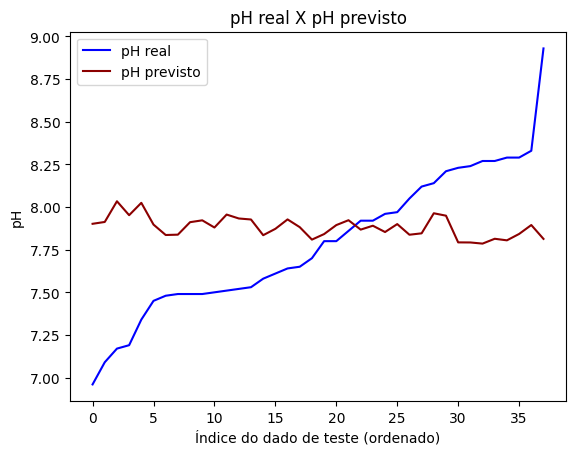

In [20]:
y_verdadeiro_ord, y_previsao_ord = zip(*sorted(zip(y_verdadeiro, y_previsao)))

plt.plot(y_verdadeiro_ord, color = "blue", label = "pH real")
plt.plot(y_previsao_ord, color = "darkred", label = "pH previsto")

plt.title("pH real X pH previsto")
plt.xlabel("Índice do dado de teste (ordenado)")
plt.ylabel("pH")
plt.legend()
plt.show()

Nessa visualização, é possível perceber que o resultado obtido não foi tão bom quanto esperado. O RMSE obtido O RMSE obtido na previsão foi de 0,461 , o que é aceitável na escala de pH, entretando, considerando a magnitude dos dados, se mostrou insatisfatório, com todos os valores previstos próximos ao baseline. Isso pode ter se dado por dois fatores. Por mais que a rede tenha uma alta dimensão, a complexidade dos dados pode não ter sido captada pelo modelo, prevendo todos os casos com valores muito próximos. Outra hipótese é a seleção dos atributos para a resolução deste problema, visto que o o dataset contém várias colunas categóricas que não foram consideradas --- por exemplo, o pH pode ter sido alterado devido à uma contaminação local, de modo que a posição geográfica ajudaria na regressão ---; assim, uma seleção mais criteriosa das colunas, com menor quantidade de atributos, sendo esses mais significativos para o problema. 

Podemos recuperar os valores de erro a cada época para plotar e analisar a curva de aprendizado do modelo.

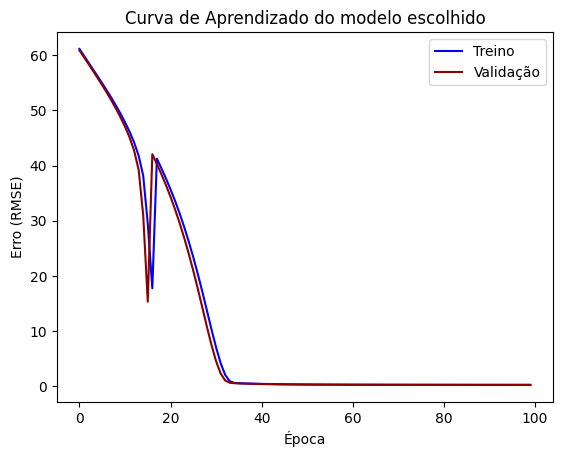

In [19]:
caprend_treino = modelo.curva_aprendizado_treino
caprend_val = modelo.curva_aprendizado_val

plt.plot(caprend_treino, color = "blue", label = "Treino")
plt.plot(caprend_val, color = "darkred", label = "Validação")

plt.title("Curva de Aprendizado do modelo escolhido")
plt.xlabel("Época")
plt.ylabel("Erro (RMSE)")
plt.legend()
plt.show()

Podemos que nas primeiras 30 épocas, há um aprendizado quase contínuo, com apenas um ponto fora da curva. Após isso, o RMSE estabiliza, de modo que o aprendizado do modelo se torna mínimo. Assim, seria possível aplicar um early stopping, para interromper o treinamento no momento em que o aprendizado estabiliza, o que tende a melhorar o desempenho da rede.

Por fim, podemos fazer a classificação de acordo com o consumo humano para visualização dos resultados.

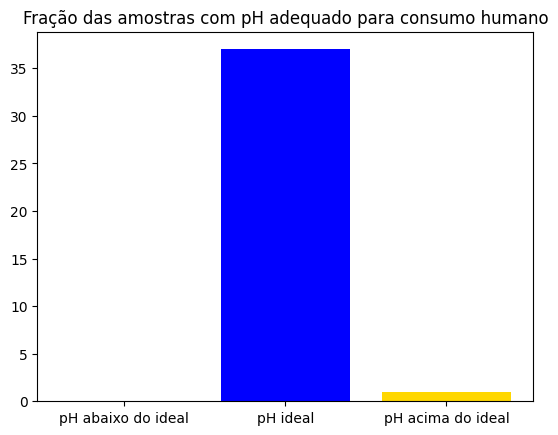

In [21]:
abaixo_v = []
ideal_v =[]
acima_v = []

for pH in y_verdadeiro:
    if pH < 6.5:
        abaixo_v.append(pH)
    elif pH <= 8.5:
        ideal_v.append(pH)
    else: 
        acima_v.append(pH)
        
frac_v = [len(abaixo_v), len(ideal_v), len(acima_v)]
rotulos = ["pH abaixo do ideal", "pH ideal", "pH acima do ideal"]
cores = ["darkred", "blue", "gold"]
        
plt.bar(rotulos, frac_v, color = ["darkred", "blue", "gold"])

plt.title("Fração das amostras com pH adequado para consumo humano")
plt.show()

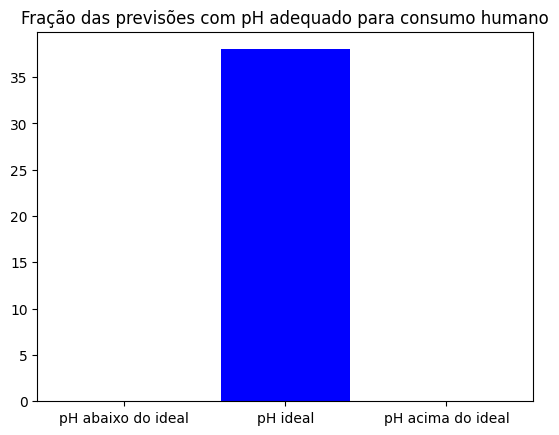

In [22]:
abaixo_p = []
ideal_p =[]
acima_p = []

for pH in y_previsao:
    if pH < 6.5:
        abaixo_p.append(pH)
    elif pH <= 8.5:
        ideal_p.append(pH)
    else: 
        acima_p.append(pH)
        
frac_p = [len(abaixo_p), len(ideal_p), len(acima_p)]
rotulos = ["pH abaixo do ideal", "pH ideal", "pH acima do ideal"]
cores = ["darkred", "blue", "gold"]
        
plt.bar(rotulos, frac_p, color = ["darkred", "blue", "gold"])

plt.title("Fração das previsões com pH adequado para consumo humano")
plt.show()

Nessa visualização, podemos ver que a amostra de teste segue uma distibuição similar com os dados totais, com a razão entre amostras com pH ideal, acima e abaixo do ideal próximas à comparação feita para todos os dados. Entretanto, quando vamos para a previsão, percebemos que todas as previsões foram classificadas como ideais, de modo que, se tal análise fosse utilizada, por exemplo, para o abastecimento de uma comunidade, poderiam haver prejuízos às pessoas que consumissem água de mesma origem da amostra.

---

## ✅ Conclusão

Neste trabalho, buscamos prever o pH de amostra de água utilizando uma rede neural do tipo MLP com Pytorch, cujos hiperparâmetros foram otimizados utilizando o módulo Optuna. Assim, treinamos uma rede com 12 camadas, com 69, 94, 12, 32, 29, 59, 98, 6, 87, 85, 50, e 95 neunônios, com taxa de aprendizado 0,003 e função de ativação PReLU. O RMSE obtido na previsão foi de 0,461 , o que é aceitável na escala de pH, entretando, considerando a magnitude dos dados, se mostrou insatisfatório, com todos os valores previstos próximos ao baseline. Algumas das abordagens possíveis para melhorar o desempenho na previsão é a obtenção de mais dados ou um dataset mais extenso, normalização dos dados, melhor seleção de atibutos, otimização do otimizador utilizado na rede, ou implementar técnicas como dropout ou early stopping na estrutura da rede. Assim, esperamos que a previsão realizada se assemelhe mais com dados reais.

---

## 📚 Referências

[1] WORLD HEALTH ORGANIZATION. pH in drinking-water: Background document for development of WHO guidelines for drinking-water quality. Geneva: WHO, 2022. Disponível em: https://cdn.who.int/media/docs/default-source/wash-documents/wash-chemicals/ph.pdf?sfvrsn=16b10656_4. Acesso em: 12 jun. 2025.

[2] STACK OVERFLOW. What is & how to use getattr in Python. Disponível em: https://stackoverflow.com/questions/4075190/what-is-how-to-use-getattr-in-python. Acesso em: 12 jun. 2025.

[3] STACK OVERFLOW. How do I convert a Pandas DataFrame to a PyTorch tensor? Disponível em: https://stackoverflow.com/questions/50307707/how-do-i-convert-a-pandas-dataframe-to-a-pytorch-tensor. Acesso em: 12 jun. 2025.

[4] OPTUNA. Optuna: An automatic hyperparameter optimization software framework. Disponível em: https://optuna.org/. Acesso em: 12 jun. 2025.

[5] GEEKSFORGEEKS. Hyperparameter tuning with Optuna in PyTorch. Disponível em: https://www.geeksforgeeks.org/hyperparameter-tuning-with-optuna-in-pytorch/. Acesso em: 12 jun. 2025.

[6] KAGGLE. Telangana Post-Monsoon Ground Water Quality Data. Disponível em: https://www.kaggle.com/datasets/sivapriyagarladinne/telangana-post-monsoon-ground-water-quality-data. Acesso em: 12 jun. 2025.

[7] PYTORCH. PyTorch Documentation. Disponível em: https://docs.pytorch.org/docs/stable/index.html. Acesso em: 12 jun. 2025.

[8] MEDIUM. Optuna: Hyperparameter optimization in PyTorch. Disponível em: https://medium.com/swlh/optuna-hyperparameter-optimization-in-pytorch-9ab5a5a39e77. Acesso em: 12 jun. 2025.